# LangChain: Evaluation

In this example we're using the same model for both generating a question-answer (Q&A) dataset and evaluating model performance which is a really bad example. Here’s a breakdown of the considerations:

### 1. **Potential Bias**:
   - **Circular Evaluation**: If you use the same large language model (LLM) both to generate Q&A pairs and to answer them, there is a risk of circular evaluation. The model might perform exceptionally well simply because it is aligned with its own reasoning patterns or linguistic style, rather than objectively demonstrating its capability to understand and generate accurate answers based on external, human-generated data.
   - **Overfitting**: The model might "overfit" to its own generated data, leading to an inflated sense of performance. This can mask its weaknesses when dealing with more diverse, human-created datasets.
   - **Use Human-Generated Data**: Where possible, use human-generated Q&A pairs for evaluation to avoid any circular reasoning.

### 2. **Mitigating the Conflict**:
   - **Human Review**: One approach to mitigate this issue is to involve human reviewers in the process. They can validate or correct the Q&A pairs generated by the model, ensuring that the dataset is unbiased and robust.
   - **Use a Different Model**: Another method is to use a different model (or a fine-tuned version of the original) to generate the Q&A pairs. This introduces variety and reduces the risk of the same model influencing both the creation and evaluation of the dataset.
   - **Benchmark Against External Data**: Evaluate the model using an external, independently generated dataset in addition to the Q&A pairs. This can provide a more accurate picture of the model’s generalization capabilities.

### 3. **Purpose of QAGenerateChain**:
   - The **QAGenerateChain** in LangChain is typically used to create synthetic Q&A datasets, especially when labeled data is scarce. While it’s useful, the generated data should not be the sole source for evaluating the model’s performance due to the potential biases mentioned above.
   - The value of the QAGenerateChain lies in its ability to rapidly generate large volumes of Q&A pairs, which can be particularly helpful for training purposes or as a supplementary evaluation metric.

### Conclusion:
Using the same LLM to generate and evaluate a Q&A dataset can indeed introduce biases and potentially inflate the perceived performance of the model. It is crucial to incorporate additional evaluation methods, such as using human-reviewed datasets or external, independently generated benchmarks, to obtain a more accurate and reliable measure of the model's performance.

## 2 Chains in this example

- **QAGenerateChain**: This function uses an LLM (e.g., OpenAI's model) to generate Q&A pairs from a dataset. These pairs are intended to be used as test data for evaluating the performance of another LLM or even the same LLM.
- **QAEvalChain**: This is then used to evaluate how well the LLM answers these generated questions by comparing the predicted answers to the generated "ground truth" answers.


## Outline:

* Example generation
    - Hard-coded examples
    - LLM-Generated examples
* Manual evaluation (and debuging)
* LLM-assisted evaluation
* LangChain evaluation platform

In [1]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

Note: LLM's do not always produce the same results. When executing the code in your notebook, you may get slightly different answers that those in the video.

In [20]:
# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
# if current_date > target_date:
#     llm_model = "gpt-3.5-turbo"
# else:
#     llm_model = "gpt-3.5-turbo-0301"

# Sai: If I don't use this turbo, it will return errors
llm_model = "gpt-3.5-turbo-0301"

## Create our QandA application

In [3]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch

In [4]:
file = 'OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)
data = loader.load()

In [5]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

In [21]:
llm = ChatOpenAI(temperature = 0.0, model=llm_model)
qa = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=index.vectorstore.as_retriever(), 
    verbose=True,
    chain_type_kwargs = {
        "document_separator": "<<<<>>>>>"
    }
)

### Example datapoints

In [22]:
data[10]

Document(page_content=": 10\nname: Cozy Comfort Pullover Set, Stripe\ndescription: Perfect for lounging, this striped knit set lives up to its name. We used ultrasoft fabric and an easy design that's as comfortable at bedtime as it is when we have to make a quick run out.\n\nSize & Fit\n- Pants are Favorite Fit: Sits lower on the waist.\n- Relaxed Fit: Our most generous fit sits farthest from the body.\n\nFabric & Care\n- In the softest blend of 63% polyester, 35% rayon and 2% spandex.\n\nAdditional Features\n- Relaxed fit top with raglan sleeves and rounded hem.\n- Pull-on pants have a wide elastic waistband and drawstring, side pockets and a modern slim leg.\n\nImported.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 10})

In [23]:
data[11]

Document(page_content=': 11\nname: Ultra-Lofty 850 Stretch Down Hooded Jacket\ndescription: This technical stretch down jacket from our DownTek collection is sure to keep you warm and comfortable with its full-stretch construction providing exceptional range of motion. With a slightly fitted style that falls at the hip and best with a midweight layer, this jacket is suitable for light activity up to 20° and moderate activity up to -30°. The soft and durable 100% polyester shell offers complete windproof protection and is insulated with warm, lofty goose down. Other features include welded baffles for a no-stitch construction and excellent stretch, an adjustable hood, an interior media port and mesh stash pocket and a hem drawcord. Machine wash and dry. Imported.', metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 11})

### Hard-coded examples

In [24]:
examples = [
    {
        "query": "Do the Cozy Comfort Pullover Set\
        have side pockets?",
        "answer": "Yes"
    },
    {
        "query": "What collection is the Ultra-Lofty \
        850 Stretch Down Hooded Jacket from?",
        "answer": "The DownTek collection"
    }
]

But this doesn't really scale that well. It takes a bit of time to look through each example and figure out what's going on. And so is there a way that we can automate it?
And one of the really cool ways that we think we can automate it is with language models themselves.

So we have a chain in LangChain that can do exactly that. So we can import the QA generation chain.
And this will take in documents and it will create a question answer pair from each document.

### LLM-Generated examples

In [25]:
from langchain.evaluation.qa import QAGenerateChain


In [26]:
example_gen_chain = QAGenerateChain.from_llm(ChatOpenAI(model=llm_model))

In [27]:
# the warning below can be safely ignored

In [28]:
new_examples = example_gen_chain.apply_and_parse(
    [{"doc": t} for t in data[:5]]
)

In [29]:
new_examples[0]

{'query': "What is the weight of each pair of Women's Campside Oxfords?",
 'answer': "The weight of each pair of Women's Campside Oxfords is approximately 1 lb. 1 oz."}

In [30]:
data[0]

Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 0})

### Combine examples

In [31]:
examples += new_examples

In [32]:
qa.run(examples[0]["query"])



> Entering new RetrievalQA chain...

> Finished chain.


'The Cozy Comfort Pullover Set, Stripe has side pockets on the pull-on pants.'

So here we pass in a query, and we get back an answer. But, this is a little bit limiting in terms
of what we can see that's actually happening inside the chain.
What is the actual prompt that's going into the language model? What are the documents that it retrieves? If this were a more complex chain with multiple steps in it, what are the intermediate results?

## Manual Evaluation

And so when doing question answering, oftentimes when a wrong result is returned, it's not necessarily the language model itself that's messing up. It's actually the retrieval step that's messing up.
The `debug` mode takes a really close look at what exactly the question is, and what exactly the context is, can help debug what's going wrong.

In [37]:
import langchain
langchain.debug = True

In [38]:
# Rerun the example again
qa.run(examples[0]["query"])

[chain/start] [1:chain:RetrievalQA] Entering Chain run with input:
{
  "query": "Do the Cozy Comfort Pullover Set        have side pockets?"
}
[chain/start] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain > 3:chain:LLMChain] Entering Chain run with input:
{
  "question": "Do the Cozy Comfort Pullover Set        have side pockets?",
  "context": ": 10\nname: Cozy Comfort Pullover Set, Stripe\ndescription: Perfect for lounging, this striped knit set lives up to its name. We used ultrasoft fabric and an easy design that's as comfortable at bedtime as it is when we have to make a quick run out.\n\nSize & Fit\n- Pants are Favorite Fit: Sits lower on the waist.\n- Relaxed Fit: Our most generous fit sits farthest from the body.\n\nFabric & Care\n- In the softest blend of 63% polyester, 35% rayon and 2% spandex.\n\nAdditional Features\n- Relaxed fit top with raglan sleeves and rounded h

'The Cozy Comfort Pullover Set, Stripe has side pockets on the pull-on pants.'

In [35]:
# Turn off the debug mode
langchain.debug = False

So we've just walked through how to look at and debug what's going on with a single input to this chain.
- But what about all the examples we created?
- How are we going to evaluate those?

Similarly to when creating them, one way to do it would be manually. We could run the chain over all the examples, then look at the outputs, and try to figure out what's going on, whether it's correct, incorrect, partially correct. Similar to creating the examples, that starts to get a little bit tedious over time.

So let's go back to our favorite solution. Can we ask a language model to do it? First, we need to create predictions (check below sections)

## LLM assisted evaluation

In [39]:
predictions = qa.apply(examples)

[chain/start] [1:chain:RetrievalQA] Entering Chain run with input:
{
  "query": "Do the Cozy Comfort Pullover Set        have side pockets?",
  "answer": "Yes"
}
[chain/start] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain > 3:chain:LLMChain] Entering Chain run with input:
{
  "question": "Do the Cozy Comfort Pullover Set        have side pockets?",
  "context": ": 10\nname: Cozy Comfort Pullover Set, Stripe\ndescription: Perfect for lounging, this striped knit set lives up to its name. We used ultrasoft fabric and an easy design that's as comfortable at bedtime as it is when we have to make a quick run out.\n\nSize & Fit\n- Pants are Favorite Fit: Sits lower on the waist.\n- Relaxed Fit: Our most generous fit sits farthest from the body.\n\nFabric & Care\n- In the softest blend of 63% polyester, 35% rayon and 2% spandex.\n\nAdditional Features\n- Relaxed fit top with raglan sl

[llm/end] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain > 3:chain:LLMChain > 4:llm:ChatOpenAI] [628.039ms] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "The Ultra-Lofty 850 Stretch Down Hooded Jacket is from the DownTek collection.",
        "generation_info": null,
        "message": {
          "content": "The Ultra-Lofty 850 Stretch Down Hooded Jacket is from the DownTek collection.",
          "additional_kwargs": {},
          "example": false
        }
      }
    ]
  ],
  "llm_output": {
    "token_usage": {
      "prompt_tokens": 793,
      "completion_tokens": 19,
      "total_tokens": 812
    },
    "model_name": "gpt-3.5-turbo-0301"
  }
}
[chain/end] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain > 3:chain:LLMChain] [628.596ms] Exiting Chain run with output:
{
  "text": "The Ultra-Lofty 850 Stretch Down Hooded Jacket is from the DownTek collection."
}
[chain/end] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain] [629.035ms] Exiti

[llm/end] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain > 3:chain:LLMChain > 4:llm:ChatOpenAI] [570.8330000000001ms] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "The weight of each pair of Women's Campside Oxfords is approximately 1 lb. 1 oz.",
        "generation_info": null,
        "message": {
          "content": "The weight of each pair of Women's Campside Oxfords is approximately 1 lb. 1 oz.",
          "additional_kwargs": {},
          "example": false
        }
      }
    ]
  ],
  "llm_output": {
    "token_usage": {
      "prompt_tokens": 804,
      "completion_tokens": 23,
      "total_tokens": 827
    },
    "model_name": "gpt-3.5-turbo-0301"
  }
}
[chain/end] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain > 3:chain:LLMChain] [571.389ms] Exiting Chain run with output:
{
  "text": "The weight of each pair of Women's Campside Oxfords is approximately 1 lb. 1 oz."
}
[chain/end] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain] [

[chain/start] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain > 3:chain:LLMChain] Entering Chain run with input:
{
  "question": "What features does the Infant and Toddler Girls' Coastal Chill Swimsuit have to provide sun protection?",
  "context": ": 2\nname: Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece\ndescription: She'll love the bright colors, ruffles and exclusive whimsical prints of this toddler's two-piece swimsuit! Our four-way-stretch and chlorine-resistant fabric keeps its shape and resists snags. The UPF 50+ rated fabric provides the highest rated sun protection possible, blocking 98% of the sun's harmful rays. The crossover no-slip straps and fully lined bottom ensure a secure fit and maximum coverage. Machine wash and line dry for best results. Imported.<<<<>>>>>: 293\nname: Girls' Ocean Breeze Long-Sleeve Stripe Shirt\ndescription: This long-sleeve 

[chain/start] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain > 3:chain:LLMChain] Entering Chain run with input:
{
  "question": "What is the fabric composition of the Refresh Swimwear, V-Neck Tankini Contrasts?",
  "context": ": 3\nname: Refresh Swimwear, V-Neck Tankini Contrasts\ndescription: Whether you're going for a swim or heading out on an SUP, this watersport-ready tankini top is designed to move with you and stay comfortable. All while looking great in an eye-catching colorblock style. \n\nSize & Fit\nFitted: Sits close to the body.\n\nWhy We Love It\nNot only does this swimtop feel good to wear, its fabric is good for the earth too. In recycled nylon, with Lycra\u00ae spandex for the perfect amount of stretch. \n\nFabric & Care\nThe premium Italian-blend is breathable, quick drying and abrasion resistant. \nBody in 82% recycled nylon with 18% Lycra\u00ae spandex. \nLin

[llm/end] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain > 3:chain:LLMChain > 4:llm:ChatOpenAI] [610.938ms] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "The name of the waterproof pants is EcoFlex 3L Storm Pants and they use TEK O2 technology to increase breathability.",
        "generation_info": null,
        "message": {
          "content": "The name of the waterproof pants is EcoFlex 3L Storm Pants and they use TEK O2 technology to increase breathability.",
          "additional_kwargs": {},
          "example": false
        }
      }
    ]
  ],
  "llm_output": {
    "token_usage": {
      "prompt_tokens": 724,
      "completion_tokens": 27,
      "total_tokens": 751
    },
    "model_name": "gpt-3.5-turbo-0301"
  }
}
[chain/end] [1:chain:RetrievalQA > 2:chain:StuffDocumentsChain > 3:chain:LLMChain] [611.522ms] Exiting Chain run with output:
{
  "text": "The name of the waterproof pants is EcoFlex 3L Storm Pants and they use TEK O2 technolo

In [40]:
from langchain.evaluation.qa import QAEvalChain

In [41]:
llm = ChatOpenAI(temperature=0, model=llm_model)
eval_chain = QAEvalChain.from_llm(llm)

In [42]:
graded_outputs = eval_chain.evaluate(examples, predictions)

[chain/start] [1:chain:QAEvalChain] Entering Chain run with input:
{
  "input_list": [
    {
      "query": "Do the Cozy Comfort Pullover Set        have side pockets?",
      "answer": "Yes",
      "result": "The Cozy Comfort Pullover Set, Stripe has side pockets on the pull-on pants."
    },
    {
      "query": "What collection is the Ultra-Lofty         850 Stretch Down Hooded Jacket from?",
      "answer": "The DownTek collection",
      "result": "The Ultra-Lofty 850 Stretch Down Hooded Jacket is from the DownTek collection."
    },
    {
      "query": "What is the weight of each pair of Women's Campside Oxfords?",
      "answer": "The weight of each pair of Women's Campside Oxfords is approximately 1 lb. 1 oz.",
      "result": "The weight of each pair of Women's Campside Oxfords is approximately 1 lb. 1 oz."
    },
    {
      "query": "What are the dimensions of the small and medium sizes of the Recycled Waterhog Dog Mat, Chevron Weave?",
      "answer": "The small size has d

[llm/end] [1:chain:QAEvalChain > 2:llm:ChatOpenAI] [2.95s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "CORRECT",
        "generation_info": null,
        "message": {
          "content": "CORRECT",
          "additional_kwargs": {},
          "example": false
        }
      }
    ],
    [
      {
        "text": "CORRECT",
        "generation_info": null,
        "message": {
          "content": "CORRECT",
          "additional_kwargs": {},
          "example": false
        }
      }
    ],
    [
      {
        "text": "CORRECT",
        "generation_info": null,
        "message": {
          "content": "CORRECT",
          "additional_kwargs": {},
          "example": false
        }
      }
    ],
    [
      {
        "text": "CORRECT",
        "generation_info": null,
        "message": {
          "content": "CORRECT",
          "additional_kwargs": {},
          "example": false
        }
      }
    ],
    [
      {
        "text": "CORR

We're going to print out the real answer, and again, this was also generated by a language model when it had the whole document in front of it, and so it could generate a ground truth answer.

We're going to print out the predicted answer, and this is generated by a language model when it's doing the QA chain, when it's doing the retrieval with the embeddings and the vector databases, passing that into a language model, and then trying to guess the predicted answer.

And then we're also going to print out the grade, and again, this is also generated by a
language model when it's asking the eval chain to grade what's going on and whether it's correct or incorrect.

In [43]:
for i, eg in enumerate(examples):
    print(f"Example {i}:")
    print("Question: " + predictions[i]['query'])
    print("Real Answer: " + predictions[i]['answer']) #
    print("Predicted Answer: " + predictions[i]['result'])
    print("Predicted Grade: " + graded_outputs[i]['text'])
    print()

Example 0:
Question: Do the Cozy Comfort Pullover Set        have side pockets?
Real Answer: Yes
Predicted Answer: The Cozy Comfort Pullover Set, Stripe has side pockets on the pull-on pants.
Predicted Grade: CORRECT

Example 1:
Question: What collection is the Ultra-Lofty         850 Stretch Down Hooded Jacket from?
Real Answer: The DownTek collection
Predicted Answer: The Ultra-Lofty 850 Stretch Down Hooded Jacket is from the DownTek collection.
Predicted Grade: CORRECT

Example 2:
Question: What is the weight of each pair of Women's Campside Oxfords?
Real Answer: The weight of each pair of Women's Campside Oxfords is approximately 1 lb. 1 oz.
Predicted Answer: The weight of each pair of Women's Campside Oxfords is approximately 1 lb. 1 oz.
Predicted Grade: CORRECT

Example 3:
Question: What are the dimensions of the small and medium sizes of the Recycled Waterhog Dog Mat, Chevron Weave?
Real Answer: The small size has dimensions of 18" x 28" and the medium size has dimensions of 22.

In [44]:
graded_outputs[0]

{'text': 'CORRECT'}

This difficulty in comparing strings is what makes evaluation of language models so hard in the first place. We're using them for these really open-ended tasks, where they're asked to generate text. This hasn't really been done before, as models until recently weren't really good enough to do this. And so a lot of the evaluation metrics that did exist up to this point just aren't good enough. 

And we're having to invent new ones, and invent new heuristics for doing so.
And the most interesting and most popular of those heuristics at the moment is actually using a language model to do the evaluation. This finishes the evaluation lesson, but one last thing I want to show you is the LangChain Evaluation Platform. This is a way to do everything that we just did in the notebook, but persisted and show it in a Ul. And so let's check it out. Here, we can see that we have a session. We called it, deeplearningai.

## LangChain evaluation platform

The LangChain evaluation platform, LangChain Plus, can be accessed here https://www.langchain.plus/.  
Use the invite code `lang_learners_2023`

Reminder: Download your notebook to you local computer to save your work.

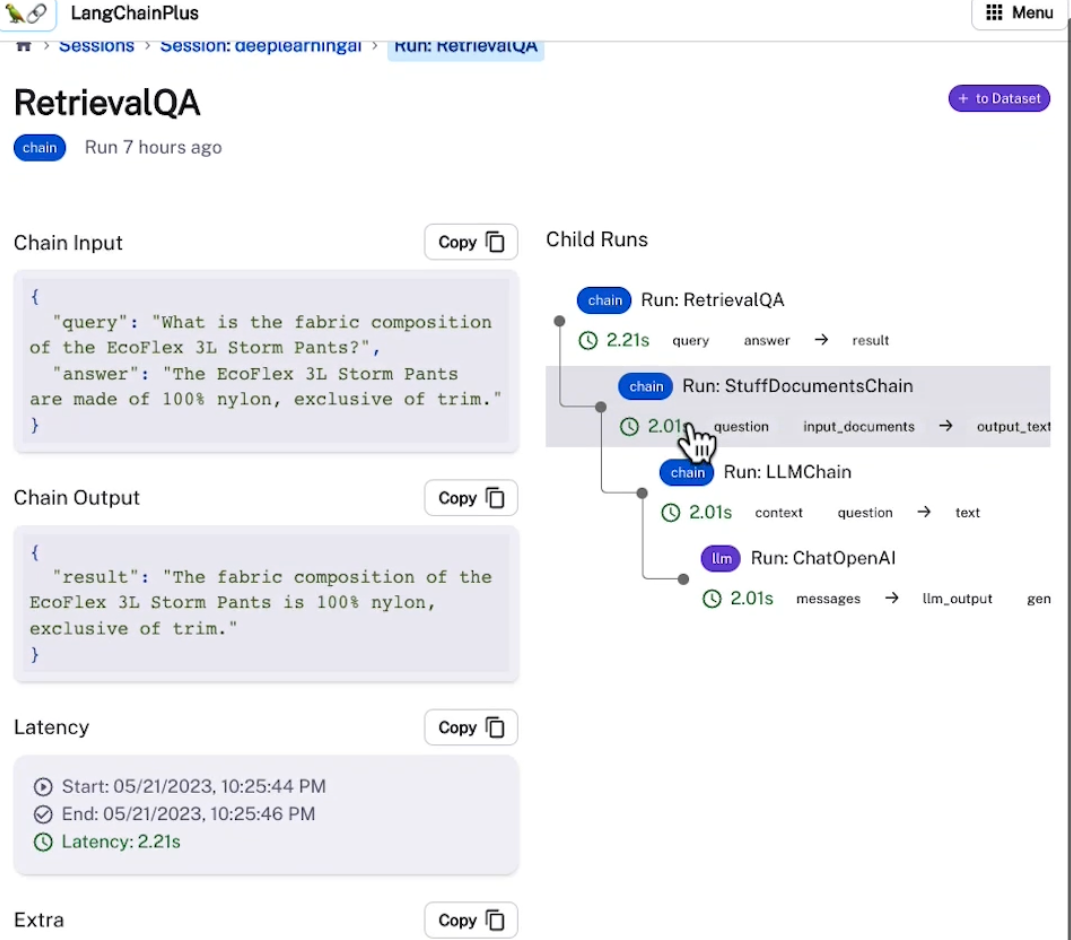

In [45]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAABC8AAAOsCAYAAABqMpzFAAABXGlDQ1BJQ0MgUHJvZmlsZQAAKJFtkM1LAlEUxc/YhJQVLmojLYQIMixCBYVW5iKKFoN9t4jG0TQa7TVOVFt3UWsXraJFf0Eg0aZlhLugIghati8GoeR1n1ONVvdxOT8u5z3uO4BLVhnTZQD5gmkkJyf8S8srfvcLOuCCFz74VK3I4ooyQxZ8a2tZd5CE3o6It6o30we10ydPOVwar61Wj//6W6oznSlqpB/UwxozTEAaIlZ2TSZ4j7jXoKWIjwRnbT4RnLL5vOGZSyaIr4m9Wk5NEz8QB1NN82wT5/Ud7WsHsX1XpjA/S9pD3Q8FcYQQRQwJLFA2/3sjDW8CW2DYh4ENZJGDCT/dZnR0ZIinUICGUQSJQxijjoiMf2fnzLY3gdgb4BpwZmuUycUh0BdwZoP0l+4ScPnMVEP9SVSy5OJ6OGSzpwK0lzl/XQTcAaB+z/l7hfP6GdD2CFxZn9pNYx5P3KXYAAAAVmVYSWZNTQAqAAAACAABh2kABAAAAAEAAAAaAAAAAAADkoYABwAAABIAAABEoAIABAAAAAEAAAQvoAMABAAAAAEAAAOsAAAAAEFTQ0lJAAAAU2NyZWVuc2hvdEaj+zwAAAHXaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIj4KICAgICAgICAgPGV4aWY6UGl4ZWxZRGltZW5zaW9uPjk0MDwvZXhpZjpQaXhlbFlEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlBpeGVsWERpbWVuc2lvbj4xMDcxPC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6VXNlckNvbW1lbnQ+U2NyZWVuc2hvdDwvZXhpZjpVc2VyQ29tbWVudD4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CjRJ3g4AAEAASURBVHgB7L0HlF3FmS287+17+97OOahzS2qFVk4IBBIKRBMMGGzsGbDHOcyMJ/mNJ/hN+Nesefaa5zBveZg1zjZgG2wwJiNASEKAJJRAWa3UUqvVOef0713nVvftVnerBZjxQJXW7XNOnQpf7apzdL5dX33lG2IYHByCgs+nH/8Mh8Hhs5ET3Y9OM3LnXTnzRI1UxYuhERkHKdeQ3w8lqWloRVN7NxLi45CdnoRwjCe1/10R8vevEnazEWp0//7+yekkcgg4BBwCDgGHgEPAIeAQcAg4BBwCvw8InD9/HgP9g0hKTkZCQpzRlf3UNwcHB6HjZEHq1yjVWomlvvJwQfxkBb1P7/X1DaC5qRn9A/1ITk4i/vEwiPv9PoLvkRKejjuEoaEBwkRiYKgfGOjlr4eXfaPIAuFoleJ3AlNxKKZ+9eiY0DcwxEEyJlIkik+sBJvBU9EWagVjEI5PRH8wEY29MWij2GyFGSimTWOLeZev30nMpiK6Hi4F1atzW3/0tY2bSnm/izSqP/p3sTqi22Rlt8eL5XX3HQIOAYeAQ8Ah4BBwCDgEHAIOAYfAxRDo6OiEPyaAuHDcKLLiYsSFyqWJwHDxAwMDRg8zyiq1UuktfX1UUhk6OjrQ1tZmrqXjWD1nOPP79CQQIz3fZzgAa2wR8LDw2AJvVl7n+glsAjrQyVOdM84fIjMQx3OSBUMqiGTB5IQT004t2Fp1FAGh6vrZyb29JE54PkAZQrGxiA0G4L+AqlIOERgeeaEyAiE/fLFBdHcPoYvNSA6bFIbYUPH/neHdtn7Qw2UVe/vgSAb7i+HAeLdlGov/ZPVb2e1R7bEvjMnyja3DXTsEHAIOAYeAQ8Ah4BBwCDgEHAIOgakiIKsLaac+o09dPJeIB+lbwWDQkBBWZ9ExWm/ReSDgqeKhUMiknUwnU7nKE13GxaX5n51CPMMQ+QarA6o1EfLC0AXDrRuitUVvbwe6WqvQ3lRprDLiE5NpzZCBQDgLMcFk9mGA/AUBHM711k9ENug3KMsA/rrIcLW2cdlHczPqamvJRnUiFA6hpKgYebm5SJTJSIxaE10nJSF5oaAhptsyJunngOvt62fSSFNNinf3jwB/OwPt7eZXa22n2wdHD1V3d7cBIplmUFMJ74QcY+uxcgmf6PKjzyfCTsSWHnL9LEs52UM/tm537RBwCDgEHAIOAYeAQ8Ah4BBwCDgEJkLA0y49jZcqHcMoBXTcbNJLenp6jP7X2dlJfbTfTLyKrJAupmt7Pz4+3hAd0mFkiSH9TEelTUhIMEerF02kE1l9yqaTUGPTRt8bK/RE92y50enHlht9z55PVJ69fylHUhejCIzA2MJl3tLT04kzZyrw2pZH0dV8HCXTi1A6YwZCCdmIjStCWgbPQ8kkB2JGKZyXIkh0WjsEZGnR3d2D6vPVqKw8g3PV5/irRitJDHViTlY21q5ZgzmzZ5t1L4bJUuZxGBRFmWj+8ZklMdE1Tu1cliUD/Z6Jj8rwBtw4lU1S3HidPl5ym26yATFRGtuHOlq2z6ZVXSpTWFnFXtcyTzp79qzBtbS0lHgmXzDIx8oZXY8td2yaS722Mtuj8utcv+ggmSW/+kCkRUtLC7QGTQ98ZmYm4uK8NWg2v46TYRldtjt3CDgEHAIOAYeAQ8Ah4BBwCDgEHAJjERjRJ7zJ6DEqytjkRv+QziJy4uDBg/jtb3+L1tZWE3/ddddh4cKF2Lt3L5555hkTJ6uLP/zDP0RKSgo2btyIAwcOGHKjpKQEd911F3QckeGC6kyE9CYRIpqclq6k+hWi8ylN9LVJMMkfq4vZ49i8Y8sbez1J0Zd0S5YXg1p+E1ENLzBHUMNFHmza9AJ2btuIjMQupKT3YVqvDy1d1VxIUo8BrvvJyykjAPGXVPlEiUUHiCiQQn2+pgZHjx5F1blzphMSExMRotnNmTNnsGPnTlpldCCGNiTz5s2j4solLBfhEvxMa0iOiSqfJL61pRXbXtmGmppazJkzh3WWc2BFrBQipIk6yprxjFeP7XBbja6j0ymvDWMHheJt2co3tiybT/HKq4eksrISb775Jk6fPm1vm3tLly5FWVkZ0tPTEcvlN1pXtWvXLvOAfOITn4BwVl2W5LCZbZ0q38pg46LTKE6EwuOPP45Zs2ahvFxYpZgkKteaT0Xnsee6J3nU76+++qqNHtXeXFrcXHbZZSgl0aK6dnIsvPjii8jLy8M111yDuXPnmnaqLPvA2vYMFxg5Uf6xWEe3yd6zcfZ6bDnu2iHgEHAIOAQcAg4Bh4BDwCHgEHivI+BpzlSHqEPQvH+SIL1Buoj0iEOHDuE///M/0dDQYK416SqdZseOHfjud787XMpVV12FrKws/PrXv8Zzzz1n4leuXInVq1ejpKTE5J1IH1E9stY4cuSI0QNVjnSxjIwMU47u66fJ35MnT5rJX01aS6eSXqgQXbbSWv3TxivOBsVFX9t4xeln9Vx7rfu2nLHnNu+kx4iuz9JNsgvIi96+Xpw4cRK/+vVvUDRtCNPLSpCZHYdB33nUN3ejvrUavfR9kZKSisRwfqQDPXZn0orH3mT9FgYJ09Pbh5rzNWSoDuAMLQLiaSYze/Yss0wkxh9jrASee/ZZ09m52TmYxo6Pi2P9sqqwBY2tg9dahiLwCNs4d0dHKV00uFq28uCDD2Lfvn24956Po7CwYJi8sCVaxVwdpZ9X10gnqTylscEq1PYYnV7nNt7KYe/b/DqOFyfLlGPHjuGJJ57AU089xT48YUgKlSO2bw0tVj7wgQ9AD0dxcbEhOg4fPoxf/vKXuOOOO8yAVrli65THtsXKbgkBW7/SWhkVJ9Krvr4eX/va13DPPfcgJydnmLxQ2vHIC+W3bWlvb8eWLVvwN3/zN0hKSjKWICJZlEYPpMq77bbbsGHDBkNiiKB55JFHDGmxaNEizJ8/32Bny1M+ya561RYrq+4r3r5UbLxtl442LrosxbvgEHAIOAQcAg4Bh4BDwCHgEHAIvH8QsLqQ9AOrI1ys9TatdBDltzqFCATpNfbaliMLcvnIUHoblE/6lYLST1S30knXe/rppw3xsXjxYtx9991Gl1KZCkojI4Ef/ehHxurDpklLS7ugXNVj5bN16trGqTwrp4236VSP7tl4HXXP3rfXKuNiwaYVD6AybRkR8sKq4p4FREtzOw4fOo05s8oRR5JiIOhDVUM1qrn9aENrPckLbj9KAmFmYSIC/njSAnLieXFyYFhIVse2GM5BZiB9XJrR2NhoZt5PnzptWKBly5dhNlmjMEFnmzF3Vhni6eX13Nkqw2LJ8iI7h8tY/LHDxdoTSXIJ0thsFxxjCJTAkjlPQmLCcEdFJxSwUoT1GxgYGWQxdLrhJ9iSXQydd/RIAZtOA0o42M6Qoq1Ot+UpXvXLKkVoeWlHBozKURqVfe5cNR5++GH84he/MPLecceHkE3mLUgCYO/ePcZK4RytWUQIiJGzCCm/2tfZ2UXriwQz2CSD4tU27ycZ5flWcow8gMODim1X0Lqs/PwCMn2Zph4TyT9qg+pVucqjEF2+rtVmyaG0snIR2aLlICJTZE2ybds2fOc738Hu3bvxX//1Xya9WEP9rEMcla/00XKJ1NG1ylWw93QuGZRnbIhOM/aeu3YIOAQcAg4Bh4BDwCHgEHAIOAQcApMhID1DE7KagLXEhMgCnUsvys7OHp7clR4kHSY1NdWkV7lKa/UXlaUgHUXBXutccXaJipajSPfRxG5paakpy+aRlfv999+ParpkCIfDxmI+WufRudWLVK/qsHHROpytU0fprkon+RWUT3lsPhuva6Wz7TGJp/rH6NIjBEgUeaESVHkABQVFXGPzITrobMLuQ8fhP9mM9Bwqpyl0GpLE5R0D1Th5bh99X2QhLb7QEAj0CDFVETxDCQpijCa4I2tnW7tZE3Tk8CGa0kyjdcCVKC4pwSCV8z6CEgyQBGDp80lYLF++HNtffY1mLyewjEshYsUoTeTTwtP5pyzX2IQiVizY5p43XsxpZAwZvBQhIqGN7ZD1gTpYAzAxIRHhuLAZIAG2YYjxPWTc5IBUW790+WjJwvQawGLctHetBhP7lz+1mNh0dpsBKcsEDRClk8mRBoMcwIhFmzYtB5s3b+aaqsdpltSID3/4I/jCF76I/Lx8U7+WWHR0dGHr1s00KTqGdeu6TLvU35K1tbWdNZGgqqo2sqh8EQlqgx24vb096Kfj05bWFlN3mA5URc4ojdIrXTAYwhe/+CVaqBRSznhThx6mrq4uwxxKZuuERu3QT+1VvPKrLA1qWVF8+ctfNuWIoayoqDCmT3rgjh8/bpbF6MGMfkCUV2lFgqlN9oG38cJK+Ola9Sqv0mupi8qy90TAaAmN5HHBIeAQcAg4BBwCDgGHgEPAIeAQcAhcKgIiKbRk/9577zW6nHSMyy+/3EzOajn/5z73OUi/0xL4Euq90gdvvvlmY1WuuqZNm2aWmETXO55+ojjpUtJxdP7KK69Qly8wk8EiThSkf8niXjqPgvQeBatLKV46pfQlBelKVh+SLqefgtqksmQRorxqk9JKX5a+p/zKp3SSR/lUruSSvqg2Kt9UgtXBpddpAl3XChcwDtrDdvHipZg+oxitHaewc++zeOalB9Ad24vyolzkF+RzJ4949PfW4vCpLSjKWoyCzEUIxiSY4sip8Dix4heplwJ4Cr8AqDhegU0v0H9Bfp5ZEqDZeznnYDvh15asA7JuYMdQWRaDJUCUf0i7izB+smUjRpYIEaAGX0rwLCY8BV/AEbYLsktGASrLhf1v7scPfvgDLsX4uUl3xRVX4qabboKcs8yYMQPNXIaydevLxgpixozpRnn+/vf/i52ZQMJmtVkWsXr1VRELCPB+H154/gU8//zzePa5Z7l05ozB56Mf/ZgZ0HL08pOf/IjLJ35jHJx2dXXixhtvxCfow6KkpMQQEBL5iisux0dpPlRRccxYYex6fTcKiwqNjBp8smzYvn077rvvuygqLMatH/wg1q9fj5kzZ3pkCtunfrrvvvvwQ7avpua8Ibj0gH34wx/GPPq3iKP/kT7K+8Mf/hA333Qzpk8vNQP65a3b8MyzTxsmUWuv1JatW7eaJSx6mGW2JALD4BsZHCIVhgcoB77kWLdunbG60Nox+dXQg6KgfHrg1A4tm/nJT35iHpyPfvSjxiGOHiD5S5EvDd3Pz883Mite681UlpafyCplyZIlxmHOrbfeal4kpgL3xyHgEHAIOAQcAg4Bh4BDwCHgEHAIXAICIhRKS0vNcnpLLkjZlx4rK/hVq1YZXU26jHQhKfW333778KSv0knvVZDyb3Uje21uRP4obXQQiSAyQUFEhTY5+OlPfzpMTohUsESG0km/euyxx8ySEsm2du1a429D1iFVVVWGENFksnwa7t+/30z+ihiR30Hpclq2ItJEy/rljkC6m8iLN954wzgslf6lpSxq51TDMMlBXVbt108hQl7owovQDQGQlpaFpJQguga6sOPANrQPnuJ5H3p9nVy+0Y/YeC6R4PWJaloGdPWhIHcuEsKZLIfgDdHURCQGi5S675XMEwYBbywqqHA2cJZcjdzy8lajVGunE7FCsaFY5NACIxwbJGnhsTM0bEBXdxd6e3oxe85sTC8tpUXG6I7yaojmMmyb7B0dvfKiYyY6lzyS14I1UbrW1jb87Gc/w7/92zc4EPqxbNkKs5yhhs5H//3fv2Pa+OlPf9ooxMeOHeXSjgfNYM3JzkVWpmcy9Oyzz7Dth1Bf92ncc+8fGgeWDz74c3zrW980Zc3mDivl5XMN0fC///fXPHaNAn3+818waauqzhkCRUybRzqEjNyyCBHea66+Gvdx4IiEmEkiRb5C1M+13Ir2q1/9XyjIL+JynUxaVrTiP+77D1o4VOBP/uRPUUL/GBW0dtCA//nPH6D5US6ZvLkGl02bNuHggf34kz/9Mq6//lpDIFRWnkZtXY0hZvRQvMkBLkJDD62sOcrKZpvfphc30WypBp/65Cdx4wduNEwcn10TYmPDlN3rJw1cyanx1Nc3QGInGelpGegwzKDSaDDLcsNv2n/o0GHjo2Tt2vXES/0HPrA1fKBeoxPaF2nVMc88VCIz5Cjn5ZdfNj5ARC5p95V//Md/NOTSt771LUN0eBK5vw4Bh4BDwCHgEHAIOAQcAg4Bh4BDYGoIaDJW+sZf//VfG2Vf+uRnP/tZM4H70ksv4dvf/rYhLKTQf+973zMWC9I/dE/6pyZV/+Ef/sEQBrbGsTqp0uknMsJaUyityAqRDNJvZNkhckF+EXUtv4jSy6Rjibh48skn8bd/+7dm0lluGWQp8fWvf91sjiA/hipXy/cfffRRI6MciaptmpAW4fGlL32JE+VXmIlw7ayyYMEClJSUGLmkZ2qCXOWKpLnUID1OcvqJnQ1R5IWNojrIBDFUCEELi6SkXKRnFKKm8iTOVtUhGBqgI8YQ4kNcWhBDlqh3ADX1YcSFgwimx9BHRSoLEqngKZ8jVYm48KwUugmwlkuI5REY+/cfQAvX4WiHEVkBxNGshJQBCqmIGx2WGdvbO7hU5BQamxpRNrOMliHTKUuEvFAlYkkmDNFSTJho0htUkSe5r502mo3yvH79BjOzX0DrkedfeB6yrKirqzODQ4NLyy9kISHrkmuvu9YMokYu9Xjk0V+b5RHHOaAUOjra8dBDD+HUqVP4yle+gms2XItk7nSi5SGyfhBJIAVdVhjHjh7Dea5f0gCUom+Uffah+tnzveFDLv2DpKenGYJBJjuyNJC1gs5nz6aPidX0MUGmTbuUPPnkE2YnEg02WShIhgceuN8QFx//+Cewgkt3tCPNT3/6M0O4aClHbe0Skln9JBh6We6AGbDmYSJZ0sJdWzwWbx0ZumvNQ/DNb/5f9vub2PryNsykSVVubs7wQyfSQ3ll0aKtc8X4yVpjz57dZlnRAm4xJNJLg9mQF6ZvxEhqm99ekjmtZomLHRNa7iIGsqW5xTyQhlRhfmEp/xqf/OQnDYGxZ88e/OpXvzLYmE5wfxwCDgGHgEPAIeAQcAg4BBwCDgGHwCUiIGVdVvciC7SsXUH6r/Q1TXBrl0UFEQm6ll6jiVQbryXwWt6uIL1oLHGheMXZn+qTzwyRFU1NTcYSQr4vRI7I2lw+L2Q5obo0oSx9UduyPssNMVS3NnaQRb301m9+85vGAWhpaalx2aCypRNqglzLXVTnj3/8Y04MbzI7mCxbtswQGpJXxIaVTbqm2muXnSh+oraYTFF/VKcmp7Xywbpy0O0Llo1E5eEpZ8uDSchIy0f7Qc5sn2qhmjhEJTiEtMQOJMeFEJIjR18/zlXT8aMvFplpJBWGCYyR0qSI6qcGiIWRCf/p05UsK8OAoc60pjQDVIJb6VuhodFbb9NJ4qK2toYM0A7jy0BWCHLmqG1QrYI6UtPImfiMSTmNkaRv60wdo21v1q9fb0yASopL6IS0z3RwQkLisBRmcBFBDSKtddKevllZmWhqbMKevbvN8gY5UTlx/CQCHFDCRB03b958lM/zth4VSaLyteWOBsr00unGWkW7xCitDRzj7HB7xZ6k6U58cKS7lVZMmrYzvffej3MN1kqD/759b5C4eN08OBrQV155ZWSwluGGG24wcuvBaObglN8LldHFJTMalLLwGC/I5Gnp0mW0ePiQWcKiJTZ6iJ5++ilj4SF2cNq0XPMgSC6RIf/6r/+H7WHZHC9iC/UwyznnksVL6OtkmSFs7MMq7kJtVZuHe1xtj2p/tFx6aFSuHjCRZWIYZbGiZS3CQw/3pZg1RZftzh0CDgGHgEPAIeAQcAg4BBwCDoH3JwLSM+xPFu9jg/QXERY2SJeS/qM80UHXujfVINJAW5+WlJQY3VD6lfRFTUJrhYD8bVxNS/xdu3ZFJoBhyAtNEEvH0jKPgwcPGr1Ly/Ol30r/KioqMvIqjSwopMOK/Hj99deNVYV0V000K/07GTw9T/odcYmCZkSbHac2meqHgmFkZxbCPxiPhtoGBHxt6OSWqUNZfYhJIbMS5E4OgW40dPUjPBBEmLt/pGXEU3Hkmhbra4JKpBRbzaKLuDhy+AitLKpIQGTQ8mAF4rnLhZipEJV6AScmSI4txQxJca3j8eDBQ+ZcZinFJUVMG/IaogZJcx1HUR0napxWvv0okShpaenGd8WWLZvNQLCDUmSDwoiiTVTJbklJnsUdVEKxIWRydw67z64sBGqIURF9UkiZTk1NM5YQUrC1tkgWBxokInpkTpSQGG/SKX+Iy23GCzRIYJ+TZOKJCKRAwLOKEWhS0i+77DISLTPMwJTDTzFrsk5QnfJjofVOGuzHjh01BIvy9LAvT5486VVHoNWm7p4Lt/5RAjlokZmSnNbk0AKkvb3TEDuKl4VJj/JRLvWXBqjap4ddD6GILGGXTnzlF+SWW24hozgN/shyoujBrLo0HBSUZ+xLQPGKU9/I4kJjSXjKwkWmVXpQhbH2VNZD6YJDwCHgEHAIOAQcAg4Bh4BDwCHgEJgqAtI1REZIF5E+oUl3OeaUrqTJbulR0jcW0pJcQVbwmujVfU2miiBQXlk5SCdW0PXFgvJLt1LZqkN6nPQb+f6T74mPfOQj1KWu4qqA75uiJKcsQmSNr3xHjhwxViKqS/JKHxQhoUld2x7JKV1dOpPuSz7VI0sP6Y4TBZU5lTZE57fppSPqn4L0vEnIC4FE5ZbkRW5mAbLTaILScB7Ndf0YaB9AbDd/nb3wx/VyRwsquehFQ6cPKYEkJMRn0SeGLA48s37Vpyq1U8WpU/KJUIcMKtuLlyw2O0okcyZfM+CyNJBTycSkRLN0pI7ERUN9A391JC7asJC7UEjpTKbiL58N1MZNueP158W7mAJdSjAFRkpVYyKn6sxOzuKr47UMorm5ic4qZ5B8KDbWCHYJhRCQnFZWDRgVofxB+vbQQJBSrUGgzorjLiUiFUT2aI1SxbEKbg2bYzDSspu1a9eaXTlimVcDXSZCYTpblUWBBpEGld8vXxCsk91w7Nhxw7Rp+9clS5eYujx5fNyxRaSH1yANfNWvB0kPnCw6RCTI5Gn37l3GUqawsNDIKXJBuWTSozxq03hB7dJDZB9ApRGJYjCQECzFDkuVoyUmt9xys7Gy0bV+SYlJmDV7lrE20VIY5dVDMkDrDK8Er37hqcBc5mhkMnWoB7yXibCW1Yr8kMjpqSxMtN5LuJWUlJh2z+I2vS44BBwCDgGHgEPAIeAQcAg4BBwCDoFLQUD6h/QNTdx+ghspyIJC+pCWcWjCWRPQX/ziF028iAPpVtK9tBmCSA3pYyIhNIE8oi9NLIHSqz7VIx1QZWjb1KeeesoQIyJNSktLh+tRmfpJP9PyFBERmmjWxLnKEeEhokKONiXfsH5FnUp6WXSw1zaNytW5ju9EMDpiVFmTkBeeAhjm9pd52YVYMHs5LS9qUVd/Gl19g6ih6f9QM2fGE7sQSgkgHOhFq78X55HILULzkVOaRWpEHkVpFkPZB8jcNDc103ylnpYGGVi0eCEB1K4iQGlJMdfZ3EiAnzasj5x1TqMyXk9TF5mvJNHKYMVlK7B4wULOwKdx1xFq44ZAsCrqOwHNhWUYxZnRpoMjyrZS8ZSqsRGAZEEPl3mcoEOWV2gpcp5bzH4Ed915J1Ipp8x1Dhx4k/lVxkj5KleDRfq1lnPYTvcGHn1WME7nGmga6HKS2UhGS9YoGlTyTitPrhrQCtnZWcMs22H6EZE5kKwHkpNFINHRKX1svPjii1y/9G8kOgrxV3/1V4YE0j21zVuH5Akohk0DTvVq8IoMkXL/4IP38yH7Y2zg0pgCPmDqy/vv/xle2/4a5WdT+EcPi22Lyp4s9JAQUV3qQZER2kpWQe2eO3cuPvHxjw/viBJdjnkgaMWjh7OPvizUDSKyJIPuWfMqncsiZqDfc1iqNtmHSkcxiiJntLbLmjtpuYqwe+CBB8zuJjKPEg5TbVO0nO7cIeAQcAg4BBwCDgGHgEPAIeAQeP8hIN1BP2thoYlgTeJq+1NrHSH/E1rCLvJARIH0EpEd0j+kx3gW+KnmXAhOpo8ovbWS8PwZzja+FOW/UMv9N2zYADnalF6jtPopaPLbTthqOchaTo5rMve5554zFvAiVSSH9DObZ6xupHjdl26rnya8pQOrzbLssP4ubH5T8SX88Wl3Ua4goAAm10XJC1lPyPLiypXX0LqgikLU0TEj93HtH8Lp5h50xvahL9GP5HAv4gId6GkLUfASdsR0xGbkEWmRF0PGnKSTSrQ6pJAKtMBSkFWAFNgrV13BTgtz7cxrdBCayYb2cmeRHjpSLMKVNO8vKiyiU1BvGxmT0f6h0jpZuMjtybJykEg4n5GjjtYfcmYpPwyyGrAKfntbu1lXJMuLlJRUsw5oHne0kPxaVqGBZDRsatmSZbKBJ0uGPv7k76KpqQU/piMUDepiWnGEaYmhwS0TIg1sLbXo5u4rGiQiL7TMRH5ANtLzq/KL+BBbNjQ0gEMHj5h1SbJeKS+fR8uQ6ZO2Wzc1MEUEaOmOLGIkt6wVLiOJJMJF92QxojBZm0yCMX80ePXPhKgOulg5yicyoi9CsMjnhpbCmCUmtMJQfsmtEVV17qyx9NEONedJKsmcSfjq4VL6hx9+GP/8z/9sTKe0na2IFxEXesC0440YR+GkF4wLDgGHgEPAIeAQcAg4BBwCDgGHgEPgYghI19BPE8A7d+7EfffdZ3QL6RSytrj22mvNpgHaWUT6RmlpKb7xjW+YSWnt0ChrcOmZa0kk/Nmf/Zmx1pDe5ek4F9Zu9CPeVxrVqclnWXfIkt2SIiUlJWYXEN1TkM4kGUVcaKvT+++/nztk/rtZIiK970c/+pHRYTWhrLwiRDyd1tt6NZqI0LmIF6WTfwxNAqse6fzSrVSe0tjfxfS9C1sYsa5nGQqTkhfesg9uVRmTgOL8OWRtbkFLZwNe3b4ZKXEBxMYEca6OW6XWA2nBPqSH+tBUc5zkxg4kp5Vi5opU+IyTSD/aONMtofOm5ZGFymYHkBiIhAHKolUgy5YtMX4gTnEJifaSFVu1Zs0absHKbT+Zlv1ojkbvVcTvPHggnaUTEu1C8cILL9Dqg4wV6+2nQ051lDpdyzZELGjJi5yeqMPk4OQb3/i6cTSan1fgSeqT0JMLroEnBTo2NmAICCnaNXRWKrZOS2te4vY5TdxxRQNS26T++Z//OZfpxGHRwkW44fobje8QsWzaWkdb1Uhp1zY9R48cZtV+QxppQLeRdJlKkPWCBpn6TstX9FBosD/++ONm61ENUl1f+kCMrt3DZbIyNF7V/4Egt/bh2BH2wkoE0Y4dO82Dr5eC+kLrumRd0tHRacygtO+wdioREaSgevQQCtOvfvWrZvmISCE5kVW/yXRK5civiAsOAYeAQ8Ah4BBwCDgEHAIOAYeAQ+BSEJDuJD3utddeG95tRJPd0kek58qyXWHfvn1GvxJhIasF/RR0X74fFSbTkUwC/pEeJH1U+ovO5dvvxhtv5LL/3Wa5iPRqBelQmvyWfKUkTj760Y+aHUakP37ta18z+WXdLyt+uTBQ3cqjSfJoAkX6n3Qp6b2y0JBvD+mqIl++853vGF1LOqdID6VV+6bSDiNk1B+Vr3wqp7en72LkBXPKyak/gMRQGubNWorKpQT74AFUnzmPwtx0JKXF0w9GE3ec6ENXYJCERisau/chJpyFzLwipJXOpeGBzPc9x4tytCnLACmjlMMQATGRo5TNmppaKpp7jJCLyASFCZYSd9FxZExEkRYA2u91FA0QdRF1ykrUetENo2IVedEgGRWkJMuERj4WVKv8LGgWv7GxwSi5Yqy0BerGjRvN8gwRGOrcRPppkJMTFaMBcrGgdskiQdYOhw4ewil6h83MzCLjttAMRtXdwDqlZMupyg9+8D1o/92A1jFNL8U1127gLiDNZn2TFHY9GCJCJLu2Mf2nf/r/zDIJWYhcjLzQANFgyS/IRxP9eHjkxW/NLiF6MNQ+mSG9W0FjRQRXX5+YRz/K55YbAkc4PPLII8b56913343bbrstslyHS10eeNAsKfGsZDiGSUqoHXqgtXOKiI9f/OIXxvpClhd6QYgU0i4wdknOu9U+V49DwCHgEHAIOAQcAg4Bh4BDwCHwPxsB6R36KYzV/6weYnUoKeU2TvqJ9CurrOueJQukI04UdE9WDp///OcNSSLLe+kxIhu+8pWvGMsH+YyUbqfyNHErMkITt8qr5Sv/8i//YnaalJ8MySFr++LiYlOuJq4/9rGPGWefsv63bgK0mYNWUkh3EnEh0kST59pcQbqw6lQZ0oWlO6pcq19O1JboeKnO0v/kLkIbe8j5qIidwEUZEGFF0oBz6whyB5GspHzMKliIBKRhdlkpTlQcRs7cfEzPn4bY/l7UnalGa10HjlUcxL69r2FVbhaC4VQMDHF5yUAfmlubEZ8QhyT6Y9Csvjqsl1YM2olEvge2bdtmlO3FdGSSy21E5VtC3R+kBYcRRa1grDlEt9Ccex3rpRBlIRMVb/AMxxkOQc4zFTM6jI1LSkrgNqL3YDU9s/oInDpcy0YEpuTWThjFxSXGceaiRQuMcxSxW9oxRJ1YXj7XEBHKp+UvaWmpuP76a9nJGea+2CpJKVE0KJYuWUqywJvxl7mO/DJcdeVVZivToqICM8BU565du/Htb38Hhw4dMOZABhvKJ0sLWULcfvsHjZMWj7zopQ+JOWYAacvVjIx0PhRBLnFJol+HtXTOMp3LdGghE8EjJyeLlgifosVGMwf1DJSWFlP2QkPKaEucY3QcqrbMmTOXjFrQMIp5efmUI4Hl+vH3f//3vF9siI0Qdz+59rprkJObgxL6NVG7VU8oFDQOOWfO5NKiWHnhnUViIQFr165hu77NOkuRkpoyunN4Jd8WAY4ZhatWr2KaZONrRH2xhM5fk+jodd3aq4lBAZcf7aCJ1iGzW4uc1kjWRm5JqyU2euj0wP7FX/yF2Qr2EP2EaCshrUNbvny56Uet71K5FhdTqfvjEHAIOAQcAg4Bh4BDwCHgEHAIvG8QsFboVNmMDhhRmSZsvwgBqz/IwmHFihWGQJDyLgsF6RfWh6EmmLUDpcgExYtI0GYNmiTXufIrTKaTWPJCTkA14S7yQxbmCvO52YXidC19VHLJokJH6aGKU3rpQLKSsM5CJavy2HTSMUVG2HJUtpbXy1Jd+SW/5BBJId+MSi/ZFa/6dU/nFhflv1iwOGtifueO7Thy9IiZlPcRDKPOT1SAbrZSia6rq0FDUy1JiQPYf2AvBQjQImABfvmrB1G+YBauv3odUpPicP50Jfa/+joqj59CKQFbzvg5cy/j7P0ADh46TAuAAcPQaHtQASPlvZdWFXLkuWPHDjIrLWYXkuVkfLRNaHQjR8iLiaT14iVzD38VDX2oax9EQVos8pPZSYwLRFprAfFyjP9XlhYiImS9MNGgUcerHeo4kQ113ElF+cSAiVXT4BP7JoVZHS7zIaXTtdYhKaiNHe0drIvrlFieBu23vvkt/Oax3xhFXktnpGzLckDs1Q524KZNm0g8zDRWB4ncLlVlqCdFyWjLUi0XsVvbSA79ogeNZJQcks8+NJJF13qQNNA06NQ2DTill1wydVKcylObxaDpvmRTHtUrTNQ2PRBi64Sh0oqR01FBOOgnXIWFZFNayax6hZ/yjw12uKq9Si/SQfhKHmtZIVklh1g6YW4tRdQ2XSudZFY+tUfpJIvapZeJ5NT9ifp8rEzu2iHgEHAIOAQcAg4Bh4BDwCHgEHjvIXDkcAUnTFM5AZpJ/WDq7ZNeJH8PsvSWDiIdSJYK0kukp1TRLYH0KOlNmvSWjqJlJXJyqbzSpeyEsHQS/aSfvJMhWq96J8t9J8qyepg273jooYdwiisSpKNNibyoqj5n/CacOn0Cba1NaG1rZgfEGCeRW17ZhNnlM3DN+mswe1YZxPOcPXoU+/fuRlNPK9LycrBowRrk584x23Ue5T1tHyoLACmRcr4o5bGWSyWkfM+ePYss0QLj70JmItxoZbj9/iFZXFxoMTGcIHKiHCIvjjX0k7wYInnB5Q8kL6Q2ByMK/hSKMaXZTjUX4/yx8lwsne7rZwedRzbYtnltUvsV2tvb6GBzl+ko+avo7OwwirUUfCnZGuhivz7+8U/Qz8UNiCWR5JXn5R+2NolqpJXTSzHyN1ou2wYdlX5sHmsCFR2vc5tP59FpotPZehQXHS9JbP6J6h2RdvSZzWdj7fV45ds4e1Qem94e7T17VFt0bq9tPe7oEHAIOAQcAg4Bh4BDwCHgEHAIvPcReKvkhUVGRITCWH1C+od+0g31s3qH0io+Or3Ox8Yp3TsRflflvhOyqQz5BPkxN7HQCg0thbmIw06v2lguM8hMzzB+K5BXQMKhFw31DWhpbMWM4jkoKynjEpA4LgsJG2ZqxvwkpGTl4mx9JXp93OGBSz5CcSGz3KCtrRWn6czj5KmTZuZcaruWMSQnJxnzGDFPYpqkgLPbeNcq+JJlasSFUtrg5dDiEy/oePFSbO6RozpWIXog6drG26MlJ6IHoFXobXo7AMcOFiMX/6j9crKSSt8UMvcRCycHoTa/zHqWL19Bs5+ruPOHt7uGuRn5Y2XUUQ+MjjYuOp3qj5bT3hsvbfQ93bfttfEqR22PblP0udLZax31U7Cy2XuT1W0yRP2xeRRly7P422Q2TXS5Nq1NE33PxtmjTTtZGpvWHR0CDgGHgEPAIeAQcAg4BBwCDoH3DgJGt6DaMjTIP3LAdwnB6kc2i/QJq1soTtdjdReb1t63178rXeR3Va6V++0ehaH9CbuLkhfaWjU1OQUr6W3UdBol6KMiXV9XTxLiNELhAKbPKEZMMBah+ASa+gcRSgihaHoycun7oHewB/4hrpsJhpCRHsLiRYuhJSMnafohU5oQTWRycnKN74VcrrfREgIJaAPVbns65aPUYo0vH8vR3iBmuQnjvGUnPDGK89TKtYNsso61g3CyNLpny7INiU7P2yZIdgU5Kl28ZDEWLV5EcSPeWXnT1MW0Wn/lp6fTiEsPk8cUMfLHi7MFm6vx/4yWwxNE9dh22VzjpdM9xdt7egB1Hp3Xntuj8ujc5rFl2Pjoa51PFMbLb9Pa8qPT2Hv2OPZetHxKM/a+zeeODgGHgEPAIeAQcAg4BBwCDgGHwHsfgVj68DObNfT1Ihwjvw2X1mbpE1Yvic4ZrWeM1UEsoTFevugy3uvn4gTkDkCuBKw7gYuSFwJFa3D0LzrIKkB+GDxugYou/4lyGBqiUw5uUeL3BRAX4FYsxuaB1QxxaQMdOmZmcBcS/hYvWhJd3KhzK9yoSF1McbCIAOjj/qtDbHCI7EssjROsfYJZKXSJoy56cF0gk8Qapzw76JQ+uj3jpR0uk+0bbuLwuWIu9P1g80T8V3qXw5ntXZIcJBMmCpLFyjb2oZlUznEKHFtPdH57bv1dKLutd2xRNu3Y+PGuJ0v7Vu6NzTP2ejwZXJxDwCHgEHAIOAQcAg4Bh4BDwCHw3kRAbg462juNb0LpxDHaJjMSLkYuWP1oPJ0iOm4q57bO9/rR6qTCRH4n5aNRQb5BdG9izTYamZE+io71zsUUyBcFi9KOJDGsyOeTsq1fkDH0VGoMPCYrxCvqnfqrRvV2c31RP7fFDPoRR1FU+7snwTvVknevHA2Q6Afn3avZ1eQQcAg4BBwCDgGHgEPAIeAQcAg4BH7/EEiUk0gqkT3cGVPL+KVARyvYlyrxZPrWZPcutZ7/yemFg6wutOmDfrq2E99TIy/sWobxUBhmBeShQj/v3whV4FXxbndGd2c7Bnro6DIwiHgajcjExJEX43Wgi3MIOAQcAg4Bh4BDwCHgEHAIOAQcAg6BsQiEwtxZMiEOXd3a5dDbCURpLIExNv1UrsfTi8eLm0pZ77U0wkHYyuJClhfahVLW+xZvv/yfarmHWfIRaX30+cUAEa/hlSHqQkSFLC5EFdif4kZzJMpj67zUI7OahSiT5Wts43aknT2I5y4c6UlhhFm9Iy6E3OTBDorJU7m7DgGHgEPAIeAQcAg4BBwCDgGHgEPgvY/AIB0ppqakICUlmbs+isBoGHfDg/c+Eu9OC2VxIeKitrbW+MLURhVafmN3bQn0sENiI55TpeBbmkHkgILMZCYLZtUIE+iovDraEH1u4+xxsns2zdijLX+8vHRxgQBlbWzvRjV3QdEOJmkp8UgIyRLEIy+Uz+a9SLPGVv2+uHaM3/uim10jHQIOAYeAQ8Ah4BBwCDgEHAIOgSkgIP3IRz8XIi9iqDO3tLagkjtnxsfHMy4FIW6y4HSoKQA5SRJNoMsxZ1dXF9ra2ozFRXJyMuRvRJYXwtdu6BE4WdWAlKQEJHCHkDD9Q8heQsSFVfInqeddvyXCYSyBoV1Fevu0JqYbne1taOvpRTCciJRktilOPjfYHqYRsaE2qW2K088Fh4BDwCHgEHAIOAQcAg4Bh4BDwCHgEHAIjIeAncgPculCApVpKZFSsuWLQUdZBDjr9fGQm3qcyAn5tNBPjjlFWIgcit7swRJEgV4626xt7cJQW5dhNbQ1qrd3iCp8u2r+280/utHkXCiRKAjKqJFElkbXQ2wD6RguWPEjFJeA9BSPuAiQHVN7PGuSSD7m9WwxTDHuj0PAIeAQcAg4BBwCDgGHgEPAIeAQcAg4BCZGgOpmMBhAUlKSUa5FXshawJEXE0M21TtaFiKiwhIXlsgQYSFiyP5UXiA9PRltXT3o6OlDj7YXNbXor4iHtxlY2TsdrOXFIFkJSajrIBsWF45FclwYSXFkxYLc3yQivlbE+E2rbMvegXa9041y5TkEHAIOAYeAQ8Ah4BBwCDgEHAIOAYfA7y0CUqalZOunbVOdxcVb6yprRRGd28ZZwsJej8U4kJoYREJ8EL1cTyHHmzJiUPh9VPElk36iIYZ9cvDCx4sQ/YTG8qZIC/08a4uRdnjUhWwuVIILDgGHgEPAIeAQcAg4BBwCDgGHgEPAIeAQuHQE7NadY5XrSy9pdA6rtI+Off9dyceFMB6LRyBMLGKp6cfzJwXfU/J/PwGytIOV08oqokJ7nAT5Uxqbzjv3FsF4dhqOuiA8LjgEHAIOAYeAQ8Ah4BBwCDgEHAIOAYfA20RgrHL9Notz2YmAMNVSkvECjV5GgiUFRmJ+/85ESMjqwspqyQqRF/rZ4N33iIvRlIZN4Y4OAYeAQ8Ah4BBwCDgEHAIOAYeAQ8Ah4BBwCPy+IiAyw5JEgWiFf6zAdmnG2Pj/7msRFtbqQufiZXQ0kTzRvRHZdcfcHWWVoeQu/P4hMNJvI0t/fv+kdBI5BBwCDgEhYGn0qaIx8v/RVHO4dA4Bh4BDwCHgEHAIOAQcAh4C0YYXjImmBEaUx4v53SQZ8q6FaAlHfQbqRkQOm2YiocY3QpkotRc/0XomywJNntvdnRQB02Ges1jTp+/mgJpUMHfzvxMB+8y9N58xDXr7phr1JotArnuRF9p/Zye4ut9hBKL7XUW/lf+N3mGRXHEOAYeAQ8Ah4BBwCDgE/ocgMIa8uPBjWQrExZQHq2SozTbt2HzjpXkrGI33mW/KiRJ95NQ7s9f2aOuNVh3sub1njyZ+AvZG5UW3y+axx7EY2HhhZPNZvOy9qRxtXps2ujwb93aPb0Wu8er0PtXlcWQ0+qOutJ8tFbmROJ6N2yF2N5zxanr7cV79/DsiyNQKnWB8mMwiYuhwhg9GVFn2fKQ9tg8vhvtEYyqq8Ld8+rss+y0LxYwj490OCovfSKmTyT40xC2Wff7hd5M3uFSWLcceR8obexZd/og8Y1NN9Vp197N2HimXt+AtWgaNi36KqXv6yVSOh3cjRGCJHtJvrW4VdGHwYqOfdS+N6hupZ3RjbUmjY23ZI7FDEXs7pVes984ZuW9zmKMt1EZOkGz4PTR8PzqjV4tXmwrSPfuzBdujTTv2fnR50Wnt+cWO0bZqSjssKM+9sr2+9OofwdiWa+sfyWdjlCJSAkehGa0m00hKW8bIcZA5hLvti5E7ivVyjs2vOvSz8fY4ktedOQQcAg4Bh4BDwCHwfkNgPJ1IcWPIiwth8T52oj9nxksT+cThwX7YG7XMbl0y/Fni5Y1WBC4s7eIxto7Il9VwBn30SJLhaiN3POnsXS/SpIvct4exH3beR59STvw5Ze+M16bxQFddw/Kbc8WwBluQd8k0F8bpVnTeSNJx4+y9t3Mcr67o8iZqnzpBqCnoaPsjuomKH7keOVMeE2yULcjG/y6Ppi4qA0ZgjmBeq42KVpSOEsuKpsiRT/qJBDOFepltEkPW8MKU7926GNbDWccOFHtDxXkDdjhGckZqH44b78TmM21lGRP263iZJ4kbLjeSZjxZLJbj3Zuk6AtuTSrzJJhdUNAEEZOWP0GeiaO91nrvSJ1HlHkLBmNs39kuFZYTNeMdlS0ig6k/ulOsbIxTtLm0cWMaato1wcjz8nrP1phs5nlTnG2n0urnBZU6XoVUlyOJvHzjpbFlvJWjJ/HonOPLL2mN0m7IsvHkUJx+yu8RatELHEfXwQ2+I+8h5RlVmn1/mAzeHd9wnJUtCjkDkEeC6dTiq226JLGHn+57YSSnJ61itTW58B9JFUkcOYyg5MMgC9SYtM//cEoj40hLRs68FCNlDOdwJw4Bh4BDwCHgEHAIvM8R0PdE9DfFRcmLEbzGfmqM3LFn3keR9zFk5llMFpvPHm3qt34c/jCapMgLbjEi+hNwkB+P9iPNS6u/o3N5imnk7vAX32i5dddTLFj6BGlG5xhzZYUYEz1akpGbb6mOkeyXdPaW66Lww9/SOo/gOlGbPAi8uxekGRVhS7qkZkwtsflyNn8i6VUxr6Pq16n5mQ/zyEUk9aiEw3GRk4nGRaTs6NsDAwOjHtCxRdnr8frGbtlk03jiS+mgdNGVDCcYGbuKUhqN5WgZTD6j3RB7/zgKyTBAqmV0kJdgL78XP64IkWz2XvTLaSKZJ8V6tAjmyo6agQFP0bWKnnlulcJWrnPK44mkvxHhFB8Vxtu2Ker2FE49RVKKq6eg8jpqnHkXdmsoe0PH8eWZQoVTSqJuHv6NADECD+/LUMQfjdc4JQvviSQdbg1PzLCK5B9dpE0lJGxJI3HRVXqEhtLo56Wxf72cNn90Lm4LHnnOvFzyaM2fhBiT3IxHRmssmvFoCte5Lc87seNWV4ZzsLfN0avFi1IK/ky2iaiASEqmEUYjdXnxXmaPILAx0UdvfJsKovJ71zadrrymerLZu16cl0px5hclgE1ny4k+Km9//wC3NfMTX5Ez3vticJB3lFEHlRVplC3LYD+BR/Ho8t25Q8Ah4BBwCDgEHALvPwTMtwObrW8t/QLNzc2TouDNENnPjPGS+vixMoYD4UeKPiqjvnnGZFTlg7SmH23yaj8AxyS+4NI24oIbE0ZIfv58AcpFWXlKFY1xklJfVEZgXupKM++8Zojx050pv9aHzD4m9jNan+YMymbKUDkMxvxbafUzKRips0HGqJ1SIj2lxbvvfbh6KYVFn8HEmokPF6GcnjisIoYf2Cpfwdaio2Isll4d3pVXulIojf0prxc8eb1zWw6vhtimIZqts8yp9In3kapSbLk6j9Stgaa6xx0MkiiGs3qxTB4wOBmsVH8EM1MkizKoU8Ew/3gtVIeMWb1Xj/5KVlWjftGPuwOzS9mHRiwvnSRTMGlYzxAzqCz1veYVR+RUpgEjEzUbyijXtixfM6ZqkxkrkTKlrZhT/RGOIsYsFjqLlK++s9HmPi84+yllw2fK85QqsA5bjo4qUcGMLSOHJ6tprLnDa7bDtN8sR/Dye0Ipr+r10ngERzS+EshioPHgkRcSlHAb2cx4YJuEg5HBtIfY8p/BTfLrXD/DWilvgGOaCnikL8y9iKzDZfBa7w5P2bIy8yh81Xemf5XJK3tkCCmtfpJH7VPt3vPEC4aILObca79O+6mw6pbQM3VyjKvlPsqqZ0uleM+hN75Mdv6xfaZ8KjkmhiPGtNmTecg8k54cpnQlUn+YAhQv6bwx6ckrWe3Pu68aJYvGnNdXvM9bQ4O6lty2z0yho/5EP6Mj43dUkilcSF5KEBnXpgnDuSSImuQ321bptWj72QipS9Me5WffiRg2R1uASlP7PEz0V0RB9BZYBheWb4IBnHWqw408HpISwowBc+mdi4QeGNS7SmVqcYN+em+brJRDdyLy2EjG9Pf1UVbizQTCLMBGBfX/WOTayMP0aouRnWnUfvMMmPr1rvDuWQw84RWnBF4JOlP5FMeLMXl1paD2epiYS5PPOzN/vUyMHZYmcjOCk7kyNUTivXK91Iwy+ftJJPTyQm3T/9NKTzyM1YXar3O1PWTumf//TBojKONUiPcbIDHh1aA2KnhXOppxx3b2MU2AbsBFDpm3CcetzpmAWNoy2XKblaXoPGaYvIi0leldcAg4BBwCDgGHgEPgvYlA9DfBRC3Ut4W+FTs6OtDT04M+frv19vYi0NjYOFGeSDw/VPgd4X1+eVHmQ8XeHfShsaEFvX29GNTMpvkg48cVFQ/NqHifVt4HnfkQZFkBzswkJMYhKSmRpehj1/uoscdI0eMeRLb09PQiISEeiYmJplHKFy2TzWhK5cevPpwGB/1o6w6isQVo72xFUmIIGenxSIjz88PV+xjr6x9CH0HRenS/L4hQbCx6+wOobexGXWMb+vQRxvaFArHws87M9DCyMzzFp7m1H02t3ejsGURPHz+OmTYcF4fE2AFkJMcgJTmM7j6gtqEbXT1D6OzkxzPJm/hQCLFMk5AA4hHLOB/qajvQ3tGO1LRUZOcms7OAuoY2dLNstUOzW/r4jwvHEssh5Ocmspwhdm4fGilrR1cf+vmhzeagpaUNseF4hIN+pCfHIyWJ9QV96O7qQT3T8sCB0MNy+xAXYpsDPmSkxSE12Y8YH/uUMk6ErzDX/Y6OTrS2tpn+TEpKIkaRj1nWT4nVw2YMqV9Gvl/1cepD70AY9a09qGti/bGDyEgJIS0pBrEBTyHRrJ2XhwM4xodgUGSED5XVbWjvimHd3Rjo72ebguZeODYG+dOSkBDbh6Yu4tbSz7YSj95+yqoqWS8LTE/yoSQvER39Maht6UZ7ey/6uqkoEn+/SCL/EGUJIDczhH5/LKqaOtHb3YWMxFhkpsZT8hg0Ng+g6lwNi4shjj0mXyxxTkoMIC01EXFxVAioJNTWd6Krm+Oe46a3px89xFvIhEIaF0FkZcZRF4xBzflmfuj3MT6A5OQQEjk2pcwacoU19iGI842daGpqR093P8cBqbjYEHFPZT4+hxyj8aEeFBcksYwgOjkeWjgm29t60d3tKYzx8fEcb33IzklCckKQfcyx2DWImsYetqfbezGwLUnxYSTHhVl2ECkpfgRDPrRxzNaz7u4e4ZNknoe29jaOxUHEsd3JiWHkTksDs6KlzYfDB88iM4PPWWoM4uM0Vhivvm5oR99gkM9xP/sszOckBqmpYf5iOQb5DPYNmvxn2ccYYqvZ5X19PSQNWE58LLGNRTrHaB/bXNvYi7bWTgwMBTk+YtDd202c/Xy2kyjXEM5W1bO9iehn5XrpxXJz6EBMkDj52I9MlxY0clVWUaaeFkzLTkJ8QhgNHBM1dZ3mOQ4GY/leGEAzXx5JyQkIcozlZMWZ8SElvr1HcnSZZw18Psk3sF2xiOHP7w9SUe6Gf6ARZSVZHARxHDONHA8iSkjQML3PH+D4jUFCmO+KNOULobWtH81N9cQtBunEJkRcwGdUz9yQngk9U5Fgn08du7q6OD6aiFMCcUo1z53JM/Lg2WyjjlJgB1hkP58tjTefIcm8JJ51SAyfkW4+5x0IxcXyvZTKdH18dwYbLUa6AABAAElEQVTN+G9u6aS8Heb/AWEUx3dfc1Mb07fzXHilm3Gt/yNaW1oY38LrWOTl5ZlnsqGxlc8y372GgCA2VKqFo9638XzP6/+KIMdYS1MDn+cuxMXzHZXGcR7rZ7/2mvch/8fhu8DPd+sgGpoaKWcYaRlME2afSEnn/0n9/RyXR44R+0GOt2S+55LICw2gu7Pb8EP6z7G/tw9+9p3Sx8Vx/PNZluLe0NjMVw+fGfZXDJ/l7u5WjnW+V9PTOE6GTP8PGrKJhMoA3zf9PSgoKGI7dK+Z4xOsMwXhcJgy9xODLo5d/Z/BuilfIBjgWNcYj0d6Rjrb0Y7TlaeRms7/B7Iykcj3vfBr47uquamVz2E78ctieUk4f76Oz3mnGcsGQ1YWy/dIfDzfVHyPJyZk8Z0Ri+rzVfAHBpCZk8z/g2P57Hejvo791uvneyiJzzrfRT7+/8JXj4hF/X+j57T6fL151ybGh/j/XjKfMU4EcCy2tXWgvr6JGPN5yMw0fdvf34sk/v+clBDi/yciI/QO46OsH9up8SiSWuRGDL8R9JyaMazuZjCUJNMonQsOAYeAQ8Ah4BBwCLz3END/+1MJsdTF29raRpMXmfzgiA4XfDDwwyI6mBkzkg+qVB/RdXUt2Pj8Fn5MNZsPQs3w+DSTTmVMH0AmncgAKoP6oNOMZxwVkPnz52D9+quptMfxg1KKqhcu1pgzlWdx8tQpfhQWIDs7lx9b/PicAABZq0bmcagwAtWne/DqvvPY/soWzJpTiitXlaOsNA3J4RhDqPgG+PkbpKKBHl4nIBwbxOlznXh+20Fs27GfClwcYqmQJgST0ECldd3V83DrjbNJgCTgyBun8BLTtZGY6OWXWicV3XBCGlL8LVizrAhXXTkbtfzwf+TZQ1QC+QHf3kFdpI8fvynwDzZg6bJCrF5TTgXCh007DuCN/W9izZqrcOf8PNRXD+D5nftx4mQdP+6p3OgrmHUE2Q/hkB+f+NgVyMlNQDU/rrfsqMSBwycwGOBHdlIaDh46hrT0bMoMLCmfgVWXzaQikYQjZ5rw4ub9aG7lp+VAO39dSAhR6+TxhvVLsf6qWUhJpAJhNH7bO6OPUiZFJDU0NGP//oMoLipkO/L4wR9mf0vxjvS/4SmkkHgfqV4pUmZ9aGoP4uDe83j0yd0kBgax5qoFWLksHyEqkCIiRAxIAzMz+CSZwlQmGpt68ezm13H8bDeVgg4SSVSeqRD4qVRI0bv3w1ehcGYyDuxvwlNbK0iudcJHUkASSWlsrG/A/NI4/M2f3Ual04cXdlZQSWhAD5VzmliQd4uh4tCJBUVB3HP3OnQOxeOpVw7gXOUprF06EzeuXSL9AAcqavHTB56hcpFLhaKVSkGIClA3SgpSsfbqFSgvz+IHfj+27KrAkWM1SE7JpBJMUkUEHEmylOQ4LCjPxM03LiG5FMDzmzZT1gYUFefiyivnIz8vlwCSeJEVAqVvHojBphd24jWOxQ4SDbIWSEnPImFQhnPnGvhrZN0+fOHTa5AZl4ajx05j585jOHu2iYoLZ5c5XjhqqMy34YO3rMLK5YVGOausbcSTm45j5+4KKiEhtLU0IDcjA2kkQObNy8NVa8qQm5aGc1Xn8Mzze3HiVCufgzwkJieisuo0SZ9OhDj7XVY6DXf/wQ2YnRWP0xWD+L/f3YoPXLcE11xdjJyceBJyfXjzYDWee3E7QknTqDiR1Omh4k7SasHCUqxdM4NlpKKjZQBvHq/F/T/fYkicbJKMUv56qPBlc+yuubIMG0rms95evLa1GtuJRz9JMCl5rR3NVCaT2Lb5HDs9+P6PnqVSVcR+oJJL7OPj4okmCToSihtWFeDW2XNIZvbhtz95E5XHdxG7m7GkKBt7j1bi4cffZF81ITeH/UCiYc/uN5CXn0sCBPjgzWrXTCqcPpw40Yontp3CET5rKQlJ5pkJxibzmaLyx/dhX08rUmJr8eXP3kYSJQ4PPbYDLR0knoJUFNkfPlAmKmo5aV249eYVyMpJxOF9VXjumeewcEExbrrhcuSSLMCgiFX2IZ99o4xzVJj3K58rPYt6VisrK3H48BGSOxnIvyqfymucuad0kz3LAyQrWslk9pEUG5LVDK/1WtVPr4AYfwh7jxzH1pd3Iq9gGm65fQPfVX2GoO0jwfvqnpPY8cpejut+XLl6JcrKyvDqq6exe/vrKC0rxF133og8kg1dbd1449gxvLTpBf4/EMIfffozfG5j8MIrR7Bn10EESbSK2BYh2dLcYo5lM2fgyqvXUmlOwBNPvIwzp09i9vz5WH315SguycFQUASpRxq1dg7gSEU1nn7mJWTmZePqDSuZJoN4ecRzW/sgvvUfv4aPZOe69Wtw2fJFHO8t2L1jL+qpoPfx+e/t6UMMScH6unoUFObi6nVX6D8SvMR3jog+/R+XmJyGjrYaFBem8d2+nP8PtmLr1p2MazVKd5iKe1NjLT73qU/xme7Alpc2I46k5vprr0ZRURpqauuZfhcO7j+OThJzsSSE9A4bJH6FJHSuv+kGnDpVg/u+/2MsXb4Ut91yI2bx/6ouMuBvHKnGli2v8L1biXs/fhcyMxPw4MPP4fSZGhJriewTMuEc5UGOzWnZIcydX4pF82fg9NlePPjgi0jJDuKDd67HbNZTVXcev3n6dRzcdxI3f3A91qyeb4jgMAd5OBBPSwo/zrU04dFn9+DEkZMsqwwfuGEN0tJS2P9+7D5yGk8+8Szyiktxy83XYcvWQ6g6cQzzF87D5ZctQAHJwADJEA7yyFil9YaGMN8XIj3j9f9pmMRjhKfQG0rhgu8QL9r9dQg4BBwCDgGHgEPgfYKAvl1FXtTU1JiJnxAn/DUBFEhOTr4kCDRzYiwomKuZH5cbN76AZ55+ziiOcVIMaH46yI928RHGYz6/tGV/4aPiKeJikB/gA/zV1lQjIyMV69atpSCeufzwGvlJJFq0eDFq6+pw+vRp5k9HVtYC83E+SRZzixOBKC6ORXh/J/Zu34fTVU1mFntmaSZnnFKQmpSBksIszJ4VRhxnR7s5m9pJBeOVHYfw5LPbgFAi7vnwzZhVlopTx4fwD1/9Oj+AfZg+MwfLlyWxvFN4YuMu3HLXHbjx1gVUFIEf/Wgrnv7VL4C2hShhugNHq/HI41uxZPlKfOYLt3EmDXj6icN49MdPUjmrRNGsbKRSwa2ltcDpmnbUtfvRzW/lTduZ5tlXOKs6gOs2rMP6tStRXVWDb3/3FzhbXY3CGaVITCtGY7cfR8+0YtOLr5EUisGHvvSXmLNwFRWaGrz84vOorWrF3FkpnNULYN+hSmx/oxLzF6/Gh2+dh8w0HzY+vRcP3/8ApmXEY9WKUuRxdu5iIcwZt5lULtra2rF9+3Z+SGdjztwyKk3hCz5A+f0/KkgNAHmuvv4WbHttD2Jaao0lSF19K2fxB9i36SSpslGUn8BZcpJhnAlsoaK58eVTePSZ11BxvhN/9Ad342oq+scr+BH91C4cOF6HgvwDWDZvGY6eqsVjVLZLS8pw5y2XY2ZJGvZSKfz+936DfVt+iy986iZUnO7Ar5/cTmUkGx+88UrMnT0NJyob8auHXsD/+7dv46brlqKbZMzRyjYcP1KDGSQUWjr9nJVvxm+ffBUvvnYAX/rclbiDRFgH8f/FT3+OZ5/bifiUNMxaUMK4QRw81YiHf/ksZs4tp6JzBYqmF+BUZR374AiOHD2A0hl5WFSeh4d+/mMcO3YS133gesybTwInlMfnJUJWEarG2kH87OfP4DzxWbNqFZWIK5CRm4OXXq7G8zteodVCBpIzEtDPWfzj5zvw5OYD2L37EGaXleP222/kC2AAmzdVUPH5LdMdREFxEnIyM7CHhMIzz+9AU0MP/vJrf0XLjRi8/Pwe/PqnD9LiqBSlc0kS5mSiszcOZ6r78dsnNiM+Zwa+8uXPYv31V+HQgeN45tdP4+ypfSgsm46UzEXSnXDkcD0WltMSgiRUIq1pKk7U49mNe7Bt23bc+ydfxYYN07H3jW489KtHcPLp1zibTWuI9MVUgDuwfdcRbN28B5/+40/iqsuno61jEL95/EVs3nkIsSS25iwshz88iCOnm/H4S7uRnJRFZWkJyuctxLTcDFCDI6lAhfrgKaSk9eOyJYtRvmgGn7NO7N57BK/tPkGlqhEfuHYOOmnBcuREF559chvu+diVJM1KaGUAHD7WjMMVb2JOWRs+/KGPkHBdgcee2YhXn9tEq5g4lM0qZL3EamcVFcCdHHf5+NgdN/IYxp43O/Hgz1/Ezj0HsHT+TPz5p29HMC4Ju/ZU4tGHnsE1t38E665bxecuGScqOvDEI1vw0pOP4Zr1y6i8k2TrScQrW/bxOYjl+9NHmWTyT1ClBU4SioqKjbXDxo0bSRjlYOGi+SSoNJs+eT7Rx90kTv207iCDSwIvZPLYbOIiD588w/f9TkybloeEnAJaqPjYV2dJCvmxeese7H1+K0pmz8bAhjDI4eIMn5nNz+9Gjz8O7X207KDlVDutas43deMYCdYwrcYaaLEm67GjJxvwwm83I3dWGZasXEoFmsp/Wy2OH9iPQyRALl97K/mjGDz58GOoPLEfg3ffi8Url6GXMg+QWOKr2AQuWkBD8yDf8YfRF65Ad0wiyuYUkThrQcxQAprqunDg1YPInDOTpEcKYtgn1ccr8fzz29FQeRJ3fuaLuOLyVbTOqMBPv3sf3+t1KJk7G5ddtgJLrkjis7MTW1/ZQeU9C3ffdQP0/0fmtGTsP3IGm1/aR8WdZZNEu+szn8QAMUygldCpylbsfb0CyemxWL56NTppiSHi8/6HnkZLTRPu/dwfYTHH7tkz5/Dcr5/A8f2VyCqZYyyAYpNysenlfShfcBlJo1y+T/px+MR57HrzOEm5EOJSs3Cyitg9/gzyZi/GhnXXYHrpLBKZtdj4xG+w+bEH8Xf//nWShT5jXVVx8DRIJaKPRG8PSaPatgHsfOM4jr30KhYsX4I4knqp/CboF49LRNld7DcRgyXY8uQPQaMPjtvLkU0LvsbafuzfdwI7tryG1bdNQz6Jx96Xw9j89GZavJHEnTMdBSQCDXFEdoL/+5PcJRVL4ki0XizJi0SO7yQS0hxeZmRPPkq9PnZ/HQIOAYeAQ8Ah4BB4/yAgwkLERdBY2fMbQqyGDdHnNk4fvaM/fPV5oU8N6vO0RFixYgVnT1LwDD/qm5vbaMZL8oIfk5zqJoHBLyDDmtAcNpbmq2Z2MEwlYDauvnoVpk8vYVrNGk79k0WWFuvWrcPevftwxJj/DrC8ciOLESryR21Ry8yPH7g6ptH8/YYNOfxY/l94hIrnE49uRntjDQKJaSgpX4F1V1zJmc4ELFiQiNnFnCnmbPVrW19H2D+Aez53C1auTKH5rQ9Z1I0+88efx8svPc5Z6GpMn5GJXppUt9fVoqr6PD/cF6B8ug9/9xercGjDTFp2BGkZkYxdOw+g8cwxtM+dZz4KC4t9uPcTs7B0xd/RBLmHaVL40ci5WrJM4QR9WCejutmH7XsPoYMmwrffug533rYCmSk+FORk4EN33YpfPbEJL+3Yw9m5VPTFcMlGfDIKFizF0qUluGZNgZnRnVtcQnv9pXj8wYf4YTyd1glpnFFuRQNN/pt7OqjI+midAVx/3QLMyP8SsrlcQlYnCnZ4WCXGREb90dKglJRkLFu2zMys7Xx9F03H+zhjP8dYxZgyotLrVL2tD2P9wlxZcf2GcsQn/TE2PrkHv/z5r/H4w1yKgF4Usx3zly3G8sUzqXzmkVhKRCvJiye3HEYXLTL+9E8/iRuvK0FRrh+zZhUhREuGnz34Kn7wwM/xpU8vQReV0tjUbKYl0cblJdRTcNXaPCSn3oOehqtJWIQoaytnwFO43IAWGS1dnHEFx3QaSaQbcGpVLnLzqRw00AQ7mMzZbOZNTqVVDTgLT0Xjt4/i05/5NK67tpykFmeL2aAAbsQDPxjAyxt346oN14BGL+jgxGOgqAgLVizCB2+djuy0BLx5oABPcDnHK88/g5Mnr2Abc/Fnf//3aG9tJZmWjKLCaew7Lmnio6Q54w4+J/v213CWNh6zZueRuFiAq1blUBHQ8p547NtTjEPHG7hqgZY8fJ7eOHgcB6nklMyehTs+vAYL53OOnzPqCQlltDRYjOeprCxamo3Mhi48RZKgh2bgn/nLe7HyCi6V4XgoyV9EMgR45P6f4flnX8T0OZ9iv5FI6U+Hr60JX/vmZ3HlyhySSj7kpU5HaOhWzrru4Oz0Lly1epGnYnO2W+b1shw5dmaI9ZzDibohfPizX8S660mKlHKJDZd/5Ey7C/d9/XvY88qbWLZgOpXtIcSnJeJzf/dnWL0iB8W5AVpUDKFgej7O1tfjfGsvKuvakFcY5igJs01hXLFyLu784HzMmkn5OHoaWgepDHJ5EC1x5i2YiT+6dznmliQwnkQqZ+ofe/wcTlU1o6aJ18R5qD8FQ7TK8VGx1LtClgZ+LtOaxZnj//NPf4TszFhaXHB5SNtcHDvfgONc/nK8qhalBek4W3EWNfv24dprrqGyFsCMHNkJcXlI3UK6GeCzT6U1vzCFS074ruNSiZvuvQeLlixCYYmWN5E0aI/HtJwUnHiTzwTN9KnLc5lJEttBqzJiTqkiT4sks2qezm3w3p+yrJDV06JFC/lcxWPTSy8Yq7ZFixea5Qo29URH0cxsPmXQ+5K2DHy2eaAlBp9ZjW2+54OZJdhf04Ez//EbktTdfIYDZnlSPy2J5i64HB+4/RrWP5vjuJP5yRiDy6fCyWZ5gFaiyJBqiP8PwOdZB/B/Efh4HfDRaikuEyuWrcS1JMSyaD1Tz3fpSxvT8cLGrThf10CrgwDu+fKXcfJEBUpKS0nsJBrXG17rPRlFsui5kdynzlbhgYd/Q3c6WprA0UvLpbaTJzCXBOL6G9dh+WWzSL4MYve2N9BKQvyuL30Zn/iDK7gUJsBlVXNJtl1Ha6Q9JBirUMbnaFo+lwEFZTEzZN4dixfnICcjzYyLoJ/tDCWROMvFnZ/+KK67bj0J3VYS7CmUpcm87ERCyTqsk8tjDuw/g5oDB/H/Hrgfq9fmc5lfDJc6JaC95QZsf3UXn6Vt+IM/vJNkxLX40b9+HQ1n69DFd18vLTPqKk+gr+4MrvuDLyGB1nUD59qx7NrbSW4UkzjO5/uDrPhgKpfPFeAAl1O1cGlHawunErj0BUPtlIIyqYeJUReXytVweU8aSe7E9AxaBcaI9zM0GecpzFIXGeTp/1MtKArHJdI6S8tmQAtIWkFyyUnBQlqZkeCRBc66tavx+l4SWSdP4vCpcygncacliya/viU4pmRdqP9PtKyxn3UMqOwoC089vy44BBwCDgGHgEPAIfD+RsB+OwgFcRG61rduIJqYiD6/GFxKqw/lOXNmGP8NQSop+tiRTaj8UeRSWdeSEJmHtrY2G7N6Vajv1jRqyiUlJcinCbY+No1Dr4hgF6tXZIfWDefkZOPgwUM01z3PmX8qTyRSooNppPny9j68ZGYdQ00wP9vP5Sp5KJl1A6o+uhpnz/eh4mQbDr15Cj/52WNIC57F3/7Lp2gqPhOV52NR1xaLFpoRnzhdRcWWShVnierr/Thxtoaz9idx7EQYKy8v5izTDJIYM7GLFg6F5aU4dYREBxWXwux0zODyA/kNmLNwCTZc04QdO7bT0mA5Dh+i+XF8kHgkooQmwZnZMTh3tpUzVVJ+5MgyxLX3XILCmc0U+r8oKCQxkRWgCTo/+flRWlqagyya/lZUHkZTB9eBh7j2mh/HSTTpLebSgyyu6c+kr4HD9D8Q5izb0EDQrAlPpl+KWbNLkXuwCtu3vIT7U4dQPoMm5sRr+rR0lBXFU0lnRzFIMeA35qRBSo4UyLKy2XjppS08T6BpdD7LkP8LBqtdeFfDfzkczGfqtPQYrF+VTkVwFU3ky1HP2cD9x1vxxtETNEc/jn3s5yMnZ+LOO1YhIzseJ+rpx4LLeqpqa7FrXwgVFUMkf3zEoZOzrlxeQJPsxuYhzoyX0GfFSZxiP23Z1sF17eU0yc9n/QFcyWUxaWzj9NIMzC0rwo69B/Dq9tf4Ad5B4qCQS4G4PGHNciqeXDrUIDn5tS7Ni23hs2Pq8/nCWEGz87m01klIZJ9RNygpykROdg7qa1vQza9zzUD3MMOM6cW0pijGDC7vkRVJN61q8rLob4F+G/wsN4Hk3lotGyIDEuZ5CseFDfrAr2F7Dh46RaV+GmaSqCmh0pyWwDX8lCcnI4yZZQVcNtSLWJJXpGBoudOC5i4+i3Sv8cahCvqZ4Az+QAKGelNI0rSh8dx5dLZ3oiONCgzT9/N5PldThxc219BnRydV5kw0tPXQT0s/yRr66RABI38RAS5foJXS9BlSuOnngrIGSB5NL07FzleCOHPsODGk5BwTvqEuKigkMfnMdnLGtvY8rZ3OVKGxvRw7OWNb35yHZg7wk5yFrq9vNH5ohoZ6UViYQRJxJpdK1XCZSRVe3nSU/mpiUFXPcZyYCj9N4zvlV4ZKtpaopXE5QmlpNmYWxqM0y/PdIP2VK3GIJWWk347iaQHk048LXX2gcFoCLZXS0R/TQwW3iZY9KSSnMhGbkofWXvqbIGY+fxixtEAIBXtRNl3+P1gesc7ISiAhloZuvrg66QcjGBuPgpnlKFl+HU6eqcbp6hnoGQzgwLEuvMn+oocdzJk1l8SXj9YaPuTTkigtq4XLbc5zOc9xTm3TyqstE9XV3pIQvZjJ/fGlqIeGY4CEk96pZuDxrxfsE6k0Clo2ISy8X5iMYNmsGbREehJ79u4lnvlTIi80sI0jWvadXuUa5/pJ5xXxoCVr/oFYFHGp4WWraJHU3U5legi7+OzUVhzEZYuXYNHCmfS1wfFNskk+WUQMxXEZg94RKlNLxzynoHTQS18ysVo6Q3JYfiQIHPuikP2TjmlZ9KuRmIWKfZzN72yi9cJZLiebzaV1S7BkSbkhxZLpR8j4xaCMFgmuTmSdnvPVYi4tnLtyJX1mxHPJUzVOctlDsGAeFi1ehiuuKOO4ScC+vWdxhsvQuhNycZakzNMbT6KP/ob07DaSjJeTqDNnzxlrv2JaEcjvRoDkYCwHl/xtxGr8s3IRJiKdckl23X7Har6Lg2x3GpV/Ke4Cj9YsfId099KnUUMvqmj5h1AKLXu47MrPpWGD9KtU107CpBKnSc6kBUhiZn8KmTXZ5h3ZQGuryjP0wUJ/Elr7mZgQwOw5XNpHojklLRMzaF3VTlm3btvD9HzX9wbp+4QkMJcuJiYmm/Fh/XFovIie4nBhe/juISFRfZJLZujbws9G6P9krbJhc8yviz56Koj/UG4Zn714+uigVSIJ3ANcJrX3zcP005LAJTat2LmDyxW5lGSI46S/z4czbOM5xhfSMkVlahTr3atyNQ766TB3QJacGruM8/pQd11wCDgEHAIOAYeAQ8Ah4CGgb2P9FPStyy/GSw/KqKBlHvoA1azWgHFUphkuOTBLweIlSzhTPosf4j14bfsO7H9zP2e5uU6fabXGOWBMP7zqrX+Ei0kiuZW2lkrWmTNnzXruGTNKjRnJeHnld14fzPpwGqCWV1VHx2N0shhHBxBzuHxiNn/NbUOoOt+L4wuz8fr2aXj4kfs5w13NpRWFaG0KUrFLQh0/xLfvPkrT5ip+gMkhJ01XYvUBvwwzZuUbsmbRohR8/LM34cVXDuG5ZzdjkB+hASoe1968Bjdcvxjzy1Oo3GfhjrvXIj47m+bjR3GGioWf+KyiGe6665dSwcgwH3bG7wJr6qPS10tFZoAzhlqekSgHi5wNl8IaDHPGu4D+AvgR29bVQeeF/QgRWzlRM31B8+8QtS1+Q9NpKJU4Kg/qG02jZlIhv/LyEvTRNPuFl49yhvZ1vPzwU/z47sNNN61H3AeW08kiP3rjIx+wxJ3FXhgi35n6EJUzv/3791Nxz8VcLo9IlbPAC4Lmc0cKYvPQ1EJHkSQrBqks5nN5SNkMWldwBnwBCYqV56bRh0cBTe/fxIGT5zCr4gyWZ89BdSdxCKTh2Mk6sy49LkAfJSTP+obS6GeiBClzrjbWB+UzQ/jYLctIcHC5CMv4yX8+QJIgCXnli+iLZD5mcpa0iMTSbbcsIKmRgNd3H8Sjv3gCIeKdPWsBPvbBhZhXkscBRKshjVmNd4pvWyDFLJFabYh9QR+RoFEOMhPlcE/jjgo/B18PGynlLBTTT4ek7AMlZDq5nzAuKIQRlXAZH2Wnc7ZfmPJcyRR0qTGsIBNuP/ssJPMpKh1MRnKQccwcpt8WOS4U0UGdmkcOFBINje1DnAmtQFwMZ8IHqXj75JAyHitWX4YcrufvppbSRwWiixrzUY7ZihOaJaazQ1pwpMRNw1wucSqdV2qUV/UeXRHSIohyss44/uhyhWvj6bWBSl2Q46CXzgepz3oyc/zLkSHFMePQT6WmrSNEJb8B51tOYOfr+43CF2Tfly2ag/LZJYbw6uFSmyrOJqs/zmf6aTGRTOeLdDRKh5ax3VqGwtl6EgvCKIbKkvyFiPDhK8U49xSGwlOarZ9L1MLEnr5RDZgyCuvzyY8IW8Lp4276udEeCjRiJ7Ea4rjSO41dwOdE+X0kU9RPenTYROPs0McTPy2T5EcjngTSrDlpKJ4xA6888zj9GiTR9J6E2slqmtX//+y9aZidx3XfeXpf0AsaQHcDja0b+0YQJBYSJEVRIinJEmVSm+UlUZzE88STmWTsZObb5EPyIV+SsRPH8ZNETxxblmXJ2ixTpCiKm7gTxEbs+95ooAH0gt73+f3Pe+v27YvuRmMVAFYB977vW8upU/+q93adU6dOnbUNq+fjZ2Y+v4lSSI7Q/gHbjz+NocEem1dXgYJxhvsoyONdRZyjP6XEADP60X+nxYcGgQc1Sp8QQSaePR9xbkFCkqy49u07gPVFsa1dez+OLWd4nnHfYaebfOndTD5J/3lNENdvturIBetcfPnU4f/k6cfXMr5QTPPuXsZaqO3QFsY370Apv1Vc5c/AnW7iN6EX3yRSciB30264RzGTOAEV7oypoX5qVjvpJ/pyGg4+S3Co2kPaCL5qZOHRS79LQVpZWeDOWl0BAk8a/46KvgjiM7kdxj/KTHto0yr8UtRghdNu+2fNs+/+xd/i10OOWxkItOcSTm7buvrckmvfviN2eO9BlFRwg6PJYnxyNDRg2YUidhpONCHt778sBeVkUh8fg1SoE4jw0EndxNFm9Nb8fqJGYMzovdGbI6uDPnxIdF4awNkwbwVb1V5/8z176z22B+I3Rr4qpqFsWCQrD3xV5KEsrK2tthUPfQpHub22fdsB/h7grHMg3+as3mRFOGXVWO2lPYdRgjQ383eruhIn0jWGj07r6eq2kT4UHmgTC1G8y+8ULeAfvx2MKz1W4BNlycKF1rRtv3VjoTGigUfQeFegSfhnGmC7GBaKFZXsniyjX/PsDO/nmcYWtmG1W3dbi7184rS9g58Ptb9RDrxxInwEnx3HTzbhUFqWN+oX6lQOV1gIF4J3nu78STExRAQiAhGBiEBEICIQEfD5p2DIVF7o+ZqVF0FxocKabyQE5c+CqQkfrbCVlZdaff0c9ls3MGnFsuHoMdK0yowgQI2auGqFmTmMT17G0HTC439BntWkNvto10fub2PlyhUIysuxusCudUxIEfbpUjI/GkSqO3D4rH3vpa32IGbNj25qsHmzS62K1dA6TrhYNKeaiVme/d0rlWz9aGN1DGET+a+ACXVpfrktXLTCFjdwugmT8kEkoPZO7vsqMAuWdQFO9xCmFtTPs8dZbVt86Yx1nFiA8MKWj3e2I0m2M5F9CGVDDatpNfbYp8qsrfuSNc4rsfaWAfYss9Xk5beZ9K9l4smeFFYOtRKpeV0hgkA+M+HOzj4EBU7EQJkhIWEEobCzcwg/GHjzxxS9ULNoZvLuyI9JtSaImn9KQSBBrgABM22aS5z2lNfXz7YvYMWyemmtdeHs8czJdnv33e34/8BEf85mLBMqKAM7YmS8QLxMkVtw2Ll37wH2WZ+1jZs2oaRZ5IolldOUVJ8k6G6UmMoeRSmxjdXPYczI196/EP8hM3HkJ4eKBfi7mGWdg4V25MxFVu332ZkLrbaWsTOolT18QdTW1tvKJZwoUM6+eSb6Xd2cCtLYZxX0kVZEJVjNYVX+sU3LbQEncJw+cY6TXAbteNOA/a8/+V+2euHvsxccIb18mj28cQn1VbCfvh5zdSbrzbn2rT/7C7tv0e8j2GCeQJ9IQaLjFCUwoMtwbFvbO3HiV8VpG7SL/119Pd4nEkQltKOX8JXafCQFnWozQt/IbForm8Os7uolkHNCWRT1czqK0PFVboQf+QKQMCAhmS7GgqAcAXDYFUUyH5e8pI9w1KkOUhQgorjgO4ziYICjEWeUVtny5ThvrAYj/tECTg7otna2MpRXllkPp5cMcSpCPqcrLKhnj3odA2yk1wqwHhiiXWcRbsqw+tFgQtaDPrxelgNQ7njNpMyR417xI+uNvMrpbg6utov7HDCThMfrzz1jOo9ThlgpXrZqAdufwIR3qb+/GOHyHPVom0QuPmVO2fN/87zVLtpsmzdV2oY1bNUZKLS3t7bY5b3JiQo6WUSKuFzA0jiXGMyaL2JZgmG+BKQBlA+8E7QERaK4EU/gxTutzzBYDIGtfi20XaKXFfcc4vUqOe6SjKXaIM1X13mSA1UdXartHW7NRYWFKK/QZlpnyXT76PAlm4XQXFBaY+senGOPbaix5Sjkiuj/xvP429ixH18c59jys8oe2jjX6mpwMnqx2JpP5dkhccJ2u/DeqDrxkYTAvZ5CnK7EJ//5TR1CmLyMJRLWSh/ttnXr1rEFbrWfyqTf6Sn9zqoaESSIupShIfgxwYO9Vl48iK8H2sTOjx5Mcvbvn2+HdlTz+3rI1p2uxxJovr8cwjJnCDMW6ElwF6k8BoKOpk2Y1timFg1iEnmzXSGgGhUlSz1ZC4iTYWk9yNvP+B8e1ulIvONgXsBvo+cnl4J6TGMUFRW/QWzXwdRm+WKs2thuWESffYdxcerUaZx+tjLmcWbKi+wfRs8sfCg9yLYlYvzvlN7tdqwGZ+EXpgwrQo0v/ZfyfYjBL9aSNuk9SL2rUgYy7qSEYbi70J6Ck8xSjMmRZh5/s3ghujiBZtFitk1xCo00Cfyu9aHk6e7tgBfeG37HGsB546OP2us/fckdivb14CwXpcjmT/0a1l75WIf08du733a9+46tenCdPfzQ/fgqmmm97Vhl4RR674c6BUynU6l6Mawrv2VoE6TQm45z1KX1C+0t6J7FcuhsI9sIy7XVRxYjKELpvpaLWCgdP+nOfGvxsVPAH6Xdu49gOYSyBP8ec9huMkPKRRR6Ora2hnd6Lw6tD+8/ZkcPLGTL33KU7UDH33xZongfQTysoqjfqMqD+jKGiEBEICIQEYgIRAQiAhMhcM3KizGENBHy2YZWdfQg4YmVWYSuYib0ZeWsbGJemo/AN4wwJF8YeZoRaQaVmq3o0Un41xjqYx9SxZqbL/hxKQsXzkdxsQLT3+kpHjKza8IrkSZZnVaKJkpdeIr/aO8prDbaEEJZQbofh3uY+4sBFgcxo0eQ5HjCYiZu01kpLSetJL8fwaOIUwYasCaZyfFvzDm7zd7b2o0Z7wmbW8b5sx0zbc/OQ7YFJ4BrHttsz3z+AVaxzI4fHbH/+u+3syp2ws42cdrI+cv22hv7ben6Dfbo5kXWt34RipIRHHt+z/bhIG7DenwQcCTeMBO8oUS6xfcCygpWInXk5alTfQjnIIws2Y6p8+7tp6xx5y4cgK606rJpWGBIoKXtNF3d4fPhFK45PEg40PReR+NtlTXD0SZ79PPP2eovzPJV0R0fXrb/+R92sJf5NCvED0CLffcSKlI0hGN2kMCkY11bOZpw6dIlbCNayrGGTPRVKNVno8XHimISPnUKxoE9Z20/zjC72W9dg5POQumiaANGGeydRxjAhKGQ1fYy2ljAxHs1WyT272rhNJRqLC1qcZDIhJgZ8REcH+7be8jaOtniw8h+f8the+/N3Xb/Iw+wtWeVrd+8yg4e5XSU7++2D36Og76W37VzRy7be/haWIQflvs2LLMH1i8B42H7xYsn7Xt/vwVT7n9kw2WVCKqadPOhXbJwL8Ah6UhZrW3fdcTmL7gPAYBTcxhDO/eft1Mca1vIuEQ/hCBMfhey1ScCRJ8kJLhK4EbcQmdw5NAFhLM+hJICP+61lr3r3p/UK6uNpQvn2HDza9ZUggDWVG9z5iHUgdPpJvwvHG9GWNIRromQPhsHm+WlbdSfz8rxfEz6EUjgm8M4WDH9yM6dP4f5+Xycxpay+l/J+OJ416paW7+x3PnOkVn41l47e2wL21xQGNiKRHnBOBrheMVzZ/useSECHOP/7HmsCTjhobW7x5asxv8McldPt34LqA9tWwf76vOxGirjxIwZmN4P5g3byrUrbUU9x7/iGPPYsV78wXxkw71d1s07ebH5ku3esd2+9PjX7cEHanAgmstxuigdcto4EaPfanAILOXcABYyskbROOInRypEnPi43IzFBdH6GeCKDOjKh0QpQTxlJWQl5vz0C4VlKTPEMasj0shAQ10lhYiUS3qPpLzQL4pOttF4lgJWSiwJmyfP9tgZVpsLZy+wZsZqZV4pR1jOY6tKOb8XuayAc6QktM4246jy0FmO3M1nexFbiBbX4qwQMRusJFBC0YVbVUDNsKFvlBl+5Tap2VOSe/GhPBRgMEnQ78TT6Llz53CqOQffE/dhdcEPCPwngqI4nyQkZFLvPCOJcvodkQLUS1IXm1r4PR90XzX4TkIIz7UH1y6yfbvwEbF3rx3evcSWLZ6HIoXWYKEyAnDadnAZ5WtnZzFKtgHrwuujjgqVKYuPVwEpJtVOOksjR09SbOi0Htms6GSlHrbGneS35uKF87wjpZxuVIfwjAUMxZRfHZQo2HgR8YaSj/lBUcEQ23WIn57P9pnpthYfOif37+b3egEOgSttdnWVO5883dnG70mlbdr4kCsd9Huy5cPdKN6Po7jgeGkGj5TAOvZUxx1LmXzuHIrSacNYL6hiMZAoMNQc/zMnllAQqI3eHmjqaNDplcVWJ6eyXR22oG4+PK3lONZifrf6bM+B49Z0sNEBlxKmprqYLWf19vylFiyWLvhxvg9wMs9ynMXyc4jj6k47evSoXWhr59Sh2SgqFyX+Qho5TpztIPobKFi9L6GnvwE61rkDvxvoPJ2XZUvrLR+rlEOHTti7b+2ifSvYHlWBlQdHzrLF5cDu03aZrXgr7ltlq5YtoP9L7MCOXXYO3xuLly1nu9snsLjjdxulBr8IWH4xSn78C6zdtqPguGQXOe2pdA6dwJhQ74YgdZUamvzzJoekeI0IRAQiAhGBiEBEICIwLgKIMzcWki0jgwiv55moNGL2XcnEGSdimD9rwjSkiQxbI5rOnWHi2srkfNiWr2zwmYoLb+TRdMYnx5OwoumfJjn5rLguX76cY1KrMSGuZKKt0iICBSeSetaMTbPZREJkQsqe97pqzKg3cOLC2/b3P3zHjh1qsJq5KD+YmJ7ndIY9285ZLad0rFk13xoamLAihC3nxIhzrUdtDyeUlBc34A+hgpMmMOF9Yx/CTqsVLKnCzDjXzmAi+8uX38LPQC+r+ZsQcCvsNDRz0XbMZCWsFCHx9IlT9tarHPWHh/mSiidsGj4hjjP51DGbWu3Syrra0s/+546OFhvCSef0shFbsWSuHdl/wj7actyms11i6ZIaX4V768XXrBQz4k9suN/msmp9TEIBlhh9PYhKSMMudAkF5q/aUz0ywpGhmrz2YA1z8KS9/vK7mDFX22NPL0NhUIBTvCbLQSIpY/uKrFmEt0MLjRSM3I0NUlrJx8nSpYvBrB6rCfaw80+94IGb0bKjvay7AnCfW1eLUNFg77/fbC89j0KBSfL8ZfMsBwVSY3MXjjGbcK55yVavrbc1y9kSgrO4Zz7ZYJ2nD9mxndtsz/Ql7EufYW34cdi55aQd2dNoq1ewlYmubwbnX77xIRYb+J9AmKlBcL4ok22E5DkL6hmrpXboRLt9+N4uO3TkLPvcu6xhxVzGMquNbedt+sxaKwSPAa0WMp5l5SLz9TwWTecsmG7L719vb7z8Biu8+XZhbR0KpT6OgNyCn5JOTiZ4wJ1ZugNILI56cI46iHDswrCsOOAvHyFe/ZGPgEc32o9/+BLKkvMo5Rbj8G8DVjgoK5DMNMaLsexYjTPKhlnlrIKespdfKcEaAesg8H7rrUN2cM9BK6qajyDMmETge2A1p6YcabNDHMW494NOq65gBR6twi7w/OBN/JJUyeN/rs2vnWHrVy0C98O2+70tCECrsIzIswuc4rHjl42cUNNkeet5R+CXHRY2zKpxfuUcthrthnf8G5TnckwwY+m1nYzbHHv2K59ny5FxSgn9XlbEcbbHbN/hSltVVGcLV86xpScv2qEDO1i5rbCSnFrr6xiw99/chcXLUavduBpTfZyjYqJfNbPaTuzdbQeXLLOO1kI70dSFNcFhfEM04vdlDjDq90VH9fZYL9umclmZx/uwKzH06ufK5AVrkG4cfA4jpfEKJFtJuKof+ro5hrNvGvmTY5x14o22iIz4aj/t1KkbPEtw1nukj8ZxLhqRnE7K4o9GeyB6cWrSiN+c5tYulD5s6WGrQR+/d60IkwfbW+zcnjY7x7G8n/jUcvjFT0JRhQ20n+a0oGYEY5SU+NM5uKuVUxv2wxmiHXUkH2ledLyvBE4qHxP0TCyX5I5rKov8XcydW4cvF059ma7TgqTU0BgaQ2DSB1dYUk5E9fvuyguVxyoE9KgTEZX60FtCl3G5oga/Lwvs8JYtdpTV9saNa9maV2SzZWk2t8ZOHdyDg+VlrOBXWyMWNrtxgtlyvtGqGuZ7HSKd4C2FEkoNwJYSYhhFBioq6kBhQtwljjg+sHebHd23Cyes9+M4GYsKLN/EkSxE3LKEfEMcdT2C9ZAN98AyfQivhWi1qmeV2Oc//0n7k3/3gh3ctwcnxytt/tw5dt+yOXYEQfv47h32RkWhLUWxdgkF5M73t3Cyz1m2ss1h2whbpbBcmMY71MYY7O8Y5LdlB9ZSq2z18lqwoO+0bQSe+bnw358A8rDaxLiRtYa2xsyoKsaRJT6fFi3lb857WCONoIistiacku7Y8RHt5CQutrsU4lNDv2MzZuLriP48s323FaKVrUNxPx1/Hxh3eHoB+fJ4L8/z23GM34YL56bZif1NvOsf+PgYxrLLre9Q5OTSh2ebzqIsP4ElYC3+KsrxGTXXnvz8s/bmu6/ZG6++aScPH6Hf5rK9qtAunm2z1rMXrAEly2MbH7A1YCULwEaso/rQhDYsquVYZ34z2L6o3wgZRKmZhw4stMbD++w0/BzYf5x3drX/3kgp5P2k8cpAV9/40PLv5D7gFq8RgYhARCAiEBGICEQEshG4YeWFzIGLmNAVYx2Qz+RIAn8J5rqFfrSfJio4uWTVNb+ACSXO64aY9eYwgcqX9MasZaqTap/wwP3ceXNdESFT32B2mtDQbEjTIAVoZ4VChL/FnDbw3OcfxqT2oh3eutPON52wspoqJl25mG53sdTfaV/8rV+zTz62glVTOZLLsc89txmhFUuLdz5kxeoSjkirrIPVw9M7PrCnv/CYrbuvjj29OkFlESudq5iMbrM+ZoqlFXWYiXdhwjvdNm9cYcsXVbMNo8ge++Rmexch8aUXcIpZNduamltYMR60RzessrVLF9KmYZuOr4lqHHxWTRvE6afZM0+stb6WdnvvlQ/tzV+8g8XHcutCwu65dNae+wdfZFtEvc2CdnNBj00vRGArGrFy+kGr0TQB82qtkA5i1VHi/j5m4Mn/gU3r7RhHp77z0otszcDZJ8JG44mTnE4xn1MoVmAqjdUFMGpV01EN0GbhKqXQzBkzWAGd4ebQsu4O3RDKqZ9C/wUy6i1tO59bV2Kfwd9H30C5/fBvv2s/+fF+W/zAWsvH+uJ8c5v1Xuy1NWuX2q89sc4eWFaLEijHPrOp1FqPLbJf/t3PbOtbbRxzWYPQ32znj560payk/tZXf5u259hDD2Jp8ekW27Ztu73wk9dt7tLl+NhAEYHS6WmOtKybXW4PclLHyV970t585RV75YWf26LT92M1UIp3/ov21BefQLipsA6k9urKYetFFizCAkLbidasqOT41Y32P//oLdu1czcO/S6xkNqJpcJRW8lRqM98Zp1x8q6da0b4YBtMR/GITdP7wfugHSbqkwq2K9XNxedBUeLEbtfODzlJ4VhiudCzxgUPxw78ChhTddU59txvPs0xrs/bHoScThQplRyte3DPIZuLNcZIYbdVIsRU5A+xql9kbZwG0nNyvx3+cAtyAkIgzhb3YSkydOGYfeXZr6MMmWczKkvs0fX11nSyxd775VZ7980R3w5wihMWOo6ftyc+vdEe+/QG92MwiOQxAB+VDUtsz/4DvOMI/sOddpIVd63Mbti80TY+uBCscuwk43bFxkVYUZxiW0EZ/VxmK3gHOjfVINR0obD40FrPNMDToO1/5y1btmaZferJNfgnYIV2sMYe+uTDtvWdd+2Vkharm1PGiQjd1tPaaTOLB1DC4LcGxQ86I6tiC0M5fJQzLmi6j3cNUVwmgMWIzeRkkQoUXsJcIZ/xXMX+/wWVeTaHrUnlJBQi8M6o6GYLkrYHaN++FGuD7niypEDKScYv40lKhTLyz8nrcUuAEZyGdnDUZxeOTbXJS+OzljElC4EcTphoPnXJPnh/mx2ZWcI2mSU40Z1m6ziu9aO3P7SD+w9xcs5FG4LG2cPnUHwds7kLZ/KewCChlKOC5y+o4hQgFCwy+0gHvTkhSE04mqbTnORrphwlqI5HHQ3kmuoP7WihdBkXMPktmAY2s2oq+d3ilA/9fIObcJnBrqr5OKpduHghPoRaUWKfwoJprW3YsBglzf324Us/xpnjeygMKvw0nUunj4I5FipoubQWL9a0xaMORUcRQrAkWm8l8cX4uZg5G0eZ9FlPTzdWOsftEMen1tbUsV2KsvqpR0GuvyuuNdAYoN9n1FahvMEnBMR5ffhtkqPnfE5FWmr1KCO0hbGtpdOWL+F3gtNxzp+/ZO//4hX7+Y8OY0XzFFZZ7dZ6/IiteuA+2/DAShSJ5a6UWrakzuZX5FsnyuAd299HiTDC7z8+LuijyqpSrMMShYN+dxXElnyxVFVP59jUEsbVCErTQt9S+bmvP2NvP/9j60BJXYayrvlis7U3nca6od4+9fhDVkk+bROswf/Fw089Ym2XL6FYLLP7N6/nd1DWR/wuccz32vtW2qEPtrMV5qi98ipWDjjVbD/LqTxNh202RzvLwah+ayv5vZmLD5/9Z07aXnyirFi+EP9H5ViglNg/+cdfBN+z1kTaLk6Myj/A7wSKtgucclKEH5vPfvlL9olHPsH7UWBHT5yxQraGLkJhVV8/E/7wOUMbFdQf4vn+NQ12fPtMO3W2Eb5OoNxZ7cpqKWNAhS72Gz2kw+hITkfFm4hARCAiEBGICEQEIgJjEMDPmKZ21x9kWdHOsZvNCC8DmkxCSitBctpZzRYITTBPnjzLxEh7b1WVJm+YqqM0KMX0PrGcUP1XTmYUO2GAVMJ48n21yblEAtbirAVFRNN5VktZyT14+CTbFY5i+t2HcoFj5pYssNUra7EcSQQhrRJpO8mZc4OcenAJh5T7MdE9wXGMC23darYZrKpmTzXOI2G9g6PoTp3ptm2Y/W7bewSHbH0IKw047FtoD63CNJk9zPLQfrqpx7bvbbRtrIi3XcbUF8uDVVgaPPzAHEyIS7EgwEz3cIu1tFzyY/eWL8efAlYIF1p0VOYF2/7RUU5maPfTVpYvq+OIOiwXatiiw+SxEVPhfYeb8cHQzQkn09mXXsMWGPyEcFLF+1vYB7/nBFtTlvJZiMn9kO1ly8TO3Rxpd+gwvPXbA/ctt3WrlnLyCNYzVXjSR/shwcK3BE3YEaMJYSSpjO41FiTwJT2U5Au9rDj5htNaLrsKWLkewSEqq9A4OjzE3vlBnLvWsoVk1dJFmE1Xc/oLXvWxgBcx5uGsHo5gtdJlH+46yJGgxxH2SmwDTh/vw3Ji5cJiKydTN4qUQ8fZE36syT7cg/NHTrSoq5lLPy+2javBbiHeEODv+OlhToc4Yzv27bOzaBtqZs1B4bTJHljBkaVgq5M+9h67bJ0oJ+bXltqSevoE5dDpi0OcKIHyhKMyj5885Uc3Ll0y39asnk2eMhf4z+Ekdhd9Nsx7sBJlweL5ZQj90Lw4Yrv2NnPcL9ta2Ge/cWM91guH8eXSSlsrbQ1HHtYh8I/IaWSOVjUxvwevZnjZffAS/dzEKSqNLjStX7ea401rrIlV7cJCHMBunsd2gRJOFQGjU122/3AjJwMcsWZOGHlk0wZo0/Zl0zEZL6CPcciH3u5oI9Y4+AHYuecA2yDO2wL24a9btczHeN2cAqxSzD7Y227f+v42+/CD9+z//L1/jOIBxcWRvRz9Wo6wstTH2zz8uHAIkTVT966DWCht3UEn93EE5lLayWouwvr+Q92279Bp3qe99Gk5iiCOkcWx5aIFWB+huLvcMWx7Dnfb+9uO2g5Wwytoy5o1qxnzczgxppNtXIOU4UjIGQUIxRexRDlgG9lXv3b5LBR/2p7G0bg44j14tM227dpr02fV2JOPN2AlwhYD2rttXytj/pLVVhXa/VhZ4WPTXnsTc5uhi7Z+3VxOUZmGw8sOrIGOsqLcaV957hF/BzV239zRZB+d7OG94kSlKo4ybrpsP/jZbtt99IL95//vtxBkGZ+MKRbh2QY0aN/9n69aIwqtP/x/f8ee+OR052vHvnbbtn0X46nVGlhFX9ywGCUQTlPbT9mDazhtY34VlkDDdujgPngpph/qbM4s9gj4m6Q3hwb672XyNskUP1FjKE0f+SvQu6s3cGpBOsfzbE1r7catKI5LE1uVpBaGrq+o7959zHZ/dIStDFX2ySc2stpPXXrB+X/iVCtbYrAoOd9kC9jetH79KlfKNZ7ttf0Iyu+hsO3q7LIH8MNRUzPLWlsukF5gD6Pw0mr9wYMn7STWa6uwAlqytAbrHXyI4Axy5w78ORw4wTGsG3kvZ7JlpNmOsZWjurrW7luzmN9q+UlhG5B+cGTB1IvPlCPn2D62zx18rkXxuWBhtfuRoRp+V0fsldfe820ss2dX+/aLKrZNXeKkj0OHT9ghaL/z3oe2ctUqTvNYbiuX13NscAV+cfBzQTsvtvGe4DvpEE5XR/C9UYcye8XSBrvc1sPJJXtQvgzbs1/+nP9uCvkiBsOBfc28fyhs2Lelo0Nn11WxXW4Y/zucIHL8jO3BZ8WxU6fxQVPO7/kyTiVahjXEHBRQwCvrFvDfsw+LqQ8O8LezDKXQchQ9Fbz7pMFTO78JW7cf8DF1mBOaZoPNpnXr2ZJUigXZadoyH7qLyIei8Mgxe2f7NixbRlDSb0Qxs8KtvrTlrel8B9Yb7ZxqdJTfliba1GstjZfsAhaDKx68337t859CAVPKtpAexnGzO69dgjJnzfKF/jui905bUWCJrYSccoRfDP29nDd3ln3isXUokvAyoz+WhDxeEDnTnYmCpoo/XtJ9qFwMEYGIQEQgIhARiAhEBDIR2L17t33nO9/B7cNp5kH4Y7xR5YULqZPMOiZO1yRbH4Wxk/Ek7jq/A8kxPDG9xYRgCHN9TdI1fZIiAx2AXWQyK8drs1hVr+U4Q05C9TwSrMOKoyzQWUxldR2/Gfi7mI6ws3A2JzwwG8Z/nHMvKwf8tHHMJyuplxLeF2DQfAAAQABJREFUS9lyPJtVaKyEXeAm2YV1FpDtLMJrH4JcMavys6bjoBLZRMYoooGVrx83Kb8NWIGnzd217/88Qj7W8D6xnQntSsrJD5sIa+LYzyRUsGIM42bFWnFTfk0mO9hbX8KRGOxW8YmvBFIJuM3NOCHEkqVmBr4+4AcLaV+N1mR/qooLso4b1B2hS5QhmbqOZlXPi31dhSU7RZjUa0WXVW4m7zX0CYt8o4F45t1uLo2TfVcsNF8mP0LC7JngSNtourEt3wVVFzjAW8J0F52uFcIa8NaqPYv1HH/LWJBvDXBr6RpGiQNG7MUXrvOhJ8uTburRUZ8SFCTsayVVhkWD8IG8h1IE2vAtoX0WvlJYHAU/2kW6ViG1W0QCLbIVe/ChQxrb5uGH1WTSSmBEihl2QLjfDJmDq991YoGAkGAq3ISTupft6tZCm1vbZaLOyi8rn1jEy3DI+XWhR21TB/JpY8w2Ng1ZNwBIQSZM1Q4FrQzz3wUzXKZgCTSCAMMqNWNrLmO8jDYpsCvCtiB0f/tHW9ka83P77//l39iiufiNgbby1NDuMvqJatP9TfPYuiMfAck7U1XBOyPcaMgF+G/CKqWQdgozFsnT41zyjbYkNPJunjnXw4k6RWwR4MhTxi47MtiuNcIKcHJCSz9jug2nhbNwQFqKkk9OCIW1yktZ2NHD+81zJf5rZO0iIDlcIvHFwz36U2cavZS/E7KqUf+yy4dtbrIQkwUGPkfouCH5AOjJwVJJClocwrYOclrESfv2997EMeE5+3d//K9t8UKUfpQXjUMHO+x7/+tl67jUbP/m3/8zjvrEIo34C9TfDM5ScMhqYTq4aEfGAP0vvyTqe42LPrak6MQg+cXAOCdBlgGZKHw1IvQZxZvRmnpK4j1xil+wklJeoArJL2JcoABxK7mEKuwxPnEQ3N3HmOM3BIsdbUdT8HeYDJ1d+Kfhx0tWCMV0tHwHFWMCI8XuSaxQBvlxK+ePzjSBTDvkz6VIVjH88HWhNBnCgYvyswvN8etHodrR0c27guVAMSdxAI6E7D60nVLMlOBrgl1TBHmHgAuW9UfIK8e3UpSojmlsXSqdxjHBGphk0biQQrqN83C1JUiWBKUcS+wOkNkK0tLe7b4ntBVuGsDPreX0FODUeyzFl96RHsZUL5pEKQ+0nUtWUbKg6QYbjo9yfxH0rhjjt4qNPxpvHAE0CD/5/DDoZCD9XRQvak87g68FR6vyGTGdH+dp8FOMrxT51pHyQr93+vvTfpktMDRER/9KKe1tog7RakEx0YayoZc+KucHvIqXUieg6IQRdjN5X8gqTicgnW9tdz8kM/iRm8GLB1tusSTfuhicgDmKNPqjtxv/SBz5/OHbW+xv//xPwa/b1n/2M/b7/8c/svpF8/nNlS8ixiy/lxqf+r3R359gbdLO71M3OBUX8f7Ar7YEFcrBKoyPUV7QB8Dovx0OWvyKCEQEIgIRgYhARCAikELgpisvrh/ZMNHOpHDtk+7M0mmpSRPVMUETSU0n83xKmTwlkyxFKLsES5m0iiul68bJ8OVxqQRNJCV8SsBSuqJD0L1WKSWEK+iixUksnp12kNwlTGkSqSMtdbKEaCLTODGVEf3Ai8yPRVcfCX1uvJJ6doFY+QN93fNRcKVRcuvKEAnEXpYMTpOr6lKcTrqQA0LJImqXlCj8Tyrlkpj6KuLaQ+A9lHS6qYeQJj4kPIkX8S8MYdcf1Ebxq/jwkTNGPSi/yiHjOT7iXXlVVidNOONEcOcZhImKej5d9ZBiSHlEz3HjKkylaJC1kNsTQVf1K0hoIDmpnxsnw1WL0I4faSKrfKITymllUlgrSCWhceCJysetFGC6ajzoZpgbOS2UACQcVI/4lNJEDIiUbtVfarPqFP9elqvyiicFKeO0Gl8EHj6+kmgXoJwvCoue+JcwI1wljDge3F9GeHp35yX75p+/bK/+4H/Yd3/xQ9tw3wxj4dTHjcaIxk/ARjTFkFaN1R5uk3xqBx+1QfXoPowvsSq8QrvE+yAPeRAVz2pXwFN5VYfeW9+KRqLifLwor+inPqLnfeF5uU/RCgrKUL/ya/yIkJeFvnpfmxh8mxrPUobJ94fo6RjjIzjRff4Xp+0HP3rDTu58yZY9upnjc2ewjanNmo8cRpkx137jH33JnvsM/hWw4tF7T7F0fzlG0FK79BugftQ4FB/iQbzonv+OIa3mTh81IgnKphwJAknctX6rv5sRjtsQWofR6OEdwetUTQriSTzkACYqAgdauOjoavWTBHHx6/3Plf+eXwoOKfoGeEn9NBwyp/lUu/gobzi5I1gTEOVpnpoaWJya6q1WvzsmQOAYeWa9KyTgFFoEJbi7HwquOuHC64F3/c7l8Ky+9xNCSNCY17jx8cBglRVHP0oQvaNS8uWqEn1UTnzx0ZhRm70uLlISq4R+dmQlpT6Sn5zcEfVq4jhaGApPlRU/6T6mzmEGgFvK8EKoffKDQQ20A880qXIq62nUI55VowfupfB2ZvjWWJLPF2URX16GrGqCaOjIXn1Un5TTUlLpHVOaavX3g6vK96N8OH6sA+ux3daCU+ZpbE98+jNYweArR/0uDpRPH9FXGx0qxyOhp/dcccJb/mcK6OS08oL9jTOwvNB7HENEICIQEYgIRAQiAhGBbASylReaK9+m4NMiJjG6MulhsqRbn7DdUg6S+lSFJliaI+mjWE2YpDxQyIxXPo/QNRUkZDkBLprohpBx60W0gqQJuOj7hE1tZPbo+RBCFTRpldWGhE4FX/lSPp41gdRVk1uVER0F3UsQCM9aKdTkXEfviZ7SVSZk0MQyxItvTWjHrLarIkJSDgGfVTE5Q9UeccWJjtPT/S0OggEZ2AUDTf413Xfe4UFpAQtuky5QJEGndPgMmufEdJ50QB/BWamOUJTw4RNssnmjyOd94g1M6Dp90SJOeRWElefjHnsdxgmroA6GxBPSUh9lF5/iWZES0iRoKD6MkYCh6EngCHvwPVOqvn6X/MQPSgoKev0J91BKBcqrLgVdefSKAjYq47Ibg0nCmfJoaKtNEsaUT4KKy0T0vRwkuiNHEJVgLued/p9LehxSPlgWyaKhAX8OX/3C47Z57Qyrn8NKOB2lHxC1VXVxcSFUdYsfYeFtJt4Zpl7lUV4JcHodXIhUetIiz0A0CgyEKcoXQ1zYaQVazwoJjomgJAWL/C6InkhIoNbqvwrJH4skN28bjdJvj4Q0BeeDMqF/VHaQfshVY/wllJArgU59npRRtL9DPAoX3S+sK7RnnmLLS/2z+Hd4FI0X7xKnoPT1U36oGx8e0+zBdfPcMkXjWm1RFf7uJ2Q9TvXLKaW2CeXCsfKkquXGm6YsRKUKeexofHJ3ZXoq29QuXqdqGK1D+Ihnv4o3OtYVFlDU6TsSVhX026QTcwbRSqkvNI5VTkoJKaqEaz5EgiDrhaAd8PcxnaLlaeHLE7wbkxjKeF/zlJndeZaVAxoOnW6Vzw9xLlom8ePNUd3+YtGj/p6lsCLZ+YSeeNHfI1mW6NSaIIjLD5FGQRgHKjmAFU6+GEm1IRmbqXGY4l31qNQQwASlSa5eLtWVyqPmDUph4XEJ8s4Hz6IplhUUp7zeaoGoe5mCEJRH6drCqez+G65qeBggTmNebVRIWJaimjop431LfKhTdKVgdcUGr08JFiCLl+AXo2Y91hqcyIP5RgXWIVLqSrEnKxv5r5JVR6oK500Kk1Cn3ld9hqkwXY9z41lTd/ESEYgIRAQiAhGBiEBE4OoISPa4TUGzLU2SNJFi4sPn+hQXmiIltJxg5tcV0cqbmlJJikv+S0YbEzKLZd5nZpIgNqbm8JAiL9ohyiec4VkEvUJudE8mXfSR8sTLkB4mqT5BVSJBF5/App41VQ3VaSYroVqTQYV0m1LPmlomArcEidE6Vd7z8qVroJeHFsfzq7wzlZRxJoi63iByKZauIJGd5hNbmLoiPsVkaGvgOmmjcJRooVJk1NjiWUda6ipqyaQ/KZVqmj/I/F45lCezzhQlp+WCgOfRl/KHElDiNhyDKrrqn1BXkispo+8w1sVSmNSnSLmgKsWCyqZY9npC/3gcNFSHgmiHuDHPXj7Foe5J9DJkFi2JUu540sVOKb6CMKG26KMSBG5deOZWY1SCFZbstqiuwGoqZ6McqMCnRiFOM1NtJt2LUs71ODRQuHl7SFPw9BR5f05Vp3huk/Ef7j1zEudF9KUGEHTrHy+U3LtATRmNB4Gbh4QmvP2D1OTvlo8r5UmC09WtblIMSAjzR75Cf3lMKo8EdM/AxXEhvowtP0sX4AiRo2n7+jnmGKWQFDJSvkhOnUZ6BXuUtB1NfKhcwEVkFZwnxUN8xIXbpJ9CXcoT8qbz64YQ2hOevCljcicpV/t2OvpK3yRYpccq8RLG9c7oLXBx3vOmytBWVyoI91CZbsjjCosQGa4hT8Y11e1JmaSob6dRNYGPcPVizlNCQPGuIOB3TPwlliDJGAgMif/McRRoOZuqhOBCNxHihdypoDcnoe8Rnp7gk1lWaf7smVRaClTeBY2b8PdHGTKC6Pqrl2Iynazx478oyd8AL+JMKIcUcQmPYszviZXSJYknj+KVlYaoWDooiQi904GGanLsifcieiZdGHor2OpSNaPEKlSOP0iuYCWDflVEw3WFEEzKJtd0fal69HdMQc6x/T318hljTIVjiAhEBCICEYGIQEQgInAVBG6j8mKUkyAYjMZcy11qFuRTpSmW8yLMjsIEKhTLnjBNQlpZ09lDPq66VXyIynxIT8bDTcicIhRohmRnKyNNzxJ0FELR5Ik6iReOod5UNjImMQFjfxqdhaeFRPGpMunymUykiYXabvE1xYRYCNYoacbGrTq0MblqFTG5SxFKpChvn4qH5niqN9qnz+n4zDxenRdIaCUT+4RCwDTQU6USELw61ZNOcCp8uYiglFREcs3Ol08nu2AViqVzJ0JEiBZH+gRqIT59pZ+lnMjMoLyJ7DRWIM5ByBvLx/iUpcQQDfVLYQmCuDQWhmORVFCaPiGIpgTbzDhRVvD6woMiuPe4lOATOEiaAL8QER3HPUXQL2RUXjf7F51Umt9SSPlDXzkR1wAqVWJtdiDGtRvJirzzFHIpKWTXPR/VqxBw0ftZgE+BciwuklDoedTzCnr19PFUvpRfH9EK1IRXCFqZD9ZpIW7sNRm7Y+OSpwS/5Hu89KnEhfalGxpYE88pPpXHPx6XqjvVYLUtHVLE/MJXZlLIk/q5Co9+TRUL8CRpmbRSuR3DjHgXxoU2ceryQHu03gyGM2oUiZBHZdKCdjo+pI4WCuPL68xIFi2FpG4laCz6RdFjQyqz0jVGPBDn5DzN78Z0RRKT6olUeeeBwuE98brJqGTlT2UbbWNGHLceAg1d033IvdMih3h0C4qg1fRSSSUBr4RS6puyqtuD6PCgZ3GuEeyKYxXPqCOVO14iAhGBiEBEICIQEYgITIjAr0R5MSE3U0pIpkBTyqpMTI6uKbggo3Kp2VZ2YVWfQVOPmpWNieYhI4unORnP7Hejj8qo+FSaLtllQ5Zw9cJZX+k0J5A86VsffQexzSfSHpd8papNMqYfMjLcztuE2fFrHMObNzIjX7p14BjSdB1TKP2UoDNaPBuT0RSRS2iE62ga8YyVsTWMpl7LnSb0ojNZ80PaVeubIINH64tPUpurNEbZDBUoJoOGboMwkxE9Wi7rTnAFQSyQVLl02fTNaGTAX0mylvEsqXzJqnR2JSl6mbREjrLjWnSl8wWOsug58krjE5jJzpJ6Finl1FXtzLzn0YPk+IBuyKcE5VVBxemjoDhXZvhTxlfIkK5BaU6BsunEjAI3diuK2g6iEyEGtddDQVh4A0drTEZ8wke6n5PHpEz2N2kpEinuszOMfQ7CsmJD9WNzjH2arOqQM5PmRNBNhY7oCSd9xsuverKHj/JOFMbQGPOQlPB6UvH+Z4mIQC9cx7QtVVFIC/VmkvY0vsKfuZA30MnEPKQ5nTEPgfLo9YpkRQTexyQqkg0njDG3kRmTNkov3kUEIgIRgYhARCAiEBEYD4G7VHkxXlOuFhemcMyWJpow+YwuY8YVigTSoVy4hvjUNTN6bNHRlNG7jMLKnJGQceuZ9ByyZNId797LMgNVWviMlnZySVWZhZPoJJvusxkI6XfMNTAYkFFjdJ+Kz5YgJuH7SqXEJJmvSKK+8XBUPmcliLfpiCsoeMoU+J2omnEJjhuZwsbTMu8VEfAbpyBZs3OPk2sMDp4/o1D6Nn2TRSGjQMiSFpdDRFaRhKkkMRO+cfsznUH51daAZibxzPvsysY+h5yB2tjUUbxCvpCuZ2clVK/n1Cfk0fXKNoT+SShm080seyP32jajLQEDAzgwcMY0fpOtAYFuwroSgxqD+yD5Zo0Uz0WBjOYGMldelTkVMm5D1BVKgZAgPEP1oZtDXHgOedNXZyzVFyFSdHTPV1DKhKTQrMCXruk8IZK4dH3EZUSnyUx2ky6bypRZPn2fAWQ6TvVmE74iIiMDaa4QzMyTeZ9NLyMt4zaD4NjbDBbHYUx5GTc4sBnRUamYcvi2vKkQHltNfIoIRAQiAhGBiEBE4GOKwF2ovLientKUSh+mnD5Rmmi2NGbqleQNURMVmYQdFc0uNl7cJCTSSaIz1bLKFz5pAvfcTSayam1GyHrMSPEOuVI4HJPDH6aSx1f5lTvUFySQTNayR4Dyjkn36vwrkJE0NpX6Q0mV0yctUIWEq17TNcIT97I2usnh5lO8EQazudGzPsIhpIXr1OoZL/eYuADxmMip0R4/lwgFouPluP6KpLwoxL/BAM4OOHMkBQvKi9RtApHqThQXuupudJvLxCMwKBjG41h0fbtTSJxqE6aaL9AN12z4Ap3s+JD/Wq83i85E9QZ+J0q/WrzK3yoex6GbGSW1eh7WPfLPUch40zGz3hxlutF2Xa3dMT0iEBGICEQEIgIRgbsegbtQeZHaXH0F9BNMnK+YqE02SxKNLPpXTKiUfmVdYYKWmX2i+zGsB/4mYytVIJPeGBqpB5EI++cDP0pyx2pcx8RdhVjIe5VsIn9jYbyKQlygPCkTSszKoMdMGtnPge4NXtMKhqzqJyVLXrEW2FPR0eLE8j9Nd1JCITFQy80euU43oR3yhDLhmhWfZuTK8R1KTHhNlx3NkZyhMPo89i6zjqx3Lp1xnPcxnZZ5k0krM368ezGazey1lM+iKQgzQyCdHR+ex1QfMmcSyL5P5cksP87vT3ap63nWaTnTSvIZgjkcFTpsfRyjI6WCTqMRZlJV6OQNKSL0pA9r53yHkPSj77gLiryQdNXrKJWrZg0ZKDJeqUkVJaFs5nUCOplZMu+vmX5m4SneT1rHNfKbWeWkdDMzXte9HLpOVhDFBeOnqCAPB8BFfHKsKCgvVCx05qQ0JqMf0yICEYGIQEQgIhARuNcRuAuVF9fRJZoMaWI0pUnRVAWmUT5EOsy7FDulakaLX0OB7JoyiST3yZroKAfhLlyVazwqNyC+XcnEjcaIWTGZyfSUaGa1LF1eN+mHKVG6WZkmEstFP7uJWoOcfPJ/bVwlaIzFZLSfdbjsKA8JOuMr5q6t1qnmngyZQGMqeULeG7gKCIXbNERU3diqrsJASHYmb82X+NEfg1KOQ8mdlo/fC+P0FMYHdfuHtOS3xc9fcUMdbwTpfox0JltjG5eZEu8/1gjo/JQim4aDWx0zLB+3fvqOMLkNY/xjDX1sfEQgIhARiAhEBO4RBO5N5UWYCGVKgun7UfFt4j6cLM/YNFUVqgvXbLoTxYd8N3Our9XQJIxSTdbkJ+Zb+XGhxvdontHSCbXb/n1VBjIFW2XOKpB+TKWln29mSzJ5yKabqjc7OuM5m6XRZ/VhZj/KdibYBCXxruhI0Qq5QwlFJ7SyU0ZHR9LXIT1FKKP/Q8ydcb06ljfEZxr4zP6cuM6AsxdLl50CB6m8Vxa5MmYMtaskj8l7nQ8aX/roMAkdrTzMQ3n465BqcOZoEUsBh8wqPY7E28ByZrXx/leMQBgb442JTNYyx5nu0+MkfZOZO95HBCICEYGIQEQgIhARGItAmJ6Ojb2nnsKsSNMqTZdufRhvAjdeXOAkcBier/ca6IS69BzinKYSUhEhPuQNV+ULaV7mdnxdd4UZDRqXTxG+buLjUhw/8mp8jF9qatyFnkkUGDLdV5syW6X7kGv8mhSblBubL5uK8t2ed0Q1TS1MDaWp0VLrxyIwcbnMvDeJB5HMgDxwkhE1MTu3OCWTh1wYkwsUHQEsqwvpfbUVJJw4q+fM/JmsKV7t0ieGjw8CU+3zMC7GKC4+PjDFlkYEIgIRgYhARCAicIMI3LvKi4lm1zcI2GTFVWWoNkzSJst/K9JC/aKdeZ+uS4z5qSpKH12Jz8wb7j1ruuDdcBM4D7zynN0RniU7MuQP12w6If76r9kUr8bBaE0hZ0IhUVtkUhu9T3pz9HmUxnhxIXWytJDneq83g/bNoBH4D1iG56leVW6Uj9G7VPlMslckZtUR8pLvalmzSt7yx9BKV1+JPyIUlxyVmzjnFBPJz0doyDhsod2YJHWcAjHq44CAxkQYFxr7d9r4/zj0QWxjRCAiEBGICEQE7nYE7k3lxa94VqTqwyTtVzFArqf52WVuG//ZFQfAxMBEaZ5HiSFDuCoh894zZn2J8GStu1r5LHL+OHkZpU6aY8K2Bl4zS2feB14SlUawygixY6/jlRub4+Y//SrqvPmtuCUUJ+zzW1LbFIkmXi20dSRzxCaOV9lS41vvZI6hDBP37R3ZtCkiELPdLAQ0CjJDMl6yYzNzxPuIQEQgIhARiAhEBCICV0Pg3lReXK3Vtzj9bpygZQscmmr+StsxsWyU6r2rZrjFvTx18lfldMIMEyZcUblyJqLnFUljIpJ8Y6Ju4cPtGkFTx+mWNHa86m8v0DexWeONoqx+HK+9GRzctU3PaEO8vXYErhwWYdyMpugu07NMqCXk1PNo7pAarxGBiEBEICIQEYgIRAQSBO4h5YWmP7/6aU/mJOzOHWTZOI2/Zp+d685tzySc3fWNUAOm2ojJ82VSuj3j9PbUMnV8JhknMSkLgUwRM4yccM3KmvWoXr9dPZ9VdXz8FSEw+S/P5ExljpUboTN5LTE1IhARiAhEBCICEYF7AYGovLgFvXg3TcCS3emZ08dbAMgtIym+72y0bw53108ls2S4D9cru2XilCvz3o0xat/1jPV7HZfx+jITJ7U/fMbLG+MiAhGBiEBEICIQEYgIRAQiArcegXtIeSGwtFro7uZuPXKpGoJYE6b6t3aKfzXq4iJwMg4Egdl0kkzEx+YPT1dkTZe5U27U1/qI0+C7Prv9t3osXJ3+RDhOFH81dHWk7VinnaHNV/KifEk9oVdFPck3Gh/SFHO9XF2N6xtNv7Jt10fxTm7j9bXoZpYa2/vZmI9NvZn1RloRgYhARCAiEBGICEQEIgIRgakgcI8pL6bS5JufJ3Nan3l/82u6GsVfbe1X4+7mp0vwDm0OQvzNr+VupChUEmQy8ZlMIA357rTWZvN8p/H3ceAn9sHHoZdjGyMCEYGIQEQgIhARiAjc6Qjcm8qLzMXk29QDd6roN6b5aVzSN6nk8BwE3jGl7sCHsB8/oD7K/53H7BSsgcR+aMpVGpBzhWWRCiaFJxYxR/NcSX6KFV9ZcAoxE3M0hcL3XpZbCfVNQCu8RXc4mzehpZFERCAiEBGICEQEIgIRgYjA3YjAvam8CD1xDUJhKHJvXDPFkCDoT9QyiSoh/0R57tT4e0A4vluhv1OHxJ3EV+ardRdpBCb/2YwD9k4aYncWL3fRIL+zgIvcRAQiAhGBiEBEICIwRQRukvJi8unuFHmZYrZrmCCls6ZvpljHvZBtMiEjE4/J8t2pOGTyf608Xq3s1dKvs75smDOryby/VvIx/x2KQKrDvW/1NdkAuFOakHjAGY/bUQ6vnupNHi0Q7z4GCIzf5yE2XBMgwtPd8EZ8DLouNjEiEBGICEQEIgJ3FQL3tvJiTFeEKdOYyHv8IXN6yH1ONgZKz8xzt8CR3Y5r5ftGy19LfVep6yrJ11JTzHunIZD5bmXei887teOzXfiOh+nkvCt18hzj0Yxx9xYCE48ApehtCFe1O+QOV8XFEBGICEQEIgIRgYhARCAbgZukvMgm+yt+vu0zoGzBJLP9t52ZzMoz7uHRZ4yZ/IT7yfjPIBFvIwIRgWtAILxfKpJ5fw0kYtaIwD2IgN6G7L868Q25Bzs6NikiEBGICEQEIgI3GYF7U3lxk0GanJymYNnTsOwSd8q0DD7F6hgLjPGmkdn8x+cbRuBOGQI33JBIYGoIxA6fGk4xV0QgIhARiAhEBCICEYGIQERgagjcJOVFnKhPDe47MdfVFC93Is/3Mk9Xc7B6L7c9ti0iEBH4OCCgvzrxL8/HoadjGyMCEYGIQEQgInBzEYjKi5uL551N7QodU5xC3rYOy56pX9EX4mQqiovMPCKSSUhp453Aci39PF558RZDRCAiEBG4GgKZv0/j5716jvgbND5yMTYiEBGICEQEIgIRgThLiGMgInC7EcjUN9zuumN9EYGIQEQgIhARiAhEBCICEYGIQETgLkTgJlle3H0tz14Iv54WJDJo9ur39VC6mWWuhZ9ryXszefwY0koGy1UaPhVd4mR5JkqL/XwV4GMyCMRREofBjSMw0W/QKOWr5xjNG+8iAhGBiEBEICIQEYgIZCLwsVVeCIQbVWBMSR7NRDveRwQiAhGBiEBEICIQEYgIRAQiAhGBiMDNR0DCXRTQbj6uYyiO2MjICOc//GqWvT7Wyosx/RAf7gIEblTdpCbGX7S7oKMjixGBiEBEICIQEYgIRAQiAhGBKSAQ5APm+NnT/FTSCH7lgsAtoXtkZBjhO7EFRA734MJ4IDWFWm9flvGYym7oLeAmVBGqTz2P2FAK5zyvVLgqJMoMv72lX1F5cUvhjcRvHgJ6McLbc71Uw1t4veVjuYhARCAiEBGICEQEIgIRgYhAROCORyBDbEBXkfjFlyjAZ2SYL13JozQZEfD/xkUN0bgXgsDIxE845WJx4YqfHMvJzbFcdD+OWaq9yu7GGLe4/VF5cYsBjuTvBAQyX607gZ/IQ0QgIhARiAhEBCICEYGIQEQgInBTEXAJOkVR9xK6MRQY6Mm19tZea2lptc6OLuvs7LKBvn7r6em1gYEhyyFfnovid6LMoIZkh1vLZ0Kdb+GSl2d5+Xk2kjdihaWFVlJaZhXTK6ymtsqmVxVZYRH5EiOMRBF0i51bReVF9liIz3cBAnqlxnuRx2P9Fr9B41UZ4yICEYGIQEQgIhARiAhEBCICEYHbgEAiaifbF7AKkIigDxYVfZ0j1nahy86c7LRDBy7YwQPH7NzZi3bu3DmUGB3W2tpmvSgxckZykL+lvkho3Qamp1wFm1yuyJvE3DpehYP/o4qC/EIrKi40yx+0ylllVjO7zurq5tvipfNs1X3VtnDRdOJLrKg097ag97FWXty6Lr9ijN3TEclWp8RxS9hPdt0N1tuojgnX6yakglFxcUPwxcIRgYhARCAiEBGICEQEIgIRgTsdAeQGKSDSMgTWFr3tg3b0QIe9//Yh++DdvXb2TLsVF1VYfl6JleYuspIKs5pKVBb4vpDY7d+iEUPiv0KYsj1kZHjYBoYGsLwYsv6RPuu8kGd7mlrsZ89vsUWLZ9unnlxvmx9fbMtWV4JpQdIHwOii3C2A89qVF3ASmNEeoeGUkw4Jrfrkag8MgyDEq//lwCPsgVEbVF7FFBfile9WhlCf6hgaGoJPhulNrFz0k0Yll1xoKyppbYKBP97lX4lWM2mP2jzMgB7E3GpoeMgKCwqtr7/PiouLHN/spga4M/tC944dmXNQlQ4ODHtZRlMylhhPSZBznUwcQ3x2LeM/h/E5PCwlS6LU0FhV/2S2iRpu25gcn9MYGxGICEQEIgIRgYhARCAiEBGICEwZAQld8muh7QsoLkZ6RuzdN07Zd771ip1r7LGy4tk2vWQ2c/xC5AusCJQXMWBEygrJIkkxvj++QXJxkIkcEEEBlh4QnXIQ/IsAbgiBTDtFFs+rNesfsO9++z177ZX37Z/+s8/bk59bYvnFJAJxStxKEbh5l2tXXsAP/11o7WDP0LZt21wZIIFQAnsi+SWND8oBXeXUY/Xq1TZz5gwvO4IQqf0zIQwODvqemlAmxN+saxCcRU97d25m6MPc6MSJk3bs2DErLCyU+MseoOm2atVKF+RvZl13Eq3W1lb74Q9/ZP/xP/5Hmzdvnh08eMD+7b/9d/bss79us2bNdGWD+NV40Y9CCKEvhofw/csL0NfbZ03nztvhQ4fsbFOTtVy6ZLOqq61uzmybUzfH5syZY1XTpzNeUIqhLJHiKVwDzatdm5ub7fTpM5iIdaJo0S+W2YYNG2zatGmMB3GYhMBbeI7XiEBEICIQEYgIRAQiAhGBiEBE4A5FQEJG+Awio3aN2I+/u9VefvEju3yx0MqLai0/pwILi1LEVHw3jOSSnQIoLnyLiRcnBnEgU165Q1t769iaoPGSjSTballeeGkJeJgvlpz5DFlt1Qob6G62v/2rd63tUrd97Tfvd7lfCgyFRCFy82Sta1depJgQIy0tLfaHf/gH1u+r7aWWl5ufdLp6PyUFShmhWy1yu1dSGltXN9c2rN9ojzz6qD3yyMOko/i4yZYQjlbWl2RW9ygrwPHecrPqlOLljTdetz/5kz/BHKnYrRB++7d+xxoaFt5TygtZPkhDGYafFAgd7Bc7fvyYj4WLF5v9KjzGBA0HL5vEik5/X5/t27/f3n77HXvnnXfs6NGjjIN8LC8GuVIHA6a/v9eVC8uXL/Nx8sgjm23ZsmVWVFTkecbUMcmD6tu3b7/95V/+pW3ZsgX+c62gMN/+5b/8v+xzn/ucVVfPtPz8/GuiOUl1MSkiEBGICEQEIgIRgYhARCAiEBG4nQgg5/W2DtoHbzTaay/uta4WfDXYTOS9cuTTIiwG8jHMQHGRkkkky+o+DxlUuwak0MjcOSDWE3E2SD5TbIzoTjHreNm8NlUsPsdkyHzS/VTqETXtikjakLas8NiE+ChVyewhn8iLPqku1ye8JChhHe+qDBRBnNpSmFNuBXn51nmpzV76u51WXTXLHn5ytpVU40MEewFvioBOh6SO9OM13lyX8iI0TEKqVtsFSllZBdsGimhn6PiEsUR5IUuMYVbLB21wcMDOnDnLKvhZ275jp+3cudO+8Q//oZVXlE3IutqbwnLCPJMlDA0N45Cl3fbu3WcnT560goI8u//+tSgX6q2kpGSyomPS1LbQdiUEvrQN5RLWAkePHkHYLsdzbZe1tLa4RcoYAnf5QzL40LbR8PASaCirb4WBB4GSCiF/wEnjX6Gnp8deffVV+8EPvm+7d++xtrbLKEE63SGMlBZ5vACip7GSm3sRhcgl+u04Y2WHfeYzn7FnnnnGlQ0Jtat/Hz9+HAuh7bZr1y47hpJkWlm5tbe32n/6T39s9913n1sDZfbr1SnGHBGBiEBEICIQEYgIRAQiAhGBiMAdgQAyxkCn2fF9nfanf/w9yxupsZKiWayco7gY0WYHBG1E7tRuEV/A1iKstqwjudKElNya3RiXXUZlm+zk5FnpWtxNCf7+NDanUpJ02S/wL4cTTrxe5UvK+/GtooEApfxInf5POUbDKC9JqaT0aHr2XaJoCBSzUwNXuvonkM+8KkmpCHQjwourZDwpfLSFhCVh7vF1YfnWfrHP/tt/ed7mLPiGNZSWWhHivfIKZ6fv9Yja9YfrUl6E6oLAJxMceSLNL8hHMO223t4esiQt9W+4loCr/LJMkAXE2bNNeHo9b42NjSg+yuzrX/8NKy0t8QYG+jdyDZol1Slh+eCBQ/b9v/2+bd26BdZGWHX/FzZ7du01KS/ET7YCI8Ql9TE01EOEcE3SPWr8ttGX3p1JsSQj35n1ZN6nM1zDTcLbKE/ZzyIV4hKyWcwQmWqWX6WMoECSNdXP6fIhYypVjRtt34h1d/fZt7/91/bTn/7UPvroI+vliKJCxkQ+Couu7i4yY7UBDdErLCQ+v8j77xBbSs6cOWPdXT2MnxG3mJjGSzGVd0BWHR9+uMXOnz/Pdp4qlGyMQRRae/bsRul0ESXJIHUVpDHP7LvQjHiNCEQEIgIRgYhARCAiEBGICEQE7iAEgjjCGmrr+W57+/Ujdv5cv82vmYFMMY1PIfN7TO4lW/APEcIXYF1ckbiDvCElhlwK+LZ05AMPge4VIpEiElWAaA7rHFaUEJKF9U/yC0u6Lp44Cb4kV6hULhbmXmZ4wAaH+21wqIfF2gFkEFkw8BnCUoFdDLn5yCTQU7nEJ8coM07JFQHEUZf/45qbK5cIyVXt0X1SLyXUfm2VQWES4tNyW8KZSBGSxib3eia36pAMr4VqjBB6erutnEVgKS7Ei3ZdiKZCfk6JleRV27mmTvvlKwds5tyVVi0jgfwA4mg7vMB1fl2X8sIb7JglTOTC+AACYFl5uS1a1GBz8VNQXoELV0IAR9sLurq6EBZbGFTNdpmVdgX5ivjmN/+HbcT/wLJlS9kSIA8fnuRgJVqxHDpXAyNxsqnBFehOJGgmHS7A8anAFoUTJ07Yu++9y+r7DmgNIsj+hgutqimTVrhXfCYNPfugZkCEPMHxo9IUlD/408jcOpEMIvnaYPCkggaGmhm6cZRm6OBRvkKZW3UN/In+GDxhTlYW4k280zznWVd/cIaUTj5/UcbhOVVGCodefFvs2bPX/uIv/gILiGO8oPoxgQgvxMKFC2ze/PlWWVnmCqXe3l5rb+swKS3ON5+njiG3zti+Y4e1X75sDfWLbNXqq/sU6e7ucV8Xx44ds8uXO2xG1UxvU+m0Mui02YEDB2zlypX41Zh9TdYc3vT4FRGICEQEIgIRgYhARCAiEBGICPzqEEAmH+g2O32szX7x8+02e9YyFtWnI3CzIwCFAgJHijdJXVJiJPKNFrO1mCnhXJ4+JYwrp9KRbvhW7uSfP/iXNk4oJAqKnBzJp7KR0CcJuWSQJbloq+6ELqnES2YaGOhn4XYIWaYGi31ttc+z7s48fP51W2s7vvmwPteJKEieriTQaR8uJ1I4kdOSNkg2Ghjsw/oBR5osBEvR4bVJuSEenCfikLeGh5J2qF1B5lSOzI940wEMkunyUeboWYSUSxgNoXDp6++waVYMH4miRlRFQ3VJOZObX2lzZ660X7z4vm38BE5SZxZZYRmopv0LiqjKXH+4LuWFqlOD5HRTQdtFZHExb26dPfXkU/bcc89aQ0MDzVA+ZRyxCxcvsnWjldX2Xfbzl162D7du8xX1wcEh3zryxhu/tNraWquumZVqUgJuIhQn9xKag3LAKx7nS/VlCuC61yC43HEZK4/TaSFb8foov+oIz0EIV0crKN3bkKor0Evyq4WJwmLJkqX2xS9+ESuScoTkdlu2lBenIFnNl+CenGzhUPiXDwXaozYJKFEaG8QbzikZ9HCQTsrkRZHi42ohMw/NgW4oobZJ8ZBgJlJj8iqb8joGoUxGnjG0kvSEv3QF3j7VoX5ubr5of/VX30KRdJx3Ofl5kLJq1apV9oXPP2OPf/KT+EOZYxUovtyXxrHj9vzzz9vr+BNpajqLD4wB6+zs9O0/P/zRD62q6p+i8JjnL5h+JDyo6gxIzjaetePQaW9v934ewKeGHMWqnwsLi+zFF3/GFqL73cGo+iuz/QnB+B0RiAhEBCICEYGIQEQgIhARiAjccQhIFkH+b784YIf2t9mp05dsOQuceXnTEAfCNpFExM6VkkKyjgs3OgCAAxZmTEOOLUAmHcA6vF9CjnQa5FCZpFy6zS5zURoLBAnytVh3yPCgs5NdBz39xKmghBDkPqkRuJUsh6SIPIcshDw6hI+Izq5OqynPsSc/vYqt6yzkn+yx/t5iFBgtdubsOTt8rNnaOnrxmzjd8mWJIVlQfCNQ+WI+2pFBLDZycodsxowS5M0hO3+hi7qQY8R5SmGidogXF/b8VgzpvycQkyChpERtI5lwwOso4ARJ1acg3qUoKSkcsLVra+3EqUFkMpx1jkiektIiN1nkhkns5n2Xxd6jtGPvBatfNMNmFKPskNgHnZsRrll54cKp46CmJ41S2+S0U9oaOT4sLinGr0DKl4SywGxZeSlWGQtp9H02d+484nLtgw+24Lixl5X2cnv1tdfs6c88zSkTM12AFE2Br5MgErN+HK2gwerv73fBU43Px6xG5v6ZIVO4D4KoBFVtHWluPuc0lV/KCaUrv65BWeHaKfKHEOL1rLxShIiW4lV/AVtl5Dfj2WeftV9HeSGhfBgcFIrprCFO1BD9wIvalZy0kvSg2qP2BT7k70FCdNLD0CJ/UHyIZqCj+6mGBEvxHxQVlOR+0K1Z1HZpG9EE4mNicLDX8+k5F2sLnZ6Sh48Q55syCnoZ9VEhv3rsBF+UUXu7u3vdiuLP//ybVlkxw9url3/D5oft9/7p/2af+vQTVkRdqlNYzOC0lop1a23x4kV2P9dvfetbbPnZZhVY9/QyZr71rb+y9Q+ut4rKSqw1KlHoiSFCBo96PHT4sO3es8taW1p9a0phURH5K1AwXbby8kp77bVX7bd+6+v2wAPrlN1D6IvwHK8RgYhARCAiEBGICEQEIgIRgYjAnYfAyIDZ+TOX7eC+FraLLGW+X4xALcE6EQsSOQcZDhkh8TMhhYIUDEO2ZuU8q5pRZgcPNdmRo80u78ivXyLmpIQdmuxShmQa7iULWu6Ard+wxAo4M3TP3hN25nQzCoh+ZJ4En3wW9vORr9rb2q20iEMt8vALISooI3r6upCZe21hfS6Ltf329rv7raG+3h5cV2YbH15lP32xz15+7QD5Bq2yfI4VIx8VYAmRj4zZ0dlhw8iNojFrVhmHX6yyWTNH7C//6k22q8jKRAoS5HHqlswjpURvL3ImSpPEv8cQbZBFPYdswKt2TgzL6WaB5GI0DDRQsrW25sswQU3NQy4dHu5D0TJkf/ivN9p/+A872co/aAPQlQVGIoJREC2HFBk6TbK6ss6OH+Qgh03zbHptMTRS48aBTN1f5+WalReqR41Or3Tr2bVMKQ6cKXIggOqjoCEgAV1WE3KW+eCD6+zokcdt+/YdvpWgpLjE7zsQKJNyopmUl+JB9xI2u9BsNZ4966vvoltTXWN1WHvks5I+bZqOv5EyQgwk1hRBMaBVfHWAQgH+DgYGeqm312mGUyYkpOsUCwWVGxgY8HpFU3zrozZcxILk2LFjnlZbO4cjQue6tUWi1OhKFAGwIHriQ9st3GwogcI7WONaW2hkjaDjOy9dvIQiYdAVP1XTq2w2WxjUHmm95AF3RIOJoO0vMjUKuEqBUsrgylSwUKX++5ew60OppDIeRUJxMeY74i0Zaf4C6lSPvr4B9iid8y0aKiea8kWiI1DLykpdESO/FFKmBEuS0EdOfKIvsNBLdP7cOawcXvD61Naurg7b/PAj9g/+wT+0Tz/5BAogmTslbImujkXVp6Cgyi1a1F86laSbfpRyp6XlnG8DWrFyhSsjQvu88ZTPQeklZdfRI0dwKnvQLW+qq2tRhiy2RQ0N/NDs8XjVJV8YsgrSsanR+mKijozxEYGIQEQgIhARiAhEBCICEYE7CAFkBwnhrRc77MSx8yyEViJPsOgqcRD5M/2N3JMSfVyOysnBUmKoj9MHB5FBWBDPk9zXgxiBUO9CfKLekPCPVDFKBxkpHyF91uwKa1hEHpIutla4kqKlr50qh6xqegUnGc5i4bYHeaUR2UmW+Cgf8rSNhRNPKJOfP2yIPliW99sPXn3JNq9Yj9VFnT3+iYX22c+ttz7q+c7ffWArS6psuGDADxsom1aE7qPTLnf2GjoTdixMs4b6UhZye23uvBnIx4XW2tbi3BaXlFr1zFLfHXHhYgsyb48vUsu/hj4zZ1ayGIxV/IUW60fmzc3F/x/+KwcH223mjGpoV7AA3Ij83Ac+tSz4lljDEhQypTm2aHENdbWCeS+KFJQe+NPwwxyEFP2Rh+JkYd1S27/7hDU3LbaGVZiX3MRwTcqLbGE1WAG4IxRBBcOoXVzbpbSQLmFYwr+UGBJQZ82agfXF7FQzpAoxzF4wvZEWyGlIiGW4SMOE4uGNN96wl156CSHzggvwPTh5lHVDOavwNTU1vkXjX+CAc9q0Ek/XVoSjR4/aL37xC99iIOCPHTvuNFXPpUvn2b7wV/bWW295HaLziU98wr70pS95np/97Gcc4fm2Kxgk0DY0NPjnwoUL7mhSlhdSJKxatdp+/deftY0bN9qLL7xof/THf4TvhDneaZ/93Gft937vnyBYM+hoVKJ+UPtH/GQSWRIcQbBubm72LQ3CRxYc+syaNcuPBP3GN77hgrkwGULR8fLLL9vrr7/mfEljVlNTbX/wB39AnkpvhwNKN7i5E9fWtjZO9PiBvfnLN92ZqpxjPvfcc/bU00+x5aLKFTjHjx+3X7JlZ+u2rc6H8JYiRvTLaPssXr4F+KL4yle/aiuWL3M6ialQ0qJUJ457Ed8KiYKgyf70T/+z05bPkdmz62wZ9ObNq3PFiPLqR0XXoIyR8kHPsm6RxY54/9GPfuQYzcTO6s0337QvfOHz+KxY4fnC+NR4K4R/OYU9dfq04yXLIP2QfPGLz9iaNWss/4f5KMy2+Dh65ZVXbPXq1b5tKbF6SfiO3xGBiEBEICIQEYgIRAQiAhGBiMCdiwBuJ+zi+Vbbd/CYrWp4BJkAYRpZQFeJIkPcJ0Iq/hz4N9AvQb4FqwmsB9h+MTCIZf9gl/UNtCKnsE0jt8CKCrSDQFYFKWt4EUrJsaXIaiuWzXHlhWL7B6usFZ+ObZeabNOmOewkWMtiq9k0lBPnmpfYu29esAP7UWIguyayLjKueINmPjRzc2dhUZFnL7zyhtUv/BRyzVorr9S2kD6bv6DKvvzsUqucru0p7GQom2fHjndjVX6eRfw8tmXkoLwosU9/egMW6myxH+iwtfctt03ra4xzMFjAFodz7b0PLtoLP3vRNm3YaF/69SXkK0aWJQke9h84Z6++sZstNNX2z//3x1gYl4WH2de+9ojt/IjF4vebrbq2nO39DZZblGsLFtbYqZN91tk+YL0DEECD46dQCiPJ//wb6M+x/UdOWduFThyRJvXwnQTkvRsJ16S8UEVBIZEMgqRqCXx9fdJQEas2JNHJPeowldFnkMExjGCsVe5G9vRoYKnUAPtmWjlaVNsL1GAJoQqHMfn/m7/5G19x37p1O9qjQt8yIKsIBQm5ojt9eqUdPnLYfvu3f9uFUClHFLTi/sMf/gDeBhDGC/CnsMDrkEZJR6bKgkJBx2U++eSTblmhtkih8Prrr7uVhYT8uXPnUsd0VzroaNcgJNfVzfP6ZSLT1d0JvSPQPeHC9eOPP077knYEYVwnZezbv5/TNr7tR4WeOX3KrS8KCtkuQVsURKsUpYGUCrII+PKXv+wOJXUSi6xHtm/f7j5ClHf27Nn2r/7Vv3KcHfQwGLh24JxSp3lIQfPiz37qWG/a9BAmRIVueXHhQrPJz8gLL7zAcaW7GYTwglJBbROm2vIihYrqFCbf/uu/tj/6oz+yRx991C0ylCczjH1KxkFI136vxCxpGMVMDdq/Nt+m8cjmR2zBgoWeTeXV7SKr66h1R0J54YJ6XsxPg923XPHS3d1t+/btdYykbJH1jaxu9Psk6x6FbVu3etuEqXyRLFgw35745BNeXkostUHKpQ8/3OrKrk/icyOGiEBEICIQEYgIRAQiAhGBiEBE4C5AQLIDnyEk5C78UEjhIFkAEQbRiBtkAD+mMyXfVHEwwJrVq7DQxuFmfjcy1nS2ZuQhezWgKMCtAeqE7q5e277zKAvHsiggSl/IDPJjoa0b3R1d9uGWbbZx01PWctnsgw9P2MtvvWK//tQq2/zQStv9Uaft399kJaXD9tWvrrTuB2YhH55FITDA9g9Zv4szZC5IS8FSkKuTECuIy7OLLfITybaLGXX2yDq2x+MHcO+hTrbe77RDR/ax1f1ztnrVAntvzxH7aOsle2DTXFgesNfffNvwjsDWfKzIC4fto72n7WzjKRyX5ttjj63Byr3Q/utf7LLn5j5l3X2F9vY7e6yltQd/lXNtsH8Iechs/vwK3Dzk2iuvnkDmvWz1DXNtdu0sW7l82A4cPmk7dnXY8o33IV9uQ47vQ4aVrDgN2VpyF1iDsSR5x4p2juQg3+pfIsqR5+aEa1RejK09KBlG2GwkduWbQZ+QK5FvE8WF2JX/Cu072o8A/847bzO4hgBYio8etpI8gkkMR9p4m3NdcfGDH/wQ5cOP2VpxEoVAOUA2A9SAWzKoDnW6jl6VE8af/OTHfhzmf/tv/92tFTo7u+zChYuucJAgrC0h0zHjUd58lCDtl9kvhAWFgqwNtC1F7ZFCRVtJtE1B97KwOHXqlCs65CwylFE5pSnIV4Tya6+QhP4+fDJoW03S/kQZIGuDnSgTvvnNb9orv3jZjwe9TL2qI693rBVDJ1sqJPDv2rUTc6MWt65YsmQxJj4zUcDMhZcTaN86vG3btm2zDRs2IZxPc61XUJioPVJ0vPfee9SRbFN56qmnybveaR88eMgVNC+//HONNbZVtHu8OkB893IUju6lVNH2lWPHjtqf/dmfOY4PPfQQL1O5t330K+n1RKmR3IuuFAutre304Wno5nh54SzlQUNDPcoM+ThJUSG/yigor+5dmcJzKVY1srLR8alhS4+sKRrPNIJDi1tVJHV7aXckc/DQIZQSR3CM0+X0prMlRwoM/WTU1dWhlFqAuVaj991ZtiPJskbbcNT/MUQEIgIRgYhARCAiEBGICEQEIgJ3OALIEZIBpF4YZiFTPgll9Z4EXZMFdokbhSxwzpxZ4ts9CooL8aVXgIzBYmZVsfX2FyMzyf9DovwYGECAMh6kHVGAdg6Cei/OPZsvNxniniGyYenejZV3J7KRtvMXcuoJC8Rv7rai8n4Wx1cg8+VZJf4puvu7WMSXjwn8UiCLiKrYFOeSkeWPY4S6qAZZNdcGBzrt8NG9VjnjPtuwcZXd/8ACTlqssZk1WG0UDFob5h2dvRxK0dnPIv4RK8mfbx1shzl3LtcaGubZunWr2JWQa3MXYtlf2mdtfeess7udRdzZ9sgj9ShEWu3EqTPWfB5Fy7QCW7KM009wJFrfUGuz62ay/aWYE0QLkLsKUIYMYkVyEeeo2kHQQtvZ/mLgSBuGaEQOTMvVgZRFCI80DHcLtAi7Bdf9aKsMj8mHy42EmyKlFRWjpephwGDmL8G9Deck5zgOVT3i/2iZlA4S/OXj4e///nlMW7Z656kTe3E68tnPfpY9NslqeBvbHbZt244zxdexQDjmCo8OhOvf/M3fdMsKbfOQUHuC40/ffvsdtobscYFzz57d9vc/+YlNx7amGn8Yv/u7/9hX66V0kHPQn2EuU1o6za0JtAVB2z3k10HbLlasWOH3WtEPVhCyOJD1geJ0WoW2dGzevNl9I+hZFhniRS+M/GEkQT2jpqs7k0E5wiBVu1999VV75ZVfcEZuL9q3Tve/8FW2Y1RXV7tQr/y7d+22F/ANIWWIMHvhhZ/6FpIvf/lL5F+C8mEDFgf7sQpp9jb/9Kc/teXLV8JTKaUZ+PCioH5oamrihJUzxMk0acQa6utdAaD4999/H6uMNxmAF73uFStW2lNPPWX19QtdASOliiw/PvjgA3sXXxPTwO39999jq8sXfQtHZWW28sKrdQVKwgHccKN6hZ8sPRQCf1KIyLGrtoT4yA+FEjI+voWgaKiMXgopFuSD43L7ZW+74i9cvOCKJyl2EkLJySStIP8AAEAASURBVCayupF1jZQ4GjvC6MEH19M27Tcb8RNGNm16GHx/Ao/DPh41HqQgUZ/GEBGICEQEIgIRgYhARCAiEBGICNzZCCTyMsKzju/knxZOXZBAmeEnZrgskcgknZ09dvDwWXxH9ONbrws5ZJ6VV5TY6VMI8icvI6hjuYGAPsjHN/0jjEit4HKdi3aJYD7EdgktDuujfRFSPCDaGG4jkMEG7VJPh5ViCYKRBooKVCDIyjl54k1LqIoTfdkryJEoDjyH+OBzo7hkyIoR6c63nrUzLSfs0w9/0ermTLPzyH0XL52xOfPKUYSUGgYb0KBWbsRrF4qMvpE2W1oz1+rra52X8/hpLO7KtRmzc62kcsT6h7s5yeSobd1eitxYiaPSSraDFCEvDrN15CxKjWIWfM3a2nvZVoJ8jix6uSPfzjR24yC0DwUNfhf72TExQM348dDpKZJxXdsi7NURYK2jW4f58ORynOJuZrgu5YUEyswwONDnAn87guKuXbvcRGXGjCrvlmAJ0N3V7UfD7EPRsH//AfdDIGuEAcquW/cAGqBH2LNT4aYlR44cdaFZq/VSHshq4mtf+xrbQn7HBXkJ6hpEjRyDuXBhPVtLvuPbA6aVltlP/v4nthlaTzzxBIqLTzmbzc0XGBTD9v3vf4+V+yKE6S4E2Qft61//uvuXkBCseqSAkBVGCKpDChcJs1IarF271stJqSGFiFbyGxoa0ooH4RIUH4GG4gboXPnQ+BHHe54714SyZLoL4XJWKT8bErzlsFLbGyR0a4vD93/wfXguhJ/L9t3v/o1vbdnMyRxLcDiprSwaOMU4On3xxRft93//n3t1sOuDRFYnp9GkNTY2+ikwilx3/zqbQT3ir4ONTCfYlqKP2ihFxVe+8hVMm76KZcICb48E+tOnTjtPUrioLlmEnDmDg1E0brKcSCpN6kw7cFWD+e8vuTJAX7j29SZWKkkhaTQxI3LNHFmIpIh/QroeFOfmR6lIWUTIfErKC/WXcsi5qv9IKS91ieYAR6ruwBnsvn37VL3H33ffGnsExZP4LEAju2zZEhQaS1EmyTlNqVsD7d2715789JOp2uIlIhARiAhEBCICEYGIQEQgIhARuNMRKCkpspllFcz52Y6BLKLTRiQDuDQh+Ui7A5CzupFH5Igyr6AbZcJl9+03NFSMfNOKk//z+MfgWE9sChBREdAlaygkEgkRikwEcmJzff11GIuNDmQ9Dj/AzEDGGoN5g9Y93GH5OQMGSzbE1pLuHg5qgKEcfPINw5/kfMQRaLCBZOg820WG7PGHV7OYPoeF1y47egL/FcOd9tDGhVaE1cT/+N6L1nLxnC1smM1npisKcmBAzjFlCNB46ZwVw97jj69HXq2zV9nh8NobH1n9vAU2v/4TWF8U2Mxps/BnON2azvXbidMfWDXWIE9+ahXyYR0WHo3wcMEt0998910W7bttPv4pG+oXIbNLlpLsBsO0WTKolBuIcgk0uhJkMcI3ChmUG7k4JJWsRkO168aDZMSbEK5LeZFdr46u1Bm5EiS3b9+GGcoBPKhyegQZk4GjbQi9NLbfBU8dJ5ooC4bdkuIb3/hdwKFzijBNwdpAJ0TID4OsApRPwvr//a//H04WmYOGjDNsU21f1FBvTz/9tFsIHDhwwPrZvnLo0EHfoiClg2+loC75QPAV/gzGJQiLVnIqSJIgwTctdBMVTiuRVcbv/M7vuBWHeJGwLIFfFg1SrEhZoN7Ts3wvKAQLA92Ll48+2mmyDJHyRG3auHET+5Z+01f6xYvitOVm9ZpV9tWvfdV27d5lBw4cRDNW5j4uZEXw0EObrBY/F7LAOHDgEC/WgCs7TqFkqMNRaClKHWkHdSLKNraMSBhXeZkyPfPMF9nLNN+Fezk0nTd/nj308MPUm4tCoJKjXp/D8elSK6LfhK8+2tIxH2VGVdUMtq9cUlP8Kp8lYcvM6HhMdYrnUr8rJTHTEl7CUkHxStIPSCZGnphJIinuvxNJHWpZSvOZkU+ORfNT2KFvcb411g4cPMDWo0PeT1K8NDQ0gNsit9hQm2U5oi0k2oYjhYy255w8cRKvuxfQwFZcMV6cv/gVEYgIRAQiAhGBiEBEICIQEYgI3BkISCbgMwMrgiWL5v3/7L0HlF3Xdaa5q17lnAuFWIUcCAIESTBHSaQombIo2uq2JbUclq1xartXr1lerXb3OLSnx2s84162x15jeWytGUuyJIoSLUuiaFmkQIkkmACCyDmjgCpUzuHV/P++71TdengVUEhF4j/kfTed+N2Hqtr/3Wcf62jtRaDKcl6K7AxY1KksbiPQ7aGfS5rCds3OGYFNR8ubNmwW7DUKE7BPWALCBY+9cnz6JdowiA6ayMU0eLx0Pt8C8aOuGIJDJTwjGq3tYpadbe62xpUl9sRDq6yobMS9KI7Bo+NiWwdsXMY4hMABTw36XWA1VVuwLMf+zeNrIEDk2v0P3QNxocj27D5pp493WVl+OeyyJBYUyIINU2IVxUusBDEQs2lHJeFxAdOqF0ut1lXk2d13rLeWkwg0Cg/zYkyDqV+QB7u5HIE+K6AfQDBB/I7C7DKrQSyNZUuwaMPgadiN9AlBGIUBrk45hBABJ+3WWxqwUEOOdZbkYl+EqSO5iAGC2IKwnTjDYmAw2zZuaMSiKqMQOPgSmVYaNnDhmPgflZ8RCC+Ny7BKSTncSMIDIEc/8YM5f1wV8YJGPwNB0gin4HDs2OFLOkS1JjIaK7HebQHAFkG4WA+j+Sn7yEeeQLwLLnWK2Atd3daM6QqcZsAgnoVY6mXJkmXumsJAmmzLxQuyQv6BgX6f9sHAj++8s8ONVcYu4Nv5KggN2XlRNFe3pWO9usRwjt0LhzSCKXAwMObq1atdjaLxzbKReIGvN449zgcfDB9ZqqGw54PmNBh6alC4oLcGp6rQg2AUHgkcY5S8Aq+DAghXxDiImA2h3xQkWAeN7a1bt/rUEU4xYaJXR2NjkxvjFGrY3j54HTDgKT0kgqfJwoWR+MPVTB577HG7/fY7/JlxjIxhcQHMxyDKMCov+88pF2SwYEGDT5txTxl4NYSYE974NB8cETeKF5wqw0RunsCNiY8xU0o9Xq8gnpM/UOLPjvOrovgiuI4JVZxq04KlZ+m109XVibaT3v+GhoUeU4V8mCgWcYURBjFtxjKuFFc4X+ytN9/GijELnUeqi5m6p2siIAIiIAIiIAIiIAIiIAI3mgD+tK9bWIlVIJfYd769021HRL6gxYCeRXYbDapRTHGgIFHA+HnJYY8r0d01hCVC+2wYRnkigeU5xvLw4pSTQGivBJeCcasEXhOIjViQayV5FbZj5wn78BONtmnjUuvvGcNL0FZ7N/eU3b5lGQz8h2GXGFYGaUXMQwbr5CwF2iCcroLVODA95eTJTkzpyLNf+cxjdqFtxC50jMJz/JQdOHjGBnuw6mNJHWyTiwiiWWq//vOftD17u6wA81LOYxrHSB+mwQ/m2NFDF6yquNp+6d98EuEWjlk7XjYfPJRnm9duwXKlm+3MuV7raO+1E0dBIzsf97tt8y119tgj92JqyRi8Rkbs6OEL1tU+aKfH2m3njlb76Sfuhz1FctmwRTvsYms7tIkxCEMDdvDtLtt863octyP2R2vKsx7RLSCQ8CUy7UfakmcvHLcnfupWW7K80kWaq/kVuSriRTDmk0mulVuADXNtYBBHKTI9u7vhnYEIKDSAe+F/8ugjj9p//V/+K5Z5qYXygweAwTJxSgLfgnO6SQEm/dDgZ+CVb3zjWewjjw26yHh+VE0PgGOY/sD2KJ7QsKZnQC+mhlD9STdAvRyaohEd2oz6CTsZmbmF65zuwCkdNPbDeHiPedxLgw8JhaNyqS+4/0MJNcJwRzsUUygoMB+NZu75tv8ZjCnUG9URseIUGwo1ZICsnjo62q0HE6eWwUOFy4ayXwMIdErPAy4j+wh4Mgglp3tQdOiE4T4CSY6CB8UXeoyEtuhJcevGUpQf8HgUB+DhweVhKaQwPsXg4JDzYdwMLjdKAYNTWSgGhPFOjHCqo8jrggFzyIy84ikSoVKD80rjd8k07Zxc8f9EPVGGUD9zswy9XDhdhKun8CtFcYtxPMiL3yvyDwIKuSxbtsxjaZDjwYOHENdju33ggx9wz4zJPdCZCIiACIiACIiACIiACIjAvCFAcwAeDNWLi2zV2grr+lqL1ScXwl7Ih0EdvbB0a422BgNF0DrEcYJLoCI454ED5yw/j4Y4DPAxmsXMCJsCeScsl8jm4PVkFrwmELuCS6geO3rOvvlNrng4BlGg0zrbemyoBx4JbUNWWoL2E5iCf/YkXg5jgYqccrdBcrDKSQNCK9hQnj3zj/utorTExmC79gz0Wj9CKbS29UJQyEH5BvR/1La/fgAv9RfA82HQzp1tQb8L4DCAcV4osbqCBXYAq5pcPNfuC2B0tLUixkanbXsJL/BrKuAlMuILMjBAKBeUWL9qM6aedNirrx3Hghcc5Ki/9KXjQPZYpV1sGbEXf7gDdWJaCmxc2kxt7T0QL/r8vLt91L79rV2Ig7jAY4Qkk7nwpI9eUtMIIzEKRtmwx1t7zlrT+ketahEWlEAcEE9EO4EydfHyd1dFvKBxyq0OQTI3wrDetGkTXE2WpnoTPfo//KP/5vEb+I2h8UiRgR4B+QVY4gVpBJOEEhAnaLS74Y6AJmWlFQ6OUya4vGgUFBNfGOSnMMFEY5ZTEChWVFRUuefHfqxmwhVCVixfDvEjIsb+hcQjPhCWDX2neMDE/YSBDEciiCKcGsL8TPF77k2UKhOVjzS+9HyMPcExsS16ITCuxp49e306CAWX0GY45pKxXLaU02xCOnLkqHsINC1v9OkwFH1KS4rBLAerrGz3WBpJqIgXEAn23Xd3Q3Q46+LHGFyTfvd3/5M1NTW5uMNhMqJtO+JX7ILnBgNyHobHAWOV7N27243/0Cb3+fCSqaurd++Wnp4o1gT7GTgEbqFMxJMcoyvMlw8BitOImKLnEHEIIkKUc/InH5dXwQ8e8zljo/DFRJGGie1PUI9WjuEKK1w6l8FZyZABSn1JWIyRid8Vqp/sy+7de/E8+hHktdqFsOMnjnnA2fr6WtaOLfrepI+T9SiJgAiIgAiIgAiIgAiIgAjcQAIw0Uqqsmz1xmLEUVxlF8/3wGAuwd/6EChokKRsQP+rnoEZeI6lPIewRGh/Xw+yDCB+A+2xSNxIIOaFu02kD8lXHaFRAr+ORAHs0izbv+8YTketML/Y8hIl8ERI2sEDR2HjdkArwcolUAnycqtg1sPugA1Ij488vJTPzi7Fy/eL8Ng4iusDloMZDFnwvM/NK4OdVoKWYaIjfkd357Dt3X0U8fw6UUcepm70oe4W1IuAm6WV1tvZbS3nzqMveNGMWQ18ad7V1QbbDnE9IKoUFmKciFHRiRfgddVLbGhwzPbvPQabkEE1seoJPNQTiXzYe6WWn1No3XhRvaN5X8qGhB2YWwQ7jgsZIA7IaL4d2H8e9lIzBAzEUQTDrCxM3wc7TmXhDIss9Lm986Ldun6lrd5QbUWl8MjAf44u8AxGYji/zP1liRehrWCAQn/y5njOFR2GR+rcSH7kkYd9Hxl//KpwflG//emf/om/yS8uLrVTp09iusPLCJq42u8zKmkCKldbWzvcW7oAehgQEnDpgXqDKRNtbTT+Peukj3if2A9uhw4fhBHf7A8lus+CUV+pPtEgdaM3VTj9OG5Usz4azTTY55roeUFvELbDuhkj4+LFiylxIgwKJniEarwZihhMZNPcfBbRX9s8Dz0GPvTYB+3wkQOYKvMOcox5TI3NEI1aMW1nx44d7kXA1VHY77sR24LGeBhDCwSOV2Dgf+1rX4Ni+A3vE0UVfoGnSvTIiPjiy458POZ4srHh0OtgWV6PUjQenypUUW5L4eEQTyFfGPN4MWQK18bzgwuVPXpRHEQcC3pRcIlcTtcpR5BXj/WB+0OY0tLa0gYl9Kg//6qqGggYJe6Zw6Veg+AS2mb9ubmFHpCVIlcnfkBwhZWdO3ZiJZmFuI61izGckJ/jVRIBERABERABERABERABEbjRBPBHuv9pjg/oDgsaq+zjn7zbfuM//g97cP1Tbvnxb3h/jZ4yNLLd+wJe2PSsoJ2JF7rwiadliA0JH9Frd9oxtHH8anQDx1FQSjYKAQIlS4u4iiHX/WBgStaEO3hpW55bk8pLuyYX9dDQ591US7Dx8nPyrQCLODDEZah3jHNNKFywJqzoYWNwkYDtmpvNuIboGe7nYUnWMbQ9PIT4i1aAcAx1UBkYi5ECAu4grkZ+LtmwLdQGESMfq43kYmnTbHiaZ+UXuo3MVrKxJGv0Qh8iA/qfByaJIkQZRQtRgiDhfeJLX3hwFJZBJOFL7KiPFEswfIgXEHTAp7Ovzfaefd1+75c+Y4uXVXhQUh8cqovG6CNL1T233dwtcrQXHmgwYOkBwXgO1dVV8IIoj3qU6unDDz9oX/zi3/oKIXx4p+AZ8SKWQuWKH/RsoIcDYxfQiMzBsQd0xDkNcL75X7VqpXscMDYBjVDWQSHAv5Q4J/hoSkofYjnchvyrxqdJxNGEN/b0/KAnR/RFiueYfBw90OhrPPnOxBnrIIN4itfLMfn4/EuV42waGxu9/0mIBgyu4quNYBwUETimUJ7HHCdXO2lAUE4msl23bq1PB3kFEWF5/4c//AFEiq3gALHHxZKLvkLIbbfd7tNJQvu9mJLC2A7PP/89X7aVK58wvsjmzdHqK+RcjgCe9OjgNIs33ngDS9v+E0SnM96Od2DyUNFXfBHTxs8v/RiePZ8VA6fW19d70fCd4aor+/bu8+Vm6+vr/B+XZ0h9YNj+7Q5N0Vvl9GmoiHjO9JoYwHQhjruqqtq/cyzG6TL79u/zmCkM0snvSj+i+/JZh3ZT1Y/vKJJRBBkbK/b6du/ehdVrvmQPP/KQixccF7epyo9XpAMREAEREAEREAEREAEREIHrRyAYCjDVCmHU33JbpX3u333KvvPsG7a4fjledpbCUI8MZvxFH9krbozzDIY3jWr0lmc09sfoIuACx3RDYKM0oSkYMNYD4gXSdkvZPdkQK7IoHLBKiAw8CN30WtlgKrE9Wpn++tjz0+bABRbAnnVEPeSeKaqJ1z2br4jCjNFdflLa4L1Qzm/hw/uFjOxzFl6Me//c24QzEbABFEURmEXjNbBilvf6EO8jm/2FhwgniPCayygogBoR16PNmtsO21MffdC23lNnpZXIxygSrADbeD04vZJ0ReKFK0BsPfVQojfbkbHNN+5RN6PuLVhQjwAmd8AIbvY4DAMDI/4WndMWHn30UTcgCbG+rtZqa6shZGCd2Y42TCcZdEP9V3/1V93Ap+BAAz+IG2yTHgVc/pLIeZ8rSdA7gaLBVCkYo9wHESQY4OEey2a6dmmdbJmPMOxxhC8FE7+8CxbUuaBDHrC9XVS4++677KGHHkLg0mhqA8fBdrm5gIMx0fhmooDDAJ8cE/OxT1wJZOXKlb7kamdnJ1Yf2e9TQMrLy12MICMe/8zPPA2xA0vQohwTA6q+9dab2N5y749aTD/55V/+ZX8Gd911t3s1sH22wRVGenq6MeXin10Y8go4Rh9bGG8kIFGN8xS7F12I4nywTnLmM+UKKJym8vKPf2xrIcJQvGDyf6zY83sQNr+BD66owsCkFYiay6CcrOuWDRs9ZgXncRE/vVnefPNNn15TiHgpXfAGWrliFSLtIuowvlBRndE/neicayOPYlpJM8q24D6WUUXo3/Pw2qFwQ8aZVo8JfdJeBERABERABERABERABETgBhPAn/eMrVDdkGtPP73SOs912RtvHcYUewTsh7cA7UZOb6CdRduMRgd9HIJRHR3SUE8ZIcEoSR8WitKSiFJ0REM+8opIlcfN6N0964L9RQPEE22nkMIxJBR2J2Th7XCMfZQrXIjdS1UTlYtsvNQlb2+8SV5EcfiZ+AFjBWZBUaAIEfqFK94O64rEFi8yXl10wJ7gBTviW9LCpR1FGwrmJrQezMDoYbyNZrvj7hXwftlkC5vgjJDvFUaVpYaQ2qXVfXmnVyBesENRF9wwxjGHFQkBkeFO5OHZ0+D90GMf8iVA33rrbQ8c0t3dY//8z/9sDz7wIIz6XJQ1X5pzKZb05NKmDBhJj4bTp07YffchKiqu8UvHNpj4xryvr9+9OTo7GEyS9xh8BGCRh3lDCiJEOI/f5z1uIX/8Hq+FLZTNvA9tRftoegoRZbmBTa8JMqAXAK9VVlbYvffe4+IF+xvaYNsULbgCBmNl8Jx8Qx6eszw9XG677Tb7yU9+4lNH6JlALwwKFm0IvElvFno83H//fZNEHE5f4ZKtx48fQx6uEJOwj370o/BWud2DerJcEEiiWB/ZLmCEMUdsgmARsQn3fB/7VkY86X2RsMWLFtu/+8xn7Sv/+GUXbxiA9MCBA5gXdtCampqcxyjinDAoKxOGOJ468Gxff/11eIr8wL83ZEgR5kGIP8tRlt4Y9KC4cKHF66RXBwUSeuI88ZGPIMDprXALw3cH/1FU45gjdyd8h/CPb8fOd+yll16EALTPg5KS5Z7deyAMcepIqfMe74wOREAEREAEREAEREAEREAE5g8B2A2cyVBQCrtrXb598lPrraA4Ya+8ccR62juttnwBXnRjyVAqBbQX3VwLRj+NDmwx44O3gymSsuy8HD4mUsiA+jyhPG00JsQCRXl+RKIBbZCJxGNKBqmEg/jdcHk2+6iW8Zq8SOjD5PKY1oILLlCwWzzmRjuXGfHBY5YNL3z98rgtzZYgbWA4rv3AHuVCHQxtcKG9GWV67I67Gu3xj6+2dbchfkYZclMdYkPx7sWP2cAc0mWLF5FBOrmlcUgcoBMI96MTXmYeGsgrV67yYJV8E88YBox7weCKa9asdiOXb9Y57YRv0zkFgoEaT5w8YVwWdPNtm9wLIfW98Ea4iscbb7xu3/3ud/2cosHjjz9uH/zgB92LgBejBzGZFqdRBG+EcJ/eCkzxMdJYjwz2SQPzfOHDHzwGGfahDp6zbk6Z4GofPGcbFCdouB8/fhzL+qx3ASOU4X16EDDA5Guvveb56VnyiU98Ah4pteNfrKKiItu4cSOWkV1ib7/9tq+YQe8LcuPqIDS6WTe9NWjch8TVOFg/DXQ+A97jcqr07GA77C8T+8E8DHbJ/BRLGCwzPsZQZyjDcwoLQWDhc2d+Lme6cFGD/duf+zn7+jNf88CYFEZY97aXX7YyxK3gd4PjS0/nsNrJWxjftm0vezyKMkxpYf3Me99999mCBnqjZMHbpNVXGWlGnbzf29uD8W9wjxJOuYl7ULh4gX9RVB95vBJTjLinp0lr6wWv67nnvmn33ne3jzs+vvT+6VwEREAEREAEREAEREAEROBGEJiw72ipcZpCdnmW3XIvFn0ouMVKMHVh9zsXsJJGq3V0t1t5USXiQWCFD0ydSGKjNc/YFZ7STD23Y8aHlHaT1+OXaNEj4T1s5EUxfi8lkLCySSkVi2PStUwnE+NLv0s5Ib1WzxO5UEzOzmupFOzoiS5FtfDTHTKoNoznp30LpmgpB1NLcsFqJDlovQNd1tZ7HnEHc23hknzMklhpjzy62tbcXmFFCJ4awnZcIl6ETlzB/rLECxqimdL4ddKYYJPKGhnwNJSrqqrtbkxNoOHOFS6GYcRzFY7vP/99a2xsdGEiAUN00eJFtmLFCo+LweU8GUjyz//iz+3Xf/3XESOhwfOxci6TevToURj5r9qzz37DvQ0oDDBAZeQ1MGG0h34HQ57xEejdwDooYnD6Brf0FIz16QzYkIdlaTjHE8tRaFi3bp1P8zh9+rTHv2Asia9+9asuStTV1Xl/I6O71z0pnnvuOawa8q6LCKzjwx/+sNfD/vOcfaYw0dTU5OIDRYNomdMoFgTvUcThlJMg0rBfLBtECrLi+NkOBQwKArzHuigKcclRTu/gcqsUYCh8hLFyz7q4sd+si4mrnHDpWtZD7wdf6hYyHdlSTHniiY8gPseLHnCT4si2bdu8/vb2Dtu69U6vK0w5Yr0UcLgU7C6IVxxLPwKH8jvxmc98xj0qKKownT59yqeMtMGzhMu6nj9/zj725Mcgiq3xsbFOdDVjWrGiyZef3bbtJQQ6PYBxDmBKy8sQMVpcAON3KZ44ZiUREAEREAEREAEREAEREIEbRWDi7/Fx8xsBOGmL5lSYrb2t2Grrb7cd28/Y9lePwa7stSRWAxkc6LS2vkEbwItMlmMQT5/2kUEKyGz5TjdeejLMXGqi59PVRV+HqXOylbBNV8vVuEdShQgRQEt5ODlgZZWFtrA835YuL0F8i5V22+2LrH4pAqAy1mcmj4ur0YlUHZclXtBoo9GanqJrE8ZsdJ/5aNzyjKoTzvH/ox941PYf2O8CBoNC0hh/9pvP2s9+8mcQWBLLpsK9ZuMtt9iH4DnBqQ07drwNY78c4sQzMIizXQDgFAz2hStDHDlyxA1sGpjcGhsbXSigp0Mw2oPBzZ7QM4FG+M6dO93ApgcGxQW++b8F7TJlMk4zjdszT/HBOsLGNugJQk+Dv/mbv3FxgN4MX//6130lleXLl7twQCGB4sbBgwddAKDBz2sbNmyw1atXuzcFm2NfWDfHS+8LGugUINgORSKKGBREHnjgAR9b6AfLclrJMqz8wRU72B+KDhRRWltbnRsFAgoX5Mo69+zZ422x3pAoKrAP5EvxgKIHRSj2hzEnyHjr1q3u+bB06VK0Ca8OTB1ZtHCh/ff//r/Zb//2v/dgnb3oJwO3cgoIA4IyDgc9Z3IQvwTDA6cRf7Z79uz2fpaVlkfPuGmZ/cIvfNbjfbAPFFs4loMHD2GJn24EG43+1Tz08MPeN47fU/SVjA55nEoMllpTU+PeMew785MLx8/vGu+xncA9fBfG6w0VaS8CIiACIiACIiACIiACInBdCbgPQjCa+Tc+TM9cGNILCrLsg/WLYWAvsqMH++ydt87ZkUMnLXm2xTox7YFCAwUCTiPPlKYTDzLl57VIvIgZGhkypiyTDHfCJbY8c+s+FSQUuYZ7el4Uof6SMXjpg/Od966yTXctsWWrCqwSoQsLSjAivuslRq6bir7z/2uRLku8CB1IN94YWyC6NiFgUOMINiPL0dBjRFUag8ublrtB29nZgSkOg5j2sd2DSHIVDU53qK6Bh8Y9dyGg5wEY0YexzGibT2v4yle+4gEbm5qa3Jg8deqUe0/wLT+Ncbbxu7/7u3bnnXeOe2ewbRqeIegl81AUoJFNzwIa6uwT77NeJubhxsTpEzSOabDPlMggsInnZftsgwIGxQl6VbD+EydO2N/93d+5Eb548WLvCz1JWAencVDgWAiD/3d+53ewGshmHwfrDX2hoHDvvffaj370Ixdj2E+2RUEo7kkR+sU22c7DMOoPHTpkL774oosbDIRJLwN6u5ANhQh6x7B9Pg/WFRLbjrdPb4onn3zSx0HBiALESQgS+/btg+fHh+3xxx73Z83y7BeFmv/yX/6r/eEf/oFPGWI8DAo0P/zhv/oWRILAkWU4VaSiotKKCoswdWizff7zn/dpRgmUZWKsi8OHj2B/HrEvhiyR5Pgr3TMlLKmaepyeP3zwCYcfLZyutHz5Ch8rRbNkstS+//3v+yovHBf7Eb4Tobz2IiACIiACIiACIiACIiACN5IAjU62j4+U3eznNKZhKuQirn81ppJUNhTbrXeugOf/Cu8szCZPwUbwopH5F93AZ7g3fmGGA9YxPuNimrzR9IxpMqRuMd+UKTXcmS3UKWuY9Q1qEgk0hAVHjAucJPFOuxDxRXLgioHFVRy9M3cNKA3irFuZXcY5iResmg+ThiY3xhegWME35TSgw30/SH0Eo5dBQFasXA4PihUe14G3Wcezzz5rmzZt8jf5PKenwec+9zl/6/17v/d7PrWAebkKBLeQgkHJdv/qr/7KBQIam7zONrmnEEBPgJ/92Z/FMphfcc+LUJ5GMt+scxoJg2KybZbjdZalIU/DPrQTysX3vMeNb+tZB4UQih5BNOCeXgkUIH7zN3/TGhsb7fd///e9DMtR0ODGFOriCiL0AqC4wb6H6RG8T0M6JIoR9KSg9wjFBo6DHiQUStK9JTg21kPOjz32mIsM77zzjo+XYgM3JrbBvFu2bLGfQ5wKBvn8oz/6I78euDAP6+J0mLvuusu++MUvOieOm9NxONWjpqbWV1Thd4Mbirj3DMWlP/uz/2H/+T9/HgFbv+2c2B7rLCws9pgdo6PR8qYV5RAtIKhw6hA9S4LniOfHPxDWyX5TiDl4cL/3nwLMb//2f4i8LjANiW2HxPwhjSJaD5cFSuRk+VK8ZHYAXkEnThz379szzzzj38FGPC8lERABERABERABERABERCB+UYg9sc9u8a/+3HJF0LE3v/291gYcA6ohOc6rX0a2Qx1yGMW5zn3MZsBZ5ee+8Xr+JHen3jT7O/1TGyPJugINvLiNp7YUWweb+PadiwBI/r3x9u9rIMsf2O+b99+n+6xaNEia1zWZFuwAsa69evwxp6TXtj5aKoJjc1g+FJMoGHNmAc0vjm1gIb3hz70IZ/uwLw00GkcU8R46qmn3OCmhwWnijAgZUhcSeKP//iP7dd+7dfsnnvucc+M8JacxnAwxGn00mhnfr5lpzcB26VnA6ddPProo7Z27Vpvl20wFgP7yTofeeQRFwTiHgihfe7ZH66GQSGAhjnr40ogbI9CRkjB+G5qarKPfexjMJhXeYwICg40+pkYW4L3/uAP/sBjfLCesOJFGE+oL/CkYMLy7C+9GNjur/zKr7jnAfMEYSB4TLBPFDxYN2Nj7N6928uFeulN8elPf9qZ0rODz+lb3/qWe4+QE8txWgqfITd6lTAoJoOH0puFfWAdIS/FpCTEhyiWBT0wsn11kTvuuNM+/vGnIOrc5gIDp4ucOxetsBJ+WnDFGY6B4g+/Tjzm94CCCr12WObAfgQ/RZyN2to6PNNlYF5kFLz4bPPyoikoFDD4w8t/gGGg3DPQJ7foOxJ5gFAYGxwcgvBS7WIMvUr43Wb7zKckAiIgAiIgAiIgAiIgAiIwDwnE/lTnTJDxP915PQgU7DaPaW+Ha2HPe8w7Xzb2a6rtRvSRzGLtupeJn8Oegk3lN7m7iomOBJzKT3vZ7TEYg+zGrFPIzlK9Pb22EwY7r3GjUVlXVwujscGnH6RXGsrSiObbeQbtpNHNcvRaYNwJGuDBSAz56VVB7wd6J9C4pFjAPCxHw3jlypUuSHBALMN7YQt9YJtsi/UwPgKDUDIvr/NNPY15GuTMw6CTNMKZKKAwpgMNYfYtU2LfGSOCG/OzX/Tm4BQJHoc+BQGHYgPHxPFw6gj7wn6wz/S2oKDAsjymOMByIQUm4ZxlyIRTNfhQuXEcFDDiPJg/lOWe42TsDy7Hevz4cY+TwTysj+PkeGm0sw8Uc3bs2DHeN16nAESRKNTFdjmNh/2geEEOjY2NLhDRKyQsg4phYjxsKfLUGRkZRryNi+Bw0p9rJ6bxoBPejzFkZsDO7z3/Pa+3rKwcnhLwwMjLgTfK3c7owQcf9OfDNp0h/kWNYBrTPZh2lJPD1VRSgTrDP7ao6UmfwMEmMW2nE8vynkF/WrASSbTaCjnyeUi8mIRMJyIgAiIgAiIgAiIgAiIwPwlMYd0yHgWsDLexXbyYxj64soFN0YFZV3qVFYBZt3sZGdFF2lBMtKOuVaJw8eUvf9ntTNcJYHzOmS4NYL79psEbEg3a3NycSQZ3uBff04CnwcnE8uwGDeW4oR7ucR8MfhqowdBnuag9LNySmkoRhhPvE8sz8R77zLpYR8jLNukVEYQG3qcgwcR6wv30vnkGfLAeihHcmD+UocHLxPvhul9IfbANlgn94GXmYz8oWvA4Uwr1hXscE+sJbFieLOMpXia0xz3HGniE/Bwn6+DGPgQeYQxkxTyhf9yzbT5P9iW0xXzceB9NoUy0Tx/WyEi0fCzbZ/nofvSdYAyQ5577J3v2G9+wA1gJZAzrCefnF2LL86kyn/vc/2RPP/00hJaF4/1hPQUFhV5Pelv+gyoDVvZv4rsxsWQu+8/vVqZnH8bP9pREQAREQAREQAREQAREQATeIwTiFnAG22Duo2DF8crnUhM7dFU7NZdOXFqGw7qkW5nGekmmqK6M5S9tJn4lXbyYc8wLGqg06LhSQybDLt5opuNgHId7waCeyiCkARkECpZJzxcM5vTrof5QJtSTKV/oA/tGozU9hTbi18M1ChVBrOD9cD3s09vj9bhxH69zpmPWxfIhhTGF8/h+qvaZh/XM1Id4P9PrDX1gPdF3YWKKTDxv1FZ05RIxAZdzsDpITk5a2dSXm1NwOI2GStuLL/7Qtv1omw0ODWIqS6cz6Ohox/eCS7EyBm6UAhpvK/6PBMfx05A//HxhP8iS46LQwhTGyON07rymJAIiIAIiIAIiIAIiIAIi8B4mkNFAeA+P51p1/RJNguC4padLMmbOll5sFudzFi9mUff7LguN18tNcylzuW3MNX8wxtMN9LnWd1XKpf3wKCjI95VFGG+EwUGXL1+B6R3tiKGBaS+YPrR2zVqIRgUQGSguTO7BuIgRLuP+VFF708uGItzHn2FgFr+vYxEQAREQAREQAREQAREQgflMIJORHfqbZkSEy9rPgsAs2c0y20wNzlm8CAZd2M/U0Ez3Z6rnSu+H9qerZ7p7oXz6fqoyU12fqnwQEOZaLr3ecJ6pvvRr4TzsQ1nuM10L16e6Fy9/uceT5qKlCtO7Z8niRR7bYhMCro4mo6k/3d09VoJ4JVxiN54oRGB2CTrP/sfvRNfSrni+cI354+OKH0/kiSq93GcWymsvAiIgAiIgAiIgAiIgAiJwvQhQuEgTL9JthEvnQ1yvzr2H27kE4jUfy5zFi2ves3nWwLUwVOOGcfz4eg+dbYfxXe+2Q3tsn/2YigMj2BYW5iOWRf2EIIGfQfwx5P9s0v7tMMLwtU5T9fVat6v6RUAEREAEREAEREAEREAEROBmIyDxYpZPfL4aqlfarystP0t8M2abqh8uargLBYQKKBXJZBSPgh4SOMwoXMzYmDKIgAiIgAiIgAiIgAiIgAiIwFUnwDeqaW9Vr3obN2+FEi9u0LOfyli/Qd2Zl80GbwzvHF0skBKJiR8GiBerJAIiIAIiIAIiIAIiIAIiIAJzJCCxYY7gbkixqyReMMDAdElW5nR05sO9+SimTOoTfq5MyBbzgZj6IAIiIAIiIAIiIAIiIAIiMP8JzCxQpN6Tzv+h3KAezhc77CqIFzMJFzeIsJoVAREQAREQAREQAREQAREQAREQgVkQkICRGdJ8ES7Yu1mIF3yMM3U5/VHPlD8zmGt6Nd7Fedi9azp2VS4CIiACIiACIiACIiACIiACNymBmSxamYdTfzHmE5trIF7Mo+HFBYupn4fuiIAIiIAIiIAIiIAIiIAIiIAIvA8JzNYknEdW7PvwKVydIc0oXmABy1RLmfWq6C4/Z/u1uDodn1Ut6d0KQ5lV4fdypit9FjcNqPfyQ1bfRUAEREAEREAEREAEREAEZiCQbhLOkF23r4jATHboldmZM4oXnDISdSF0ZHKDWePiBkcZ8oQRT84brl7X/TzownUdrz+D9Ocwlx7cdODmAkllREAEREAEREAEREAEREAE5jkBWTbX6wHNZIde2ZOYhXjBgYagnKEz8UbDMfepfCEbDWm/HfJcL2hqRwREQAREQAREQAREQAREQAREQAREYH4QuHJNYBbiRRAuwpDHIEmMqxOQK7LxHzvCa9hzN4aPMRzzctbVXSY1ydYnmkcDIbGxiZSVOo1fDcWubo98wBMNjx9d3VbGq53xwKHPmEsZREAEREAEREAEREAEREAEREAERODqEbi2NvAsxIt4ByJDPS4ITAw0ZTSn284oksxcYKLoLI8i8QGV4f90yWBSL3GT99msl8FHEDNm2ZSyiYAIiIAIiIAIiIAIiIAIiIAIiIAIOIF0p4ZMWOJWeab7V3ZtFuLFRAOMbzE5xkV0jwLBaBI+GFAIsrC54wUuZrPv0wgX09yaaHQWR6yHTblQwX2q4oA3gfNs3Az3oz6Fs3gveC1+jtM5pWv70ObUJRUSAREQAREQAREQAREQAREQAREQgWtGIFjgmRqgnX1ltvZliReZuhCuJejakHJvGEafu/vNevrGbGgEnhccQ9AKUgXCadiHejLt40N0YSRVXbxs0Eno5cGNZXISZkX5ZqWFWVZaAAEDF33KSXLMEllYRyXV34k2WSNLXkmScHEl9FRWBERABERABERABERABERABERgPhGYTpSYbT+v3Na+TPEiJheEmBapvnJJVQoVXX1mzRdH7NCJTntnzxnbd/icDZ5rsbFkHnKmG/bx6BlTDzouJ4QehH0o5WuiQJkYyyLYUcsqKbT6JfW2Ye1C27C6ypoWF1l1eZ6LGRRaKGRc6kUSbynUPNN+LmVmqvNK7l9K5kpqU1kREAEREAEREAEREAEREAEReO8SSLeP3rsjmb89vz428WWJF9FjR8hMP4h8HXgMRwb3tDjbMmhvvHPKtm8/ZEeOtdnJ3jw7DiFjpH0IedjU5EHxLEzxmNWDYGPcxj0mKD8wgCeu+UonFC6goGRjnz9qtcdHbeeuM7aoctBWbKizh++/xTasabCa0oQVYy4J27+0R7PqSVqmybWk3ZyXpxEzonzv9X1eAlWnREAEREAEREAEREAEREAE5ikB2otK14bApVb1tWkHMytmqjg8ZnaJx64TuGQQXRjGrq3XbNeBdvvxjw7ZtjcO2Z7DZ60DU0ay61ZacdkCy6ksQUHM2wieF24vR0YzVw+Jp2RcTkgZ1o4D2RLYGLsiiSkfo1FxP89Gp5L4D1etH9tYDoSJ5KD1DPfazjOnbOfek1Z9+Lwd2d9s9z5xpz1w21Jb01BsFfnZmD6SLmDEezO340n6ytyquIJSKTBT1BA9vyluXrPLk5/x5Tcz/Zguvz6VEAEREAEREAEREAEREAERuHkIyJ64ds/6+rGdUbygWhHezkd+DvC48P5FgTm7Bs1e3d1iz71wwP71u7vsbH+OlS3aaFX5hTaSTNjQWK71wRsimTWAerIjqSIlSiRRd/AAiCqFketLqwYAYQ/UuJ6H20U4HIBAMUAVg5ehYpQgMugw24DHxQg6RwEkK5Fn5bkFVlxcaSP1K62zu8W+/f1XbcfFATt7frN98tG1trGxzEohYHg9/nl1PmYSL+L3Of7A9+q0fmkt8fbC3fQ2Qz88LzPF0Icyc9vzOUXPam7lQ6mr1qFQofYiIAIiIAIiIAIiIAIiIALvewKyI94vj3hG8YKP2uNJpKxZRqnwAJwQIHqGxmznoX77wld+Yj/e1Wq9Jcstv77GRuHOAGcMG3R/CFaAWhiLwuNRxNDFrWouTTKt5Zy0odExGxmDjwXriYJWuFncN5YNTwwYyC5ooC0cIiSnDWfnYFpKlvUlcmy4tNCyNpXY6fOH7SvPvmrllmslj6+zlUuLrBAUokkwsb5dwSGHkhylJwjFGVbEiCBkwGPE20CGMPR0EYE5rnYKbSXBbwz8MkkJfERRPvTUT9BT72/UG15LYn5QkqvKgD2FqPj9q91n1ScCIiACIiACIiACIiACIiACIiACgcCsxAtXK1KGLI18CgL9mC9y+tywfflrb9oP37xgyZJFll1QCcEiywY5p4OWLQzcXCz5MUxzObLiacdHCUa0X2OFtOrd4k/dY9mU0T9ejhf8MvfRcbRP2ihECpcf6LWBdlicPh59ySEECkU7EBJsFNNJcossUb/BWpv32/de2G9VheVW9KEV1rgIBZCwOMmVJXQL/6MLY9bR0WMDgwNofxTNj1gikcCWa4nsXHiDlFhubgJbTBaKuuBl2QmKBZGYcGVdiuqK6ujt67Penl4bGRllC94WvV8oRiSyE7g+hL4VW1FxEfqW631gP8iTGHt6+q2rs8NKSkusuKjYEjnZXnb6HnJgqcHFMk543ERj5a3g/RHLNu8Pwzhc8EnrbXw88eO0bDoVAREQAREQAREQAREQAREQARGYgcD04oVb4jQ8KQrQ4IURO5awQaxFer4radve7LAv//U/WOHtT1l/YZUNY4qIG6oUJpggJgyzjkh14AEt1GiDVwZqY4VmmN4xYamnDF0KFC4FIE84xDUa0oxwYUOYrwJRwDA9JAtCgIsUHv2TgsAINnoG4JhBLWCYwzrHPsfgfGA1NWvs7R2v2NKKvbZyRZVVVlRZebH3kj305JpKOJntnl1H/X19g/bjn/zYdr2zCxfQVx9LFgSBPCsrq7CmxuW2efMWq6ktx3Ku7C/L+SePriyhGtZETulp75599tKPfmStrRetoKAQwgNifkBUgXQBgWXUOjvb7cEHH7D77rvbamtrxotHdY3Z7t277Xvf+57de+89ds89d1lFRfl4nvhBuqE+nYEfL5fpOJTlvcwCQeq5ZRhvpvpmvDYNPy/r90k4c3/8RtpHfAxpt3QqAiIgAiIgAiIgAiIgAiIgAiIwCwLTixehArde6cuQhekZ8LqAZrDnZLv9n1/6gdm6+60/txjTOWDuM1/YaN9xg+0epci6TEBUyEXkzdLCfCsuKbCh4VE724VJJjCeEagCWzx7qhIKHBRPYOD7lBV4VCyrKbPCwgI739Zj7f2DlgcBhNM02GgejHJO08CsFognvMp+UYDhfYgLWSWW3XSXvXzkpDW8tMsal9xlpcWFXprNz0m48JrZxJgNYc3YkydP2qnTp23Lls1WWVkBr4YRXB+ytrZOe/Gll+y17a/bZz7zKVuypAGiBh9DGHjUzYCR4w3HqSam33GoaTlYnqmktNSWLWuy6qo6y8srQL0UeLLBNAv9PQNh4qu2dGmjbd261VFxZo4TjbDhJMuGh4dteGgYZVIXseMR2yBeXqcnRzy5iJTKzuvRY6DnR1QuuhbLkCoc8qVOp9yxZEofmlTnODuWnNylSfniFbOueL/i9/wY9fC7FVK6oBKEirCP7kfeK67psfxE8VCN9iIgAiIgAiIgAiIgAiIgAteEgP+FP03N/OP8/fsH+qVW1jQoprg1mU6c5/VlNzvxwgcReQgMQUO40Jm0PQd67chbhyx30302nJUXe+Cwtt1Kiw2K1uC4RQhDDh4TCyry7daN9dbeM2QXtnfCuB/A2ieoJwtdotDgHCg7IEbDCL0sKG7A2GYci+EBW76w1hoa6uyNd5PW3tFlIz7ng5EuIFjAGE/C0B6FDDFGUYVyBIURVgrDuh/xLsaK66z15DE7dAirkJzutgV1hVaJaKCTHwyKXG7CUEcxTYWGc11drd1++xYIFIvRD0xvwfUO9PWdd/bYP3/7O/b22zvgBVKBqTWlfo/DTsBDJN4HzHZB2TH30KADCcWBUbiP0ADOQd4RZGC9LOdlM1jGAf2yZUusuroS+UHGGaMScOI0khdeeM0euP9RW7N6rZWUwA0FiVNKSCReZQ6mvuTAg4ReGxwj+8P+JrjCCw7w6f1LgDObiPpLHkkXaShscDyRUQ8fmRE8XzzbLFx3L5BUY2ya/WL+ECOE42bZ3FyMewRlh4fQbo7lYGoSO8G2WCaJ8bGPCXi1sDrWxT7GU/yc90fRDwpMPGZ92Xn8vlyavA0IbvRUYd/y8/ndhyMQBCueJyicRSC8r4ODQ7iLYLN5Od6X0BHvU7wTXos+REAEREAEREAEREAEREAERODqEYB5c0XpUpPlSmuce3dmFi/Gext5MAzDYD3b0ms7Dpw3K2+AcJEP65DVUCTAQFy4gGsG9xwXdrBmrbiw2AYQU2F0BG/ts4atNC/fGqoK3GhMDnUgHzL398FyxBSSHNQJIxAyBAzAYcz6gMfFMO4lEWMhv8RysrGyyGCnDXQnMHOkB5Yzzoe6cH/QEljlhHWNQcAwoxiCqSy+0RiloZ2apkExo6TaznYP2K5DrbZ2Za1VFfEuE41kFEsZ0n7pMj8YQ6IIcSFqqqutvr7O62MVtTV18F4w+9Y3/8nOnD7jngz9/QN2rrnZxYcFC+oxpSM/ah/5z507b93dPbYQQk1FRal1QvxoaWmDAc/YGfA8uXDB41iUV1T4VI+yslIXCeJdDwZ8MWJZlJRwvRYkPirs6A2yf99R27Nnlz308IN2yy1r0e/UNB7SAhAyYd7oBDFNBoa8D83NF6wfXi9VVZUYYy0MdMbJoD4UCRiDfQPW1t6GaSqtLpjU1NS4oJOfn+9sKbo0n2u23t4eZ1QBDxUmsm9v77QL5y9YJequqam2gYEBu3DhIr4i/bZo0SI7Da+WixdbbM3a1d720OAwRKxOa7nQYh2dnVZWWm71C+owJQihWd2zhf1n5dE+tcNYhq2zq8un0nS0d+B2lo+nro68y/BMkB8JuoZ1dXWjX22+HxoagOdPIZ5LA4SSXHjUXISQke9eNrw+BO+UtrZ2O3e22QYhbJBPfX29FcHjiP+Sxvh9h7sIBRslERABERABERABERABERABERCB6QlML17Q2PNEUy+y+2Bv2oXWDtu5/4hZ/VJcZZyLlAFGq9OtQ+zHRiwHxlltaYHVVFbDsCvGFJFha4XBOdjbjVKDVoD6i/OybNWCYkz7gME3MGKdvTD6BuhlkbTKwoSVlRRaPvJkWbG1YZnT4SEEAEUgzNHeDhvOx1v7gS7IJqO2unGRDY/0WUFOruVhdZGhwTFrxzqurb2YruFvydkzRsKA5wLnGHArrbSzfedt35E264Y2wt5PpLkJGKEOehLQ24Bt0kiPtBwY/jBqafzzmsedgKHf09trr776qnsYPPLwQ9awcIF3hp4P7+zcZceOHbMPfvBRKy8vdZFj+2tv4s1/0irKy2wQLLq6uxCvotNWLF9ht98ReXowIOiEh8OE3T4xvsjb4GJrp21/HfWNDtrqVU2Iw1HlngeReBOVC0Y/xZxe9PXosaMYx6ALLwwAmoCnwsqVK23TplvRJwYPyXZvmLfefMuOHz9q+QWIS0JVA3Bq4Y1y5x13Rh4g8HZ4e8dOO3r0CMb3ARcq2Gd6WJw4fsJef+MN1LkZYkIVPFY67c0338T0llO2bu0GO3vuNEQbeMw01Pv9I0dP2K5d7yLeCB4kGuK0mK8/8zV76uOfsLVr14A1vUUmRh++2ocOH0a53V4uG4IWRQd6s9TW1tmHwLyyil4oWXb2TLPt2PGOf3+LIE7Qq4SCyuvDb7h4QcFp9epVEIdKUEcX4oPssZ07d+K8zD1C3n13tzU1NtqGDevAoNq9NCZ6oyMREAEREAEREAEREAEREAEREIHpCEwvXnhJmuPcKCDwP6w60dZhR/YdMFv4EM4oXOAqszDRSEXKg3G3sCzHNq1vsFvWL4TRB9f53KQdOZqwwwchXmQNWUn+mK1YUmC5eSsxdaLA6BSw90CrvbuvGR4ZI7amqRYGda319Q5ZfV2xncP0jkOHeu3gud22pCyBexV28UwrjP9m+5nHPmBdA4MQOEastirfhYMDh9pt557z1tzej1idnBPCSShIbplDIMnOs3bkv3CqC8Y4HDZwi72PpBiMNTUWFpltYnkWY9mB/n680W9zQxr2MISGQWtuPm+7393rBveq1ath2BfYQGeXHTlyBAJH0qeZNBjECyQa8idOHLfde/bYHXfe7oi74CWwd99+64YXAONpLFm6ELEsim0frh08cBDCQ64tWLAAe06ZiR6Kj4N98lpTHzhhf44ePQlR4A0Y6h+yxYi/kQcvhaj/8czRMZ8+xQhOOamFF0U5PBOYdw8CgXIKTHl5BTw3VkPUGLG339ppP9r2MkSrHLvzzi0ok7DjJ07ad7/zPLwN8u2eu++AR0Q+6jsFI3/XVaGuAABAAElEQVQXAphu9kYi8SIJL4sW27//gC1auNiNf4omhw8fcVEgB9OLaqqrwLAcq54UwTOlD1NxdhvFks23bYI3xAIIWcP21a/uhNBxC3gsgmBQOS4Y+ONHvzll5dChI2B/zBYubADLxair197dtdf27jlg69ett9KyJghhI/YuxYh3dlo5PFuaGpdaXn4+ns0pe+WVV1x0uuuuu+CxUuRTTxgY9Qc/+KH1wZPokUcewjjzbN/eQ/avP3zR+iF43HffXd73tCdyKXBdEQEREAEREAEREAEREAERuAoE8Mf/jCkYtDNmnCLDbNqYouh76vKNG+csxQvSjDqJGRyW1dNjyTMnLGtJDgx9xi8Yi1YVgSXLgJw0cisLcmxlY4U9/uhC671w2FoHi2GwFVv2snLrbi217DG43WN2QnFF0jq7+224q8Vu3bIYnhNVdrG5xfp7B2xVQ46taRiB0dtplYleu/XepVaSrLCT21ptdU2VfWDrIjv89lFr7T5sH7473w6fzbcX/+WI5RaN2Kr1C6yibIFdONNtzcfPWaK4CkFFfZ0SqAKQKbhxidUe9L1lAPET4ImQ+tK4HEOrfI6J4+e0gIttbTCqd9mZM2fdoL8IIePY8ePwGOi3hx9+2G7ZsN4KYAT3wFOkpLjUPRmcc+rfDd/u00jmNIRcxHZgl3IY4wFxJwoxDeexxx+zxsaF3svCgmL7whf+FmLEMRjbQ7ifN1m8YC7WmxoWDXga6gcPHsLUhrO2fv06j79BL4qpEmM6tLa22F1b77FHHn3Yg41yegfb/su//L/s1KlT8HJY7svEvvzyjyFS5NrHf/qnIShscE+TC+fb7cD+gxAZ3ra1a1ZYXf1CKy0ph7cGPRGir6IHEUUHWDYP4kY22IwhLgc3TsUpwTKzt2+5zYWbAoyR6czpZp+iQW+LrVvvRlDShT51pbysEt4R9HLBnA8OHgA57kjUYfDRUUzzqMIKKw/Bc2Q5vC2qXAgpKiyz73znu/DuOGcrVizD1JcuO3rkKISLcuS9H0LLBo8HsnRJk50/f97jXNx3773W2LQU5xfcm4RTRn75l3/Jx84+rlmzwf76r/7a9u7db8uXN+LfQoU/T95TEgEREAEREAEREAEREAERuFYEZmPX0VDidqVpNm1daRs3uvyNG+MsxAvCgRWNxJkWfKZRPIkcy4aBTlf8MUzxSODNOj5xMmZFCJRYDjeKxqU1tmzxkH3iqf/dBhdthIG4Dgb7GryJpnGPeAvD2XZ8X6f95d9+3YYP7rTP/sdft2WrNlpNVYm1jSLGQXOrNZ84hNgGZ/Am/pT9+f/xH6yuqgxGLUUStIapKVmIc0FPAMZX3L9/zJ79f75k3S0n7Nf+0y/Yxvvvt8Ulg/Z2yznLWtiUstsBOxoO+ooDxMNACEj3uqB4wVtRZAwczCFxmsgwvEYYFLMfUxgYm4FTOhgMkl4XLS0XbfOmLfbER56A4U7jPBI6iJZTTRgvwjuKCx6j1IUQ3sT/fivLCvGGv7q6FvEj6sZ7uHTZUlu5ahWmRxTgjX+/TzFhoMu49wgNdybWQ2+C5uaLEFbO2Yc//GGfxhEFzIzyZPrkVJV7733A1q3fgHgbUVBPxnloQNyHtesgUMCTgcJAP9rnlBgGLA19ZD8KCovs4Uc+gCVk37EBurqAPwOqolrfs80wvcbnZWDQPmb0lykb4kUxpmXcf/9WP6c3C79/xQgwugDxJM6fb7E9uw9CiErC4yMX8TBWwTOjwONKkC2/u1F9UYWM0XHnHXfAc6cfz2rATp44D2+UIRc1SkvLjDEwhhChlhyzEZuC00n6kK+jsxff4WyfQsNvDMUlF30wdk4lKUasE3rV1NbWej/5wWVluYoLvw+MnUGvjxwPcpoa3HhOHYiACIiACIiACIiACIiACIiACKQTmIV4MW7pc2EKN+wpVmDJj+iNNqYpUNUYTa3qEQkYMMLRUhLXDh7PtoKNW6w0t97OtffY4Rd+AgNy1B68dTmMfCxbOphvtfVrrB0GYOcIplpgtYhRGIsdMBIrsPzH3Xc/gGkAhTAUh6yyDgE+sykPwEDGahOdCLbYN9TvRiWqNi56krV0heFVOcSNLCzJijf4iJdgSxotD32k5wV7Fr15Zwc5DljAGA/HhjPat1chjXlMiBUrV9inPvVvrampEazGMLXiHfvud5+H4UtPiwIYxGgPjdIoprdGWFWDIgONbCYeu6TCPTY/B1d6KtAbIaS8vDwICkWRkQ2PAuajp0SUQAznbsCnrlxEgMnXXttu27e/Zn/8v/4hvC7K3YMg1JdpTw8bihBjYMbVU6JEgYG0KUJE1+h1QPGCXg0MLOptoxwFBQYdZZDQ9vZeTP0IS65iPKiD4wviAr1L6H3B2CAUgriKB70wovajR4dGUcDgxVBqt2251b0mfvSjbZgu8o+YJlID74wt8BLZ6h4ihYX8nkb9C0EyoUf4lJef/OQ1iEot6Gf0DDhFpfl8s9111xYfa0NDlW298w579tlv2be+9U3EHbnLyuCFcQheK4cPHbJPffrnMTWlzr0x2jF2ilcVFZU+9sCRK8NUYprLCaxw0w72fX09EJjKwm3tRUAEREAEREAEREAEREAEREAEpiEwC/EirTRUiSzM4bd8GF4wYGmAUxSIm/4j8MgYgas+FyvFSqA2gOCOQzR2YYwuQoDFBMWCRJ71cgVUWKsjWcUQJYosAXf9HBiZQxBGVq6rt9s3LrW33zxs/98/bLfTr/3Yntn2ZxAYqmDj8i04jGXLQbwMrkwCTwxMQcEp6sW5Syewatkt3ygN+G0/H3ELGTey+eoe/YIgwgzMwy0qFB356WV8sKUcN7JpYEeiAYtTSFiKJVPXrFljL2/bBqN5r62HF0oOLGhuFGR8mU+wZPfYb7IdQFwKGu+RdwLqxPWoXkyBwfUQoYN4ufnQxkULtozruMHycU8MBrakl8DKlaswbaMCbUGUQF73rplq6P6cvcrxDwpB9Mhg36OpH1lY6aPMBYthLquCDkXFOD6KFu04Z0DNPGxBjODooxT1E/E4sJpHEp41XO6U7Bi8NAlXlCCQUHjg8DlmODEgJkqDPfnkRxBP4n54N5z0IKevb99ux48ds5/++JO2EauosB62zY317N59yL7xjWdt8eIl9vTTT1tj42JnfuL4Wfv+91/wIJ4jo1zxZgyeKTWYErPeDhzYZzve3gmxpwZxMhbab/zGb1hT0yJ4X+RDtBj1FWYYd4TxTricakgcYV9vn3uB0HskH1NclERABERABERABERABERABERABGZH4LLFCxrHFVj2cTXeRB/s5Vtxmp1UNLinYJGEV8Swe0qMDPRa06Jqe+DOrXa+I9+qYPAtX1GGGAtYKaITRjkM0Cy4zo+MFWLJ1QKsuArPCsRc6IehV1WesJqFhTaWW2QDiSKr2HKvDUOYoDlI8YJeHbQ0E4iLQFmCTghYKAIeIDh1UzgYxMwHIxkZ0BzusIc0hmn1DphV51pRU5Vl48U8101BbtxlJVNZ8Lg1Q6KHQg7GwQCcsHw9t3OrLEc8hiX2I1x//Y3XMdViBWKGIkoIDHT2rAexRBhDgvE3mJ+2P+NScMqJG92pdul94F4aLIXqmZeCRhZ5eOyIaASp7Jfsurp6YNSfRHvdCKZ5p08BoejiI/aPiSJsl+15wp7nnKbj01tw0fuC6wl4FrCfHEdJaalPqeAUCXoiVFeXu1jQgWVejxw+4lNaKiqKsEoHhB5Mv0gmscpMZweeiT9SiAaDmCbUDA8NLH0LwQFOF75nzIs8eHIwFgjHTXGHPTuP4J6nTp11T4eVK1ZgBZJyBA5d6c/glVe2Wyum6lBg4dSO4D1CXucRW4VxLe655x5rWr4YniKlPi2kH4E2GWyTjBMQorqxas3OnbvtQksrYmCsssamZfD2qLRSjLOykoFAubQtPH1Qf0lpiccuYZyTtott8Mio8efThaCsx44dx1gNcU4K0Z/oexGen/PVhwiIgAiIgAiIgAiIgAiIwA0gQKsizRC6Ab24Fk3Svn2/pMsWL2hIViImBQ24gzsQuJNGIV+D42HDn8INNZ4PDPYj/sAx+/7zI/bkR9dbSycMQbxtPnG6w840d1kBjNBRfD/GYJwOjGFqQVYhpoAkrA8G+wjiUJxrzbL27hy774GFVtvwgB040otpIvk2SD0AK4ckIWQMjkHoGC2E90ah9SOEAmIzIu4CjEJ6X8DopKDhJiIPIEtk0RDH0RiNcTYO8aIBU1Ga1tT4Sid8sLx/ZQlv9SGM0JAnG0oonPrAJhlskyuBrENwzN3vvmstFx6zhYvqfXnN2ppaGOCnbSeW4ywrq/AAngcPHobA0OvTLILHAa32yNOBQlGsv2hgFG/+oyko0XMI44jEh8hY5jWuWHIQ0x3OnDljH/2pJ62svNBrYo7pPC8oXLj3A8Y3URvKoCO8zj1TCWJQNOH7ceToUaxk8rZPV+F3gsu+njx50h544IFUTA56TNR6/r179yCQ5VLEiai241gmlcJHX19vJDKhTnpekOnwMB4yUmiLxyNQeQ5hPC0tFyAkYOldTNehwMXYG1xmtQgxKAKpiAXLY/FdBP8sRIyQ1osXjcFUWeeFC6124OBBO3eOQUzXuICRC08KxvboxHKtbKP1YivYR95FnN6yefMmu2UjlkCtjQSNBQsa7DSe5fbXX4dHRgFifRRgytBOTEU5j+VU11g9ppjkw+sEQ/ItPhaOR0kEREAEREAEREAEREAEREAERGAygcsSL2ib4uWy1VWX2C1rFtoL296yrNIKLHtK4YLmYWSN8Y31cDLbTjR327e/f9yWr+qBdwWWkUSmU2ex+kfrCIJV5thrbx+HYIG4F/SiwNSR/Yda7PzFPjt3odtFiMGeA1aH1Uh6BnLs9PkB+3+/egCrSkCoKGuwN0+M2ZnvHbKjHQkbqlprX/3mSTtwbAhGZrkNLllrO48k7Uz/STt6EsEwEE+DL7rZRxrgkX8F2uxsx1Kc+XbLKiy7WRp5HnCMkcQRzF1cuJyEChifoQxv5Tldg1NCaKHS+OZKGtXVlYjFcJuLFwcOHLKq6gpfYnPTpltdqDjXfM7+5YUfuGE9BFeSFcub3OuAgTiZcjxeRhHe+pf4cVBb6OlB0aC4qNBFkskGMUc1kTidgytwsA4uOZrHaKfEwjQ5qxv50Q1Qw7jYRn5+XszzAh4rCC5SVl6KOBd5nr+oKB/xIu7wYidPnkYIkk4fA8UETpvZfNtGPP8S6EtZLhB0dLbZrl277PnnX/A+sQuLFy120SaP04KQOL5SLAnb21fq5/7BPiNzBTxaFi9ugBh0wX7841dsBwSgEcT94HKrXGK2sWkxyuP5psbGrwDHsnLlMtty+23u5fHCCy9YEWKGlJeXWzW8KpYvb/TxUHRpwQorZ86c9hgVCxbUY6xlCHg6CC+Zi3b2bLN973uIYwKGJSW3eh83blzvK74cO3YU917w59HV3YnYG4sxfWWd1dfX4NnBMwf9CH2aGJSOREAEREAEREAEREAEREAEREAE0gkkfh8p/eJU55F9CwswJ8f6RhL2xs6L1o23/Xl4M01vBt4fw6t7n7CBbJza0d03ZjsPY6nJ04N2+FS3Xewahr2Zb/3DCTtyvsfOtPWjFIxnXO3oHrDmC30w4pN46z5ip89124Gj3Xbi/KBd7B6yIyd67Cxc+A1Lc7ZgidPDZ/rQfr4l82vs0PFeO3qBHh0FllNcYW3dWMnkTK+194xaAQzgMQgHCDOJjbEZMO2ESsrQBbtvfbk99tBKa1qAt+vUUHzwKSvXe+UXLuuDBmku3qxzBYzFMFj55p2Jb/sZwLIEK3XQGKchXAvPA06FoEHMqQhFWJGDgSopVtATYcOGddawsM4aMd2kpKTIRQaurrFs6SIY7Aswlomu5Rfk4tpiGMd4s4/gmBOGcTSesJIJvTi4ROtS1NkEcaQA5XzgE8OeqBRHYeoIy3GqRFMjpk1A9KAnCRPrZd+aYPBzuVEGJGXci7IyCBpYzpRiTn4+PFwwni23b7bGxiUYcySAcJoFV+IoKMj3cmS0eMki27T5Vnhl1PlxZUUUk4NMFi5agPLLvF3/QJ8pppSXlVkp2mNfB+GCUwgBpXHZMrsd7dXXV6OvMVDsMzw0KPSwHONv8JwiTANisqxfv9YWLWrASik1GE8NhKY9tmPnO17fQw8/YLdCnFi+otFjmCRy8u0nr7yK40V4JovRh2IXYCrxLDkmJj5fxjvhmPhMi4vh6RL9Y/L7GLKSCIiACIiACIiACIiACIiACIhAjMAFvJx+FzMWOHOAnvCYScH3v7NJ8B5ANsaL6EVog31nh+2L3zxv//fXt5mVNlhufjEiXuBtMgyxHATkzMKKFFmIqFgMYWMIQgHCUnojCB3pkTGGXUzApeg1OA/wP1uAkcmgBjinHMIJDaM4H8L1bAgjHk8C1xPIy7gFI1x5A7XT/qMEwukL2WifsRIY/4LreOTgP8aCGEJsBUTpgKdItvVg+dINi8bsUz+1zJ764DJbVoPlVlGeCeuR4DMVA8KvzPQxNUJflQPWqddGOGmGKoNO8hKHTCOWMR6HOfUFfcinmhJL4UlNZ+xCX5hAirLMG8SHWFXRIZphnV5fWr/ieTOVn64vfo9DQJ0+JvSJ44QN7ymUDW2waWZn/BSuRMLgl5nGGPqaqT+hLn4nhoYozkCgQrusJ+P40CDvU/wJzPgMghgU2mK9P/iXl2zby6/aksVL7c6tt3scC58a1T+IoJ8H7DtYQebxxx9FsNA7IUAhQm1IbAMbv9asN94P1h/ayDTWUIX2IiACIiACIiACIiACIiACInAzEqBw8eUvfxnhFU7hxTgW97gcCMG+5UvsxQh0+TMfqrbv/8uYHR/AtBC8vaZ3A0w0j2MxlsRUkqwc60dcCix0CcEAK4PASuMym0x5yMsjLBqCIvCI8AAVsOhoyXHZTE+UGmgAshyMPTdEGTCSJyiPi1jvBFvkgl+EoJH0rUhCvKCXxTBXNWF5fObhSgJLtCawukhisMsqE112/6b1dt9ty6y2nAIIRYsoUTThOGaXmJdb5sSpIuP3M1SZmlUSFUY1DEKZ7wE8L808rZGb6kIwvllhpEtxusSldXmDuMw7LDpFjihbqnwwtnkxXmX8+vi9WIXsU7xf8bLeAOvDxqkdOfBkmCqFcpeMBwMIY+C9goLo+0P03o1YX0LdzE/WTOwbzz2l6qIIEvq8eDHiriAWB+NgvPrKsNXVL0CsDC7f22cnTpxAjI3V1tjYBNGFUhu5+87b9jpQP8Ub7Ma5cSzclERABERABERABERABERABERABGYmcNniBXUDFqqAnbZqcaH9z//+5+xPv/iiHevoTi3XgSkkzMOpGTDfBiKtAsJBwrDopAsc9EZg0EmaljQwR3GeBdPOA2kG4YJGJLZB3AueFbQwKUQgpifqoymIBAuQPhr8b5AiB/aIj8mqU/VxEkvShnzpVsR6QJDOgv7z9oE7V9vDd2I6Rn22FcMjgLJHJFp4rVfxA52eIV0VIzaDIXyJkZ+pHzSiM13PcG2qfk51PUMV1+YSx8DvC2qP9yV+nN5w/F54Qs4hxYOiQ+C3dt1qq6mtt0MHj9qx48fs/Pmz7iFTiGkntyF+yYYNG7B0KlZPgarnwoV3hJ2ZaDWqb+J8Ou+RiVw6EgEREAEREAEREAEREAEREAERIIEpxYtgfwVMwbSn0YcX5G6XVSN24gfuy7aW3ofsa9953fae6sDNIstFTIoCTNOgZwT8INyiZCwMCg8MXEkLk/VQY3BtA1M8eJJN/3rUzE9agXm47N4aOGU5xlbgEpMjOB5DQFDW4UtfZkf3orrRCoQKvwlPDIom8MvAtJMhS/ZeRCPDdseGBnvqiWV235ZSqymL3ohHUghb5lFKGMHR1UuTTORUtT5SHGMgcUv3qjTK9kKbocJrMa5Q9w3e87swxy7we5QpxQWGGiz3WnXXZtt616bxrNTfOD0pCxu/1tw8TVHfeEEcBGEkfk3HIiACIiACIiACIiACIiACIiACmQlMK16wSLDDwt5NYlhpo5gWQmOtHLEoP/ZwwooKNttzP9iPFT9arH1g2DpHUHUObuYVuoHHSSI5kCUmvBtQI/4fDhYfXPi5lCkngQTDLgfeFfmpoJCRd0UUD4KxEbIgdPAaNAwXMCgDcKoIBY8RGJO+XOnYCFZ9GHBvi4qCLCsqT9qGNUvsqUdX2NaNZVZZkgVhI4qVcX3MeqdHrNc4hXa4D0+OTZISz+PXeF0pnQC/g+Gr6feAjNeiLRIqqLnRAYgiRiSkpdeicxEQAREQAREQAREQAREQAREQgatBYErxguYtTV+mYOqGPT0gcika4F4JtqXlWfbhrYW2qHq1vbi9xH7y9gU7iuVQR+H54CEyRwatH9M14BKBjQb0FCk0GG6njMWJU7ToERDRNmJecJoJJQyfM8DOwNrscwMdxzgvx4ofVYVjVgRFY9nCcrsXK0/cfmuhrV9UbAtKIYxgDBQtuHHaSSRjcH85ifkvt8zl1H8leUO/rlUf+cDSH1q8v9eq3Xgb1+6YgkQ88dxHzK9cbGgUMWb6CqTXFa9XxyIgAiIgAiIgAiIgAiIgAiIgAtMTmFG8oNQQGfc4oNGGHTcmxpV0zwVcX1qBpSfXlVh9xWLbsKrS9h4btdPNSTtxFp4YHT2WV8RVQJDRX2djnyHF6550m8VSRjKrgGqBPkS52T96XCRhHXIZVHpv5OflWjGWqayvrrClCyuscRGWzVxcYEsbKm3pgiyrxLIicMTwvk9uk2fvhxTGQViTR3j1RucP4upV916oCSj9K5ze14A7/brORUAEREAEREAEREAEREAEREAErgqBKcWLUPtUdhmvU7jgnuIGVyBBuAurWF5kyxuKbOu6MbtwccTOt+RYT28xlsnEFA1mpHgxRaUIXTFl8rCbuM8qPHneaBIKDzGLxb0wEjjJzU1YAQSMsuJiq6kqsWqsjFKKKSKM1VGEEWcWLlL1vu92U8BOiUFzH64/gLkXf6+WBM6piL5Xh6R+i4AIiIAIiIAIiIAIiIAIiMB8JzCteEEjjSZqJmMtuNDzHkUJigZc9hNRLqwUgTwbIBaMLc1F0M46CAt17mY/LjwgT6aUqZ14vuAFwmtx0zn0k9dDG9yH+lgulOV1ii43dyK9OMGbm4ZGLwIiIAIiIAIiIAIiIAIiIAIiML8JzCheTOp+UAMmXUyd4B6XG2VKQDagl4PPEMGewgETi3Oba2LtoXwwvUOd8XsMi0FxJQgZvMc++JST6GOuXXgPlQukpuryTPenKqfrIiACIiACIiACIiACIiACIiACInB9CUwrXsymK8GjIcqbZhCnTrkL22zqTM+TVqvfDuIFT8L9sPcAirFKeN29LTzDxFSTWJb36WEgkj68qa6n59O5CIiACIiACIiACIiACIiACIiACNx4AlcsXnAIwbOCx5nM4kzXmHeqFIQJlpuqbPr1+Hn8OFMbM93PVEbXREAEREAEREAEREAEREAEREAEREAEbgyBGcWL6Qz9MC1jqq5PVzZTGYoWQbjg/XB8ufVkqjv92rWoM70NnYuACIiACIiACIiACIiACIiACIiACFw5gRnFiytvIlZDUCNil8YPr7uaEDpz3RseH7IOREAEREAEREAEREAEREAEREAEREAEZiZwfcWLGXQC3p4hy8wjmnWO69fSrLukjCIgAiIgAiIgAiIgAiIgAiIgAiIgApcQuG7iRfBzuKQHqQuSEqYio+siIAIiIAIiIAIiIAIiIAIiIAIicHMTmClsxc1NR6MXAREQAREQAREQAREQAREQAREQARG44QSum+eFPCtu+LNWB0RABERABERABERABERABERABETgPUlAnhfvycemTouACIiACIiACIiACIiACIiACIjAzUNgRs8LxqqYKV7FTLgihSQ5U7breF+azXWEraZEQAREQAREQAREQAREQAREQARE4IoIyIq/InwqLAIiIAIiIAIiIAIiIAIiIAIiIAIicK0JzOh5kWXJq7B8KTUS6STX+mGqfhEQAREQAREQAREQAREQAREQARF4PxKQovB+fKoakwiIgAiIgAiIgAiIgAiIgAiIgAi8jwhIvHgfPUwNRQREQAREQAREQAREQAREQAREQATejwQkXrwfn6rGJAIiIAIiIAIiIAIiIAIiIAIiIALvIwIzxry4vLFmpWW/0nVK0qrTqQiIgAiIgAiIgAiIgAiIgAiIgAiIwE1H4BqLF+QpAeOm+1ZpwCIgAiIgAiIgAiIgAiIgAiIgAiJwFQnMYtpIujfFVK1nqoplZ1t+qnp1XQREQAREQAREQAREQAREQAREQARE4GYmMAvPi9kLEMHHYrJcMfnsZoatsYuACIiACIiACIiACIiACIiACIiACFw+gUzuEpdfi0qIgAiIgAiIgAiIgAiIgAiIgAiIgAiIwDUicO3Ei+CGYclr1HVVKwIiIAIiIAIiIAIiIAIiIAIiIAIicDMQuHbixc1AT2MUAREQAREQAREQAREQAREQAREQARG45gRmEfNi9n3IHN0i89XZ16qcIiACIiACIiACIiACIiACIiACIiACNzOBa+d5Ma5ZjB/czJw1dhEQAREQAREQAREQAREQAREQAREQgTkSuHbixRw7pGIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiECcg8SJOQ8ciIAIiIAIiIAIiIAIiIAIiIAIiIALzjoDEi3n3SNQhERABERABERABERABERABERABERCBOAGJF3EaOhYBERABERABERABERABERABERABEZh3BCRezLtHog6JgAiIgAiIgAiIgAiIgAiIgAiIgAjECUi8iNPQsQiIgAiIgAiIgAiIgAiIgAiIgAiIwLwjIPFi3j0SdUgEREAEREAEREAEREAEREAEREAERCBOQOJFnIaORUAEREAEREAEREAEREAEREAEREAE5h0BiRfz7pGoQyIgAiIgAiIgAiIgAiIgAiIgAiIgAnECEi/iNHQsAiIgAiIgAiIgAiIgAiIgAiIgAiIw7whIvJh3j0QdEgEREAEREAEREAEREAEREAEREAERiBOQeBGnoWMREAEREAEREAEREAEREAEREAEREIF5R0Dixbx7JOqQCIiACIiACIiACIiACIiACIiACIhAnIDEizgNHYuACIiACIiACIiACIiACIiACIiACMw7AhIv5t0jUYdEQAREQAREQAREQAREQAREQAREQATiBCRexGnoWAREQAREQAREQAREQAREQAREQAREYN4RkHgx7x6JOiQCIiACIiACIiACIiACIiACIiACIhAnIPEiTkPHIiACIiACIiACIiACIiACIiACIiAC846AxIt590jUIREQAREQAREQAREQAREQAREQAREQgTgBiRdxGjoWAREQAREQAREQAREQAREQAREQARGYdwQkXsy7R6IOiYAIiIAIiIAIiIAIiIAIiIAIiIAIxAlIvIjT0LEIiIAIiIAIiIAIiIAIiIAIiIAIiMC8IyDxYt49EnVIBERABERABERABERABERABERABEQgTkDiRZyGjkVABERABERABERABERABERABERABOYdAYkX8+6RqEMiIAIiIAIiIAIiIAIiIAIiIAIiIAJxAhIv4jR0LAIiIAIiIAIiIAIiIAIiIAIiIAIiMO8ISLyYd49EHRIBERABERABERABERABERABERABEYgTkHgRp6FjERABERABERABERABERABERABERCBeUdA4sW8eyTqkAiIgAiIgAiIgAiIgAiIgAiIgAiIQJyAxIs4DR2LgAiIgAiIgAiIgAiIgAiIgAiIgAjMOwISL+bdI1GHREAEREAEREAEREAEREAEREAEREAE4gQkXsRp6FgEREAEREAEREAEREAEREAEREAERGDeEZB4Me8eiTokAiIgAiIgAiIgAiIgAiIgAiIgAiIQJyDxIk5DxyIgAiIgAiIgAiIgAiIgAiIgAiIgAvOOQM6865E6JAIiIAIiIAKZCIyZ4X8b4weOxnCQhf9wNPlaVtZEaS/jBcavsQz/H08Z8ozfix1kxeuNXZ/1YaqdsbGk9z2Um6peH98UbUZlMJLY/cAlXm+oYyI/hx6NP1Y0FNFeBERABERABERABOYtAYkX8/bRqGMiIAIiIAJxAqPJpA0ODtkQtuGRYRsdHbUkrsVTMNbHr00hTLgBn8pE8WOmxPxxoWCm/JnuRyILhZZRv82+ziaFdifyR33JysqO+pSqZqpxhPJsKxtlEomE5eQmLDc31/Lz8y0nJ+HdiOebTb+URwREQAREQAREQASuJwGJF9eTttoSAREQARG4bAK08UdGRqy/f8B6e3shYAy6cEHxgpsLC9kpgz6t9siun0kkYA0zJM8wY64ZKgm3LxVcwp2Z9pGAEY2VednzCdFiYhzp404mcYWeKtkQL7ITlp3IdvGisLDQiouLXMSgN4sEjJmegO6LgAiIgAiIgAjcKAISL24UebUrAiIgAiIwNQHa2rhLY314aMS6urqst6/XDe6ysjIrLCiw3Lw8y4YxzsQpEJoG4Sim/UgXgjo7Om1gYMAqKysgYEQ8A9NpK9JNERABERABERABEbjOBCReXGfgak4EREAERGAWBOjkAG+BocFhu3jxonV2dVptba1VVpRjykMOpotEvgUp7YJOBb7NRcCgQDIxJWPqvl0tr4RQD/ucKXEM6f0JZZh/4t5kTxA/i12KM4lzycnJsbKyEistLfFpOGdOn7FTp07b0iWLrbCoaLx+tsm24m1n6q+uiYAIiIAIiIAIiMD1ICDx4npQVhsiIAIiIAKzJ0AhArmHMVWkq7vL+gf6rbq62srLyy0Bw5sp3aCOG+eeYZqPCeN/ItON8DaYrs/p45vo6aVjD/dcDAG4eL1B3Al54vd4nJ+Xaw0LG+x883lrvdhmtbhYWFQYsl/CefzGNTyICybhWU3H4xp2Zcqq432cMlPajTCW+OX5Nq5433QsAiIgAiIgAvONwA1fKpXB1tIDrs03SOqPCIiACIjAdSQAo3oMvxsGBgatv68fMRmKraqqElNGctwTgEY6De+4IT597yiFMM5EtNFgTN+mLz//7tIQTjeG05lMx4cMGeuU67UUIGhnTW2NTx/p6e1DfJEooChHnd7G9SAxG4N+ur8bLrfPl5ufDGbTx3RW6d+5udSRXqfORUAEREAEROBmInBVPC/iv/in+2WcKd90+W+mB6GxioAIiIAITBAYQSBOBuZkMEoGlYyviBGbGTFRYMYjlqKIwUQRY261ePEr+ph9u9MZ6OwCf6fyd+hUXiOZfueGrseFDdaRh5VHyHloCKu5YMvJmfC+CGVuxH6qvxF4PYwvfhzvY+ATvzbVMVmznqnaSy/HukP9l1MmvZ7Zlk0vp3MREAEREAERuBkJXBXxYi7g0v9QCH8EzKUulREBERABEXh/EeAqIiPDIzCic6wIcRiC2OBGNzUIbrPXARzO5N8zQcjwW9fpY+YOs4/Dw8N27tw56+zsHBcnaOTyHlN8z9+l9fX1Pq2GS5+Ge8w3k2HsLJGP8UM4Hae0tNQ6OjrcA6MIU0fidbG+q51Y/3R97O7u9j4UIDhrHoKzxhPLcezNzc3W2trqwsvixYuNeWeqN14PhRqybm9vRxyQMlu0aFFq5ZV4rgmhiFe58k1bW5vt3bvXFi5caE1NTR5IdnKJiTN+l5nS+xXGHvYTJXQkAiIgAiIgAiKQicBVEy/Sfylnaiz9WrxM/Dg932zOWZ6J+/S3UFda92zaVx4REAEREIGrR4DTRmic8uc5p4tckoIOkK5BhOtpBfh7wI10LBE6OYUKpig4KXPIO+niVTthH7mqyttvv21f//rXraenZ1y8CI0wD1N8//jjj9t9993nhnQQMNJ/D4byU+0T4FJQkA/DfNi3kI/tXAvjOt7/0Baf99mzZ2337t22f/9+a2lp8e9APqa1LFu2zB566CFbsmTJuJBBEeH48eP2/PPPezyUT3/60y5ihLpDv8M5PXlY70svvWRPPPGErVixwvr6+mznzp128OBBW758uZWUlFhdXV3oUsY9xaXDhw/bX/zFX9jHPvYxW7BgwZTiBdv8h3/4Bzt//ryLHvEKOa6amhrfHnjgAauoqLjk75d4fh2LgAiIgAiIwM1OIMNfhFeGZKo/dMIfD6ydx+n5wh8Zc2k9XneoP9SXfm8u9afXyT+wWH9oY651qpwIiIAIiMAEgfDzmj9baaInx5KWYwn8rOXvjYl8cY8LTiuJJ/xkjp+O/66J6ua9ifsT16IiM/1Mn9SHSa1czslEf9PboxfAiRMn7Dvf+Y594QtfsFWrVrmhHriwlXAc9jTgb7nlFuvv7x+/l17vTL3Lzo6YRJyT4/XMVO5K74cxsB6Og14UFCKeeeYZO3PmTGq6UI7RA4NxT8jmE5/4hK1evdo9LFiGHhPbt293r4mnn37auxQff7wNMnrrrbfsT/7kT2zlypXW2NjoXi4UQPbt2+esmSeeWJ71hTp5Tk+KCxcueF83btzodWQqw7wUL/7+7//eDhw44OISvVtCHdzTo4TTdQ4dOmQ///M/70JIaIt1xo/jbaQfs66p0mzrYHnWczn5p2pT10VABERABETgWhC4auIF3/LQqOcbCf7ii7t4hl+qY3BNTeIXYw/+EBkYHICLahncgQs9/1x/WbJubmw/7AmKx6HO9GPeD/d4PJvE/PF6ZlNGeURABERABOZGgD9vuQWtAT+CM6apfpaH8uF+uieC152qMeTJ2EDsYsjHsuE4dtsPQ71T3WemqcrTC+DUqVNuuK9fv95+8Rd/0d/GhzZYLn2jsX333Xe7RwLf5IcU2gj7cH2+7MM4yIl/O3A53G3bttmXvvQln7by5JNP2pYtW1ykOHnypL3yyiv23HPPuTfKb/3WbxmniLCOkFhPYB726WPnFCR6Sdx///3W0NDgfzcwL8UI5uV3JHxPQt3xOngcttAG248fx895nfVxKgun9nz2s591oYnjpahB4WXXrl0+7s9//vO2du1ae/jhh13MiPcj1B/6FG+Dx0whT3SW+TOMJewz5YrXM12+TGV1TQREQAREQASuNYErFi/4y43zcgcGBnzjMRNdISlgcGm7nJxc/AKH8Y9f5AP9fXCJ3WknTp6wO+64wzZs2IBfupxzG7kHsyzrTE/xX6jMy/NwLexZjm62/COIbzd8Wb1EwqsKdYa86fVnOg9leI9/aPT29nogM7p28o8RJuaJ1xnKxK+FfF4AH+n3wnXtRUAEREAEAgH+HqAXAINrXn7iz2L+rmDiG3oKA7yWwO8EGvncc0v/eZx+PtXP9Mvv0USJ9DbCHRrR/F3K2Av/P3vvAaBXdZ1rr2ma0cyod4o0g4RAFIFoQlSBwQWwsY1jm7jExM517k1zfBP7/olTXOLYf+LY19e+f1zALbEDuMUYMMJgCKaDRK8CCUmAUO/TZ/73Wefb8535pmhGaEZtbel855zd93vOnL32u9de+w//8A/td37nd/waP+pPO1JazqlupGe5CRoKOJaOoKnAjD4uxUtp3XOQP6Tl2JO0AxWRrz99K4P4n//85/bkk0/addddZ2eccYa3gXiJoPne975n11xzjb397W93MgAyIuVDHXneaK/QXzP4T885xcF2ykUXXWQXXHCBY5SW2PAeEJ94yXHN8+DMpAx5kj9xOVM2juuEb0qbP5OevCnr1FNPtfPOO69HOdjO+MIXvmAvvvii29BAkwO7G5TH805tII9UDvVJdSFfHHFpe7L5QZz0vhAHeSylJy35cSYe6XCUxYE/9U5n4oYLBAKBQCAQCAT2BwReN3lB5/bTn/7Ubr/9dluxYoULUHR0kyZNspNOOsn+4A/+QOtKUX2tUmdoTgDc9du7fKYBMYHZJabWSjtH8sXRgXIklzpf7rlO8ZLwceutt9rf/M3fGGtf/9t/+282YcIEF0D6ElJTnn2dyZuDshEaWYP7i1/8woWLj33sY7Zw4UIXBkrrltKkcz5v/HD5NPnwvXVNOeDCkQQb8u6rTnurzMgnEAgEAoHhQCB9N4eaN30K31oG9QyI77zzTjdGOXHiRDvn7HPs+BOOd4KbOJSRyknf576+lylOqkvpffLn3Ff6fHhf1/RTfLPToJwzyxNuuOEGu0N2GrABQZzUn6XyU3y++YSxjORd73qXLViwwItJ8bhJ7eur/JH2oy4cDODRuvj1r39tn/jEJ3xZCMQLYdSdATkD+sbGRpcVli1b5ktqmKRIA3nqTl+N7QpshkBUMEGChgUDd/JikI4WB/YqWHqCjQscZeQxSn68QxBCaMNgFwOShTQs5wFnXHrP/KaPn5QvRAKOeuQdZAFEDe1nWQwTQMhP1JFlNJTX0NDgbUhy0gsvvOBhU6ZM8eUv+JOWpS+0mfZyjUxG/kwSzZs3z+tMPVLdMc5KPJa04ObPn28nn3xyj3ipzHyd4zoQCAQCgUAgENhXCOwxeUGHvGtXs9133z2+fhSNBzpgZjQQEB566CH74Q9/6B3x7/3eVa7+WVlR6QICMwoIlB0StLKOvUyzDG3qcLNZlDwYhOc7e67TvYLkirMR3DU1NYusgPhgpgDBB8EEYQFBVqcBXL4syvD8lb6sjLQV1tbarvZsV8cOEZPNSiR1U7LFL08W5ItCYOAg/PUKA/l65stI1wg2zFDddddd9pOf/MQQ1hNmKU6cA4FAIBDY3xDI+oOetdrTbxfaCgzoINe/+c1vu4p+e3urtAKn2o2/vMku07KEt7/9cpurgSh9RbL7kEqnXPoAdVPudCtX7ESy/icbXGcxst8snXdOhimJ7CqF0U/kY/e8pv0ckBCcGYRiC4HvOSQG3/I04085hNOfcsaRBoOXHCyrQANy5syZHranOHriYf5BZoAkYKCNZkKp4UraxYCeZRdoo6BVCaEBcUGfihFPDGJ+6UtfMvo/tDiIT1/7Z3/2Z8YSFHYFASvsY/zDP/yDxwUb8k79eB4jngG7mHzjG99wjRBIDxxpWHYCcYCjXyePvhz+6SgNp8yUlneVsjAUisYMzxqy7fHHH3c8qDvtTPXjnfjXf/1XJzY++9nPetZMIP3d3/2dvec973Fs7hDZBZEDBixHYanNG97wBtfkIR+Ijc9//vO2ZMkSxx0/SA3emU9+8pMuy6EBlNqWyi5tR9wHAoFAIBAIBAIjicDQyQv10R2yXbFLMxBPapuwP/3TP3WB6i//8i9t0aJF3jEiiGCBm5mEr3zlK+oYR/vsAGs+k1BWUS4yQIJH6hARyLAEj5pw8qPTpONN9wCDjIA/fvpfEDiL0uB5551v37nmKJuu2Zb6+jFZehdM+4c1CRfkmfImdjkFFLKm3u0SNjgn8oGOPl+3fAnJP+XHPem4T6qo+KV4+bSv95rZp7R9HMIRjnonNxxlprzjHAgEAoHAvkaA7x2D4Z/97Gd29dXX+KAQbTxm4de+utZ+8tOf+ICUb/g7tAThqKMavW+h3nz2ca0iqysq1P/oH7aa3NH/6J9/u+XPNd90nbyvIC73HBgbLatkdj7rq1K+WUbFfizdl54pg3z4hvNNp09FmwICA5f6onSmfyEeWgdoarAEAw1BBtvE8ToPU59TWvfB3qe+iD6RATxyALuK5JdlkhfxGLyjSckBLviBDWeWikJe0F4wggS599577f/+3//rdjIgBS688ELvg5E7mDwBk7xLdSFvSA60Eu677z770Y9+5Ms9/tf/+l9OgJAWAuTb3/62v1d5UiGfX+k1+eYdS2Eg19hu9aabbvL6o62KnJS2yYXQ4JnmHViRFg0NNEFoB7ihqYIf9f3oRz9qn/70p70dTCQhi33ta19zrQreH/C67bbbPC2EELu4QAih0fI//+f/9ImPhoaGbsOo+fLjOhAIBAKBQCAQ2JcIDJm8oPuls9wkQ1OoeK5ft8E+8P4P2OLFi13oQBhEOIC9p0P95je/ab/85Q122aWX2rmFtZ7EqZBQ1ykNCYx3Yv+itbXN1TynTZvqBEhGECBFZpIk2hSvSuhcpc6+SUIO6qLMtsyYPs2jJLkAQWKiZlwylVMRLerot23b7p01W6DV1dX6NYIJwgod+eRJk61aszhJeOl+IAUhlnsEDw60R5LQ09GhWS5ZRN8lOx7M8jD7xaxPEiZmzWoUgVLrONBmSB0sqCNkUXdml1BHRUCpq6vXTNmRhdkiRGDN6Kju69etty2uRjrRhbZK4UZbOztp1w5bs2aNCzsTJ4y31rZWz4ut4CAvEHAeffRRnyFqbGx0zHq1sbuxcREIBAKBwL5FoPT7lL67Q60VA2GW+j344IM+m3z55W/XjP27/Bu4ccNG75/Y0YLB2mmnnWqzGmb695TZdQaUHR0Misu1rHGeD/75ttPXLXtkmfcBMw6b4d9yBpb0daj2M+Am/aaNm2zK1CneH9aOrhWJ0eHf/DVrVvsA/Nhj53m/QD+RiPDSdtNe2k7/lRyDdsqBgMERnk/HNYNXlpYweKcu9AEpLud8fA/Yhz/UhTbgaCf9I66UDEjxUr8LZsRHvsBxj8xBX47WRlo2wTIT8oTIYWkEkytoNaQy0zmPCdfpHu2Hr371q661gDYDW9GiiQCmxPnNb37jy5Eog/qUPg+vnH5SftyjjYpGBXUmHSQCz4kdULBxwpINlruQhjicOcg75Z/eiZRvipPwuOSSS9yuB3nhB3lFndHCxEAoDgIG8oKywOyss87ya+JSLlolyCfILakcTxg/gUAgEAgEAoHAPkZgyOQF9cWAGgPwn/3sp3bc8SfYeWLtk+VuwunwEPbYQ/3Tn/6Mz2A0aPA8qqrSdtEpSyhEy+LVta/a9RIg6USbRAA0NDTaMccc4yqZrEel40Vg2bx5qz36yGP20MMP2QMP3O8C2vTpM3xdLzMtZ5650GokrOFQhfzxj6+3sxadZW+46A1el+eefc7uvvvuzICnBv/MTKFWW19fJ+H0eJ9VOfaYY9WG6YrPcpO+HcIDM3CccQjIv77t17ZS26w1NDS4AMMWd7gZMw7TbMZiF0ZmzjzCBQOEFWZZsJiO2ikC5i233OJEw9Sp07Te9CQXsBA6RtdUa1apw5ZKuF66dJkEp7N86c1YkTZl0kVubm71NbE333yznX766Vqyc7ptF0lzx52/8VkcykGg+5d/+RcncpiFQXWUZxMuEAgEAoH9GYHXO2Di28xs84oXV+gbvMC/j3yjyXeCiN6x48ZaW3ubNe1q8u8wg7p77r7PfnPHb/S9fdi/5QzeFi480y677FLvayCa2fKSfgmbBw888IC0O7ZpdvoYV7Gnv6MvuPvue0RoTLL//t//u/eDEByPPvKo3XTzjT7A/vjHZwv62gHhzw9WU0QGlWlAi18eo9QnpTNhHMTHpXT5NB6wD36oY6pHOuerkeqc9yu9Tu3BP7UZzQG0NpjYQG6A6GGZBH0ky1oTwZDySuk4Ez8dhFMvtDrQ3uA5YpsrLaFIsg19OKQDdUl5pbzTGX/ySu3kXcC+B44zy0IgnNB+YJvUtBSF+KmN5JHy50w9cSnflHciNdAwoa+HqCEPZDOWnRAOWUK7wAi7KGhlIINAbkBcQPhA1CA7kB55IbXBC42fQCAQCAQCgUBgHyMwZPJCfao7hIGnnnrSrrzyfd7h0aHjUodKp4kw8YEPvF++zCAQJkFjy1ZXp92xY7s9/9zzrhI5ccJE2yZS4Ql15A899KCr+9Jxzpo105en3HP3vfbtq78lg1PHeUfMVmd0tginaDrQ4c+de7RmbCqdlPjVr252LYVzzzvXO+81L6+xu++5W1oJ6+3EE+d7Z4wggvYF2iNoL4x5/xibcdh0VdKb0ecPbcs0HxAmTB18q4Sb+1SPO510aSxoN5RrScyaNS/b97//PW/LW97yZp+Vg7yANEFYAD/qgIYIAldbW4f99rd3OSFBORAyYAhGN930S2lXTHWjW50iXMq7NNOkvBCUf/nLX9oYLY/xXVsUf/z4Ca7KyowKghJ5U0amiTJA4/pscXgGAoFAILBvEEgDtjQ4G0otGOBBZO9qbvJv8wyR3QzE8Kevog95++WX285dO/07/Oijj9k137lafcRGa2xs8O/1U0897UaaR1WNkkbcZB/43XnHnVarvgmtwblz57hWH0Q+Whxnn3W2zT1mrr7LK6R2f6e973ffZ+P0jYf0uO3223ygik0o+pD+XL6tpYNG6k+fMBAuhHOkfNIZv/3Z0bYkQ/CMGGhT91R/6k67CWPwzeCaPi75c6aNSfuAe/JD2xI/0ibcSs/kicvHSeVCgqFRw0H+qV4QW0yw4Mg/xXePwk8+P7yIg10wJmgI473BjyUoTFhAHnCf6kcarmlv8uNMHZj80SW5Kk1ajpq1Y9y43ruhgS/pIExoE1o8LK/BD9tYaCAhv2Cwk/ohTyC/9dUuSg0XCAQCgUAgEAjsKwSGTF5QUTpQOnw6trraOnXsmdZDvhGEpcPXA3u6rAPHnzWlrAlGlZMZDAbzrE++9tr/8EH8cSIqjjzyCAmXu5ygYMbg4osulqaHZkA0a/CErMd/73vfdU0GVIOZMRjHbJqEGjp2BA0O6okfa0MhDt51xe8YMxP1Y+p91uTqq79tSzV7cvHFF7uQUFGRkTD5tqRrBACEmKxdLN3ocoGWulEWGhCLpPGBQIE2yd/+7aecbDnjjNMkLGf2PqgLy0SoC3vYv/vd79YsyFgJ2it9C7g7NPOHYHTKKQuUZ4WTNCyVQc0zwx2hRcKd2rVz5y5fG8uyFdrJWlmIEogOykBtGgNeaQkPdQwXCAQCgcDBjgDfaFyVtumGCK+tzbYMzfqETHOuUXYucK+9tk59wVK7QwYO3/zmt+i7/Xfel1x33fVuFPGOO++wk04+yQmL7SLd9QW2hSKXP/jBD4ggbnLbB//2b/8mgrjGzl+82Aeh94gsZ6nC1GlTbKVIFEj5KZOn2CWXXOp9iBc8iB+++aktfOO5x+X9uU9xuMaleKRJrjRN8t+X51RPCADICAbTLNvhmfGs6HNxtA/ynyUWkEEQ/2gO4J/aTl4pv9TXMfAHgzx2pe0lPfFTPpzJh7rgUl74JyIErUnqiCNuSuseuZ9UNuHkAzHA8hPSMLkAicAWqdipOPfcc/0+l9zj9c6/uIwkxVV2qi/vB/UBr6yvp1wO8uBg0gcZBM0L6vKBD3zAtYEgMNA+4oxmKP5vfOMbneRjGU+4QCAQCAQCgUBgf0Fg6KNZ7xyLRidHVY9yAYOOOes4FcFnAzLh0WcI5EMY19iMQCBB+Fggdd43qYNksD3zyJn2+7//+1K/vdBns7CDQfwqzXqdsfB0+/u//3RB9bFdNiC2uCbBMVrqwYzY87Ko3axOWaV045oXRhAgEDoWL77AFl+w2OYcPdu1OiAI5p94kpWrPmhwbJFWSF8udfyEkS954boKwiQqmuw7/6Y3vckaGma5tsOlWncKmYC2B7Md1IF2I0iQHjXOD33oQ277YuLECb6N2aIzF2mmaIwbCUOg9jTM0ilNapsLI146luarXOuEZTgIaczoIVQhbKSyuOag3rh8W9wjfgKBQCAQOMgQSN85Bmo+YNP3EYc/3QQ7i2AbYtWq1faytOT4RjMYhVBmBhxtvt/74Ad9Bnq1BswrRS7zHa1XnNbW5mzHi7HjXMsN4pwliJkBxR12ppaazJrVYD//z59Lk+4FWy3NPkiOmdIkpK/gu41LfRTf9Lzzb7z8vK65gNQmwklbGp6i9udfWk6KP9Jn+rVUx9QmNAPpE5kcYCAP+U685LhmkoAdNb74xS+6rQkmJBJWxMtfp3Sl5ST//Dn16el5pLBUPuVwMOECocGBMVg0J3CU0VfZVCqPDAAAQABJREFUpfkQh/bxnqERwqQCy4/QjkQbc6U0KXGpHukZoymBFknyp7ydO3Z5fZC1sjYWl5MU61MU7ygbh+zBwd8EGqfIYSyLgXz78pe/bFdccYX/XbAtPJMfECzhAoFAIBAIBAKB/QmBoWteeB8ISZAJFnSEWcetjrLAHbBLh8QT7+TRElAUjwMZ0SFDkziElYmTJroGRLa1qWkGYLzPeDEQp3OlE0ar46ST5kvD4DVfJpLUHluaW3wLuVdefsUaGxoLA/zU8fcUZJxAUd3YOg5VSFfb1X2ttEaYUdu4aaNrQqDdME0zZckh59LnJ8GE+iC4dKkdeYdAgrEwNCaIi2A8Zmy9lqic6AIGy1NoD4QCB5ihtowQg0CCo52zRHygiopQsWLFChkjnVEQWFK7MqGV/DnIC/VlDHUyK9XWVty/nTypL0dyXCchJvnFORAIBAKBgxEBiFwGnGi5bRY5wadWdjjVM3XZti3b7Nr/uM5eW/eakxV8P/messyjqiqb7a/Qd5rvLN/XltYWdQT6DitOWbs0DmX4GdtDVQUynu9qq+JwPlUGQNk1gi1aGxsbfaANvocffoSTywnrvr7F+NEnpKOvOCl9X+f0vU/noabvK8+97ZcfhKf60X+y4wW2mtgC9EJpR6KJkfpINDMJwwYFBqnpJyEASE9b8wf15T6FldY/xU0kCvF49rwDkBQQXjjIKgxxQypgm4L6QDggn9BHs9SCOLjUDr8p/KR8U11SWCqfe0gyNBww/olBTSY8kFMgK5AnkBseeeQRr5f39yJx2Cb1YdllWb9+g8sSqYvPyBZIDGQs2l+UXagLB/lSZwx6f//733fCCK1TDIhDwr3lLW/xOB/72MdcwwVMwgUCgUAgEAgEAvsTAkMnL1T71CnTEDpyOmOEvA4XIoggIU/aAGWVMnolQWCb2HsEFjpN4iu4MPBWJwtBoH+Ec0UHzTaqWXxmCHapY7/D7rnnHqnnflMzY6dq29W5Uq8cb6MlTIyWOnC7W4YnV8rlnF27R+EHb/J08oEyVRw2MhAQIFJQmcw6fTREyEdxctmkzp+2phmZlD/5er1Vd64JpxwEEXYXQRjCjzhgQF4IQpyTAwMEJQSXNavX+OwHwjHlJedCj1cuE665p5xUHw8viZ8EMeLky0t5xjkQCAQCgYMNAYgLdp3AoOKyZRhofrM3kW8gM9n33HuP/fsP/82/r+xEAnnM93+XBos4Ps0rpM6/Zcvm7kE0/vRzfGe3bt2mNKO7v/f4YWtg9uzZ8q+xWdLeaGtrcZtEK1a8aGzT+o53vMP7AD7RuU8/2XY7vtNJW4Rv+0DuQP+eU//UZ9EfYmfhfe97nw+a0QR47LHHHE/I/uekXblkyRJ79tlnXUNzzpw5TgT58lNhRj55x30eH67TfbpOfTH3yADkjfYMyzroh3mWDPCvuuoqJ1GIhxFQJiPQTLj22mvdVgX9el+O50f9cMg9HKmvRk6gjiwbgby4/vrrfVvXS7UrGxMbkCQQCqRB9rnuuuvcXgZl33rrbVqW+msZ6N7myz+y9hRtb9RUY58jM7RJ2dSDd4ryICOID4mxfPny7gkh6sDEDtoW//7v/+6GTtEK4V0OFwgEAoFAIBAI7E8I7BF5QcfLmsm5c4/xgfayZY/KKvsZPhNC4xRsXeogN23a4rMJbDnGek40Eejoy4gg552uLkVzqFM3daxtmknQMgdXq8Xat7YK1ezCb27/jd0gw5Rf//r/52q3EA6obd533/3qkDtdiKFO/TmWd9CBs2QlIzeymBAGdObN0uLwevVBeqQ8k3CE8MHMXamjLcllwkRRWCJtSk8cwvMCD1uukpzt+ZhpwaG6jFYFwgtpWcNKG9g+lbT4cY+D7MGBQWk9Ei7pnOVVrKsnjJ9AIBAIBA4SBPguMhi+ULP3zFr/7Gc/94Nv36yGRqnC7/TBIn0LW0Seduppml2XcU8t7WBr6Xvvvd/7t1tvvdWXlbBbw9QpU/2byzLG+voK+8+f/6edOP9E/94yKw/57dqE0iCoqCizN735zfa4BoJ33fVfviSFPmuSwiDMc11FL8SpI30SB/0C/WJZGd93vtnp6JWs26NccTUVUIjb7d19sT99/6mL96c648APwulP/uRP7Oqrr7ZvfOMbTjTRpzH4ZjLgIx/5iIyEX+mDe/o08oAgSCQ99+kgz3RNeOpLeT8oFy0LwikX2QTNAwgSwv76r/9aMs1CX0b00Y9+1JeyMLCHWKA+yD8f+tCHfLkFS41SX0yZyREv9bukRWuU/j310elMHEgRzmhzQBqwhGbBggW+jOPrX/+6feYzn/Fd0SB0rrjiXSIyForUuFukXLbkacKEcd3taRYeEHGpbOqWJy0g72jHJz7xCfvc5z5n//RP/+REDGVC9lHHr3zlK25TBM2XcIFAIBAIBAKBwP6EwB6RFwyemZm48sr3+jrJmTOPtIaGBp+dqKjISAQ6QATBL37xCxIOat0wJ51pEhy8Y1c+OPXx3qEj2GVCW6b2yCwI25y+uOJFO0/kB4Im25my7IPdPBjsMxOB+ihCCI6tTF2dw++yvKkvQqeTDiqM8nDck458MpcFoHVBLoVoxezk6QJBoQhOOPw4aBPt45rZItqC0JQENMIQoDhD6KB62tDQoHSZLQxUOZn96ehs91kf6ufLclSTtdpWFtVZ7IOgNdLe3uZ5rHzpRdc8oY1JGHJsC/VhBjK5hFG6j3MgEAgEAgcbAnzn+AYyGL3yyt/VYKzZbrjhBnvk0aUiKs5wA4nPPPu0D05Z488yD8iFCy98g2a1b/Hv9WHa6jpdX/SGi+yUU0+xp558yr/tfM+/8r+/7FthYzzy2Wefca2Bd77zCi+Xb+7xx8+zuRqE/va3/6Wdo870LbmxD0XdlNwJjr5wZ1DMjlitLW3WqAFtbW2N9yOpD1EG3cm4VDN7OIxgY8yZpZJZP5D1sSlS6iPS/b44l9aB/jI5bDBgxJvlFNi4wC4J/SWDaLQRsA+BRkJKQ//ITh2QDeDOcyT/VAb969/8zd94WvIkznnnneeD81NPPdU1IXkmaHL8+Z//ue/AgTYEA3n6VLQh2cKUOrGslHKpI8tcKBtj49QHGaTUUQe0O0jzta99zWUBlhPlHXGo8//4H/+jYDOrwfOmbOqLLa158+Y5FshUEDe8H0zsbNr0+5522tSpxruFzS0IHgigpBVEWeSPRgdLbWgzWFIvSBKw+ZBIGPIGhw9/+MMezq4jpEs45+sc14FAIBAIBAKBwL5EYI/ICzo0Om9UDR977HFbcusS7+TZbQM7FggbL618ye64804tm1ijjvmP7YjDs/W+GIDKBLi0r3omZMEU0JFDftBxUwbCQa3WFhN//Yb1bjQN4Y6ZA8q9//77pPr4vAs0xMFlQgsSHXoVqKVmJIWy9nzwS87rIe0GHGV2O6KQLgmHuidflnHg/KxLL1ORqCvpuU/1wI803UKn0qVrZoqwRM+OJGBWV1cvYmKnb9u6SoZKzzvvfBcgSD/v2Hm+NIb2PvDAA177Gs0UYaGcWRJmjxBEOLDFkcrgDHmCIVJmDhH8ktEvb0T8BAKBQCBwECLAtxfHQJXB4kc+8gc+s80SPuwrzTtunp13/rka9C7wgR4Gk8uOnu2z+scff5wGipts67attviCC23O7Dl2zrnnOGn89NNPuQFDiGO0A7Zt2y4bGh0+IIRcP+mkk32AOnp0tfqDzDAi33AGy+yMAYFOvyKvfh3fcbTusMdEX0cfSBmpb8HckvdputBlIa+sV4PUlk+hP8oMaENi4FK/RH32F0dd0rOifvRZ+NFXQRDgR19Jfw8OEAScOXDEBS+IBgb63NPHkY5rHP7Y0iAN7wP+aDmQhiUR3FMHlkzQF0OEcE++ONI1NjZ220Uhb8Ioh/qSF30/eZc68iaMM8QCDi2PUkdeLFHhuRM/tY9yUt/NJAiTF9SZd4PWMVFDXbMyTHVpFGF3mOqWvX/Zs8duWI0TF7SD8lP+XPNeQmqAMXIbcZOcQL55LEvrHfeBQCAQCAQCgcC+QGCPyAsqSmdNh/v7v/9h+7pmFW686Ua7U2RFvQQuVBaxFs7SDma+3vue92rLuKneydIhtskAGmq2O7bvcGGOmSJsZNAjo0kB4cG5Vp0ru3cgUFxzzdV2zXeu8RkQrMNDakycOEk1KXMNhgRe1pHTtSPcZWQCnT4GMI+Ze4y1SfBMAh3SX3NLs8/u0EnnXZaDZ+MdOMIDdVq9epV38kRHY4OZLrQpCMchqCQHsYA2Rd5iN+UgcKDWzP7uGCCboVk+ZpjQujjhhBO1neu7PAswQTWZ7fvuufseu0bbuj7yyDLNiEzw9kAg4VokeFAH2kzxCHkIbWh3/PM//7MLgn/xF3/hghZlhwsEAoFAYH9FoPRbPNR6pm8c+YzRltinSmuCfuSVV161jRs2OsGOBhs7O7FLCHYsxo8fZ2dLs2/evGNt+fMvWFNzk0jxmTZt6jQbpzC0Avneb9VOV/R9bCX56qtrXatjprb0PvyIw31Qy+z80qXLtN3narv3vvtEekx3O01pJp8P9ECfYPoP+obDD2cA2vNbTZj+Z667g6LPKSJE/8egNw08GWDvzy7fX6bnxplBNINpBtiQ8LhEEPBc00F6BtscuHx+3INFGqynMPLJ54U/eIF7qaOclEcqI8UhTfJLeaew0jPaDsTpLx7+5EXb83G4T/Wlfvk8khzD+4tjFxsOVbngwCnTDCUPMMWRB+1KeRFG2ek+hROXeDj8wgUCgUAgEAgEAvsDAntMXtCp0iGfccbp1qx1qL/+9a0+UM8EjUxllwH0Bz/4e66eWE3HrA6wWuqNsP0tIg3mzJmdaTG49kPWSTKTsUhqtrNnN1qFlodMmTJZGh4Xi9BYLQGjygkECAjUPFHZRCjEIeS0tLT6oP3yt11uJ4oEoENGwIBkueiiN0h1d15BaMk0Mmo0Q4ZhtdNPP82XYdTV54QX9dVlqhK1ot5jx45xwXbUqEqbKLVSBAYEhcWLF7vKJW1NAgFn8EH1khkkltggADGLRBj1Yo91/JcvX+5kzujRNTIUdpade855tuisRd6m9o42X5v6vve939OgZYJwzLIZDJZiJXz79q0+k4j1+3IJuwgZU6VGeqHWexMXUoNnsr8Lsd7g+AkEAoFDGoE0WMqDsKcDp5QOY5yHHTbD+wa0GLCpRL+Qd9yzQ1T9mDqPR1r6KmwNJcd3m/6Ib/rUqVN8e2+MRfM9Jj1psKfBtpfLlj2i726L0Rcdf/xx3j/RZyjKbh3xystzXXMhzaZNm22ldr5gUiDt0EXc5Lz8nbs8DpMDuDyeCY8Uf386U7d8/dI19afvzLcj367SdENtUypnqOmGEp8ySuvfV/rdxUGmSA5OgfjZ+1R8BwgvvmMZpsQrzTtfp/4wHAlsUnviHAgEAoFAIBAIDBaBMnVqGWsw2BSKR5LU+al7lPZCiy97YGcQlj8QzoxXtaxeF9egZsUwm4KKIoNqhEFUY9PAmjzRQGCQj/YAB2HE51i/fqMLMgiPHEmoQXDESNr27TtdsGMmAWIF4RP6ob09s0beJINslMn6UGa16OTJFw0JyqEuaXYiwUFbqCtxEBrTDAb5kwatDsJJl2ZuEjas2SUOYZArpP/xj3/s60z/7M/+zDAERloETfKjTeSfZptSvpxRecbgF/hRDga3aAvEBOc0K4OAQ53xB0cO8AFL8g6BJD3ZOAcCgcD+hgDfSxzfKb65fPP4vvG929eOpX7XXHONf88/9alP+feUOvG9xVHnVatW2Q9/+ENfrnfGGWf4khFsb/B9zg8+PcEAP2RJ/4S76aZfybjiX3pfOn/+SeofatRvdHg4ZfKPG0j2JvVnaAeinXj03MymwfEiT6jjYL799BfY8aAvxH4C6Xgm1H0w6bMaD+/vYNuyu1oMJR/i4sCA65R2b2GS3vvBviOp/N21MYXvLj7hye2tNqX84hwIBAKBQCAQCLweBDCMjmyFfMJYOTe9M/Rss47cJMyhkqg1n10TfTcMcmLA7E59YpsG31ncbLtQBtJ5l4VlAgFaAzg6UwbtOCpKmgkTlL+EtgoJUj7T5QJVJlBIpigQFtUuaEFOZDuLaF1spbYvVX71IlQoiyM5BOMkMCT10hSWOnTKglyAhPByC3mQDn9cEu5S/qRNbUEw4Z6whAvxERC5p32cU12Iyz31IQ2kQ2NjowvwkBKQNhAcEBmJ/EnlciZvwjmS4JnaFOdAIBAIBA4UBPie7S+ObzBGHfm+8q1OLl9HBvxXXXVVN7FBPL7X+Tgp3UDnfLNZHoim4VNPPSUi40Z900Vc6F9xuFnMid236DvYjeKjH/1D1/ogdLDlp35qsPGLJY/c1d6q21DzSfHTeW+2eDjyHEr99nX5Q6lrxA0EAoFAIBA4tBHYI/Ii39HlhaxkQIrwTm3zJvlKgl5ZYc0pM2qZam0iJRDqSl0SnpI/g2/sSWQCY2aYkjCN7yWQZUeKi/YFS0u6neIg4KH5W95VJC1SWuKRb6pHaleqA/fpGiIhkQn4JZcXTFNcwlJeXFNGSkMeEA7cc5A+5UtcHGkRQFN+KS1kBAQKmCRSImlepLqmuKl8ys67lGfeL64DgUAgENgfEeB7xbcufbe45tuWvm8jWWe+vWmZYiqXeqW6USfICkhriGW+66m+Kf6enI877jjtVvF1X5aJZgfLAasqtZSC3s3/F/sjNAnHjxvvSwlZLjkYl/qShDV9Rr7f2BdYD6beIxmnFIPS+9dbl6HmN9zxX297In0gEAgEAoFAIDBcCOwRedFfZZgNKvyX/YVsxkzynARNyIZM4ERAQqgrdXTGSXgijHvipbips87yyvIszaPXfVadXt4FSqOHf8ofz3RNfTjSfT4B/oNxeeEVDYvLLrvM945nOzY0KlL+Kb9UFud0DXlDPhAaecGSNPjhUtzd1Wmw8XaXT4QHAoFAIDCcCPBtg9zl+5c0zoazvKHmXfrNJn36vnJO3/7kN9T8U3yWYI6RLQ6WzkBkJPK/tO8gPmEQG6Nr2VVCGofqN/JERMozf07h5Ef6fB+TjxfXgUAgEAgEAoFAIBAI7GsEerMIr6NGOdtmcBg9XBLg0jkfmPfjOn+fj5euITCG6vJpSvMvvU9591eXfPz+rlMeecEQIgYVYLZlKxUQ8/mktOmcCJx0n86kIZ+UNp1TeJwDgUAgEDiQEEjfMM5899BkYLcmdnpCoyGF7w9tGqgu+e/y661r1neBBxp5EN69t+VMZSRCA43HRK6ksN2dIS6wMQJhhJZfuEAgEAgEAoFAIBAIBPY3BPYqebE3GjeQQLg38t9beexpPZlNTNoSg63LnpY12PwjXiAQCAQC+wMC+W8d5AWDaMiLpqYm18DIL9PbH+rbXx3y7egvzp74k29GZhRTowSYHdrlivDCDiRZ3IGZ/kR2kNvWrVt9uQsagnmbHsWS4ioQCAQCgUAgEAgEAoF9i0BPgwj7ti5ReiAQCAQCgUAg4Agw+GYQjY0grjds2OC7Q7EUIlwRAegJCA3nLHSRJzMgJ/o6UmrCsJOBxgW7YYE1RqiTxmAiQDiHCwQCgUAgEAgEAoFAYF8jsN9pXuxrQIar/BD+hgvZyDcQCAQOVgTQUmMwDWHBttRoB3APqYFmxt5cnnHAYihewamFRDAkc0xOZKSboj0OsEwHW6OyJS1ntFyS1kW+v8pfH7AYRcUDgUAgEAgEAoFA4KBAYL8iL0JIOijeqWhEIBAIBAJ7BQH6BEgKNAIgMhhoQ2Kk5Xf5JXiHWv+BhsXALouQcOlLAwM7FxyQQRiRPlCW5Qzc7ggNBAKBQCAQCAQCgYMVgf2KvDhYQY52BQKBQCAQCOwZAgy+GVRDYHCGwGCpA9uRokHAoDzviJ8G7Mm/NE7yP5DPaQcv2tB/+4pLbBJ5QXxIn2QQFVwhLzhwxCvFzwPiJxAIBAKBQCAQCAQCgX2MQJAX+/gBRPGBQCAQCAQCu0eAJSK1tbU+yGbrVDQGGGgnAiM/6C4lMAg7mJy3z7TTlDAZyNHutraW7uU1iZQASwgMyKDQthgIwQgLBAKBQCAQCAQCgf0JgSAv9qenEXUJBAKBQCAQGBCBigp2Iaks2HkYMGoEOgJjBsThYCN2BmxsBAYCgUAgEAgEAoHAAY1AkBcH9OOLygcCgUAgcOghkBmoPPTavTdaDFmRCIukicF9X9d7o7zIIxAIBAKBQCAQCAQCgb2FQJAXewvJyCcQCAQCgUBgWBFg9UcQFwNALHzyC2Rk/qOX8yUnuYA8cUHkRGL0ShgegUAgEAgEAoFAIBAI7GMEgrzYxw8gig8EAoFAIBAYHAK5MffgEhxqsURWlCX2og/ioi84gqzoC5XwCwQCgUAgEAgEAoH9EYEgL/bHpxJ1CgQCgUAgEBgUAmhjhMsQcHJnkKRFYBYIBAKBQCAQCAQCgcCBhsDApsoPtNZEfQOBQCAQCAQOXgRKiYrS+4O35YNrWeAxOJwiViAQCAQCgUAgEAgckAgMQvNid9IQ0zz5ODHtc0C+CVHpQCAQCAT2cwToaXr0MKXdz35e/2GvXg9wBldaqfHOwaWKWIFAIBAIBAKBQCAQCIw8AoMgL6hUnpzoq5JF6+VJtMxUefdAkuor+/ALBAKBQCAQOIQRKPZBsUyk/9dg0Nh0ZX1zWTnn7Dqf1n0y7/4Li5BAIBAIBAKBQCAQCARGGIFBkBdF4SbVLW+dvKurwzo7O33rtS4JRIRlh2IXBKSULs6BQCAQCAQCgcBgEFBP4ry50xb5kfVgEkec/hFQl15m5dpVpNzKK8qtoiJjKbJdSApURhAX/eMXIYFAIBAIBAKBQCCwzxAYBHnRu27JOjnyJIRFa2u7ExYIRJ3y7OjotPZ2CI1EfCB+dupwMbR3huETCAQCgUAgEAgEAsOOgE8+iL6oqKywyspKP8q0RUlFRYUOmcEK4mLYn0EUEAgEAoFAIBAIBAJ7hsAekRcUBXGBZfOurnInKqR8oXsIC9EUnWWSfyqtqJLasWe1i1SBQCAQCAQChygCaPEdok0frmYL0LJytC5UgLDt6Mj6ZsgLNCjNqpzAiC1ph+sBRL6BQCAQCAQCgUAg8HoQ2CPyIiMoICk6raO9w7o6NVvjS0ZcHvL6uHZG9wwOZEb3zeupb6QNBAKBQCAQOAQQCN5iGB6yd8PF3hgtjPb2THNSnIZ34GXVGYFRWLWTER3DUJXIMhAIBAKBQCAQCAQCgaEisIfkhZaGaFlIm4QeztnykPJsUYgkzm6aoouZHDnN6mTn7BS/gUAgEAgEAoHAQAiUseywuzMZKOahGqZ+dcgMTwmghfSQGChetHe0W0VHhQgL4hXjhibGofqORbsDgUAgEAgEAoH9C4FBkBdIN0UhBmGps5PZmg5ra0PrQqEy/JXsYGTNI40OkhUuuyT9JA4jixO/gUAgEAgEAoFA/wjkep7+Ix2iIVoAopbTwb5Op75ZPbgyYZlOmffvaFemjUjiGbxOfCN5IBAIBAKBQCAQCOw1BHZDXhSYBy8uE2EwyNkpg5yslcUwZ1lZRSY/KRhl1EyUQuNCV/xX/IzYcNvx8i+qrO61VkRGgUAgEAgEAoFAIDBkBLxHdtUKeu/ijmGwF97rB3sxZEwjQSAQCAQCgUAgEAgMDwJDIC+oQCbYdHSKuJCOaUZMpIplgk+mXiFpR7fYxOjWyCAYT6lf+KUnC6kooRfnQCAQCAQCgUBg8AgUe9LBp+kds5iLyApNNnR0dFl5eYcTF2ylGr10b8zCJxAIBAKBQCAQCAT2DQK7IS+oFKJNTnzRLctGOkVg4E+IVo0UrjJFVjygKLq0piSRF5mApF+/KJxz2SqbcIFAIBAIBAKBQCAwzAj06HpZI6KFI+rZsbst8kIGPLVjWNeoLhtVVmVlFT1iD3PNIvtAIBAIBAKBQCAQCAT6R2AQ5EVJ4oIc4/IOQdiyKInSxS4kWlaCFXP2js+iOWsBy6H/hevuTEoyiNtAIBAIBAKBQCAQ2OsIFLcwT1lDXGSOvtsnHOSFZmWmJ1naw6fYcQ4EAoFAIBAIBAKBQGBkERg6eQHhsBvSAaGHZSXZvvGpQdkyk3QX50AgEAgEAoFAIBAYQQQ02VBVVdwKtXfJrkZZ9C50924So+gbV4FAIBAIBAKBQCAQCOwTBIZOXlBNtC1cmsnPyGCks7BdqkdBxSKFZ8RFQd+iW1Mj3ZMlLi0xye706zM/3XdxEQgEAoFAIBAIBAKDRMB7YPrhQl+KTYts8oGQ0h44y9Q1LjxapncxyKIi2ggikJ5ckrBGsOgoKhAIBAKBQCAQ2KcIDIK8QKWULjJ1k9l1tj1qtkWqLGBIDsIfAgPHDiPYv+A+pStcdRMa+RBPlIuZ3fv2qtll/AYCgUAgEAgEAoHAEBGgB+7Vl0Ji9HCp7+7hqZvSeKXhB8M9bdxdO4tLa1KL8ymKUk4KHb4z5aanlaQzL40AVaRwGr4KRM6BQCAQCAQCgcA+RGA35IWLPapesWv2DltERcFUp4cwU9PDKbprURSIiu5w3Rdz6pEiu8kRG3j4LFEf0cIrEAgEAoFAIBAIBAaHwID97uCyOIhjlcgv+6qlQ2AdUo27kySPfVX3KDcQCAQCgUAgEBghBAZJXvSsze6USRGU0tGdcnfEBRHVAeeXjrgyRykx0p1hXAQCgUAgEAgEAoFAILC3EcjTPRJM8nJIISg75eMV65DnEvIx8v7F2Jm8VJzZ6S9WSpFNAqVYnH3eJ3mkaHEOBAKBQCAQCAQOQgR2Q168/hZDRnRrXgyQHctQkA9YbFLsmqM3HgCyCAoEAoFAIBAIBAKBPUagLxkDuqF7TzTPOREQxNaK2N6uECEFpXOKSBqfjJFHaViKU3r2LHPpCMeP9CkPzqlu2UUK6fZVjHCBQCAQCAQCgcDBg8Cwkxf9QZW62BSeCIuM6NCdyIye3XSKGedAIBAIBAKBQCAQ2GsIpFFxSYZ5hYOSoIPktqckwuRJogM6C8xAZ2eZtn6XnQndu5d+ICMSiYEfLp2zu9yvsixXIOSFx+knItoTWRB1KLhCOgIQiVwqIlgX7EJfkYuapaYF5FKIlPKJcyAQCAQCgUAgcJAgMDLkRZ9LRrT4hA4ZICvUE9NJ67JLlqjKyumiCVM37PqQBBAaLhAIBAKBQCAQCAT2LgL0xCV9bMnt3i1vf8ota2ga9nOHuNEqwqJD52072m39pibbum2XNTc1m7W3W7nCykRq4HqJJmI1shAPdiHHSQfieoLimYgpLqIOhjiz1IoptoP42qvNy9AOt1ZVXWN19TU2bkKdTRw3yupGl1uVMi/3fAot6OpQisyYejF3Cg4XCAQCgUAgEAgc+AiMDHmh3r2XtXN12d41J3JC53I63EpNJ+jcJRajS51woZs/8JGOFgQCgUAgEAgEAvsjAr1G4PtjJYerTuyLxsA/+4eGRYtYhM1NnbZqXZs99cxau/ehJ+ze+x+yFx573Fo3rhcnAB2RF5/S/h+QDlAOcs5K6KdbjlGaJO9kMVIkxSmk93xJWMiDTDy9wssqberRx9pJC060sxadbgvmH2VHzxxj0yZUWv3oMqvytGSstpQhR3kF8AgXCAQCgUAgEAgcNAjke99hbhQdabEz9Sv90EXTb3eqw29ubrW2tg6pQ1ZaVVWlVap25UwpdHfkw1zFyD4QCAQCgUAgEAgEDgoE2MY90QD9NYhJknIN9qEu2iSLbJdyxcrXOuw3SzfY579xnW178jnrOvJoK6tvsOrjj7Z6xYW68KUgyrzcCYmMfPAJGS9QcovIhE7lmeUPoUCo4iXjF14iOWVxCPdD97hO6g4Rgpyko7Oz03Zp/codq8xuu/tXNm50l130xtPtQ+88x+bPq7fJY6WZIc6iXCQHVXDD6lly5euV8nyLP5STlVX0O/SuwBjckyu9T/4DnfckzUD5DXfYgVbf4cYj8g8EAoEDC4ERIi8KnWSug3CY1J/SN9OtdnZV2tJHHrcnn3zSGhuOtFMWzLeJE9Ubk4ZI4QKBQCAQCAQCgUBgzxAo7X+7c8kG3t23h9hFNtgvs3a1e/Mus4ee2GD/cf09dssv77ZNjWeaHTfTrLpey1tHKU6ZNUkkqZDUgm6DCy+IKCIWpDfqVIBu5dDmkAYpZ5Ej3FVpIsbJFJd5ICzKlIf0TXXuKOvUdTF9IabKIwfFK6+wJuQg5dHWJcJjzizb3LbNbr3zWVu59FF75/svtt952wKbNrHMahSc1SETn7w68TMgAofyYJ624/IEzoBgRWAgEAgEAvsYgWElL9IOIhAQqWOnvYVPpXfLdPqITg8+9LjddPPdNmXKeJs8ZbqNrqvzeGV8WPNCVxAZ+/iVieIDgUAgEAgEDgQEvK91Q1IMaAv/krXJ1JceEhMEaTifSR/Zs8v8gKFNP+u2l9ldD622629+0u55bIttmnKC2aiJYiqqJbSg0gBdIfpBeKJR0UYmnoV+hCkkROZVIIMKSze6TOSF0lAOehbUgBiuZSEigjM5tutcoUg8JdfQyCQg/UKAiFxR9uTh8lBNrTKrtG11HfZi2yb795uesvXbO+wD7zjF5hxWYaNUEBohPFpKJFly3GVvgmx6SJODwWuFrH8OdvC6vw/0h1I/8OTo7NATAV+tGSqXDTY0fjPsEmrFcz5/rg90x3M/GNpxoD+HqH8gEAgMHoHhIy+848w+inTYhT7Ua+adJOsz5dkpsxZdEgxWrHzVmlsr7Jh5x9vMhgarGiWBwcWDrKNNTTrwu4rUkjgHAoFAIBAIBALDiQBD1Vwf6sQF5eV70vz1cNZlX+WN9OESSKECtDfzy666bIs0Lu577BX76ZLH7b+WvWabKmZY1aQxElAQkUbpSFIMtAPXOOXBCBfSQv8hGCqEr/QoHHM3mok+hWQdyAs0K8gNO5/JmpeTCErnC0zkX4F2hiZ0uiA1KMEHlmh6yDCnCA4Ik2y8rNByyUhjpllr1zh7fvM623HrszZuTJ296+LZNmtatVXLwCeu99OFHPEqe/6UwZIUiIxEZqQBermMp+cP4rr85jmP/E+7jKVS11Tn/KC7WE/XiVGc3dSvGxjhj9F4uS6en7ex/7Sp/ZRNXTiGQv70n/PgQvJtJgX1aWlp0ZLrNi21rrSamhonI1I9iUMdScfzxVXJ+ivXYJa1t2+wSEO+5D9q1Cg/iI9/Pn/PNH4CgUAgEBghBIaPvPAG8EFUD5F6ym4/+XvPwkcQxrvctu9ssnETp9j0ww632jqpaLoSpyeIn0AgEAgEAoFAIBB4nQgwWO7lugdxvUIOCo8+WiyRJPOFimgXebBybav9esmTdt99K21L5QyrGD1ZRAFxdKB1gUtyDLILhEU3oUGYAuXf0cniE1EMCq4oh/SAmIDA4NKpCteI6NAgmX/kgwhE1hAXrR1Kr5tyCA8meEim+4z4yO6z4acIEGmCoAHSgo2LGrVh2zq7/gc32+zD3m1j6mfYtHGVrDIZ0DF4bW5utldeecWee+45W7dunQ9MGZwyIB8zZowdccQRNmvWLBs/fnz3YJd0eUd83HAPaF999VV76qmn7LXXXusui4H5uHHjbOrUqdbQ0GCTJ0/xwXm+fn1dU+PCY/O82tq0SEee/qygiwBP9/6c+mgb5a5fv95WrVrlmM2fP99Gjx7dV1F7zQ+cExHBM+Ce8+OPP27333+/NJen2Nvf/nYnMSiU5wFJsWPHDseMZ8yznjx5smN19NFHW520nNPzJD/iUwbPH/fss8/azTffbAsXLrRTTjnF3wn8iTvcz5tywgUCgUAgUIrAMJMXpcWle0gL7xfEeFdqO7IKaxG7y04jXXyQUzQkAB3cF4WuYmh3tLgIBAKBQCAQCAQCgUCgG4FEUXR7dF9kMkWmAbFxp9lvl662e5e+Yi/vqLGxR0zLCAEiaQCLMfFsRKsz1y6X6MRlt4MGkb0JrddgWN+mwR//3ClNRTYiFlch+UYRNA/eLde0yyZGl2xesMyjblSVtWvw2KJlDBRVJXkIpQA0NzAQ6gtXnJDQj+JDXmCHo6JKWiJ1lfbEkw/br+58wg47rF4GPSfYmBqq6QlUlXyFM7mKQhjYPvHEE3bDDTfY2rVrZWtsYvdglpl8CIyTTz7Zzj33XOV7mBMDDFzzjsEuA9nhHsyuWLHCfvzjH9vTTz9tDQ0NrgmAZkBtba0P2CFaFi++wAfZ1dWQR7txNEPw0J6NGzbZypUrbeq0qTZjxvRuDYaEW2nbWltbDTLloYcecu2Eo446aq+TF3mCIGHOOWlQpNY9//zz9rOf/cwaGxvtLW95S7cmCHHXrFljDz74oJNTtA/ygmc8bdo0J6Uuv/xymz59uuPHc0wHaTdu3Gi/+c1v7Ktf/ap95CMfcSILgmYkNU1SG+McCAQCgUBCYGTJC/pbSi50FmyfWqUOpnVXu+3Y1aQOHAZYwUw1eDxiy8M7GE+pe24K4cQJFwgEAoFAIBAIBAKBQA8EkpyQzgRm10gTHK3iF15a22G33rrUnt0u4mHaLGuR8XCmUCpks4JtU7tlDg3mPJWLIlxLB4II2MLobLUKTb40Th9vtaPHaUZ+s63asENsgwb0Emqyga8IA6VFcwLygol9dCfautrlp0OExfFzjrQtm1vtlfVbbVd7h2xXZPYXfDacdCoOMoLSWeLAHfftyEkVNVZ/7Nn2i1set1NPnCsNDNWlWpofXl9+iJ+c7tUeBqrkjSbD8uXL7ZhjjrHTTz/dqqurfUD+8ssv2z333OMz+1u3brV3v/vdruHAwDbN/HPNkVy6z8/mE1Yah3BwyfunPBJRQFiKw3nLli1ez507d9pZZ51lY8eO9XqiAXHnnXfatddeq8H6y6rjNJs58wgNsiuVnqcGCZURTOSDH84pJNei0SD/5TV29TVX25ve9Ca78MILrKaa5RdK61BlbczXC+xYSoHGBxgmTYXS9mT3hQJVYsIlq0H2S5ysrZk2BdcVCMMFxz3l4Tgn7FNeEAr19fXdGhfEo66QD7fccov94he/cNIJ7RCIKLRt7rvvPseL63e84x1OTKRnQrvwf+aZZ+zee+/18iA+XnzxRdfaQNMlXCAQCAQC+wqBESQvmCPA0WHpVx1+R4fWmm7dYa+8ttleEeN/3ImnW83o2oz5LcxEsLd51tFkzD4fcbr+nh0x+YYLBAKBQCAQCAQCgUAgIYC8wGA/G1ynq+zObGeL2TMv7rQ1z6y11p21VjuhGhpADr2JcjeiSXqTPOIjWa5dBtHyDgx2tcu/SuoNrTuldVFjx8wZY1MmjbNly5ptlQZ7Vis7FzKu2aEBMpoVWMNoZyCqf8hDGCSv0TKTnV2t1t7aYvOPr7dVL5XZ1q0t1tS6ww1JtqrsZrQzVOlMi0KtKCwpyWQhZcTAXBmOrj3M1q993pY/32SvLmiziWOqnMBQDLniYJi7bBCvCSTZP0D7goHuO9/5TnvjG99IsLumpiZbvHixff3rX7cf/ehHdsIJJ/hgHX8cg1zyYUDNGfmMQS/XaEPguE/hnNFY4IB4YNBdqkVA2jwRwD1H3h155JH2vve9z5eLJP9zzjnH/uEf/sHQzkAbggE2WiPZAL/Ltm/f4fXDJgTkTIVUWsiXpcvNzU22YcMGu/32X9vs2bPtjDNO97TUg/rRBnDinraTjnuWXTQ2NrpNiPyAnnaSjrgdkFAqr6pqlONQU1PtYe3YqKiqVJ7SPtZ71CZ7HpW6bm5pttaWVhs3fqyXx3Nvbtb7oLzIt729zSZMmOBtSWQDZfH8Sh3Eww9+8ANraGiwD33oQ074gDk2LNDQ+M53vmNf+MIX/Fnw7GlDwpuyNm/erHdxq0F6QGQsW7bMjjvuuB6488xLn09pPeI+EAgEAoG9icAIkhdZtREisOjcqdmG9Ru32O133mc/vWGJOIoaO/Gk42z6jAnqEPW11se8U8JBlT7uOAxYuX2MLJv4DQQCgUAgEAgEAoFAYAAEeg56fYQPc4G3zhu3ddndD6+0dbXTzWrqNNutpavyx2gmVEOFTGy2Q1xoYMnuHgw0ravNOto0eO9sEWHBAL3dRtVX21gt26iuKrNRFR3yb7eK2nINzrUsY/sGERj1Tlf4shGKd60JBqytViU7GWVlIkKU59PPaMC7Q4SGypmsJSjNIjC2driZTmlWVEoTQ/WTRkibLyChEegUFCgZqVi0l6k+s8+1pS9uskUr1tmcw2dYXTUbuyJzoe3Rk8Bg8MvgE0OYnBNpwGCYMAa6aGM0NjbaCy+80D2ARgMCguDYY4+VhsNMJzHSABq7ChAX2EfAjyUpDJbRUNi1a5c9+uij7n/aaad5ekgAymf5B/HzRicz4kFQ8zxEGCRHmkSOJL8TTzzR3va2t9ltt91uaAkQB/mxqanZbVNQj02bNvlAnnpPmjRReZqTGsuWLrOf/OQnrtmxbOlSgxw566xFWiYzw5fSMHBHs4HlFrQb2xInnXSSkyCUBbmxYMECX2pCWyAasB+CLQpIkxNOONGOP/54q6qs8vdr48ZN9vxzz9sRRx5hM1VWZZWsmghvNEpYEoMmDMt0IHjIb+XKl5w4oP6TJk3wMOrCM+tEnhY+4AYm4MRzJAztCur33ve+184888weZNGcOXPs/PPPt+uvv97byDOFvCAf0tKmJ598UkTOGb6shOU627Zt8+eUMI9zIBAIBAL7AoERJC/oJGmiegt9XOk0Oto6bOv2Jps8vVGdnzpmLSHJ4mgyQ/esHs22GCNhdtDp82ENFwgEAoFAIBAIBAKBQN8I9ByoZ3GKsgNX26V58cDja2x9c5WV1ddqyQgDQe3soUE+Q+VKUQ4s8+jSbLcMUPggcaxWiUzT8pAjZoyXVDLK1m3cYU++8KyNrhT5odi12uVjxuQ6mz/7MOsQmbB1yw5pNjS7CFNZUWV1Kgfjl/Wjq6Wxsct2bttoq9avs/U7t4oXabWWnSI1du6wIybX2GGHH2Y7WqWZwey96rTu1XW2uaXdNvoEkCrG1iXU1JvaZZvFs1jdeHtqpQwzrhsrMmCaQrGUkWl+6KKXQ55KB4NgHKQBRAKEAjYSGIgzKCacmXiWD3ziE5+wj3/8466tMWnSJB9k//a3v7W//uu/9ll+ZuuJ/7nPfc5YfoKRyERAoCWALYbPfvaznh48PvWpT9l3v/tdX8Lwta99zQfRpE91SQNy6ormBgNpysVRV4iCO+64w8uYO3euD+C3b99mN/ziRvt//uqTNmfOXDdOuWLFizZv3jz78Ic/YgvPWChyYbs9v/x5u/HGm5RPlz0pg6BjNYhHQwPSZdmypfZXf/VXSj/HCZi7777btT4wYgrZsGTJEh/oYw8EP4gHNFVuv/12J3XGjBkrfP/DyY6rrrpK2hqzbZsw/OznPiNiYKFsSXzYCSDaBU5ve9tl9ta3Xu7aDmiO/PM//bMtuXWJTZEh0g5N6G3YsN4+9rGP2af//jPC7gqbNHmSKwHxEpQVtufNMAGndjvn7HOtoeEo4ch7kD1biB0cmjQY+OQ5s/Tm8MMPd9KHdj3wwAP2la98xb7xjW943SFveGYQGmh+JE2T9Ew9w/gJBAKBQGAEEBhm8qIoKPRoiz7SzBZMnjzRLrnkzXbcgl32o2t/aA8//LBNGLPQaqV9IRFCB6qSWWeakRc9combQCAQCAQCgUAgEAgEBomABvr6j2TCsF9mJqxlxVpdTbKusbK/pftsl4+MvPBtS4moGXPrbJNGRKfNa5xki8+eakc3VtmK1dqtdNx4u+Ems/UbtvqOIYdNH2VHasb+hOOnSOOiwsbXt9l3vrvc1q3fIrsC0+2M06Zp4Fdj7S3lNmXsBGvaNta+de0qW79ro73r0i5b8dxku/G6J2zO0ZX2nnfPtRfXdjrJctSRZfbamkm25J5X7P7n1stPclR5jctSDHzdIIZm3E27nGzVTP2uDdNc2yJJYTQjXeuy2zGzz8CUgTd2LzDkCDnAABZtixtvvNEHtthFYLCbyAPCIRbyB4NgZvAZ9OMgHyAHmMVnBv/iiy/2gS/aBZAcN910k73hDW9wMgfNjEQQkCcuf2aQnA7yZBCNpgH1YKnIXXfd5TtuvPWtb5MWxMkiItplqPJh+/nPfy6y4f1aDvMmaRBMc8OV1113nV133bWGkc2ZR860Sy+91LVC/uVf/lky6VvctgdhIEYZLI+hTDBguQpLSxjAQ1SgTZLqSl1oE+TMlVde6Tt01Gn3vGXLHrFf3fwrN4r6x3/8xzZBWhNg/PTTT9nq1audvKC+YMeBVgrl3nvPvbb2tbVuh+TSSy/R+3O4P4u//du/sy+prmcsPN2mTJ3sW73W14/xOvFmQ+asXr3GXlv7mk0UwZPtFKN3w18AlspIkUf2WCBcaAsaGmAIqZOWlWCMlPag4YFBT/DgXYDMQoskkRe8D0Fg+CsQP4FAIDBCCIwAecHXkm4zcyg46kvnN1XqaCdOGGdVdWNtwvgx6vw32E4Md5rU4RRDkwvZhEL2xS3kEKdAIBAIBAKBQCAQCAQGiwASRdExeYIUUs7cSIt0K6S2Xy77WiwW6ZJ9inbJKNioKGd5BweDaS3rmDV1op06f7KNattq3/p/l9mu2kk274SjbNaR02zzlm3aKURLBkQqrFqxxh5Y+rSWwR5mF5x/sp1ycqPdc+9SG1dfZmtfec2ef3qTlodst+Ma6uztl5xkP/+V2YuVLTZpQpdtra+yyvbtNqay3MZWNdmTS2XD4dGXbcyOZ+wvP/NhWztvsj23cq0G0yIIarSjBtuXePPKrVKaGO1cy2ZCp4iE4uRPJoV5tCIM3VfMxKPJ8K1vfcsNdDIgZenDSy+95LYfIB0wZAmxwWCdMMgGyAXID+JzTT4MftNgFn8cg2eIj1NPPdU1IhiYX3TRRfbII484ATBjxgwnBiA40KZI6bsrWLggPw4G2t/+9re9TAgT7qnrJZdc4sQDg22WWLBE5aGHH7A/+uM/UtmnOEnDjiQtsiHxiMKefOJJH5hP0w4jLCWh/qRlKczEiRNcyyS196Mf/ajbiWDJSDJoijZIOqgiGCbbIGeffbZrT4A8xML2bdvt21d/y9vd0NAgIueNxi4h69dvcAw5P/bYY1puc6ovC3FCqWGWXfneK622rtZmizwYM4alK5PtlAWnSjPifmn07HSCCLxYZg0hkmnMsNRkpa1es9oWnJwtZ1GUbknar4UjdWerVJb68GzAlvS0Aw0blpvwnGkvmjOEQWpAsBCXcvt7VqXPLu4DgUAgENhbCAwzeUE16bwysoJfv9JHL+vSuqxS0sP4MZqdGFtn25swcqRDrIW096yy8LHlQ5tcSpnu4xwIBAKBQCAQCAQCgcDACGRSRyZOFH7di8E/S1TRWtC1SylMs4i88K06xHBIA7S8qtMmjCu3MfXltmldm923dLOVHV5pm3e8qNnt0barqVVpsVvQbqvWbLZHnl5ls7ZW2LFzOuyI6VqGUNVuWze/bDWVk2ziuAlWNb7WDps6StqmZvU1bVbeLgOdUv2QgoeqgPFG1adNs/Ebttvjy9ebPXWvjfni+2UQdLRVy64GEYstoj0yIiniReZDbYfscEBcSNTqdrnLbj8uGHxisJMBK3YWsI2AY5D67LPP+kB+0aJFxlIMNBAgLhi4MiNPWq5xaeDLALfUQWhgv4GlGGhjMGBmxn+p7EuQH2mY2W9oaOiRXz5/8kwDZUgUDIsm+wy//OUvfQDOUpX5sn2RyAUMTqIdccuvfqWyHhY5Mcp38XhBy14gO2jPwoVniFyo9YE8+UPCpHKoK1ojaJJgnBOSJRkphbRJ8akH6SBSWFIDKYCWAksvgAeDmxAs2L/ItnmdZW9585td04VlKezwgkYDu4KceupprmFBGyBKWLIDyXPbbbdpeUhmuPVFLX2h/FYtKaKOFALJAkGC0U/qUldb588ImZl6IVurmt34qqn+3NGu4HlAKJGOd4HnDpHC80Irg3s0T3hOHOm94B0IFwgEAoHASCMwAuRFsUmZuMA9nR2igVZjsquIPvS1ssC8bYc6RbEWnfrIdvqm5rC6ispPoYMs9NZkEi4QCAQCgUAgEAgEAoHdIlCUPzKti0wKIZlCmDAR8VAho5y6FFeRDcCdu3CrF9qMtFwEQ7lsV2hb1A6IDg32JtXW2K7m7bZt9TaRGmIhZF9C40kZ1ay2+trxsrE5WoNMV+xQSJsdPq3eJk+q16BTyhG7dliLCI9yyTaV1iq+olW2NTTUZCxKbVStUfoZLVtgNdX1pj07UBCRQVBpOejs9Vbds51HaB1aF12y26ECvc60cHCOgS+DYTQXOHAM7hn4M2hNhAWD9TRQx59BcSIvSMNAmtn/UpfIgDTYZ5DMwDgRHpw5CE9x83nk/bjGNsMVV1zhWh7Eox4QBT64ZjAvl897q4iZTJjUpFjBICVGOVkqUyUCo5BAaUiY3fLLPfngyDs5/GirEwfy5Eyb0j2ER9r9g2VInZJrIQioM8tNqmRI9CiRNxQGSQChQRs4szQltZelMZAg2JpAI4W0lDNKJAxx0jvNNrAQLByV2rKXo/GoBmtsbLRVq7QkSfYsUt2UzNtIe6gj5AjEERon5A2JhSYGO5WAM1oWaKTQZt4HyA1sm2CgNMiL9EbEORAIBEYSgRElL+gC0seWLcKyuQ2tz9POIvUSBJp3bbZN2oGk5fApViPVSVfXpCfJ+o4CLimHHp4jiVmUFQgEAoFAIBAIBAIHCAJJasgkkOKdFBWsXBoB1iw2QCJFBQYPNRDscPlEg1I82W1EmhDtMq7Z3lZr1aM6bWy9vGq6RCx02lTJK7Uyvrl+o5ZqaNmG5re1MUmtVVVr54aqOmkBMN2NTkaXnXfmLG0N32pLbn/W1q1dZU3zau3tbzlWBUFaMOOvqJq46erQkpB2bRMv8oI8m5s1cC6IPMRxuxwemRtpiygeVjraGGBrNxQTkVKVW74xmMfE4DQN1InPYBlbEOzCcf/99/uyCmxSMMDlQFMAAiMtGylNny+TgXPKO8WDRHCyQXVOfj4g99F1PjXtzUiNFI90DNTR6MCPJR/sioK2CAN97DGQBu0VNCUwSoltC5b14A9ZA8mCZgNGMXHKJjsDdOEmXxW0KfKOcnGcEzEALji0NN761rdaQ0ODPyuiQgpAFLDVaPUobclb3qF4c0UE3G33yAjoDC0x4li4cGEhTZfduuRWJxEWnbnI3nvle23WzFmq+077bsX37KabbxQ5puVOeva0aZTyHF07Wq8SJJDsqUyZ7Es9br31Vn9WmaZIhiU7/rGFK8/wKRkoxdYF9i/Ih2fKkhsIC3ZUQWMmLY0BbwyWkgaNjXCBQCAQCOwLBEaMvFC36H2vLyEttBTyQpy0WOlWO1Jbej3z/CtifJfbYVPqre6ow7vXm8Iv65uac+mm0NvkQuIyEAgEAoFAIBAIBAKBnghk0yUMTBmk4So01px07GyzF7Zqal1aBJ0QDdmWokgsbYw6PaoiihNgSciuXW2aAa+282V4s0sGOefNb1CaDnvgIc1uI5JoAMsmqzsUf3yHlnJoHgZOwaStwU4ko7WN6thx1dI2bbCG2eOkOcHMPVtbyn4Ca2UrVbI0P9rayqylXTYlsGkhGxak1wZtGnR3ZINl6ib5SQE6lEzRWqW9oRG6HXn0bBunpRXlNHA3jgE3RAKD1aSVAD7YXGhsbPRBPhoAGJZEUwFHGAQCM/oMdiECGJwz6M27hHMiHQjLXyfNDeIxkCY/7GNQbt6lfCAJ0kFaHPlBXmCTA42ARx5ZJiJjrjQ7qmVzZLoTFG3axWXylEmuHQNx8eBDD3p5LJVIeWcSarZtLAP9POFCOSleugY3/DgnYgMMGxoanNDBj+UtLFVha1S0GdhyFY0FSCmwps6rVhP+06oAAEAASURBVL1kEAwnasnLmWcudGOYylL4dtlLCuvUSzV7zmwnX3gXd2onGnBO9eM1IC/sYdSpPTyL7FmWe13qZC/j+eefc8Jh9uyjHBfigPWdd97ptjHQtsHOB/7Uc4Psz2GYFDsfyTAnbeUduPrqq92WCM8L3CE0wgUCgUAgMJIIjBh5AQHhTqesq6XTwadT3Xy5nXXmqdbcViEDSo9ozeALNmlinU2dNE6dgmYxvIPOOqksk/gtRQB0E66lYXEfCAQCgUAgEAgcagjQJ+b7RZdCNAhLfmM17lp4YoOtXP2wvdq0zcqkzq+hqAalsl8gQqKL2Rbda3hoVj3B1m5os/sfXmfnnjnT/uhPFti67RpMii/49tX32eat9TZ12jht/96ipSTtSi+yobNKW5bKEKc0NbRrpd3xwA4765zD7QMfmGnPPrPZOnfKJsPmZsWttrJR9bL7pe3jm3ZZmwa8W6QNsvwlzYJv1VKVmjqxHhNt+apme/GlrTJsLj/kIpaISCtEP5mhTg3uTVuuHnvsLM2kT9WgVqQIoQhbandfjsE39hXSQD4/SIekYPZ92bJlPqhlhh6NDIxecobUYCYeAgOtB5YapHwoi7zSkUgLyuNgaQU2KRJR8IMf/MA4MA765S9/uTtdqg+DdQgL4jNYT4NmwtEOaGho0A4i17l9iAsvvNBJkEWLznQNiK997f/IAOUWO1H2MFbKkCXl4DDiWcVaHDl23wCHV199xVa+tNJGabkOZabyIWtw1B2X2uU3hR/w+ou/+AvfAva73/2uEzrTpk2X3Yj77ac//Zmdf/55Xle2LSWbE7RrB8s1fvzjH2sL3Xr74Ac/6P6+dEjPDGOZbAHLwQ4faJHwLNiZD0Imk6G1LEmkCUt7XnhxeWHXkGOEUbXafqmWeWSGWJ944nHXpIGk4FndcsstviTl85//vF1wwQX+PLHXwRav2Ln45je/6ctCwBwtF8gYjHZefvnlTlx9//vfd8ypV7hAIBAIBEYSgREjL3o3Sjy3vrx0A51Sy1TXa4vOmG8Xnneyr+ss19e7HHVNX7sZxEVv/Io+LpIgm8iLWZxwgUAgEAgEAoFAINATAQbyOO8m9TNBu3+cfdo4u+PHL9mrm2Xqsn6CSIAO2ZXA/gXSh4gODExwdNXbpuat9rgMca5e9YL96Pod1sG4V9oS23fWimyosrseXG7VlW3WpIFlp42yDTta7ebbH7YxWmrStLPZ1t79sD346POSeUb7gLDGttmvluwScTHBJk1ttC9+dbltadKAv6rGlq5ab099+6e2sWmaVYybbvUnn2f/8s0l1lwmkqNdEzvapa0DUgU5SgP4zk4N6su1vOXFB23e5e+wI4+cLHsOxYE27U7t5zo55DBm3NGcSAN0CAL80YJAOwCNAQb8LM1YvHixD3T/8R//0T75yU/axz/+cdduYNkBpAZLNLCLgEvaAQx+k6YEg34G4QyESZPIDggI/CAl+iIGyAubD5AmiQihjEQuMIg+66yzXKMAQgWDnhgZ/d3f/V1joP2nf/qnrjFCO8855xz7oz/6I9c2YFBO3thvwDApu4UwgIdIgEghf8qDbOGcHGk48EebA/IAg57sMvLnf/7nTsCguUD+TMJdccW77P3ashXiBadsfRnL9OkzVM9jHYtzlBbXXiBKqDt2MK655hrDKCnkCru2sAvIAw/c50QK9YNUwtDqNddcbVdd9Xu2ZMkSfyZge9lllzmmtOtLX/qSlw9pxEF72JYV7GkLS0HAJ9PkyJbTkD/kSNaOCs+Xa5aOsCNJuEAgEAgERhoBEfK5r3GfpUMgZB0gwe2yT9HcLPYb/UX5Zx92rhEHXCTQWZ2Wsu0oqN6VYcmbL3XOpWI5a0mnOnrWd1arQ28itQgMqTKqWNhwHPHIgw9s5uhEih1JwfOQPDlCBSiCvDgkX4FodCAQCAQCvRBAFZ5dJ+g7ORjkZuvk1bn2131K24BZYewFVI1iKQGaCL2yPmA9kHiY2aZN4gns2Ve67PP/+7/slw/ttObKyVY9usanTMowJi4sWlLbpeVQqR0+ytubrUw2KSoV3i71/2rN0Dd3jZKWRbUg1YKR8lbJLshMtdbSprN2ERktY58y5ekHuJeVj5KMUyWSRNfKt132Liqrqk0KG7azq9LqyltsVOs6q1BFK+sa7dVdNVZtG62jZa1V1Yy1lvIxMuCpnTvKZGwSmxcYGJU9B2taa3UVO+zv//hCu+K8GXbYOC1PUP3hWHBJeuKaGuKQqRiwMhCFHCjagMheEEgHlikwsGWATxzkMQbsGHBMhilZXoBRSsIwxkk8HMsLePcgQghPchyDfjQ28GdQDuFBGaTFry9HGsqDXMGYZCICiIsfyx2oL4Px1I5EzGBvImltUFdIEMpKfxvEI2/ahR/pqS+kBPliHyPZ0si3gXDu0bpAKwMCiDzAFIKAnUYIO0L1rdfSjsrKKsVHpgX7Lm83cXET1O76MWDot17fzKjmeie76lWfcePHKb86156ALCFv2rxtq5btbN7kabBNAkGEoz6QR2CL8U2eM9d33HGHkxnnnXeevfOd75RWyPmu6UEY8VnywnOhbXkHTuRBG8EkYZg0UvJx4zoQCAQCgb2BANpnP/zhD33pGt/3ESEvqDiqmHlHB+cHH3EPkGClztyZfwgKCQ18MytcCCimJE2WovB1LwYd0ld0L4HIIf0KROMDgUAgEOiBQJAXPeDovoG8QJRol1iyXvMlS+7dav/6f/7LHli+3WobjrYOdh1BBlGKVmliaEsQT4AUU61D89AiBSpsi7Yy7VD46FoNcmVrQiYzJbewjEMDUxEaJhsadWIPqkRc7GrfpcGqyA+FkbZDMw2tmgzq0rleJBELPLZroIkeallZh9V27NLWp5KBaiaLJBFZ0bbZxo/usp0t7SJLmOwZJXKlUqk0YFa+Ha0yoLj0P+0Df3mVvf8dc+2UmTU2TjY2KC9JX32RF9QVuQoSgzOz6gxYM1krCyMO4RzMwhNGHOQ1CIFECjBgTmGkybvSQTD35MeglzQc3ONPHfpyKR5hxMvnSR3y/imcNLhUV/whPdJgm/B0Tfm4dE51wy/lx3VypMWfM+UnbAjHD1KBvPDnKHWKonhZ3YhHeWkZS4vsnPiyaRFkiYDgjA0L4qU6Jqy4p8zkTxupG/ek4wzxQD1JD2HCMpubb77ZiYr3vOc9TmBA0KR2UV/ySA5/XDqn/MkvHy/Fj3MgEAgEAnsDgVLyYviXjfDh44PqXXLWBP/8+fcw+xBmn0ZdawYCRQstFdWPjlyc9LEs5pClze6H+puVONRU+3P8IhrFqwHrWwpBr2SlEfrKrVeiPiIpn1zn10eEwXkNpqj9kb6RANzDldwWXvIeUfa3G6+y/ob3nXDSC7QSiAbzrpYk6XVLHrsrp5hooBLJJR3FFD2vSD9QHj1jj9Td7mq0u1aleu4unxRv4PNgS+udC+WTOsPYazOUb1BBQCd9z36HT1lqW5Y/cYbuUh5DTxkp9g4C/hgLj0G2M23B8WPtgjfOs01dy235tnVWXTdZI34RDBSnwWNS1dDwEt0KJx/aRDp0ESatiSZtccqazS6RCbx6/t7onjewSfcaLuqQZobCZUkDikO/CocU0XknFIPeO9/2lOJUxi5pnzpnokp0soOItFN3aZ1Km4gNcqY8YmrKRwPTXdoxZZOdffEiu+TcmTZnunaeUFWI4XGJL5e/znyKv2lATN050rvOOR3EwcnH/Rg4Y7+BgTlxUjhx0t9Oyoe6Zi5rM9eEpXjc59NzX+pSPUr9uSdtPjyfL/4M5tNAn/ipbM7JpfKTX19xUlzOKR7XpeUnP875eNwnfFPRFTxrvUupfOJkGk/4cUC2iBoTGUKcdCSigvxTWtoIWYFL5WTPqWhYlLjMXl555ZVuQJS4jY2N/S7ZIRyX2pHOeT+PED+BQCAQCIwAAsNHXhQ6QH09C81gDqjEqc8odhuEEcO7dAWUxi69T/E5D9X1LHWoqff/+H1hlau1494Tg55Pp2dYLmUflwOVleXTK7fUY6fcut+R5NH7nMlpvXLKRRyoHrloI3yJkJd3mQE46oq/jpGu9h5g7/UvTZdv1LBf7w6knhjvWXXIY3flZDl7aQNF3QePdc/anE9Fq7xlec8+rmn4bhrfR6qR9UrtKNYz+QymHsVUWex03zOP5DuYHPNxeuaSD4nrEURAj4EnwVGl8fj0iWV2/uKZtqmt01ruWG6rt26y2jETtKwEMqKgr6BHjpYEy0jYSpWBI9oZPuPCso3C3w+aEC73+CuiONo1QhufymlWhu+o93c6U3haFsvfFGEsAXEHkYF2Bjfykz0LztvFYZTJn6QYMi+XxkVbu1RHpJVx/Kwx9p73zrf5c+ptYo20PRSJ3FKOuizUkKveLg2A84N+YvUeqFLPLH1GYhCJtmV+pb9pAJ35e4N0mZ17512aevD3afCeUuTzHsiPsJ517KvNKYe+z5SVJ0ZSrL7qkMLS2R+7fngtuE6uND/ah2ZLPk+u0306kz6PBf75+5Q/Z5beYHfk9bj+8n49eUbaQCAQCAQGQmD4yAuVmjpBP/ORHagmhCUhIRcvdXU5r7g8QBFIz5L3IHsXst+MmEihAzVuMHEGSr8vwvKiI+2mDRwZCk5mDIK82Vs1zxAv5jYYRHum4W4wqYpl7O2rVHpWr5612/OyUq4D5+ClDS7qwBkNW2h6PlRyb2EzbJUdpoxpezooIo9Dwqe/oov9VHrM2d9sf/H3lv+h/Lz2Foa980nPsHdI5pMWJ9RJEpo3a5S1nj9D9iza7dbfrrIVm9eZjZmm10fvjNuVUJrCt1rmLD2D7M1Kb4j82CvV4xOShTp74J2c7tn2tOCd1SDVMO+Jn+L5aLaQjZebxSGUKR7Ii/bWrVbfucOOaay3Sy4+xs4/fYpNG6dBrpLT8xRzTeXIsw+XBr7p3EcUHyT36qqKBfSVZDd+pXV6XZntpqz9K7gvnPvyy9eacI4kVxPWX5r+/PP5peuhxE1p4hwIBAKBwL5EYFjJi73SsF695V7JNTIZUQQyvQ6X3ygXGUU32TChpwCDwJWchyAIKiZG5xDZerp0v78KPWqh2pm12xtdaEPWpgIQPZu0H9zlhZm8oJRVLbVjJCtaLJMnnr0XXGQ4en1f93civUupXeSNK/XPfHf3y2vbK2Uvj93lMtTwDI+sZApLbRhqPgd6/ALQNL8H5gkf2pcC0jnDCoOWzK7jdOWvWIrhnt0/vTLvDtnzC0rKyt7zPCJlKQJ9P78sFmhXKAJ2LCZr29TTjhljY0YfZePqqu2mO561J7ej1SCtChnTdO2CAqnghk/1riSCAE0MloNQlhYv6Fd2CnwXNde3EM1Q6AMV4qQEZ3f91M53WlOYZ6Wf9EHhO0dfKHsIlRWtNr2u3Y6bOdEue+MxduFZM7Qla5nVipGBlCFp5iijn3I8QjEmt/nvvwfnfqjGYN1A+RTzKK3XEAooZjLg1UD1GChswEz7CNybefWRfbfXYMoZTJzuDOMiEAgEAoEDDIFhJy/4iPYeAO0dlFK3V9rdISb4wLg0QL4Ipr28VZ3+8to7NR25XFI7KJF2gj87v3ibXQBSDGFQkM8zmeh1D/z6a5/K8uU/qC1mqrZeL2axqEbStOleIoQqrupKZNXJ1RGljpomszStpWQkxKiXZ+HvlouQeNDKvdSW9A75+0ulu/OlHNVhsI7ocllyCBitV6auqNkCD2FEGCFHWV4mFXLMehfsdVWkvv9us9qSx0g5/5vtVqcWhoXCM8N2XlGvyu7qRHvKtG7Ym61r8k14DNgWEjgoA8bqFejPOfmqIH93dc+AJ9wIIMAz1svCe+FvbffD7vbxkO4eQeF8e7DQ5I+ctJ5Q8XWRvQKk5TuU8vUI2d80TdqD94Rk4YYHgezp9J83T5Nnzb4MPGvsX5w4u8amTzvKjp9/uH3z2oft5RWbbEt5ve3okL2LVn1/sEGh5w+BwWIRyA9eMt4cHj+3BS/P23ut5EHE7hi67NfxhpGI+pHGL9xuwzhVdlTnVps2odLOXTTXLnvDMXbsrDKbpJ1eKT8zC5ne0CxpsUbpPs6BQCAQCAQCgcCBicCwkxd7HRZ15Kn79wsVQBfvdq8KhXV2SFxQpEoZQaLfd+NFilQmo0dd2pfVBxHyJ5+8I59Sv3z48F5TOu711YC2+dZ4yof2lgsDLExXyqgWwhnkgCOmYjSOc2EdvHquW6QOu6+H13hAYT2rCw8Bg1Qd7a2qm4Qqbe/WrjI7ZOSsXPufE5aWDLW1t9kobc/VofDaaqQxGTrjeUo0xGgZ1trZz37UKFnSVi2JhxCJ0TAESqS30kG33xfeGyXp5XpodXiz9Y5oDTN5gpVzLBo8l3F4avnpH2UN6BTZeRrWRgv3Lhmkpf5slVahfYBJnb3NPXMprX/P0D2/QwjuVGPKZdCrXVbyKbvnc6e1wlR1rVT92jtaPU6F45Bhm8XQ7wB47nkN+0mpSlFnfwsEKIbLOoRpG0bJ9IderufAO7A716Fnyt8B770a5o+vQ4vKfcDa61nmnm2vsN2VpLx9DTz14r2hwOx5k5K3iO9TX8+Zv1HChuZSXftKCFVCeIoztJyHMza17a9W/fkPpj7Z3yYxswFgpwCFwAVYX0fu764oCn+ufD+yZ0R9+JtwmwLMfOtvhWeB9pSH6MXh8+nJ+JG3W+5Xev+GEa3fFhE2kPPEA0U4ZMPS30n3IL4fJFK8fDDv0cDpIJR5ahkZAYmhT41VjS2zi06rsTNOOtseXd5ldzy01h597EV7acUrtmXrTuuSNkaX7y5C6k4RGMgVvD2U2J/LyvKOeMB4vFrkk8tL75hVVdrhhx1uJxw93RYvPMVOOWG8HT65zMaqm6yXJEfdKSHfsxTfqnSVxSjWEP8UVvQdnquRLGt4WhC5BgKBQCAQCOx7BA488mIQmFWqk9+k/bqbmnZabV2NC6zsUz527AQdk2RASwNTSShJqCkREwZRwv4dxQfZEtDbRRZs3LzF1q9fL8NMR1ore31v3+F7l0/Qfu0M2noTF3u3bZ0axDU377Idu7bKUvYumzBxsvaGXyfyod6mTJyufe5FVCiOhgUa0FfYaKnnMiNeCYFRGPR3aA0y+SC/lWvbuS4NOMV5ePt41khsxEF4RBBLzzW1pPQ+7w9x0T3TqmvwQAT1fAvCo4bLqhMEi2efku/+rAFOsgZeUZiea5NBuG3bN2kf9Xbtj15r48exn/3ICI8oNnd0tKktspav99/xUpvy+HhNKrW12ygN9ESyMEZzwq8gd+++0Xs/BmRDubOTej4igCCzeBmwHt/W5kPVQRSq90sZkU9ZeTazbtpuMNPq0DvlI9LdZ+OvACBx0a/rtI0b16lurVZfP9bG6KiskvE9kXWQE9SdAQZv3oDZ9Jv/oRGwp9hARvBNAV3enZbmJg04t2pHhGrNqM/wb4Veer0P4KgvD3H1TlWI7OVvASv/EKTdmmFE88oUaqR3pUKGFltaW+zVV1+2MWPG2rhxE/y7wR9M/u+JpOGGjkD+73EweBI/n6a7RD3PwThi+eugM9fY0axW18KOHWfOK7MTjp1urW1TRVroHVD/o65J74ziKl4qAj9cus/uir9oaZB39lP0H8xVyrNKVjhHq3J1sjJaq76wRpXGMKeqKeOdfCd3l1s+ArXxGu0uUYQHAoFAIBAIBAL7DQL0eQek8y63W7rNd8gaEmh6bPWqlbZq9Ys2bmydtn+qtuUvvGCNDXPtxBNPtdF19WqzclB6sujOZpiRKC2LNng7vNzi1eupRibAMbuu2emuZnv22cdtya232vvf/0HbtmWbPfnEE7IuPcMWLlxkY8do4Mysugbte+J8INYt8vXOgeEZWh8rVq2wRx59UMRFnZ119ll251232oRx023h6efZkYeP0SCZveqZAdWzg0yQINra3iwBUZhIaoNoYqBKnJa2nfbMM4/bU08+Kr8yO/OMszUbdZRw1P7yLuFBPeBoU/G9SNiX9RpcMNigGA1IJPmVSeOgQ1JpU8sODVAqVYamtRTO7K3nqzA/+48XtNsf8kbjAc2LXc3b7YEHHrCXX15r8+cvsNNPX+hkzG4zed0RaKc0D0axH32rhNxRImqUqUiZCpawuIMc6LA1L6/S83rYtm7bYieecLLNPfoEq6muU7tpdEKykGTYT3qHIOHWv2ZPPLXMVq15yQkm3t25c0+0UxYsEjnWrPZks+f9V4e3p80ee/QRW778WbfafuzcE+yoxmOcpEHLpl2kJi3c3WAJBPxV46LE+SS9Slq58jlbtWq1SMOZjuGYseMKMf9/9t77ya4rufNMlPfeoApl4S1h2QRJ0DW72Z5St0xo1KONnVBoNnYj9oed2T9gFDGxoV80q4gNSbGjWY1mNKFVz6illdStprqHBmTTgADhvS94FMp7X/v55rnnvVeFAkCwwW6Ceheod+89Jk+ePOZm5smTR4qw2HkiPdNAFOVjmAJiqnTsvZ7ulzKM7cWtlh4Z94L5MOEq/344LA1rMfmEqRQOqZr7BLM4lRKl17eZHe4qWxYV6g+y6ppBgXTp8iXG3D7r7FhlzU3yrE8e6BssoXwQ+Dwo57nBQkPWRzp+MlhlyKrH21v4ABv1mbtBOH/xjL3++j/axg0b7QtPPoOiqhK9FO0r84yMS2+xyQViKUp5miTPJ6NmRoGfg8fMMajxoHdZuWgR4ty5c3bjxg0WJ8atECV3Y2OjrVy50pYvRxnOaQzxUvuF76GaeymqK2V6JES6u7sJ+qEsvHCDIYMHq6DV5lBquXOMpADQCv0ivnNf8ClNilQ6ukVq5rwXJgmYJW9CX91KJ6MIYzFufP5cGepGQsqlTuTX4hL0vjgsSZq9ZSmQpUCWAlkKZCnwmFHgMVVe6CstJlfX4o8yK7II7hLQxseGrKQ4BwZnmY2NDsKMymRfwrryx3zxHr78iG8eE0O9iCVCQrh+I8ewMEc6PqQRUx4Z2BjnaMCK3C9nTBvKiWWlQzOfFCulheomJYDqK6uHnp5bvHOk2uwEFhBDNjZeBn0mSBeYwoBHhBTyp+lzvzJJuzBzBOJMnXLKx4DKGRoewJpiGsXAtPUO3LbCghKbZuVyEuXGlStX7NCRQygvZm10ZAilSiXH1r1kZaxoHjpyxM6dP+fCv7aKVFWX2qbN68xOzdqFi+dt/fp1KGPaKQPRh6IC9qp/CpX0gySHVHulUQ+WKmE1fnxy1LpQtly6fNE2bdpmTctbqIu2KiSwHS5M8cdsNREiWJYEhCQIlZWXslJbYQX5bB8BsCyBHnwFITST2X5wnoUpZugPN2522fETp23r1m1WX7uc8lH6eG28h1LJWWhcZqVlRXbs+AVrXN5oq1evd0DqvynBckkCLyzvY71FoeKe8OZtdHzY3tj7E7t+85LV1dVYQ20dY7yQ/oItCeM8361vlmrwNAbzcPhaLW9srKPfnER51GW11XW2atVaEklpw2qrBIzUIFVP0hVaOg1dT6IVtPAk/JAnhCg/4SyBattNKVZfpaXFKEeksAgQHLwUWQJ9rwvAsfR7JVk6XFDvhhxC+RXQpH7qTRKCQnqlCG8edFfpio/9T8+Lr4fFVjDScNJvmguXgpUZRmpew1YO4ZGGk1TQhU6nN1Fql3zmjcqKcp5Ed34RaiXM6lltqLmyu/s2Sq0LVl3dYBs3PkFgaEM1W2w7F4aBEf2mFBXlW3lFMWNFbaw5R8qvqAhM0yizB4XThYRpuk6qQWYt4nM6RYAlPO4thKfL+7w8RbqrPsPDw3bx4kU7jvL91KlTrsRQeFFREXNppXV1dTGnbUWhudZKSkq8jRV/vyuzx3sDeL9KRgLPikeFRYvCQ/CsoSMDvJhW7aTPm+aOMBck8YQTnLq8PZMAPft7KvbBDxGWylF56mFCQ3+KE7zQm+kfQjBmIDx7ZSmQpUCWAlkKZCnweaPA46e8EOPvH+cMFsAFg4wvNsKmVrq1DUGMZQl/+diAliBIFMJwKrlW5iSoOGNJ+mVavuDPHUYm7IWEVq3EaSVNzKZW1XS5Tw3uWpkJQcAhu3wFOBYJJ6N90KEcWCAYWxWsf7pyMFHWSpJW5bV6KKY0lCU8An5aRZrGq7h8dogxVn1khSCmzv9grISLFDJiwIOPBhUjRhp8wb+ouBizdVbNqdsyTOZVf/mUkC+MYMMe8FH9XDxRPiqlvKLTvJ8vr7xS+gjzkD71lCJ7Olxx4ZI1Q64V5hegRCpyHKRbkcAu2glv0a+gIB8LjUk7cOADVjC3W3VdNXhynjlFFpcWWFVtGVY0WNKc6bJXf+kbVlNbbbX1NTCz0Ab8QNXhCTeti9oc9NCqqTg9aCvMYhoJvKLV7Ixqq/YkFguPZSCmNNMIw7du3bATJ47a6lVrCCce2gdaKG9cnVdewU8RgOdFF1FK72V4R5n39hCD3dLSibl5leMWBGbhQ1lCgr4gAUntqXaYxfeE2kqMqYSjVD9ZVJznz8BH9fQLeBLedfX137GDh/dba3ub1dU3uLKL0sBTVNI1bxWV5VZLG+QxZoKPEZU/A+MsfxH0W/CRQsYtVYQrOOqPRISl6TErOvuWn7iCLfzDlS5Obbb4Ejxw4l8OioAJrGBu376J4qLedu160pUOshopKqwAXeql8r1/QiPQULurPi6kUqKYfo0yhdXW1iKgVtrtWze9raXQcAWSsNC4UWLHUu0gQcFzqotQZwm9rHhiBaS7+pjGX7Bg4R1ccujTGj9t7R3W0LicOUdbRvKDMAV8Ohs0lFWA2pW+SpAsfFRf0VQBUnDN4vtFc1FY9Ve+e18LKEhSwQpCNLA04Li0NUJI+7gGb9VFNVW31BwVfOGEeI0LkXVqetJpKUWM6CR6On7QOtJXPiTmZEYf6e1lqHwhopITfJJw+ahJjQnHQPWFtiI/f8LP503SS6knmuTkaM4mkcYS/UFzpzeXz1jCSf0kbAGamprAkij0M813Umw1r2hCoC2knfW5o71UkBdGPtGHyg4O96IkPYEidNQ2b9nk9NIJEoEWEElZNHeo/Wg7tXVDQ4M99/wet2CTHxv1nTltSyKXLmpGX+ANfJSeKjk9FeffEPU11ZO7+oz6QfheUI73BfIIBf5EeweVAA/BvDiOgvj5utS/fA7gPsl2x2vXrtnBgwddeSGLi/DtXOZWV7K8GmRbkNLJEqOzszNlgSGapxokIVFCQt5ExXgTLZOknsd7cEwR0uk3Zg7J/dXbRWAScDGJIlPPCYQkSfL2cDcNAcFb/KdeKT7CYXuHWVzqw5WTTZ2lQJYCWQpkKZClwGeZAo+f8kKf6AUcQHzJ/GCzF7S4hG0KtVaDwFPCtpG6+norZkXGOUhaxJlJmNlpHBf2D/RjnXAbAXqMlZxC8lVgFTDN6s4ATG+Z1QBnbHTcrt+4aTXVtdbUxIo1Qkpv7x38SdyG4cxF2Kv3dIUFhV6EhIU7Pb2s6HVjdSCrj1krpfy6+jr2XS93JlZm/MMjI3b16lUYrwn3RVGDLwoJ9devX/ctF2JyOxCECgrzHU8xaWLcpIBob291Yfji5Uswb/2Es2peVWONMNVlbI3Jzy2wWnxMrFmzHkuHQupSDO5NTgvt/9YlAUxCm4S/HO4T1HsEnCTbF5O+tDgfphkmWmk9R8ZPKlAxC2PTbzls2yl1R2M5udMuQLQ2t1p1VYMzmhLOJEy2tKyw9z+YsvbONlu7br0NjQzYzNCsVdfiM6BqnY1NDljXtfPWuaqDrR1sI0HhIUGxr7/XTp46YWNjU06juro6a25sAecoYLIFBSGst7/Hevt6MDUehk5TVlxURjs0O33y8oL1wQTt3z/QQ7t3Wz9Cfm9/txXdLkGAyMVKosiKCoq4F3gdElYRumT2uwza6BEiqJ/lIryOw2DfunUN2LddICsvq3IzcwlSgUkPGWTKPk079vX3ua+SsbEx+ug4bVdAnfKtob7Z6usanDlP0zgpzAtchI+YWYIkBPYP3rFb3TeA3U3fvIHQVY5iqcTrVkD/0B/yk/ftfOirsTAyOmwXLpxB2BLcXBQIjVbPWJLQikgHTvqVH48hu919xwYw65ZFTS5CYxPbk9QehThedUWHNACONFRzJltCb2DGoYIq4dHhyWwCIUXWFtdunLdR8Kipr4YWGjNj4FwC/rK+CIrKaeh8CwXHAO08gY8D9WutytajoGlsaHIaS0iUYCxlmawhZJV09VqXj0HNA0q/gr5ZUlIOJoyFcfrNnVvW14P/CgTnto4277NDjMF++p18yFTis6QFy59S8kh5ef3GFRQtNxhHo4zFaldeuACVqlkQtlXd0fEhnx/kj2GK8oVbWRnbqKBtaSnzF2O5iH73wEs0hZ5SUEkxMDUhC5ub1k9bzKAgUX019vPpu/K/0dTcDN2lBJDwN8Zcc8168BEkhV4BfbwKi5SmphbwWOam+deuXQbOuNNafVOKAs0vUr4MDQ2jnCmwttY2rBDKKbMfxdAt0uRYPfPQ5MQkc9OAl1daWmp1WM2UoUzNIz5upxodH2Ns37CeO4Pgj4IVpa3msIaGetqkmHSigLZzMTcxl96+fQf6DzA/TjBXYtpfUgQ+lWwbaHalp/qjtgD1dfcxr3ej/BpF0cW8XlXrvUxdVoKmxrDmhmF80HTfuW59g7eskHF2+84V74jqLxVl1cwV5T4/imYz0Ejfi66uy4ThgHjZJG1fFuZzHxGC6p3cHUYPMi5u4OOntw/6soWlsLCAPlPOdqIVTmtZPo2Oj1C++u2E9y/N/8Ns2Rpn7FdVVFhbSzvfsBKnfxDGg5ItKFce2DseywSaE3XpPjQ0xBx0wf9kgSEFhRSIbglDQ+qub9alS7LMqkv9uQIktPhdNAjQQzuFWUfzWCwzJFesQnWPKT0FP3rXFLZAoZAEBCgRWsxJhkd2ZXx1KJPeAGR9R2IBqYcYkL1nKZClQJYCWQpkKfC5ocBjqLx4MO21SldfvxwBoBABohwmMcfNwysrapw51sdejP7E5DDCyxU7duyIXbx0nu//rFtn1CMkzeBYcWBwGJP5dc4Qd3f32L597yFo19gXv/iSr0739MoD+Uc2CpO5Zu1627ptmxUUySHonCtDtM/6xs0bLkjFVSQpJ3bu3GWdnSudAxpHgDl//pRvVaioLLO2tjYqOG+nMY2V4DHCOfNf/9o3XWFyiX30h9mzPzY2bitXrbblzXVYJhQhfFxxS4E+BIf16zZZ8ZNfsBIEsTwk0UbosHPnU6zyV2N9UuxCexmrwQUF2s2rFUExWfxLVvV7e/rs0NGTCKOTlNFpG9e3IyTq8DWYI+gTWLHIHAWmySuyZLNoVTUXAQD/BGs2UdYkDjpLbcum7SgCyq0Uh5UQx4XlkjKEtdpKm8+dtTLcp7/1xpv4nZi0TVu2WDl0kVBdVV3OlotymFXEE4qenp62EyguLhZeh9GXdcAcK6fN9pUvfcOqSmtcYBJaAygkjh8/ZBe7zlPcNOnIPJfjW0KeffY5lE71CCWTvqXixMkjdoYV2JGxfjt4ZJ+duXgaKuVZbVU9SqRV+Ohos/xi/EUIAWdtl6x4RiC0RVqS0Hcb0/STp47Y4MAACojltm3bLrd+gPwJXVntBo/rN65iGn2SPnTHFVlyPDsyOmRDg2P4CXnWnvrCM7RfLWUIh3CpDaMCIIaJm1UKMfFDCEP7PnzPzl44gt+NQbaEcAQgQmtBbjEm9TUInx1uLVCIUKDVcQlqNJ5d7rqI8N5HGCugCMVVCIAvvfQy2y+We7ycgEr4PnX6FL5ITtE3USwAY4q2qUDw2rFjp3V2rkK4xEoCOsjxaTy9Qe3ldQBJHx/eD0OdZKk0MjJoHzDmJEz2o5RYloewiZKvqKDUlThPbKHPVNa6YkbOEw8c2kedLiOkY9kATUWTutoGe+G5L+IYtcKd8IVVd3ynoKi6dOW83UL5qJVc+WYRnXbs2MEY2kJ6BO+pccq+aSfpE13Xu+z5558VonbzOoJ2T48LTG2t7SjAqhlfZZiUz9OHruKb4wjC6G1rWdECvFzmlHJwxvoCw4Fc8ssuYGioz46dPGxHsfDppz9IsZC2gDDbteNJ27Z1B+OVcSoy3e/ScISWc/NT4DSAkHeeueoD+v2gK0RlKSAloXzLrGabTF3Dl7yuUs6cOH6UOewoCieUfygNaHrmiRJbt26jrVu/lvEyY6fOHkEwPOd9MQ+FqPqZlHgu/JNP/eLpZ562zZs3oyC7bUeO78dfyiDjq5m+3u8KsLHRMRQoJWz52uQ+IhpRwKl9+gbwYXCBee3oCdp2HhzyXfkl5ci6detsw4ZNVlmOc2GUkcMj0IxxfPXadca+LF7YZsa4mJjEEXBVnb3w/IvW0cm8CoWlvOhBuSzF5q1b113g3bhhs3V2rCaWvNRT+aWAPnvuOPPnIdJftwmcCu/9qfqonNoW2NrVG2xlxzpXQmlIyPJCCr1Tp4+TdhhFSpe99MLLrozNyc0HT/ov/2dRQg6O9NO+J+zMubM+Z+e7dYaUP/O2fsM6fN7sdOWI2u36zYt29swZ+uGk00mnAQ1LMYRS+ZUvfRnfLGtCX/De40X4NCbh+fN+SWEvy4teFGwpy5REaeEKCvq2lBkDjCP5w9i+fbsrWKXUiNaSi2mkWUb9zymZ3Ban0XtIc3eMslCsj4GYKoQFyHfn+LRCKFUF60cf8/DyaRX2mMEVPX6Wywn7swDI5s1SIEuBLAWyFPgUKPA5Ul6kP9xiXOtq622upgoGQ5z/rLW3rWYlUVsXZAguIXzWbsJ47v/op3bi5FFfOavHKmJssh/h4yJC0G0UHusRltl2wnaTcvwUlOEH4MrVCzCv27DoKGcluBxBoNJ6ztxEaLmExUAHcEt8Je39D9+yI/hx0ArbypWrgJ/n+3LPnkcxgIBRXfMdGNcK38bRuLzWuq6etstXWP0buI4gw9YOVq4bm+r8aDb5q8jj9IdyhPqJqRHwvmmr1q20IpQzEpiq6yptmNM8tMJYWMA2DYQQMV0SkypQWqxbI6eY2oM/b3XVhIJLriwT4Hy1suTLR6II79dv9uCE7l1WQu/Ys3v2IIA0+AryHEK1WDVP709BMFbYUlf47CMwYS1QXqpTXliZRnmhFfiVHRvALZd/MrWW+TrikLaIlBVaP+bbk7NjKA4+hM7jVtNQjSzShGXKuAuIUsjMzbDqTx2GRobx4zFvqzu1FaAR3K/jz+GYPYGvisrVbMmQhEJJk6yCTyJolHCenJy7ydfE5UtXEHbfszXQUcoRKS/6B3qh7XVWSbtJP4bget0KWJWdn81B+Bj1vdWymnGmlWqrLve7AmWkuJhh3z1WMPSvxv4Gt5KR0DSCfw8pNhClnAaSUiUwHzvxEQ5mzyKwtLsJ+8jIqJtMd13ugiZDbjniq7soAsIlZRx/tN8CditpGjkgHQH/azeu2MDQHWg2bnf6blAWJvbzWFewmilFQ4u1AU4rmWE1U4JUT2+PC7WyUhnA4es5nBS2tLVYZXUVli4l0GXETp45gm+SAwiUk1j5rENhVu+CxoH9+/GvMohAPEMf3IBCDbd3Lm2F3hlWRoW7FwvuPICz6qbxKf8bHiCC819bfhQm6xTRKgRrWwhhy6ZRdg0xnsxa2xoZA3l2HYHn2IkPrbV1uW3e9IQV5eGbAHpL0B9EeTA0dA2FWC0r/I30vzy3wnjz7ds2gzC5bctuBN4Sa1xRb33DjXbw+D77YP9erIhKgM0+++oSxiRbSHD1vyxXK/2T3ocr8RfS2r6CvtnLVoQ+Gxjup/7TCFFYENBXJWTNIPCfu3Caued9u9Vzk+0lDWxtaMC6awxF6gk7evi4tbQ2Q4Otoa9R2/td2pogik3Rz69eP29vvPlDLDpuYs3UZp0rm1GujuK494xJMZlfmAOdcBLLv4usZv93HE5qa8XGjet9xboXBeiZcxfwMdLF3DKGQmKTVeFo99aHV7HaKLfOzpVYKozYqXOnUUiVIoA/YUePHreTpw+jTK2xUnxAFKPsPHT8DIrFgyiZ6nx7xbI8BHQsMmTdMDuHldmTu5mP8yjruL259w3oWEwbbXNFUHf3LTtz9oz1H+j2dt2GkF9cXIZC6Ir99L3XwbMB/wY73UrlwoVzKB6OoUy6ydgYoLtobmduwXqlEouuxqZG+nwvVh3dbs2kCWwe6wnJeTpRZJT+KyVHL5ZWsoSZIf/V6xeJzHUlWTWniDTUN7mFm/qn4FZVV9DGzShquu2jQ2/bnV6sqTjFJ5cjoL170VcZyT4u3nnvLeqWZ2tQgssCaABlzqnTR+2tt1/zLY0b121lXkPJXl3MGL2D/58udzy5EiWL/GkcPXwE2h51q5Zm/O/k0+lk4aNB41uPfI67X+94/OOkXJT1hSxTZB2lbZRSdurKvI+OjqKouuXbRzLjPGHGD9TTdJL6Xfzo76nYkDKG6R5DdJciL8KL4Zlp06kXhj7at6TkhCaPFvbjCk2tor+f9Vq6VX9WqNn8WQpkKZClQJYCn5wCn0vlhcihlUxDcA5H3rE/H98FwYeA9hizWjzUY2fPnkDgvWIrV3ewqvoiTHE9DNIg1g0f2v/57/4IZcRGW842i0oEO7hR6+ho9ZXdWRxfwncjdNTa1p0brWfgJqu3I85oWy4nIwzesB++9tc4k1xrT+/Z6dsTZG7chCBUVJxrb77xNo7F1tjTTz2DOXMRq4vrEZhvWO9+VoFZud7y1JO+AixBfXJ8HrPkKsvHhH/DRq1ssrd3+j2bxOHmzNyU5WJBUFJehAA3Y1uf4PQFVo5lmq393TL1172YvO5zA+FPlhD6pmsVUYx8+tOsQIXPI5wMIMhdxdz5DgoHCdaof2AYc9lvHtUXCnvgJQablcNltINWJVnL9Cy5CHJa9ZzmuFDW4knDSi5KlyJMtrv7brJi2WeDOFgdRZjrxmxfx6NOIxxUVJQ5voLplgCsTj7zzA575qnnEGQqEHhO249//I92+swJa1/R4aut4u3rG2pph6ewahgn35RNILDIKeXps8dRWGi7kLbfFNnqNWtRBFVZw/I623/gffvmt75pLe0dVB6aIcwU5JUg0JQAIyHeAwkQ6KvVfik6VjSvQFBhdZY6X792EwFKAnigpOgsOszg60CC5xRKqvpGmcLXUF4V1iGYmje3WkNdqxWCqzdeqvWAqAZVW8HAxjb1VUfKZl0SAXK5vfrL30Gg+tBee+1H9qVXXra1qzZYwbIShK4ixksxyogicJBSRm2SQz8YRfhdZXue3cPWiFZXXuzd+7Zbu6zF0qiyssRu4wx2/0cfuBXTSy89j9XCRspTx1ppuQVz9v3v/x0CbblbxJQWV1Bz4RMw1G+6H+mJvwR5KTaqqirtW6++ilWSBPKfoGhaxarqDispRBm3rJD2LXXrJG2VyKf/fPWrX2L89GP1MepjvIRzDuV4VcqVdTh2LUB5IfhqvXEsOKqwmPhnv/ldtoJhpUO/v4WVxV9+77+g8DgKnVuwFloP3o2upDh8dL8dOvSh/cqv/prt3LHLt4/pCFk8FYBPGfmxIGKbRWtbK9tLmpkfEIKv3kBxJSe1QT0lYTMXZcfV61ft4KH9pGFV/ZWvuIWDtolom4ysNT7Y+yH6FagkRNME4mXpSwpZKUi0defixXP4bjhl3/n2q1hDPO9KgSn85jSiINm//wAKFgiQM4uiZNT2vv2G9fTdsd/67j/Hwmylr1LL4qaWee17/+2v/FSgDZtWs5WrBUG7xLbt3EZfeM4tbLoR2DtWdtgXv/QS9JxjZfw6c+qAbUaxtWpVp733/jtY5PTZ//y//EvfqpaL34pTp0/b3/3d36IclnIGmPjjOXvhFBZRF+x/+pf/q61ZtRHhHKuJuTVWj1XZOz99x/airGha0WSr29cyNw+zleq6tXeswJFspVsBVVRy/CnK356efhQfNT6G1JZS6GjrSUVFCYqPAvvoI5RrKBGD/6DQ16SIaGlpxfqp0la01ttbOIVtYYvGyy+/wqkOsnjBBwVjR1s21G80ngpQgFdgiLbzyV1YA93EYuQDaMz8wDiW4kL0U3+cR8l26NhHKDZu2de//k17Yst24GirDW3RXAYd/huKo3/AfwuKq5bl9KcKn99aUVo9/fTTtmnDE/QPyuK0rJNYb8giTwr5POZRWfBortAYle+Sz/ulNtNWSV1xu4iUFgoXDeKlMah0CtflVhox8p73ZMK5Z7w3vcdmDsWQK8xlCg/vD4Z1n2IeKir04HtnSVPl3mmyMVkKZCmQpUCWAlkKPI4U+BwpL0T+NCMnnk4mvs78w1WK2dFq2zzPOTDIw6zSnWX1U870dnHcZmsbJtLEV7I1oWP4tj2xdQvMMMwigncB/iGKEezyET5mEYCDNQeOMrGGyC0Cbp7Yd5gmmNZx4rtRZnx07IA1t9VgNvwRZsmnXFkwgym99qLPTE/Y5YvnOebzaRisPCwiKlAwYMXB6Q8rV620p3e/gMKiwvegV5Zpewem1AjvwnVF6yqrZcX0ctcl32JQVJIP/NPOPDfii0OCWEFeIUId1KD6YuJVd1laiBhielTRhWyWGG6YPRQ8q1a32//wL/5HG53OcUGsrqHUnQemmEQSpqns0ATxrsvZOsoNDQB8CWOuvFBZUqLkudVJ2EeuffkICShhbt25ZpevX7L6pgarxr/BEKejTF2bQGEzzv7vKhdKcxAQ5B+gsqraj6KsZ2XUV0SxtKnEX4mEw3EsNZYhnGgP/9jIhJ1HiL3UdQ7hhxVarYbTVqfOH7VtN7ZZZ+da9s2XYmFTY1PQraCIbSoov4o5+rCmphHlBc4AUQTl0A7uDBRLDPlaUD0edAUGGrojYBYVaI99IYoCbRwICiEx2qKn2kp+SArZ2tOAdcilK2fsJ6//2HEuKip1nwo11cvdJ4hWH91XBqbtguNtmXpIWgfa619sh1yUE5UVKM8KccSJAFbOSS5yOFiQw3YH6idBbWYGPJGM5N5CAnEePjDqWS1uampDUKyjpHwUFtUo/fBB4co6w4Jh2Fe0R0f7WN0/6X46/FhZFF2Xr1y20wina1DOTc9huYM0Hkgmuom95p4ob4K/BsonSL1USpgczPbLcTBbwhYCHVkrB53lZbVuwSGhMl6yptD2gbOnT2LdpDa+4afW6JhM+eGQvxhtxykughr0m3n+SjjRpqW5w1Ysb6PvaKvMvHV0llonSpnLF7uwEsC6aeValCKFCNlllF1mL738Vdu+4yn6XAfCLUKkBhkKOlkQ5eYUumBamF9qBcXLEPZL3UmwhoD+JGP5M0qN3iG2D0GrjRu2IpRvtMaaJlculuSV27NP7rH/+Kf/kblGPla0rSrW8l53NbwcbrI9im1uvfiC0Ba2HbueRKFXSbk4KUaJtGvXMygB2pl78K2B9cc0tDl89LDtYGtKA0dM5qMIEu0LmBt1wkxrexPHi37g1iz50G8ZQnMRdChnzJWgKCxl+1Y9CrFibYnB54OUs9pq5+OcObMFGq3FCqejY6XPb3Mo/7Y+UU5fwb8FY/H8hfMusMsq5EmUta3ymYF/CWMeXZaLxQs4zeVM25lLJ92CRQoCWcBp69hJttsMsD2lCl9ERSiyqqvrsfhZQ54mhHkpWdU36P20az6WRfn4mZDlk8ZicDwKvdR2GtHMlbl5lb51Ssq1cuaA1ubV+KfA9ocdZrOMCY0FWfPN6xnFqZRQ8g8jXzmKy4U2msflGWheDc3/6zdv2UXquXb9RhQPaxhvtd7PpFBvaq5lHq+21//7AfvWN3+dcGCQP48+Vc32NPXL8gpowRxZgw+HMbaNjfKnI4PpWqTVuKcOrkSlGp/zSz4u5C9FFomac6MCQ9XW/KlwXcUow7QtM75LmZH6bnmKe/1oDH2Sa1G+OFYXBX8SyA/Oc7/C9A3Q/Jq9shTIUiBLgSwFshT4/FEgLQF8ruoWP+yqlDgJ/hAyUhcMkKwv5DtCApIUB4UIrBNjk4RPY5qaz2peI3eEB0QT+UeQSb48ymtfuJh8Xc50wsjqmLwcTIPhPtnyMGVDCHa1DSgRYLpu374Ns4kVCPyEmCk5ftyzhxXq9ZtYiStHiBAuM870S3gtlTBAuS4oI7lo77XK1srlHIxyy4o22wBD/PqbV/DjcNg2blrLPvDDwNvA1pgOZ6bl1FB7xF1wRtBXufGSQCvB20miivAnyogpVD4pUraguJlB6SFfIYUIW7NYeYhdlvCl5UXB0OVkiMTwkPjjCf3FBTbPqNfIUElIVdkEkVTKlUKsQyqrSu34uS6Ek+NstUFAhNaXLl/GEeMQPiLqYOyrvS4SySVUyFpAFh0SukMdlyGM5LG1BnoiKOehEJGQfeDQRwhqB9xkfsOGdQjj9ZiLDyEU9Xu3UF5ZqUgwoda0q5xj8gftc+YLEFzAV6vsohthQlqrsGFbiup1/0t11TYIrcjK0sJ9ENBXJEjlociYxreJM+Qw4uozvl0HK52Tp47a+XPnEcAxn6f8taxMzyMEbtqwwyoQ5HgRJt4uuqdbGXxEXugq2oYWg5FH4KdU71MztPUUdMpB8eYZgaV65UPPKdp7jvIknBVAYwnmGgfeDxG0vA6ywqE+8jsi/wcThMvnytAQ1i301znoL4XbV7/2dVadn6B9UbjwT/jonyMoJHlPXTzOi9bQS6dAaMjOyXKBRdeJSfBFmJxDycJAIw2nXDBu5D9ATifffW+vHcaaoQaLmi2bUDzW1rAy3s82g/ccR7XxNPSV4YEoISWRrHVyNDZFFSJy6S/FKB20Qq965ci8iq05UmzIZ8lyCcvME+orU4RJsSkkpxDcC/PVB6E0c4FKkLWFfNZIOSdLAK0Iqx2muM/MT7ilSFkZShEUUznQd5mW01mtl9JsVfsa4EpIVl0FTwPl3pfqJiFOVltyaKjtHNVsh1mmOUPWA4zl8vIC62RekQJVPWIGwVem+FKyaB5TW6uuQHLhT0fSCvdhrJS09Uv9TyhO02eUN4e5sAiFn/qY+q6sSKQo1SV8JEhqi5baSv1nhnlOfnZKZcVA+47jVHVsEqURfWh5gxxtFjvdmU5JD4aMr2IcLZfgjFOOQVW/tvZ2+83f/E22UZxEYXvGzrEtaWhw1J11Pv3U867saWpq8f6jbuVTjH5EQwLceS51HcfXh2aisGVL+Op0F9qPdp2nDafoa6KFhkQYuyhLNZ+Sd5q2nkL5XIBVzwwEkVJD7evzmcPUKS3T7q9iGN8YcpBchjNXn8elL2H8yyFnCVv+1G8FQ/OuLn1fpAyRRVEuRwELtmibg7WOxpOUf5r7dOmXYj/Xl2iq+aK6WkrqFXaZb4H8X5S73yPNV1L4BsWFtpYofOPGjShaqzxOeX8hV2yXT7X4+wGP39lfSO2zhWYpkKVAlgJZCmQp8KlSQNzx5++C6Yn8g1dOL8m3PjKZEliKEGAmWS0cYsVykv20BazQSbDUkWs6N76ybAXME4KSFBgSmGBsx8amEURgsDFbn4epnuR9bHQSBlTMMGuwMvXlCMyhgVFMghttz9N7XCEwOyMEEJIQKHTCQzne8WclMEsZgCAobtrNyhFqffUQIUIKDAlzwQlcEBblr2EFDPHyhnr76ADm+uN9NoIQUlfb6KuHcjIXKyvezR0USuhOrkAGMX5BsBWltHYsushXxmDfjJ3vumWDnABQ11BlK1uqWP0mvzPoQfAUPmn6BtgJeb2UdFwoVAx3ZpiUAFIeUagLVrm+qloEk1puV7rOWCW02YpTzzrqeOHyOXeCWMlKeSWrl8IV2cgZfZduETLCyifCHvQXbAljajL5LrjVfR1lyAmE2jp7+tndvtVHxyaO4SOkro697L7iHATUPLYeuENCLCu08pqHYCv6AxE8+ePuSguwkOJCwujiSwK3q4O8wkFxFBSyjUysAABAAElEQVQXrBLiu0RKFTUHohIkDcqMZZKSPEwrvZzgQH+swonmSy9+haNj92BFMIxANG779x1mf/9JTh9Y5bTwbScLcFC7ZlzCgU7gWPIsIwc5Zp1FWHJLHCFLwXIkKFqKrmoXKXH0jn0J/VV9XybatCF4SmGhLT7L8hgE+JmQfC2HtTr29bk9L9GGDQhdpCetThzRiTcaDxVsfZIAJ1iqffgL+MYQhbk5vDou9ECs8/Q5CNb5WNDksUqOqAztQ98VrGX0oRmULYc5/rWYbUe7dn3B1q/FyS5j+RaKQzmClG8PjU0JMySnGMYxY7a3V6dboLBBaag4vGYg/A85ihKKZJI/wx9V93aXhYcfh8l7Pn1MeNCMKDGkFKJnImhO4ftiNjF7ymMuyUdQ1YkYOrZTJ5rM4EcEVFxoH8Yh6ejoCEf/1tFvpWQQzBkE+1HwYn5C2eA+OkD53hfI0CZCpJjtROUoRG7hJPjOnT5rbqqkDVAaqQ4oZSfHpXjQqSpSSOXh7LQah5ryu6L+LYWQWlynsMywdamPcKzCpPDAF67momXz4Kj5kHRS1Egpq36krQwadz7OwUV9RPW6eRP6ySIDAorGg2zVk2+KGazTysqbseLhGFkUxZeuXLLdEyOM+0Q5KXzoK+OjUzaMckJCPQhgtTHA3DyLHw6cqqLAG2OOGsYx6NWuKzgUPc+2qmaUzk3gIr8QUggLl2ClRQW9LaUQ0KX2DsK/+qROrtC8KyUV+fiXjzJLlhtxXMjIQcfXquvKEmAZW2+kWJA/i6C00TxBJL+F1LW+thalRbH7XdmybtTycdDryhK29wmFQU7MmUQR5BYXwFFuWSxRTfDQkc30fh5mqIe2B6p95XRVChS1lyuTNIdq8HzOL50gImewOrnrww8/dAWGLDH0zZKjXf2pPVtaWmwLDp6lvEh/5x8tcUTuxSRXm/m1OCIJVq/QdY/oEPmQv2k8BD2WICApbB4SYjZ5lgJZCmQpkKVAlgKPBwUeP+UFTMoDL5dQlk4lpkaMYlUlR4iu3mCHDh+2d3+6F4Z6yo9WnZ7p8/3oly912bpVu1JAxHjmwkRLeOkibnljE8cnjuFZ/wjWFd0clSoHe6zbIyxUlQO7c50N9Y8iCMxiLdHgQvHg0ChO8/rtBqdfVFfWsNcdB4b8G2cvt5xtzuBLQw4bZSaMT0ocDMKoihmRVMlNafUr09j169fjWPOH+Hi4YDu37eEUjHaEl3IXQrRf3tUFCBFi6jKvyObE4MAuy2KhwManlqE8uG1/9b3/atdgFJ/74gtW98pTCJ6lLiBJ+NWVhkg5vDhWEXASnwpXBrVHOpNC/HIGk4Ri/iUQVOIboae736ZX0RYI7zVVOADkhAKtZE5NTqPwqfDVXy3waiVWSp7ApCI4IvjJr4SE73niJARrNV2rlTq6c2ZGx3XKDwj+Jq7ftMsoRS5evGQrGjrBBUUFQohWe/VXSn21LeXypUt+ioFWwft6B1BI4fQTK50VTTis5IhMb5ekLnfdnMASlsPxnLJmkKNCnRyiNp5mG8MYApv8i2jFV5YJ2r4gofoIfXIMi5Ed+FZo71jlyoLBwV57+80PiO8GxkSgaaCit3Egf0Jk0duv8K5fhaj9KjDxlw+EW7c4DaO53SawvBjsv8bfIO2g0yhWc9oLK8UISKKV+rvaTz1KNBWkaeoiAZRWgD745WCFfYh69PUPsdLcicl7Df1+wm5Qxo1exkYNp8y04i8EvwlS3jgy5E53ioiviqJM/mgGv2vrh/zJyBeIThqRYK+2LpBCgzZyaxaUf/JDI42VFDGyDOi90c02lrN2/ep1lGCcAES/cPy9fFb+Want6rpkHx7Y575EFHetu8vee/c9W49z0Y6ODu8D08wLMtlX+Spriu1Ik1gN5BZSlqw2IIkL7rT3DFZX0yhKWI/3VXVtzZAjWB3Pq74iBYzmkHq2h61bu866b99yqylZHdVwissESqCui5w6cfYczlpXY1W12bc8BB8rTrAlf2QhIUWJrJN0lPNrP3oNHw+HrfDpCvppLtukRtlmdhlnkFdcsNPJIDradfu27e7I88yZU8wdJVg5VGCNMczpRxfsGnTbsW0HSjQpOKA5E5DUE+pDEtLjn5RHUuKqa8hiQmNQQnZvT48dvXHDOjtX+vYRKYAvXThrb77+OtvRVlh7a4f70dDxw+9/sM92bj1jFcWc2sIWITm1PHPqtM1OzdnO7U/RxzhRhjbt6+3HX9Bbtn7jZtuID4m2jtU2ivXUMMrbDz9AqOW0Cc0LcqCqtpqmj4axNkY4J8pMQwt86fikRV9PKbTo45on1bu7cYY8iK8O4TU8wBGm3TrhIs9Pr6pGyZTHnCLLi1naWcdbq40nsaCYYCzPMZak8CigPauZo1txmHr29BkUwKt9vteWqzH63enT5+zM6Yv24ktfom46GpvTi2hDOf2cd+UQ1hy8S8EJWj5wNR6c+AqnbrI8Ulx65CzZNR77QM0FUhLJ8uLZZ5/17SOn8Z2ivqxwKRml3Fi1ahVOXLd6OoVJYedt6gT82cngzbAUmNgA92kLJVH+R38JcvyL0D+90mIJ2XuWAlkKZCmQpUCWAr9ICjw+youfkQnx1XAoLeYbdgjz5Vq8229nBX4Uh4P77HvfO29tnR0IJzjEnBqCCWpzk2oxilrZ1EpcXW2VdeK08603f8KpIBxjWTyPwHOJvf0XYbhH7OI5HD7ikb+uvN6+/a1ftaNHDsNsv2PXrtxCOChl1ZETDlhVL2cvetXWKmeuZeFx/uIpHET+1G7e4gjGPnnFH0AJUo6X+zbbthlHb5hbO4siphXRqIwyVq5cxSpUpV09dRHGbZ2veMsEXquiSqsfv/tz8iQOSo+R6+U9KDekhEC8YIV4AsGs69JF9pp34ch0jU1xDKKEfhdixUwnIII4qxdXk/CQvpTGT5XgIcZqhTt1UZa/Jm2qGK3e5uMQc2RwilNY6mifSmiO6Xl9M4JSnvWzSl6LYDbHyui1G9fZIvCRHTxwyBoRBOtrmlndL+OowVN2nGNve7oH3UGemNkaTsXoaG9j//kl2/vm6+zR1wpwHwIGTg4RTA8fPohAX4MjSJxaNq6A7rmcsFLnf++9t9cFqenJOYT9O+BUbps3bmVFu8nrJcZ6wZXqo5HeUsyw5YFTIHRKx+UrZ3FqeNvOnT1rtxCuJbyOYVWRg1n+qtWrfSvRMrYOHD18zI/vlQC5bcd2lAGlNtDf4xYO69ZuwomftjtIHvbGBAW1RhC+Ak6pN0cvYIPZPkz9iqZmhMnVHJF5BJr2sXJexFGoOpIxn/I321znDP20x097OIwAPDk2AS0araOjE6eMHAN67Ji9u3cf5tlr3XqosrLSduzcAR0/sgMH9tuN67dI38K4GrMLFy8nQvLO0E+ESGY/AOdAwkRI0zv9W6vlElYHaKef/vRNu3LtIuNjH6dC3KA9ul2gbl6+gmMsdSIDtEAhsXZNB0LhWQTh97ifYZwNcbTmiFtgfPDBu4yXtfbcsy+7kuXo0UOMtWtsNyjHSeOPMeEvRRDKxcrngtWglNq+dTt1WM6qP35xzrM94cI5O8gc0dd3nTCOH6VvNjW22JqV663RV9S1VWASPw6n7cKls1SRE2NOHeDI25tuwXXlymVoVY1DSrZ2rWxHkG20L3xhNw40P8S57DEsQLr9JIoJtrFd67rqDiKLcDIp5ZvaM7bygr6W8SJlgfwjlHMksY55fWb3Htv3/vt+ukhzcysKiVGsIO74KSk68ULKODmPfH7Pcyg2BsHjPRQDd1CK1kPjPq+DLLueffoZ3yZy5OAhO3romI+95uZ6LHcmbYQjTvdD1zXMh4ZVx9WuS3axuckdjkrXWoGgLqXj8eNHocF5F/RvojTUUdNbn9hlzcvb3YfPhrVb7eqV2/bh+2wBYXuYrDHucMzstRvXrB5fFjt24Ry1qo5tJ1IcTdkbP36b4zAvcSpQj6+0T6LMusocKme4+stHeaC2uHnzKvU4TX1uYoFzzf0CFeaXoSBFEYuVhfcffINUoJyRVZGO0m1ra2f70bv2+huvWRFK6DvdPSgLp8L8yjYkKR97oc/BIx9Rxpg7fT5+EH9GHPE6jwWfLD4qUErv3v0024+KbPeTz9nk6F5ocMyP1ZXDzf5BxtaFo8xr7Ryx+mWUSWxhwwrjMnPuoYOHmW+nUAY22Bd2F+OXaZyTXI7Y/nePWEVRjS2vW2GFnZx2g18VzeF3zT8ZfeLz8hjrqGN2paDQ3NfO9iFZYZxlHtVWkbVr13qctilFi4zwXRMVwuz3cPTI+FZpgtL4Wury+SzCZ84lWXzLTK7c4jv8ugeoJPY+NwF4QGYvI0mX4PKAHPcp73GPehQ1fxQwHnc6ZvHPUiBLgSwFPnsUyP03XPdHa+FHM+zfDvu49TENTEJMk57sxXTE1Q9nQPiyp2PvX+JSsSrH8/sHeqkUmWFKufgvM15riGzfYIWsjOM581gxm8bcu7Kqwo9GleAiB31yoKnVs+qKSrgSmQkbCo1ClAt9CEUI2wjAchAphqqmAoEXQbsOhruqlBMr6hph/GX2jrkyJsCTMN4SyuS5voVVpI7OThesbrPS19N3G3SnYNxxPsdKnPbVswEfk+9iBGUYVraiaLuCc0dwQVpZ1PGfcpBYX89JGrtfhClvhHkGQQTaoKiJ9c+sN1KFrkxmjGSirHg0rfyzY8bNl1ta2/0YxLWrORWghFVKZSORyJ+puBC4pS6lF2SlDrlCiELTTUhYVGQQKpNumdZ/YecztgrLlTydGMMl0/RmhMUtKA50ybeCBFutsDUhjK9AQNNWkf7+bgQrlB8IJK0tHQgIjTC3KEEKZDHDXnVWS7WSXlTE/v+VHVjLVNPOJSg46vGRUI8wi2NIlBf5+C9Q0RMI7lpvVj/W6quOSZXXfylRtFUlXQ9HK/xk0tZrjqUCVgF3EKJ6+m65wkpbCaroUzodoRDHf3OY1sv/wXKO7BR1buEsUvfqWpxrslIvBZsEtwYEz61btrnlh3xTCIFQnGgrwV8XrSlrFpFW/7iHcFR2dKGiQlaGsRoI1hP4ZEA3J4e0dbUN1slqfxX7y3XkYF9fj1uw6PjglpYVrhySPwUpBZS+s7MNnwbN9Nd64jD/p+/IT8SsfAJMYOnCs6wB2lparbO90y1VwlYVxl7QXCHkB7yFaUBYddA/rTrPu7+SS5fOkG4aq4ACcKxGCch4ZSyUYpJfy2khZeX4qIC+2jIiSxHRkmHmvkMa6xv8FA1tA6uvr8c6qdUtNwaG+qlnJQIPViLkl8Jo2bKwnWLPM3ts84YtbBmrYlV/BAXEFeg/TJ9BuVVXS7mkh8pamddWpEraUcoDjfHubk4Mog9OctpJLmNU/iQqiFcba7tLRXkNwrsUc+WUW0Zd2N6AtYYsSoKSFN8ZbHdZv24D/X8VzzpVJtBIv/e6ZBXmWwq4l4HfipZmFDcDbDEQXmxjQRFUSt/uAObq1et8G5t8hWi+KWYsyHeItkTIokR/Egh1ctEG8MCeCaXVNU1/jBdZE6jNK2jfSbd86ezoYHyaz286wnT5csoe1naOYevoYKzQZnLCqZOKhMPup/bYFhSyVcyX8lkjp6JVCPyT8jeEgkKWSaKHHA9vWLcZhc96p5cUIpNY4PShWKtjzpPzTlk9TJO2HOXTJhRva0lbgpJYio5BHY/KSTjaHpaTO0P/yUc5U+eOedU35ci3ntOltNVGVjna2qM+pe0uOlZa27eYCfkmVCEsd/p2FPmnGcVy4+rVi8yRbOWAKDo2t7Gx3vNqjpEz3WbmJG1xqqwAT/BRuOg1Iasd8FW/2L59F8qvzVZeUut17u27g8+ScR9LLdC4kblmin7bw2lL2pa0YoXmOSy+mNtyge1z/P06xYLOQmr6aPyTdZme73kRpWil07wa0t8z9acWEXGMeMvflOZJKSlWo7iU/wspMrRVRFtG5GdF+IrfiHl8y+UDMAzfpzh7Jon9NYQ5MQjWvKLvpF9OPm8FxfAX6Klf0c7vSWhKccG7XyFpfPuY9wUFk0fvmWGxxARcRvt+ouI+Jlaf7WSRJp/0/tmuXRa7LAWyFMhS4J8KBbRgcYzFU/lq8627fOjjF/AeNJDAi9STXNrDPMFqvBhEhYtJcMY79bkOCSXwSZhRvJ71Rf9ZPqKCo+uB6IbiH/Cr/cUSSjE1Z5V0Zm7URhLnaWJyhzAbfuP1d2Ak6+0ZnUTS3JZsPcBcGCVHPyuyEoRzC/E6XyoTVdaLMUnOw1KgGB8KpTjhm2E1UibKk2xZGITYSqPjEHVqiTzVyxJDpuqDCIOT0yOQkmNPefc9/ewttxyEWhQsUoTkszruTCRMNVRFqLtjZ84dtdf+8R/sK1/iyMu12624oJbWwJQ4ac2wHWQxGULkwji9US6m+HNz+VgJ5LLCj1BAkxUisJUUs2cc3PLBzZ0pJoLlYsiZ795SFBWaLIijC1fc06l9GwEr53MIkNNz4759RpYWcmYqlwKyWphiC4KcBpay5UE0E5M/MTNG/0K5AGOvVW1tJRjnmFsJg3IQKGsGrdZJwSGBQacayMfAJHkqKstggos5SWGUdkXQ5XQDnVogh4LCeW5e2wRGECqm/KSSPJznyZeJ9u0rTSGrsnIUeq86xdqp5vL9YAhPI2N9jJthaDwJfngQwNJBba1VX8PHhrYUVFXW0u7zKMcQZOiPEkqnUObIsV8JgpWcuZbQt+QzRb5TohJA5YmN9taVYiBFe55VH4+X1QxOKDnBYXR80Camh307wfw8jhfps16vAt0LcCo5TZmYwdOHpXArRiBTnx2nHURLFSCBr6K8GiVBCUoDhE7qJsFTzhDH2KYghVEVVgwlCNOF+E2Q/xD5vJDfBFAKuCZjmlfwDP1E41vKC2wvGDsIwaO9KOs0j1APxpCULbmscBfRDnL+qHEkZcEUCgwd/zmEDwcfa7R9EcKMjgYdxzeC5qBKhGS1xwR1kL+RPAQdIqiTtnaMulAvB5qFwNaxqtr6MoAQnIPgraNYNc/JueMc7aU+UYYFhiwYNH6kIBgdGwA2W1xwyCmFqJ9sQpw7guREl8KCcvodih5tE0BZOTlFG9AnR0Y42pV+oH6lcnXSUDE0A6SPS21Lud/lM6vohz8F/c3MYxnB6S+ao4ZHUTZxakkJJ2kUyTFxASfpSPFGP8xDwTIyNuTjaAQrldFRHImioZVSQ2NHtBXdJCSqb2lLRgnCvk5vEa3lV6IIBbAcoWpbl+aQCtr81OkzbnXW3t6Kb4r1tB1KMtIafa24qJK2Y1sWNFD/lsNObbuQ354JFAc6WrYQhYrGeglbW+RYVY5L5XtkfLSftGxvQik2xrdF7ZZHmeWkLUbZrD8pYKehpWg7NjGAQpRTh/BPoV61DD9F7vAVp7eoKFHSVLuCSH1B9EDthhNf5gj6h5yEyieSTnwRzaTsYNi68rGf8akjb9UfaF1gQh2sOaQQ16k4wtv9szBGx1F8aSyN0A5StmhcSPES5qYKFNNl9F9tFRwkHn8o4Kljvovo26L3GFuOcoQ/W8tENzmX1vymbThSWPm39T6dw0cVfT4K88oj56pSSABk6Yu+pGiND+Erq6TMobp0pp9/6I9+9CPfQinLCzn1zLw0jwSeQbPf/S6nEKTQDKqZSX+QhnlU85DXG15BcfJJ4nF+g0bcma6VmJ9kjCouJFPSu2mcGRdSfIxfwVc9lDmUI9x0BXAJUG9P/yFC+C+I9fTZnywFshTIUiBLgSwFHjcKSHHxF3/xFyweXXWDAaTkf5pXjhg0mPh8ThjIZYtGabkc5bF3GeFjAiecw4MjyFOFruWZrGWPO4y2BEathDc1BmdheTB2ErokZIixmZXTN7zWw37C+CEElMub/hwrxk3OSIlxFDshhlOMOzd36kkKQuV0LDBcZAEGwhJpZqYFV0IJzslGWL2bGsEJ5WWcdR6wvjv9nr8AhlnOKoNSAhgJ/7K4Zb30VFzC8JBIW0Z0/Og8wipyAwIJ9RKPRFgoW6b8OgowXum8MWSpe1rRdL/0ipN9A0qEHAQFhHQxjhIIRPOyAhw9BgMMaBKYtcqKYqtYJud+Wh2l1rI4IVKroCKwaJHLn5h/bXcp0PGVnGRSwUqomD61uQSP4iIYXhjTPApwHQKCsXDOWYYSirYtxUphWZUc+gHUt+PAECK8OgkTRpbI1BVrGUksekvwVH3KEB4rWHn2NvZweRGQACLGWGk4jhEnocK9tpptKeAnQUxFS2kg5ZWYcSk+1D+kONF7wEW/4dl/k/CAj3BQn1M/Aj4WJCU4zyzNqcSiiL7qe+fDNCC4svApRXiSs0HRyh2TgqPg64jVinKeKS6UKIWXxgWWI1g+SImkOkuZIQsaCba+aqv6Oc4iVRAT0ngrTJfCQ/8P/jZoJ1aYGzmJYhkKl9CXVDb0QjGl9p2XlccUeXIQ6tgSUIJvhJoy0qLhkNJCNJP/i+JCHZ+odlQJBp5BGBF9ZE2k8SifFqK38AQi92Xk4/jcJoRn6qc07kPFFU7kc2GV/qG+KjjgIwuCuXmspoJEI+Cu31L7SiGn40KlpPBA4BdAz+rKAvI1CALJpdxRO6s/q32ZJ/h3r8tjAOeryy5AURLtq3BtR5AAWj8rJ5OUz1wnZZmEd29n+h4UQhmGU8+yGtLLOkCVZ9wpI3fVMYd7HduyqEBqPKnPFicnOswAn6pYThk//JdD0BG2xg2w9U3Kq7GRKWBXWhkKQykUVT/NexL2aTjv/2X0xxIUBFbNACRYvgy8HXwO0Big/6DcLCsBDsoTOYIFDP0Z+lA3qSLkTHmZTlYhbbDy4DhXrOTm5CQXWgqG6itFyDzphIfmahXo2+IYM2qlhnq1HxYr9F9XJtMW8yir1B9EZymCGrECkzWJ+qTGm+ALts8R4EMNGCscnUueEs42lbWdrHQownugFH960XhSRQtIW4jlnGJBjDtPwNYR3Kqzh4u4ihJ8VV79TkT6nF1hnIs81Pcel9OdeM3v+lvqul/+helFVI0zyuRPM4R/f3ih+xHAjyup5NMmHGstJV0e413zqtpR3xheBWbhpfyf4IrZBD59KTQdEtMoLDVHpKLTsen86aeFkNLh2acsBbIUyFIgS4EsBR4HCgSp5XHA9FPAUQKyrIOlSJicnMFZ5TUceO5npbEXp3Xs1y/tQ8Cr5a/atwz4KjnMoxgj8QliamWJ4kyOM1uwsMASUyyrBR2BJ2sFMTjyEi/mU4yOBAxnRIHijDRMs9hgOZcU8xQUBghLMPFa/ZqXMEH8ufNn8UVwkm0Fl+3QERzU4WTx6NHTOAjFV0NlYL7J/WBKOfLpZFpdd0YYDkwMt3CT0KIqwbIlOGmVMVxifu53KT7kzUi1VKYIUMmga8qDvvIjZEiYmPflZ+gqOsDY68hJTy4cWc0X8xqZeCgLjrJWYPWWY14lmOgKyiJW7IGh01dmEHhVGTGpfpqL5CNnRiUQUE8JB6IFyoSQTsir3ZK2d2HIATj8u35UL2XhLjlW55JIuAIDD1N6Kac83JMFPKW8WEZ9tNIZnItKQAMfhC31M3WhXOolgdu7W0DOIXh5/KhYUcEL0s3DeBAu9E1XCrElyekGsy2hS31PAoHohHTtwqOe1S9Ef5UlgVIWD1IGBFrQN1k9V5tJYA2lEkcerRzn5BDm9CXKi6eOANJYEY5+Ea7L3/1Z8bwBxhVSpJ9mdd39scjSRYCAKSWgaqq2VpiEbOElfyV5jC3EcODQpxl7uPZ065U56q7kUqqIjtrSIlpI+NX4lzJE5Trd1Ue8X4Ue5eNP/UEyp+jlJKBcEUblOzY6znXGaeXhwIynUKhKLgQxNtXPXNjRHSWnlFTKJIFIdXOakV558rAaciHWpX1g3ONSWqHimPiLeoC2qoiOwFWkhF6e1Ye9DaCZjmmWokT9Liq2PF4VJVEQ2KVAVXZgoHwRTClVp7EEgIAcmYpyh5qIeDpl5eLFLhzOHmNL23l39Hnjeg8OSuvxA7Ebx4oNjoqf3EN9XVAVMk5/6ioagKufekJ5QSlDeZTgJ7GQVNuScqFLwI+xL1TBSsfWyjorKAdBh/4wLxqTx/s3z+oP+VJGaM5XTUQPtRPz7iz0kUWNyvdLyloyqy3VF0lG+6ufCz/hFmkp6PRbxoHopYQBV+6iLXnkCFdTuIP29hFunFiDIlzfiDnhOkN6+qSUF1IaCobKCMeoUj+9q3Tge31CJwy4/hP5jUqLMO5oV9GSy8dI8hzjHo4kTtlUFh+GvDGD4MSa+QfY0yj2b+MXZpLvTxWnJ9WiqM2nTfJpWFn90atC+zoUweNKbkSFS+96juFJcAhM6pIKU6KYIQJIRSZ1J55OtRBczLMwlAwUzT/vX/R5QMacscunoWefshTIUiBLgSwFshT47FLgsVFeREZFLMXSF4zfx7pCOgmAOq3AP/UScmAUyzHL1xGV8mmwbt0TQMvBgV+Nr7bNzUrY4HJhjfSs/s04463VPqAkTITwlHA0xyqmVmXlCFHMiZ7dOiLhLQQrR1wSZUQmQnWT8kGr4RI2lmFmrZXvwHhoNVV7ztvZU43Dvyd3OwOjvffuI4P0jp/DBOwSl8erSKUU95JxuUBDmAQ/CQBUg4vEuvPnSpFYR6eaA8qAEB8Xt08CQNz/XVcSR7gEUa10mrYXCA8X2AiFMVTpzuDzlCMhTAILCAdcRVfChI7XHbFNFhjJpfYIq9GqBM/O/KtcWSJIWFVGaEeQjizVm9oDeQahIwhYztyRT1tWRDZnAgVi0aVwxfpNcTw6dHDOwWQ9RIvJFZwgBIV+E2iTz7YgZ75BxmUThyUayKu+hJlYqMogvwNUQZSigkIm70USohTkV4KH+00hQAKfxPrA6AsPspNeyp1wqUxt8yAc1Fyh4M9SqkjQDUJ4WPUU7mAiIJQoZYCERAn5qYuoiGvAQbgrX+grKTwJdeFMBAeeTnyRMO2wBT65JPyruIC3cKc0xq+Xq6w+ppL6UwH5p/E+BX0KUIo5/UUdKhjx1que1SdUD50KoruUCwqnZtwVRL00WFJXeBZ8ndijS+k9rQRa/VO/UnFJHqXVOxTnHvpYaDq1vxKJ/uRlDAT8koyLbk5DNZKXEiOhK23gJw6pXJQ3akShHJQ1oS5eD/KpDdTv5VdBl8BJGIt9RWFKBUaEhRqEdyiCnwhdeYSHLQ9YSrHNbffu523b1l0I+yGlnLoWs8UmFwsDtaegOUQq6zC9ngqKtIBmxNH6Tg9XopBHFjc5WEM5cYUnfxLGwkX7kycqhnxMO31jPCH0XSkJRB/vI0pP3b19KVtKN+9/jC1XyBEvBNSGYEIfC2UvY2zoCmWpZ3CJNgl9BCNcUjhqHBCX9AlhoxyCKoUkN1dWep/28aD2IY33sbC9LNX/CFc6ZRJqntI7GkGfkyvMSUtXZnFcGGfp9l0614NC9V2nHTTu1W4QVm0zh4brzkS37cWR9hg+fOTr5+ylCzbBtkQ5e+1o7LSmqkZrxlfQjtWbXMXvzQ866pLCVZh5W+pHL/xpYcO7B2E+r3r/1fxAH9Pc4j1NeTXv8JqMgQgszgeKk1WnW5D6NzIUoaKUR5ey+zuJ51CiTeLvKQerwwL6r6rr8SFDSKdMmVcKQGZg9jlLgc82BcSXaPyFb81nG9eHwS58p5IBe4+MHyfNPbJmg7MUeKwo8NgoLx4lVQO/K6EiYTJgVrWy1YBzwuf2PO+ruFqB1d5gMawSyMRoiikVUx8nxcDmgBnziZ7DpS++GGK9IwTw6wwHwR6klM4gEQuzInWFA6AMXYqT8KCwAIMyHU/DoWMDq5g1xAXWI0zQrPpgXh84IrGzgWnyygngx7gERwy64PIIBF3h1x9TPyo3MuapwIwHxYdL0HSloSzOqxQxlSdN/YR6JzlpJE+V+gnlS7ANl2qcpA0Nm4KTYvy8dpQPLE+pStI2kqNUd6WLTGGApmFBWqICbUKo/ypMsTRmaDte7nEpnS6JYQsu8oY6Ekq9vNUS3CMeSh9aU/0hQFKepHUdnOPmnWoxHfWuv4iBJ+dHeIR2kPIuJklB9SDlk6iWzivGWmmlHPDFZWiXxpM+I/AQK+CWrlugrSLjlYYZQiI+6XhvoTAwg7DNmmZmLi9DmiVdThfGo9Bz+gme2k05krvGLM8OUnjzz+nitBQMJVV8CHfqkF0wHEpqjBJGEodGWBB6lTqWx6PeJBgLlEoVXD2GXNxhqviNYf7kZSvU1QM+twSrF1J5PYi635UCqAddgq5K8Z7MKaFA8PS+ojQCnaQnjeazSLMQy29A0usQhHFgJnmc1J5d5aBClBAuwYvOodNXanGMGSyiAl2L8N/hCl6nCXR1OMJP5YS2VJi3AXc9C3xAV09eGHfKS/AKIeElCUqihBPlegJtldFFGSRKhhHvUl5AD55CSUSTQSoKt/qAJvmJ0kHtHK4AyWFHuiYxafwUEOocohIBVPWl/FA/4aH5PWDttHDQoR+58kSxImksUu+hUwWwSd6F5SZR2dtDUkD9gP5P51BLz6C06B/vt3PXLtg+rBv/0//7n93ni3yUPMkRwzPMPe9+8FP7h8t/a2NXBuwb3/0lu/3FL9nalWusqaYJvzVS+tK2KIjVPrLwipdaXE501ZayIMRNLrunZm0YvzNd17rYHjiOtd+MOwhvb+5g4aROmDmc8H0XJPVcfgnOY24bwzLkEs5eezihR6cVyWlpFSdsNaJUKcNnjdKo/+uWw4JL90ifjQ+NU0YNizVlfjqPoOrK6G7guLD/hRTZ3ywF7k0B9eswt987zc8jJr0I8/Mo7RdbRuZ34bNC/18sRbKl/1OhwGOovAgf40/eQGJRIrMuRkKQxCnqNAYEWhz2ibl0AUJsAgz5LIk0MUQmPzLanlWffB4CS8HdAYYYrRwqJs0gq6zAjARZK6TzULgLF2gJcmFRgbpglJVWKQu0susrwnqTabHgB2FJrLdWalW7TCaE1wdemRNgOq/KSL+lgYT6eH2JXpjCsXBkF4YLlEIEc9GlIBccFB7q5SkS2A6HYJWaLo16R1CeQHRQELUnfOkPKAldoomtwV1pPaP/Ogz96E2pYqjuGc2qJH6J6Y1oeB9K5UiHpgTImGnRPaQMrZaRKyMVpSeFh/g0Zh4cMfBIxzSFRQTiUSQWXRYrUtwCJGRz8gQBV2qZULdQ9wQHl6hEX/pktD6AmRceKWp5YbQHWWJYZv/yaEdMmQT93pe3zxJJvBbe5KEE9UX/J+BeAOEJyoF2QWDwPptRnIMG+Uz8EgB+8+4CQB+r5FORgebKGfq6w0xVKnnI6OshZYKMI6V8C+GkBBQPJ60LHLEEAu95hf6ejg6lpd/TT3e1uzcQmFA5t37IlJYJjrQSrpHKaWh6Ulnqt9CFeTNuOxE8N6JXxtAYzKfqD9paQXr++/hM6hjTKLWeBVXZAl3VD+9dpySVo6J2SbUNZS3MFygsuEtfKkPKF4EK5YU7wYsVFSm8Q90d3wygXq4jkhQGLvon5Zqa36HHTBEf4e5xHqtCk78AeGH/zCjs3hXKTPS5fV56nn/46spHjlv90Ea9Qz327rF37fv/8H07fPCIPfvyy7Z98xNWiRPW5tY2lBvzNsBpV2P9Q3b1/EV799D79pPf/Qf759/9F/bVl7+FRUablbAtz+cK+rucy/qVtLn3azqCxoROArp+55p9cPgDe5fjis91nbe5qVnrRHHx9Pan7fmnnre1HWtRzsKXqOd49wjzjkJ6OFHoyMXT9j5bXU+ePm43blzH90+Rbd24xZ5/8ml7Yt1Ga8SKVBjIIfkN6vbR2WN29ewV+9Kel23jyrVuiSb8YldM0PS+6ngvERfDs/csBTIpoPGouepRjctM2A/zfOXKFcbCDWttbfWTibTlVddnAbeHqcdSaRfXQe9xMXWp9IvDFudfHJ99z1LgcaHA46e8EAfoX/FIYnF+etaPPvD8OfMY4+91D59pJU0zrFI3wCZEBpVI/fP41Oq3TEq9QAccJ+xUKQLrMMM9E1ePSrKmngMaSfbw4oIGjJSW37xsDw7linXRZOVMMrFxG0QaoxQmn+hhATpeETBwzjqUKKDpNKpo+s0LVFBScrwrTeo5idMt4LwoxlfVM8W5NDwXF1yiDOV6Th6dIcwoQRP03ZdSJylDds8hzJIWTmVJRJ0A0dtBURFPwdZzGkdZIySirR78UjalW/pDrgwRnmQmYQBuSVCIDS+Z5FVIqFmSUEV4SIyJdA6pPJofTx3bIJM2SVVS0HiPOAisogPFIiRgKTBIeSGQ95g/1UMoy1l2T5skW/TsVGdMpcoLydK/4OlwM/H1WBUYgEneViLRzy/PEGgQsjF+FEYhusd29mQkUK4FfcVp5KEe5+koQLguvOK7A8+I0ns6zMtOxRIOHqGvpAJJHvJklhJqENPEsuI79wj4LtpkpEkeQ/1URnIledNMjPAKtEnNm06bpFxPL0InQpiDiThFuFA2mTMD7noXfaFcxJG7UofjcfWQroZA3jWPemrFLC4rhsVwUgiWgpMrzBN6iaGRouk8Ma2HJDhqC4/nUqdMki7ISXCAmIYT8nuJSXkKieU6OP+JcPQSrTkWpOTFxwK4iGaK0z2T6g4o+/OQFLi7LTIByHmq/OPIV9UYJ1sdO3/Mfrz3x3bl9lX7yje+Zl98+Wu2sXUtp8Lgn4S02iqat3ylNmPZwMbNVtVSZXv3vW3f/8Ff+8LHqy990zrqmvkuM2JU9IJGDm2sk5Tm+M7d4dSaH+/9if3g9R/Ys198zlZsagdugQ3c6rPX333L7tzpte/+2ndtRT3HpWv7KfDU09Q7ZK1x8MQh+9F7b9ltTkdbs3WDrd621nKZYK5dumJ/9YPv2zQnKD27azdHDE/YMZQb+zih7MD541Yyk2+7tu7w7X+hL4Kkj/PQ28J8F36FfuZ1f2pmpsw+/1OjQPqbkq75UmHp2E/naWxszP74j//YNm3aZN/5znds1apV/n3J/MYszZd9Ovh8WlBFW1lw3b592w8W6OzsdMur+9H881DvT4ueWbiPFwU+e8qLyJiLjgzO9JVwAQrzL6jeM+OTlEsEpWHc/ZQqDs7RGWvuWkUUJxkYcphuvun+7EIThTteitcHPl2gP8VXvwtRHuIXX49R8IqoEBaSkij8T1XPtwm4EJAkplz9E7OluxhivwsPuBrBiUVF8J/47oCCwBG4MDE2jik31V1vlJsEhbjUi6cNuROMIqHJkMaRJ71kZFOddHnQgrQKVH3DJdPc+Byy8JZGJkmVeVPq5M+LUNnAcCChTMHRUygltK8gCOPYbmkclDHJ5zCUMnnXI1d4E7sZw+Pdo52GyVO6Lh6Q4BkiF/yKPoKSLl24hSSiiWIX0D0zt2iWwjVGEJCERbghBiiptKmHFPSYJ41JKFV5nX60VfqKOIbyMz+gAZ80/BQy6cw8LYxXnsjEu4l2JEAo2XNm5sioCJBiDPf4SL6QiQAeFewhqkMKdkZyTxEzZ4qXyqXwECcmwi9ghDprIon5lCq2VAjz3DFPyJnAWoiH0ulKKQLCa/hN8oe5I0ZEvLhnwI/4LaBJgnu8pasfcYxjMF23UF/eBdutwVROKDuFa4JKfFeCgEqSMKKacU/HpJ9C9ML3NEzFZvbbjLHnifQertAMC+FEnNP0iKmTO8lDjkX5UsmWCKeSaqeFOKYyLHxQ2gUhkUYLArMvD0WB+1Ne9Jbl0QT/Lvdesrf3v8Ux5KftqSefsn/27e9aU12blecX49Nlys6ePmrjeK9d1b6KLZyNVs7RXK8894otb2u2f/cH/5ftP3rAVretwplnmVVxbG/mPCeUVZa+3NpRMsX2lKNnTtj/9/d/a2W1ZfbCnhf9tKJiTrq6feumfX/o+3b+6iU7dOoIvq440pdTgWRXmSxn2K07t+yNf/yxnblw1vZ8/Yv20osvWAnHsEsZ89a+vfZf//S/2Ib2lbZ1w2YKZWsXvnvySvDPxek3o30cc0z5UqIIG1FII2NyZtxGOTJZY6OsvMJPwUlmwqBEox87vUgbr8XvMfzj3mWN9TArx4Ib5o301Lz4/eOWvTjd/YS+xWk/7ffU3Kw5gT/1pUw6xfjFfex+eN0rj9pAcB4G1lLlLM4fy1sq7ScNi7S4X/66unrraO+0t99+2x2N/9qv/TpWGC2eRX1F/qR+EddSuGfS6F70Uxq1veL1nJlHipr9+/fb8ePH7bd/+7ddeaGw/v5+T79ixYpfRFWzZWYp8KlT4LOlvNAE6p/SMLnMaxVes83iy4OWCF+c7l7vzrnGCUyTthKyKgpIsY/By77CNWEQ5UXxAD76yAfGN2HiNZkou65MXJXRhZ+QXalDOZ4wJE3gpspwPBTIH3n9Vc8UqDef3BSlf2grXKHi76EMQX50F4AdAy85A6zoEDBTYLr2ClOehdddIQnYTKgu54p2GXAjLSNJle0uWEmYC7ALi73PG1ASQI5xRJu7HmNkGpVAd+GxsK4xbQTgmf1HIQFWkscrqOqFgr1Ono0fCkp6UgqAt28GjBjhNCOLf8AU6HlDrPpGUC/FkmOuhfd0vTLCE3oo5H65Q/9zQnhmwfKsqQo5Sl6f0KaLoYmWGeV67ozCk6gI08tzqqvMJB0ABCK+KjQNMrwFS4yQPv6m08TMISYUmY4Vbf3NEeXJQULZWKBnYBZQoqRdF8KIcHWPzyHF4rYOO29imnhP0mbekvGfGaTnVHtkRAQFbISVrldIovDFYQQtqFsGsAWPIW+EHKLCW5qZ4t2DQhn+63RUeEh7F02SMtIwFhSaQcGYPx0v+EvUhrDMtMmz3zLD03AWP328VItzZb4vgkDdl1Q0kSWmjPdYn3CPb5mws8+PlAKaTyDz0OSgvXPoHTt0+hBOsVvtay9+zdY2r+Y8oCLvY1MI9kcOHbYRtnpUV1ZbR8NyThrJs8aqBttevN1effWX7PV33rF9h9+3jvpGq+pcT75MxWbAGjnRra+m1Sfwf9HKVpRnX3jGVjavtCIdFc6JTjU4vd24YZO98/5PUWBcsGd3P00/Ee+hL0OY/2ZZcS0vKfUtLS89vcdWNba6dyDxJx2d7fQ3rDNQROjUJDkg37z+CavqWG4TFXP2079/E1g45iat6j7N6Vw9nLDWdb3Lbty8YXOcGtTc3GqtKzqtjrzy4xHLXYr26rs/a0/V+B/HQkT3goLEIa4/57O6rBN5UL7gs0M8j9LM4llZihqljQoQpVNd5A8rnxOJND8qbTyhTO9TU1NeBW0liAJh9JGgdEqv9xi3VH1/XmFRqaDyhLf+VIfS0lK/K1z1Fc4Kj/gXFRU5/pEu8j80wXHrugoLC71+7pOIzig66dJ7hJNJD8Vlppnk9C+VJTiikZxAixdVWboiHNFXf0r7qK+I573g1tTU2G9+97u+yLd//wFwLbJf+ZVf8S0kkOpTu4SX/iItVJDaR3SK/VH0UZgutVPmpTjRV1ekr+CpXQUjs12UNrb51atX7fTp097GSnvt2jV77733PP2v//qvO6xPox0ycc8+Zynw86bAz1F58aBZI3yU9RlMT3eZbKhCExg+IWYwBinQGWEx7VIU1QwmL39eEncvkB+EEf9I8+iDnXR+p7wwKTE5pQQJ8oX/CVqCF680HMFb6gqCbMxD+kSwDcCEgHIJTkiju29U8LrrTXTiH+mEm/suWKqgTxy2GO/4Hu8BcHpSFJ6BTuEpwd2Th3DPkZE941EEJ7euUN/Ykk6XKPx7XEiVkMFzxB+P8YgYEu8Bpt70FGgaytNvOjak93f1EQB6V0khE+Id0ZTgujC3Q1VQqj31nAFXj3onTbrN0/EBmwAzQg6YgnVCoxge7yG3g0zqlyoyRnmRaquYJ6DEm//nJ8Ex+sCIPSwC8GhldhwCBUPfJiajrkoSruTJMwbgMVmkf8A4pl/qLhiklqIuIujJEnjh5iGhtHTpntyzJyMwoZ1XVIikkkYguisw891Bp0DpLWQL6e6mZ8ybSpgCpzqrL0VFpGCF1IEaetcVwjLgCG8nnNIl4QASM6PUAqnxf9dF0iVC70r2UAFLlUOYlw+e6hvBDD08p2ELb/2JwX1YrJTvZ7ketrwHlXU/ePfBdSnaZRR1n5wZqbKPj5wC9FlZIAyPj9iHB/bbyPCI/crXftWeWLWFDRwcv0u/TTaTWk9vj43OT3FMMAIw3cBPvsLhZnVRFf4uvmJv7/vATpw6Ydc27bRNK9f59zp+JtS+YcSGGuSxRWn75u3WtqIFi4syK8uRry1tB521oeFB6xvoRfiasdKy4nAaDTGZPa+hrtG+86u/avOcQlXXUIeKBSF0ftrGOFVkcGgwKDqYI3TkeEVFFX8c7TpeYtW3KmyAbSazs9PUTFamy6y7r8cOnzhsp8+eBjmEIgTSqygxzrH9ZPfOL1jnila2zQSFwqOmv+YxCeV9fX12+XKXTU/NWA1OySXsaV5Zs2Y1ZvHd3i7LOWWtvLwcAY/0vX02Mjpiq1au9HlneHiYbTY9wOlFoZFvDTg3r6mpZp7Mte7ubhsbG3WhUuWUlZW5AkACYlVVlZWgBNKl1WqtWlfj8LSsrDwlLD7qOn8ceHFOlyA8ghJKAqm2B4guHR0dVl9f74qbW7duofTB0SvCrNJJeG1pafF4KQ9GR0ett7fXbt686fVpamoynf6kPIODg55WTl6Hhob8Xc+1tbVOqzt37jCl44S5sdEFY70LBzmUb2peYfV1de7UfmREtL/jeQRTdNWKfx3xj/oSPqKJFAAS9NV3RCv/Fvu3yLuD10EKxT/5kz+xv/mbv4FuBfbLv/xLtG3NI23XWHasp/ARvUV3xam/iRZqL7VNT4/6aJ/HqZ2qqxmXtKnqIhqqPVU/0Vx5FKe20zhRn5ayTu0sGGrfiooKj9Ndyo2BgQE7ePCgvfbaa26FsWPHDtu4caPTJ+KYvWcp8HmgwGdCeeGMG195v/MThRwxvJkfbOYtvzRRhcS8kiD9WQ9SZpz4PXJRK6VgAyLkUwkJPCYIQYjH0TH3pCZGMeZevPJpskzgKtQZlExEk1gPEq6aVD19yBcmWnImQGJsAjLBK9Q9JAkwFB+99qsIzyfA/CXYJXmVUjn1FzTiCvk4l3I4rvoBwYCbQtNlfByYQTDXR8Wzpu4CnoLv+AUsQyopaDzWYwJdwQAYTmfRnefQygoMaUPeCFfpQ4oYrnugptKrRtDEgQq5NI5Kl0DxVGJb3daGtGmcYQgdsZBaCAmKrnS/S94VFh7v/k0ypfBK0VqZAp6hn4MFabXC4f1IBNCfpwlgU0fueXComxQdToWIgOIEmj8ek6dAW4WGMJ4EO4mOYf7Oi+MTYsmRCU0pY0EhQYgNSgfVMVAp/IaUC9NHrFK4gIfEinRa3r1dHRHiQgkJOmSLKbkrCRGhKoEOXq9Umoivp0pAZIal66DQ1KUX2kFYheOR1RdDisVt77RyFNN2ILOYbgttCSnKnxrLKsCLh6ra/+V1p4bgG8uZhaHRdjFPSnyYg1R6gmFGf/BEnlZxSbwHPvxPoGrId19IqfIX45M5Fu8L4S7kVLeHy3EXiCQgsxb3SvNxwr1BH5Dw0WD8gEKy0Y+QApo/Jzi1Y2J00irYnrFqxUqrK6r2rRb5yRHC83MzVlxaQBhjD9comv84i8zyfDwvs3pOBqmprLLu6zfxR4EQiVWAjrjWxgx9pnLDZIRTcH0/8JuBamRFxXJrJp8UFvryCYfByQHb+8FbdujIAWtA+Nu+abP721CvCqMhjIqaylqUHrXYT0j1MqMPhI0j1F+4fckOYyGimamCFeiComJg6xSVKRufH7WR8UHemUdIrzqMTk/YuSuX7cixY7zN2pdffsmqSivswInjtv/QERQANba8FuVIeSHx8dvLwyO8JJi/++67dvHiJU5nybeS0hIX/vIRzv63f/Wv3CT+yJEj9sorr9iWLZtteHjIDnx0AGXHZfud3/kdBLxcO/jRQQT86yhm+sFsHsuRJk/buLzJTqFQ2rdvn9dFgl/nyk6OUw+WA5s3b7G2thKE4Gk7ceKYKy+2bNniyg134vsI6/mwoPQNkVB79OhRU/2lYFDYMdrqxRdftJUobvR84sQJF3Il4Ep5IIH4y1/+sq1du9ZOnjzpq/ISqCXstre3ez4pLw4cOGBf//rXXbhWG4hGUm4899xzXu6hQ4ecZlL2aGX/zJkzLmDnohBraWmzrU9stbb2FhQaPSgI/hphuciVCXKUKSXTp6G88O8eNJCQLprI6iBaISiObu00Ul0nsTaRomZkZBQfGH/kShVZIqi/PKorkyfSs/qX6PbRRx/RB5tdIfbCCy94+8iR6NmzZ70dhbPid+7c6TTv6upypYOUF1JYiHbr1q1zfx1vvPGGK9yef/55V8pIgaR2l5JI/UDtHq0ypKg7deqUKzek/NB2EikvRJt4ZeIcw7L3LAUeNwr8HJUXCWkib8dY0nDyVx4Y9w+8NOiC6MCHV0KEPsDJoMzloydh536f10xZ14vzABWu8oUNn3MJiY4VTAeTgl8EzcK8zCF8CM9ZjozUUXru4A1mRrAyhaOQKamf8PPClIg/1YG7GIcgQIfg+BsTez0lJIf/ZMtk5JWb/Al+2l0jIUe1d3KonFShYpagU8RBUYsuJVd0vHs0AZG2KdxUeaVKaKU3/YVLbZPQy+N55j4PzebmWOXxhCoBlo+Pn8PxAiONJegqIIBX2WnYCozCnh7Dswv0nkPQApMolgzOjL8ErrL6n35JQ965BcQIZSpRoLHykZ9g9PvgL6GR02d41zGKYkL575e3gb+EAP8lnfqSoOpv6SvGKEdMy506q92dkkTJU73jpDJYIQt9NOkHXq4KU53CqFBZKUUH9Y99IeAbqasSKSPB23HWs5ctCKRTRsJCScJLr9Bc/Y2XGcaC3gO+yqNcIY2eVbvQDnoL4R6vF0VmXAEPBTgmSUyAkOP1Uo+hLjRJ8G8R6RX6gOOakSuAD78OW33faRHaPknKTe2c0CRV9xAbYWhMOVYMMMcf4s4CL4QpVaBBqANpSa/L0/qD4kUyH5npulOv4EiHuojbUiInDDhSRkgfGCz1u1lWUycmx/xPGJWVlcC8jdIeBZiwV5mY/Ewnwio6XIIbr8zngGeIEW73uRy3EC+FJFTnJTN/EpeASCi6ZJokCbeIy91w0mke7VMs8dFCvRvaz69Gd5edDfn4FIjdWt/tCSwpunvumBXncIRorRUhhOnK0zHp3DVfSkUwigPM8Vz4AI1fxoHiljF+88QL8PzC88/hh+Indqen24ZHh6y2PFl5zuwUPo+RGIjahqrvo/xPCIfTly/Y6fMn7U//0/9jNQigzz39rHWsaEPREVT6GnkqWeBmKFdHrc6CyxRWFL3DPXb63Fnb+/47bDd5x77xlW/Y88+/YOUVlaQnJ/XUMbCyuJjnrk+gajADLzMwOIRSY8zaV7ZY6yq2iuTXW2Vrk3VuWI+/jzKOdw1HY/sYSuY4UHhk109+8hP7y7/8S3vly1+xF196yd584037/d//fVaea+1f/+v/3a0O/v2//79dIbFx4wa3GpBw+NprP7Lf+q3fwrJiyP7zn/+57d6925566ikXaI8cOWTdHB/76quvmgTDf/tv/w/73d/9N7Zz106UFW128cIFF/q1raahod5Xy3/4wx+alBkSHiX8/qIvfU9kCaKVdK3af/WrX7Vz587ZH/7hH7rArpV7KRT+7M/+zF6Cbt9lq4SEVb3ruyhHla+//rpXY/v27X7Xir0EXFmcSMjeunWrr/BLefHn0PCJJ54wpZWFgJQZ3/rWt/zkjr//+793RYCEbW3vOXLkKOE37Td+4zdsbHTc/uAP/sC+/e1ftm9+85vW2dnpaZ0/AA/nGx4RMcXz65KVgvD9wQ9+kPruINP77AAAQABJREFULi5C5a9du86KOar76tUr9h/+w5+A47dRshQuTvrI3mURojb6oz/6I/u93/s9xuDzrqSQUkK+KXTt2rXLlUxSHqmNpSw6fPiwK2OkOJOy4dKlS94/ZbWxd+9eh6F2Ubup7mpnbR968cUXnb6isWBJYSHl0cWLF72fq33jpfhMfimGZ+9ZCjyOFPg5ztD69KYZZX0I5VTOxTU49KJEGyqmwj+SoqYzy6k30s/hVGoSbWYPkyumhCND/gGWKVhb20o+OsWYtAWYJBaE+17Sfs4hGPz/7L1nlOXHldhXncP05JynJw9mAAxyJJYAmJYbyKV2uZS01mol2dojr46Ojj/Z/uIP+uRzdI5X3mPZOrKstbS0ZYXlkrskwbAgCIDIcTAYDDA555w6jn+/W/96/bqnewZhMBwAr7rfe/9/hVu3bsV769atllYZsyZUFjmLRgdX1bBFy/NO8Pz2I/0+fPRIOnBoX8RdMH9hmjFtJosWo5APO6kuKIKtIt/aIMFzFmoEWFcLUYaITHwZkygseVaQMoNWeWcmphpwiCOTotTYHZLBwf5YUrWiztnCIsu4DuxDnPsMg6Mwu65QZGzzDSqRBXHAKWhj5oY3Y0Uda+ssUCAGkNkVisUKsNw9ovwtDIzBtAmLMkifWHhBP/EPwVFTW6QNxp1qdo65wGLvyLGDTJYHkeRfpLxDaSqLw1Wr1nCOlp0cUQgC8BAMXn6LEz2EZIk6tDVTHdEGLSePLi6iiGYEbTLNWdBRn4YFHnVCihwuQ2/qCp4gRQJSASEycDFz6dJ5mMMTLEIPIEC4zE4GKqjT56buzmyEzR1wJwt30KWbz4KNRSLwBlmIDiKwyRKjPKlcOWlYeJbF/tD2dOKYf8UJRpmFpjsvly71sZMxxe5A/au+qwBGpjzDiH6lBEvKKGABpyzYy23YxXehb2TgF+etIw70y3DAnroWooyworBhyqdHYMVvxMff8g4jwJCOxs9Y266ERRI8FOxluGKVY1knGVZOQdQok/FzvehTPTcNxc6C77ZD+2MrO5mWpV9BIoSTHp5z1klfc9GVX9blpLPB8hDt3lDzzp9IEThbTlu+QXxX6GUhl/15BAfLQGZ8bEOmyP0za4UYZHwSiI/RhKnjQbD53W/oS56OYafPnKJ67BuTY3HS2tpJ3QPXKgV/6+P4icNp5+5tUbdr1qxmQftG6u6anjbezoKG3aWJXQ2DKorvY/0mTj0qhGTRlkZ54mdZix/4ZvLp45OFKK7+2fBaqhLhY/l9XzlZr1fFxzq1PLl04yFaQgLUeBH0E0yE2X4mctfCZaJ0Df/3SwG7aHQvKsRd6P0ck2jFAOcCFv6TYPhD4Mn3MGMwQw9jzkDauW9XOjPMWuAUxxCGL6YZLahqGwcYChims0Pdzth7iiMNp46fTHMmz4nw3C7yt7YbtFfRwvjbwlw+ABInzhxPz735Svo3/9+fpcP7D6SvfuFL6YuffzwtW7A4dbV0A5m5jjz8y20nD2mW4fTA2fTOwe3p5888m/6f//Af03IY87/3t/9ueujeh9KSWYtSO7eUDDgX4RxD2zraUnNbW8ydjuDdHV2pd2lvemXzq+nPf/T9dKljKK1YvYKyzEhL2V2f3T4ztTO3m28W0dB+6e9lrhLuR3HOKf/qX/2r5O70b33j67Hb7LGPXbt3hUDBtVk7c97atevYdZ4Vc4/zm0zcwgULg6l/lrJ///t/FWmdK3XvvvsezPeL6ctf+lXWA/nIy1133Z0efOABbA10RV9+Dc2SJ374oxhD1eJ4/vkX0xeg/eTJjqe5vgLYDf6qp6+76+vWrQtm16MIMsceH5DZ/Zt/829y5KU73XPPPemxxx5L9957b2hKbEcw88QTT6Tf//3fjx17NTYUgrib75EQmVvXSDLJMtrSUk0GBSSuN2S0pYdCDplhtRv+83/+z6GlYb1L/127dqZXXn4lfe7hzyHs64724O0eMubip7McrhWupzNv8bQcf/RHfxRl1K/klQ1V57WN8Z5//vn05//lvwTz/z/89/9jlDsa83Wq3vq6spziorbSA7QzBRcKyjxKoqBIgZDHQUwjbo47aklIN+mkXRLrwWe1Zqx7nUIKP6Wc/movQyFbOTYjPOFaXwq1rAN/167F9o4DReXqn4tf47dBgU8iBW6g8ELyyCRkMtmdcp/iqRmmUwaFTilTFgydsYnQzO6zAgZdc2tz2r19Z3qRO9FPneRsIxOxDP2sGbNRveJ6MpgbejAxgVlbREfS+HLtGUtrmBmNgQKaAeNCOrzvEKqIp2OAm02ndzfUhY0MxRDnSAcGB9LZMycZgF5O23e+l37j17+W7rn7XnAmG5gY85WRtUxVofgRDxf11XIfvFx8WCYZKgeaQNU0lTN9GVx8VvAhLsYdQKV0395DcRZ2CBXQoWHO3SK0UM0SNDNchAqz2UWYPYtFE4a/zDGX1x0WmTwXHRVW4i4e/MVZ24qJDQ0OuSY+4hL1Af0txSXOox49dohFBefyFPrAdGs4y2WNRk5diLR3tJP/3DRn7jzowiCNlfYTnKndv38fxsD2EcaOTi/Gydo7q/KLJbQSMZ1EYfCW9uJXtA9k4FS7N48m6B2sZiEgv1HrwGhlQI8J0/jgZhlqNDUPIlY1EnQ1X3O23D6cZaLf8s5mdjTeThf6zjGZn2PimJpuu/UOJpT17HTPiHO5h48cSgf27+cMogw1zC2NoR2BzCwWWHPmzk6d3V2UPTPWFmsiJ26mt47jmTIOsdg8zK6Rd5VfQOXx/LkL4MC5aM7hdrZ3p17URbuZzEzTTN85hbG1tze/lZavWEb+cyiLy0wNlrlw8GMJo+hmFIKo0mYuQ2sX1Ia6oLatN4cwLLdcv4s2kuHNLrqpd/uoH3G3rShQ802hhWdiFTi4kNBJYeHEb+VXwkYzt8J0Yh9AbfhUegtmYQDmoRkpoThQVHBsjbJPZ/EybdoM+mAWtplLCE9AKOqcchXaBqKBychX7n8RGdiV0CVwFU8fwJb2az/2vPRrr7+WNrDIcGFr+ULwSt6WP9qOaSpnGaRzpg5xgGWcy9DZBYc7rWcRWuxBXXvXrh2o3R4MQZU7jUtYcPT2rqZscymrTEMu14WLZzj7uhu/ZhZE89LWd99GaDEvrUW1lIeS9S/nV1qNm3OhwbiBnzpPSzs+HeqLKq3sD1dzBcrVY10NQiPs/VFAjQo1LeZxvEBh+TF2Nfs5fmFNOqapYcmsA7PQnX77b/xO+k9/9Rfpu3/+ndTd35oeuPXeNBNh/EDCkCKx3b1WVX0ODMRM7C3kMRHJB6HFOeM2MYZmgciltPPQnvTdH30v/fE//xfpt/7h307fJI/71t2RFs2clzoY61oZa1zLONI4Njv+OYQ6tJ88dzI99caz6S+e/EE6dOR4+u2/9a1099r16Q6MhU7tQbDi2E46Ndd0bnLEUZYY7zNGClt6l2Cg9Ku/mmYsmomAdFf6zvf/Is2bMSc9+uCvpAc3YkyUq2EntXUDKZfEcfV6OcdhmT2Zui6YYAsnQ+48qpbAIPOq2mhjnTg41/t78tTJ2GE/z1y59Z2tsQZ57LHH2XSYVmMA3bXOzCC0J41M3oYNG4KJVDPDutOo46pVq2ppxuZ5o94LfaWNDK22ONxtF3/XyNo3cB3ks3E9ohHzSjW/+K5tBNvzl7/85bRt27Y4ZqARx2XLlgUjLGPrsQU1WGSqhaXwwyMnMtoeTVi5cmUIPxSYmE58FHZ45Obuu+9JDz34cJpO3XksY1K3OLTH2quJ6nLdaGsxTSnP9aBfKbf1J66xHjTDcdz27TvQQNgOjtPTP/yHf5geeFDBFQKB8aOPA+GDe1leae+RHuvEsis4ksbF1oX1YTzpax3Y9tWcsTzWkcI8hRePPfZYrW6NX2hpXZW6j0082kJx0qPELbTxt7jrLUwqcBu/DQrcaArcMOGFvHwexJzm/aNDMYjo1x47jTA7vLfY4elspcNFh5WZVcWSZcSmzW+mcxfOphWrlmMVnJ0FpOptLPLtzDIIds5gLIKSjlJlpHLqNVd+gznHUnVHaxo4eym9i6rmbiZtzwku6lwQE6ZHQ/yYf1sbxnJgSFesXJp27t2K30Bqa2cXA7wDFAKMwrxnvB0sZCydKF00IOCA6dBd1ko2MA0XN//CGTGexU/6GCP/qumgyvbJ00fT088+md7b/g5Gumam3mWryCMzqUeYbM6eORsS34ceeji1wlS7YyP8Nu6ob+XoQx7UMt3FOwseMvM1UC1oXFiJhntJOhcPUSbKIg7nof0bm15lMnw9BueVK1cxwTGZEu/ixT6YsV3pzo13pocffiQWCPPnzWWy7AjVzDZ2VI6zI5V36KMmyMeFmS6XOOgFDrHrj68LF4UWIbiQHuDWzG6MTJwGzbKaPfXqAA2dbAeWMx/xIbKFEXTQl1/e/cuU1btWAwaGkMddfYVh02ZOSX39Fzhzuim9+sYrgG9Jt66/g9Stce52995dafeeHWn/vj1czbUMxnMZkn12iGZNz3CBLS7ZiUt51sf36hvvECRB336EPXv27kgvv/oSRsmOc0Z1GWqPXWj97E3f/r+/jVrtF9Pv/u63YsE9iACrGdocPX4wff+H301fwyDVtBnTUld7F1RVmESOtuHqT1qFkE3hhPlLTPHDXyGCAocgE31NH4WFxint5DLaENaaba4FgUKz6c2J9m3/NlETsFVpNh81Y4Kxtz0Tbr8cMSyb+wOpCABRQeFExY/HJLa+tyW9/e5b6RSCjJXLWUh1Tk5nTp2NOlrKbuE999zP5L8EvAEuCPp+K7uZ1lOUg0ytSzKIv0DCPBB+xcK+ClMoo+tn98IjGlEY0BOGKtbHTxxKf/VX30lz583gCkEsvctASNecjLZpETzjTt6kc9Fie8yaQ5WwR0GaqOAULnk2+Y03Xg/jfPMXoNUzqTMdOXwg/dUPvpc+/8gXEY4+zGLecc+2imAXonR2ZI2ars5WFmFoYXHgntoBYgU4oE/0Vdr5eHFzQaTSh3EVGT5M0psnjZV5tYKUyv6oGBcSXy2vyMMIJfJHzbSRfjwKZApfRkjA/MT1ipdPDqRDe/an0ye4ZnARQwp9mNGOPng59XB84oHb78MTmwObN6MC/nLavWNP+sIjj6Zl7K46Bh5mp1rbNDOnz0pTEHjrYpwFhs787M2xsUG/PnL8aPrBL36c/uOTf5H+1h/9QfrGV7kRYcasNLVLDY72mL1VGhOmWmcKLmITgrmvf6gvbeLq1p8+9VMEoWfT3/iNr6VH7vp8mke+U7ldwbHLUdyh1YHK5isuoTXpL38egexHS3CAMW4hwpsvT/8ixjsPp9tXr4urWH/y1I/SwKWBNPWRyaln7lKL8LE4mWOZu4sweZAxmL3DRw6HFkCsD2EG9+zZDZN8lnJxzAeG/iiasIe4Ulbmbd68eSGE6F3eG8dGrDe1BmQiW1n7WOY2NhYstc65yI2A3t7lrFf2pJ/+5K/ZlDnKEZPfCO2EsoYwrvndSOd6oeTps7YN/MjoPvjgg2wC7U/PPPNM7NobL9Y6lLfelTVHmX/U3FDbwl1+7SdoI+Of/bN/FkdEPH7wZ3/2Z3H8QwZa2xjCV9vin/7TfxrHP8xHo5Gf//znWdc9HO3w4MFDsTbUzsU5jKU6X5uftHUeidkmaJdxLGWqx/PDPBfm2zryU1w93Zzzt2x5J/3xH/9xtKW/9/f+fggCpqDZ6JpccjlPXw83Xrn0q29DCp0UTKgNoc0RtTLEV5oqqPNZLQwFSh67UfNF7Znvfve7cWzH9NLWdm17N67rB9u9rmhd+Cws4+a6oCZ4N504+fF9PJxN23ANCnySKHBDhBd50q5fG7rwV8W/nx1W7hY/fwEmMe92yGBNnz41JI5hzdtxmcXDaTQfzp4/jZBhG4azOtNkLHR3TepKXRwV6enKkucYMBg46Z158OQ7cqXDxi/+Dq3B6XBi9OKli2gyIBE9dRTYp2AkTqQTJ48yOfYz2XXGbouLBmf+Nq7p6pnMogKBxzl2Qffu28nCoJnd9s6QOndypEAtCPaNIw8ZdM8CnnFg79caNAMPTM00zqhPw/o33DVoukPOgEKKWF34y5vv8eErjkyQfyuM5PyFc9P8RXPS3kPb04xZU9PqdVzlxo6Iwol3t7ZyDm4Tk8g5BijURLGC7m71KVUGkYz3o7nhqN2B5NkJoIVyTcIwVxe0Y3iLRYNaKIcOn2BwvACMzIS5w6/Ro2ZUR5vAYc58BuDlS9Le/TuCUVyxeilCirlpaOAyk9h5FiGH04VLWr2GsaYuu1Bva29nYQjA/Qf2w5CfjME0MqiVV2GDDK8M9ACM+tE0gPriAEcCFGb1sJMg7UPLBDiXzmtt+RjNQm2H9liIuEA5z6Durv0AGg9q5MxgEdnGwvQyeEjPsgyp0bxQuhrUfXXXQlU7GcbOLo7ktDfHlXOeoT169FAsqHpof3MQymxgZdk3gDXvEwfSsmWL0prVq9I8JqgW6DQ4oLYKOdrm/IhAcYGIX36MxYfJ1Kau8OK1N19LOzn/rPT9to23pi5Ue/ewO7Rq7eoQyrjgtP8McITqYt+ZEGqdvXAaa/iHQzNmEovf1pYutDR6oh2bta1qmHZxEbXaE6dpkyxKh+G6WxFCTMKGwpTJ3aRBCOFCD9odYfF4Rqv10Nj614jaxYtnWQyctRlF26GRpX76StaSER80ghBiTWcBribVhQsXo21K00keucFGQ3RF8MkuE2WENDxBEgUj1vkt69elw6cPpEtHz6be1YvTLLQRjtE+d+3cjWX8LWTfkn5zIYwD9av65EXyc2L3WWq202fVzpjU3UO+MPnAPocWy9mztE8meNWTZTrO055kEMxzKp8ONLqkmDudFy+cYUF3GMv2p2BO9kOrSamnexr9R4Fp/kgHK9A2Y38/h3pvX1++9s8+INPRiUBpSg8MjbDBw+vbFi9eioAopaW0nZ7J1vFOhDPHWbi8l9at4bYDFt8anwUEbXwS4+KMdIny2acWLVyAAAWhJGVUQCSbNXphQiL8sqvGw/Ja8zeUMNLL3ISrxaneP0s/NSJ8jIVmLsskLgSfKK/PckVMRJPr628N+HFzobO1I3WhLXfi5Il0mCOp5wcu4Mc1nAxY1oT2L2b3zE4PoYmwaM6itG3nDhj8w+nlt15NCxfNTwdOHAzDioocpk+eHsKHSGn6qHPGAfMjQ5vZMILgfUf2peffeCkNdDanR3/1ceYeb72AkWHu6+d4isZA2xk7THT2jOuSPjQXZzNnd6Ujp7FxseNdjIOeZd5ZkdYzN0ydzGYKmmrnLjD+saHSxg55G0KQ0KwEB5n3piHmfi2OKrgFtwsckdzOmuoYN5DMXzg/rUdrY/28lemNPW+mH/7kB6xzdgcDCGIfi3Ps0Q7Bj370o/RDjjpcouzvoD2hpoHjmW7ZsmWsnwbZ9d+WNr+1ORhrtSVcpziyqXbvnC0Td4G15HFuHHF3W2bRHXDptn37tmqNmevceU+ND7UYfvazn4U2wuzZc0K74ZfJ5BXGspRdA5Aysq5tFSzI2Eob5zgZVAU5MrL+6vTzXQ0J13naVfDIgYyxRw38yADrtKcgUy0T7RytvQsNSnpzizBM4xykdoC2RMTBMI9q7ti+g/XRJNYMboTIMOejnMK1TrKk3sauB78fkyt0qtGNtYm30/zJn/yvcQTj137t19Ljjz/OMZO8oWST+hjRiTZr3RQtC4utgKK3tzc0aT3Co6BOvDWmqr9HS3xWYOSzdWIdWff2de1geGOK7dx61gaK8T3uY53Yzv/0T/802rwaKa7XrCfrfhebidaf8QqNPqaqaIBtUOCGUiCPYh93ljGA5YkoH6fAZsPQBXaMD6Pmt40Otjt1wUDpvOZLC8a3rr81zZk5lx0HLHwzIW/ajGXh/Ts5m7o7TUVNesvWZgb1HWkqd6JvvPXO1AHD1saOfMx3sQitBkx/HK1gwpy8Y/CCG5C5OHh4X3r7nbfSvgNO0OeB+RYMoGqjgzDkHG9YytlPbFvEbgWCBuF4t/h2Fg2HDu2PeB0IT5b3rmDyXI/UniMn7tyS02kWA1ve2ZJ2sMgJ+wCmJfM5c+ame+68h7JxLhCSBFVYPFVP8e5kkKmFN04GMoQ6DMALFy1M8/bPS4ug0crVK2Gu3PFtSssHexnYzjOgTTEFE0wfk/jJEGi8+eYbLGLca8nn506ewiI15frqV34z9SDAUGDg2futW7dQtm0w/9zlzcTnADsVeLes38DVWIthBmGgmPAXwXQtcGJjJ1gNmKnce3/q5Nk0DTXNtTCcHWiktCBQcad9WNsAFEZmL9/SQS1QXplG6SRnJtPnMZQLl86kbTu2pBc4e9oFc9fMxHgJFd65HEHZsOH2NH/eItrCMO3mRHrm2afSXrQeloDLg/c9iL2AqentLW+lTQhwmL/T3Xfdz6TNdWcIIGL33yYQjaNQ2nyzn+E5jF04jr10dM4kZCh2t7wWT9pPnqKwjLOdMMziNX36zJjwj2EX4+jRfTCgi9Oy3qXYxZhMfXNGOXbm1VKwrNIhH4OxyLXK9bl48Oyr8bzuDX2XtAh1Xj+eVXYS++a3fhfm9lyaDCPr4sAr73bufgdBx1aOV1xM29DIUaDR1tpFHUxCG2QV54IX52MXZHruwsk4DrNt+27SaxfEc5bnqb8pTJDr0+KFLHA4lsLt5Ey0u1mMvxGG51as7KX+57Hrsxvh4U52wfZhZOqxEAwcOXw0HeUIzWWOMtk3nFyXr1gJHoPgszPUfzfedmdatQLjb93Tydd61ymqqXNBi+qdZxdZixcvSQsXL0wDrRfScnBYNHdJOrvoIoz+FHY+X6GtbIvr8nqolwF2Il9BW2Xvvj3RH7QNI8iFlOlujnh1Uq/W8/mLHEd5+03KsIf225F62I0pV5u5CLjv3vuh2QLaegd9+FR6973NCEvepd31MT68GQvjzvZJ2JvoSQvmgx/01daOtXecs/Bb3n4jHaP+1P7wbPtudgw99nMP7fGeOx9I0zqmORQhLJrKYuRW+gkGOKfYX2BaLsxK0+njF864MM3GYm07LhCnwhAtXrgsFuzdXVPSmlVrEWQMh1aOcSyscOM5Sm7ppXEeSfw2WkTEL/uW99L+I4KeE7iRVBNEuGm9r1Wy64n4tWUg74eO7yfO9cT6swvLXqIdhNs33p6OcRz1r3/+ZFq0YGm6Y+1tXEGqTanca5oQ4M+cMouxuIe5fl46hJDj5Lnj6ciFE+kHf/0jhNzn0z2sReYyx8c6g34Yc17ueJnAPGs/ys/xk6cYI7envnbGShjzvQO74krSNuZKz6S2Me4vQgNQ5uOFl19MT3znB+m//m//MK2BUT94krFm+5Z0kHXITDTC3n57U9q7bUdqGWR+ZQlyebA5xqYVy1amuQjxXSM0qwp3CZtB3Koy5JFGmpj94jwaDVuYO9/d9k66/9770ozuqYzpx9JMBL9zWNN0Mhcb2RaZ+1H+zgUqfuXtg/06P379618PZkt7C9qqkHFWqKCNB93KlSvSN7/5uwihuzku927YfVjPmqR3WW8IupcuXRI71qbfu29v3ObgbvU81PE9JjAfrRJvKlFYkddyGcdu5lT9jCvjrralmho6x9E8lua4N/q77Jb39vbGcQ4FM1u3bo3NE6+/9F3BQrGp4C68+MooK8hxHlYDUAZXRnrnzp2RVgOOamG4njC9WhkKj0wj4ysNH3roofCXNsI0/m9zLa9aH7tghhWQqEm8mLnZDR5p/Fu/9Y1gxM1zVIsY3VSuOxnFr6zrAjj5KSBQAHD/ffdzHOMx1tyza3UZ6HyMOFl+j4EoaLBdiZ+CA+tJexYKKKSh/taBNPdXWntMWMGGwg/xt99br2rcWH8eH1K4ZL1t3Lgx6O2ztks0pGq5rXfz8giQaxyPQymEMj8/DdegwKeFAjdGeBF9xqnPCZA9wqZBGK8jXAf2AgzSZiaq6WnarB6YH+wq9J1OL7y0AyHG0fT5hx9PsxFgqM1w7sJpGJXTzOnsSnC913lUDNljhcdsCQbX4w2XOxw23QGtcxXDqk/xtw+riXCaa7U0hHfqzIl4P4I9B5muyywAZLbnsECZAtMgI+4uqwDOIw09BIM5d+6cYCqOIg3vHzyfeqZ2pemzp7Dhkc8pvvn26+lNrnKyvNNn5hsBTjJ4vf3OwdjN/coXv4rGCIIGB5UQKxTsyGbkMQZmGVlxVqDgZC8V+9hNOMMxkXff3YNggru4Z89Kt6y9Ba0ODDsSV00Vr1t78cXnWAScTfPBt41t3qPHzqRfPPsigyVnWn/lcYAOsRt/Dsb/dYxAvRY70EqpOzBedoqzpO++t4edqP3pi1/4NRjBlTH5e2wAcqdhJrozGBs8xWJj3160D5YsD22B5svYJUAq7+0c0sydaRcNltM/aavqfqj7g6uTz/mL59jN2px++OPvwGS2pAU9i0LD5vyl08E0Klz63MNc44bQQDr0w6RveS/bpbhl3Rom0TZsauxKb256mV1pzhuyq14EB1lQEnvT4JCdaIVmBL95d403AqW1WjPekKIg6y0WhW9v2cwEsIBJYTH5sLtlSdRQQOvDxY4CuRYk5e6wZ+bcXJxUIRJly3mSow91dWtYrli8afuGayx11qyZ7OCfxFr6EXb7DyNQwDgT8G+5ZS1qvMNoHWFQjqQX0JQ5dvwIi2A0VYbYgTl7HMEOQrwmdleaOzEqO4t2Qb2z+3YR7Z/NqBk/9dSP0R6YzgJ7YRx9Okvb2LJ1GzD2pS89/qVgkO1LFqV/4CKT3w40k/YjvNCWBkI/2so5zlorBJg2vQcc2OXZ/hb04G7yeVhtZ/G/75ntad6ChfTRc9GPp02fxMJwLkIXNA+kSc1lgkApxgS/dXxTOOvOLUp3yFx4a9+mq5tFNLuGMziWMxmhg1e02Q44ZcpnAJodRwjJwncqmlgc63LRtvfF3WnW7Blp1crlCHHaEUokduDOpvd2vB0LtZVot7jgGLrMjsbrL3LkZyrj0aSg3SUEnKonH8dA8ABjzgl+bcMtCFQ7OzCiRRtfMI9dDXAcwPLeeyz+X3jpGbSTZsfCYwA6nr90Iu1hAbEQTYlLA3dEGa07d0WnIVBRG0Y6n2YceY/dwgOoQm9Yc3toWqgJU9qTQrGF83vDhkxbc3daumQFzxg6hrGwneU2Jv3KIiULH/WJhsV3pm94jPoqLbTEGxV4xctEUK6IeNN4jNDmpkEJRD55dLyZqHc9cXFmmMwVqQ/d/TkE4gfSL55/Ln3vp38ZQt0lMxfFjRt2MOdd+38X2o5zZ3WkSTCGe0/uSS8j1PzLJ77PxsKi9PC9D6dF8xZG/RrX2b1W1dEQnRf0a46NA41lnm/qT/uZPzsQejPa5aKhGaG2B4N3mrVwfjqNkHn3QTQXz55OFxGoD7YMcxXqtDT3LOsQBMKHDh5IxxkbmzD02zyM4HSAfEg/l02Y2WxUCFfjnXN6ZqXb197KrSqsa5jDOhj7FrA5sPfQrLRjD/Mnx3LVQNHm0n133pfuuf1uNjoQuEbZRS0KkcvEY/WWcf6Q3zLH+daQo8EYT0IYrebEq6++EhBl5P7gD/4gGDuZMwVN2rBwjpB562BQ98YG7ZWcZX3mNanuPsv8dTFf377xtrRs2VI2XRbFjrbHClw/nYAZ1B6BGggy7M67eYf6QxbkOiYrjOaKFStCkCNT6/EahROW3bWyzxrIlHnVgKW4Sys1DTzeIfMsE6u2hoyt9DJc5trNAfOQCZa5LX7SwhtazMu4Oq9K1Sio16gqWDLdtGkI06m3TtaJs2bOSP/oH/0jNF1ngJOCfN31aBkZ0rW+C60iV7JV8PV3/s7vB/7aPXH9UHN1jzW/6/iglouCi97e3sBDmru+FScFR9LQdYn+GlBVOKHwwjTWoQIO41s/1onphOlNMrYB6127LNa99evaxTbyj//xPw6YRXji8RPjG6de66KeVtex2A1QDQrccArcEOFFLNNi0MjMnEYw9x3YheHNZxgIO9IXv/xNDFzNoNNiMAtm7D/+l/+Xe7yfZxGwKM1i10D7BresvwWNjPkwEofp5LPTenbiZ0ydzYSM0GDKDJg+VdLJhM/YZWFk7Zdcgz+gIdM5C6ln7/Jl6TTM2NGjx9g978V41Qo4WKz5sps6qVs1Thcbea5W2q3QZOmyJenRxx5lYJmcdu/ayZnEt9KOXe+l5WghtDOYH0HV/fs//m6ajAGqx77wOIuaBcDxHKbXJb2cnvzZE2k1A87tG+6KiaAONbGrPoE1zyon+BzLIJ5h02CqNBb59ltvA28Tg/TUNPfxRynLShYjqPFRwP0H9mF46RUm6YvpN3/j17HHgOYEZd61ay9HNy4wCKINQF4Dg5c4KrI//fznP0Z7ZVLsPPcuXxHCi6MsYJ5/7un0/IvPpxXL1zBJwfCifSEul7guSwHT5re3xLEfd+BnIRBZv47dZOrU4xqBNYO0wgEHTRlRBRnS04Wd2g0OxqrwH2Wgffa5Z+KquD/8b/4wzYe59oqrU2iJ/PSnT6aXXn4upNSPPvrl2FF59POPYtcDOyCkU1DDvB1aC7fdvgGbAV9hYl0dk4JaHrowIBUZ5/oMT7+iveR2IY5+bCAe87FNqKJ38OA+LJkvR+tkKoslhC4KyoAlOB1rIQqkUCm3PRd6Ea4oBPj5ik/oTcSAH6nyV6nZMIqJ4MtjMB4X8TjT1q3vxDEBJ6+pTGK9i5cjUMsqgNJU45G9y5dDhyGss+9Iy5YvRcNhPW0XARZCvVn0E+21KKA6hUX7Xzz3VBx9+NZjX0ArYy1hLSGIePrpvw4h11yEb+4adqJ10Is2kdo7HkvZtec9BEmt6cH7H0TbAE0Iyt+MME+NGwV7Bw7uoS90sZC6Azz2xPVl97FbsH7DbemF555HSHCBReJZaKLgwk+mk2sK6RTO33g32HrIxuYUDA1wNOcCxzbUZjpz8hw2RnbFjUOzELJNUqABTNBAO2cttOuNtnsZYcr+/fvSj5/4CW30Nc6aZrop9HCn7t1tWxlrjoPjLXEO1br59p/9e+yN7EQwsCQ0IyZzLnolWiTt7U0spunf9K8li5YiSEIrCMZg5vTZcWMATRxB3CB9bg+G8/anjffews5VbyyU586fAUN0EJpODTs0cYMPrITltu4H2GU5fPRA2rptS3rvXe3pNKFRtSa0S8IwKORSrtWMAd4er3jrUqtqkL5BHWMTY5h2SiJJlj9BzPwczbJ6j7GxNrZUNI8wn8unijzhjxjr6tNnn8Z3gwKfRAqoGeGft3r0LljBhsmj6eiJY+mZF59hDmtJjz/yeLpl8dowUmiPVQtOofvZwYvp8Lmj6bnXnk/Pvvg04+SldCdrkttWbkgzEA476zikORfEwCZx4hHxPZJh++tKNOP+/rf+QbrYjCFOj6AyJzsueIQtsAK36TCJ3TKP996X1KJYsnBJCObnzp6XvvYVNBbOnSF+PiLaCm7a5NDWlQKMqQiLp6KllufApjC6eefKjWnF7/emlYsY12B8FJYvWbAkdSAwWLJsRay/PLp4y8p1CGbnp6XzlnDkjzkf3PMmgAWpXF3RiteH/XW3WHsAOjVxVYv3KINOmrhx4KfeBX3BQTQ0duxnPLcYocUiNFbL3OuxBxlItTy0jbEGo8crVjCPxvpkPAg33k/mVidjK10KbQomMX/QiBQg1DuZ2mXLltW8yg0jxaPQoLzLTPsp8KR5obtxir8aHH7GOsOnI0Tzc7M4N0r81Nx1bKc1mBM8KHRQGFTvXOMWwVIRCJVw6aez3jziNLZ+DDOtAgo/xZV0vltfag7Vp7VdjG0b9Wnr4xb/xm+DAp8kCtwQ4YUEsbO5u+pUcxHp+b4DMNGoWf/mb3wzjl0QgZ2AJqSR07FifH966smnOFKyBen/gzAPHWnZ4mVckzonVNVnz5nHAL0cBpcrn1DsVFPCK0KHWQCYg+yRavV5WeIznxgkfBAD1esYpKchvexhhxbGTh5gDYz3xvUbY9disN+jDDIOMp0aIuIFmF0wkmtv2ZBWYdRKxrCdHV6PhqgqfgJNjmntU9KRUwcwpPXD9Duo0qXm/rBJoH2Pfo7KdHVz9Wo/WgYwK7dt2JgXOYGTXwxkoCgbnJHmJ5zMnljjT5xhytqH8OAMUlqtBXrtaAdn6rsm9YTw4uTJ4zBhe1mIHEtffPwL6a4770VlH2NF/E2bMp/d2hnsUp+DBpPYhb4Ew/kex3JeSb/3X/2DtI6yTcEmh1Wl1Hb9hg0h3NiLQdM1K2/F9kEHCx4wZAF34cIl1D3PB+01uqpRrFbODrfz4QJ6sFVjhF+OhMhkxYAJHT1GE0dFoKtMuMzZyZOn0cJ5Kwxfhq0OtD5OXT4VC7lubJt4fMNbQB79/BcC/goFNRgt/NmTP2Gh8xYMdX8Ijh75lUdZjKyjLWFjgcWfJFXNUVEN/HChojILXyrq0m5irZCFDi7SFBi5i7BqxSqOsHDWEwGJxyMmcaSklZ1vk4ZBVyuM+DK/1pxpras+dtPV7vFoQjfHVwy3D7i0zBNHzlz8cl0DhzgyrEuXLAuNgtdeexXhycvssPdhwX5W2r9oX1q7+tbU27uSdjQ5btmZPZcbSCa1IBD7WVrG5HfnnXelbhhlFEegu0XE9grnt2WQd3DM4nOPPBBX1U6bPI9JsRnNpploAp2F0d/BtWI/T489+tXUjBpoz+R2NDzYtWChvRh8HnzgvhBMdbOQVXChUMawgwePhXbS7DnT0DhYwCJ+OC1YuIJ6XJ2WIQA5cOBQOob2yHm0RKxDVaGlj8y0wrNo0/FtXUGM/E+z9mgZBUDr6ijHuzZvfj0dPXg0hBe7du5BKHc+3fbAQ2g/dKG5oLEwjjqpRYTNl1MY4fWomZpa7R1NCDt2IgCxLrzSrRmtIGx8YGTW9nrXHffEwsEdi3Wozu7eszM0sjzG5FGkqfSHzs629CTj0do1G9Jqr/llPJJBIAqCBAQQ7FIpvPDY1CSOFykMhOrA7WE3pB0tlLlp5tQF7GB5JIfGjtaR/Qvyo+Z5IQQpm956M24J+tWvfJVxbRHwJARCovgjsg0WhiSO3Tkm0b8oCk3HUU6zgj77gbZGJW3ub4YaUBxwJXLNxWjJW32cWmDjoUGBTzUFNDoMC2+vTF2t3WkD4+vpL5xJ/+m7/yF9+z/8+3Tg+JF0P/PnXOw69WBDaEpHD3PeubTj8J508OzR9F0MJXv89e9+6++kxx76FXafuQEBWN5CVuY/CRi9iy/7ImL86MfzZjAu8LlECkW1joyGjrg8OmLFKU1bPDV1Ll4XPffC5YtpVtucNL9nIWlMyfokQswnBgVziE+Bp0ZhF3P0urlrU8tcrp3mT/y0V6TB0vlcqzqHD5aL+BAXbTZHaMwi8ie0erxGMIxsJwiqizXhY6wLnRcdECvnbvmXvvRFtAceYo4a8S/hMWdW84R+Jan+5Vn/mG/x8LcwkDHHgLTrBe2IrVmzKjYLPDopDvXphXGzuVKm+vLU024svsYvaQyrfy7v9b/CMo5uPLj18DK9rqyfSHwzff2SUSyCqPHoWupjbFjxL2Qs7/7Wxy31Ve9nmoneC7zGb4MCn3QK3DDhhYNtdGIGx4sw3h4D0BikUkrPeLnL0c+OrszGZHYalIKfY5EgA8MGO8zgIMwPTG90XpgG1LT7+7ltAvXJFidaVvK+K0xwiZA/Vg/PpMkDsR3fkcwbFPhVOEGew4P6Y8kfvz6YvqFLXldJOsK9lSCrnWXG0rPq3huuyraMFSlh4mReB0INfZDf8/3n08y5GNdDVf/pZ5+mDO7UszvMRGw5N2y4NdTuZHZjtnS1U00YtV+8xjrpJ/adMGyrmXR/5ZEvcQvD7hBAKOA5c/oMTG1HGK48iuDiAloX7iponFMDjSi8o6o6Nd2ODQLrwN3qJnaoNa6p+rpaBRrFHJI5CmENwg4WY6pfHth/KF24iLXv5HlejDiiCTBr1ob00MNYTgb/d7duT9MmK30nLbQTT4VR/g7KSKFVEAMt76VuXCjEBAgpbQNnUEmct2AyRxueDs2NfiojdqrBfxH2DxZwFCHOW4KbBkK9h37d2jXpT/74f8P+ybvpd771W7GDknf4M1NpXUW7E4eSc4WXGhGZ9OKbJ23Tuunh0ZhV2BVYuHAR9jV+ipXuH4C2u+1oA82cRBmrSV5GNJhRrV+z40XigQGOFnH95QEsci9C42UlKqzDGErz8HSwmVVdi09ul9KkuCaEMh1xBaZHVY4dO0I/OIO2DOeq//JH6eC+o2nab2Fvg929IRj0QWDZFm2v3vaiQKnVnTIEeXGuGWbWc6ynTp2IBdzy5StCu0Phw2X6UBtaBdoG6UHwdfDgHtoCAiVoMTgI7e06oDUXYeHy5aviqMQQGh0hU0DIIu4K+Lz3zzrXUKrM+iTOTEsf8Yq+QvsXng0lbg2yDwqYrxBo6h+1I0VGnNHM4wAq0U2XX0EL6yDaB9MQ7izFHs3K1Nu7hkUod9MjgHtn69vp6aefoo2e5/jKnLDV4hl0aXQeo5se7Yi2DR6ORWpeddPWW9F0cUyQdh3smoTgkELJAhhPLQfZgBgfoGmfA4S0QxCjf0tLVr/VwJbnh89e4traLW+kZ3/xdNBd2zLr1t6GEBaBIKVUSGJ+CkO1i3EJ3C9ghHMuBmAfe/QLaHb0IniiXfY7JimEgAb+KRSTIPZipR6qrQBPQaCCHsNte2oMYebWBhxtgEZHOqlLu0a4M9rZ+i2pzgqJSom3xleDAp8FCoRWAt1AHhkTl2nelLnpEY6PzJozI716z+vpT/7l/57+0//5Z2n9HbenVYyBi2cvTFvf4NaGn/8sLbijN915753pv/sn/yStW7I6LZ26KGxW2I9iXPfYJM55LiYafqKH+R7PjnvOCKwt4t05mkm5Cqt6ftVDPTxrz2bDBNsbuec6ojheK5z33qEYjKvUjNPEzaIHRaBojYCPeBnPmIZ5RNM5j3/mMUc0jkEClYOyhkYs8biqs1DXiHLV9FVgXtuNqNjr7XzvzrOuMGQlM4e47I9Pyb8Ol6gDIvgbawCeyzp02bJlyY9OuLHBQbxPiiu0KGWcCO8SXh/fZ+kgXQs9SngJ89fwQrdYd1UEF2aBW59viTNeWH28G/Es/n4mwvVG4GAehb4+19Ol4JbnbOfvkTZqmK6k9ddP6QcFjr8FTiSovvQb61/S1MdrPDco8EmmwA0TXrhQp0cxLTJpck6xhVs6+vqHUVu/AKNqx3W9zRfMlpoZMlHuWmc7AmgBkGYIJqwJOK7hh+m4LuyN53WGzTBT7dgGcPcVtolcHLjy0tyle+nM2WAooTIDTM/uuzSxozkILjKhGt+7rFo8wFsRhARzADOTxxP2W9mt9cz7ZRhZ83AJANKBu4yJN394A4nM0DRuXVjvzi0GvsSklcVBB+E9HVPSArRGVAXPDIn4ZHAuQoRXnHhHQRyojGKZoIF08PYS1d6lqrdDaLByJucPvc5xEtoK3TDB3qQQgxzliXQSheWON2LIBA1fxsAjcLzbXiOTQ2RgPkbzI/OmBXDhdWJ3QPoOYl8Btg4soRdM4Wxsg0zrmQE8bvZgVZTTKyByUHZlyCKEAHd0tO2QtRBcfvkB+1ATQHUW+vSwW/3II4+FzYagOUh4K0sHRhJnzpgNTOsV/PGXsd+PkaMHPndXWrN+Ce3mLBotb6OdcCd0HQoNkVjfZED4BQWpCX+rMsYCDSwIU8PGMmvfRFoNsqM+qWdaaB600v4u9XGbCTv8zQhirKJ+2p5lVHDQRJpg9mm/Go/cd2BXev21NxHQYYyxZQ0ZoH2CgIxGRlKxyn1BlGyT8PrhvK1i175t2HRQXXQJqrCzAjdxcef91ZfeDONmkk5DjiE4IGNvg7lMuDfgQGL6FO2QnTY1EFrQTNA+g3Q8gYaLecr7OiEqcLh0EbsLMMstHMEKwRNhouPSWnyNL0wN1glD2vRxy0jkGXSTyad+wUNBmTY2wI5+wJWtxLf9RRs0T4EJNuoADxtM5Jb7qERQGNgEjCaMWVq+dWtuSw8/+DmEFmjbYIi0hyMTXR1os0BPBSleU/zEE0+QxzC7dR5XWU977cEQ54n0/b/8bjqO3Qqt8A9BwzyJgwCl8+hHGFaN8QfBE7720XbadBu09Sy5rIW7qNo3se1ZHvH1lo9WBFzSR4GBhVJT6e6778HA3OrIW2HfsaMH034MnP71T36UJv/GjAiT5o5zgwhj2xGY9C7niA7CkK4uruZFc8Vblhyz1MKxw8cYYYVILn7iGFbUh2BkMbKAwutbxW+IerpIFhfPD6HRdJ44/Wn2dG47mawBsVz2ChLQdBXw/NL4blDgs0UBuzTOXuesPrtrenpw1QNp9aI1ad4Mrk5nLr/ILRYH9x+MefK+zz+Qfu13fzO1dXMTA9pmd6zeyHzKSoLxRB0FR3hd9ConlPJS+dmJnW+M18maR70Pxx4OqxIkFoyl9Pss2hAuYzvhxlcMoU5ENXvwq1CCPMgH6w/mVHOujzIO+dc505EqDHf6FOstITK+Ib1Qe9X53bHBzQvHRzc3hH2FY9y7Hs7xuDBl0qTMFcIuzFuet0WjDo/6x+q5Prget5LeX/Py14/wi5+wfR6VRz2QX9LzWHzKe7kxZCK0LEu9K0KI4lfoUGhffg0fG1dY+pW8C4zyW/Kqh1HCflm/4joRvjcSp0LLQiPzHovbWLoVvMuvMPyMhVFfjhJ3PPj18RrPDQp8Wihww4QX9DyMPDJJwyiotj2bM5vaqXj5pZfSyt6VnJ+fFgySlv+3b9tB9CZ2e1cEgyaDOMgOYz+aDMMwIX6G2LHs5yy915B1oTGgCyZQLot5NQYIp3jH8GpWs/PnTu7EG9M+DII78xjOI5nGOC+iEXLxAteosmvreXQtKXtNp2oY/aie98HACkeNjBbydkHhkQh3lmV+ZRpnYINDY4nuXSxcsASjPIuYNFmioD3idY6XzmM743w/jDqoMvHWD0pkNMppnNJCONF6HVXsrEIPDVfJTLeHocgmznAeTZu4HWLFCo4O3HUnxjOXpvewmfCzp54M9fcFcxexSz0A83qKGyP2hqbDKm4rmYa65Bx21r22cd++fdgVOciHc7UciTl16kxYN379jdcx5vhVDCF65SRMOKqlbNsHzRRGtMJk9aCR4m5/KzvRwWxBd3fZh4a5Rx66aVtD2wWDCEuGYNT6+rG7QR04cPOPYGI6NkBu5zjMmTRv9gLseMxCWNKNgKAf9X9odhGBFG0iJm3ofIqbIF546QWYxGNxG8qUKd3p1VdewN7Cd1L713tS7zKERtycEbxa1Q7Kgk8Bkeudas0DjrRLKsLbIc6cPRW08fpQjXMOgL9Xk6kF5PEAy+9VtDKy1nk/5Rji13vOL/RhHZ0rajWeebkJGvHszr8f6y+3PVeUOfd8+0qWqtNUYGC95uxMeuIHP0RoogXvr8fZTY8AmLdYqyUjwy8Ed8ukoctftQq8XUZhk8dVzsI4Xzh3MQQBkzAmO3fufGg6Mz33ixfTit71aeniyaTR5gXCkl07qetzacN6jaAhUHPxjEBJwZ2LWI9ECFMNh3bOhteOAElXMBhWgsCT5bM9yJTH7Ta2XTC1D4q/AhiFlhM5d/78cycwl1Pjt/0I4WijtIlZM7GoPqySt4Y7ETawuLZf9fefCRw8cjZ7Fu0GLSSvzDuEYEsL3l1cb5z7mDiCkWhVuDseWQaFiiIaC1pW/f4O03haGKM6uapW6ZLno5csWkg0DNZWQh9xmEZbVX7x/PPPI5jl+BnaTks3LkeY0YqxtN3ppz/6cdr0+jYEpLSJyDovBu2/ahtp18Wx4yLtfFIHxlhBMEYo8AmKgHTQVkKCbQaRW3PEI5bellGcB+iPF/qbOIv/evq3//u/Tr29i9Pv/a2vpTtvR4g2ritwc7scN0rDs0GBTyMFbPKV81ERpkJZj8TNnjQrfe3BX8/9iv55iJul+rADNHPKzDQTYb3drqkN4QKCzUhnWmBk4bRA64D7igsf09WYf7UcYkCKsJxCHHJ8BRCx3og5Q8GGMPKfz9HxgeVIUcLC2xDGghwzp9FIqDazmhSK4nIK1yBu4aiZ5momHyeJdHU4RoJRXwx4NSeyFcI1vw/+kOfHnM4yF8bvg0ManaLAzXPASFg9Q1jijIR+sp/eT3neTxypcK141wr/ZFPy+mB/PWg0Hozx/K4Pxg0oDQrc3BRo+Z9wV0cxT4kljjuz3kbgb0yJMamWOCMTWCykK4YtnokSzAlRnBPdJe2DAd+DcSZ3Rd3NPY0Nh+eeey7t3rsHo5gw4XfcC+M9LYQGO3dvh8nahrDjF6mf4xBOPOfYpT7LjRsdMBdqaagKHrYpYio3DzMrOFXPMgQgEAsMvGToz8LAHT3GlY/HjzLjD6c9u3ek555/lt9dwcRPhjFW9fytzW9wI8fLCF5mc3vHfAQYw1x9tCO98MLzqPWf5JaLRWFx2R3vfnazD3Le/wIMiQuBC2iY7EAo8/JLr6TNm96hXDO4wgu7A9VCouKyI26htbiXCXxouC/sFry56dW40owaoNydaB8cxwjjITQO3k27duxAxX8W1yiuDEOGCmM0AqjhRRnCI5TxpZdfSq+9/grM1hB2CXrjXH4HZ/rd7dZIlgyqRzzOctvFdowavrt1K8KmLmwePBjlPo3/O9xa8dZbb4SwpwvL34Mcu7HMXh/ZhDaJu/PSXliHMWC4c+dWrjDbmbbv3ML1TbvCivsJbsg4j7GxdiyFd1F/VpMaDe9yXatXS8qUXsQewPbt29JLL76c3nl7KwwkR0WWLsSWx0Fuhngl/dt//adhNPWOjXfC5C/kyMS59PwvnktP/NVTGDDCdgdCp1baiYs4GVRXd+bDf/5EO9Aj0/kcN29sfXcL92O/EHhfZhdqN23umWeeCqvsG2/bGMcnFLgcg5Z79u4OWwy7aQPt0LAPBv/4CbRB9u+irO+FEVIFcAsWYCzMHKv8Y2GKICYWj+BmQLZR0MwRgnPp+9/7S8q7GUNM3dC0E0vhp7lSb1t6kStk58zCWC3aPNOmungGBukVLHhMZSftdjIaB1pd3/Tmm+mVl1+BJlhTx2CZhqTst/v37kcoJxPN1bTYuti8eRPt+q04NvIQ2g0L5i9GKIhBXcqwdetm6EGbwL6EGgknEXydRECi9fE2tJy8pcY4m7l6VMGaggP79O7du6PfzEJrRKHauwjRWtHKWQjs7k4FgfY+d3JyPVDzUCAGhSiPffg8BjrffW9L2vzW6+kIZfOmkmGOrFzGIn8XN31oEFZnXQ6HgAnbGtTJIAJCx4Qtb79D2rcQzpyJG3EWLVxC35yJEKWPO+rfpcybot8vRhgxDaHcCYzTvvLKS9BnN3ZhpsdNQ11oqzgu6Q4e2hfXpnq06iT2bTa/tTm99MKL5HkMYd9S+mJHevW1l9O/+T/+L46fcCSF41sDtH8FKN4k4PWqd911X9iT8ViO/e0MArhX6I/f/c530puvvYHtHw2CLpMyfKRP/rWU0mo8V7yzKIOWhOZL3+X2dKYvpT//yyfT7kOnsM+ziuuk16TZGJzNmhdCst3JgAjBZ53PBWJ4fIiv6wHjQ2TbSHIVCjjn2YbyxznF5wkdQQYbz7Eux58w9i8twGsD668bFJEry1Xa9vho5tGXMB6i5VZrAygFU6/Gnxb9EWDyqwHM2WxKTMVejlqNncxdamip+6T2kxpaxbh25DYeifELGWTgmp+jXsaiV4929Szs/JcjB76VTwlhFM3lGPWbEbFOBeX44t9IzFJ2fEse0KE+nJerOGeynMdVIl0zqB7ClfV4zeTXjDAezPq+MF74NYE2IjQo0KBAgwINCnzsFHDzcNOmTdFjfNYAAEAASURBVHFzkuvtG6Z54aQZEyNMkBa756EJcP99n+P6TnaMj51Mr3ALRwv2CU7BeCzvXc3VQbdyDnwBWuNMomzsHua6p4OH96LFMBeGt4M0hzFYeYaFxGyM702DyYOh4UhHaFBWk31MhkzGWeLOWyARiDDVql6Pqje784sX97K7D6O8cxuM+dthENPdZ499TJuBtW6ZeRhId4O9feAy26zumLa1ToVRPAHDOAVGuQ2mGyONF4biFoIvPvqV9MLzz8V59q1btoZGhru1bNyjjbEobCkoxVGIUCbNvKAYaQPi74JliI+q4l7bKIOsDQqP0ezYsT1uPjCdGiMLF8znCjevTsuWxu/ceFcsVM5jB+DNTW/GLrLHWRbBsMnQaHNEZdXJXAd7J9eiDXDW/gz2FTZveiM0S4Ih5arNpUvuIs3SoKMM4imuGJuGMUOPVxw6cJjbTzwOMxmBzCyJG+VxgWb64xg8276DWxRglr3OdMmyhdgw2B1ptQfQgzV0GXGNhG6gzk9yy0ZcKYsgRRsEMqPSe64CI6xiD2AJXUbyBHBXremN66Wa2P326ICM8bq1t6SDe0/CQO+EWV6ApgCCGRbhsRArCzNwHFmY+azwIN/04RVr3dxgcYz25Q0datpolX3jbQ9yJdltcRzh0sX+YJS3b6dcMNqLFi4g3iUENLsCssYj1VZYCJ3DcjewpYeB7nzlhpgZR3O3HbD0DYa2ByOq69atTZP3I7RAC+PFF18yETRtjnbjbS6zEGBYprxgZOefncB77r4/runcs2dvnG0e5BiI12x540gXGizN3Cxy3z0PUK9tcVOHQgsFZ30cF5o9cw63yayIfufRq5MIHHYjVDyD0dR50F37M0ePHOP4xSnacVdoEvVgc+MMGgPeZjMTuyiTOO5z7uxFmAmsnS9dFtfQea3aVOygTKZ/IjsLoYiEyBonFosyEBCksZ9KGcLVgFEwuXvnThgErgybOTcdPcR1xpd2oTFC2+6emTrBSeabZAjO2sOOi53/1ImzaDBwpIVxY97cBZSrF4O0OxAoHUDwxFWzAwPRJ6dRz03Qwlt7lmJP5RBXlMqIzJ/HbSr008B96swQXsgg3X3P3emV1xRm7QqGbhD7Ol7DNwf6eFWfeEyfNoO6ww4Hx6y2bH6bOsrHrmZMn5NuvWUZY4S2QBQz0J8R7Nq3JyNgW4jQU40ZDeh6FMjbbITnGBUPECbaj21ljAvaVX7GEa7tRcOpr7z+dprOOHvrxjvirvvc7uoBROvDw9/yXB/eeG5Q4JNOAXvIxC6HRmcjUu4DDtHB4NMJHaWdPQxqRWssazMUVj16KH3TGbjqPwKsHk12havQsX/rytyf36rAOgB5HDDytQBfme2VaBQ4Obf4rs+yPJf8r51lHaArR5dRge/z5Uqc32fCDxGtnvb1zx8CVCNJgwINCjQo0KDADaTADRNexCQcM5Nf2YbBkkXLOfLRDSN6NJgFd9uXL1+dZrKDOxsm3Bs0ZEg8Q79owdLYib51w7qYWt1F1u5EF2rWU7nCKdtvQDIgeJiizArxXFv1VzOx0g29WaEY5NGV2TBHrRva0kwYkT6Ye4UrMp3TOMriDQIeEZnCtZAbuIlkHQxsB7dpTIPxVtNjETcrzJg2jwsE2kOLoRt7Fh0cnVjO+XyvWz0Jo+8d2zJlHoPowTjiTJjFeXMWhPp9CFbAo7b4CezylxjLVBtHZnUWNLmT2xGaWmS2OcYCA6VhSRQ+gxGUiZs5Q7ywNQADI301nnicq9/cNZe+k7onpxkIZTxC0AE+5qzq+1xuOHj4oUdh4g7ETr95ypx5n7fM8qTuKcFgTZuMAcLVt2G8bD1pPe+PAIhyavQxiC+XGpWAOiwM5hzqsimtRp2eww2cC1YttQ/joR4x0RbIFIQXMtEdLAzncjTg8597DA2TI9xEc5KFXXMwxT0Kh9gNFxcFSdZX9+09CFzugTbcUDNzJu2gk6vUEGZQtmFun9E+hEIHHqINxeIE71z7eBsCrvrrZ3mV5i2BkZ3EjSpqUJzk9hg1NqZR99JyJvlIq2Y0brzTXEHWao7eqKnikahi+8DdbRnTTjQEPALjkYBhd+WoE9tdcPJ2iLwsrnDI+2HdXA/7uUd+BU2fOxDGtcTxGPlRtX2mImRS0GAdqt2i0+ZBV/tktG1uDVpdwmCntg+6yVuhWtQzu/40aup4Ybr//q50+PABBFDcsMNxD49wqZFgf5vUrZBBvDtDS8KbSLLigQIFbVpIP85coykjTl0YBl21cl1ajGDLK1O70fpQeDFzxkLwPgG+pJ/WzBWr2f6GeEPmUDJy+W/d2caFKjWiHviVdl5TvHbNWhiGddBrkLZHnOYOBAQKUxBSRmyFH9K6DQHbihBEnjx+POqsu2cSbWZyGLBdtWo9ZUXAxm0BLVxL2Lt0TbR3VcPVXnIM8EjKffc+FOX0fTLtzfbnzTfuPq9csTqOj6nVYv25I6s2iNc2Sy+ipVvW3pIWL1wYAslLCHU8VmS86QhBZnFMrqubIzcSLsrtXe7dlPEW6pZr3SiH2kPmZxPRSY8rXRVYBfimOMTvcMC2ns6fHaYvH8H+x20IcBYgWNTehRo35F/iVu0v5zR+bhno2O8PEnds2sZ7gwI3IwXq2nT16E8WXDDqVWOVvUdXG7FGd8eJOm1OVH3H0D/Kx5e6/H2rjxQDguGj45jq2m50mhre9QlLlPJbwsa+F/9P+O8o2n7Cy9JAv0GBBgUaFPgsUoALF2QnruacrmMKj0gKDby5Qi0C/Z0I8lENZ7qR2c5FepzTJ9zn2LFwQo4oWU3eRbfn7mUGvFsc3g4GRSalgus6n8W8TJ+MxNBlb8jIu5IZkLIXGBkNFcKwyRcUnLxJwkW62UUB4903GSZ8AhcTeM0YvxTRX5k388qxsuAgJvwAlHeJw+4CIOIMP0xh7ILDnAozR0OIIqNKnGBc0RwQE5n0zPzKeFZ0IZJrk5zS1Fe6KBaMR0srZUdwgcUtshI3cGZRpbqqAoxgBqGDNMscEM+WE+ju7OrceZfxjbTByOhbLBnDpKItIc66SErawI6fYPRrKObyCSe7zHzLmBkleytcGQRvaSznS0lgtj17CzXw8xiAhFeLgB9sSSgYGEBroY8dcuvBa2A1Ahk71hbLVFS7DKVHZ2y+Ocx2Io7AgVGVqY8bLqhPjblmZj8jH3mJZcDL5bIMUCtwjBsxgN3HEQOFRC0wzW0IpGSqIxHxfASsCOG07QE24GJbNV42TGqzyrfgaEsi6Gd0EllnNPRInhdTvOMGOQJxCTsa1rMCOe2uSFOv9o01rMjbWONjGaQC9EWAApmi7iVzBZl4Ikhbs72INzCjjjmqZU1pr2SENtY/htqiv5GONNI7l9nY/oGjfQ2c4hq7QMosCKM8/oISCJCbuEEXladsodYLVQtYoVgG6s887O/xjpd+thXaDbI4HPkHQNoANPM65NJm1GKJPksdZRzpF9RBCIjIwn4ZKAXWGvcEdnSmXH+iETQhC4UMCrPUeggBAmmibeMnBYQTX5EX+QRM41huyuV7oYXYKITgN9oeZQsqEtc2Yn2Gi/gRkt+zJ2BK7RmPj1Gu4vJYQH7Sh9PrJy61pde2nEr//H/5n9Nv/8430lcevTXNQ4jUjK2ZDGwswAqfq+TRCPpkUsD2bT/MY3cem7x5x74xYbuiXRrs3NyGVpGaVzTxm85973vfQxCvttM6hLTTA788ltajGh2+3mPUc/Rb+ljV02phpYeY2m5q99cxnYSL9xLpJqRNxvJ6fVvQUtjxYDpL+PlobmwdfDRojdQNCjQo0KBAgwKfFgp4ZOTb3/42phr2hlb5DdO8yAR0enOhIKsi58fCKvhkdnOxmeBCKzgGF/4yQ/zJ48V6P4QKXFHqef2KSQi5C7uyOa6QKyYhmHdTRw456/iOHCKfkfWGTzJETr8VE2Wm4sKnyipSZ6abBQy7wMGoYt9B44Xy+mXi9jpUNUvy9asufVgABhdGHlUkme2RFMYfwYYXXnkvkcPDL5gvbEvAJddFz0sqr3sllGTQNLgso1SZ8WN2rTDguqBlFSQTJaNuuYfc2SZbTXfJcBkxUyvj5wI44geU7BfwpBF/8Q/cOAYQK92ciczmECrsxnJFLOMaqaOM1hd+4Kxv3OwSjDHWzzme4JljGd6Qk5kKkC3E9ZrUvj4EIwEoEOJLBjLQCI9cftsYTpoYV/zyT9BBL53tKJ75CvpEURGcoJkySOXKcEdDBNcCQSY/bo3Qp9ZIKhyAo1E0vcXJ9lWYB+GXfM1M4ZL5W5Zoz9SkR5nylaJcHYz2iDfYeI1vLMwDgJGFG1/AMy/YeOhiJfpntAj3NzKUInxCeEDv0zZJBFCmqk6MH4wwSAeTLQjhQT9rKOMnOP2IU2v3vPgvmQmwTyhUCAaJxtfP0R8FDS1oSJiwoBT4mAUe8vP8R7jtUeHIAHWsMVAFVR7DkY4K/6KdRwIxsU6ECTQKLf7xJkzx8IpanHnmOvQhl0/Bise2FCoOUQED9CMjBp0zNrzm9LZbIQeilE1axLu5VfjnMKFn+gRukU4/ktYi5vcc31KLXWAYAUGH8Ml+GZ8IGudLxnSkjArOmuyrg2fTVx5/MN23EWPI3HhzGZs5o/MpuYwDsuHVoMBnhAKOIBM5u6vjsmNdcXWPxavx26BAgwINCjQo0KBAgwI3kAI3THjhpC+T4gLaBUMsCFjYywTqmrk1I3MBRIoFeHjHV9aikNGVsYaRCxUL4cBSuUXkAsRkFUNTmMmckyAi4/jODHmAzcxEfhQCrsKLJxcuoxY2AaIWi5wzTBmqnDJ+8k4zzJYGSd2VNe9hd/8tE38lVY5NHkTJUDPjFG9mfoUjtVoL5lzhYlpp0cqWu+yl3jnMvDOA8JNe7p7h5e4ynAz55tJlDQBCxNVE4a/wQqGGqU3lx2Cpl8vre4TAOEUoUY0dviXzONpgvXp8A9sVlYDIBNJEZtY6NLppvToWREGVdoGnQh4ZVQ2iRYzICKbYVJWAyVIEbcE78g8cKSNvapkgegjhjfGkV+RVlbWeKTStYeJfNAikrfY01IDIQhcRkFklIsC85SMzpJme4lFzGZnIMx9pCgxIjSPM4PwcEWWHAwHhKfhQuDdEHajBoaZBUNm6K4WoZZQfoq1HuTJsfc3RGjOZ6cwv4AujwtU6ychk/MxJpz6H/uFbMccjkPGPsAqefTAkSZGQR9speQNbuxbN2B0JR5qAGAXP+Ul0/2S4DS75tUB36z9oav8hMLQcyKeUIws+A3KkM7Uu31oCVGBaS7o8ZhgYr7ls4KmFfT29MjW3KV4Dzxwv52bexV8ApgmK81vlWZdGgVTpX0HGWljBhmQ66yAACyPDCf9RXxV9iOtTPW4lmnpNl0OSRJ9CO6u7szndunZ+WjS3JS1eMCl1oa0GAaroE+VToDV+GxT45FAgxt+PgO5EvSF65DiBo7xGvXwEJBpJGxRoUKBBgQYFGhRoUOB9U+CGCS9qGMX6e2QRHruzBAaDFQt4VgQjwVWyvEqQgcy7vTAPMmqmg4sK5rUwAS7SZQpycJX+yp9Y9NTilAcyrpid+PV1HBdZ1TKQcTXLzNQK1yMaMt2htl78hWO5cuKAKpNVc1V5au9jHjLzrFChrmg8y9q78x4uYIu0cDPseIK5lL45BNqFFMm3ytXylq7FMzNovumVBTEFboYd8OIrv8vyZlfFA24IHxCcePzC4w0hQiE4GM8QQBRYMnY8h9DHPBU+mF5fGbdAgq/MFAs38ILBhbclXgRF/Mw8e2TB2JbXcCNkF9Dq3vUN+BFcAdIH/Cy3jLNMZjCP+RF40DxA5njiKJSSj3Fzm8gaMeaZVbUrKNIm8qu+giBqRIwIc6JeFRxIViIX2DyMbkcRrNbHSCkK6MiFtKNDcj2bf+AQX7wQSXqrNaE2gi7q3cRBrzoo4FuY9KCNQhCgRXzaV9YGIA50E+/AgzLnflcyFGzBArrQSLPGR35W8BF0BrJtwT5vnSpYKdf9EYSzreIqHBWakCvxLUtxxiFx5WG+tkVpZndQeGESsbm2E9bEMXNZLYOQjCc+/phHXbocwZCrOFMWWONFEx5tFOFvjIPEbWsZSnNmdKSlGAa+yFWzlzkuYkkbrkGBBgXeDwVyn6uNK+8nyWc6ToxuUKBubPtM06NR+AYFGhRoUKBBgY+TAjdeeHHV0uSF+MRR8gK8MGQ5Hm8VExDq0jF/yrpErIhSP7XKtPgeO8s8jZ1us3AhM3cjeIzFa4QRCOY4mIucS2backphZXgjkCZ+KgwYMQrCVeT63DPvMyZCSWJgBOVSyZTB741x9WlHniNa9To2TREABCDLVKhbz4iNyWXkFVaYswraRVEMYWppYu3EUZTIuKqtqBuZd+LynBlb44/QW7jiF0INcalwEG7wZ4TJfNe7qAPzjLiRYQSPLn3xF5IhuT6y0CiTdaQujZvLIKAMFx8QI5vsxANO21fDo7yBlgE5iq9VrWePgneFqzTIdWECsCqwjW1Z6j1ME+krvCuIEbX+uUqXIebQGp0BGaIiBUMVbLyy891EBX3i1MKqdBk98ODBsJxEiHXO/MNVpec9+1jflbDBhB5nChyqcLyEr5KHv6FpkAHpm+uA+FEWYfKca0i68TGTyLsCJJCIUeGqwEWvazpjSeOrxZYGOTzyjnKYpC5NDcdrZWga+01V/vGiWyQ+w9BMGz6KZRTyXjiftdpM7Z+uDoN4/7i+bAMfxVXk+yggPmDaTOeJE1mgj1ioiYE3Qj42CoweYd9fNtdqC+8Pys0Ta6K2e/3K6RiTR6mPUurrh89HwaKRtkGBBgUaFGhQ4OamwE0ovLgawWRSRi8gy3QX3ry4SNdvImdYLIxHgxkdvQorTGle8tdDHXkOpkCA4XU1oGY8JpuKqdHb5LJp4VX5l/xzbjJ39ekzsMxkjgEsrMrL33EZAXf0RQjBwPtBPXABr9htr2Fbj89EzxmREOpU5YpsxdGMI9gvzDTyE/EMMC/jy+QZWr0X5jQTimDCdLnWTWOSGuAcWGKZTc6w8vfHuAVK5U086zVDqQsrj2aS/zOOQog8q/T+RF5CJlH1XBcaWeawcQJJUhaCJcssmalbiIvDGFeLW9Evgiu8ioBPv1yHPpnCT4ZlGeIN2NWTkcLVsiPq2KLWsI10JT6Ms/AiYQUN4NEejWJcBRRFaygny/mbQWjlGI9PZChOVZkjrZgWF5HKS1UcYYhsTmPs3FdGovlUoMRv5FvlMTpa3ZsxSz1MHHdUXoH/SF4BLOhSB/Yqj9H2M4LjxDIA+ka4rVacEGJg/DbacJV3Juw4yT8GrzL2fBTQE45bHwXohGkzDScMjoAgME8T1/nV0zdCGxT4ZVDA9jpRmy3+pW3/MvCrz/Nmw6cet8ZzgwINCjQo0KDAzUKBm0x48T7IEvObjE+ecGvLTh7y1OcDT3zyu985rtCDERjlo69uJE6+FaNiUMI7QyqxRt7wGfVijA/g6tIWbIWndx02GSAexgl+LHzGxsjA9I2QuuCxwovMSgqESKrmE6GWf8AeKVYGI1IFvr+FeasiX+UnJzNNTl8fNXzq8Mxh+Fp3VX7xbJyS3HovYXXAIkph1MK/lqBGS33Cl/QjUccgUJ8X8Ys2Q8QicWTPSw2/CTm1kn9Bckw+gdXoOOVtpH6qtIHT2PQFbv1vFaeij3DCB8AFtrFzLL/95JBMDzRFqrilRURcvuLXxOGyNkWtzdTVhznqL9TQgAnAJaaAeDZ+wCTuGK2aKoP4CZng2MYbkOtjlWcEIbVKzWUSg4yahQIzjp6UkJxK/5IehCq8xpa2xKj9BtBawvCON/xH6FTCqzoglmHF14ZUa0M1wCMPY+OOwB2JU/+UaVoJeNTAqKcbiXOt1Kf4eJ6vhecHyXUUDT5Iwo8tbhByNPTcwEb7Nd4aFLgpKOBoUz7jIfR+e+u14l0tj/HyvZrftfK6WtpGWIMCDQo0KNCgwGeBAp8c4YWMSWgJVMv/YDRGJrrKt45BGDuhjsTNu3qEl4VnjekZiZMn/bHv+tb7fZAmQn4mrWcq6pNXYCNKVZgacwN+mfmoAkbhUPAZCasVx+zMQ6aq3rM+X2HF/xg4vJo2yJyh8K1aOrgEAUfyGwVuvJdamUsaI5Xnki+QQxCAv0F6lyjld4w3r6PcCKTiLYNYPQcNy3MJL4F177UE2U+YBW78kiRIyYv1U8JGkC2w6n+NNRIzQoBj7jXfUj9j8i9x62KG1xVfBakqQFIGbDOpCBmtKOBbh3U48eibgoSCU04G80+8ODoTwCrgJRaRCroZ/YCSYVVRAw7PkXwUDDM0Uonh83guw8ziDzMcL07xMzBHKHjVQgBj+XPbLb60j2hz5pGRy98lfLzfnKbQV7zM0XS1/urbGEDxSkTpFBiOQbD4jddPx4AaD6nKzwxokyGoyV5iZ7njeyygMThcBXAjqKLAFSRsUKZBgZuSAo4oMapU2NU/1yM8tkXXh9U/Xyve2Pzq0078nEfPEp6F4uWt8dugQIMCDQo0KNCgwHgUuIHCi2tNfqI30QRbgsaEx+LbhTkpR4EfPZHGBGk43sHA8Ji1B8Ij3q74kmnTU1Cj3AizMuJNpIg3ComR4HgywlhgxOd/xNenzGqMSVxFyuGjw8xztP94PEnemZ0Yv8J85njAq6IKuXZTA/kUWxRSYRSzVkPKFNmNzq28jYTnWOZV0RqPAjffIjNSskhlwWDOcr4FnlDqYFbcYaSvvI0fxxfMh2SCkZkzr4BSA5XxiNc6kOaQW1mJWPAVgoF1kUc3xIqMJZ2RSxph+prTFog1BA17v67QL/Iu8CZILAEiZ7RnAoGMm4KpoIa0CgOv2XhmxK4My4pqJLcMPOec6vOp8yRhMOKmiYzwiGBzyc85ZSn5WGjmXPITRuVK0lr0/FCRscQyZTzn+iYPHsotRDlSDUC8+maK4jvyXHyMVitJDZ+cS05XkSnTyPxIOtJHcvrIoCQq+V2JfA0PU13dVfgptMiVA5qWt0qlIMO/iFbKkmmR34of8WuPJbEwap48C2mMM6Mx+I/jNYJPDUJuQ2OgXdfXwLweN+ly1RwMrS/vlZGvHnpl/IbPx0uB0ubL78eb2y8T+gdtefXxJ2r1E/l/2HJeDV49PnXwR3k7N2aPT3991tGg8digQIMCDQo0KPCBKPDJEV5MsKgsk93Y4DwF1k2ErN5lwrnDgpsLtJ3BROtcW7+4fb+kI83I5Fpm36tN3BXg4CDq4vPoclp9hmzTIMcTtdGuSlP8C4goQPEkBY9BD/GrANSi+j5RWcmwGL7MCU0tVpazOZ6knbdlBDzV7wn2ZojAtT6TzCWZm8lreOSnglUOdBfc8stUxi/xZfaE2yKuRue3gA8hhEdWAkyGVRc6UieBFBCJAvTAPyfxDWiAGBrS3kJEiDi5IIbjG1mXXMW1OAPKkYni529dXDOqBBg+Rr5GGeVy/Iyfqav3Kk7URZQ/MByVcuKXHDcgSbMomrTiwcqq/MRfZ+2OQB/BwBs+vE4395UirDIFkP2XGRYkEEYZcjWKLvKtRIMR18h8aq56ruKFYcvquRaleris3YsIE1tdlTbahCWt3iNM3PABudw3KZNRiGM78zELEkpZc6IMhW+1TiwYrp4ukRC/HK/k59uIC9+cWc1T2ghOWhaNlmb7DUmtAfOqF2xk+LXktYeRcabmddWHsfGzNlNVokAbpEoxSuEqiCHcqRXNSL5kj5IkQ8o0zWG5jkbi5jIGyLqs7DU2A/tXuABbyyxolQNGgkdC60OufB5b5nq6jooN8UMwp+eY+srtxJopbW1UyniJlnNFuivjNXyuDwUkddUlJwQ4tu4njPiJD7hab7BPXS3cwlf97mOjw4eEX5+sbp6YsA9X+H926v1jq7APDfhadfOhAX9KE17Pttqg/ae0kXzCivV+2rRt1Xjl93oX8QYKL6436leB54qnYhpizuZVL+fJIczwt7RwjalEjQnfBauOt/e5MC0Vl3+Fqiu/5flqiwkX/+afXY2Z0UcwMYmP4BNxLUA40xUWQo9IEH4uvH0r+EX06ivHGo1lCY/4wB8e4qYCt4/5H/a6SWjYxjWnMpG1BijemQshuZgbv5REiCWn0Y+GZGe4n8wkRErgRZHxJkucAgyum414vpsnvlX9ZCGKMHAC8MNrLrcPMOCUxXoWtWZgyrQoFJEpb+V5cBj4LcY1bXzxoJO+AtRZT/mplgmvJbSEBJ7EK/iN+AtaAAgBoowZsvHzU4aUb6ypUhE/bsoYybiAm/BXeFmQADz/A2e/RMpk/Maj8Sqnf/USUfgSV/tFX19/RGrl+s0WPhI/X2EqOCsoC3CMH2krkP4I0k8wqTyIV+Bj3QnfSJXL7d62pVAxuwql2ouivaraqxjlp8SkTOYTrzzTfqNvA1DBQQYsnuJdV7PiDmDzNWn5FXr4FoT00FmIyCP3vsivimN8cSz1r8CgtbU5hH0KLAYHc7urz8my57tAAvqor9xmKq9csHiJ7Hkq+YxJVNFARAipRzDKLp1qEIQS0UbBqL1UBatilFQGR13YqfjP8EbHNWAkn1w3NbA8ZFhVu4mXajSrz6Q+QV3lF7ijyl8rU10i/IwTIOvCR5d4ogzr4Ix5pDSWDt9S5jERGq8fmgJWc61GeMh1bD2ODzJXa27TpV2MH/Pm8h3Vdj8CaiPNWhrVKPeBIUrfj45T7vMjOH0QNMbH/Wo4Wd8TtYsPkvP1iztBI71+GdxUkD5J/e1mINyVbfXDt5cG7W+GGv1s45DnjGvRILdxx/Hc/vMcca1UHyT8Uyq8aE4Dg33srvenZhjUZhjxoaGB1NbSBW3aYl0fzEzQ18nTz4cdUIIFq6P5RPCKf4nqBCxX7ZK4yp6HWGBXwoDaYjsiGKn24Eu42FUOJq3gbyPJpck+4Gfr0VP/8ljlIVMWDYywAQQ7QwODMF2wjMAc9r0SAigwaOZ6TOEIw0V8DKQZbEEn+wctjaGLyLXweAjtBUMJ8xuAfoAcfn19F1NbB3nhh6wBTRmETXErhTGIpzCF5Dk1SSIj8eLDs7GaYbqHB7miVY2R0DYgHeVq4dm8Ojo7omyGFTqPCGWqfCyrCEKrkTA9dLXcc/qR1xxc9y16Rb8mewfCdSDyeyzKKrhVjDooIymr2FGlNV9xlT8nMK4cBR/LFWjFV1VfFcTm5hGE81GgVso4nIboN5fTYGptaaPv5Laj4IJ/AAovZ9JMHWR88TbPCm6GmuPY5EQgfnjx195S74RXYVmDUcJHaFblXwKq32gz1GnJvWg2hNDCzENwMBixW2zTNiZz4T/aXLxJlyhaxCtflqneZXFNvY/PJvQ/l7ryyZFoM1F+4kjH3Feq/IlhCnHIGi6iCh70sZacKGAY23gRVsWPgLFfpi042AdIFNQO9DJuksk48UYEi1fyKrTIMQvw0W81XxMWR14ZXTHV5TRBu8AplzGCos+X91xW45cxUBxGXH7OZajPMMcIWo5Erj3FTUW+kcR+P0R7NrV93F/hmTbabUHZ+JUrWioFl1y20fkzsgB8IrFTgdT4vRYFpHGpx2GumVITLiqJhFJ8gLHbOSfawFhgRGihTzneDVVpBweHot3nuit1Vt+mxgK58e95rr4+OAVtbKCAs1eXNvtBSzU06Dz/UXFijmWjwDqZ2OW+PhbPse+mL+1iIli5n+eyTxTnxvlDu7KWunGZ/lJzulb9/FKRuwkzH7V2jLbyYfubc9dNWMAGSp8pCriZHUvpcUqdm2fMSHltRxzH+LY2NkLLOrhK91HHkU+l8KIFbYFDew+mY8cPpZ7JXamjvSUdOXIkzZ+3JM2dvZgFzwALI3bly2qpEFOGrtIy0Ku2GHaFgPPbRXEheky8jibViFLGlZF1uCtkJnTCS5hwRjki52MT482BVapRY11+yQxqXrAJT1xiXCzrh4jGV6CHIAAmMZbwAbIAdDAUv6EQWBw5eTQdPXok9UzpSR0dnen06TPsGg+mFb3LU3t7O1orgzTALPyJIgPGZlrvMsZ+8wlCjA6PuHVl9l2mLXhQYA32DaYXXnohrVixJHUiYNh/YH/q7uxOy3tX0QE6yb8p6i92682CP5myyJevoAtvw0NNMOCWTfjApc6lkR1I7Zu+/j7K3EocukAkFhNw5dl4Ube8KPDI9V2xfuMUx5QTO5hzbn/wT6YuWkL8lhTCz3naVnjE+W1+OHAx/4yPHrqcpjxHXBagMsJNsYC0EWTuTNgj8L2+dKT95vRqKIgAgh36RFsb/aKpDe2LgXSpry+OWLW1UefU0ZAwQaoNmsTxkqBXxlhc85NRsoAoylplIgMejvIUNwwul0ctnI1ToJRYE/8WLQtjWPYBFuJDg/2hVSOc0LCK9tqU+gfUKoLCquEEZaWrxaY9gZPlsT3IEI1gOHHe0ss0NlzTSO+oJ6h0Gea2f6AfOLldhvAN2KYpDLLtIW41CpqSo4LBK5w4AiUjmkOj/qqIjFUjLgrDq8jk9iL9cx0IvypXHf3LOBYwbGdEe19lJ4Hxcgst9RVEAFdLreMbvMub5Qt/25pJeM+4lfSRqPqq/EhfHzq6DwijCo0y+ZzfHQOsmmEEsY7X0r8cFbTMTeQ9BB3tWx/OSfdc3g+XvpGqvu1d6rsUc83AwAB14sLIvmTLsf1bX7k911Oto70jnTl7JsbnY8eOp/7+gTRIfZs2u5uwjmieMWZUzba+PB/02WLazkO7kPE2BLbjArGNT9zOo09NHDwuxHE97XNRromAWZfiPLrwI/WVoY7q44CqjR91mUaboK+PF1YX7bo8jsLnKhDHlusqUT/RQe+XHp/oQl5n5GMWG93sP1QODdp/KLI1El1nCsSyyXXceK7mncd7ozjnTZk6JfX0dMf4bzu+HuPlp1J4ITexf//e9N62zWnmzKmpu7sjbdnydrrttoE0a9Yc7Cm4C+tE6gLaB/5hatj/YREgE9HKQt6Z04VTnkBlljOjDxPHLpECktg1jHgZRuw+wOS5kxRHFORqTC8cd5GoxGF3mMhTjZAKiRAcBOMQrUIGizQu4HgYhOkSbll/xMQdCwCwJX4Z0DLjAc7kLQPhLrTpZRKGhvPijxxjkTOANoUTfxuMncIAmS2z2H9gZ/rJT59I6265JS1btiq9s3VbOsHCcOaM6Wne3LlpYKAvmNvLlg+mU3hlqaJWhgspd8KCaITFAn8UgxWelT9pKUfAoKzD4CDNTrMg/Xf/7k/TN77x62ne/Nnp2WefTrNmzkkLF8yPvPv6L0Ag83VnVabTD7vr0Fo6ywsPIrhQw6ajc3J69aVX018/+WQwMPc/8GDauPH21NnVnVqphv7+4TTI8ZTQxpAi1pcF8hf4sSMFTJlavrM3IYF11AEvuqqMRA2XfwIQ4AZhZC+m/sEL1Ad+UWd2aIUEuV47OrrAAe0SmWeAxDGdoEyGJ05UYTjFG2YtdDEBXKRxsa/gIqT8trVI7w6xzPQgbQDGoIkF/lAffu50wsz7pyBCrZbLlrE9tbe1B30OHdqVnn3u2bRt23vp0OGDaeGihelrX/9GWrp0WWpBwDHYD2zyCZrnzgReIqaACHjkkZmQCnF89JNGYB1/cXACwVkuh8IA+yNlpRKbESoJ2/5pzyy7WwHNMutnXKGRp4v3/Qd20+e3RN8fRJAxe868tG7d+rR0yfLob9JogLoYutwHrqa0zdiSzLeZ9jKF3zag1uMc2Yz6MtRPztd2E90OvDluQ9uUxmfOnkQAdAHh2OXUhSCwo2MK5FKQ2kl8dpVDCNef+hByKEjtbOviV8GcfTdn1wyOIeAxLwHrPO5E5mEPhLEqGPUKX/0R2VAey0X9NlGntjFpBX0inDzUqDKm1RZHsAizroLOxhYOkW1FFsjvAGFBfRAQzl5i4X2NMQofNXcGhi75FGVUaKimVALXZvBpbe4gT7R6qAvHJl0uY57QLg/LiIldrntrR0xCe4UMg9khQzEILHgWq0CaeNaJAjHHksHBAfAZjHGuCQGcZVUbK7TxTMJniHJHGl5M09HumAgNJU6GzG/DfRwUkO5lEcNjtMcYO6wYKteatY4Nsyr80ZnGNmIV+bkc85sJaGe5URgr4t5sX6UsHxkvy0p7j64clPmw5f2w6caUIOatMX6jXmO0HeXjS7SB8BWP/KnHqP454lPW6K+R5ipfMUaMTX2V+BMG5fwmDC4BpXGW90/tbzXeVuWLGoPWn0b3vtrZ+y34dWgfeTR8vxl+/PEchz+dNf/x0+4TnQOV7vw7rqv58+AzbWSQSVq+N+a+8KLdXIcx41MpvJAwrQgXOjvaEVx0pq4utQWG+W0Pf5kDGQZ5VBesLvRhOWBeWlL/pYFYuLpgVr4QAguerQntMLg7JIMnf6aqqp03bCcAZxgGUaailUX6ADvACkOaZHzd3WcRLoPumkPcXFgHzwgTyX84JVR58SYbkW0zxA4hueTKzhOHzJ2NYZA81Ii4XBZt+MuMUiIYqH6ENCzmKfdlBTIgOshKpyz+WymAmgkxQIO79IldaRjczPDK7DTBdEEzFv7Gy4t6mafMTIQAI2iNVgb4DNmieTeddMlM+DhMAOG6/F0ecjqZoM5ONCw49hF5Yzugta05tcFUiINM+Buvv5J+/szT6dyF88SRIbkAo3gRQDBaMEbqmKzfcFf6wue/kBYvWYgWx9K0a+fOdObMMcKHQ5gw0A9TA8MYGgXQURc0BqlmGE6FV9rFkGmWcbKJRL+Uoa7wj0R1X+KXS549rf9Ll86nrds2pT/5l/8C3PvTtKkI0yb1pPbWTrBUC+RymtQ1Kd1/34PpvnsfTJO6e2CuM0PVQruR1gND7ihG7iGgUD6UNYCAQPuyPRsabYpGpVDq0kWEJVCirbUJDYrzaefObekHT3w3bd/xDjTroK23px7wsCx9aLs0N3Wm3iWr0m//9jcR9LSmadOnp3vuvTetvWV1euutN9PR48fSydMn0sKhxekSDHcLbTwziQrCrEvrhpYnN6EgxT/xos0FXXy2/miXMs/t1KfMuse7xKGttYN0lBtGxL5p+7ZNdXRxvMe+RCaZ7hZ+hOj2EwJC0+G5555LJ08dTvPmzbYS0569O8F9U/q93/v9tGDBQuANpZdfeTm9semFtG/fznTu3JnU3dWVJk+dke7YeG966KHHUk/3dDDPTPVILhM8RTsAA+udZxn2N998I732xsv/P3vvAaXXkR1mFtCNzt1AIwON0I2cAzMJ5jQzmuBJGmlGkiVb1uqsvOdYtnz22GvLe473rHdX9u6eXa8sWWksjyfJk8fUMGeCmQCIQOScYzeADmik/b5b//v7RyRIghySgwf0/96rV+HWrVvh3rr3VuruPYYJVm/q7elCm+hkGjOmI33us19JEydOCrxV0S47d+9Ob61dk+rRLFq4cHFqbhoWBcWYAx3KWNvH7c9qCNknHCNOg3/9aAxGEFBDmJoF1k0/L+JD/IYwAsHQEMYqhRGGq/2iYPMkAoWqasfEDPNpiRvc24bWRVIzTwUmYW4DwRUaMoUWSLktohOThjKH0E83btqSnl/6FILP1am3vy9VofXWVN8EbIOg7Za05LY709zZC5DCDwsBRtCuBQJXjCGUxegd/ZJCaXfHR2FXK6iaZ82AgAw8KECWzqyrwioFJDXQtTR3hjoegmZXr14FbVWn+++9L8avs+R1gp3+GnbupRv9uniF2QHpLK8fIa31j91skQcejBtV5e5Yfu169xjIfVmUBkZjXKBJeXdOBs+0rZRJSKkQe0DxfGG5fvV/voxX/NFuAx9K33++t8vV49KQFZWrxIF9mXfno0sn5Mvlv1426Tv6eAXlAGu0VSnf0K6xf5X6VtQk+tulC84aOYwLEeXSZV76y6XzvvSXt8/t3bXrpUv8qHyxHd6OAj8qdbkQzqLfXfjlykMqKb4y1dvTVGXsD+fzx6EOH07Mftihchy+/OUaOvOQDtaDWE/lhSg0c5XI5mMpvIhdZRijhsaG1No6DGa4Jg0dOiwWrHknMmNPxnUwC1+ZxcEs9N0RPcXi+PQZmAR3CmEwSxwYC1lUkPlz9/okTG1/nwtm/GjABLgQVmgQzAN8AMttdlRZuCP9kBE+E34EXHCTnEY/c0qhAVoVMiYspmUWhWXQ4Jq4yyicPNXHmnkIDHQ/u5U1wVAEXxh5MF1AC7Dt6VhPZ6pvaGQRPoR6UDhEoi270/ups/3URRhrUj+L+diVh6RiaUg9T+gTRCaFep2hzgozhsO0NjU1kd9gGLs6GGF3S92JlFmSIAWAHPjz+RTh2s1KmIYIUwBXWpAYfsHwPbB6JQVXzIDUyTTkO2LEqDR0WCt/w1NzcwsCqMZgtmSOZTJ2796ZDh8+mKZOn4FWSHNavep16nk6zZ07F9CqYQg3poMH9tKWJ9Nw2n348OFoD+xC+6E39fQdgx7qiY+wqqom2oBCAYKyqV/2m3AaBu8E8fvyJxsOhsoFSuxs2xnFYqQzae7Ioa2TK8N3wqinOBmO9s/1N85Ny1e8mVpHDE8zps+CUW0JNefjx7rT9m3b0yHqIz1o0mShaoH0K+AyJ7KSqZT5PHNGwRe72jyHMIlyqmA8bfuqGoQBmMP09kk7QAiRyFBX11SnMePGoFEzN63d8FYa3tycZsyYikbLiGDQDh3qTLt3HkwHDh+I8UXNnCoYxZEjRqaRo0ekzqOdqQfhkP3K/lENXVqxAq4srLDdATRMdPSZoaq+5YO1wA9PMtfQpGZKWdCXhx96RGimxA7qadoA7YcqaFY6OkUaC4oWskAvSVD0+hhBCNkwKbpu8Q3QY18a2gqzzNfmtevS9773g/QWjPTIkSPop3VpwsQJmAz00L496fjGrjQJ4daUKTMRcE0LQYAt7L9SMXHPL6Uwygs6BcqgB9rBnXxpbe36temhh3+Sxo0fk+YtmJuaG+vS/j0704plK9K2bVtSP0zzWQWcwg+eTpzsRii0J4R1PX1TUmNjPQy6Ywk2/6jAq5UhHYR2FNpFp0h7Wm2C0NYAP8B5kvFDmvBZ4aRwqLFhFTSVUDuJbkOepe/QmB9DuOEHMJX/8vhkX1VSbpceYv+gPaoGIaylzQv0B8pJFYVAd+JaQa/029LSnDo6OtL+Q/vTjl070oK586H1odB3Z9q1Y3f68X/7ceo6eizdecd9CDOaGeeydkQ4OKUaOggWNmnNSzMv/deogeY47Ths37WfJsfp6CtAHXiqBZKs/SLNnUID5EjngcDDiZM96hXFWCXTF2NlNAStTVaO2mcYDxWNOGaehX41mVPCXKO5WtRf7Iiva9fVxIBCTWnK+SUEVbatbVO+7JElqqOx/OL4a3zvDkb2xWJ+C7qMtJV5lDP7OT9k6K8ciIHeluslJgirqFpljIvn+07LvHgulw6thOBSZRnHkYKWEvyA376X21OH1lYqj/SXLsmqlxJfJlLxKQopXt7lXRjfPukA7b193I9fjCtA0Eey0pV0/W4rcKn5wnHro359XNv9o94uHwT8b9c3pHvHdsZ0Bnw3mxxIY/i+SuB9LIUXMtpNjS3sdo5Po0aNgiGoShMmTIqdv9jdYbET6tks8o8e7Uqbt25kob2BRXMfC96UxoydGKrmY0aOVxYAw9ub9u7dHbu1MkctLS3Y6HbCQB9KQ1uGpsntHWn8uDaEJc3RLP0wkP0ILDauW58OHzmUjhw5TN6n+F4bApVRI8emGTNnp1Wr30y7du4ILmz06HGpo2MqPjnGRh7HurvSG8+/lnp7e1mUoUkwZx6q+xNi4t9/4EDatHFD6uw8knr4XoPZwazZszHtGJ+agaeK3dae7u609q1VacfOnTD/DWn+woXpBItxGeVd23eglVJHnvPxJTENzYbM/LS0DIORmw7OxiC4aEyjRo4CU1Xs1OvoFMILenXAghECpmPd/QgFDqXjx46lSRMmAvvQdJbdZirrSjSYzliskOKipG6GpZVBMfm7UzwXhmf8uIloKbTQbh0Bi0yEwgv/urt70rBhI9IttyxB0NEMjvexw92dbr31Dtq6HsZvEExLF8yIHchF7mAY12pU+Q+npS+isXH8OCCeZQd4Lrv0bXkX2IYGHG2n9yP42LBxHeYH24KRaWkenmbNXIDpyiT8bzTlTgizFDv0wT3n2lmVGM4DUdYthWBLTYDb77w5HUZzoX3ydDQabk6tCGd6e2CujhwJRg1wYmmntscptHv27t2bNm3Zwu7xIcBCEIepSyuCJQVFU6ZMTSNgxlGtgdM6mw4d6Uqr1qyiXsdSD3k6YLRP7oi2bWpqBAenwdfQdPMtt6TXl72WpkxtTzfcuJh2Hsm3lA7sP5RWvbkOAcZ+6puFeTah/k10nDoktHty5WQyq90BP5nZOMgAhvJ0OgKzuoV+tGfX7hBSyFROnTINzZeJqXX4sGjmw/hUkW537dpOntVp/oLF1Gk0pinr0k5wrcnAuNGT05T2mWk0Jh9i2DYskUjAGvjlKUyOgunJA6QCwOkIhc4OQrMD4YhMfGdXF/BXo3mCGQMwyuw4Dowe24qQB60I+sj8eQswJ7uBPjKc+iI4iH8WUGrLKLXiJ4Ch0uUL9glmS157+87tIRybPgPzpMULGScaU+ehyQglmtLmjbsCBgfyXsaTgzDzu/dsB8YDqaa3Jm3dTn8+0pkaaptSCwLXevpfhhlxILAfOnggbd++Je0Gvz3Qrz5ppkyZQTtPgX5bQkCpltW+/XvTsuWvUYtTCFHaUkd7B2PbrrRrz27w0IswsDm1tY1n3DsOje0LbbTj3fgOoMLjxo2FSUcjhPgKPGfPmpcmT5wS/QfxBDGsNxgKHIAgkcQVjphk/nkdNmwYY9Hc1In5l4KVO+64Gy2eEeno8e60HmHSow8/knbv25260HqpR8tIQcVOxsAtWzcF7mRkrVvb+IkIltqhj+GUMBh4j0ac7Vs348eoibG8Lh1lDO5j/Bs9ajTmTIzBpBEm/Y0cOLiPem9hHNgfLbpu/WrqZPsOBget0Ne4qFfW2qDP79+TNm5YTx8iT9qnDsGttDaOcWja1FkIIEfbQUtjIB+uXVcVA0W/tv/lq7jnfhi8LfQV3/3EYsi2zFoaBPAtk+NAuvPzye8/798A/j0BYQ4xxVDhENqAiXy3f+Y+KqZEScZe5T0Cr/JPUVK+59Jyg7iNEpAwhpWvUhNFPWzD8ocrfbiCFBZfOXFcadbnxbuCkgL35yX7BXu9Eiz9gqGkXF3740C/yMHi62OAs6vUx8qouvbwkcHA21IvY69ruSBzbgUf6JB8FYblwNPHUHiRF9djx45PI0+zc98E4w3DMG3aXBbqQ6m0Wg8yRagHs1OpIGD1mjUwq6tYZDfGMLMN5l6tisZGNBpqWgk7gxChJ63ftDZt4m8Eu+cycaofywQfwDHoDTfczG72HHYJh6TunmMstDfjePLFUEs2Tk/fcQQeh4KpWrTw+jRj1mwW8J3pxZeeD6Zq/vwFscutpogLtJNoXGxD7X0dApBqGIlxbePSWHZ0dWD5OqrvO3ZsRwCB/Tg7hAfZOd+6fWu66eZbgvGvHjIUxoEF+cH9afXalTC03amXXd4T7F7u27sf4cV27PDrUwtaDW1tExB+NIMPNASGj0kzKCvMNmDkamuaYGaqg5FxtRRMi6tIFo69vWcwh9iXnnvu5bQXxvPTn/0sTAHmEOwoD5JRLLphQcDFe3EnPKu95oHdzmBUfQLcctOtaexohU7VadaMhTBH2vbXgCe5BxlFmPmGoQg3RlJmQwhvTlK3uvpmcNKE4GooDPlhhAAu6dQoqQrTib0HdqRBO2hbmKquriMwK2+lv/N3vpLaSVeLhskJGNqdu3ekN1euwLxiY94lhwnctm1n2rZ9T7rhupvS/LkLyur9IUmCOoqOXCy87aj5YnmN9oDmLw2NwI+wQcZf9f9jCGAO7j8IboekjilTA/+ap6h+v2XL5vTqa68hvNgMQ3iW+rGjjNBCwUoNO/PNzY3QKoIy8LF//7708isvpa3btsIMZiFT97Hj4ffhEMK1OfgvGTECUwgEA/XQs+YC5mdchXI9PQibEO5MmjwZOkMjhX4hvcroqzlRC/OvQEkmodT0tlSuOsyyNNF55GB6Y/nLadXK5RGvAbOfYwi0Nm1aj5Dk+rRg4bxgasXvjp3bQoAkTsYjjGsZ2hpaMUtffJad/rp06031CC9mACfMMjQZfgoUFIGHAs/iNujFUVCi4c2bcU8BZHdPT9p3AGaUNhzWOjR1tE+KdtB8qpoTh6Sr+tqhQVNDahqDlkK7AEelIUSLsizBP64og7uvubjAhZ8MyK0NjBB9Pf516tG4CPMt0g2FmV+4aFFqGzeFdmsmfDBaCIfSSrSFNmxaHUy27aFp0BB8Ygw+U0P8hZjrzMW0pw5h1akQSKxctTyt37A2GGjlZZpJ7d6zA+b8IIK1+SFwVDDbh6nG5i1oHqHRoQbTfpl4BJgHEH6oyTNi+Igww+pEuPfsc88iFKthnKulvTChgSYUknUzXigp37dvb/qNr/0WiEXzC+FERgBIoPzKCci4auSEoIl+ZB9WE0y0NTHGDEMAMWw4/Rm637SR8Qxh6bHuY2k4QgZNgnaiSfU6AhdPwFEQcgJHsdI11Ql81mFWo1nLAYSKL76ylHyqqO8I+nd/Oo4WhwLk3r4eBAyt4L454H8Fp79bt6yn3ggvoImXXnYMgZYRyE3pmIFQZCTmOnUhPNmNdswbb7yS9oDPJrRf1O7YvrMTweFhcDsPQeFo4B9J8+centvbtr92XQ0MZGEYZMW4Y//I/e3tsRyLIwGo6KqlHns1wHof83j7ul1QeFQs9z07YNY4UizNkEBHOYXPIv+i00DvZ+igGrXmoatEt+ZB0Y7jcbcQnn19r5fjs3N+9kHFs+/8VSNIZnQojRe53o6Yako5N5IiYCyBxPvb4aaA9u3ivdcaXWl64RmA/kpTfRTiXXmtPixtcTWxWtDZe82zyKfAke9F2HvN+2Lpi3Iu9q0Iez/LL8q4dv+4YiCop3IBeEFFHeGZc4iYZx4jQJcsXIu5/oIk7yLgYym8cEJsHcauMhMnKyLQdoaTRmDQ4X3PwMSJ/GzmwQSKEGLM2LHsdjal9vY2vp9KLyx9nl3OzezkjWfx3ciCuDaEB+PGj0tLX3qG9cFZdv1vQBV9JEKKLZgo7Ie53ZbaORHDEzL60LxYtnwZu6qd6c677k4dHVNQle6EKV4Wu6dVOo+DoZ4+fXpauvQ5FvsycuPiZJTDMCP9+GPQ0egNN12f1rNT3TG1I40ag/r+sU4EIi+lt9hll8GZN29+7Oxv2rItPcyO5lm+uStZP3Nm7BzOxoyiH/OHV197EQb3ReozKXW0dyAQmB5MkGYDbpeComCS63FwKfMfixsor6kRTPEt/niX6c5EqTDgZNqy7RD27SvTzi1r06yFN6PJMS0h/3E5At5LhEq6Sy5IiBMXcaJNeNFRY3v7lHKa8ePaIwqZwtiwq9pfAwM2LjU09dMRsFtHOKEDQFqSHVcYfWzsR40cx846/hLQwpBZ0a79MAx219EjadF1N8eOte370EM/CuZu3Ph2fCvUgd8jafmbr6cVb65MM8HRddctCkZr65bt6cknn0svvrgUnwhNad6cBZQj4xPYyHUVQGpht7Uy0X3BnWr71dRP04Je/F/s2bsLjRu0JI52p2P82YZz5s5LJ3qxswfOboRkry97Pa3BF8L4trZkG+oHYx+aGM8++1w60ecRwJovJXaJu4B1WXr+hecQXN2UFi5eHGr7O9CueeGFF6HVF8DLGVT07xCxmCuhlQBke/buCRMHT+DR38XsmXPT9Cmz6SOTg55cVCrwURggQ6y/hcyMlvwloJpfPVgGPaWj3Z1pxYpXgONUy4BlAABAAElEQVRVhGGNacntd6RWTHX27duXHnvkMWB7GmHJIHB5PUwgJjOzZqApcgAG/gDCtN4wnVC7Y/jIYWni+Mlp3vw5MJZo8CiwkC7QBHCFHoNeQS9BLeLeizjiO/o5URFM7UZz4MVXXkibt22iTmMRDrUHXekTIZxHnoZCT+sbAQYb+vF0lXDUGWokkWmRM/lmGg3TFzqG7RptXHAADMiF74+x40ajuXIqfIR0o9UxEke3ra0taQSM8oyZ4+C/a6Of9aNZo8aUWjbiUKFV+G8A173QwUl96VBuPeZuhw4fS8uXv5HeQGNm9JjRacmtt6eWMMPYjeDzWfD7FEK30+nGG28LJn4ETP3Nt95Mn1+aNm/eHMIMNbZumnITZWUtpAkILMfggPell1+gbarRyLmRcWkbZk3Lw1TopptvCI2fF559KX3x819INS36hgElduv4KfVbn7k02bIvaOKjqQqPYdpkuGYhto1mMOKkD5Om2pp6Uqrhg5YRf414oZ46fRrj0+gwWdu4EQ2ePXsQ3q2nziPSuMbxCIEa0HBrSyNHDU+HDx1EGFifpk2ZRz/vj3quXbcmTZ85PU3E5E3tIXEsrasVQ++jH9vGtD/CWIWhABV4PwOut23bjI+OVWnqtEnprrvuDPOdt9asS6+99nqqQ8NDvBWkFzXOBBd1v/ZzdTAgXqWtMHkskP02Wds3o3/mRsljxNuk+Sh+ziNdaT4FR455CgwVC+hsuP9sTTp2gk2Mrv50DI2mHvx29SLM72cs1KzTJDFWOk6SuvhzavdDfPP5XV6mZ2oO07EhPNQhnGxmHTQMYeio1vrUWKMfMOcS+6LmtwzoXLlerhYYDYRDwOIqPxQBH+L7lcBqnPeK5Q8WBe8M2ivBwQcL/3sv7Z1h4PLlmdfVzO/C0sw95mZ+L3/lmO83PJeH4drXjzsGMrWXfkNoAcXl16tW9Y+h8MIFDR3ZhU0ZTZmxtMPmHYszLNpxRAmjO65tTGpsqQuVe809PDGgo2MiJhfrYMB2YVYwNlU3YoPPhDwUZ4v6g1h03eL04Cd/KXbUJ7Cr+/jjT4Va9mHMQ1qHo1JP2To11BfGYHYJe9lJrGb3WhX1qVOn0oj5VA53JCdOmhxmJUOHtQDv6RB6dHUe5WSHz4TAhKiYfLj7N5zd2tXsJm9IDc31wLCAXUl20mHcp02fmmZtm5GWL1sezFr75EnY2zehNj4B5nxv7KYPGzoKJvbuNH3aDJiHrB6PQQCIggSA1512Vahjx1vMiTyITZX1QTBXMrLiVAeRyR1MHA6OYDeyA38BVThfHIW5i2rggwf3xJIqFirB8cBCkO6Kr4grlWdKL7ciCzGDamoaYPgXB4OihgV2KsDoAoiFEXUYyk7+okXXp7mz5rOT3ByaDWFvxSJuErh+4L4H0whgnTd/Nju+WzndpIsFXzfCkAY0aPbF7nZPz9E4lWT06NEwX/0wnjPR1OhOq1e+ldauXZumIqRqoK79CHC8XJJZX0H3OV++G666PXik/KPsEu/dsyrtxPYfS/o0bkxbCK5aUas/2aD/kcEhWFBtfyK+GT792c8Ffejj4sQJ6akuvbV6dWi41LI4lBbWrV8fQrT77nsgdvl1hKmvit7evvQEdOlpIZ6wMhxtIZkwd7/VCtq7f3vyiMHx4yaluZjEDANvVcMUBiG0kCZKl3BbD/tNjD7cxae+UBT8rV2/PT33/FN8O5Xuu/9O1OzHgIFqzDPa0s0wwV//+tdhSselWWgajcO0Sr8b+qJ5+pknYRjfAoZ9oTUyZ/asdOvNt6fxo6ewo14dmlE6otXXgavaSgoKDJdGwrjxUTgVMEhr7piroST5aTLV3X0c3yeYUylgQnjpFYILhRm0jzvySuxMq58D+0E1Qi9NKKIjBB3zFLRpSF52Z5iCDSfwVLTZggXzQsi0Zs16hDhoNqEtNWf2nDS9Y24aPmwMNIM5B3iYMPGzaeuOtWkZgio1C25bclcaM3Jiwldk1FUohUXNipWr30RT4Xj61Xu/mhYtuD71HD2BmcR4xpqG9Cd/+pchDJsydWb4dmmkvtOmTUFwszbC2ydPTA888Mk4Zcl2lHFXwHMYXxBqXrW3TwztHH1VHDx4OAS2t99+Z9qACcULz72CwO8owhLMx6L5xUcJJxUtovBG+lArSG0g8WQ5hu3ds4s0gzEr6kwr33wzbd28FeeoI9IwTO+kVeUIHVM7UtMwhQ6nyKMaQe2YtBszPWmjD401aUtBdFNLA+NgK6fIjEg33XAjQtiZCC9OolHXwBj8WGiKTJzUEf6NvvSlL0EDW9OrL78IHNXpM5/+O6kuBI4KLoBIgSdjm46NTzOGDB4C1TIf6GOo98TZNGX6FMpEgIsD12H43rHe0f4lGiDg2nVVMVDZw69qxh+LzCQ7KDD3OuY5KDadwNfNsf5B6UBXb9q861hat/lAWr95L1pn3Qgy+hBoMG/QN02U5yLFeflSWOCzOb5XknasqmWMrEE7asjg02koWobt44elGZNGprkzJqb2scPSqOE4Rsb5cjUDiXOlfpocs50d8z9zyeNqhvDSv45Al7uKOl4uztX9dpkSi08lyUyxPrDOH8SVcVWmnCgyw3B5CITu7fCc4b+yWB9EXd+fMj6YdnrPsNOn3PAooC1apXg3/xxmHJ8Gvpz79g4gocxr1zUM/LwwMMCl/LwguOrl0jVZlNo1nSRVo3TRGROlDDq7g6og96Ne7bGbW3dsSK+98TraDBthchRedLMg7kRzYzjMpvbPfSyO2SWEkVB1XvVhfVZw0GjselThzM0TLlS/lxFuQS27ZWhzmjNvLs4C/ybt/cEPOc1gKKYGjTAXQ7FRb0+LF98Iw4KGQ9/pNLljStqDnbpHhGqrvWzFG2g1nEiLdsxHlbsL8AdRJs5GmfiPYOrQg3p0FTzzzx75Wfg/UIBxhpWI/jc0YzkF9xMnPFB/eDAW6Cx0Tg1Kn/rU59Icdtir2GV2m0NTFI/4ZFOUBTxOPeEiNOPwGNSCSRN9MiCDjATjA9tKfAJ5bgKe6+ZPDfMOGatJMEG1MACecBLpol1l7N7pdV6K0srK9vSvChX2CeMmo2aPUAXB0Omz3dHG7qiqISCUMp617JhqOy/8niwyonUMDGMb5gLN+Gtgnx2tDE+ZOHqck0rAWW9vN5oyB6naSXAzKD362CO0O2YYsfgDv/iV0L7+NKc89PX2x06yk0Vx5WljYDCX9nQ0GLvSMPMJs5dWhArzF3ak6xfemLq7enBguDe0QszT43Vtv107dyIEwp/BNP1ajKIt8qLOtlpy2+1p0viJ0N8Yih0EY3k8hBRqqgxvHQWtQJPsdtdhCjF71ty0fv2mdFzzFGijBZ8XOsw8CY3NmTs7Lbnj5rR/30FMfg4EHfV290IDmu00UGXqxWJLYYp/NihNznOJ+YWwBoEj3zVf8PQctSmefuZptAVeJ7w2hFs9aIY0Iuyrw1zlNBn0Y/qilsNE/Jjcefs96W++9w00Wn7Gbvc9mJYsDFV+d8zj2Fjo3h10yw4Bii3Ls1fgWoDKl4I11ZBt1yFoIdyYps3sSG/Qlx75Gf0E3P7y576aajUhI5/TxCOIepqH+TJmUBcx3dl5OHVhUqGD35GYXUhXSkHsU8XlUlD8mFpYRFEd/eFUqksPPvgJfGgsxjxiKxoBGxDQrE0rV65M82ffkD55/+fS2LbxwEoOCPkcUxSYaspyFseYyMlCo0WNDP1XHOs5Hpo6am+0t09m/BgB7SGsw+FvLQKgFui3DQHlaTRJpE2FSuJAwHS+O2/uHJj2T0MbYyjLcBoYkyv782B2a8/6DGOvQLIak536uqHQvI6NG9FEakZgq6aI+Lf91Q4BD/wL+iiQ4Z0yg2RKd7Gik+Qe4P9Pf/WXCACGomnUh2+c4+mee+9Ld991N1op+BgBb4a98cZr6VVM4bowNbIefQjeFCDOnTeDduI0GoS6Z9U2YlzvB0nD8M2jE18FELZLXW1DCBN7MReSZHR66vHENtlgxotwXEs/PuXYRh8QXoUWqvRYpzH4pFFjziOV3+RkHelZIejUjmngF587jrEIfKT3a9fVx4DzTf67+nl/tHPM9GaXVhioUFVB4UkEsCfprwd6T6dV6/ek5156K720YivCCsy1OJI5VbG2qB2ZquiD9QponbdjqnINwxaJ+AYxdP+4v1cc6WzTmfcs49aJMyfSEe7dO3rSKkxsH35mebpudke6+zZ8C80am1qbaxFYsAkxWMfPdEXrlIGLfvl2AImL8Hd0WaCpXdT3spGu4sfLFJabMMryUfjjKrVB6e0q3Ur1LhdCtjzTMuAjt3kBQ0Dsuo6vxVUkszki1ICibYpIF9yN6cz5cbzOW4t+iKtoK0SbcrfZbPXiquxfEVpBe/F+Re1c5FZ5t8SBciq/XHv+uGPg59/nP4bCC4kGxqI0ErvQdvwNG/7o1TGUx67qjv270yOPPsTO7+Z0//2f4bjCGxBa1HDc4Uvp6aeeD9VnBRbuVqvSrwZCLbuF7pTKxJ86CTPGwO1i15EjNBfgZBzyFuDDYsyYUfjS2BCmJUdgIHfgw2LFsmWoPXehWfElFtXVqOzPTktfeJ5d/wOkOpO6OQ1jEscpbty8HlOC7lDvVtChsCF2vGHOGho45hJNAc1LdAYog+n7vLlz0+wZs0PtOfvkyKr3Q2TiZexjp5ldbZknGJ5g14DbxX7gjN+Y7MBTMeCJMtfs4gE2LQQB8vPa09bXa+IxnMVEK5olMjmEs8ivxnadKMDltPZuBBgCkq+iHX2TeRAH1dTnLP4aqEYwxZoCRF34FW5PwyBWMC9UmbZSY6OOdsOniXXnT98PqpL3InSS4c+MeTW4w88JQgAdXMoI11OWzJQaNyMWjkkzp81HiwG/ASwm9Z3hJYyyspYdfjwcz6UHC/bOKlFzpdraRkxxmkMLon3CFI4mnUa71mISsidU6nV2eAKhmqdKKLTS/j8yIBO1fnpx1DhzxiyoJB8N6bG9+qjQLEYaFyE1wKwvAI/QVbsoIVjKR6iiVcOutjCpNaI/hPFjJqWuid2pHt8mnuoCpYMrcQnSWOSapWUFoy4hEKA2gNoKJwNnmgh47Gl1aIPo80Q/KfrOSOxgNzaOTveMGYvfgDnBAMZpIjYaJQhrNUxzD74P9CfTh7mEeWsaJMWcZTdc6rFi0l7lFXUN6IpQmeUh4SRX3ws6xWwElmkIgNYiVNNESEElrVCqVy7DdpMp8HSNanb3Tbdpy7q0bu0GnDTOCMe8NXUMkcIgLKRXrb2gyagKocEQ0COO4Jx3GOZnHR0d9OEp6f777sX3yo70zDPPpnVrtqPhcyy1QVv6bFEopVAmLulHUqGcgAx4FA7pZ+IUePC40Tp8aTiGqRkTbUNcHVAqvOztsTcq+FAp23zcYdWECiYezQQFsAkTmbIpEGXp+HaQAssAgN6CENZ20xSL/VMykenJmin2FwpVdmCznXOJC/uPAh4z8yhi69GPOYdj0i233ojGySjUx8cGzQ1tQQOIckmGcLgrvYRp088efoh4SxDsXYcjzTHgbG96/vmnwROmNZidSOeW7zinWYomTI5ZwqVafPRlxuB8Wo/aG8bzXc0KhRv6m1GIK8OU62Xft/sqJNJ8rxUzvY2b1qetWzfHKSmbN29JmzZsxlHqUYQtn0ztE6dlwcc5tb/2cg0D7w8GgvkodTb7kz6sEoLfs6wZ+gc3pDXbD6Unl65KL72+Ke05Qp+rxtF3U2s6Qb/tj40VhamM/9J75KPQ0U0d/uirCjmzEJJOWxqG3n1N6Mzmwbw/pIo1DAKMETVoRVY1Ak9fWr75eNq6++l04/y2dN/tmElOQ5u1GiEsY/KQwZh/spaiK2YwyIph+JKX49rP4yqP+bTFlV6OcZGOJBcIfK80E+JFPjHCiyP+XTkIF5ZCZrku0ANIL2AE1PJlWFw8SHvnX342D78418ScdH6kj/y79fpgrkwjV0jZtIfx/TuHpng/hzCiDYln+9lWRTsaz5YzmKeiHd9dTYMC3l3Sa6k+whg4dz3+86rIx1R4ATpLnTU6qNhlkI3OzswoA+xpAwdZJLeiijzlniXpttuuY6d7NEwO2hNDG7AVhzl2wQzTf9YdSxbNweCyXSCDNASHlmc49nEQuwx6gqiBgayDWZDflCFbh3lBcwsmJqiRL140n4X4KXxj7AvV6U2crtALI+MRiHXYfw+FcTx88CCLaR3qDUVgMYJ4b3DyQB2M3yKYS3auUQ91V7wK2Ftw/PfZz/wSzKk7gu4iskxBuMFQBUOjKrYMBQwQdQ4tFGD0iMWAG/OVGpjGMF1hx1+GLQ9kmTkIHMWAF0jzp4RKsEG42g0qe57Ev8T2PQfSq8vxebFje/rEJx5I17M4OYP/x6ypkSdHB863vYqB9TIRY0eZ+lmv4+zomm01TMoJ7HsdmGOBRlUUXJyAcc5ORxGdEF/BkwIJtRtsB3eIVFF3d7YWwZDTsMx+I4wgCInnJXcswdQAUwpwFfkTK3anWZRJB+6Ya6biJSPqMB7TnbAYVvonT+epHVUwhYNQ85UBrGIB2oTfgtrqRpwQHkwvv/QivkqaocElMG+j0po1b3JqB8fB4mTRE3PEez8aDjKEh/YfRq1+FCruHGWLw8E64N6ze2dojYxEI0MaYKkbp+OY3pNCZCIVCMjIybDVoHXSy65dw7D6NHrkUBh3hVcMBdQnJjnphjo6scVRldC+AgQZfRlg63MCLYrB4LMO7RR3y73r36UdgQyoRSOjR0Kgjuz+gWMZbdN7NPBO6qZfmY4pU9J1Ny4O3wKvvPwq9D40TUEYdgYtgWJhFQ3tAol2KSbrPHk7gIplOWqOFoW+s0+HrO1iGCw6DGwf36CXKtqcXXy6RmAIMQx1zTbh5qdMQLo4c1Y/HAh8rAT9PkwigomH6m1MLtvXK4rgbtn7cJD58MMP4zB3Wpo2Yy5C0NGMM2fQPKnHhGZsOnwADR+EjdZLctfPhRSjJowCK08n0ha8qtoaKTICd/WYAI1pTYee388pQTvxtbIIU6NJgdPDnZw6guBty+YtCI6Gg9/cduE7g5wznasxRm78SXce/6xQTKbefqRwJEzCFAYg3BtMW0m9wniK9vXkGs3SpKlccwAX+AiRPlyUSyv2A/OlDfguzuwf1k9nrWNGtvHomONxzgKn2Z7mdafS8d5OzLga0w03L8THy0TCa+nfh2luBQ9qOziuZUGkGj0K3tSoUhhZ65HHkZdHTOvkmHGZfnFCUxPqphBDB4I9CIF7eo8zzkLrwOrY5Xdx1Yu206bNm8M8Zy7OeBcuWEi5+AxAi2Pp0qX0Q7ST9uxO7RM6qKL1L1qfLK5dVwUDuT9neroqGX7UM7GP8d9+V1zOGf2JOQQto1XrD6T/9sJb6dVVe9K+LjYxqoalU4ObGPXzOE9nIDF90uT0z9w7mQEiu9yTi7E0IkU8+8S7vcjAwYCsT8YYyWlfzDWNQzCHRJDRh5CilzXRS6sPYk67mrkBHz1zx8ecaD/Mf0X55hMAnQNMQSOBGMYV7/b5fKJYKaowiDj76IVZnJPfO3thfi/AK7eJMHBFUbkwxz3x4Pog2k944jGvCSI63xTSx2X0qGtOb+S8kaJw14RGiFRkxzP/A8/xkLOIr6U40ovrOcd2Bd1lhnUgKk98Nx/yZlpn/GTMps2c1yP7gQzJjYyNxCVcCoSFI4TupDe+V+HDJL+9s9/Ig7yivu8s6fsfm+pX9sGBAqk7gAuza4iIY3txlZqi4nuBpYHUlU+2UdFOOYucjxk4t4bGFXNcOWM/W25kYhtm2nS+j00sGjdaJiM2YmWYgJJ0PvupCDNChBNgncxH/miALo1xqStyudTHa+EfawyUxr/L1tGxQ2rzLoFdNvI7/vjxFV6UUHFu9ypNIvTSOk/bwEu9Pg32cXSftuX6pli9ehmnJryO6QamAUwC3TAI9fUyjieDeZRR6+2G2YBprqll4GA1fopvp3FIJwMtQ9mJloW27P2E3XnnHWn6jGnsFGKfytGmngQhM5F9BlSlRiaNiRMmoq68jPY9nWbPnsmRoyPTc/v2s4N+Kn3qE19i0T2Ccgal0SPGprGjxmHTvyete2stTNIczFFgbrBV3759R9JR4wx2ERctuo78OXUBkwH/HJx0lnfwMI7ucMjZyDGM9WiPZKJyYoIxC80MghgwpbFMZ/yWCE48hkAEZt4B9QRmBm9xEsqjjz8NA74PO/6xacKo+jSyRQbI9UfGfCk5Ie/xIj/zdJfcIfgsjE9nZyft04WwSFVznJV1HU/HGo6jLdEQC4R+nHbK1GmKcJhjKOtwIOZRoy4yTiEIsHJ9MCnu+hvmqQVDUUnfum1b2rZlaxp13SgERnWc3HAobVi/Hrx3pQljJ+O7ZBEq/KNCGEKyWErl2cA6Xlhj6eD4UXaRYZp6gfPI4aNpyCAET7x3Hj4SDggVEqg1oa8LNTD27N6NEGN1MGkea7t334H08tJXwtHnAwiKJndMCh8ebW1tsXv90gtL05133xOODD3Wd3k4jO1CG2ce/g5GBHjdYRqiOv8JBCMcVYkgppG8s4ZHpmWZQS+nRzUiTnWeDAGLR1V6xGxX1zEWOgrLEKQBr6dXTMOPyradnIyzdj2CtRFpBDvtnv6yYcO6tH3rdvyszEQTaSECpfo4SeVNTiURTwvmLwpHtdL3448/kR7+2SPpgfurOaZ4KgvbvPiSduMq7vGSF1RlXNNvVq5aiR+PfZhYDU/jJ46FTnrpy6thPPcgJIEpRjvEXXbNxXr400xIrZXjx7up3wEWAdA12hc9vUdhXmG8KVZhiAs76U18OLlb5oAmSG5rYbT/nGYc+Ppf/VX6yq/8BoIo2gJtiWPHunEICT3hELPuPk4TIU/7m4sDHVdKu0eOdEMDBxBK1CJQPRLaWk34y5iBunUNwkbNRQ4f2Ir5yWoEamMQBoyP00Gefvo5tFua6e+LQ0MrfKNA10cYZzSPUzBy6NARViQIVhFYDW7QD4V4VWhyIoQmPdC/6Wwv+4ZKFPIT1QgNPC5V+M6OotaOC3I/ZbyAE+rtiQIxqvLsqTSn0JbQOad5OmZ66kxzI8c5I6jzlBG1OczDfiP2atEG6u/HZAutFY+q1T/JW2+9FX8KaXsw5TuFmZfp+hCmHDnM8bfVdeG4VmGevmA0n7IdXez1M4ZXYYYjc6Zvny6Oy92ydRs0OC11cKLOoQOHOQVnG7BXp+uuvw7TsaYYOz2xp7PraLp9ya2YL42gDLSy0FhRW0ZBjLvWMkX+u3a9HxgQr7k/vR+5f1TzDKG8Yx/99hQaF+u3dqYnXt6YXl1zMO05huDCk8WcSzBLPBv+qxS6Gr+gU0SUpTkzGFHoPgYywgbigJ0QzL0HLEVx/ITgAEEi/aSLIoYgsKxn0+XE6bq0DzPC5euO0JM3xOlei+eMZixk84Fig+Eqt38Bf6YHq+LY63gtoxybSIyfcbqRd+ripoommsZxfI5xrpzfe6jXxfp7AGSFASqDmAs4F2xwem65BZPqmB4mkVRKIXbBwGa/Y84PFYyB+dM2Me6Upj1xcc4V7wi9+SBobsSYh/FkaBWW+Cw45mP0XEZmjtVsc74Ix9EIKGJcLwktBjPmF3BHnlGwOZATGQYs59Uzolzhj0nNLYC7wjQfVLSLjfUBa/wARVRe+Evtw915x3T5n/UqIadogKgoGeT/F1SlQKXdKLSMmYf6TmWTULUOLdoNOec62yW0MXk2bjlP8y5oplSCbVrkHUG8xLs/5GO/UZhf0E4pWeRZfr72cA0D7xgDBdV5L57fcSYXTfCxF15ctNYEqlGhIzYdFa5cvTx9+9t/AyMwjMGens9xhe6yr3xzFcKIljR//mJ8ShxmJ+4lwtaw4G5KbWMnwbCPTq+/siy9xt9gJum2cZPZ5WbhzA6gdvPhcwDmpW3FeBbDnCSBDws3dOfPXUgeHIPIoOPgNoldvRXLVzj0pfFjJ8BAN7PYx5cGUtCRraPZXW8IRqRt3IS0EFhef6M3LX3uJRx0vgXD0BDORnVc14oD0HoEEz5vZzf+jTeWIxRZnvZw5KGq6031K3AIeJo8FqbbUNNuamouM1PFBCWB5ektxrQy+vzugMnUGnA6JstgnkSYc2TPrtBQcDc0JLagMMbsUpryAF7O7d09FDBWI5jpYxf7+edegCncjInNutAsOdH70zRu9IR099334q9gdNRj65bNof69ZvVajozUESbOTXGguGoduFn+Zuo81JuaakcgIGpGmNUabaNg6uWlL6cNb20ERy3pKAz7MRj3cbSNJ394gokaBAp/oju68OMKvBX9UxwQph+TLcD4X/7zd8I06NCBo2nvzkMIkTBhQfNFLZ2DMK4jR4yJBdfwYSPSdYtvSK++8mp68YWX0to1G9DgGcrJJAhmjvWkBdCOMMA2prFjxuEU8xaEEd3hV2HXrr3swjfChB0JpnkmQoOFCxbF7vnunXs4meJ5fDFsSrt370mbYeAmT+xINy6+KUxR5M1cwDgRawblKTfLlr0RsO2iffWpsn3bjvTGa8thiDvT5z/3JU6XQd2e/rNoweLQHFjJKS0b128NM4E+BB/7FWphNtKA0EJh0drNm/Fx8QSnWixLY8eN4gSShdQDGuK0jG1bdmBasQWhGiZIdzWkjvZ2mFYEVUzKMs6BX4gKkuICSu55wSutOXmfSus5MeIIbdWMzxl9lxzBh4naKPfe/QCCRhnaFD4N1sAcr9uwnn6xC/MwBJZvrgYO/yGoObgTwSbH0HLFQsTyeY62DTh8qlwIuGDMGk9qAihIXIogac+eTvA4iHbYF22s8KYV3zWuCQchbGF5jd+HsZinzKafvpF++IPvIZgYgVCF00agLc0oFMJ5/O8tN9yWatlZXYcT4W2bd6MtMxaBxz5OpulKc2fPx7/JnBAM6YBVgc2jT/w09ZzoCt8up048gmo2J/Rw4smixddxnPMshJjAiLnG7p07GJOOQQeToHNMlujL6xGKTmrjmGkEXkMQ6Dz004fS3/31MaluhD4mAi0lvGesxC5jtJF4SJhc7E6vvP4iR5++gbPg3en73/shi60ahLCfS1Nx7ttMOfYLx0HHwHFoFjU3tKSHfvK3qaYOB7sIxDzGdxSC2h3Q2/e+88P09/7eCOgMh8WMvS+/9Eo4pG1ECKsZnAKHV199A98iG9C6qMIB7RQEuHMRlGTtpo72qWnnzt3pRz/6IXgbFcINj8z1CFTbTUFsPwKQrZzYpHnNrh07mROaw5fLgf0HOJloKmPGxGACzqipZrWvXdcw8D5iwPHFK//6AIPOeHEYrcbnV3PK0MpdaX8nTOmgYYTro8gNg8y8hAoZ8zKdLv+VcgpzRuPYSaVh+na5gDyY8s6Hd0PfpgtgTewfL8Bgtv0lrcR6gjzSdT/CyeXrjzDGbkltCJlHs14KYTDaksTgz6sYYfMIL2PmOKMgejPzuX6JXGPJTNeiqeWlEH1CSfAfZrDMCfbvfJXuUXfh8yrd/VQERfj5PxeJZ8VKWRZzU07l+ADsDpREUXC7detWxp+djC0Y8zAmjWU+bG9vD9NRBdnGC/Tz4653Np0sLcspo1yHEhjGj2qUBOCWV6QXJgXjezmZbMP6DRyxvT9MJ6d0TEGQnjd09h/Yj/B2M0LdTuDAWffcucTfF469hVchkM7AjT961GhwOjFMaZ07o6BzkMU8KIwFMs5H3RW828Kmfy95XEExVyVKNIHIjjqX0OELYZAoT6yOS2sVBUFqPfo5X7mGvgYqrbfI85300ri46MKUcidz0Ha0md149ERATz2chBN+N7FcX2v+uGrVKviA1+FNFrBRchtrJYWA4jLnz2O8G2D/yiXlsEpcWx0vYdnI2nDTxo1xkuEYzDcNK9onx7r2ew0D7xQDBeW903RvH/8XVHiRVaebUSNegPf+evwc7NvfCYPThK16G5oJNexeHoNp5ZQCduFqkH56eod28Jp4jBs7Pnb1qqtqcJ44Pl1/3S3skNaiMTGGRfnZMAG45cZb08S2qSyoUbuOgS2lYePxlM9gNHnyFAYGdnqjfc6E0GMxThy1F588YRpwDOFkkAfI60w4u2MeZlgcjFCjlVMb5jEJVjHh7GLhfpyF9ykcWE5KQ1uHJY9AdCfeHUx3dT0BZO6cBTi+mwcDiaAC1e0TTKI6I8z285kZdGFQHsQoJ6S2crOlkbAY7PKg604OO+/sZM+Y0Z6+8LlPpQN756frFs6CAWpg/aO6uEOeQg5TXD3iLedGlsH84QDT3WUZLctUvbwZYYNfww6eeO6+Tps2HcYI0w0WD60wce4oN8Ew3XLjEhhLT39AuAQj1Yzwasa02bFLvWXzpnQUYYHMVBPhtTC/7bTb5LZ8nKg7y6DNUT/qylMM9t69ionJSakBXxszp81BC4LdbHZFDFMNOKvYn0kzB89mETGfcHx1kKlM3mB20rZt3RGLHhckkyaODCey+o9wt1gTGO32J01sTwpr1sG8KeBw8hw3diImBizmJnAkpqflUJamImOgh9uX3EmdsnbMyOEcTdmorwsokTL0JRACKuhVzaDWVn2ZcIwp2gyaRkgz1qsBhroJh5HuBGi20j5pSrS1+SnY0N/I8OEjYSTb2PGezvdJwfy549Te3h4OSVs5RlSGWUekOhu99+4HQyulrW1iwOcinKKivCzAKM2ylfRkBN7Ro4Hux6VFC+en3Tgh7UaY46kRHm3syTvTwf3gs/iMAC41jkZAN/Pwg+CxrWqduDsV2lC4ehg7TjyPgmGdRH3zgsJSpK/8xxuPKiHYZwx1sdpAvh2Tp6YvfuGX0fBpod0w3kHApvnITDSkpnXMpt9xohD9KsCGgR7aPCotXnhT9M3t27cCnwMFxzyDu9mczjK0GUafoI7J09HKaEmbR2xFQ+MotFEVQpk5o2aFY1dPxdEsqmrwSWi4OU3pmM6YxolACGA1CVKbwnB99Vi4bSojf89d94LrWgQbo4FzRLp+8fUwBjhZrW9CADUifeKBT2E+0ReLJukyq5JaY5mMjJW4F4gAG+LSMXMeJhhn0xzGErTXjp8kD4V+nDYALXo5PmgyNxnauX3JvTg33cHCfRAme8Not/GxA7Rl05bUg/C3hr6pz5+RI0enO27nKFPMu2QCpNd6+paaPQp8W/E3on+gbANURd9v5GSiRdF3N9Of9VeiOdlwxoD29mkI+hgTweXUKdPTgw98IhghBXgyRi2Y4kycMDm0gMaOHUee1h+4w+7FGly7rmHgfcJADBDkXRpfNNPEG1B6a8u+9MraPWknPi56zzajHaUQG4e70HDh3DgTqcIL+2npMj+JN+48KzmEziOMcT6HF5Evd6/Is9z/z43vqEBJkWd44mF8P81fv+UjRD2BdsjBniNp1Va0MNbuT3ei3YhnDmoXsXly1WDFLSuvIHiIS6b8+eeeQxiwHaEujBz10dxB7SjniKEIHR944AEYOgT8rNcciwAk/pmBT1mIw4tMZmw6CHFlvYx5/lXxvRQ98qqIFqg1f/7JSB48dDA99tij6fXXXw/T1kY2iryOA+vNN92cbr/j9tTe3h7jnEKLI0eOhBBBx8Ezps8IwYwo0FePRTovqx3qv2AqDYwvRIpncMj8fBDz46eeejrKVZNTIYRrQs1S9+7amR57FJhgel0b1ONkei6amXvxufXTn/yY9SQm02ieKpBRw9jjqNtYU371V7/GvDg28ree+cqMcqm1i8CBezleOfrAt5/LkwBVtOM7gYGksZ6jQdzQyPO0YZIR72z2qOEn7hWGK2xQcw9D1TKJZXRIH6SJHzBXWl+cZk3gJpeCrqVLn0+rV61G2w/zDfLyqqut5SS3+/DJtwh+Y2SEbWI++/GPfxg0vgThhXOzsMRVqmr0HlQ4Yp2avwQKQrgmJUVd+E450qym7t/9m2+xdvtH8A6eMOY4wv8APuct3V+7rmHgw4AB+KfoSpeBxYVqTEcRR1voPnam4whDwmMgpfPlEXSAsJWKq47m91BR4z7w9TLFfUCfMnPNJJ7c6ezHTERHVlUx2OvBPian8iADo8kIcJp4DgTagbvIdXIUfXZ8LydSLcnd9TvBMZo6xhJ3qjI7IXg0oAycg5Y7zjKDMVHgX8OTTXgNfxYm62XycGe+EUZIu28ixiCpPfZJfDXIBCmZVTVbZ461+Bwo49omZcHgFQMYv5aXHXcpH8ZvATsvseMRsfJAnOPnNIEfJ3iy0lwjO7p0wgdmIp5hEcIZJTCJeRqvqbEEytEPSKSTbox5lS5nCq8gV/03YKYDHsNmE0dhQhHq+MDnXeec2rt7SoEMlMyXjQdZAjtq8sCJ0waYWtTWOfVFIYU+NFxInOHPcnr7TvCOwz+YPnGr0EPcKThQACEuhCr8hnA3Tr5K9Q4VWkMQ+OB40ddoD2AQp5EHIUFTLCJVt3dyDBV1UtlS7sSoEq85i9o7ttkp6FO6i6NBmSDjRBPgNH0PdCM91MOkCXtMtk6SVpwydWqooE1TmiEI3/yL7gvIClZcJAV++C4NZIZVnImSPOG5SBLf1TjXJOtwJmd7WJ6q9iegdxdNzWiIhGCAskOrg7wDRYGHnJ/5iIdol8CLznHVfGLhSXlexRBVes1h/ga6BQxagBpVm/VEk+Ps7ulDopETfsRDHM/HIt+Tdhy3su6QeFbdOPcTBYWagXlUcnZQqa8FBI8IGYTPEy/c/8yF5kUFHwNH0f5oU6hBU4uDz0HA79G64ryBYwPrWWgrSIiTfsjFephXtB/It0z9RbiAcaz0OGD7s4sR8RrjJymgGrQpXFiegCbxXYP/nVjcUgfX4eYrrk7bB3Gcp7BGc7OA2UUM7eaOkPbLUEvQgv5gPLXDBZlq2LaD45P95Qy0Z7vXITzIvZus4irhgcZ0OWa5AR4PCo0cT4ECGPhKHJ0DeySzwgoFXnk+IBH9sv+UJ4R4eg99hPFuCELCEPARz9NY7I/6S3Fs1TeIfdnnsL9m2oHkyMd5SLrVXlcBYB6XtX/hE2VrwqJDWEz9GH89tjqPv7QquLAvOA6LC8fyHuhH7Y9aBFwKGRnZAz/27/ICkdB3fwXhvvvk7yClFGrdhN0/xx3Vg21jPl38gpj8LJ4VvquJRbKrdkkvlfk5j3WyWXCK9ndeyvQujQ1c1sP/McYCiwLYxx97LMY6Ha42c/SuY8yH/7ok0itAp4LWNbgGGAtourPvTPqLv12VfvDK7nTguDuwnNYzyDnfNQc+mKBj+3ecoBQ0Cy6Yc5wDxZnYDMadDj4WX1wNkLWnkO09ns284LoGyi/auhJUaAjid/GTpo4dwbpkUHpz3V7ekfhGHxNgXvnxtQ7m7RjzkWMoHqdKawM0JfApVJe6Umt9f7phRlP67a/chPYFQuXEEetoyzluSK/5ygCEEII6PPPMM+kb3/g6fbQ/mP9QcWfMkvHfsWNHeu31V9O9996bPve5L4QTXucgRyh98oiDmAPJOM9jeXPF7+dcxHOMclyVDh1/guYExfqRV+kx4HQslTaN49zsuKkGw/e///0QXjjezEIzTkfEjjUKM7Zs2ZS+9KVfBs7PIZDVxPIkO+krcVL8PBtk09JnPvuZGIud+92giDGTTpPnUPEMINGJSrfSq2Fr3lqTvvXNb8U8fOcdd3Cy2BwEsJNjPlbz8vvf+x6bMl3p07/0aXA0Lc1fMD89+cST6X//P/5NwLgYAbb437dvHxqau0Jr5AEEu1/72tfYKJkUzLlrCuMIQvYJxp0xIvyPAEvglHtE8F3c8C/8UnGP9S9h4tE2MT8vq2XqWG/6GBdlMQn5T4GA97x+dk3itzy2Oa9pQmhWrrMtz3bOsJIR4a5nSg/xLdMVIeYTwJh7RIRmMswGewmTl++2R8zV0J7l6uRdbZbXX3st8HDXXXeh1d1Ku7LGjOzMP8Nf4Ml3K5zrfwbTxe3phz/8fnqZo701Z/fEshbGtJ3Q9Rs4+Vc4/5Wv/EpasuT20Iz57ne+nf79//f/pN/8zd9Ov/d7vxc40czcNY2Q+98yfC5MQWLN53wPbTsXSt9hLk6d9If2GvA/+ujfpi9/+VfYcGEDjXhWu6B/6x5tQ76F2RNBgZPAjj+l+hp+qSvgu9THa+HvMwaipd5DGVLBlV/SjusyN0KbEIYOZk34bi9P7fvWt74VY719w5XZL+SVB1QYDZelmGjUhHf/jArEEtFhhzAw5csGY2HFItoBMBg+tCTyYsnTSFzcexlPIQeMHYOE7zJCQzgdJEYTfr0YX4hlvDxJDxnsbqDHX+ZyHEkbYbpcvDjGmYcTo0wzQycLNxxLctVwsoP1iIHQhY6DlXH9J0dsWkefuPLd7zLgMSARHsTFIBaRc8QMaoCS0zgc+t2gYLr4VU0fVhdclHang0kiBkxE5JWTFDm+53uuY14kmFkwlNRNRrcMu3UWVpkmBmOXFXFRZ09XsO0yPmRdEEChiUIAO7ROdjJLxs/MnOka0S4w71KuPEsPxGSdV8Iy7/k5HqK4jCfbwpRQF53XODJC5EQWEcOwiA++uEsKnvYRUYLs4iOTC6fbYD6QF7KKQUplM4HmppWRI7CanWw0aLPmCVmaHwvbQInAyY1webSvOdQiwBA6Fwbe/e/iwusswiB3EIwX7xQk++5lvaNmgkcdFRSpJaKZE3YGCAtkxtVKMSaZRr2gN4QkUdFcLTIiP4m7dMWgFutny4HKgiaNYhwXmjm8iO9rkdoFfLxQXE0tRwvDJOeAUhnmQTsbP7RHvJudwT6TmSYeNoKUkS9DM45j0RPpKYAUCh3KieMp43Ak5hzW3fauG9VSqqKLPP44xeWsi2j+5YVfQUEZTzLoKDNxUXdwk3f4gUtGnGItUZAVWDSGdoHCCXsjVwmPotRIuFUlD79TF8zgMg4ppxTBuyZfVZh5RVoKsD9JIlSzfEkDxVI9auxPQEIx4oD/toyLOcsQFgUHtSDXfIweULoIov7+EznCnYWhgAcDxvFBjCO5bfxqiwiXzkTDQTCZ2X/VtLAUQZTujCeMuc1YiFF2Ltg8gAbBkzfHzlqQiyyi4hIG0YWdLziNTPlajdab5jrlAD5E37NNAs+W+16uCgS/l2yupf2IYuBS9DNAF1AadcvvZ6DdXoR/2/dihrrtIA466c+eChSOdO1JuS9FX5eeiV8dHTkLW6sU6tEf+50Q7DOcnDVzMRpbY+vSocMn02srNqbdMLNIQ+lOpbHP8dSOIxxFOrENIz8MZnzO1LbUNmEwx8tvxd8G4Y4rjteU45HY/jXQV01uXeyNPtlz8UhDP6Ij9p0KTZJN246loTM4+pjTyph2skYbsXmMNP7a9/VdZZ/3hKKpU9vTV375K2XtC+cKtTL+6q/+Km1l93rNmlX4g8KxMVqXfTjkVYDQwFxu9Z27XLdpIqawXRMJ12qeOiZDqsAjds35rvBA5tSNjRD8Us9YV5FRZm4VFjHeI/g2nmgP3xvk+9BDD4Vg7Td/87fSTTfeGPO4wtFPfvKT6Xd/97eBcQ2mu7exWdWCULY//CK98vIrNENdCGNkiB2n+zxVjXHHfGV84+JdgUcPppnGlznVVFi/VLt27ooNjOuuW4yA5w60DIdHPdUK2IO5aAMaKR5LfsMN18c3BQF55E5p8eLF6dd/7WtxmpobEBs3bOIkqJ+ln/zkJ2E699nPfDbMXQZRf8kiNnp47kIDuBYYQgMx8CdenBnyWJ/nFsyejhxmU64v1lXWL68xJJ0zseEhQ92sKTN5OUcqDLFNbCvH/ppmfXlwHC+wSfemd80iLqLNaC9NN21Pfby5AeiGU43mFlKh7Qepik//2f4FHXgym6dzBXNOnaQ1j4F3ja7wVqGV9CDT3sDGgmX6XI1Q3jyky934KTNvtTCsX6ytnAtZt/fSjj1neqINLacRPAm7MOi76ZWXX0Kw9SpmilPSr/7q19Aemh94UYg0Y8b09Ef/9n8LjcTp02ekiZMmBvxSc6yToGsFZuJFmlfgLLy59/GROour4+DfK2gU2BXy1Ne7KYBJE/i1/WfNmkn9GqBley04gra9NM+ynoF76pTpUf4p41Na9S9wmztvpLvYj21w7fp5YEDEXw3kv00Df0BVi+XyB1TWh6sYBhmvYmr1uehUdttgDGJXT2bFodK4Xig4YjIQISwUPKaz8gryICxP/U7XhJTa2oWFxBOaCRYWmea86fVEu5AoCpiMHN/lCkrLAQEuVaMMQmRLNpkxJhhYyrkS6HNMDJEH7wzSTi4OOsWV4wy8F4WEulnEk1nze2YkhKiAiey4crhPV+uKMgaQEW2SEWgJGYJcls/Fe3HPcTLMGQfBmAJrDNGluts+BT2YMqriLF3OJuM7tynPhBefjJufS+0JrKF2R6inVMRkzkRoIukpQ2QiILCMUpvGFzKLsuNXXJcu0lkHBTClUsyg+DpwHwAmh0V+1MyFSkU7Z0bPsoggTLnQ8j0m/MiBbxZT5BPxAnOECZ9Qhd5NRJOxdTEdE1kZKjMwTekqyireL3IvongvniNagEOpZlkKyGRprBweAr944yfwGxErfkycsZizKcFWtE/g2OjkSVi0df6hXrZXvoQhM+NQPdoDajGYn1FNG62n9oZ1N58Iljac+PlOXgN49iP5RSQXf8YwLpmFsMD4kbGxcl485RYwZSSMb54skq+cSzxHWutMHrlaQsXle853AKc52L4c340W+ecyMhnxbNKi2BItIHWI2H6MfwguhNexwSdLyuWIlcACIXwEhoyLiBFhYqHyqsRVHpcFwBjityJmqa4REuH5Y7HAUsia4abMcypdyqM0rmdY/eUqVzS/Xvu9hoH3CwPFmHwGgdzx3sFp1ebDafcBd5bZuBiMVhYCSoUEVdBk/pfJUxms9KyWaNVZtBnQLrTjDUKoygaYx0ClEc2D05jhgzjxjNOETh9Das3pPAi/1RhT+DiEOekk2lCNCPX6YNj6ebaf1sGg18Ksdx48jp+o2jQUfxWH+jDror+fJPM8/sG4ot3WdbKb/DjS3H5GflmYLWxoN53F4S5MKBZpaApsTrMmcjqTK9FSN4t7RV9W2HCaOvnZfGTEMrNZA1NVF1pVM2fOhPm6DufVSxEEbAlk6Lh4/XqcSLNLN3v27BBCmItM/2Z2yk+gjTVr5qxUO7Q2NAy2bNkS5hQyhFu2bA7mdDJOfsdhNjaKU8DqYVp70BLSH4FOtVXhd83gKXEKM2R43enPTF4PsI0KlX9PUGrAF5lrAM3dfv/3/2n4OdK8UfOSXTt3ptdefRVHzRsRCk2AkX0FjYm5YX6wl2/6Wyt8HxTaAseOHAstDpldzRT0z7N23drIVy0UTQkf/tnP0oOf+EQw1dsQ6qxYsSLt3rULxrMKh97L002YrzRhOu1paV76VNBsJExHwIGmN5rnKHB44oknUkfHlHTrrbeGoEKTiJ6jx/BBshUcb2SKPRO7qwsWLMAMd1xprYGAA3rpxin0AfxvbMCP1uZNm8KUVW0p8ap2pPjahlNl63nDDTeEQIkmD+Z+967dOFDfGlofasJpdrN61SpgPhvmrOa9c+eOEKBPg7HX/9MefKMsx4ecmiNtbRPSnNnzQiBTDT2LP4UQfTjdt8yt4EWNmLa2NoRiU8PPh22pc/L169aHQKgFTVbTaV5jPcaTpw6gNW/swmn8m2++mV555eXwOyaTP/aVsen666+PNjDdMfCkZsW69ZwyiJBsCuXMRSNGQZm0rB+SHyMgGoG56Je//BXM0K8POlJAorNuNTl++KPvB0z6xJhwZkL0cXGgMCFrHb0WDuz1YSLNahKpUMu6KsRRELQWsxDhcB4bBX3Ynm3UQYGHghj9Zb21ZjX+tm4N4Z+w7oJepNMxY8ZEH5GO1HJrb+/ArHJCCAWDeOhXjjvnz9f527Xfnz8GHD2LAfa9QFPkM7AGfi+5vZe0v7jCi/OwFk1SmjAZu2IicqGcl/40FB3TxbULhRBCMABkYig1Zimtb17mwa8/A5dpShE0+whGhHz9R7bxKVTJfXHxbZnFRdpSzCKEOOflP/Cl/GQO5VxiQW+A9ShdPOcBpwghdvFYxCnuUefiJd+NmvPPxPz2EJ2b/t29sZQqV+rtcjBiERloS23gQOtJCV5FXoHfwLspxJFq55kJj4iluBGPRAp+yonJK4QKhGctCfNWYEA8vql14S5aCDEkJ2Gy4IDhXKxVQEsOvpVCLI5/BWs40E6WVZGH+frR4HgiF+o1KEx8+FYul4+RtXFz5BDe2JTAWlwhCCvlFXD7GdorNBBMExMXeUhLIQS6SL2K/K7kLs6KqyDboj65avm75Ro3vwEHD/FXJOYeggzjlcJMkzFahJCGRBbpt7jySwkvOV6JNEq5VESLVnG0oAwFVLY594BKvBvOv/gl36wpUvp+Tm4Z9ggqgZGbx7Smzr9FEqEKPEUDGbOUqIgQ9/PDI1X+EnWlna0ruZvcEgYunstjTO7fA99KTySTpvNF6sjTdP5HmMO7uRdX0Bfh+nuJuKX44sfFf0FTGYyM08gsMsg0abqi752LkaKUc+/Gj1pZT8v1cxko3yKEG/fARUX6i4VVfP6oPJZq+FEB9xcaTkkzyNP5AoFzN4zc5n1n0v6jhNbgOwFNN4XDgx1bCpqWTvlT/RtOBA2LI2yy7Mc/Eru8OHHuQaX+CJsup9EYrcas7Gw/JnR9nWlYi+k4tQTB65HeY/TlKhzWDg+zgw78Jdkf3bVXJb0e4cYJGNktG9am/bsaU4PalzWnYZ5bMdU7ljrZ+dck8YjOpU8xb6o278k/SFQUWsR6R2Et81CN5pr469rOCWn9J6anNFStw9w3M62WO2gIBk5iBuiuu5hxzAsTBd949hQrnXnKrMrwNTU1IdwYEgKKF55/Lo0eMxpmLJ/iRWVxTLieU6H+E/kOTn/4L/8wGEidan7zm9+MZ4Ub27dvCafrkyZ1hBnHl7/8ZXalZ+MXYF36h//wd/E/cF36+3//t2GM58DYZi0TzTZPs8sOL0xYLYzfHjQs1uL0clLqaG8HV+CgsS7dc89dONq+iXinOQlpS/rOd7+JcODJ8LWkk/V9e/enz2JScuedd6YXnl8aTOett90KntuCydQMWUb/hz/4YboVfwf333dfCGl++pOfIsBYFwKWV069mv7zf/4GPoRaMWnYlF5cujSEGNZZIccTTz6c/vHv/4+Yr3wJ/LnTzmlO0IimsmFaCTOrIF6Tl7vvvif9q3/1KJoYGzBnWEQ7DQbGfenJp55K//aP/ijSy0S7g//VX/3V9KUvfynNRCjkzv7Bg/txqPxq+tf/+n+J90OH9oVQxBPxPvOZz6Qlt90eJio//vGPQ/Fn6rQO8stHX1ehQfvW2tXp61//T+kLX/gCp0NdH6bSP8WJtKahMugbEfisWPEGGixNacntd6d7gPVFjp5fseJN8L8VQUpb+KH6/Oe/kEaOGg4z7wljx9MPfvCD0I5R0OGlsOeee+5Jv/Vbfw9amRgMvUKTF154IYQrmu5u2YKW0m4dOo9Mv/brv5a++tWvoWXRmZ599hlMhB4L7R81Lz3q/p/9sz8MJ7JHOOXuJeD5zre/E8ILNW0mt09Oc+bMxT/L/enuu+5Ga+I4ZSBAHMSR52jGKkB0w+UsZl+eilg/piH9X//n/0vfVpjRCrR+w5cU2iWvIjRRWPcUbdHX14OvvLvRuLkz3YIj92nTp0X/OEGb/smf/Em0uwKJ7Tu2IGgajlDk3vSJTzyI4/TrSduLycpL6U//9N+nf/fv/u/U0TElhEBqEHmSWytmMGqBLF/xKr7MJkVfsE1uueWWrGUCVGqpxHpEhJYve3Pu0eWgc97t5wN9fSDOtacPNwYG+IML4fxg2vSa8OJCzEfXykxn0e2C7YgXtRTswcQzPAAAQABJREFUay6IGd/jbhbB2FyiDxYdOhbrlYtj8ii6dXwLWJzACWWSYSS4CHSlIBcrl/teihY5GK+irEtnej5B5vIvlUcB+6XyO6fel4r0gYYXEOcF0PlFl+GlMcOPAYybDFhxlb8XrWYbFFepPWTCJBS/GF+1QO8D7cu3iJubLwRhRRmlPMpZFuUUAZe8W5p/JVjPowuhkT7LV4kegCD+l8N5CLiBozJ65ff8nIUVOXYpETcZVbVNZMsjn/PguDCfKwwpMdAZtwV2SRvg5zqE4IjyBrA/kPcA7kthF4GraNuBVOZvbudekX9UbiA8ooUAAdhsw8AfOC9FFpsm8S9/G0h7qacMcykPIl0Uvsgucr1UNpcNjzwBciAHAa6scx4PAqsslnINBmJfmDkxS4QWuYCHokWKPpC1VooySl8DX2ZfkXcgj3jnBAlraYwiPOPEvnWeRlFklRP6GwzeOfUqII+vxcuF7S08AcdAlI/iU2CiwPFHsQK/YDBL1/rfUoCsCVk/fepI35B0uAdE1NGaCAOqGW8cb+0gjhXwecTF5w/MO57G2VFtTl/41Nw0e0Zr+J7hQCd2Vo+kP//zn6YznEQ0ZkR9mj5lQrrztvHsruflxgvP7Uxf//O/TS033pJ+5bM3pKlTatm1xR6+f2rqwsTk5SeWpzXLX0tf+/3/Id1xy+D03//KH6UbHrw//fKvTw0/MgcOnU3Nw4AHX0iPP3Miffehp0KwcBaBieOKQ4M+0wYjpIxRhzpqcuBGjhqtMTZQB2vlWJD7NylZaKnW7i614QpT3CV219759dDBQ+Hr4bvf/VacvvXgg58MLQlNDmRyW/r0h5LHL00v1KDwWHqPy1bYUWievrnydRjqz3Nc94PhoPIIx5g//MjP0iOPPJRuv/0O1PdnluZzjrhHK8FddmFUU8MRXv8B+qUSrt/5nd9Nf/5nf5K+851vholI24S21AHT2t7eHn4odN6sqcc0dvD/0T/6x2h8TEz/9b/+VwQln4VR/yI+DlrCyeYB6qqJiWYwanXoPUT41Tg5xAlgMuIKrBR0qK2xFCHF4489EUKNJUtui5OZbr7ppnT//ffzjdPZEBbNnj0LpvPm0ObQbEZzDetRmKDEBostBK6hjLIZQR8CCtfFwv0ozki/DUP+L/7FH4a5gaY129jV/4//8d+nv/mb/vS7/93vhRbLxg0b01/8+V/gTHth+tqv/RraDR0hZPrrv/7r9KMf/ggn8xNjV9927USLwby9zE+NgYMHD8A070YQd4rvhxFGjEUIsDrtxzH35z//xfQvET4pJHka5v1P//Q/hnDjywhPfud3fofn4zi1/HFomUyYMCl96pcejHyffPLJ9Gd/9h/A+z8BrsVRnr5CPPXrYcxk7rvvPrRqxmACWw+drcBnSAdmSr8cbaVpjo5Y/+zP/hihzt3hDP5X8EWhPxA1W9TyUQgyY+YMHG8PD1r9xje+joDgxvQHf/AHtGlTnCz48COPIOCZGXU+dOhQWejWiuN9zYt6KEdBU9AWHcd0ap5oyqymik0j3Q4j/uc///n0z//5/0ReXenf/Jt/zclaPwjzG4UkmpM8/vjj6Rv/5S/T//w//6+cZHcd+MJf0BOPp+eefS40SjQXUQukHnMR21wzFggihIaHEJJtQGh1ByZIf/iv/jC0a/Q98/Wv/0V6YelzqR16VtPDvhn+R4B54AJIpvBith8Ir3ySxrwuHyvHufb70cDAB9Om14QX51CDE1yhjl0M3i6g87MTVDGhOpEUDEbOIk/O52TnCEO8GGniQ9FBbVz3ab38NV/LNirvBpkuFuo53G9F2cHwuhIgIqCxKDBOZd7GzldkRZ7eBy7jVsZX+2Jg0Mk5D8Qu8jBGkar4OhAWsYrgHDMKjZ+K8J//Y8bZABy+e50DKWG2xRm1FaL9jZBrG00T8QfqHE+2XVwybV5FxkV4RRnluBEx2janynEjP9uXfy71IivhyNHjNeeeQzLVCt8AvRi1iD9wZ0I0TlGJUn6VtyJuZdj5zwooypePBY1Bl/47H45y3Es8DND2xUo3zLoX34p7CS98teYDtY2X8o+xo1+9TZ0ralROe7GHUnXLzWscHeVlrQGCQ6opTBkqvwcM1iH6LXGKKvix4irCCyFAxaeLP0pHFfUy28vXI0MSxRPxHLxQ+LlpK96gfeOW26niUwFYIUDy3baKFitVKHDjGFeUWQGneQY8RUZECpqPjnl+Qb7n2EUZxj03fTmjyzwMtE1lpChNfErPFXitjFN+FvflizSRuBzwoXkQrKjLOfB+aMC7BkjFOMF0Qx/LfccRhI18hBecUsEhXmc0v0KQW0tf1H0LLvfQpHDkNz7PmHckHOCm7oPpi/fhjHHayLRmxRaOEt+Jinsbu/AT0v1LbkkNVWhMYJt2/PCZtGz5Rna82WGf0wEDNjLd/cBtnAzCCR5d/en5p3amzRvXcpz29LTkptnp9O6qtHHpsTRp2JA0YSjMev/BNKapP00chlnLanZ/n92SRk3g1KKb56ZP3l2dvvsf1qbamfh7qG/B9ASHilRGE8oqGGA1pxQ8eCw0Sh+5DnzLmwXndiTHB5kjmTlPC1u5ckX6J3/wj2N/xzGpntORDhzYGycG3f/Ag5yUMDo0RWT8NJX0z2dLkeGLcYM8s5mHeMs7xjLxmjPMgKkcjZnIYYQXY5aPhbk/yylaB1MnjkE16/jjP/5jnM81pRGccpbHnjwOZC0znaw34lhxSTCy7oi/iNDgkUf/WzhxvOmmW2FkF4eJwowZMyKuR5KOgNFVMKBju2lTp4agwnFdxlz/CQoWspBFZ+XZGb5+B7IAKwsedNRt2To8bsHB4wRgVSvF+hs2FEeQOrAehZPQjvYp5ItWDO3gUdFqDMi0xjP5Z3whJ8P5fDG4Glb4aDiC4OT06ROpvb09cKbmhbDPnjU/8tmDD5Khw4ZiFnMobcXU4B/8g3+QFi1aBHx1MMr1aC18NfBrvcxfDDo8acIROOUlzzfCYpjaLFUhkPCErPaODo7+XhQCBXFwyy23hvaKApCZM2cnBUVqKqj5suyNlemZZ55DKHFP2rF9RzDzX/wi5hnX3xDCB/P1Wobw4jvf/mZob+RTAnVwfgrmfBKnVs0LcxhPtpmwdiKClR6EZgejfOsp7vWr4ilqk9vbwcVwcjwb2hE9aEhYhmYm4zGp0XmrAgNPgBGfUT8qaD1sA096USB1GpwqIPMKR9MINRRcmEZTD02nFGppoqLwQbp/8MFf4jj6J5P4V/ij/4qbbrwJAdJfpxvwvaIzUJ2UHzx0AFOllznla32Ubxn6rhLn0qEnCupwtP9ED/m2pr/7d38jdXRw5C6Cs+uAfc3qW0kxmHL2UK9x+KwpOcc1o4rr3J5c8eHa48ccA/bo97f1rwkvyiR0EUQXXC1xbAr/yhedvBxaTsqD4aVFrzH8NJCuCCly8T1/ddAoN3Y5vyJe6U4c/xVpzvt6yfBcwoWxDXGiuHDpLwDnAhF5nFuZigwrGYGBdJcrtyLxB/ooTFENfuSriiYegLWAnxDasdwukSiDOhDXpyL+lbVKTluk8c1FFZftLzDFJ4P4i9f4seUrPpqmfJVjlkN8MNS/IidTR30umQ2xL/Ut8rnMD7iqTJppqjLkMmn9FPR/qTi5FucCZ1hF/hWPlbkYyzqfF7sySn42fVHMhV/fJoSEJfjz7qHRc5nnJIxxIRcSTf2uy6vI1TwjH8qzDr7y7mPlFa1TCsw0XUpmu/FXhJ2bJufjoqoMamR+fu4VqYwY9TwXAyH0IJmnH8RVwldFyigj4hGnKK+ypMi6smZFpMpMrsKzZV5J1pVxKuG8CiBc9SwK+CphvuqFXMvwXWDgvBYJwUUxlvotCzJ0Ih7eLFEpV0jo5gl8J8cx0t2cfkN7AQ2GU31p/KRxHI3ckjoP4FNi2c70JloKbe3d7NIeTZ3H+tKk8fko50MHu9LqZStx4lyfhuO/oWUYx2pOaE2PPP1UGjusOk3m2OhxLQvT1PaWNAaNiuFarODbQnaqSmUJTg4Zcoajm2FytuEJ/vmfPZUmz52RpkxuSnPumgy82dSjF6EAe+nUROELfRu4o1YVY0DIOKmuNbb3nyNsI57jguOQ2hLTp01Nv/TpT+NYtxYG61R6luNTVem/GVV5GWTNCWQC1bbIQpJ8OplDh4419UMgQ18Ur/lGjDuULRPYzC63TH9dXQ/M5niY85nht0DGUUGCAo4YhgDWdDG/lGAMB49oDTRXNwfDOxwm9jZ8CMgsatoiU/mXf/Fn6ZOf+jTmB8NSewfmJDChniriplRomADfoBJMjrwZVjdSEMaoYmM9gF8tknAcWlQEWOIjQmLrbdqCIbXO7ugLa1BXboTAQZwqQVzbxn/SlgId8W1ZaqdYT48V1wRBkxXNaW9EQ2cspkWhyULJ5i2DvH79hvCt0VTyZ3HjTTcGQ6/QwvlRhnr+vPnBoOtQ8zBCIU/VUkAVbQMerKt/AzMP5VNmLyftydDr9FJGWuGO8RQcNNA2UpB+IsRPDU7C1VTQ5Kiz60DQikeM7t93INpXJn/ZG8tCQKPPkG3btoUPkhAcAI9CAutdHzTBUeOUZ9hI+srUqbM4tYVTzdAUUTBhWwh/tAt4EnFqkdQinFm0+Ib05oqVCCX+IoRWHj0/dx4+TRBkNGLiVLVjB/EV3ECnmLXYBnGyHGEKT6TZEF6RrX5ahMG44krfK5p0HEdAUlMzONpD0xQ1VaT/upY6tIjGhV8MTVtsO31/7NixM+3ctTOEdG62EDXwKA1YD+HP5dDfEXzpx0RcGzYGMyw1hraixXO062jQiG2jIKzoR9bHD1Jh7tURcJGfEs1e5Mu1oKuJAfHsZXt8PK6PoPDiaiDfhjSfokFtzIvly/dSFLth5ZUHVSeC4iqlp/MXV37M4QO5DzyVo0ZQEV5iZkvwxWDApODXIkaRv/fimE6loGVgKyNc5DkPKPnDALT5Pdfo/NBS3IsAUJnXxXFaJLp4nhcBrxRk/MpaV6Y3vPK9MpeiPMMuHqcco/JzERhhAx+K4Cih3GBFeTleZRvlL4YXKSuf/TqQd46bfyN2aeFq2py6iOvC7cKU58YhHxckpSSZXo1hXkU+TJCxyK0sueI5VpAV7yUoKkOK56wplCHIYZRTLIwIqPxSpLncvTJ+QAuuzS9fhgzUIWfOeymoHM/2iSQ5XZH6/HKLnCq/X1D1cxIZs0h1zgde/Ebd+Zxj5Fwr8y5SyHTki7oRuXgrvuc7reWHMq0VsSrKZ3FnabnMUsG82BejCPMmWUUK4kem+UMuKH4rFxsR3x8Si1PpJkovwXJufhWZlB4LSIsvucSB34AtciQsyili5nvknyNF2VFsZaZ+K+MlpxnAu+8508okOTSHDIQP1KR48ls8V+R/Yb82t/OuyLRo/yK38+K8368Xwcv7XeTHK/8Byrh4va5mu55fVuW7z/a6YrUxMIoHI1nqO/2qZ/Df8STGFAeMSAqcp/tTbcMw8qli13RQ6sbcZG8PTP5BToA6uBfmsx+membq7ef0h+4TqQszjqpB/akLW/japlp25s+m6ZNHpAkjh+I3ox/nnHtS9zAYtEEw9DXiIa9P5G8G4Qy0ahDHFzOndGP+0XXkKLITTsfoOZoaODp9EH4n+vh2EoYM7g7xhYxxcEnRjT1NKJ8ClnMtY7kYjIu+yHgX2ihEOMHpIR0dk9OnYf4b0DI4AYN4AuHJ68teTb3sVIdpBSYmCjXMTyY7xjLNcEBS+BMojTEExHgCVHzKpcuI+ufus4yoTPFwNApkaNX8kHFWO0DGMMwrhBHcG9dybDE1OPyuIEQmr6OjIwQAnV1Hwv+EzPZzz7/ACR6T0d4YibCkJQYfwVJAEHO9TUqAZfgXIDvGU57mKZY3cNn4XN74y1Tjb9ZaMB+j60PCr1lYU2pH8WNaLjGg0MO53fJMJ/Pc19sXjK3HE3vpE0QGV1MXGWi1LtTs8GQXnX7qEFThkeGFSYraBRk/CF2Ao7HJk0OyBok7/HkegmZYxzrrSCY+i3NRTFQCFGogBkPgoaAnaz9nvOtrRAZaQYywRbNQBzUWjG9+CmE8CaSH+jQjNBAetRMG0U8UPsyZOxetm+mkz/NrXuPYtkACzL7b9h59rrNRaVH/I4M5LTDjTZxleNSSOYkjV31UfJljcVetWhWCq5dffjkdOHgghDe//hu/ERoYcewjeBQHliVOvay7WhvUKAQrHvc9fERr0KB1EX7rquBLnNuuwl6FcEJ8qz0hjCtWLE9/+7OH4iQTHXRq1qSGjUI6xxXr7kl7Qc+Wa1ip34hH6UIa0S+KJ8xodmLf84v0UVzmpUauaQYuXyoDCmorYlR+K8Ku3d8fDFwtXJ/fhu8PtG+X6y+48EL0VDZobhR/I7TyE89OB3bsfHH32UG1fBXfTOhzfo/fyrxK8Z3qvM7/ZDn+LxdVEacoIRLGj6kHyrowt4GYlU+5zPNzM7TEsFRGvuRzZblGyrnm6MU375Xh+evlfzMcOZUTWgGnIUW+F8uz+HZu7oHPUsqiTYwRkJUWLdY6SilzQ+QfATmvYjKMwGJxddl6leAr5V/iSMnsYnDnMvwdqGsOk0aCDgKAHCN/yflUgJiDySHTT6Q8pw5GiImFRBdLV8rgvNuFMY0gTJUQVMJteEHb52X2Ll+tUVGa8OR+mEMq6lLRYSqhLuK9u8LNKZc5kL4ix9In629oHh8qvpcTFfkYQG14NaRULZ8iIHIhec6BXCOitS8VZDw+Wl6EBF2YIHKLdJlecn5G94qvFfjJoaXfIjzKtUzilzMpYMl58OnSV/GxAlSzEUQXNkF7RWrCWeYF2C7a/OdQ6rIxY9LMigyLRAVcA+8+Rd0ibu7F+X0gTuRi+cYtZ1l+GIhYejo//UCEC79EKxB8Tt0GElx7+tBjwDa9sF0vBPvS9HJh3MuFXK6s/K2IEb0egnX3vLEOp5DBVPFVxg1qzsLQIjZ3OVQYn30HDnD8+xROBeDEAdP0czJJ3dA0uW0UQgaYSk77OIm6Rj9OM09zrPQZmBdEEGhxIGTACeeSmxemOZNHpe/i/+Kt1a/i4PNmNBrGhS8LFzyein7Kjsozb6RjlxZDlsHVOspkJxmnnyEjj35NZJmxYDZJwmtoC2gCQ1iN5hAlptpxgM/RT/3Jb0RzEOEvdnYZJGSsqjF1kVGUoZo/fyGq8zel53GuOGHixHQrGhgy936TiTx+jJNPuJNJ5KHfDY+dj3GnzKjz2RgCEBBkBt48ZBBlKm0HIyg8QLGeI1JzHkUKxzg1Lw7ig2PDhvWxIx4nP+AHQe0EzQQ8UUJBzFNP/dM4+aGHI1caG5pCOJLzodYUcxrhi3nppPSsjD/lD8GEQyZZBtVTLnSimq9Mm9a1EKJknNJCNIRHSBd1zcIQ1Wby5a5+IJ3XIq1jWhYAnA2zgEcfezgcX+rU0tNH1D5R4ODRoCdhXt2Nl6EVNh2f6khyKBoBagWYz7p1b2Fy0xntYR3U3tiLw0/NcBTwCLdCBp1i9vHNfAYNybgugCvaWqirEE6Ja+nC/B3ZFRYpXFEgouCEg+4jzLY0TpjaIFTSnMN0nrbhCTRq6UhPajTo40T8WBdhEmcFFQZZQO3SvPkV+JUepJGIWZoEAtfCxLsnE7a1tYUPlf379uOb5a1wruqpIY8//lhoX6hV0dI8DEEDQkT8VqjNUYNA4jTm4Pr+UAj0bXynSEMPPvhgmIpk2MRO7jEKMIxXplMhonzNnX784x/9/+y9+ZOe13Wgd9H7ju7G3mgAjZVYCAKgSIKgKHGRuMimrdieOI5LM5Nx2VWZqkzVTFXiX5JKXDV/QTJJ1VRqaiY/qTLeNJYpSwolkyIBrlgIgMS+70tj7R295XnOfd/uRhMAKQmiRAm3+/u+973rueeeu5xzzz03fl955bfThkc2TLThB9vfC0Od5hW4pB7+xrsCGz65OxSaOLyD/SR2HZuinqTN1Jf9yvREuYsrY98l+IH3LxgD9wP/uTf8ggH91OwZIX6Z7qdH5G2dxo5zp090J/MuP9Zx6nOJ/M9Qfhl1oouSU3TYIr8In563nn6yf3Tv4Ah4j19Dwjd/k192ZbrijdeY6M1nIk4Oi5wDDofuybKKjO7xY0oG4QKOSEry0ODQrxigs3+WIvvMmIYjPH79ysyAuHDAzzXiNwY44+Y4Pn2ai7oEJmxPl2U5vyiPwNzG/ppT3o0o87xj+0/gShggcRYLE3kE3Ew2rhCK3ZioHFGdbCJpVNaBO6f1Nw/jhR9vn9lF5XJr5++cMp4tz1fLywie/J1aAJGcFKJ5LNvnCRiKeuDnlWfI7ifqEGkiHnHil1TUOae1DtM/uZwoOgDzCeoCzvL8v2CWNkBs6vITWRUJjWO6n9UFVDkTC8t5Tc9OnEwWOlmUDVjg1SR+xFv5PBnx054sN+NNEMr2ykWam4tbex7PFuAzEf0I2e3uTn6TMJlbmSRokMWboWYbDvqNP2jW/F1UlPRchk9kgMfU/HIGU74nYMx+mUYmw3N9ivpOeuc8eb9zTaZENELosRc4oC3EYqQsvOIVIHN/4Bt/maDxuMux7PtTkhA3bssRCyUuMkYCnlzjElnELZiMKGfiy8L5TLRPAUzxYzTrXrZhxBZX09Lb4pku7Gu2A6UDsr+6yVBiWffiU/afHOvu32YzWZPp8QKqqEPQWdCCNIFX1Nm0/uU8cj65Dqb89XQFTj5Rubtj8faonwUznyXO7bn+bG9BUZmGICpFFNJNDcz9rJbq1NaIAIN+4sBgn7m9pfHw+mWu5Oy/2ZfOX+pP41Wj6aFVM9OWxzrS5sc702NPPpRms9uPHgXpoV2Y2tHRCphgj59QGlkMwRBXIMyYv6AyzWob49Oa6howLinTAiyuE0YAYwhFBl7TMDefDMMAjyFMGE1cWzoOE8tOtDvh47dgBLmxImiTyKPUSVoNhpMyNDDa2p4ZXP0d0xz/zHhq3WJM0qfwl0GVcZfJc3dZ2xHemLCb6z+PcvuEt2YoYFCjwbFy70e7sYlxCWOmMIfcDuGtCdouKPuQRYK8aDIFJKru55sTGJcQHJjOTuVudzeCoX1cJ3nq9GmY8MFgck3ouiUEAzDyPRhb/C5XX37nv3wn7dm7B9X6G7FD3c+Vk+66ezXqrFntsSvvLrtHJkKTg3p564PMt+WrFeCuvDCcOX0qbn9QWODVm1476lGULMDIsFuFcjwPAQDvMuEKXdwhNz8/sWtvZOqU40dC4gyH4EE7FV4Hq7bAX//VX6e9e3ZzM8bLYbDUm1xmcSxDmD78cEfgUvz0c2XpBfC6Z++HXC96I66RnTVrVmgJXLhwJjROxL3M/DWEFt5AsnXb1sCHmgDt4OPUyeNxLapto+ZM9+Vu8r8UbenRBj+2fUkPwh4CF+dDK8NHQYrHe2wLtQQCt9DIKPYvHAmXLl0K3ttDk0Ecd3AbyWIMTjY1NUMTvTD5HIlxxpIgo10DTZE7npSXGXzhy4ItjiEhzPBj2QPgQSGCR0aE1WMaGsc8id2PzkWd6Xd/55X0rW/9MVelrkv7EWSc5YYcsk1feuyJwP17778bgi/TXcWuiLSqwda///vvQttHwZ/HRRDeAEfppFdxIZCh+UF72+f8aMTznXfeDaHNkiVdIVSS3j3u0cuxF+l9+FYWgqm1osvHPwSrwAEZ6ydeFDJZlvQqjelyLIqP1zJVBD34eoCBXxgGfomaF1K6n5L0P1nH3DWmx3BxWzrTTk1fhuXhzVg5NA9tEbuI7kQYLt75Kt/xnCjXAcGgCZ8c5gQ7g8GREeS2dJMZRqZTcprMsywzmHTziUHSDu8iNDNLrkx8rMSquHA6yAqIcfMghb8DeaQnXWRaQh0v9/5i0RDFUq8SY5bDkEQxDEqujIpcixoTM08QyPYJmpRKh7FQ0yp9jt9ioCOOtZrA3b3AI12UA1yq5WlQSKGNeDDPCLZGUX+8mSRmFKp1kb9tYVjkQl7+myWM+oQE3fcAXSm5MV1IsVPCpB5SdBJ4jtB2qEbtznKdGJ2QzMu20a9oCTwszEwN8+WTTthMI0AZOh4n4kZolCe8OvMxfvzqUeRvGsvPQiIqUfqT2kVoTgcMgmH+1iPwzyt5lyUJg8xfCG7KQi1HZ7rC5aeMpal+sbDUI+IKtDEz8PHEVwg6iji57r78HM66Wglhj/J45NU66XLdMiThUX5N4MhI4MyWi7xyLjl1GTn/Tm3HHMsK8U/546zsLSvI0qcif+udobAM30iZPQ0oXPYv05S+/ppn/p1MZPqS2S1bwXKNMcJOmjtx4+z6TahAF0mLH2IJa841fvwi08lwXyffhGsiPt4RUtQvmJwik+w/keOdH6Qvc/A/8G2PETc5X29P0AUuCBe30pXjodgQrhK2EuIY58jQvwxpGUIKszMfM8VFePj5rIc+evBhbMtjbIbF4IgaX7n8yRBDcx5F6uj71qWEzwWxC/e8E+xYQ2o+5Yg80V9yVhFmWuG5Ey0U0QJuy5zqAi8FHs3I9CPDQ5GnZ5hlDFXPl2lzp1VHFGASC9Nzi+Bfg6/JPnd7Ha3zZ633Z4lnnM/DZUq1zWw7OjrCr7FUC2F1zqrBDkVdunYZg5w05yjn+fMYr7Df9uXDOFdVyRGR5vb01vbrqPI3pZWbV6aHvroy3RwYS/uP9KR3Dh5PL2CA8/rNsXSj5xY0gyCD/G/0DKf6Gm53uDEYTPKS+U3p5T/8Zlp1ErX62rF04Qa78Ndh4Gsa0qW+gXTuRl0aqZ+dbo41pgs9M1Ivv6mOK1bHG9KV3qp0+gJClmqOniDcGI+dcOBzDoN2R6if2htqEMxfMCd20kMoQw+LccBONMXZj+hd1NMx3I+1Vb2+MtXAyGm80Nse2jCceB5tAIUDy5ctR7V/PkKCWdy+sIdbJH4Qu/reFrFzx4641nIxWhrejmWWMmc68a7gRSbRdVd/Xz+Cj+5YB8j0nzt/Ln37299GKPRQeuHFF7gtozMEA2VaBTPNCByMK4OudsFpBAFdXUth6m+mHTu2c4Xr8fT0l5/hyMCjYbdBJlBtBu04ePXnwYMHwwCkR1TWrl2b3oehfefdt2Pn/TGML/bC3J89c5Z2Oh1X1HpcwPFBvCj4MNx1i+sXhSOGych780QpSJFcDHccCSOZ/Fr266//Y9T70qWLUe/twPtP/uCfxJWqGvz0WIjCBq9t9caV/++HP4iy1BB4n6s2T5w4GjdrtIN37Ya0clVrZ+eS9MZPXg9jlguwIXLi+PG0c9fOuBFDbQKNXS5buiz9P6dPYHTztYB3HkYtvQFk167dwFkT46w4tbH6B2C6aZsR3jOlsBamfpcw2qpQoTyGIjPu+9CtwdTEsSftT6iNpLHMN7kx442GN0jPUSBuXNmzZw8aEQfRkliU19WOtTG5ZJpQU4dlVXyGh0cn8KgwRiDUnhjkOM3BixcQ9uxN4w+Ph20MBRg/RnjxIcKZl19+OehFrZxjxw7zzE0/lC3ufv/3fx8DoBe5EWZraKl0gQ+1VI4dO8qVr+cQuMxJGzZu4rrXuUGztp15D3AMTHoN/gE/66vmiwKUqBtXrTY3z8RQ6am0H+OlXoN7Da2dI0ePYbOjB6FGK/jNa+KoCzRkHzCtXcI1cXb4EM8jJoYqIBpA0Cbt8Bq/0RYmjhjxI0k+cL+RGPjFt/wvSXhhxcrK2Tny4vaObRw9ianKwTkcv8Vj/vHbz2Q+Dsjl4jCrVlKWxU3kQVwXdQUIpo54RceLqPiZbSyTY2KIZXFMdMIb+ZuNK9bbnKmtj/BMWWQLkyElDPzeVqdcGOH5HGg/d65XqzqHvxOieZYLb6XeDiyxo0FILisePuOXkOj8nYQ/v5WL6+xv9YTJgTLWDYBkFWL310UI/qOc7Rvq1/Z5XnTVVNUhACAS6XIZZXmWeWcn6sVNLMSZeEWf6p3eD++CXBh0gW7wMQNr6baBAhetSguf1reNmxmaHN/FkEnN2/i3WPA7+TDOsytQBR6ROo9NSrGlC6ZCJgQmxtg1Ate2swbTdAIqAgJvn14vY9pWWUBispImmAwiG2pg/pFn8VvEidz9sgL45dKsNwmAw/dRft19GRtXmS8bcXIyjGSo70abEKJHppcIyeHhmeGxfKsWwBi/fAfGTOI8RATzMjMjTXV5CW064SDV1MCf+zmyFb5prsRm6V1G+QR4ZQQDIpJfuQ8GHVFA4MB4xaLFMuPcKIuf6O+hHcA5WhaZLrz1C3+1WQJAEphPFGGYmVkKDxPlZr8MBDiLdNlvAg5fCxzH7gZpzWpk5Fbq6bsZu4jt7XNTUwMqrzCuZi7DnNvXgvyYBf2odLm65dttv1lYKYwZ9ukwZVhynrclvMuLMS0uHA8hfMDTfHMYv9B0VJ0rC8e5JQF0Eg8GnH5nnWMhRa1qa+qiXnmcJfVExmX+eASuzBlHHmOhgVT46xcF+Z7LyIJRXqY64pTtNdW79JQkAvrIyyzHYxF9+vTJ2NWaM3sufowjU2G5LaP8ElBmUO4QOiUOj1PbIbew4eKOxSNMSuwm3+rHEONMmFFUnmnuOXMx1shi1cW2dBeL3BB+57x/fb6L9v5EhWzXaW37iThTPcq4d8vPuGWcqel+kc9BbJRKudBTI/PUuhWt6a2dDWn/ZQzkYdeCjg8A02CGSIcZ8+saW9Ohc1jrfHss7TvWnqq5XnWQOeLMxYE0xm7rgeNnYPLHUg92Lq6N13PMY0baf/B8OoFGxa2hm6m/pxtG+3ia396Vhri9ZHDkCgKO8dR9NaXLbavTD7adSrsOL0jXO7h14OJIuvm9K+l496yUFq1O/WhebN3VnT48yS0S85fzDoyOQ8JrJ8cxY/PtmfuatHbNUo4OeOSAox34Stt3wrZ0LDPfiv0JDRLm8UAap24wao8/9nh69tmvYxhxN8KJnajWL+F2lZa0+ckn024Y07/8y/83HT92DM2DQY621Abj3ALTLI7N23JncwtH2GyAQRMGx2PXNzLJHm/wVombPTdh0I9wJCJfdUq0yMP+mcfvFFeQ/vmf/3n6d//Hv0tvvPFjtCQOYqhxVeykHz68P/03f/itEAYoWIk2Jo/lK1alDVzb+d572+JWkGXLl8X1pmvXrOXq1pfS3/7tX6VXv/ddtCE+RihVnZ579jmMMy6w+BAeBM5AoAz01WuXQyAQ67ZYK4j6ymCSvXLTW0ECVuots+tzK0Yfd+z4APsIe5jvwQft3bmwK/3Zn/5Zeva5Z6Ms1x1exevu+1e/8kxocfyn//Qf0kWMXTYhfNm+45301FNfSd/4xitp/rx5seZas3Zd+tf/+n9K//bf/i9AOiOOkhw/dhzDsAvjSlJtgnglqdeGelPGW2+9jmbGdeDHCCVCGBlx7UYoONGwae2I5mLHg3lWqyL3kTyunz17UnQEHbkWtA4KcRRyzZ7dxvEcjqhQ5//2j/44joa8+up/SYcPHSIewrbTJ6CZRemf/tN/HjfJQBCRt0dfFExYTkmfCoIuYz9GfDhnWZY3z1SxXn/v/XcQKl1If/RHf5ReevmlEGC8/NJL6W9ov7/8y/+McKQzhFP9/T3p3/yb/zHq5u0pCtL+xZ/8afqP//E/oLHzN8AwM+xbnDp1DO2bWelf/vf/Mj315afASxaMRV8AR8IiXDr7gho2fX099OPBEDSY77/6V/9D+ou/+J/T9/7he3EtrbQgvOvWPUz7D6F10kRbeuQE/1mz6QO10R+M19TYHPOb2jvyIbfQ0nBusRyFSQqRQE2es5mATDN13oreMaVDl7BmiB98fzEx8Gnr+xg9f+FVY3OMkeue7nZAZSgHB4dDgieDEpNNLJKja0/kJDMpcRvus0xhEG5JvZ8o1YktT25lFJk+iX+yM8CKkV/ZW8myfJwo14dgtMtqGR/nt/nkvGTpcqe7Uw5hD4u8ZdB1kZWTsM8Tk5RDxe3wRIRpXyWM5SBbwiBjUU4gMg+caAQ26z+GFeDT6dVX/5pBdxwJd2fasuXLDHIsDmDkNXAV5zWFhAHFhX7UzXKta1nvaXBMvoo02yOWtiYSEwGLZedaki/MurDGzp2wWo5MGnGrYiDTGNjNdIyJ/GPUCy+hTml7dy5cnB55eCO/S5BoZ+vSJJ4s/q5PYgj1Pso6hZTY85Tueqxds56BfUksIkzqICreRmDWZ1APpdihKoo65CIG6g0buI6LgZ8xPeCXhqqxwjzEIv/kqZNp/4HDoUqn2uaXv/wE5/8aAU/hTKYzUdjf35vOAENP7/WkcTCvZ6uu4m54d/DdgSdPKUEG5naXsWdY6cRh0GN4cF4S+GXmFEAFfhnso39AV7GIIp6kJhw2TOw6MblaZ1VG3U2oQo3YNL6fOXs2vfv+e6gXnqKeXtPWjIT/t1DbXMCuHavRQusgw5r7qwIP3y3Cj9DGMEDBtrxO2HKIvzlcr+wfoIX/9C/DIy8CoJqQEeYcpsf87O+T1GNOZW4BdWRyu28Bv/EEODfWRGHlQrUcI6IPFXGEfUSC4T9P1hXQ9bn0o398jQXJWRYD4rclPfPM18PYmnGif1sOmLN/BKz2rwKPhSQNaCZhIWb2Jp0pSxc1Iql9Tn/zC77Td5h8d5yOHDkUC/Gvf+0lxoWnY0HvAk28RP+UgS5y9bz0xLibcyTO1BJzuzr+hECMchzypsYxtjRomwZMRd5438XlWHcKjDwoP7Q5JHKcC0zHo8rqsXSaxefeD3dDyxdSX28/C9Y2FliPhLpyc9PMYFLyWfecVhzncVXMTbpM3zByqEGrUqsmggt+F+XC4CIscEOSnJ4Hsox6k5W0Ec/AlVuoyL/AnWF+PvpoJ4bQ/j5tfGRj+vJTz8SCU3or6xn9egpoMlwBA7lO8Q7ATXO7s4w8H+ofZ7yLCM5B165fZVfyXXbUjqQNm9aDMwwr9t9K69ZsSEuXrmDuUIBJpabmC8zm4+6ZdP8JIEoApAOCVYUWby7+SXbfnCBNza+Pcf769R7airahrQJvuSdNlFm2U24XxnQW/D967UfBpK1cuSJ2VN19vb1S4m8ShxOZ3fYwObrc5v2JFxHw8yLhs5Xl+kMceQxwFM2FkcrG1EcX//d/cyR9+3UY8BHmohqu/kC4bvexhqaZmMNI7K0go9yykLidAeMMNCbCA9P4GUAAMjzIIFeZ6qsbGWM4GjHYSzyFIqOpuZarUvvIcBgDjcydWDRkMOeDfYyqppY00kueMDEVaILMGOf2gyHy56jITGwFjIxz9IDrFRMGPKvmYdARmhdr7gOPIVhxVpjBLSWza26ljYtmpD//06fT/KbqVD92DSGKc3ruW0QM8iz7hQzV5e7udOnSJcbgerQq5qFYmedMNyzUavDIhWsQBQ2NGBRUmGv6HgQO58+dj51mjW96bMDe5ripxoO7/5fJ1/y9ItUbQtwAMK/evt6w0VBPmTL9+l3BpoX9wjLUbLCMrBVpGxQ2ESjbq1Y1uDjALrXHKtxlF7ZatBdkQu2DpWaEQhWNSXrswOtJZdYVNHglqwx8HCNAi8MrOr1a1bABhE/esOFtEK4LZGRvcqREpt8bKIyThcSZqVXLVOGDxKXgphTAezShD3sT1lkbENp8kDnVedOGzrWwf84FtowbJqHJEUcP4AmA37qZXk0KtRxizCKdth6ucMTF/G1fhQGWocaD9XNcNC/rI57OnD0TY7SCA3ElnmynOXNmx9osbG1QD4VNLS2tQV9qnHiTi3OZgpMajMWquXCVYyBXOAYjbAs4IhLatcBw7Wo34yVtQ5nCY3vqvD1FBlxbIF6r6i0erdSnFQ0F6cQxIF+be32ivgpV+slHf/Em3NKBNjhMe5Wyrl67Gloxzj1+nAcUIMxGWOA4LV48BmU7d3fn40BquOjEqTe0WL5wSbdeCXuZNbeCH22RGGa+HkOR7jRIOo+6OHZ7dMQjSx7XEe+msb7SrYKo2XPm0KQz4kaSXo7OLEQjJNMX18FydMU5VLw0sFYWTstRM0d606CtAj/pT7p64B5gYCoGpBc3iB07m7iaecJWzNRIn/F5LzdaqfV2+vTpOE6n+P7zddPo28rpYvE8DZIiKK8Z6BhjLiYnPO1veSANo3YxhJULFZc6CBbsTPxbwuSupBOoLpebn+/8bXLLK4uMxSDMjTugDnCuHCKcvCKM39tzVbhB3gUMPguZsYQtGCcD+Y/jGoaykGhpacBA1iNcAfYj1L8GMEb1aCzEZe7zUiWX4uDh4BQ7p2ReFHXnytzmS9wCMHEo1lhSRIxYJII7BQMOsAFXCB9yuLhw0uvHovjho/vTzg+3x7k8DVO5oHQyqmbiKAczB3Hmpnu7AsG9TGDb3tma3kVF0kFWFdj58xamJYu7MnTiqXCej3/nva1xN7eSb1UnjwLP1WsX2an4bdqHnR9Sqf6pqOoQ99W/887bLFCuhDDiyNGPmegvpK9+9Xne5wUebcuLDMq7P9yZTp85hV9i1+Sj9NijT3DV10quZmsiSyeegvmYAk8J19Rfqx0fJt/MkIpP8E06277cfQ4r0bRj4InwWAiRUCYvBFVotrh4EB7bI6u4ZkbERdDDD69B/bYlnb94AhXTHenpZ76S5lYuCJlR2AigHYW4nLgVXMSuPGVINZlyhJw8mYSEx3KIlFkI20d4hNsH332Z5vTxONPUPjotyk/1Gn2Yoj7NBSR+WS/+in+qQM2ENWqRF7J5oVnAz0/JxBrHU+aOE9Yx+iZ19Hq0TZs2MqHPhhYOpOMnjqf116+ljoWL6AcsXIlbghg4jUYMTGSwgal0ZcwYl6bAaXikAHfRl4Eh8BuwA1n0P3ZYKtnlwYr/7LntLCphLDCuN6bhO5xwQy1FTvpRmuQWOTveGKuEpcQJ4YEK0tnehOcYpuczpY0jf9/LLMxuuou6GsdS+S3gN1oWgkZhvAmbglDeSaO85Tznot9++424Ys8z1Qs7WSzVYQCwRiGqWidepZenK0HAK77NI+/C+m4bmiW/LuQ5Y32C6+9cxKqi7aLPuGpq5T5ctJ54ov5ZgEN+FBjCvUCB9cl0ZTOIAptH19BQy8KxFUagMSZl2194IlLgQrzmuPk748VSbw8oMpyIOhmeaSVnKSIySt1RHIkFaU/PDRb41TAlqPBSPzVxXCBkVXAWmiWwE3k/ePgkBqSae7np7XOvuPcKM59PK0v6NY+irdVMQiBQV1Gfntm8PB0405ve2X8pjQ2zA80caVTtXbqqkbYHHUOi4zM+OGFUEI+5MojWZ6UcNTBFHP+wn6qlVE+0hhY2GoBtECHFEPFnNJL3DOdQCR6YnbRwI+Y9k3mQddCYwpEx4UBtHn9kT2kAFf8Z2A+ob+5I/WhEOPfWAyAjKgBSNnSbRnpg6mak33352dSK4IKtBcJz/n5L/f5K+34ci4dgTmdyHKOV+S7GFjui/0bEtcDguYNsWtccznXSvoylzJYQdMm4IYSIcTvGCPt8LsPrL2UCTWsmsaMO/mZynekMT78Au2OQwoaOjo6IIwOf1eadi20BejbxYs4BLu1VeF1oeZRBgWIWNGShi3ALl39qLhhfFCkIsC2F25s9NJIpI6pQQL8wskkahSfxTFkKFWRE51EH62E+aq9F/QpcVMGkO585zjlWOIboFObMkYHVFfg0A8dIb1kJb9rbv6gbba2BSAUgGiF1XNQpIBA/IewWjzh35tUM61g4n/Eq24Nw7VwKUCNX8pahds3XhpaFRztCi5a8hNX4todHFSy/q6sraMJjPdFc+FkvtTislxusTsPW3brNRuihVoGCp3HC1O6TGVd4EfikPsIhnYUtB9KZzwLaWRqSllzX2N7OgwqGFJxQRKzLpRnbT4GBdKrASlrMgmq0WmDc1NqJvC2H8my3WGPwrsBWWMXdbAQabqzhLdFFfYWhjBubiPQn50g1d8SHN4fEHAhAHrexLaUp0wubV9Qq+IkbUoDPtaRX8lqm2ivWVfrt7OzM5YBrN9cU6mhstBSiG9/ypHn7S6y3HAeIbxhfEW67P3APMPCLxkBeDf6iSyF/O3p29ko+0TH9yYO0DLGDqQOSA5Z9Ie970Q0diXirZcCMiYnO5kQbDB3p7Dhafla1XzVvF28OvPGJjk/6WFAzwZq/8xOTtpDkUSIeJr7y4oFQ8s2DGvGdgMljBkxmZTDWwOuiQNDwd4dbxkNmkxIoYzQWlZlRlKEjigOgAy5LDdcQ+FAfB01grfQXH4ptqqxPy1d2pd17GQzZ1QhVasULDDDm50DmJzsnCQUYDLwMzNYpBi5KMX8Lzufnc3yxlHERSIg4SlYruE7KK6wY4yOcb/LMk1wpLRN+mRxr2D/Uk06cOoqU+Dxn8dbDHHyJtlOwwQKhlkmYdrFsB17zuZeLfMnTnYk1ax9i8m1H2HCQs5HnkEazQKIaLj9sC/PUzoY7EO99sC0mp43rH0X6Wx07oTt2bUvrOCc6f/4SJsMs6eu+gkBi9w7UZK+lrzzzFDsrs1AlrUXN8V3KW4ek3HvBq4IZOHPmJNLmS+xmrkPFblb6yes/SpevXkxzUdGs5fygE2ngF1BiwL6tYniGMxBQ+Ui6VdVYu6b9pGHxp18ILqwR7a+6ocIYSCZotxJaCJKKBRE0xaKpmqMK0lRmMjOduWptbmlKS2oWp7nzWlJt/QzO2e6MCUk8yRVKk3lhSLloDshgVVU7qUG7EJvtY2HMyziHA8Jor1qFKeTvRGWL209txlATFANUwvcJHBBOiRnuaO/8bq73clByTlNECnsOwBU0J62TqWMDOQODFAD12cco2wUJ31EX7cMEwvkJY3FEEMf2LdM6GVP16Hf2MftPFvxZO3fnxVJutLHhvCgSsBqOLSxevDTNntfOZuJVmOFz5EU8ys0LVjGW+64wu9tvqAs4cRR9O4MAeNQVuKIc0wSjKT1Znv62F6nLvgzAoaUAA+P4UCcsyxanV/6r306z2+YAP/nZOrYNv6LJRaFlSM/uspmvi3Wvi3M8FFo/t26hQs5f2JfhVzijaNuUGNKl1awEh/pYUiTNX/hNOvGny/XiV8Inngs06caQSvzEyZgCJQsqnORnM167fjkdOLQ7rac/PrrxUZiU2cT1GBhX77kgjnq4O1YgU3jCCR/QkWfAr0AZL9t+EIb+zLkT0dYbNq6LBZtjaKgbR2TzyG1XiWBILZCxUVVjsZ7PXBP0ZK2ke6IGWZOuqoa+QRkLOxekF176GgvXVgQk1eTrcbRMc+78efQsFv+kCeEPOLClFNxYj7IvuXg05BM9xnRlNa22sECT4cmPZTaxQ9uIam8Nu19AmZkA2to+EGWYCtzlOdQWImGuNiG/bi6QRKVKpH0x62ctor/ZWtKpzD39aOXCuvTVTUvShUs309HLWtmEbhDu5TEDuiROE31FzaMh+29kZP8o+o19EVqAGPDjGeLiboeIX0F8++0w2p3hQlBI2dF/iV+ilOSRh5EYp4RUF3RKXOG0r/SzzolxjE4zSHkxQlj2yGBaUD+antrQlVZ3cTVrQtMA4QwzTVGWNG4h2UXxjoO82of8tb5WzbIcO29xrM9+Z5/PIUBlXOLJ2En/7mKXc7fHQEKQbxGkYaSKscrMcz/h13pRqeivfPtPUcEAjzlWWE/yDVgMJh8ZYZ392byct/w4frm2kWk1f9OaoevdmCdMw/xUwcexOsJJb/7WUK0CXdYOMG3GgeWJDwszS3t3WS9t4BgYtGEYjWJdxItjsPN/iaPIQZySiX45zqTmdGRuKcTRZeiL+hG/kvpZlvhy/U3EgCPDjzd1zjYYmE8RsFjnnE+ec4xnBrFZRu5ugFlmxoO1Yv5AayfgtV2cH60eY6F10kkzoM8H/GyfPPc4V4+AP9+d40IoTTTHZRl4y/CTc8mwRj2jPmZX4DbiZBwGHeI/tR4ZKa4XqmlDtJtIL9xCWIkxW8PHY/2ln+VId7n+QS+Gixf+AybCdRQLrAhNojObQs/iQ1zXakF3PJs2BBHRJq4DKMs5mP4vX+XaoG6GR16hUzIOWykFPdpu4qMU7Jc0YDzXiMJgAZm+ACAAoYZRrl84gZ3mxIH/U12061SPB89fQAx8sq1vr8S0Rr898L68FTPVfcnrHpnkDpurU1Z6PBjQk+yMXbt2BYnlEJ2rIlSklADOmjWHwQxLzHBVvewuHTuGFWnUAluRhM9FZdD4qhf3sLumxPahVTChzXNRP6ZTwghevnSBXbwzXD3EWWBGunqk1IsWL4Mh7WAAlREswQWe6IHle9Ev6XEuvp0YL1+5gJrUeeC9RQevRRrek+pRgWmZiYViVBIH+oeQ/LNb2IHRKCSiHu0YJt2hwx9jfKcbhuZWqOBq0XgOKn/z5y+ksDzxuGBWo+IcaukXLpynXgNI1OtQqdOQUFXcnc2QFAt8xpmY8LQyferkCTQHtGI9HBoPS5ZgoAothVp2VCarA95LGip+HV8Md/CUmVUA41ranUfzPX36OGpm1ygHZqmuAUHCPOrVmZpZIJvFLdRNL1zqTseOH0TTYR9Mx6V0s/ca8J8BlkS7zU+N9TOLcYzyP4neSUSXTzHosUtCO3YsWIBaZDt5Xsco1cWI4cQzOVjKAGF9m7a9dvNqeviRdWnpiqXUuyr1DVxJR45xFdWR/eB5IfW0/BmB10uXL8LoN3C2FIvLqBpWY4Rs3/4d6dyF00ETra1eoeVgPBptkIJhREgzeIMJAKvpnDtWyJA1IfLCoAT/tt+oi+DCEPLtjvNVGLPd+z6EBjlr24IKMGqdXolVh3BFVcaFC1CvZeJwkXLi5FHOr2MgDNjr61rAfwc4bUvnjp/iGrKTFAUto763aBFWs2dB7xCFC6Oq6mZ2bkpVUHYfmGwwPSoEUSfrMwqtKIi5ePEcfQ7VRN5rmWzn0yc6O5fTL1QhHkN4g3oucUbYWaurz/fae9ZXte65s+cFM19fx3EbKYL6FlPqFDRIKeVEe3cCyDGmps75SbRhi4Rf1R2P0/dVvRyG9txJ81xmxwLHiLkxKfehBbRv/0dpAHVlF3iqjXolmtbKL2BgTRzZL1auXBc4sp1v3LgSR0G6uy/Rr/vAYTX4nEUbsCuDuvPc2Z2h+WN/r2Y3sQbBUGNTQywACmIs6ggDwA7jBfB18dJZBEjVMLVL2O1oBOYrqHGeYnzoS3NmLUjL0N7x3K2LuUHOpF6/cp1x5QL9Dkv4tL27Ry6wZ9OHOuYvymqi9FONQl5EHdS8hkdRz2XsaWYsaZ6Rd+qkc7XBznJ04MTJY+SPsIIxzh041aDPnz+P+iwqrdh6qUa46Bi1YsUyWg/DY+wSHT16KNRVDVdY0z6LNl5EP+FMLd0ht6RNYwvHlw+TLhb60KXiF1cqXs/X03sznaVc1UsVQNoP2hAadi1ZFr/uNrkT1oOq9BXqv3vPDvCAanfvAuA9k25yjKC+wR2ujlj8azA1FsMh0LNsB3CAER6KFQcuYP2VEbiJDQit3Hs2WaHsydNHoe96SKsSZr8p+pCMhQKecydPM36dQABaiTB0XlqyZGX6eN8+4LpMmeOMJbQH9Ob5X3dfu+lDnmMfGe2j6MG0csUa7I+0x9gg3Q7T93Z/jLC05zoCTwy50dYuFJ0vVH+/cf0mcFTQBitDcKpdH+eDSeSKR5yCisIVw0q8GepCs619dsyZCl9n0y/7+25F+4WAg0gKsEIYCJL8EzeTE0KZ8xf1t8BRQXOTtZjE2aTfr8pTCfO94ZkU7rEGkcChqTQDGxHYknpqfVu6cn1F6t96Op2/igXNxHzPGGXb3gphAvMOxOKYF0xepC/LxW8CPYUf7xrQJHL+SGilAKP0izymwlymzfOybFawYiSNlZ6LqxCyQdOMBZmhZSBhfJ6D4GLL+o70wpYl1Af7CWkAoYtMusVnGIrcJwos3xVCREQ8JrtGnuOj/xuuiz4CdvkAAEAASURBVMxydpkxNQfrlfuA44iMXZ67CAJXJsnjV342v/ykfxYiECVcHocUlBT5FjGnM2Vl+vC3gClwlQvQ6NfWh/ICrmjrXI7oMNwxyKTBvAeOeOE3cCAIpYt8ylG4gD/K5Ct+czmCHYKUKBw/8s91mhKvqJ1ZBz2W+fAe9S7LNY8ANOc9CV4ej6Ng4so8hyuKMJ6Mt3NHzmKy7NDatVwTEGi8aCvmwqi3/qQvwyMDvEphgsFlfY0fdSNBjLMkcl0vLUUVSoAjUZEw+kP2KIVLGVVB5WRp3bKAKjLJgQGbba3WSCnAKtteWgi8CZjxrT9f1qEsI8NPQDRsgS/TRXnCb2w/OKP5R5htGc9TvnmMqJZbCltMEcKzGBsMd31q75UeiBdZk1C/iaJyzsYxSwrMYflFn/w++RNeE1/Ei6gTHhPRp/g8ePxiYWCCOD4F7Okt/ynRf8rgz014ER3QHlF0QBeal7u70+tv/IiOPpTaUJcaQSrvXc9eI7Rpw5dg9DBoxECiSuyFi2exBnyARRpqYCzKPSd7pfsywoGrnEkcCIa0sWFmqmBX7Oy5k6jPYzjn3OlYLGpgr6enP33EFVfPP/8izPgiFrKc15zsoQXaRHb04HiPbgvTN4ARq8Mw6gcPHkK44tVeqPYhZAhDN4Oc70R1u72tAzW0QY57bIwd+ptDfen7P/h78hkJ5tOJRw0HhSdPcU6sqamNYdvixsLK8QfYLVCA4YJaQ5I1tdiU6LtBBHdSkLyjIq49iPMwKLuw1Hzw4IFQI2yEkTl3FqYF2xOPfWlLWtq1GqY3n5UrB7CyThODk4OY9bS6Dn7sWp89eyq9yzEMGYnYJQCOAepz5EgtxpTWsSO6HsHRnDjfev78aa552gvjfxLGBCHNwf2pG4EGfEDatHEzQqT2YBTM27/P4sS6k0s1C7TQTgCmGFdJHotxsQUtOGmY4ykYeeFWJVG1OM9ne7e4Z0BPclbxySdgYpQ243+NRZ47DRrZkkmtBr/z5s/FuF17uoTmiEYQVX90R3UW9NXc2gxDdxg6Oo6xM9QNoU+PncxqW4AtiQ7wq2Q9Tzxl3TLVFDgtPNUQGUM41Xfrejp8cm8I29wBcgocGeLyOerbwrn+rz79LEzdcmaQceC5wHGYN4OpWrtmU2qhTuMzmjmvey3t2o31cs66awdkwfxO8lH4pNYAi4OY65yo5TYpl/qG0ItvmdSx0VvpEszhu+9v46zkhRCkuHN/g/wOHz6AnZKetOahDTB1DTBlQ+nkmaPp+PHDVHOEuFx9R7699KGGeqzQv/xNbJosi0k6jh9BWNHKgROeo+HERTReiaJP/sYCNwCMYcE8nKD9KLzpo10+2P5O2sv1a/X1NcG0Kwgw2xUrH2KMeCKO/AxzrOY4Qp8P0KRpbWsJQ2Cts7CC330KexU/BM8z6JebU9fSVSwURmHUL2Gn5cP04e6dCHGuIkycE2VVsWN97tyFqF97q4Ih9KGjn7hrg4YEtOQuWuzgRI2FWJx71vg67bOD/G+lZ5/7GgKMxQi+sAlzfD8CwVNp8cKVQTueXzXLsFnAkaurCDdV+wdEaGxfen/79vTbL/0OwkIsu9d5o4D2Gcbi3OqRY0dCGKrxvOqnOE/b3AazymAUi8+RdP1Gd9DIGcaD1avXpuaZW7Dh0cpNAt3pIwR1FzAk1sK489iXNqcVq5aEcbf3P3gHwcGu6CfCZp8fRki1fv3G9DjxGmoxCgoTnMdKazvFxQsLUGD3EwtyVMxvXEVYx/WE+w8coK/VMDY3xXnbgYMfIQi+lNY//Aj0iwCXsVXB3kf79yAs2MM1jQP0XYSy13pps7oQqD3+WBtqurODHhQKK/K1qPxlmb7o50jD2ECcPoyhvfPuVuh6fwhP1IgZ/zHHTrARUIkNgWXLVnDf/aYYNxxPPHpxkLmlv/9GCFZ6obu33vpJ5NnXN4SwbgXzSH2oaTtvDTDmn0LIe6PnMvAeJF5Fmt3ewa9q/GjXjQ0hSDqJttf2oBt3ElVRrqDdVG8fxkK8Z60vdZ/l1oHnwM9s8FfsXlqdcNRnSkVLvFtLa6vRQe0LjaIR5ry3cOFSBObsMGOTxSEgj5nUu0xIml87J5NRVouKZszoUX4+7xpPIPsuBX9aeFmd3G5l1RS2onuUqhnnFs+qTl97Yn66hYbQG9tPpBMXrqbhCgwRIixVo8dxM4+7oqHIIdBRPvMrMxjx9HPiEK6psOnvu2FFOp7CTY+Gp14jBTM4FmM6PnqWgkbWQok5cHFbbXp6w6L09S2daW0n8+BwH/VCyD6liEl6jdJu+4os/dIVv/aFElrbX3gli/wUMeOrLCLigJfMs7mmKNJTcBmnTOWatcw85210Y5UlkpbC8pvzgKXew00EmxvpyvYhSUARAJQ1yvlEPcJfmsjpSrBCqBFhxJ3IO6fLtSry1SsDGeNjlB0CGzz1L/IwXwUFEY5nnudyYIa3zMg0ZYGMurR9xCpw6YvvJa6ExfTZibP8ZHnSWIa1DM9h+TtHLOuSK3mneNP8JvLP/q69AyIKLDUwch2zt2XlmCXuiwwMKFwJQ9TjzsXlmEVY1qwoco1yrbdwxEItlxcIoCx+y6XQBHIiN8N8mAbPtPJLmFwnWFfxXtKKcItvczCZ71njr8zVtuHZooSziJnnDwJ0RMh55le/M0T5e9L3wdNvBgY+S7sbZxqh3mfk2Js+F5dViS0KlotOHEMWzEALzMaSZYvSQ2uWx1GJkbFBzpUfjh1xmSg1E9z97Vy8EGY1pSPs+H/08W52p68Go7l06WIWuWgcwJSiW8bi+GJ6/4O3Mf52DEamMa1euzytWbeK9B0Y3zuf3n73TZjIszBocNpT2iAGgGnIdnJQmNDUxHm82oow4Ki2Qhfwqnp/8vQRUgylOfPasF81GAxvLzuOqv1XsIhvnzUzLe5aBKOwPC0BTpltDVyePXeGsjmSgbGryzCUb217HWb8eDBenYsWsEPXFFdguYvq7jcxKYcdcRgdbUx8tG93apvVnFatXp7WrludVq5ali5ePgMztp3dxrMMQnlxEgORA+QEDVlLRyLbwcnWYyEwGzA923duBe+H2F2uT8vQTli9ZgXnFOeEOvdPfvIjNB1OBc7cxWxE+NI+uxWVZexbwDx5rjPO4LGzqmGhrJ5pCRmrlvZpThAFe4w71IZR23dCjAE4Asgn6pAHWvNyJ15tiMz4WSGU4xBSuXt940YP7+76KFlWDRzNF5hO4dbJiFejqaERKDVnBmFGpE9V7GZxNnDlqpXxfOy4d8b3x07wCTRd3El3t3iqc1AvO1GGQkgCaNR20cDhr7axKrXNbUz7D++GyT6c6ptq09LlS1LrrJYQyh1EeDAOI+fZ/DbuvR/j+TrCCo2fNaGpMQN6am6rDw0XtX683qpZY1z8xbRMwTJhMtEhvADAPBlBN/hLawMYe/Re9u3b3wthxLLlK9IaLJl3dS2BaevhuMk7IQCT8WqeiXEobCqcv3QaBgvNBbpWRwe7+ND5lWsXELbtpy/ciPZxsgypvWVOfPIUOBVPn/oMyiI9X8KuFewjxw5hvfttGOAEvhandevXoGXTRV8bSDt2vY+F/H1uGdAX0bbgfGojOFELqPvqOYzG3Ui9HBO6CIPokY8FnLmtRhigZtPBQx/TVz4AJzfZZe9ID61ekbqWLqKt+8DD9jAI5PgQO/mMAU720qPNGosSAYx/FyIcveBYkIIxx4TzF0+HIVsZ89b2JrTE2tkdVyh1MXbgGRjIBiNmly+FloTxHqIfP8Kxhq5lC2Goq6FHjOfhr5PuFZxoBGwRApFmtGsUhmh8y75rHzGSgqhWhG5t7S2MBedCEDCTZ21kzGxTDdebSq6gQVIJTLMjXO2Bd97dRhy0AFYuZSx5KPp+qhhBiLIV4cMetDUwzhfjj9BQaT7Cb98qnTC4a+Svxm4PgN+9e3cSbzg5Pq95eHV6aO0q8JBCwLSX8VttGddyjtszwV072kUetVBjpR2tuzlzOeONYE8NkiiX4hRCTVCW5QfNCI0fNZ3y7xhtZ18QJ97YBMpDQ8F3x2C1QNyZthnV9puJAFShZR8aOApyPuA4mu2wZPECBBcd9LeZtC3AF/EVQHYtWwJNzUP40h1zURYWMqsxX4nPzkXzoUU1CnuCBppb6rDrgSHiCydS+9zmoGkFiQq9hMM+pKNKU9zkW6a0vPQVz1UaWuOGk3lo23ksoA1hm8+1tWhEgZtyAVtkOyXPX5/HaPeCiYqZZgJd4rL8fF71tfBP+3w6LCU1l/3Md2ui0K6K9UI9/XhFR3V64ckF6eUtS9Jjy2enOXUIqxGkjfZxHcgwmykYp/Z4BucNkYcjwGcOqMIYp8KPWj7VCKRn8KuBzEp+K+JDXOPf9inD+GUuutunivTmFwY/Wb8FDCMILDhamvqvpoaqW+nhxS3ppSeWpN96aknauAxbENSjnnHGPuvEH+1HRT+NXm9rYtFp8gLtYkpc6crfki7sD0a07xjmu14+63dXV4YVUSbK4D3yKUviXe2qsBd1j+zKcnI+xXfAMulTxsmwl5n5JvyGZj/hjvcySpnwDr/mrou6Er98j1JFRBnOk+verK2Q05guu5xqst48WXbAISz5U4AXZUxkHfEmcRblmin+JUw5r+wX/nxN/k36T8Qzva7Ie+K3qIv1MEjtgnJ89VehTASI9yJuBiRyu/fXJ8q6c/QoJ4QVhFvHKNC4ll1mkv2jjnqJ2Ak3CdmE1yceTMAoaP7RZtB2UacoT38Cy5z8tRgFVKWQamqWWcOlBM+YOtP4nHMpQQyYI/zB1wMM/HIwwIrs83CSvBJBpmA7tIwinawVRm3zls0MlEOhGu0Or0aAZEzPo4LdtXR5qMfWs3O1kt3/Q0cOsyMsk9+OkcJH0rIuVN09m0+eNaiFewZYtXsZk4Ud89JaFs1zWQQnVIVnts5BHf5G+t6rr6YlqHWrZuvxEV1077Kv+g64saOMXwUrbs8Uz2KhuGBBJ4ztQ+nJLY+lBpj8995TS+RhrsF6KO3dfQj19tMwCNfSnBltscP//PNfg2HBAjaTmndPNzZfYfF6IZ0+dyqtXrc2zmPuO/Axdy4fZmd4U3rumWfjeIZq7App9hMmbI61oItjA2fS3o/2sjM6kB59bGOozaMgGmr0WpvfueuDOCu+aGEneHPXVlXrnNb04aiT/tmxS4i6+SmEMO+89+P08LoN6YknNmP8cR64rIy701Vc/fFrP4bpPsFOXxc74LWpq4vrzZpkBPuCAduAlsyjG59Iw0MYjaqC8UXzwzLKSWkKaqnN7S7CCpiYMmMgdveohNGdDVtIJy7yYKyq/iDMCbvhMoM0mB8Z6WqOnvSCH13kURSoBob0gW8M9PFO2/ZQB5nAUL3LxYRGjUajqi9hBwPtl2p2tjo7lsO8z4U5UEVXRonBnDr6a7L8nZ98yz7uSnBDRXNjWrqsK3ZL5y1YkJ58ckvqhJbOn72Qto/vBIens0o/bdbJdV2PP/E4O+i70e7hLC/MlYKVaqyq3YIpW7N2LccfVsJcNUWd3W0r8Ra7QBQdpcNEuSj0We2JawiopA+Pvjy5+Sk0TzqpS2Vavmwp/YDr7d58OwRYXcsXUX+YuTmzwCVHIBYuTI8/viXude/Fovtbb21NB9C0WbXqYY4uwNQp2ZDGYga1jWwlf4WjAMawcIZMOtA3xZEy2j1PrtdvXGXnemdomjz51GMc+VoM7XFUCyb+OkcN3nn73fTxgX3psSe+inClFsZ7U2rEcOLOXW+ncxzxqvh4D3W+FjZNfuebvwesXAHG+HLl8kWOc+0PK/Jf/vLT6VEMOSo08pjN3PkIl45fQjCkhbYMmjDG0lphGp55mZ3rY5v78ZyrBrE6Fnaks5dOkFD7NKP0y1baajlH2C6mC+dusGDgrDXl6NQgsZ+3tmvtvgbNnwYEhqupH5oZI4452Kgo2tAzs2psNSPUVBvjwMGPyUehlEBmGlRrxKvzrM/pM9iKQfjTAL5sQwUfdQgV52KkbOOjm9KiJYvCmOW2bW8h6LiQHt/8MnSwAjzUodU2H6HZaPrB9/8hbd32k7R21VrqxzgZKukIBC2SdrJJA0UBA+8uFKFTj2d9DO57EW699I1X0jKuCKwFjmXLMAAGY/3dv/tuOnniBMf81kBT9cGANyO8qKkbB5bTadXKtelLm7ZgExBtBJjyao56eFTL8nMfFfd+ovTiSWCyv8K8egzcbaGPLUUg9eGHu0Kw8uKLL4RWl+e9GxmftJKuM5XGx1asWhGCLm860gr+C19/gXHMshV+MLd4HI+4jjEe/3P+6b7q9YLbol8LjuOBu2s1CHhX0Ue1R7OsaxnXOD6BRs/Z0HJqbKxLmzdvxp7PqfRX//nvmB84ky/4zI0ZmjxgF2g2IPzzN4+Fix02NIOCYUIYq5ZQ2ICJs9FEIoHjQqBJwMOZS/kpvL7APyFcDMaXeuImqhl1nKyYNb6zK1MYo3y+c8zse684dwgjW8dAekaR3H7Ds3QS/npPTTcJaX4q3knjBkYFQmgaPDVCKivmMkZsWZiWd7anDz8+yzGlE+la33C6yJwxMsgYw80z0daUFYK1wJP5MV5Ao8Ih1qaWzutdXE53l0D6F0OW+dsHnWIRSFYwT85FyNfeUEXfn5U2P8xNYF1oCLVi06ACwQlztBs8wiEMknn8TsHM3cojSsS6a/jUADMtXOC+eLZGn632UzIo0t7pJ2LZtrpo3/z4836bYwxtRUYZ7qnfP28JOX3OMT9bZlETHu5ep0hjw01zE/Su/0RG0yJ91tcSGJCQVxafnnACImH3pSSuIql9L/ynZzWRcHrAz/+eaQ94SnxM/Y3noh9MAMZ74HZqrT8JYOlTYifqJrhl/rc/TrYn4RElMigi8zORnnQTz+GvR1lamb3pJv14+aQjeCr9fjLCA59fZwwEZclQ/wLc5yq8UICRiZ09OZjmboQUB7lnWTXdPq7o8azY+fOX0nV2rK5j80A1evuLi9habnqoxkbATCz9rmPh6FGGlsY2ehE7r57tZaDSqOZ1diT7ye9mTw12Mo5hN4Hrk1DnVYDhkZRjR47HlVn5TBqoJX1edLLIKAZq1f2FVYZMuxsVLAw1HKeApK7G66vQOkCgoTqzTKA7hdU1x+J4gQz9yOhAusGO2pHDx9iZu8GO3kBoLVy/cQlVcq4s4rx9RRXST44OuOtez0K6q6sLq8gIDSirGdXuGeBi3vzF7Axy5zILd0Hr5qJ1j8vUsXt69PhRrhQ9z1pG4Q22GSjjxMnj7MoehXHp5Yx/KwsdmHvxp7woBhnrStWkKBYbOncpu9ldP3Zib3r+uedC2GP5sVvJbR8rV67iSMlZyjqZbq6/ycJ+TjDOLS3tqCjDFGGcs7lpFriA6UFteQZG9mTwsgaAhfMR+AK3GYAo+vYvYSKuO6OVwB34D+ANcJGTQVY13N3NbGiSIPxhL2KAtE1dkinQkElUw6LSlRW+tq2SeNvb+FKiq7dKmIZqmEN/vZnEa9AOHjoIHZ4L+wjjo7Ucz2EnGAvOWjvXWrgmFi03pN0+3OaKd2DXiKpMxRg7TB410S7JUs7Te/SkBVXxW4Nc67VgcXr/vR3sRN9CpVyL4+0w3OvT8dNn0B46i7DrXOrq6oQhPR3WttevfwRY5pGvVr2phcUBjjYzFKTYbrLYGkBTU6mCeg/CJHdf0bbCxfTiyy+GEK6u1jZGq6nZO8a7YLQ+TPsO7IJOfw/aaw2GrB4Bybx5nTCZy9GsQXBT5f3rczGMejQNFRpBMv0K+gKflAUouc0LnJR9qqS/ALYI86cMj4WvDYJT6+EGgoeTJ49B/44Jl+mzCKQg5FGOv3RfRoMAgYvHWLxirhZmtLGpLi1duhqNgj6OP72VfvTj19PSri7q+wp1WAxpefShgqNql0LrQQvga9ZyrW4T99GjceMYsOlRrnrDHsosbp+RYZf8pCd3atSDiNqJb+tZ1NX6ykiq/aFALAvTqAf9S5zIUNo21e76I9AYYwcUqggBmedPjzNGDaIVo1CQDMIA48qlKxlP7KuZlmdAtwonGqqw4q9mE3iwTPPORzooCOgUHC7sWMJxmkfTG2++GVeuqV3Uy7Wjff3DCGAXpqXLVoZAdghh6h6EDM3NHDtDE6y3p4/ygIG8L1+9EGPp8RPH+JUpsV2ouGNGwRxbbz/2dfGjgo990ivcrmDDSA2oRQiJWzn6Nwp9GLZ82eq0ZvWRuAb1EsfM5szGPg5C4AZsiXi9cRXXETcyts5sns3xFtKRp9cYg+ooLWjFQot3fX0RhhArFaukWmijinmiH7qvC0FqBXZ0OsC/gj7HCvsmKfk4JKix1Yh1+BqEFh3YW3rxpd8K+0GxmWx9Z+RrR92NVMNEo3pVzEc1vQpAMnwKH7Q1InjiqBahSxXHVJoYI1sa21NvYz+2TObRv5vo5+389kG3zYxRaCHaj0mZq2Z5ZmJfxp/y/AtPf8pnSSxoM3qeAblCkdawiFx85+CccS5LuCed7fvFc9KDY3DGSVFf2ja/5/rYr+/ucpoC4belm0xT4qmMOxky/UkqzE3n+Euu9M8QFNgK9B1pJ1S2bW8ilGPfZPlljgT6T3yd32rQmTvUlqrQTmyBtuo4QjIfjbyHl69Mzzy5NH185Fr6cM/BdO7idZQfrqYZ2LOpsGNGPkKkMzfoP54/41fgsEx/5zTRFvZE+nM148y8eY1pzcplacOaualzLsJdlL9msuapRdujanyQOVdbGIpkcObPp2Ry7t1mdy7/Z/f9qTBx12ICO/ektbsmvWtAQU13D79P5U3H920tfR/K+JkxXCScgK/oD3dFSBEQ8Uk7me7TUtgjbqv1pyf4aWPcAwkTcE7Ps6jv3cKn0tw94Z+Gt4hbVnda2HQQ7vZ+z/KmJLqtrCn+Dx5/EzDAPOeaMfpWSXD3r96fk/BCgEvg7cVjnEU+l95888fYbjiYHtm0IW3YsIkFH4YHOZ5x4HAPE1u2xOxkH0uBmNmYtFGb1riiN0nEQhRGAItVsbvgzrMMrLvLGve8cEGDjyw8Yai1HeHO+7/4s3/GbuCyWLDm9ATdxbmb74I1GF4Wp+7ayZBq48LJWtVdDQFWsri1fqxV8L/FOfaz2PJ4Mx06cJwdvYfYpeaaTXZ9PZbx8Uc3OcYwQDyv/qsI9W93Rw0nddg6cIki0zaTYxg6MeYApoFFF6VqJpw54/EQFtEwHDLzWpt/5ZVX0kbOctdyztyFb2gjlINm8Wsr+IkjIywdZCrcmVHTQq0Cdw41zOi6Wa0ODQzORAvh7OlLMDi92PZoA8cw5IELmDri2kbB17gS4UEYRVvWBGD4mj4B8l5Sg7i1hu6ieb2hx3KEBQ/S+WN+MpAwHjIdlGt+nh0/dX4EP2EFWGIpsNDAq9dWWRf9ZRDFr8IUDSsaP9QJYZAHER55FZr3cWfBB3GhwblcgzUfexgHD+1L3TDR/X0XsauyB02Z8bRiKcb5YLAs794uw6nxKQVgwuVtEU2cSZ8BvdxS0OMCFKOoauV4Br65qR0BHkY9sWXgTvuFi9ewtXIELYiWtGP7dlTRF2GoczG0Xxd1EHcljY5TH5ldPKBHWRPCwIdDxygMs8dN3I2fg0aF+Mu4pI1gxGprG6CfGsLzFW0yeTJilTLdnPWvghEbR/g3Au41YFkBbZa7niUObHPbO9ACDDZw7CbzqGaLdBXqmmWCe/ya1y2Emwo1q2g7j0hcR+tD5kADhC7qVz20muNiK0MwYN6JBX0DjGp722xsnNxIu3bsgm65b55xoo4+qiFOcTPs9X3gRS2OpsYWYBMX9hVvamjCVsQ6FvzAWlBo9CPqJZMkjbjgVriiYUaFou6OhCCDX4UXw5RjXuJCCpFupS/7s7YXYoVOwCLa8hsvf4OjLx+lw2iyuDN/nfq2zsJw7HMptWFbp7qSq+eiH9qGlk/bom3kOObY4a57MA3Rh6gH/bUOGxXadPje91/FXs0hjjy0hDBuYHAoLUUoonDM8+k2UA9XE7e3N4PfKwiLeoHZPqN23GholHXM7aStFSRaEx3w38lRvtbbqxRiUHePlimMsQ9Ko2LTK13raQv7rVciD3Btnn0yGDr6hvaAEEOTXgFVNBXvwkKBRfE+B10HnYHfApxyfIlf4koPCnwY1sARQhUEopZlG/ge7UM52jAxqzx+YZSXvqAxXw10Dg8bQPmOY4yvuR9TTzJQYGeA9OD4Qoa0j2OpdRBf4iG3vfVyjDSJQvAqtFvsSwrT7R8KQvJYLXPLWEcftr8QIegmVHlpL+cqa686cqkVWNafgCmOgn9qZ96W+cVyHgXM+LfNoTM+Icv4mapREFNJbJGHePksTtwRl0YP4SVvtps3jI5KYDF/MafT3roYS6AXacQxwz4szWSXn/3WS9/wcYzLozkCebQWOK5ahV2YWuipqa0qzWmuTMuw3fP843OgT6LeGkdQwOrHPPidyJ1n6SbwVHoS/edxwmd+kHgaoorspzAWI8Djl+ElYcOYoyrQM0dZKsf7aScFu7QVVXJ0oPH8pp7m9MB94TEwvRmDvr/wtXpQgQcYeICBnxoDjuxOSPfffW7CC3eA3V1l6UUtRtn9PIONiI85770mPf/c19i5nwljVJWu3ryQzlw4yoLOBSfzmkcD+IOHcY4LNXUnfHdLPYc8Y4R4LhBZDMT1djCs3VevYQ9iddI4pwbMBlGj9ApP7SO4AHBnr2pGPbOliMU52Jp5PBQLEb1cLJDvKMylNzW4QPJj+TL9/lXJ6LEaGIexkInR+vwQV+197/t/lV568XfTM88+wd3LHTG5j2Gd/hT2PICee9o5K8+CpI6KdV/p5ogAO5+VMO9ul1PywM1+zsmf55aCuYE3DTNq+0BRzmwW16/8zm+HlsYwNwRowV7r87UwlnXu+MEAx3xBldz5CV4lVzLytqaxkGJ1Ncyqo4p0N24Mxu62GzVey2Q9x1lEX796Fe2V0wiM5nJenqMo4D3U2Qh30e2OstctuvUqdIFF8GkcF0nl7lGBaUrGBS1kSohXvXzAjcNxmCbzBPjG4i+HVlGezqMUc1HT79vJTS/sWg9zztebSsy352ZPWr5kCTvww9BHbeBLYc7gQD83GFyj3uADDYsb3FKjIc9HHlnObi/HXPiTofeWm2Z2j04cP0Re/RyHeRJ8z8FI6odxa8nCBUs42sQ93NRtVAbnrg5aYAGbBU6o8EJHOpkZ730P2oZRnEEbaOdFhs/6qSJfxQ766tWP0Eeuc53rB9DIDIyiHk7f+uNv0dbeJiOtmZtCHUAB19riqJjBsQTUhiU2aWucQONa/xYEUDLU3tyxYtlaFpcKcWTEvFFlCPsQA8Cg8Iobbga1GSAti5NAq4VFnxT3HrOwD1s/acDGs78OYO/g+LGjYdOlEjpcxdEA70NXM8o45gWo93ZEkKkrhQYeX3nm+a9i40VBnoIgyorMWBDXaGeCq7/wlA5v3MCw7v4DadGChem/+9Y/x17LtfTetrdTO5pECoQkyBZU/r2Z5iaGSq/R7zo7OSJCfmpaaKPhWveNEEg2oeGgbQQ6A8LCXE8NrOarXBVcGCY9ChAwo13juDCCgCjaR6aU8cy0vWgA9LILGqMf+LJuAx57gmYfe3xz+vLTT9N+3D6CvY692LPZuvWtNK9tfmpZOzfwGgISygo7HLSLdhqCAbd4yi4FUYgNog21IbGRq36Pc/Rs9ZqlGJU8grYU16wuWUwCyAMuw3ZWCKzmxvPPP4/G1QLaHG4DmpQW1TCaMa5GEm3HMCjerSpP5YMYIB/qTr1rwVUlO6vV1HsIWhrmuNwQ9R7DmKSaF44xVxGSXDh/NnJoRQMh34jggEM447MaCCHsYTwBBFqDMAeRKS7GlSCkKZ4BGPFIH2e1gUf8CLCCDIWaCgjrOAZSwzgZ7YP/La9Hgv4Dv+CuqgL6RyCsMDys0dM/HFfNRw0186oWMNpPsWC+6hZ8UHf7lnizO8hQ3wLGERBdwzEfhVbSgf3RI07ieIy8xKX4orAYB7SN0osGnTaRzp8/EwLtVatWM181xxzHSEuKrN0h3sf4OOb+prrQdgGP4sD2pmuIStoiz033Fy/S4e20SGn4+bEtLde2pw0Rznlz2FXWIWpKOmZ4DFEbJQs4NlhXV0cKIpM0hJzSc+Ttb/aDcgs/Q/RXIMqTnZfXGJvGsG2BHQw3T9iaYV5CE4hkChGcwwEFqiYuvzGUFVlO61LE+Pmc0JknRUbZTK/RDo4ZlTRINXMevY0Ptw4p0cGFYU9+cz1dN8RsEz5RCSM9cA8w8AADDzDwAAMPMHAHDORZ9w4B99MrJk6mp4lJlInKic31m7v+LlgvX7qU9uz+MO3dsyeOKTjpjzgLOs0zAQ4O9rCryfELFpz9LI5vYiE+jC3CBOSdXRZzRPfcd0dHZ8S5wlWEMjderSjDcPr0ybRz53aOQJyKs8Z3rmOBEhYUeZHrwpulAZ8IceHgChXnzqcwWq4MhIsK66rmgDuPGhwdZrehmxsk9sGU7P5wJ3U7F3Fdr7iT+uijj8J03eBWhffjDP+Zc6diN3bb22/FkQENF8oEWWYntizUfLiI3YyrHG+oZRHUiU0Cw87jt2vXblTtvbLUxZxLAHAXuz3C66dYBlk3fUinUGfx4uXpicefgUE+xm4tauzuTrMSVLV7BzvY7737AUceusDjLPCJlgJh/eycDiAQUGgUmgM86+cuZi7X5RllsuBy0eXvba7AL1gUrGCAvDHEo0N9MHq3BrleEIGRti00sqjwSCbEuO54rlixIoQrR7h15TrHcPp6b6YD+7ld4OJldo3Xw6whnKIxLLsDHKmx030FY44cvREXh48cxXYABko5/qORUbUZvFHA3WGPkQxyI0DvzQF2pmEi2a0Wj1E+tKhwRTr8dJd3U7U/otZF3jFVSAFTyEeB161bCGuAUbVgBR3lDrTGCudy5ecQZ+K3bX0ndaCJoa0WGTDr7+6vjJppbIcBNI3ULBHPAwMII8ChR4nUOBB2rw5dwm7/1q1b09EjR/Afih38q1euYBdgL7vvvenZ514EDhhRNBhit5hyRqlnGCGjsmodDJHfEG2TBRf2X+IELFx7iX2Qt9/blv7Xv/jf0plzp1mgSmVgG5iktaCD8Jn+ZTw/Ls5zWHt7W9qCbYAjwOrNMtZZLRnb6XL3ZY64HOA2icN2POoyiC2LS2n7+x+kG9dupHVrHk4vfv3FtPmxJ7Ercj698Y9vIKi4Rt5j3HKxIBiIbvrPe++/F7dRSGeXL2Lo991306vf/R5Hy47mtoZ+vJ1EwZeaMdK5dRiFkRXfA5TrtZgKjqxqe7vCgIrQ+LqC0O8ieR4+fCiOr/WSR9Z4wN4F+HMM2rptW9xgJGPv9apq1agtcvjQEY4vcUMOdOr4JdM8THsNcMXuQF9v9AvHhSEEBGqYhTBM7NHOHlNqamhOmx9/nBuBPuZI0jtxNe+izkUIURfQYPR54mjfYvPmLQh4bnAr00XaGfxiG6MBTSuv8d3/8X60fXbS9vZb287+PK0PE6JGgGNF2PVh3PFq5SVLlkb/2bnzw9DuaGCckmYOc6PH9g8+iD49b94caFmNJ2iKoz89HOmzPwxD79oC8TOCod2giugfPtnc+Tdeiq/sZx+CzhQGEF/tlEbwcNO67NsXV+b2oTl28uRxbqJ6F3tF7yC8vBJz0ChaPn2UPwiM0rsaKY47YSyZsyMymGQZ/c2xXloYoR8Mxu8oGlk8Y/S3H0GqN5EM0lbSiAKLsGkB7oTLPjvg2AqccdyHvNRmk65GKcc+dQND1Bry/L//w79P/+f/9b9zM9B5whz3ZF6tWh5P47fAh/W/24eAqaj6Aj9H5QP+chxRs2eQMS7mHcYh5w8FiGo/lHi6XxUWjaElxIO/Jc2V+TtOuJYJ21M7d6S33nwzhJDbEES++ZbPW9O2bVs5cvdRCNjDqDVteefmsc1ubzffQgs02p8XaNJjaNUIBGpmDKS6GRwVHbuWqkevpdrRqxjn5DPO+ifdQLhxg7jX+fA7zmfsPn/Mc5RyRrAPNXoz1Y1zzTHw1KXeVMNz1XgfQgy0+kK0kdcerFACdbZTjCwFXd9hiIl4D74eYOABBh5g4AEGHmCgxAArvc/DOUGx2+RuLd9O/LMRKHQt6eIYxT4WHf/AgrAHxuMKMYZYcHJF4vs7UsecFelLGzZjwf8czMpHLALeiutRb17Hov0+ri1tak1di5Zxjecj2I3IBgwXd3axcN/MrRy7MM75fRiC/bHDeAUm7ezZE+x+tHEkYEkw2c6fMYVOLEYKXCiIYBbVIOQw1vbPIHB48ydb0w9+8KP0tRt9CEjaWBBUpn987U12uivS177+dRjd3nRw/2GMd3akx2auT1u2fIVF80EW7ew6sJhyQXyLhat1/8fX3wiBwRaMla5csQYBxuMwMm+iPn6YXfHlMGO3uG3iJkx1HQYId6WHiPPVp5/hPPvi9PimJ9K2d95Kf/1Xf8P58XVoZsxLZ06fQnhxLrQ0ZoKTqBQLZvcyZJhjsWddrRYu84e0A4xDRUUd+a5IL73wTZjkd9NPWHSdOH4ClfqmUGU/ffp0epkz4Osx5umRh7AbckyjqNvDtkA3NgT6e0bS8aNnYbDyFYvLOIPrcQhxmzEZWI6y7/RlHJngGwik9u3bg3HQgxhV/Cjt2rkXWsBew6VrnJ/vSo+s3xCW/F3+tDS3pGfAyfYdO9L3/+H7YQvgxPGjYXR07rz5gfMQBHDF7Ny5c9LatWvDeN9rP3yN9464XWPzY1vSYm5wUHghDOUOdiXChoULF3N040TavUvjiNwZAoOzuGN2qkfzgdVrxC8xeac62QgyPWpAXLl0Ob31+rvptVd/km4+ST4LulLFoiqY2uPp7//u1bTtzbfSpocfp42f5/adVmBH/R8hRRc75SuWL0sHPv44feOFFxFAcOSD5ajOBbqL2TNnTmFo832Ypmv0kxPp7a270sIFrwH/QfJoQvvhIYxZLkezqT195emvptd+/Fra+tbWdPH89bBLcBycneeGmrVrHkkbNzwOLprDkOie3XvTWz/G+OXJi2lWK8ZvobXjx48hINiefvAPP8Qg4Yq4RlNNFI8yDMFMX7l6OZ09fyr1cMvHwoUYmGS3UdrPGleZLPOiP2NMcVqB+OzBN90j+lbbzNkcgfoSgotz6Yff/2E6eOBo6liwCEalD+HdaZi/SuB9EvoexRjmOQx4vo0xyO/EEZtFizvjaM/42BkEhh+lv/3LV2FUe9M3fusV+v9MrvN9lHwGYe4PwDzeSvPQ4rmG/Z3DHLPQ6KYCLdtAYdCFixfSHozkervRvoN7YT4wossW45EjJ9kRb8OGyVLswqyA/mrSooXcLLR8VfoQIeLZsxdD0+siY9exo8cQxo2HcFZbOaYbRNvl9dfeiDjnz52H1uam/qFebNkcTk9s/jKGW5czLtZiw+cGfUEByCEY224EIzDf777NuDMWR7lammelpV3YUlm6PIQP8AC0YX3qmA/+Kesnb/yEMWYtsHWlxnqOycgHo01Rj6Duqc1PMuZeRrjzFkKWE9yesSjXGXyqzbZ29QaaR20ItQNsInuef/YWHb/h77vH6jjuAq088fjTBFUH7q9d7QshnAKRPXt2YqtoNQZrn0QQ2g4swzG27kO4sH3nB2n7ex+kkYERaO582IpYQHs/zJWtrdivyKJXmL1cqoXHeBbF+1wEBCuksAHpeBO2NDoXaS/mZPrOd75DWy3jWukL2OW4hsHN9UGj3RhT9ZrWDz/8AEHSR9z+0Y9tkFnQIDcPIfDbyHHG+fO50YPBUyFRN9pa3lh1C22vnp4r6d239qTr3YMIfGAisdmhkHATAumPD+5Ib7+9LZ06fp4jQB2BquPHTiH8O5SWLlrO2Auk4PX9999HKDeT8W0R2i4cb+PY4dmzJ9EYehdtoWbagyOGjNjON4zkeSynvsFAi4RPcSV+PiXar3xwHjccU2PUiHlUAac3Ql2+fDFw1YwRaQky7GAgxFDYquCURJlifYZQpo5Bn73izprRApFflEO7RJaUE/MXmxC7d++OK92d76XJONaCApGbMYODp0Iwr5BqNZqhzrEBmZkEhP7eucUihK/Q8vRXwK1XgY8QsCEc0N9e4lxvX8hvRrbe/kZKH+6bo7tFmUyLylQoW7hyOWqvljBZYIHBiKhwNgMVWABCYwaQ9w22+5JRUZf7ktevYyaZsH7+mj3A88+Pwy9kDg4av0KAx9CVx69fIah+hUD5KXATk2AxH9zn/v25CS+COKPOUuk4u5SzscL+JEzoXF45a8w1h/NhIrzebyVW9wcGhlHxnhlMhDuKMqtbuCXBHccWziVXswPr4r5R9W4YJCfLMRYJMzGGtgkmrAljnpcuu9tKoahDz5uzAANxs1mIzg5Vdndowt2h05RNU07+3p6xbh0CknoWmeyOqqZpfi+//DK7uAvxJ3zt+mCoFmDRvxrDelu4BaG1eX4soDTm17lwSexqahTy3NlLsdBVLbsNA4hbNn8FQUxLWKNvQGPDYyB17IBqwfsKRwfmz1kYKs1NDTPZVX4kjBWePnsK4UpNGhkaC1i006CdhPkwLTK2efWSF/uxtCgqFdXl2YUCis6x+NEI6ZpVG9ncq43dYplzd0TncjxlMbv1K1Yug9mYx8LEYw0spFl0d7Cg/+pXnov2mMn5fA3Tea7d8/2xcJFQJdyY2O6A5GldMRY1wK2dhTnUpalxU+qCgWtpmcvtMm3cWJCPgLhAsr0raIMNGx4DBw1xvMPjMZsQ7Cxbtix2XN0tFg06j1qsXLEa+CvTRQQhMnCPrN9E/EfCEKVMhLSjeq9nlW3fubMXQEePgY/L1GskjpYspu3NS9x8FicetE0go9Ixvyv93jf/gPZZAHPJohVYWhA0PbrpMXC8JAQTHr1wYWvbCLvHcRRgzWc3e82adeCVYwjCycrUcNet3nQh8zOzFWO22Df4kz+Zi+ZRR9hvqK5Cm4Rdb8/Xe4Xi6tXrQQs2JK70UCc0FtjlnoMq86LOztS1dCnM2nxKxj4D9Zdef/eb34x6N3PUwvgai9y08UupHUFIJ5oCGs20jrbHAEzW6XNcE4ptjRdfep7d984o2zAdS2f+8lP88CUW3XXLi13rlZev0msN2ggdCxan5599gas3D0Rl1VhpoZ+0rVob40EXBlA9aqPq/XwEVt4Q0dzaAK4XRf9aMHcRgrffTpc3XMrMIdoGtvXiRUvT+JMV6cQJdrVHPFYwGmODNx11dS0NZlUbB2q1UEFokOMpHODe1PBo0JHjj3SgIKuO9hEHVs4+/DgCsfa2ecHoelyng/Z+aOUaxrMR8AYTbttRP9v0RQRS3vbTipbNCEfNamF+V69ch5bNksB/CA04POGtF60cq6vHUO8cLN/N4+pXNYIa6hkHSRPtQJ72NTWhpCOPy73wtZdC82PVqnVxdE06sJ9og0VbIAronv3q1zAsfAitAFqDcbKuphEB6irybgjjsuLc9ijbrvy15W53jqcI6zgu1Nm5POjs5IlTCGLRZECwKy42bnoUulgUQmtvehomzCNFrWjUbHhkIwLdRYyZjCWMs47t3uohvNSMnP32gd/i0Z9ge3gI6mKeCDqDVmWaarEDtHbtOnBUGbfWqLWzbOkyaHksLV3KjUmMsR7facJY5/LlS9MChJM2+Ww1aGj/ZphLf8WpwhkFWhpfbZ3ZRh5NCGpa0n/9h38I49wUN2DZp7WZ4dG9OvD7+7/3B6mmAsPOCOK0KfOVp56hvL4QAjcgWHz5pW/EmKrGl3B7zKSZGxoUateBH+H12BVBwQJa39Bmyo0QafD6zXHU2+YPoTuaKAqlzzLmqMXkvLSkaxlt4dqAMYy2qnCw1NE/xV18mYfP8e26IV6KL0NyaI58WyDJpfns5zitwMK+7xLDuVTD1idPngxNSv2dJ0MTxEKYO02jfZmjRw8z3s9MTcsxngt9R5uar5XTFT+3vTg22ncDPsdM4DQeP+XIqnaOnnoLafSFiB/eeJjmtswJuA+uAMWjLDxSb8qI+gqzPrrcg8vS9S1HlRxMyETc8PnlfgWgGdoS5l8uQL+6pZct/DNDWNDkAzz/zBj8Qif8uennftX+QZ//DJj86XppHuc/Q7Y/QxQ04J3R7uUyi1HG8EiCZ+JHsLUQrAcDjyrvTkX5k2O6QFSd2klcdWCWEjHhjnvmEcNmHDaIXaXe3kF2IwZYaHI0g/VvNTuYw0zy5l+LwbpGdoKzajTXRnLuRPVMDGHwyyTNpx5jfI0NMIMsViiS8lTB7SdvVIH7hlJ/70AsDtyFq+UKr1rPIKM2XYFxOpRMC5g/iYKsseCUi1oz13qpDpx3Lb2WNWEoi92UAc6ckkdoGZCF6uCeW66ucaFCOGX3cpRC4YULZa3gu7QYGtLQZEUwnaJ/mBsUhribvZ+jD6MIZ+qxel+NAGOMOo1zVR9mOSmjHhzhR/0HBntDRdn8Vfd2B8d61aPtoAq6KTyr7sLIBZG1y0uH3DYuYEJtMxhltGFY9EQ9OZ7Ry60vYUwPNFteMzdgNDaouo5xQoQTqjgPhVo0EoA4v8qChbgKifzUshBvAB4X+pZafu5E8oZKM7HcIoLnyj0ONIZBssoqM/XsOuWCK5kGd63zAs2FPkcXoCFVva9dY5cLhmUm10w2NjSyYBQH3pxQ5A7dqEFj3Xp6VEkfghlshgGEmQROhQLGtM1cYAqr59TdeXfHLOybwMTUwQzVIDASf5/Wa6y3BjQ9B98PnUgH5i0zr30Fr4D06EkvquZkzZkMmV9uMID+Jct+2njvR7tQ3f8gLV+6gmMQL7MbbitCeMAZTD/JBmG++tBGqMQeSqiWWw/6m4wUZ3FoDwQYDeAQFWOQFNevDg54JEaDiRgphNY0yqpgwmtPPTYinfdzTGsUVV8rKhOlPRWNMsYRhejvKQSHGvCswobE+Ytn0t9992/TG6+/lr71z/4IrZiXoNl24MzMJ6ACdiCYp0lq8Anf7MCrzvFknGtFtQcyDE30cFQiH4G5FYxoI0eCwn4BOKymrW0nj5JpRNNbfKTbmsBvPvKhFoHXjXoFrHZjENsE7gf6OYLGGHFrqB/a8lrROm6dQFABrYHF6FseofIYwHiMPe7kMs7I6AO0+NI2hIwpcqbA/xB0FqrsHIVQcOVuuvXz+IVCIccKx4FBbh3y6IlHAhSS3KJfVdVw3Aw46hEm1lZrh8WyaGOPqKCVIZEAWuAm7DIg/BS/2v6phaYU/AWOK7wmcTi0pLq7u2GsZ4Wdlgr6cDDh1MG8xLG2Nuzv0e+pq8ctmrEBo0Ak2h0mPI6MyIyQim4WLvpstKMVFyYCoHdpXu0B65NV+lXr72X8o17Y3VAQo30a+5RCQPuv9mnIWX4nSaYaX/XF9lDQp42V2E23IOorkyOpRB+UZAq6MVTho3+E+gZuOW5DH/PozzACIq8Ytg9qsLWGQdxjP95K4vgQV9MydioQ1q5IDcf1GhBMe3THcu0b0v/NnuuRN7wpNGqfzHjRXk01wh6vEL7WexHlE+AYpm2qoDsYumFuofK6XO17KJzT7pGGfOvpf5bnTUvDGNftA94hjq0pvFKwIhNcgYDfMV2aiKpRpniI9vb5Li6aC0RZZ9tIwbbHK0qh4mQycVY48iVaxNPYcVxJbSXvkwtSmZKfY+z16z20FesE6uq4ZNtNdcLuX6Y78c4TeZw4cSw0wlxrKFT0eKCCNyJEPpADz+Y0pcDIWMxIR5P+9vlJ5PqUaTui86XwIuPTMOiVzE0tXB6d+wgNrZMnjjMmS0sKRpxbqAn1Ufib6zQWQrnNaD09gYZoRYy5ZmLpRA7kxBOeuuxveUJjebnMXK7f2U1gJl7JLkKm08fkaFwku08/lm4VXUmUmycxJpA/LRGlZNgz9CXUVleX2yG38USVctAv5xswS4z+cgD44pRatvPPBPEDPP9MaPt1ShRjVDkg/DIrxmDt6PTA3QsDYuizYymPDWOprb2VjVA3D++V973D9u7dm7797W9j/uF03lC8d/T7FFossmK3ICrO4onFhQY0a6pb2JEEGTAs2SAlpEwNZSorZV5ZzNa2aKGdyVvGg0WCgotxFgYyEqr3xsTPzKktAqfKqgoWpixSW9ipHGsjDWldgMnPafjSydGfeLjbTAlILjjcgVXzwp1WmcGY/FmAJhbo7mbHmiTq5C65zDXLDG8iAMbaam9GASLrwu5wCHJI0NToQhJYYAb1q3eRzk5cG7dNeLWZDYyMCDxYP7gVhAZlXBmmRu5O96YE6+YZbZmtvBglX9OVAwEPPuZXvqU5cafHFPqTMXDB4W0LoVnQSib8C7eGEGVIZGh17pjKOMZi2KWKBZJZXOfKr6/lgtByLGpacWaTXcDgV/6oteFxIoUSMle2JUtoyiDcTIgnvsWFjJi3dSi4aeD6Vp3MR9TY+OC1XKgJUxVX3bZCRxprdSdVGyYW6+6ZeWf1Yh/zTpjaEra77RJW7MlDmwkZVuP5fC8nzMDLgryOaxVr61qILPOLv0+E1dayQ87uclQ/mFiMNl7HfgfMi9fpfrR3Nwvzo+mJxzYXbZr7BSTGe3wFM6iwSIjM2l3J8qhQMNrEG4Gm4rgJ7VgH49hYV8lREGpgfeg/sdi0OsBELjDR9EsY8gquyXTnTGZdHNbJRNEHou4U5q0dZmH7+Ku9kjmz56VVK1YxUHmMi/Yz3wAMeMP5m3Hgq8FF5SZ9yU/mVUatAWFYTTV9Y6btJE1kBkfGIBgCMpDBtJ0U0Cjw0N9NV28v0t/8ZcAVro3SN3XudjdgBn9mi3XLN//IimRBlsV4OwUCGoQIzZUtlEqfFLfSJPnZjoE3QmRcbA/91FxooK1bZ5rCsYcP5cqIyrSOwkw7TjXClMuY50qTB3To+FiFBFfYw2gugVUIv5q4SrmJq2DLuIFO8lSI67N9JTNIJUyMGcDZ0txAGRyBYOyL+otXMwE0caufBoPrgXfmTPt4tr+ijR9pPTOROU0kja+oVQaFjKQPqhO/QhJ5A1cNghi1O9hghtbV1sp05nhhfJ1Cu8ZGhGeO9zxbXtCuREFZwmc9hEXKzC4opnjOZcdLRgSPUjBpMuHRzxFktdTQ71ujHRRyOz5FflRN5lE4Q+giETNJQA60LYIIhE/uijvmCIdzlgLMutp5+DEG0TZAQFrrT1IiFiSKFhP2RcijEgHTjLEsVBqf0UjEov60X3U9/QlIFKCU45D2SBrRPGlq0B5RdbRJjM8RU9oTFr4sL7/o8evvxLH0F/+ONxiCpK8sXLgwBG4XsPmk/ZBuNi0UwElj+WMC23vSBQoDd7ntbg/JoVHQRCraOcjOXPwYJ8cL+udNuykXL15C08gNGwUnhuf+FC0VdA8dk9yjbwrt4oVY0TfJN0NZ0ncJR/FrX8hARLpY60QQqcx0mov5wYliiiuhn+J1Xx7tcblPF3WgWOEroQrNuogQvW5amRlGv3N8vqfBPS3B5/RaQj8B2OdU7m9wMVNQ/huMhd+4qjuuZ97wV6jqD2jx3o1x+9Ryj7ifOeI98rhzkFvOv3An+CzZopyYw1i4uQ7JV8Y5yeVFovxqrFddmMO8GCINOWcPs7CuhIkPQicrF25jTnIsBrMjPpkHc4U3fEZe7pGh+bgu9YpRF6NqNU664iVWnxnGHEYqwXDRwY6acAcTT6ATs4z9CLs9YXxN5oA/z9i6kFCwEvCzko2bFoBEZlg48uJdJiwvOmRq8g0G5psZoyhL6KmvC38hDOEEMMQCGfxYrotphTK6YHjiqayc5RHf16iWiSNCjsVzwGqZBFimC28Z0YAjFkSUQ9292cU47na5KFP7plQHtR0M9d1wgdVPfOQ1ZwVZAABAAElEQVT8wyvKnPiagKkIC7hgnmw0KCWXY3rhkfGOEng2ojmL7+yn0VPbwrI83mFFgrHkvSwfcEiWdxv1A+PEpSz9iW85OsPityhHurMutkHEtewCdpmOkqYj0Z2+pGHxArxqyJg26Ju4FhFgiVPqWAmjM4IGzqnTJ7ADcDJdvd7N8aJToYlzgzP67mLXISwTRv9MPblwtuPgV7SdNGaM0rI7gQS7oJZGiUt1VGf2Y3sqYMnAZJoSzzJTwmg+8c2z7WPXjLJhOEWh7WA8hQEegVmHbZE5sxcSR62ZTAe53SIZXzlHHrIzcflYPgS8MuBZCKHwzuMhIs92U7U/cBnxgCvo0XBonrj+SopBT+Qv41w2d8m026TyFzFeBEimpTyQI/2YXifsCoSC7gn3OlCdaUMtIiMu4w/8C599JtNSxo19Sg0qDTjG7R2U4lhBR+Of/KiXqtZRN2xZ4BH1C1RZvn+UF32fh9CoMtDxD9qhtXJ5wqZX0TccATUMa2LT6zL05sgz5QYcwBtq9vTzaHvoIcfP8E+m8ymgyw9855x8zQXkdLmU8AWXE8zc/8/eewDpdVx3vo2JmBkMZjCDNIgziEQgCAIEmMGkRFmipJVkmZIty2vXWt5d15b3ud6rV++Vn127W1u1tbbXVfLaltf2rq2VbVnJssWcMymCJJiRM0DkjMmD9/+dc/v77vfNN3mQyNvAfPfeDqdPn+7b95zTp09bFvVPgkuCjM07xDFa6BfulctwscGqex/zQEyKJzB4ByiSa6BKqkrBAQeg6C1VZ/lI1DiwvlG0klWbXhnw4462UgtzCeOlh8+RlfPMSrdivBteOacNxTlARbw76FbyoeRTHwOjTFejk6EkOCpP90v3YfHUyxhwPMFZ+KgK/jTyVQf96/O8VeLQlO+jE6z/oR+Bq2iGTyOsg1q0VRKri/Oy4OjW5GBzO/noTzqGQD/rYj1ng9T70NJyP4qLdVhyfGBsRBgJFLvwnqtnlYgF0/ub37f51RcSPN5rJB+VeNk4H8bvTYKVUpVuY1GV+f8Es/yzgTFk8vC4A734y7QQvw0xmvqT2gtgGzxLsZxj+AF7r8Hobtg4Vo4c79jQYfzwGbquYeUQQt6uYeX+yGWiT73Pxt70jM5jp+HVCMF4ZL6BV0rI3vlBe8J4mZI5ivuQ2WE4s35JYENGXhLlBVgYf2bo8BHTNMUH2DkCMWgwnGLO+OoyFeriExn35NaKv1YtY3AtXUKo3IccBiHG+RWmz0hncFVaD9QlLjGCyl9zcPJRVrFgRBy4BUf+ceIGigfDU41zzFUvuNuL6M4aLcEAOU6W3xiqBAcxyYZ2Uv8FmFhDIaEAxZRmcVz1R0qOmU3Q9aZ7/UTRci/q0JJsdsmRw5KABU30ICAmmzmquSJmJm90E/2oyCoz6MqTz+yWCV7Ma0XEJ+Tz2GOCUsTDiJa0mh7ylVYUQJSkrP/F/vW2WmfYyrSnuwDm8FVQ7fG9xC4MAMufRRer33HCEZ4JSLRfwRRTVoEVsLj8j9PfnoualM8T75RBcBA0gWz7gEnSQ2Re3XrFaUqVKG0m6ZjWeq2YV1Y1y8niTFvprZP/FqsuwZEH2gBc2kmajzm1lTQbX0k6aUSKXIx9LIkI4GB4SMFS2Oc+Li3OKiA3NSS/ybtjfZTQiSicuS5dtELwXTHS1w0ilMoB4UHBYfm9ngxGfErSY5wA02Sz6pHQiYAnioqWSZ9aMcfXSGPvXR6+9y39nsTlrl5PHjO9vwYG6AoC5lC9XOwvjkWmOcTmWXHP4zTGtBsIjGGg0/9KT9qDUsnHIO8c5RJgIK//pnST8OxB6YpPeleQKGMgk3QuFCJ/gk3SPgRwU+qaYpJsFPQARCvHrykLKa17pOkkgFtBvxh6lCNvHpZFGOHtzn5iuVw+L2Ylrep81oiG15/gAu0IYGMwEtxzYEhMPaRuSVFQjP47FHDVHe3xFKeh7r0VigeAASEPpXRVJGPHaaUoclse5hQwI58rSbDF8zqTEWMvjkdZP3CLtYWuFiybxrBwQvHqQf1n76z3NhAJPk+h5PAxkcfH0z+yvyKbzZ0ohzRusKapl0+syfUy87GXRDTXuIzj2Pt6LNRiDgcK40CV5weNjRXea5QXDQ2TdTzqUSlPsJ70hQXQwVKQAE6kTdSWJXwROV6KUzrKswR1i7e+jsPDavYHfy8Mk6St8d2nhCutGWzWdiuiHy/q+Xm0d9ZHGa+Xvx2G4ih/aInwsHoAGHECXIKTQSZDRMYi9JMb7UlacXrMd5muQid77y4N7eN39tLUltWSUWAACmTv/ACEyUcPPEv7V81zXtyZ85IpL/LNLryLny6LNUY1+ZRCHZgEfRHt1r7s5LanQiAFH0T/kHq+SDzK8BdrgxmBDSCOkCa4xxR+dJO4nJUHzxFWzD/QtRTsdF7hENGw6Hz+/GTueQqypUEU3KfKF8THB9FEWVzYjXHwG/ly+dh4N1BbY5mBMCM+5omwSl3Jl4YxUH3pssqTK5K7GTEcHyFJeee+0pWUvleT0jWWzuR5jGEFrspACetTHm1si8lVLIvErOZyRCunVbS2zhcz3KmVRTc7xgdCryx3EHboJo4OJgCPX/unhIHRJyd/KleQySEApTA4/MK4oqcCOL5lpBKHDArQhnYOBN0yDetH1EkTOjc/6P014CQyVtL4xlpTBT1zUiPpMU8SlbzLDsmwjwn5a6IIKFU6nyk9bmPOdF2oU2PtCX5GR+Wx94+eRNBNw8lDL3kXyxcnRsVFcXzRc8SyKHoMj7G9KfoPC1r/NgMhQisFoqBbS2WwOG+hYWO08rFiFhe5MgNRYbDaKQzO6bLpNufbUzDHFOR3BLwdaTjx65Ie1543+00oYH3p0xmUg8bMObEHbP7RO2VC/JiJhtLB5zUHRS36A4dkgmJunj9/vh35fvyEjiytdEsq/N6wDQvHtTjSZZ6f2jzNjh0HiuMOqAQmFQgmM4ElWk3UxVhIjykSKFMYcvNlBJ5OBoyVycNJJ4/lvgCVgofBoI4/HoPVlqVlFMgokFEgo8DYKGBfnWHN8f5Npjb77lgZvnjjEy658gKdvKMPCeIHGbNY19YXNM2oRIzdWIvzd5EApBeUigmpazoPH0xnCvMCUH+oVDkUVK8gDTtVZcEt8IvryONRkPWSPGhQ5bic0VRYqj2jgTOSMkPVGfthqF4r1fYBmKihQA2KvuPrI00ZxXxaTPLSa5eIBhj1qhItzLm1RKWcBeK3Qc4jdYStXIDYCh4FqyvLtF1C74mEUt4U+wcMCwkcqyHGpa9Wczpi3O9N+WUKFBh9LCawTALXkYahcFW6KRGBnKNuqpIcUVJxcZ5JRQ1wm8PXJofcUy53/5hcUnLjdZkuojgpec5jWAraAGNxAFhEl4IySPaCpLGULQB0UR5Kvaujq4h2orCQHYMBGF27KVVcMt+bBth+hu7DgRQvxdDzMLO7fhRQf+bopW7Iz4m641k/gyvl+0EsGWEKkMSaLd//qsC+od7/lTrJaJFODzl8+LAcKOMwvMOUFmxpRGGBcgN/GJwMtXjxEp2UMtO2veDQ2bYNqWZXLAhsulGGERFxTCVXrzbBN+IS80AL5uAkGSppwDEzuf+JfCtijrFfqSxX4QDgaEeucUmeZA5X0aFKDwD04kYL3dQou7h1XaXQ47gdK/rj8a6OFYes/KWnAPP2FfXyZ+/8pR8Eo6jxkisvDEe+qvaF5sOdfLLSjIhlSn/oyIeCgw9d8cevsNXkG86bMB4fSlfDDI5PHpfB8oGNY8RvqZzjgW8hpS7FU8S6VIti/eSJ+WLch+E6QLty45zR40w2SgxeA3Ya+GkiYkITZQe+U7jHXwWB7QjuKDJh+pLRknuPLhPprP7kXYYJse0SFw2XAWg7aH3QK8/cl87qfVI6bTixsU/Aj/7iGkP6njhwifljnuJrLDPY++Nlhs5RDHs0z8PBhzwx32jqSJcZChatHn7Lh58zjcNI78deC/PC+NFwpPhfPfn7UxpLC/DnytyKApWI/jlH1kqVV5cUQ7HvP/Gqi7RGeedevfp62xKybevWcPTYUTnnPC+FxRQpMoI5F126dGlYsuQaO5GGLWRMmS60ASGpgfg4BlCQFClSFePt5MaCyllkLkLPml9y/FICN8lt4JS1MDZJHPUlVfeoYWQFMwpkFMgokFEgo8DQFLiEygs+lfkPHN9k9gSzH9hXMMRw2Ed7YKRdQANGsRBCXPwUcx//0rBIL8QhnVr6PsIsnQq8UjX1z02u/sEx6g/BWaH++YeOGQrfoSGMf47Sbc/XM1R6PufVdmc9y0DPjc145/2UazkcrOXCV4HS9GirPbq6Lk5xxCerf/4eOAwreIX9jDtmRsMctUbZ2qgsGAy7sdQxkCJiMJjgMlg6TSV9sDzAGKxNwBjPMBgu1DNU+khwGapdQ6WPpK7xyhvbPx64lRpTwB0+bHK6xYm3b/glx4selw5OYdv0ZI1X/TZ/jAEPm58j9Ni/CTzXlpgSokzHE7W0zLKjgKdPmx5OnToV2EKyc+fOcOP6G8OMmTPCzJktdlQqIPGxYj6REvi+8CKeIkHdarDqnCPwX8YE214VDCXHy6dIV9hYvphmsPQjoL5V1qBaHcAo5qQ8Nf9rio784+B3hlSpLDHBcSUHdzG2VIkrJk5Ijs1K9YppycVBZBw70fia/BC5OPhmUK88CozjGBqXxmXv/NBkTL57hRl5eeMLTKeaFKOrvkgmv8S0wlKjfbqEygtQBHlvlP3aR9tXGXwfPysmw/mo8QEHVoTnMBWRBJ6LQ8xTKq04L88J/MGyDwvXCHsgQMXxsV2x3IfhWtzGi9GmWAf0u5ICeKVx0j2PCboRazBOm03CgObmh+QmTgXk/agEZ+TTVMqRbpQkKIQ1SiBFxS4GzKIqrqjHS9ne9LtzRRFhEGSgz5WD95WDySAkuwhJufnyIg3XPF258z7nuO9pU6fL2qJRW0X6wpEjR8KuXXvMIqOmttZOeGJsmPICx8MopE1DnZ/X/AQiYLryKtYTa4l1QTKrVT/GG/KsG7mD1dW3jVDG6KAbtipy4hplrJxdlTCIcgc8Y35lLxmADwjq6h9i6Xyq3ZFfN6Rm4SqmAJ05Xp2YHyJXMUEy1EdMgfEcQyOuPCswcgrkvqyDFE136sV5sS+x8iI/y7neIv+c+pqO4KNG+YtDmEF6pSBp6G5MtbGgZMS8uJMvb3uKULzKHotpfflpaeMjjRZcnv8flLaXH/NB0bukib7ieEmrHGFlxb1V/DwYuMHypgfOYDCytA8fBeh7/gYbHx++Vo+sRUPRZjzfn6Fh4beI1eNyOV6urawWHzPB/Fxg5jBJp6FwHDEnj1ivKi/YuxVdbHW0g4hX4r1ey2tPpta2YWFljZFyLoRPi3lWqsDKQjDsBKGEQzEthMqiKBFeKDksKlcDdZUOYOBYlE6PqaV7o3/JqCtJUC8CWpy/NNSiQhfvUdUX8HiXGZ0xNRTSRvzT9wMBLe6KAfK5OmyAxFLREYeitAI6k5bOF3FJxxWVzx6vAArEfhoBKiMePyOAPaqsGmP9xmIaUByDsa08cx+v5I15uL+qgrfc+iTdvmG1gUbHhieFI4xhlR9ZpkuovChsRVxlhlTWXPuiJQ1X1kiCfHOISWDo1gd8zBWv+dyX5i6H/RDVFba9MHPEfbA8hSWyp8EoUEzHSN/BylyMNMaGcCm2uy1G72JU/aGDebn6cCSEHA2OwymTDZiR9MKlzUvfDNSHMY1rug/j/UDlBmsBZUZTbjCYV3PaULSItB6PNg4NC2yiQI5iAcfFWF8Q19Mjr8zmnFOZpDjIYW4FIn4xtvhKuuKU11LsVkoQK8vWE8FTHNf2ri5ZV/SESjnZ4Dj1nMvkxLoDFyAGRT4x4KE4yNRgRhRKXhOFScm0GFlMn4GhmjUd2aMWIwGRE2LS8QZ2ODhGPMbpCvrpJiXNuQyYjEuDjLbWBm8BW2FKtiV2m9qe649xwSANpGTN/aa2dK64dacgTiAjumno2f14UwAqF78M6ed8fR5bOi2f6wq/E/rFbHv/cZbQRBfGZHyfvNwA79YV3mxDL2kP3V38ztGr/ekwWKOcLgaLb5V9r0YGYTDoF115QYMJoGwfUutdnuSBW4sAXd36qCtTRWV5KK/IfWopomgarLLWXlYjYATycT656plVhoLg8AuiishuA86IWZgr/2SV5h9L3GHeWTzI+2eLcMBzoBDzDJSexY+OApHmkb48x7jRQRxZKR+zA5cBr4jbwLmylI8qBeLYuJRj9qNK69G0O90v6Xtgxed4TcMnLvZtOj59Xzw3FH/j0nkHvx9ObYNDuDJT08LVUNS86C0QAigrjFfRvSmuDSksHfqkWBBDy7N+TADTPfhblgQ5v7dUxcRxo6v992fyoHLoveDKiwm69uLpWbEVFeXh6Mlj4XTHWfOrUVtTr+O3K0Kl6qzStaqqIkivIcfQjgObUvhznyh5+IpSUAvEH0VnpIYbliVKMasN3eGjjAg7x0T3tCa2J7YsB0MJvmBllDE4fX3O+7lTVYESDA6TBgonVQGeCozP4naAAF2NL8yl5/HIRQ1xE8eSlbQ+EszYmNhnBsOQotEeeLR7kEjiYhqPuXTPFrPkE/IxEWuPifEpYESlHtOwqYokK1Wcj8QEXH7RUFGKg3YRaLoYPWFFYn3eGWQuCjFDUfRIHwWGDU8eEmRTjY20SUWlb1O1xbKpKOWMzbRmFLdloCakQUUAAhuzxzGTrqn0fSyRSgV2jM7Vk0TG+FT2UuPFkmPZkmUKABQ+xHKFsXmccsgJcIJW7mr9RKT++sFRfnMUTHJx4vApVozWQM+5WYf2F1c3UKHhxBfhzpyXJ3FyR1OJTc0Prne1hNK1lMIxAZejV3wuDWHg2BxsbkrgoGh/3wFBJUmBWC6p1+dscvA+eqKTI0ftFJyYA5jKm4PlN8BwX075JHKOR7jIygtRgw+lKIZaQmsEdg9ZWJE4f/Z82H/wcOho7wnTpk8J02c06wNbqTI0HELw4dfHywaH9nFai1MKjBwF+ASnA72Q9EQ6Ornno8Sgs4FXIv3yRA2M7+XB58NSazKWLltz4gf5siGQVXxVU2DwueyqbtqHAnn/KpVuymBpxd+sUhDGPncYBnxPE65lMIxKYXBFx4k/oD3etIv5/bRaBieFcEFBYUH0hseA7H19PcJPPIy6EhcXHJuadIVwL4Qb4xHvPc1UC0m9ediwNsDrlfB//uzZcPTo0XDqzJnAgVQfHPkgHD5+JNRNqg+NDU2hdmJtmDK5IcybNTvMqGuW4qI3VCRDT3oMISnVA4jaGHFei2hwAb4SdC9OScijWNCJr5bYo3aVCwkboWp7xN2QEEzar4ymWJlQ1qetNOL9lBnGmI0zgmpbaMr0XFZW6fHCrRs6qq5K5b/Atheh4HQFYEKDyLnZI/gJN+FjQfdRQM9l95QBfwFD8wngaDV5AwxWzqmqNRKakMcaqHbSEu5R7DgQnsGBtnqceF9oqD8UXB50NXixXZ7udasUoPTAMbpWvx79xD23tLGTagQ9VzqBj0Kpj/6wlKQqu0RMEjxQfqk/rcH0oupzbKnY8/LrqqYYk4bn92WcajNEyPXHQPnUCMeX1lBXf+xj0YFTkhz2Dno/pMuAg9FftNF/65s8iUhLcid058mokAOl4wU0LifIdMn7kGfdY1mlf/y3EOEkj3YxKyfrTv0oA+MiN26SepQxtjvXxiSvw419TQWxsnxZK5OuO0Ep1y4DkvyQBp2K8+jZ4QCIO+99xiJ3/LN0e+v9OY2LQyeHjwk7jAFiW58op+D4T4JHwcXrLIiyBwoR4jiLzx5rgrb6IY4xw8rwVbVqPOkjDpGO6aJGhHw9wLQeUR20l/kx974rL7EWLJ1mg5RTsYAGpCsr34g+Jlfu/cfL535FR4XYntheT6auCBu8eP+ZB/29BpwBVopidS/8wCW2T1HceopD8vKWUz+CaIn8gK/maAeqZy+bTJcGx0rRKAUuPY66zed9imB+H49wEZUX3lBrgChjg0odZJ87WqQGdHb3hG3bdocXX3o9LL1mQfjYxzaEGTOm2scK80Y+eBdschiPpuZh2HsLeoMES46dO0i+LCmjQEaBjAIZBTIKZBS4tBSAARviMz5OCEVGYAS1USTHHXJrEcbMRaT6Y58wvXCCqap4NEWBeL7u7u4wobIitHe2hx6ZUew9eiA89NBD4dHHHw97du8Kt961QVYXk8KBDz4IBz84FGqqa8LNN90YPvPpe0NZ5eIwpa4hVMDsi6EsF2Az2oDlTAQMxw1lhNx+apsLoll3b1fo1HaU0zr29cTpM6aY6FLc9IbmMG1Kk6w6Kg0/ZGGzPjHkxfGpzVh79PR1hbPt50J7x/nQ0dkZOuX3o1zbWmbNnKmc5UpXfSACUys8znSeD+eOnhGvGMKM5ukinhhe8INvhJNUXiiFQqBMW2N6e7uJNsGSPEm2SOYhr0DNCQOCo/+5wL0LHqAHww9WeeHE+zAvCJDXBANDSHCNFgkMlXTrnKQdKBkM3/hMu5SX9glOZPJz9+Vqq2hVJtpd6JVSTP88fx4OeYkDYnFItxMaRR8tRi9lNlwT4tHz9EdOKVQMbCzPtLm4PPjE2BwN83QzWig+HWKf0eZcyL07+T4izZQ9UsbR5orKytCt8exUUlmjmWOEggjfNAUwE+AohYJ0ZNSGbIIikn85PCJEg5ePp1k+fJM6EnhcYj02DpJ44Mfn2DKNdNWk+q12MopawNWP9Tk0ULLhQjWkka1EMNjWz0pUMR8xydUK0RPA14OB1fgqAWdYUTQ80hccLdAO3qMYgD5QDen4eO9wGBO8KyiQyvVuELgH1IQB+tAyDfUT0SzKh+LKgNMO0cYeE7yNVERTJtKWe2s7NyXSPDr/C95JWehPsPFFJyiefi7Vd5Y3KYdq2MuqJPMqc6oBki8m3QMV9OM8FOFZHOPb6pCUbu8+imSfYyYIFnmgATJ8bKLFgZ//9zkZ306m+Paqc78qFNsX25JLG8XNRVReFGJjZpOK4jVAm8zwndzYHG68ZYOOJJ8c/sN//B0dJTbTvHRPqtXHUK6x7TOhBpPXtXiFMLOnjAIZBTIKZBTIKJBRIKPAxaWAuDM4tEFDmiEnI/mJ87+EoyGhZDB2VbxRPh/ljfvRypeuYhz7ZJja0dMeDp74IDzxzFPh2ZdeCpVV1eELX7/fmNVV164wQe3smdPh/PlzYd/B/WHTu2+E//St/xTuvGFD+Lk77w1tc1tDbUW18sGLiSHVHzKf/SkChhUBmbq7urvCifaTYcvOreFnm14L72/fGs61nw9TGhvDmmXXhZtWrw+ts+eHmqoa1e/NklwHlyd42tIi2Gfbz4a33n1Tf2+FQ0cOqS0TQsvsOeHej39K1iFTQrUsLyrFLHfLGuDI6RPh3c3vhS3vbw6tc+eFu2+/M0wUM2yCNrQQPLeEwDJEtiAmFcJUq26lYXngAiEsvAsAjtUwf43BhslPyurCvQuI3hdAcqHCYXLvcW41YtuEwFmRLjQnhAGS8IW+krmEKwIQiJPPBURVb2Vg/hEUeLa6lQfGH9ry162FP/yo4NsEgRtBhXEDJq7o0VU0NSHB4DuO1O9BdVvnG5aU8mglI/YbLOvQJN4gx3YkIMbjouqjQMN4QzmHYFVeViH8XSD1dqMsoI2MAXDuH7xPnGb0GsH6jhuVjSEKdU437z0bN4IOSco4lkchKjFi/xoJiFcH+HhAcJZ/GSlD6L8+KeVMuEv6Hhg2blX1BAnXRmkq0B/xsRXWR+or4u2eMeiFbaxwSzHqT1Isn40h5TXFjpJdcI/tp1T/QHlTwoATg8v+OyY8Uz8h4kHbjV7akpYPxLLly/NaPDjzZ1EJPI0p6jKY9p4q3so4/SjHWLNycfxZnNdvcAt+AB7/1N4erK2Yo7rD0QNHTGBubp4aJtfXS6GJxRs4x/FbAGiQhzx8o0+S03E0YkG4JNYaa4/Ul7RGYyAqCbw/yWXl9T7Tfv4VQnBwsT7A23tqqHh+lDSEmMfapXxxFBlM0djGtOro1cRbxjuke/rcAvGyUCNtwoQKU/goKgkav7xf+qus0pgS6YBpQXDBx9pAnUIwr/xQDygbcNhaQ5oyWrE4hpIKrDz5UPoxB441XDLlhZqVx1WNgxB8sBob68KyFcvD8mUrRdQyeecWEWuUlcFAvlwp7iAmf1nIKJBRIKNARoGMAhkFMgpc/RTI8zmxLcTAM8FCumDUxRaUqrKw5+De8I8P/7OUAe+EpmlTwy233hbWrV0rGwYJt/Id1t0j6wwxiFVVVeHk2eNh5vzm8MrPXgob3301TKypCvfWfjLMnzGH3GKx5NhTnKoJ2eIsncO6IMG42xjM850d4d0t74dnX3kunDx3OqxZd72h1dHREV57+7Vw9NiRcM/t94Sl85eEiRU1ZoFhMCZIuL7QLQXK+fDCCy8YrjWTJorXu0bKjPawe+/+8Bf/6y/DL//SN8LsaTNlldERtu3eEXbs3x3e27Yl7NixPUxpnqKWw5Bri4Oxf9zDRMNAiza68XQJlJBNzyYowdKTaSSsIvkBkfzZg907r4qQFJlxGHDLnbC0yPgUd6tiZ87BTEiqjPouwdlgJhXA2UJtQxGA3MDQ6z++3/rEB7uFieWQdYpvV0Gg7uzqVP/0aLvQsTB5cn2YOLHGBFigsR3bqhCsnBk6grIpSTSSECYTQYiMLgyleHNrs34MJSC50KIbtcWfuR/PYH2m+jiJ59Sp06FTY65BW53q6iapGkPSBNNeG5O+KiysjGSGh4gPZkTQTMhpQpSiTCAz+iNYudCMgoQCTl/PSx+Z8kGwurslwFW4QsKq9x+rClyjkoC+9X44anSsV1/U1NTYWKACy8cYoLyEQsZqDmlDUm1Jxh1wlWpwuNqYUZwrESmudxoM7MfzoQ9AgYdsZSvswAI/+le33udcKZgE3TNOfewpX9KnoEMAH24NH0VChyod/4xwTv+w7Yw0E2SthH6sLruojRr3CZLQh2BjLMGBenj29sbIXBHLX/LHCrriiDb6qU1uTcC4+Nu/+07Yu3df+NznPhduueVWjZ06ZWMwJOOE8sMKjhPjKCoWKZanlwOBpt6OCFTwqULxpkhMmsYzVnNWnr5KOoP2W9AzcVhFVMplQreUxVGJYFeVdEUX7dA/lTNrM/UxVVj3ebUgZLBckSKYUpjFMW95oZtwcKVgRNDHC31F3kp9H7jvkmUSODFmY85kZDCU6QL7Pth7QwQEU94ejRH0WjEwX6H3oo0RB1de2Iwds43qeomUFwxWJywN1Kuohvi1TB/Ppinal9nUqA9dp8wK9ZL0iYCsNIiIpoESAaK5HqODuNj3Di+Sd1Q0yAplFMgokFEgo0BGgYwCVxUFrobvPkxd/IO48D38DRTIK5YxcqXG8qmdNFVJZzrOhHe3vRc2SnHQ3NQcPnnPPWGlFn6myoIBU/gD8nlx4vTJMG3q9NBQP8WEqYmVZaGhZmJ4/Oknw4+f+EGYt3B2aJxcFxpqm7UyJ6DwZjDFQsv2NqsyE1T0cFrC5HOPPx32HzoQPvG5T4e1N6yVNUV3OHf+bKivnRReeuXl0Lx5Wpg+dUaY1VRr23yxKOiR1UVnX4cULXvCG2+9ERq1veSG9evCrDmzwzltH5n09tvhpz99IGx8Y2NouO2OUNZzIZw4cczgVlaVh6pqCY+ik/kGQErTU01tjda0esJpbV05d+68lCMIUkrSX60E+JqaWjktZQuL85ow+4OSWkVjiEJkfOZqgoZgmaAB/VWZMeF0hzHrxCHkSABIBDWEve6ubitzQSucoOfCh25EV1bt3SRbgqApJDyPMinV/yG02Gp6wvBT53lZu9AnjbJ46ZHwjVXNH/7h74df+cY3wpKlS1Uc1ZXEWEkKCLLkRZGBAJLUkCOFWQeYQOWn4SAMUQe0jHl5RnQRJt5IK01rErrYXfLj0emY4d8nZam3q7sz7Ny5PRzYvz+sWrVaxwvXmwIAWkDXSrWNVXbymjWA2oCABq4Wkj5yARsZQ/+Evjt8TXDnWZnpU7ZFnT/fbsogrCeqq2WNRJ+QdQK+9xxs7pd+t9JJjID3iMavbnzN6Hzd6tWhftJkExDpw4kaj1jIoBQBGGWjrwnAoKuyttggBqaeVGe0VqDdbInyvlEC+dEHKFPsQ0ujnPB2+MBRRsV5Pt5vvduCJUAmGJNKFuhi1j3qY4Ra8kFPbtEGdmkcnzolXzoSlCdrvjCLE8YmYyNRtJmADdJWJ4C5Q6ykAh9TvLv2bPk8hz1bGbAxjEgoEZxuZs2gOlEK2qikWXoqUx+i7FuyZEl4//33ww++/31Ttqxfv17zQb3loa+NbnpPGSpAGTLQJNWRCzzzlwS7Ba6e4/sKLQnWJ6IZ/YhfFJ7jdhYKEM+cEOccxus5KXnPHDoTamtrpYys8v5SS23uoRC0FBnLbLwzhyRphojqNdqQjb4WhZS3q7PLxjeIo8yplnKEOsGHYHSxPnH4xHd2dGp+PRmmTp3qigjSFR/7WaK4nvVDHLcaV261ZAAFn3Hmp2vV1dWE/fv2C95p9c9i4TBReUlWBvB2NHQzunDJlBeGKR9kBpARTAS2BugM9Ekyb9EAPNfRqw+S+kGmcJCmt7eT18obWzCS0o0dIwXSoLL7jAIZBTIKZBTIKJBR4CqgwNXw7U9whNexkLuJEYVX8UesfBnLbvySkgXC9nRLntqydXN4+vknQ6WE+/Xr1oU1K1aFqfVNoU+ntk2QsmH/rt3hHSk31t1wc5hcJ+WF8s1omB5qllWEU+2nw/sHNofHn3k0zFLcikX1YoYnSuHgKMDTgq3xZ4amM/0ts+aEGbNnheuWrQ4tjS3yWdEemhq02LSyMzzw2INh76H9ob2nw3g4M+WGsdXi0znl2/T2JllanA9r198UFi9cagqIyXIc0C7B6OWXXwmvvf5aWH/92tAyZVpYsKAtNM5sDpU7q8I+CbA9Wu1FiVHWA/PcG06ePB6OHz8eDh06HPYfOBC2btsa9mu1dfrMlrB65XXym3ZNmD59ZqiRIsOpzu8Q9KbpNLwg6NmI4WIOIgqMvsQHUxDxDKXKdYJLXNmkwipt36HvTHhRfgRC5/3dEoTyPHdIQOiTUIrAbEJlgm0v/a4MtLVCPDCwsRLA0uKZp58KR44cDvff/zUTyCvl96SurjYpj6AkRY4YahQW/OHXAUHF4TGeENyQxpRX6Qif7hyftid/NDtFLtQXLnimIhVzMQIYIBzTLmgCquCIwAY9ursvmL8U6GLvgvLTJsZIFMK6RCdgYHFkqULb+8CVQdYvohHWEgZDktjOnTvC21KkTWmaEm688UYbO2WCkQs0XY82EkRPw0n1drR32Oo0Vk5npEwDZ7PoUE7ozwq6KZC0tad6YrWB4xm8gIUwSB5Wpg0XEQAlB2VdOSDVkZ7Jh7BbobGGoAgtbEwJFPGEaCXSq7poI/5krO+tLu87LJvAkbpM8aByJpCyvUDtBXcULbVSENoRy+qAU6dOhac07vbt2x2+/kvfCFOmNFh99E1sH8I0fUKIFkbx/SCOMcQ0Zkjrif/+w038I3mgMaZ4ikF7/TEwULJyS5kK4Q7Ot9xyi/XHs88+Gx5+5GEpjmrC6tU3SGCvhbBOK5Wj7ZQdKoDNgCglhT0P77RbqHRrXGE1xHtbwThWPd5/6iwRwRUP9L73P/QCH5R2b731Zvjud78Tvqr3e7l2ItRI2Uz/Wh8pH+82/V+jsW34a2MCcQZD9aGIIn+P5hXqpa9PnTwV/vmn/2SnUH3yE5+SQkLKao03+rm8HDi0QHD0TxWFDo3H7du3h7/73nfD//N//782VqxvVSH1oDQtU77qiWxV8/kNhTnjLd8/UlzYljYUX53h5VdeCk899XT4tV/71XBb0y02VqzvVO8wusHwG+jnEikvIBDIOrpM4vQAXkuDtPjl0qpOlHfsw6e1d+l0pyaSC6G6Qp1tzpGUxUY/V5qhH7sO1KQsPqNARoGMAhkFMgpkFPhwU+BSMQJjZbOG3wu0yFvlv/CXMJcwjxcqLmhbxY6wbcfWcJNMo29YtUYOOBvDBAn3MnTQNtxKO8Ht8GGd4NbRroK94qF0VKpWQpvqmsKKpavkvHNfePKHj4SjNx4NFxYqi5om1t54M4QDeDNai/gmMUFKiqZwz92f0GLbhDC1Uc7UtbWX7Qjtcth5Wn41EIaqxWhPEAMbrTbg9LhvF2+3ZfeOUCHhrUlWIrXVEiRYnVKj6uvrwrx5c8Obb74Zzp45G8qaZ4bZLbPDlAvN4cgp4aY8+LMwxlrcONtU8IOBoLlz9245J90Tdu3cKeGlPNTs2B62vPNuuPW2DWHD7XeE+fPnSwjG/Bm6u7DIXckgPGGm/Sefw6Lyjybwnj9/RoLcfsNlklYya7WtAUsPhGVW7T+Qk1QUAk1NUiap8lOnToazOg2mThYqxGGK3SmHpUeOHFH8mTCzZaZ8fjRIGHBlyxmtUB5S350RXadNm67V7snWF3v37g3PPvuM0g6F9RKwW1pmmVPW9etuDJNVHnp3dsgp6rmzUvCcspXOGdOnh3qVZxsDdR4/fswEY0zKz+hkmlrFt8xqkaWAyjPICMZn0/Lk2WpnTETrDe4J/mu3Mas9jOVH/aSOaGiYHPqkKKutnSi82yWAnbF2oeihzxkzTc06RUdWDee1/Yh2IXijBNi3b5/6pCbMmTPHaOeryKfNHB8rJQQuxuyB/QdCmxRlCFnvb34/vPjiizrpcEaYPXtOWLx4sfpyotEq35rYXo1JCW+sku/Zs8cUafRRZ1dHmKSxwLsAfU+r31ltpi9rJk4Mc+fNs36gfpQP4HXs2LFwRKcENU2ZIl9/M6SImiRrorMaF+esb6Yovkv4tauNh9Xvs2fNVjuqZJ10whQHdBFtIZCGQgaFHsclM3agIzTBUunsuXPaUrHXBOWZUvSBM4o22nHixHFrL4oKxl9LS4vG6lRr546dO7Tl63kJtFvCTTfeLGuYlWpjWWg/LwuvgwfCOY3tSfWTpDCcbkcz+/zBWIlB48VfLkW4ooX5BTp48KvPOLFM6ko+G44IyqKb6Mx2NkBCR4IJzdJmoMi74YYbbC555NFHwve+9/eKm6z+vMYVPxTK1ZuqY8Bb1T2c/MqGooB39sTJk1KsHhLdy0wZRt8yNzAHYOHT1Kw5UJYVPVLcHuN9lLJp8mT1u6yo3njj9fDjH/8orFixQuNhuuaFRm2la7exbdZmgs+4nDt3no0VFB6nTp62fqqv9/ec9/+wLOQmN9Tb/LBn767w/PPPypKjOlwjxW6FDASaNQ9By3J9SyCkdY9uO6T4++CDg+GVV18Ojz/xePjCF76o90Hz8ZTG0N2BIuJUOHH8hCkDwaFe27p4F3bv2aX5rU7tbVI9E0X/Mza2J02qC0c1z23cuDE88siD4ZOf/Ljau96UFz7f0B904IAdMGTCJVReaNBqkkQrRVD/2sDD6RDnlM9pWxQ27z4XnnjujdBxvi0sXTBDZon67OoFZHAri0IyzGmwPRM3ijAGgo2itqxIRoGMAhkFMgpkFMgoMK4UGAsTMBJELhbDMBBcb5crElyAZ1WNUz+OnTmmLRiTw9K2xWHW1Jk6MURm3lqVxjkbQkFlRZWtOsKomtNzcacs0OLbYpqsJpYvWBWe6Ho8tJ/rlqAlGsg5m9b3jIdENAUj59F8db6hrj7U64QS5FrydfVISBZTvf3gjvDkU8+Elpmzw1IJCHXKBx9HWXg1rYeHTqlFDh0/GmY1zzLBDlyB3yGLWlZMm7XajdwME95+rjNMrNMKNXwhCKt8uVYvOeWksqwqnJJg9ebbb4vJf0P+MHaYAmC+mOg7774rfCCFwksvvhQe0CpjvYRABLdmCWBmaTAQiVUDyHiL7Tb5Uc2pYQVzD+0RRjdu/JmtTLJailIAwbJeWxuuvXaVrZT+6Ec/lsXLunDrrbcaLE5/2SOhcf781tAs/x2HDn8QnnnmKQmszWrPqbBr946weNHisGjRItsO8bqsUN6VH5M6nRYD3CbRZ/68+WHnru0SdI9IcOsN27ZuU111EhRqw2YJ3kuXXiOEZXEjwXX7tu0mQJ3Xlp5qCU2zZs0K16+5Ppw8cVJ99YTw7bBtJwgiKIPaWtvCnXfdLUEHJUncfgHBUgQwIinO+oQRSTJ5IrnSeS16lD9YRHTJj8cRKWC07Um+XA5LEHzlZz8Le/fsDYuXLA27d+3SFo2XpYC7OaxYuVLph8MLLz6vsXDUBHhohIXCpk2bdHLhxwzOa6+9ZsI1z1g1oHT44Q++H379m98M57X1aL8sfE5K2YDiYY/qWbhgoY8b2mvN9LbSKCwnTp48Ed55523RfrONHYTRt97aJOFwmQmHbOd57/33wtatW0y4Q7FCvy9evMQEQbY80W+UJ6D8Wr5smayGltqYBp+ZOriAvsfXCyb8L8pnzL2f/nSYJFReeeXFcPDgQaU32/hjdb1uUq1OaZxpFkknpdxAMbPm+jVh2vRpplB7WtYT+EWhQYyxtWtuMHz27t0ji56nZSVQLh8jU0xAZaX87rvukYVUXdit8Yui7fx5+b157x31wQKjwVtvvWWKIns3JAjPkOLntttuszHLu4MVQBwdKBd4csmNsYLywhUPehgwWBkvaKCwqtmyZXN4Y9NGUxa4XwdBE0hkSRQICNPHtfWM9/Ohhx4IM6a3hK/8QkOYJWWfWdOAFzDHIyTD3reK9AmvN4zWKIDAg/mBfli6dGnYpXH7lLbsff7zXwhtbW2m6EAphAKG7S0I/CgOavVeo4BDscVYe1t0/uDQBxo3U9TX56X87AlLNI6Yb/At8fwLz6klE2QxdJMpKFByff8H39P8c7P1727NLyixsbDYK0UGljPNUvyVS8HFPMv3wpRLokm33r2DUkhhzdYgxQkWfoyram1h+ZneQY7j5h1B0bx5y5Zw880329aSnZqL9+7ba1aAc+bMDe+9956s5vaFm266SXPWYbWFeQs/Hon1CzMItFOdRsKIwyj65JIpL8DNP8NCWcTEzI0GEScKypHTivD6lpfCw489qe/pKR2jtSHU1cgMD2WHvQDeYj61prnjq2f/kw4YQeOBlIWMAhkFMgpkFMgokFEgo8ClowDcs/MyxsH1q1hp4m1gb8jJHyuamPsePXs6HDlxNLS2ShieIuG8j+21MqN3FsmcOuJJHsZXRcQnuVJCagzjmSrLq7WVpDHMnTPfVuhPHD8ZqmbUqRJxVWK4VYsfo0qdSARiLHu1Stgrpr9X8M7Lh8UHJw6H93e/r7/3tMd8c7j3U/eGa5ddG1BymINI4Y1A0aMGqKTwPRZmTZtlK5C+MqvtClpFr+ypsDj4P1YlxQqqoNeJ1YLhIyHkgv64x8fFQTHyMO1YObBCfP/Xvhpuu/32cFYC3NzZc8Pf//33wksvv6yV7vmmTPHtI0LciCHwRnenqWpTiMI4ihnEq0SVQRtUzHMoTULvBxIYv/Od75iiYdmypVoNPxweeOCnEiKbzNKjQ8LFT37yYwkHOkFP1hECYYLItm3bhEutCSyvvfZq+Pa3/yT89m//Xxb3/PPPS3g+YNsKUIQ88ujDZklw//33hx3bd6jOA/JdMlX0qpCQi7l/mfmBAC+Ekr//3t+GG9atNyH1FbUbob21rVVC5CQTpl548YUwa/YssxAAV6wXPn3vZ2z192Xlf+rJJ8NKCUKTtEId9+sDu3/wTqVfPUSBNEfBmDC6q8aKjRlZCbwnIRkrgalTm6QvmRCektJl586dWo2WRUBzY/iTP/mWWR80SqBDyHtagvl20fjeT39G/TBPccfDn/3pn0rpM0+WCWesj/CHcNddd0mI6pEguTP8r7/+q/Dln/+yjUN8Z9h2DvV3tbYoaeSZYgdaY7lgHcl7pJesSwqft99+K3z/+/9g1g3rtG1rlwTTN9/cZEIhiortsgJ67LFHwrGjx8PPfebnTNn22GOP2Qr6Silc8Mvw4IMPmCLqU5/6lPXZu++9GxoaG0z4xWwfpdu1K0VK0ZtVe/r145/4uB4vhCeffMKsj+65+2OynJklxdZO+Y75Sfj6178RWlvbTCmybfs2swRhm8GDDz4oK4S/C7/9f/yftuL+7W//T6MRFjsoAX/4wx9IeVEWfvEXv6ExWRf+t9Lxq7JmzVqNF/xfdIkepyVYV0tArpJCY68sBH5s7ccSY5uEXRRCq1dfb9YCPZp/ioPH8EJxl7xYRZmKY13pwfsp2mtaYHvOJtH529/+M1NOUNzHYwKdd1wBQZ+jotma9eJLL4YNG+4WrtPCRLbHJZUMhKEBMBwdS+jtRYqx85yJaCqLhFNSljxo9aKMxD/NO1JCHtY2rxkzppvz4d///f9iliFz5841q6vnnn3G2rZ69XVmGYTVQqOsHFB68MdYfcL6+q3wmc98RhYXcwXnLVMkfP3rbl3z4IM/NQualSuuDRNmBLOi+au/+ku1t8m24KF8mDSpxuZZttbggwLZma0g0I55VqRVY30LHJY9KP9IZx5DMXdUisF/+IfvWT2MV5QX//RPP1Gbj4evfvWr2tZXZeMd5QoWGSiXUbyiPGXuoj+myN8Rc08u5Mg5ctk9B0M3l1R5QcU+IPg49WqPTYdWE3TckzROF3q1B1CUXL9uTVi8dEmoUON7NTr69AeB0dkbwdVwBrQNL016hP6D0aKzn4wCGQUyCmQUyCiQUSCjwBgoAIeR47jGAIeiwEn/JeAiE8NW2oSjicK072e+EA5qdf2MTIOb6prFHGqrBv/EkfOP4I7MtR9f1grs9cfRHjwTyVzZ0oA5L8Icq87HZTLe2DA1gYWSRFmVj732rF76CilXmdvruNMdx/aGl9/ZGB5/6tEwY9a0cL+Y15VLloXpjfJTIS7tgoR88vbqT27XQ2+5LEGq2auPMgSfBuDryhjwJW/cM4/FBgoa/mw1UOngb/v+hUt942QJ6TO0yv1O2L51e1ikFfKlS5dp1XpFqFDZHp0QsXvvAVlHvB5e/tmrEuQWimGeaE4eEUJRgCCowqjnAm0VDhbDj/4UpeBx8KqodPA5cUC0f+H5Z8Jv/MY3w+1SmOBUktV1zPgxpUdgYhWV7TCcGoBlA+VRtCAM7NIqNvvx77vvC+FWbfk5J1P+o0ePyZJiq1by3xGjP80YfGCwdQHlDILD7Dlyriqh5g0JsCh57rn7bsPu4AGtvk+ZbmVYtX3xpefMX8P99/+CXdesWSNcf8NWzk04V6tWrboufOnLX/JtFlpF/c//+T/Y6r376aA/UrRRLUYQqCEa0YnumC8/3pSUBMbsKINVSV2ccNBhtHKHhRp36iuEtuXLl4df/uVfMisEtla8+uqrosVZ21qCkIWw/Yu/+FVTJKEE+tGPfqgV64OGNxYcM7Utg3fDTitJ+p/xuGTpYlM+YBlxjVbI77jjdhP0Oju1DUX0sTKMGdECC3AsVl5++cXw0kvPh7/7u++FFcuv1Qr1FlOuYLlAfz733DNSMDwe/uiPvmXWCKvlxPOP/tsfhX179+l44SnC/WdyYrg3/N7v/cew+vrVknfWm6WGj3mdwCghDxTpM95h80Mh5Rf4VEtQRIm1aOHC8PkvfC60tbWF1tZ5UiBsCV/5ys/rfoGNmycef0KnAB0NXW+9Gf7mb/4mfPFffFFKrhu03aNd2z9uMeuhLTpBCGEW/wpst/jKV75swuoebQM4JcuXqqqKgJJu9uwW4dAePnvfZwz/zZu3ivYIqtpiI0F90aKFtv2morxS+DIG0mOIsUMc8xA39kBEQaBEfOcLEiweiNClSgqVNeG3fuu3dY+PBUHT/MAWCJ9b/B1n6xbbgLC+graMD/MXYgUcjzwW1MxTevwiUHu05dMDuIE/ePCfQBxzFkdJo1x75ulnwu/+3u/KKugmWmvKDJRDbCdBOUTATwhboVRM25Sm2zYy+rStrVUKoNXhUSkvN2y4TfPzIlOOMq+0tbWFL33pSzYnoHD82te+ZpZdU+WQmXnFcNU3g3eY7SFsmWLOod233nKz5pcthuuNN67TezBH836HKy04ZUr/REL9atuNtrZhAbZm7RptCToYPvXJTymtT4qLf7B5GMUbf8dajpk1yJ/+2R+Hz33+vnDLzTfae4GFE0o53td/+S9/x9q3cuUyKTOYtxgvc3Njm2+Lh3hNHkd4uSTKC+bERM8g9OhazpLVXkEdy3Jakzh7hB568Cfat9kY7v3EvWHVsrlSVvTwOVR+Op7B5ZOIblIhNt6GWSo+u80okFEgo0BGgYwCH20K2BfSOBynQ/xifrSpMtLWR/5irNSDl8HEADiFsAp5JPCDpXSmF54J4btOK1qsAE+UAqJSjCqcq8mb9K8YLBz3sV/93OlzErRfDGdPnAurtSo3d8Zsq657Qkc4IRP5d2XWfueaW2TZWqsyiXM/cbHiVQXPGXwEJwKON092ngmvvb8p/OTJB8OWPdvDFyU4rZTQs2yh9lHL30a5nMeFC3ICJwEPzrxMZTgFoFpCRo0Er3Y5sesU4862E1a0MeGmPfgsQEGBQ0OcX6KooMkIai7s0ETaVm5bKdoWLAjzt24P++SUFCGvVivFwIHJXyiBH+vdl2RtsHvXDrM2wLQeOAiCJYUjwY4Upq3kifm8XnciiZDQq2Nq1669UQIe5vc+HlC0qJTBR8GBaTUrppwwQBso50LwBFNWYIVxXJYBf/AHf2AO/WjDNPkLmC4fBYsWLzThHQXHr/7qr0qQviPce++91qes6NMGHOaxjQZaseKJ+TdWGYdkkdLdLfP96Y0mqNWK5iiobpI5OfTB10ZlZbUJWyhVaBsWI4sWLbN7WkM/0K7Y/thGfxaVNDgYG3k+XtnHObD67M42wYfxJ4UJfaQxg2IDYZWtMAiN+KsAY9IaZEXA6QjQCcENZQV0Rsag7cQDB5hIHwT8J0BTZBGBMIESfwqMYZR8yNrQBEELSwjK4nsgCl70LcIdviMQ4nH4ybtEf4MT/glQpOALAyUF+Wkb20cmVteYwgWhrnlqc7hjwx3hzNkzpqzCygdhe2LisJF+8FMjzss/gk7PEGL0O3UQ8DeBvwz8WKBsZMU7vk/QE2uK/Qf2h29961vWBnCYJV8nk+RjEJ8VWCdBU3xt0HbwxLkn219YYHYfE94HjB0EaxRFWHT87d/+b1mIXKutGb9g7yLvQhw3hpx+RHZ+k0e/QtuRBNqM75DV163WO7jG+i1pfkIHqRhVEVu72OKAAgN/DZ/97GdtO44pOZhbCgL0GwgRxQseMPkrFcCJ/mdsUd+Bg3tcmYCiVYrM1tZWWd8cMysixiI0YJyi5GSeQClFHwKeccAfW3QYr4xhlJuMH+qnDmhP/Ke1fQiLCLCirDBUvyEp90pRckoKjIkGF9iMdd82UialSbcpr3jN2X6GcorxbeNVcHD0CU7eZhQtfmISSlvqfvPNN22bFo5IKfOVr9xvdVWrvhXLl8nq7EemyEU5i88h5qojaj8KcsYU7aM9FRUcfwzutGBs4ZIoLwxFdSrElD9UvWRMqK5Z1Juob1OFXqTj4Zpli8I0HZtaIYPDMpkrleujVa6vM8em9upv4ME2NiJkpTMKZBTIKJBRIKNARoGMAqUpAKM7ELNbuoTnT/iWHP/iQkepEqaIMHEaTknClrGmXOF/JoTpWgWdNX9ueOqRZ+RHYm5YOHeRKReMkVVeca1h7fVrw4WqCzLlfSw8+fjj4bwcHt5zx506kWOGlAOCKubzmKwFGrSaj+l9tYQv27IBM6nm0UL8Z7Ctl20eJ7pOhFe2/Sw8+soToa+8K/zmr/+6HIXqGMuKiVJcaLWzR8KW8qlqFVZbtfUD7PmtZSzgtwAAQABJREFUFv82S/vhJ3TrNAM57+wST4d1Rk+F/lQpDiiR/6fIZB4TdWpnVRIJGeUHK/CmDJBlbrv23TfKV8SSZcvDTm2pQJhEsDKBVEWb1ZalUmAskQ+Is7Iq2aJ92S04JzTHhVI+oMBAEBV4Ajgi1HCHMMwqu8RVPRElJNQm8vZI6dLefo5YCYF7jQnnRAHwhGSUw78IZR2GrE56Zfmifd4I3Ky0cmXrCKvkCFX33Xef6CWv/xJUUHqwSorQseq6VWGhVrJZDWf7wL//978Vfud3/j+VaxV8bRCSsgMBhv3/fVKmdGrrCKdt4FQPixqOjAQX0ljxPXb8iOhaYW3o6mo3BQzKDqxdELp71XcmrAi6B6eH9iPpUfc+IJM04vRntEqijFgigl2TuDFdsL5h5KBoQHEAfcX/654rQpBZH2gl2+ivnAjs3XJeiKBNGtYp+MyYKosLfFwwvlHqRRiMAwLHw1IX4we4KJIQ2PBBYVTQj9NG+CCo6h9KN/wBTNE4ZDsH+bFgev31TVI+LZKpvnyXaJsVwjm0RWGEU018doAP+bGYYWyeUXmchGINwZYIcEHpwLjEwSrOHMnPsbuMDRyUigSGSxzF4I5gyXtAXheoJVdJEO3r6zYBFR8HizWmPvbxj1lbESJRUrAS/qYsM1DK4ZOgQu8b7yA0R5ClHUhsKDsQlqEbShPozVYHLDJwXvvTn/40/Pf//q3wzW/+23CdlAvgahou5gIgJGMD3MY0UNT4HtG0Q7RBWAdPQCK0A/u0fMg8/vijcg75sPXPl77082YpgDII66qIC2PLQ8QnGddJbLxY30PwEgH62/yhXwT5BlmFzZkzT33QaX0BjRmDKMhqtN2GE5PAFMsL+op5rV2WbIxPxh2BMYgiiveb/nd6oUADP1cm0Nc/e/UVs0Ch3+gTxg3vJVZtXHfs3K46emxcYK1ic7m9S5oklYWxYfHcS+FsdNFvmZye+tzhFlCMCRSk0+U3hT/6HF8zWLrgAwUlC+MIHPD30dbaZsqLTZte01Y4nQClrToVFVXWPsYm7yDvFs2BrKA9AHmFzfACLb8kwQeaqhLG9hGJLZCq4sSpc9IudoTmBu33kTqlTB2jacX++HTTKWh9uWPI5UMcgPmY7C6jQEaBjAIZBTIKZBTIKHD5KTAKHiUyOeKROLUD8/kyLfDAiE6qlZAqIeqsmN9znefFuos5F+PJFcae1d9V8kHxtS/fH+7SyRvb5eQOB4X79u1Vekc4ruNGOzrOG1NpjDOMGcytOFuYUfgzqp+guiaIMT8vofdlbUk4fHCvnLCtF+zloUrCfc/5ztCp1do+nXKB93zE/h4pKE6fPaFVQ5lKC8akypqwRooOhP89e3eHk2eOSwmj1VwJQCdkgo9zujmz5ko4kt8N2qF4l0jE64nLdaHDLTFYVd25c6cJBTDsXWKIT58+a93LASYTxfTPk58DVrYPHtgn8/yXTaCjTeSPf/gBsD84ebVdv6YoIc6C0T7hNKGN6BFXpzGr3rp1q1ZID5vTRHAyPIUrK6qkk8Zxrqw4Pvvs03LA+bYJIjhgXLVqlQkVnCSABcdm9Q1bRoDz3nvvhj//8z8Pu+RD4frrrzeHeDj6RHhEkKLPDmkrxBFtcWAFE6Hp1Onjqr/H9tUv02kCKCrwd4Ajy8cee1QLgudkYSEFFVY6SePgvbEeQJDau2+nFFcoMFwZUGhWQdsjHdxCgT5yyyGu+lO68+cOfWy/ZSYIIaCiNIlbiIAZFQ52/KRwd2sKnAD2maC3W6fP4IgSZ58PPPCA0QbhvLV1vgmQu/fsliPTE9YvOBREMIx/0BfhCv8ZCMBel1vrcM84QxiETgjxOGBk+8J7776n7R/77dSNg3o3Tum9gv6c6rBOp8Ds1xjkaF9WruljlBD4AvCTOSaZY1YckuIb4a//+q+19WObWcOAC6vcOP3E7wnKAeKwuEGhAd70PXhzBS8EZVbNsdjAKevpU2dEox5ZoLRIgL9W42yrhMkZcsrZqC0vL5kPDcanKUmk/AIOViqMM4RTjoGlLnwg8N5glYElABPDe+9tlrLij238L5bCBseNCxfKz4PSo6BtGU0ZiNJJHag/FHuuELAXLDVUip9TSblblCAOqFzzEiXUbMMVYRhFyzNPPxs4krOhYUr4uZ/7rITtNapUY0rtiYqAHDiDAJRYd4KkzQbk4rkwmMIoFc0z/5hDF8oiDCe9OLxkLNJ/r7/+uhSIZ01JtEDpbAdjbsDhK2MCnzkoGKEr44w/fIdglWG0VvVO+7OWH6uMA7Kg6ZQCA6spLFHYIsKRqjiqRWHCvIOSF1hMXfgJOiBlGT5kcObJlisUP5zQxFyLhRhKK+sjtYW5krGGM1msdRhXbAtirjKLEM0jKFzwwYK/HhzdcmXLyLLly8O/+lffNEuf//pf/4s5DkYxh/+O7RrHzHFuxURf8v4V0nc0T+W/qzB4QWrJ9xoaUSYYrsQzIH0QcM3nA7n8YCYeVYv+M6gpI83nhAnSxFyo1ETfHh5+6LGwdvVafcxkBlVTqRdKUPmoisDAz2FhreaJEK/+NJ6/1Dp0oB1D58pyZBTIKJBRIKNARoHLRQH/TvPpRTCQsOIcSwqd1LeUz5r+yAdj6/lTWcfhNl09DFOHhGAYUVbBndlM4TMO9V0uEByDh3d+nDj6NoOhMEGgpu3wPCKIfnm27RwVOu3gzEkpEuTFXSa5KDJadMpAtVbY4AbdgkCreGJCp4nBnaEV/UZZHjTJYVqN9rdvP7AjPPTkQ6FhYl24fd0tYba2k3C8qlkgJB3idWqVUwwwwuIxKRyefPixcER1LliyWBLDhbB/zz7DASEZhv2s2nhBTPD2XTvC4xKaDx38wJwnNtY3hBqtfO/csd1W4zghAFPrrTu3hhe1f7u7syfcueGuMF8ORCfKkoPV9AvlfWH/B/u1mveWmbZfu3xlqK2q0YkZJ2zFep9WsfdKQOiSgLVSyoBV114bqkxBIYFcAttuCQCbNr1uyoybb77VGG+rNxFizGmoxrZxlIxxKYJg6CMfh3APiwlN+IcgwKo+K8o4GsVaZOtW/Bz4SQw4o7tWOCySAIdAiaC6des2KSF2i0/utS0MCxcuDK3zW211FSEZq4p3331XwssZE25aW1vtPePYTwQYaIogjnCCwmOqthYgHFL2rLYX8E4iwAAHr/4zNQboK4QelCtvyakkPhZIw+cC8QhFixYtNv8RapYd1cgpL3fedbcJtbzjTgMlRqUFGW0FXeNQwg7vZRybUFDks/GZI5499//pN9dorHnZJK89aHuEhFDaDt0iTRDaEPqhAxYKCGK05brrrjf54v33N0vIQjAqM2eBmPBz3CTONDm1AxmEI2tRCvGHIootGXfffbdttUDYR/A7cgTlxRn5eVhmVhnEMS+xUs62DdqA9QwWEBxhCY05GQSBEBotWbokoEBiy4oLbNuk4HjXxixOG2+6cb1Z1TTKyoh24Lhz3z6NZbWHLS/LZXqPAgyB8aB8mDAO9kjpgpJpVstMG2OsmHPSSKN8ZyxZohN+9P5j2cHxnBu09YR20adnpGzg5AccOdYI3w/0nu6VooU68dHCySYI1OfOtZuA3draZr4yGFdvv/2uKS1weNqkE3KgK8oLxvN8jVMUJAjhWF2gfIRmnHSCw86p2v6kN0p/GjcE0cz/8cC44o97376jZP8OcSW6cFRYjMMi1TLbdymBbnEo3njv39FRyZx2dNttt0tRcJNoqSN30XCoHKXtnbbxHHFQZK6+BL7lTerhHgQtj8fl7okDCYuWA2IpfrCcwFks7yTCOhYUq6+7zhSajBtg0acoBhjT7D5AMcDJIfQ7ljzMB1w5vYWAhQ4KCfoFpduOHTv1Tt9sPnca5OeFOQmF2/sounbssPrxlbNc47+tbYG1mfcpKlmZn7DEYUsg1lvMi4xlrrF/eF/2au7Agon8s2bNMYuJ06ekPNb7Qz1sQUFJh9+NjRs3ajw2mcKVk4+w6Dqh041w1MkRwFD/7JnzdurRvLlzTElmUw1jA/KOIKDw4VtKe6DvJVJewJDAMNHfPuldkPJCc5U+BifDxtfeDXt27Qk3rteEM32qXjhtF6FhGiDGOBkJfOjYR8dGzghaPYqsw6OrNWgU0LMiGQUyCmQUyCiQUeDSUMAZMX1D9RG2b2oB55BnBw0bPmv6Ix+Mk+cfXzzT1WfKizRt6QtXWjiHTJpbIpRVTpDwVCPG8px53mc1fobMcydpXzuO/DDNRdCeIAWDjDFCrVbKmqc2hXopMA7rlJIXX3tJSoMXwmc+/umwduX1OnlksvLhCh2BIy2WSkehOhGIz6uOfRKwbOW5bpK8zJ8MRw8dDSePndD9Ce3TFyOu0jWT6ozR3iJhslydu3Tx0jC5pt6EHRQCKB8QOvnbL4aaVbk1Wqxau/qGUCdlinbbG4OH8gKB7Kjg46BzuY5hrdRqKyvBOLA8JOF03+494fTJU2GOmOE779hgdbDGhdDrK59v2LhFeINRR7iD8WWlGVrGBTHahB8DVhVZXWcLRnw/PI+AmoWB071FvgLwLYBjPK6caIBAiX+JRYsX25aCOtEIARcBBAsKhJM5s+eEevkrQKhl9R4Hkw2TG7RN+hpbyUcRgYCO7wFWOVlFx4oEuC0ts0y4aW6eaieHsEWE1XscEiIUtbW1WTrWHChSeF9RuMyePTdskN8M4CKws98eBQo+NiZI2cNYQZnBCQG0IR/oTXh0jcFk9RzhHErE8ci9jxaPtY6z9NI/ce7JpWp8xJIe5xC9b8pMaTOrZbZ8B+i4WCngwJGtNThcRalG2+bNm2vCGsoahL8Nt29Qv5briNDrTQGB4oK2e3/VmBIDgQqlBn4aoC/thg5s34D2nEqBtQKCOqvLCKJY+2AFgdUSdGcbEnjRj9B6iRR6KFawuuFdwy8FCgr6EZ8u1L927ZrAsZngyTP14IsC/ICFI0TGC6v4CIzgST7y4HSSE2PYboTigLEyb9783FYjTPHnz2/TUbHyBaL5ulaOFxkzMQ/OXnEGyyo8x6VeL2XWcllPoQDBXwGKE/ABF+hH/VitgA9xKCaARXvaWtts/LSob2zLkepDwbZixUorUynB1RWhuZ5WPyc9bRdJb9IiRBnOe50cfld6HDEe8+m++M341D/GkWk8NdepP/A9co2c+PJuufLRR7JJ8RElwyM+cM3D5t6SBZebOC8W56FUVN0Bm+z0C32GFdl0zVvQZOlS+TfRO4+gjeUL1jONsgxpbW1Vn68wJRv0heb0NY56GbfQlDmJuYx2YenD2GPM3nnnXepPd9RL31Ev4xAfK9R5yy23hHnqP3Ax3zjqExQajAm2ULFd6YUXXjAlBFZa1IElF/XY+KyfbPUwR83WvEUdbL+bonqgNe1bqfcHXCmDRRHzWMtMzVMaL9Onz7S6mHPw5cMWqznCp01tZs7iWF7vN6g4slCsvJADYXRSgwU+pHzcPGB10dEhjaQcBBEPItErtXey58Myg0nYg38cmQxlmIRVmDq/3LaLbHztvfDmOzvCxMqycO8n75GWUfv/tGeTbSPKZB8am04FjyCbD/0OgbLlHNuPUBxGNVLKWMah6rIWDJUpS88okFEgo0BGgYwC40wBGCy+0whuUkholYgV6Hwo+p7qO61sYpbdnBjBuCB7vuCo7uA40vBgrE/KN0OP7P8xC3aLTb7zV3eA3hyX993vfjf85m/+phQMWEiUalM6EgbfeRxnkL2fgHVB28n7KnvDJjnP/N5P/sGsAK6R08WbbrgprFi8IjTWNIRe8WWY/17QdgIOKz3Tfjps2bU9vPT6q+Gtze+EajHT3/ylXwvL5y4NE8u0naBXHW1+KhLlBfUIRfgaGM2z7WfC1h2bw1EpP9jzjpAvA2Nt7WW7ARzfBfOdMVVMN8qBg1q1q5NDwiViblFK9GibyLnOc2Hn7p22atyt8gg5HNXY1rooNDVqdU4Vlhm7p33c5XL0dvJo2LFnb5iEgL9gcSjXSSI489ypVb/XdZrIM09qO8bbbxtT/52/+WsxzWLUhcupM2fDww8/Gv7yL/5HOK6jKjlGlFVFLA9QkMHQszqI8IoyACUJK4m7ZDGCST1CYltrmwmwKBoIcSsLChi2BaAYYG87q4uPPiorE1a9JTivl2UNdUB794mB/wl3boeAg9AN7eL2AVbfSadfUcwAn2ccUTJmEDhZHTX/FBKyoT30ZmxYGcFjBRJFCQIs7zTvOBYDJ6XYYaw1SQgG32iVgWhm7RIc6qSMqldQL8JfK17/9cP4Q2EhFYale53Ua8meS7dRLrBSllbqB7wKgp6LYiwZWmPlwIoyFjEEn7e4o27JHhK0ELqZIzDPf/LJJ03I/pVv/IrkknYpENSvogu0ZK5jTMb+RzmAEgSY9AUB5RXxbJGABmy9evnlV8KbUl5gdQHRsXZZIbP4e+65R8qUJisL/Y7JUgZ4rLwjbIKTzatqHPPY4cNHjaDQHAEVPxvl6iu2dtEv+Dthpb1K/UubefOAA53BER8H0yQAsrqO0hKrJdpEutXFvXBmy4c5MFU848UsvMij/FAaWEekNKSzUQYRGEfkQ9nJmGSMIATHPhZgu2e7GuOLfATyYOFF28EPoRsLEOqy8WBDhB/+6GX/81nFYdKPNt6UGtPzV4tM/QCXWUayJnf6ceswq8jyqVnWFtKgS6QfKOVzeQ0USMcZgFwMNXht6ERo5+ABSGqZKorvJ0dVA4GtfeDB/EOf0QdYTtVJ4Gcbl8epNMhTQunExTkBS4unn37aFB+f+MQnTMFEvnJZyjF32H3SX4xvxjmKBqeBtqFofAKaNMYE2+qOS4GMsu+5556zelDegguKNxRws2e5Y2fazXYbcAI/cOIeWGwpwuqD+lCmYVnI2EZRwh/KQJTA+IJB4YWCEFi0u6ZWJy/xXjuZDVdryDB/sLrgW4q1EnM5WxMvUvBOceDxnit/YM+E6YNu5fJrwrw5M6Sx0bFd1ewXoXPoTF1y+S3KH4m+EoJpppOeuBLwyXDIKJBRIKNARoGMAgUUSH1/7ZuVMJoFebKHi0OBofiDyBOla4dZT3gkRYsNNmEOAZinebPmhbs23Bmeevap8I4UEidlbrxf5uTLFsjkXYqFKVrd65I/jJNSAuw7tC+8ueXt8O62LVIUTA1fvO/LoWXqXDnZlOJCVhf54OIF1cKoGuMqRry2ulYnllzvLBtYScjmn0u1wj1pHotVMPELW1qFg4K0HzjzrJLQXTmxIly/bHVYvfy6XLt0I2Ff8Hrxs0FrVV6w4AkbpUi4dkWjWQhUiXHu6ThnjPIsmSGfX7w4HD5wKPj2ET/WEcsTcc7GZDc01JvyYeeOneEn//gjodlrRzyCN8z3xo2vyux6gxj1OaZMwfx/s2jY3DxDq4ZTTbHx8Y9/wszyWTHF74aKmuVJtxzcITjhewSBFNNpVuwRCNnygBBYLmekpEM/aIJPCu4RXGHcqyZNlPCBM1QpgqRocmHTHaTyjKVIk1YrETyqpASCphDZ6Itgpn8m5JRXaiVzighGDCeeuNBWKaUFAq8pAZVWXqGy6keOQqSvTFgSbAQNhBeELh9hXl456D0FleOWTpEwE/HQUxK4yz/F2LFcoQnbHMDRmi1gLhSDAmNSJ+0onXrZ6jNDq7w3rF1nwjt0q9ZqL4pQjhEGBuOUFWlM2WkWcSy+qjuM/jQPJ6e0D1N4FBk0qUXbNCiA8hb64GcAixWUJtAZutGnrE5z9UVa5JX4PrlzSRQp1AvuBjjBgRV4+pPjRbGAACZjDSGPOMNTAiCnkiCE0ndCUcTwNtD/KMmMNoonD3jQMPoJCyR7S6lX/8nXnGwBEZkMPuMDOPxNEN2xNBJ5dGVsEGckMDxRykVlCXjTpnptCauf1KB4KT+sfmiqfgMIwb4z5AVxiljFFHXYFpv+ScqBcC7EOEUAyuIZ78BQvqQuUd76xOq24qSRrB9riAP08n6f/yWWPwqWzpHPm7oTXHCA3oxL6EOA7mCIcor6GdMI9PQtClPi/F1WXYarlyMeeJ1S3jEWJktxe+3KVTbv864yxihXqfcZLFEw8Ey9jBPeG/rdLO/AQ/3JeGT7DHVTpl5K3pmykLj11tt8/KgsSkIsfbAY4x0idGvOIoAPij38p9BOlFj1k6usXhQWpKNEMODCh2fmS641UlzoxhQZKORQvhFvFBbe/k5YNaP+uYjKC3CCGHx60QAyiA11u0CMRplY3XH7LfZiSvGnjx0dxIuorIy/OJ7yxZRwaQJVGh6DVOevERlsFA6Q0wfEAIlZdEaBjAIZBTIKZBS4qBRIPqGqI/m4XtTaMuCRAoU8ROyFyC/wHONiCV2VDO9PiuXkWYAmSBAoV2RTfbMcZ64yhvUt7avf+NrrOiLwf4abb7xVzG2V/IbN0YquHGLu1faK0ydCTX1NuPXmW8L66+Vcb96S0FA9SXAkaBlrQi38caEir1vcqvE/MNWYiBNMgFRezPcRcAi9CbNqviTkXRRmGm4PQR3BnLzAMvbPhDg9Kh//JOKrDsFRnX0oBlQ/zxUSrBBOua+EKRYcC4JVo5XChsZ6CXQSVLUivm/fPlv9rtHKHgw1J6jgIwJrYPjOz3zmc+ZvhNVD9pD/4z/+UMc8/jRhyC9IAbFcxw9+1kynn376ifDUU48bw40wMFXm9AhuCHZsFcEU2oQC4cuK8w033GBCNooL/qCjtcexVTlohIAjGophNzKwfRoa0vYknXLGJ4snRiDJjRkVQACxvhcdEDQQMIBzQc9R4KF4XPF3J6dJDcKTvNDXajSG2u8NL5IMTowjM8EKEJk80Re6jckePbxfyg03xLxUL8Sd1hLSYiMEh3hXCJWFFimO2Mpj+OoX5QOKAE5OyNEQOlMO5BVJjxg89SnxjDP6qVcPvfqB1osWLpITyoVWkiZTJ38EBDlW032FnESLTn5iXarK+pa6hI9tzUoEtwQO+EW44IFjUIAhlPLeVAo/rBP4R5zVr/6z98wwp9UqKUC0AcUmcABPPBYS4OBCtGUzeKQSgAdu3i4V4t2zBN3yugOaNsgKx7ZXSS5DYUJ7jZaWyd9R9RAljXYOzx6JsRvPb796TgjmBMjlsYyW5mXyz36XplcOhiepDRHhJAIMVQ39WohPTI9XcEnwSddtihdGymCBOugj2k0+0S9Xn2AaWKULEeaQ2HqH6GOBuZF0yvNnCkjFyRWybT3Blw3vO30YlUcRDld6zOYbw9cho/zCMqxsAqI9uYAPHlKGan5cuHCB+dqgXiwnuNqcrYZwdXzoVx9XtIsxp1HoFQgOuAKPZtNM5ijKRYUNKeSxRF2BRWaiLF4/dtXzWMJFVl6ArMgHURLkaTStYsCbEyoGfp+061188vSiWzIkdwLxSH6LScp63MX/teqGrMYwHTJXliGjQEaBjAIZBTIKXHoK6KtqHzN9hPkQ28c4MmfZ9+ti9ofzO+kahqY3TGlk9rwkSgFnQvFnodvQVDs1rLu2KSxs1fGgC5eEt7e+F061n9fWidNh+xvPycqiMTTPnhrmLWkNC+fMDdfL98LUBjkw7EIhoFVXVkThzUzwgBGWIJdjgm2w2JhhlERBLLYCnwmxXYjiNrZg4sW9lUvQIojlUwAObUHo0b3FEaN/GoOmy4D71x+l8JUBQ93Z0xnO6DQSTI3L6ypDmRQyHCvKMatYckyWf41J8vdw6IMDMoF+JixestBWxRHYJtdPkuVBs1YE5XtAW1N+4Ss/r+0jUjKofkyxYex/+MMfyPR4p1Ygbw/f+MbXze8EjgyvW3Vd+NYf/5E53ZyqVdKp2rpxTH49MO1fvGhBuE7+AiZr9ZJVRRMaBJNVTQQMhAaUCy4oOP1Q0tB8a7Ha5kKonqBHEoyOyg7tKMUJADF4GlyxgtqeDgg6lCIPfyiR8iF977FREE7nQSgxa4N8ZJKZC3g4HBNoeM6j5vlG+ytccxgaWAeco12SaDhrTBKv/9aHRikptwjW5BwghCisCUjwtHwS8O2topiNO4YdARUXQheBPiS46T93eQix8UCpKPftX2a9ksvibeCRPLGF1ibV5e8ZMAuD5eW9M5oIFyE2wV8eq5J0xpjDVDbDO1epAeux/NRJcDysDUm7iINWng5muiMbeBkRdRsJQnSsH3AKKAGKFQE2JqTYcJier6Ac3xgL+Rweo1+l2X2SxfDJZUs6JimdhyG6WP5cxlyOGJ+A83h7iGVyWUvcFJRKyjp+kTZE0o8FwdBwXPwkFDXLtoyQ2WbFpCegMSXz5eOdzSGp970Cq4qkP7CiyAfNDiiOUoF8MW8qWuMHa674fjh+8f0hXxzrxfcRBjglveNzeDK20vgnKGpcSo7X2Ij97vXE1vnYApYp5KBfPsloUkzSiMNwr+OgvCg12EpVDyFT2GvY++tGecxUvMNjSQjUb8DExOyaUSCjQEaBjAIZBTIKjJECfJP5G+53fIzVfZSKi6xjZdAiuYxzgidC6NdfRR/71SeEqbVTwq1rbwzrblwfOrTd9qB8MJzUnn+E72lTpoZaCf7l2o4woUs+F851h5rKunBBjDGMr+sqnMGN9RRfY705WaQ4g56BY/lKpHkUqWJjk6piXnvmR/+R83Ey2i4T/fPaJiJnbEhRoUPbACYIX9s7rqh6mTfPkn+NWbNmypLifdsX/svf+GUJXzryUTxkpfx0cHwgq4zAxVEmjujoh7a2Ntvb/fTTT5mlxG23bQh3yOHnzJnTbDtBg0yg9+3fF370ox+FZ3TMKfxpjfx21Mhsv6+3M/ybf/Pvwic/9Uk71QGZA78JqkJ1ai+3LDuoMAoHMO38tyDiuXqI3IXBYqI0YAX65yks0f/Jx1isLJ9uws3IweUBXIo74WfCK3WVmoJIF31Y6IzywBXTLlMA9kc61x7aRJ4SwcZHEh/v4zWXPWk7zwUwcxlGd2P1pOk+OjAlhediUIa36hp7GBcgo0bDxhyl9bLxphk2uffWweby+KO9//361Moa8fPpjG+H6PNyeu6IsC7JVS0bbKIvwmHA91FgYlq8Gt2gXf9pqgjq8B+HobwofvmYhnlh6T6uaWy4Tz9TNvVshEk9F6bqqTD0GwyFydlTRoGMAhkFMgpkFMgokFHgCqUADFshzzNaRCMUVul1KIcJ+OVSYlRqVa5Cgn6leK2axtmhZ3KLCdMVOoa+rEv5tIhnW06wipDJe5mYZZQDOVPg0SI0inKxDbGobStJHtgmUKutGbV1+IXokcXD6XDk8P7wgZx34nwSb/b1UkRMl2VFS8sMPdfpaMd35JOgXXoONVJtwklcU5PyKh/+Dzje1FbjVYc5ZrRnbTmQB/22tgW2v5zVw0qd5DJTXvnn6WSLqqoKO7HghhvW2RGQKCleeeVFWWX8NzvhBJ8UdYLva5TqX+Hda0701LriBuYaGsWTGDHMq/XTMPMWZ7u88l4xNmN7NnkvadCV1K4BlBNja2xW+oqlQPp9tNc9by0xnHm+IE8sjywtuEweuenjShrjg3SGzWqD4OoyfH8F3yAgh500DOVFf1iOa8Q4R+5cRlJAOiofuPLBzfdMLmt2k1Ego0BGgYwCGQUyCmQUyCgwDAq4BYP2JNteevFa2kLAARFSaYTqMp2awNEbMGHaRm8mvTJrwCpBu+AVr7wsItl/WE/dXMYAmq7bATcsF3R0qZzWHdBxqg8/9GB4/IFHQqeOVcWSokKKh+tXr9KRgMvlc6LWfF1s3bLDjvtrkp+L6kq3uKjTthKc3p09e858AcTmAQMHczi0xAs+x0GahYbh4A4Y8aHAyQ8cU/q5+z4Xbrn1FjslAD8Lzz77jE4ZOW4nUuATg4BFALTG7N54XItkWQ8FkR5y5M3dkGPYYSjhAEApkWfYcK/KjNAzC1c1BXzGGd27cMU1nFffJ+Nho0b7TU9h84MUH0l5lBr8Ded9H3ZlFzFjrh+hAW3JT3ReK/He0GSCt4w2V1qGcRgCo1Je5GgyUMcJaaHqyFuHpObwXOHsJqNARoGMAhkFMgpkFLioFHDp0KtI3xdVGhmnQbIUlcgeh6aAtArGxBk3Z3zRWPk2Ky9wzjA604tCwoRnKSrgvczru2LKUVSofhhj2zVNIgtJpsAYKyZDt344OXw10hl3FBe79+4Kjz/+WPjnn/wk1NfUhbYFrbIY6QtHddzjq6+8ErZv3ybrjDpzsomyY/uO7WH5tSvl0V5O6aTgwKri1ltvDWdOn5UlRqJkULtxurmgrS1w5CXe+2fMcCUG3cOYR+ExU1tS7r7rHh252Wy+MhYubBOMiZaXtnAaAMcEchwgFhuusNCbIxjx/fE2Q+g0ffux955tqF/ADBGiADREtn7Jo8HI0RkGUv1qyyI+khTQUHFpMGk9z8Vy49U8nAbDfaC2JmWMDuny5LfZ+yoYKem2pe9B3dqhiyZF/+M+SRhH5mJUyov0lGyYXjJaGwUuWW1ZRRkFMgpkFMgokFHgqqaAOAcTEMU4xG+3rYqknnPtixlyEdnN2CgAO+oKDKc50MZOZDbkwg0ZTCBqSwhxkXF0FYb6W1V5bXF1zDlL56QSfmocGUpQGEnwqhMMhc758+fDtq1bwwvPv6CjXk+Ef/3rvx5aZ8+xNnCyyKsbN4ZNb74ZtmzbahYabOnY/P7m8IlPdoYw+YIUFDVh/rz5UlB8zPxaTNUxpgRqqJCzT06ouPvuu+1YwZlScsRTU2CucWDZ2toaPnvffbbtpLV1vhQaVbLSqLA/4KC4sKMjsXZRfgiee6ucQyebBdMPJSQm3wXLH1PH8ZqrYwQwneQjKBCzqrLR1BeLZ9ePFAVMGC8eL8XPH2aKDNbWojSj1dVEizT+6Xu1gW+efZsUn58WRz3plKTKqJQXBXiiRbMIn8jtM6FJmokdzTSBe04diZ9Ri8x+MgpkFMgokFEgo0BGgYtPAb7HfIfxNKj/9jWGq1BcDDkhLJNOIknG7Qpjyr+4ZWMsgPM9JigJZ4gIHYMpNvBvYXyZc13W1WS3fI4L6S6Ax5KDXfPwB8s10jTGHP8MIyHZ2dEZDh8+bFYWCxYsDJ+/7/OhQSd8cFzp8ePHw/y2NjnQrA0PP/JIOHb0uJo/Ibyr42LbddIKzHKVnGdySsikSfXaMiOHm9rewZXyhImyrliwYIFOjJCfkAo/XSIhoaXPapmprSWTLA3/GWwAIUQ6dcqhKEdHGmmTH89h2XI/3tdJF6hqe7fSFeVypm+SDktHZfcZBTIKZBS4iijgc7kj7DOafjVPj/fsNirlRfyM5eZiU2Awhdtn0yZqOx5FygsQLtN+wOTbMcYuoOZY+xhBZcUzCmQUyCiQUSCjwIeZArZwYKKTC2A892vveLMV/Sr4CEfkqW13+cdxoUkUqt0Cw7gtg0s10SoDCwA6Pc+vpcbAsPCh8LAyjrhNvrAlxlYOR8Gvp6dP1g1y1qEHfFLMnNESKqVkgCGulOKhsqoycDRkhywgHnnk0XDw4CEdgfq++bfAv0eZjiypkKVEXfmkpP1+zGxEjGNfa2qqfWFN9UExTomMtKmUs86m6sbcM0cWRjoCA0ei8VhJP/JUmJm/CyBBo0inPLMeYyifhQEokBFpAMJk0RkFrh4KME/z319n/SYTq8WPczNGpbxgtcYmfSZtNPwFgRQhrzzR8oLJ3/YHKi4LGQUyCmQUyCiQUSCjwKWhQBRwS9dmX/LSSZchFibHOYjLUPkgVZbiXAoxTSkEUnBgeeB/rA/G2fq0ECc98d+UDKJgwjSajUCOoG59k0LviqH1BPGSF2QhYf4kdLQr7kW3bdkWdu7aGdp0AgjN4rSQmS2zwy03T1TzJoQTJ8+Ehx56OGzdukMni+jEEbW59wKnjnD6R5/5taiWk076oBuYUlywTSRaYRi9IIbS7S1QechGT2KtEQNKEbanEIDBcajgaooXFuiU9QKnnRgUlVaF1JkeETZWrG8MTIkfw6BE/EWKojrhOFDIt36gHPn4weeXfL7s7qNHAXsHBhlnUMTfjY8ebT5sLS7Vj/m4OL8NMRhGQJQRKS9skjYcHBEm8LIKJm9QFFK5GU83eiyX12smNj404xdKGemNH/QMUkaBjAIZBTIKZBT48FAg92EesElRALFVZr7nKmKMx4Alxi+Bun1xo0+CYfy+D43z+GEwDEhSPKS5GGgDjfJBqVrISechLSou3CoAwRmhN18Knslonooazq1Zsqbql81Bqs8iDfPyqWcF63zlCBYmXAxSIeVYqsrbEZTOnIdaOn2gWMOASlgI019leWVoamwOU6dMDe+981b47t98N/zWv/3N0CAHmhOkeCA0NU8L69bfHM6cbQ9npbR46onHtW2kW9s53OqCPLbnWkewdPV2yXHnGW0jqQu1lTWhu1dWHdJDlJsiQ+evmJZBdNG46+rqVjn8ZlRJeaF2q1FYVfSqDH4uCDZOuVEifYo+qnD9DtrD86bGh/JqhCvee4Hiow0GoXDgjRbUqMrZeCnq7NGM31KVxzmoVFoWd3VSgPdpHIb9Vdn4y/2uXn6ioZD2uZg5tK+vSjqBEakcBm3CiCHZXM9knPwNCD01wdrkZhP4gLmzhIwCGQUyCmQUyCiQUeAyUIDvuQlcxmxKWB27nDVgK1RVQaDePq1m40ugXFsE+mwVuyhTQYlL+yAxNaFNql6hhw+RgqBHE+4s0glYVqZDSm11XtseZDngvPzYiGu1pvgrq06C+oQLEpA5MzWHhYkOqjKPVQG+w3igrqGwLaLCMKDms1zAUsLoCJcrxUFy4sfSpcvC4UOHwh/84R+EaxYsDvd++tOhccoUiG5+W6ZMaQo33XSripSFVdeu1ikhs0KZ/FhEXBhDB/bvD2+8sSmcOXPaHHg2NU0J+xT34osvhprqmnDzjTer3Ixw9Nix8OamN+UIdFP44r/4YliwsE1MNmezODSsMKKATh9aGlw5lEVhRbb0WOA5TTS1y5y25rBT+ocoZEqHD1FnjnNTbOaJL+UAsD/KCo4BSHLVRTvvENFOK7v1TZfSGWfJfAfHM4xIecH8bEoLIWHerTW/G9KmXmGERuS4+oi1b6wKjt8EN8SbMJ7UyWBlFMgokFEgo0BGgQ8DBYoF3lSbek1hIPeELDnre95/O2gq8xhuQSEt57l5vpibyiol9IprcD4ChcGVE1AK9MfGce0f7zFx9Z0tBr3GvPnJFki1pOmiH+efBoJROt5RoXbuBEu/dgyqZc/fRQnaWcn+DXA7EUOkdEXEymqWUzLINVAwrm+wDAMVtHhoK9xUT1/5hVBfXy9fFzPDLJ0KsnTx4nBgz97wrT/+VmhobAi3bbgjTJ7SYLhUlFWEFvnEuHPDhrB+3To7HrWiosLoCrgu+cQ4cOCgTi15Xr4xHg4blA/Fw/Fjx8MD//zTUC+HnosWLtLpIy12wsnb77wd/vIv/jKsXbM2zJ03J1TJtwaB3SJYA7GdhYDCypQkmL5Iw2dKCfoxsG0kCaJFTqkR48bpamS2wTNGgKA/RhBZ8YwC40eBUU8g44dChKR3fPAZL2YczvUKatdw0B1tnoL5JPky2gSD4qJi3BUXoDki5QUFwIePQ+HpIbGDuBrGnokCCvEz609j+Y31jAVGVjajQEaBjAIZBTIKfLQoUHhUo76lyeeUS5SHfJFBYq2EM5xuj9+ig9M64Q5yhIc34DhKVrMx+5ehQh6ZXK4r82YobgTFRFd3pwnCUyR0T6yeaHwR/BPEjzQfceuGqrgkwGLKx0zDATZQ2Qhj7Ff6vkfWNzUd7fJX0RPOr1ghzUF3OH3qdHjrrTfDd7773TCpoSGsu3F9mKhTQCq0JblM2ztmzJhm4xiFAooFc1WhJjGeoPMxnVByUEoMAlYw3d1d4cSJE6qjV1tN2rVVpMt8WGD1c+jwB+G0rDR6e92/BWXwb0G+s2fP8ihnnzWhWcev8lepLdNlwsMQiC+T5eJH8f1IOz50RFUy1gAm4/1ujxWnrPxHkwLMg+MxpseLeiavjsOrylvKN+CjGHx+8Zb3alJGGXxZLS8MFWHFpMcqgu1PRTOviZouyvd3jPG85LcVBgNgI9VbNeLfj+ZAGDGZsgIZBTIKZBTIKJBRoIACqe9ncmsX4x61NcK+4u6rCjPPcgln5Zjp5z/sBdBG9VAMS88V4iXMKkHIFPoPGFUNF6WQ8aAp8lFJ0WP/elWouqraHElWyXFk9cTq8aHlkBX3R+X/Z+89oPO6rjPtjV4JgL2TADspkhIlqlGN6i5yk1vcknhsp4xLkpkUZ/7MyspkOc76s1YmxV6xPX+sZFwSy7IcKbJ6oRolUYUSSYm9gb2DBNHb/z77fge4/AiQAAmQFHUOeXHvPffU997vlPfsvU9qcNbzcCDpZL+3nlT6AUQ6cO/X4IsUDt9ce/tISUVMFxnRpV1Fmu3Y8WP20oqXpc4xzUaNHGUz58zWriP5lqcPU+t6TlggkezfKXVSWRlzpqUfkvFn+MJ7KYPiYN8CMiNtrBNDnXV1x2zv3n0eiW1aS0qKZRdDO58U6DfiZFv/IDgVhL2UaOi9LrgCDX2VYw4XIAIDaYfOVfEH67dxIdbtHGNIe5q0x4Ob8cAlL+gwWJVRb5Hsd60OgRfEwUDHL+kkJHrqZU3+Jjp/hFXAM36hg/VFecHin4hARCAiEBGICLynEPApHH1w0ll7n9wp2wNugNslLhDzTPp5JDCG0nVPOCmO6x8MZW5nmXYWFFm3JyXOEg7/sefBoOd04U9KoL8eJHzGY6p+ZDJkBe/Jm+8AA++s0FUMK1d9xvoYsqGhQeRBnb3wwvP2xJNP2vjxE2Swc6SNmzAu+X6zq54pq5MVGmuG1T4nJIRRelXVF+Fc1EfZ+SA2OYdrpC6OH2+w2tpaSX+strlz59lw2d2AaKO8/u32VOGUVwMJe8qE4sOIwMWGwDloX84bZBdz3foJavfuTv0M399gAyYvSNjtXchqNh0DurIYR6LtZ+zRoytL605noBPSGQyOQg97hh1t0v3Hr6G/LzeGiwhEBCICEYGIAAh0T6DU/3oXrBURtpdkxbnLt1dQH474vU/Ozl0/S1kyc8eeMl5gr6wbuwGXi1FPMuDh76Chmp1Q9j3lTLI9faa9xQ31DGmE+6E8qxxI/CDZAFDtGjPWNE63I4eP2KGDh+yll18SgfGEzZ4920Zq95GCosQuBe/Gvx+VtacqFJxvOxQ48x48QDpUsioYQoUVQsiO48cb3W7Ghg0bbNu2rfbZz35eaipjrVD2WRiQd38TSq4nxZBSPEcEIgIRgYjAUCEwIPIiYbNpqFEbQccwVzqdrYmonXQWkcSgRUeYL2nZk86Dhh6jVaETP/PKXOhLM2desxgzIhARiAhEBCICQ40AEzR6cQiLjoyBTnT387WNGca1MGyYTM4Sdc8k/NCVKpkEJrNMJptDnd/Q1SQ7ZcY/7FSSGB/tnuxmBxvofX9nyqcLd7rnlKs/YQZS/nR63cRCTwJghOoIKjbYCWlvm2jHZfdin3Ye2bZ9u72zdp09+/xzNm/BfDe2qXWxniL6t5OUme8okaBIZeLPe0iH1JPuAoTfRqIuUmfr1q2zVatWWVXVcJsxY4aNGjXKCrHRkiIvkm+2O4l4ERGICEQEIgJDjMCAyIvusqjDgLjA2nJRLnqcOdbc3CxjSO0yhNTpOoP0153644SGWw7voS6CWF53egO6iATGgOCKgSMCEYGIQEQgIpBBgP6aA8lJDiZiRYUygoidCxYldB/Ii3MJWjJxPJc5Dn1e1An1g4vaQUj0xgScrtJ9xMPwZqG+xfzcUusYOdymVk+1+objtnf/Plu27Bl75dUVtmTV9TZ8xAipmRQ6ScH3yoIZSQaXEBjJHcXT48xzDHsidZRsgYsvYXH8HnhnrW1tMuxZZytXvmEvvviCdiu5ySZNmmwjR4x0A7NpdSrSjS4iEBGICEQEzh0CZ0BeIGZHAdXa60yfUYT4nlp/VEbciGdW+dl+zffzzvIf+G0kLgaOWYwREYgIRAQiAhGBgEBCToTdRJj4+Y4fmjAmpEVmoqfFCfr5xIBhQnSEFAb7fDESF2DEQg0T4ove9TaBd8YgVfPkcwoMQvIA1iAnsy1uV65vywqp0K6dRpB+6Oxok4rICNm6GCt1kZmSwNhjb7+z1v7xO9+R33jZoZjrkr+QGAUFGs5qcMpny5iTXUOC1Av3EBaBnOC9tOt5GzuL6Ptvl2QwLk9p8C3u2bvXlj27zJYvf0nbt5bbossWOXlRWlbqNi+CDQ3GwIR/L7zi5IXFvxGBiEBE4PwjMCDy4lQDjHxv9PO6CXg6B448GUTS8Ke7Ezn7Kr8HBgJnD1JMISIQEYgIRAQiAichEPpm+nOfeGkCVuBbmXGfBE/OzDaTyZlmeMmD+Pc8I8BE/0J8F4GZyMCTfDpiEU74oLKwU128KoQhAkbeJQmEVK9UmDo72624pMjKy4fZ5CmTbPahmbJDUe9bna5c+br943e/a1/96tdsyqSJVlpa7MTbiRlAKrAdCMZA86yQNFFvFpEBMcJ2qYxbUZNiC1Q+fvwO1x2VxMWb9uijj2iXkT12yy232YyZs7Q96igry5AXLulxYmbvwrsMaXTGJee9Zd7vGacRI0YEIgIRgYEjMCDyguT7IjDoHPRfTVkighdE8vze/Qarw42N5cBfc4wREYgIRAQiAhGBgADmr/XPxeR93ubEBf075EbiBqvPDnkO9plyvtfGA+GdUPfwns4U15DWmcY/fTxsnVHMHEgEV+04VblRLWahC5XjdldnEu0gA5n5NkK7fNTU1FhjY5PtP3DQDh85Yk8//ZSNGj3evvD5z4jkKLXSEqSDku8BSSKMay5evNjGjhljw8q1g4m+9fETJtgH7/qwj2PHTxjvNl4gLmbOmmn/9b9+zUYrLAY6/+OX99u6tWttpkiLSxcusimTp2gXlLJM+izM8Zt5t397Q//+T/+FXMghTvWtXsjljmWLCGQjQFv1bm+vTqzTgMmLE6Mnd756o3YwGfjorJY9RyKAiSXzZJCEiGqP1YveUol+EYGIQEQgIhARiAgMPQIiLjT56jkYqCdqDvi9OxxlfreU9UJEdDDxy34Pme/JVYbhDRJbEgnforDZwd0jGSGKvtBzhfcxZZe1Ko08kRFVbJEquxMztWXpgSP1vn3pL+//uYx7FtunPvFxmzFtqhUrHK5AO4JMnjzJ7rzzDqs/ftwqK6tEhuTauHHj7NZbb1GIHJs8aZIVS92kqqrSLpl3iU0UsdEuyYs333zTNm3aJGmOUrtM6iKzZs+yCRPHSX1kmEtwEDcZ6yZ1fPf8Xhya+KffCCTvt9/BY8CIQETgnCEwKOQFpU0a8MyP3TsmNfBZ1TjZJytAvI0IRAQiAhGBiEBEYMgRCJMuJC3eNXzFCahkjzBOeBhvziUCPvRL3geXkt/x3LGD5hIXuu2SygbXfb81nskuhT7GLj5ILYDhtGupdeUXWHFVlY2dMtVmt+daU2exteeU2aqVK+1n//4zs45W++iHP6IdQaZLzaTUyRLUTUpLy1xFpKioyNMtEyGB4c3GxkZrbmqyepVnWEWFTZo4QWohI239+nX2ptLEpsX8+Qts7pw5ToIM124jqFYhYRx+K+H344WMfy5CBPr+Ui/CysYqRQTeVQgMGnmR1DrpsLrYv0rOu6nU7z91mQSPfyMCEYGIQEQgIhAROH8IpDrmd9eELFXw84dezDmDAKoUzkz4OXk3OT7Zly0JkQHNbWZ1x5rs0OHDdryhyVpaWj088RKZC124tIXiZl4tcrsMJ1tkWLNFO4A0NrXaoQONdrRFZETpeCusqrPNa563n/3s32Wvot3u/tjdNm/eHCsu1XMRE9i8wKZFcK2tbXbw4AFtgbre9mv3klGjRtqSJddJtWS0bxuMWsr6DeutXEY6L1u0yKprqm2USI3EUCcGbSFUqGB0Fz8CmY/w4q9orGFE4F2HwCCTF6IrQqfjHViGwBAswf9dh1AscEQgIhARiAhEBC5aBJC8iAP1d9/rPdt3drbxexDLrFe5R/IpKW39x15noziK/UearHZPg63bvN/Wb9xuBw4es7r6essVudHuqiUoi3RarkakkA5OD1A8JUba7BzS1tZqbSI8WkRgNDc0W1NDox1rKbOSkdW2rXad3X//L6xG26pOnSp1EBnw7CFAErKhXZIf+0RYsIPI448/LtWQjZLCmKgs8uyO22/138BxqZjUHzsqaYspSmeq72hSLnsZ7GYCcQF34SRNN4FBIQfbBXJkKNIe7LLG9CICEYGIwLlHYNDJC6qQdF6hAU4qFQdH5/7lxhwjAhGBiEBEICJwagTiJOnU+FyITy+cdxZGei49gQqSZvja7dTVPQ42ttumXc32wmvbbcWqHbZ15xE7fLTFmtvzJD0huxbaAaQN8gKItWVqXk6HOAfu5ZOpItddktzoEhOS0ynDnx35ltdVbCVWZFaYb6VVx3V1xDZv2WLvSKLi6n0HrEB2MLLdsfrjtnrN2/bkk0/Zs88+JwmMg7Zjxy7ZvBghmxaTRVZMsQYRIti9QFoD0mKYVE+Kiot8TOtCF55oqHHIYTDfBWmH9Acz3VDWeI4IRAQiAu9+BAaZvOgBJJIVPVjEq4hARCAiEBGICEQEIgIXHwJOLzjlEOrWrnn3kcYOe+yl/fbEy5tsxepa231Yqh855SIsKi0nv9S6CnOt1TQEZbULtsM69E/SFyIxmMAjiQGDgaHNzq4OaZRAbnRZe1uTtXe0aDfVLqs/stuaGvdZ5bAJlnPkkK3dWGtPPr/CpmzbpZ1EkAQWmSLiAwmQbdu226pVq+2lV162xuZ2GzF2ltWL0HjwwYetfPhUmzNnuu3Yvtl3NOloU36SyCjWTiRIXOTlJfY3Qv2SM+QCx2C4NGkxGOkNTho9Ow8l6cVx/eDgGlOJCEQEzg6BISMvzq5YMXZEICIQEYgIRAQiAhGBiMCFj0CX24xo1c6oOfmSqtDk/+ePbrefP/aWvbq53to6SsyKxkiioUx2OAutLbfADWi6kAF6GFIVgbwwbZHaJfICo51IOrR3tPk2q+xg1yn9EUgRK6rUn3Y70tVkhSPzbeSIQtu7scU6Chrs1bcP2q76R62qQgY+ZeqipChfhjkbrVAGO/fuP2C79+y1Q7K7USKyI7e0Rml22fH2o/aT+5+1kZUvWkfzYdu/d79dsajICvLZuSTH8iXdkdAousXJCCn3uGz6IjF+K9kRSZOcONE/kZxwQ6aeQpCy8Bv9IeXeiJLwfPDOoawhxd7uOzo6fDvZk+sTYiVnVTfBolutRvcD4HX4BAgf8gE7rnGQR9llS3I9+S9xErskJz9Lp8F1tiNP/EkDw6whzInv8cRY6TRPfBLvIgIRgaFEIJIXQ4luTDsiEBGICEQEIgIRgYjARYsANio0wRQBgdLHwWNt9tQr++ye+5fb2v2d1lY8UTUv1ZEn0kKEgIxoSvzCyQ6XuMDQBRNddhfJkUqIrnNQIcFLRAHqIuw+AtHgZIcmlpbbaZ3iOppzu6ypS0Y1yqeaidM4dOyIHV252fI6jqpEjUqnVfFFgCjdjg7Z1yjRDiRVE2zYqOmyrzHZipV1V7vsbxzdafXb9qmIzdbZVmqbtx+zt97eaVOnzbIRo6qSYjIxp0w6cBSZAxcmsWGie/IEujskoXUwUYbgIHZwIeVw3/c5TKwJEfLsO/TJT0J500+y0+E++J1cn56YvBaIpuBOrBPYUMbwtPczz9PEBaHSeYZy4J8dDr/g0rgEv3BOp5G+Jk6Ihz/EBS4dhvsQLvhzDtc8jy4iEBE4dwhE8uLcYR1zighEBCICEYGIQEQgInDRIMCUW9NwSUXkWL14hDVbjtu/3rfcVu9ul3TDOLOCYQohMQipb/jEHRURj6Q/LkJ48dsAAEAASURBVHGReDOh5xAn4aoeuVL5KM0tsob2Vk/fn/skmJkyh2xeiAhpbW+SGYzhZsO0nUluqXXkjtIE97h1Nh4mIcvRFqddkgSx/BIrrqiywmEV1lYwXOTJMMspKbScrhLL1+y7XVIhFcPyrb2xwTbubLWVq/fZkqVdVqOo0nDxMjPJ9iLoNu2YxDK5bW5utg0bNmgnk/3aTaXFJ9qEw+Dn8OHD3QDopEmTNOkNE+ZkAuyTZ087sAC95ZLkGCbRIX/uBzqRbm1tlRrNNj8WLlxoo0ePdgmLkGY4QyAc1u4w77zzjmyDVNmUKVOsQlvLph2Y4NjJZe/evTKEutkxmj1ntk2YMF5lS56Hvx0dnXbkSJ1t3brFDh06pDSn+g4xQeKBcE3axpa0duzYobBH3AbJuHHjbNasWdr+trSbwOD56tWr/fkdd9zhOARywzFVWoEECTgF//DOCI8f4biuq6uztWvX2tixY408y8rKTkiD8gXSIqSJX98u8933HaAfT8J30Y+gMcgFhEAiPXTmBeLHk/UDOvPELqqYkby4qF5nrExEICIQEYgIRAQiAhGBc4OA8xDKqk3j9J3axvSp5TvstXUHrKu4WioXklrIKRBvocmXpCS6nSaLriYiiQioD1QxfJYLCcBkUtuitjQ3WotYjnztHAKR0YW0BqSFR2VADyGSY205ZWIHhlvBqHLrKD8mGxntIiSarbWhzrPLEXHQ1S5JjsISKywtt1ypkLR3orZSYeV5ZdbQfET2M7SbSOkoyyvSjiJlnXbs8DFbu6fLXl2zx6prJthEqaec5EJ1VBQmsRwNDQ0yCPqkPf300z7pxw/Haj7kxZVXXmlLly61K664wkpkTyOZBENgEAoChDNQ9D5hIb305DykHybofcVLUk3KyTXEyptvvmnf+9737Nvf/raXLT//xDqGtCFi/umf/sluuukmGzFixEnkRUi7va3dtm+vtfvuu09ERov92qd/zcOWl+v9pBwEz6q3Vtn9v7xfBMUe++xnP+fkRagDhMbLL79sjz32mGyUrHJCiGeQJl/84hft+uuv7yZbdu/ebQ899JCHufPOOx038MFlY8F9wC9VHPfjGUe7ttvduXOnfetb37KPf/zjdtttt1mxjL+GshE/nW5IM6SXfhb8kg+25y5evVcQCA3Ee6W+57aeJ7ZW5zbvmFtEICIQEYgIRAQiAhGBiMC7GAGEKhqazNZtPGRPPr3aCkvGmhWP1HQcyQaflvNHTpP8UE+kLjJ+qIFoVqgnOjRBLJCow8zJE6xTpMPBuiOyfdFprSJAWjWJlTyHh7EuDV9FaLSIiLDyMZKekJRFSZXUSVpsZNUwq6ws15asB7W7yTFPN7+oVGor7HCiQ4ZC863MOvO0K4nUVvJFbORTMianJdx32s6m47b8rZ12xeJ5NkLplSpbVFe82JTVy55UJkxi20S6IHmBrYgFCxbYyJEjPQCTXiQTdu7cZf/wD/9oX//6153AYEeTTAp+cgh0peAJHJmn3OPIx/Nyvie5Tvt7IP3pCR98wjmZwDNJ37dvn5ME9dqyNhAVIRRn8oEIYPvY119/3WbOnOmT+3QYrkNZ21Xno3VHbePGDbZr1y6rrq7RUW0zZk5PolAHYdai7W5ffe1VkQ4POjFQJ8kKHATB8eMN9swzy+yJJ55w6YsrrlicSIQo7oGDB+yHP/yh7wjzgQ+83yUjGhubJOVyQNvoSuomkz7l7s0F4iL7ebjnzAFJsnjxYm2jqy13M7vWBHxCmBAnnU9vfunn8ToiEBEYPAQieTF4WMaUIgIRgYhARCAiEBGICLxnEGDOKG7BDh5uszXvHBaBsdfGzrrS6tsLJVMB0YABTqxiuIyFq4Volpjg47Ns6WVoMp3YwkCaos2qhuXIaGaNdch7+Usr7OjxNhfcyBdhIbkKpanUlAaGPTvbdF9UISkNBZYqSaekLipGTbbZl8yxzvWb7XDDembG1iHyolUGQJs1Ic/Pk0FO2eFo0rarll8pHqTY2lSWfBkFzZGkSF5RgR0+ssvW1x63tVuP2rQpw6xY2i/U1f/6RPnkSTKTXKQvUMX41Kc+ZbNnz/YYiTrCMZfI+MY3vm6XXbbIZsyY4SoJTMB5jiRGvoydBse2rUzKS0qKpXZSJPKj1Sf0SEiUlJTasWPHXIKCeKhSpOOGNHo/J+WGwMCdbtIdJBkgZMJ1b+lS9w4ZIiEM5AWEx803L+0mL4CsUx8KahkbNqz3MHPnXpLYPtEzJDc2b95iD/3nr6xRRlaRfLj11ltcJaRT7Fhtba199b/+rt37s3udWLj+eu1ao3/FxSU2TKpAbnxVu8cg2VFUVJjBJJniULZAQIAjhA31R50HtZAiSePwHAJl/Pjx9uUvf1n+5b5dLsZVm5qaPTzh2A3nqLAnfGVlpcoX8vBPsjdool9EICIwyAhE8mKQAY3JRQQiAhGBiEBEICIQEXgvIMCkFJMStbvrbd3mo+IPhltds3y1VankGBJ7FZroYYgzV2eMenaTF7JnYZJwsBKRFsylc7SCrhiKqu1PZZCzoc06W7VbiTJobGqwzlypILDbiMgGLHZ2ys+kVmJdetYqBgVpjM5ia23TNqoiETo6RHLkaaeT9jZr16RWM2sdXZLAkPFQBc0pkGSIJqcQFky883TNbiidXTIsKrsYh47X2aq1e+2qBVIdqYB+YeJPjU90YXLMxJ3JM4QApMKwYdj7SBwEw5WLr/RJL+oShIO42LhxoxMec2QjYtQoSWqQvI5169a7vYfZs2ba5CmT/fqdt9daUXGRJtjjbOXKN233rt1WM22azVXccePHasJepkl2m0sjNDY22uTJk3xiniYoAm8UysWz9PPgH87hWZj8B38/q5wggkvC5fiEn7oeP17v5UDSAjKBfJubW9yeBKoho0ePcTUU4pJ2k5698MILtmv3Lnvfne+zG264PsEj87y4eJb9xm9+0R555GGp5BxxQoFEIRxQg9m6datjtnXrZrfNATmE9ER4B5AV2M+ABMGGB2UIdjSqq6vdpgdlwd7Gli1bJNkxwYoKi/2T2bFjpx2UFE9FRaXyarZXtN1uWdkwu+SSS6ymplr+w1xCJGBFOj0uINTjE6/eCwjE9z6UbzmSF0OJbkw7IhARiAhEBCICEYGIwEWKAHPtZnEO23ZJ6mLHQcsZM0VSEHlWJHUM0QtOYGh2mszJJdnAdZ4kDKAxOiVaMbLtiE2ePssaWput9liztUhVhJhlRZrQaltTrXvbxNFV1lS7245I9eJ4SaUMaOZaYXuzlVudjayeaUcb91vDgXY71pIngkPqJSIu9u/eaW31zTZKUgvFVZLYaD5uHbKxUVAg6Yw2TXi172qTbF00d6hM7IKisna4MVFnNaT2UmH7RayseVv5HrnUcqohL3DhnNyFv0xcsW0RJBSYLLPKz8S8o73Djmm1f8fOHR4G45cFBZLukDHMZcuWuXHKsrJSn6yDJ1IEqE5s377dPv3pTzl5gTTD/fffLxWadpfaQLLh7bfftmkiL6655hpJOdxsV1x+ucpaJ7sTv7D169fbH/3RH9kUERjgjYNACC5txyH49XYOE/LewycJ8hdbJR0qGwY4meRDGrz+2mu2aNEimzp1spMbECrLly931Y/58xc40RHSRfJi2bJnnFC4+uqrXAKC8ggKjwsBgjTLRz7yESdkSktLRFwkajCowPziF/c7gbF8+Qtu2LOmpsbe97732ZIlS1zCAuLiwQcfdPJk06ZNbgx04sSJjt91111nH/zgBz0cdjQefPAh2Se52iU68vMLhPM6W7HiFa8j5f2PB+636urpXta77rrLrrvuWhszZpRKmwKYwrvrzS88i+eLG4H47ofq/UbyYqiQjelGBCICEYGIQEQgIhARuIgRYLKN5MW+A3W2pXav2WhJD+QWWAtEAJM5TTALZJtCXIQMZcrkprzKNZdul9TF/Pk19qEPXKHV7jw2A7ENtY325HPbrTjniJXLyMSUhZU2o+ZD1q64I0ZrJ5O3m+zpZ/danUiJyy+vtg/ducDWb+u00WMniujItddf2mUrnnrWpk8otw/cvdRefnqXPfh/f2zf+Zf/Zu0iKI7Xd1pZiXY0EYmydlOTPbtit23cvkMFqlJZVQkMdLBJKzPmPEljtObYgT2Hra2F/VTk5C3hjFM6Ju1Hjx71FX4ICqQNDh0UsbNuna1es1qT8gkiGRb7xJjVfwiIrVu32Ic+9CFPF4IBCY51a9fZuvXr7JZbbvbiHDp02J57/jk3cvlX3/q2/fmf/7mTI9/97nftxz/+iaQ4Gm2+JAHIGyOWK1a8bF/5ylckfTDRt509ZaHP+OGJBixRC0ENo0rqFAcPHbT7fvFzWyJiYMoUdlgRWSSpho1SGUHVorq6xkmbQI5wfvvtNTLeOd/y9Vy3wkGkl45c2SmBqKhEHMeGJYSGriCGUK2BmDhw4ID92f/zZ5KgaXNDpP/2b//mz5DAwPYI+P/gBz+w6dOn25/+6Z+6dMZzzz3nfkhV3HDDDS4JEiQvaqqnuaoI+R8RyYS0xbFjR+2v//r/ta9+7Wtu8PRP/uQPRcQctzJJvCy57hqRNsGGyRkDGiNGBCIC/UAgkhf9ACkGiQhEBCICEYGIQEQgIjAQBJiQ9SpuP5BE3gVhZTrACptkGFM7UxROukLbl2qGjyEMTTrzRFygjoEMRp7sBeR3agvRluM2fniJ/d5vDbcNW/JsW22blQ7LtSqtpl8ytcJ219a7vYvhw3Ns09ZmO96kbVPLC23ShGKrmZRn22ubrbI0x3bVttuWt2vt0M4Ce//SsVY2f7jtfVkqJ/nHbNrYXNskbZT8hiN2abWKdizHnl+z13Y1Fcv4ZKUtnFZi+7cV2MYXt5rNWiRWIk/cBdtmSn9F5Eaudkcp0q4ZJkORefAwcoHASO6Svy5MogdMcttkFwLy4oEHHvAtPFFbYHJ96NARt/XAVqPsZLHkuiVWIlsN2GxgJZ8j7PYh3kI2OfKsfFi5qzJgZwFXIAmAUaNGuaHKD334Q5qQD3dCgC1C1659x0mN1rZWn5R//3vfl12GozZzxkylLSkXSBeloZOTAqTXl+N7DYQCYcL3ix/lDM9CuO6zv2EpBYkAKpTNkJqaak3sr9InsdfTQE3mlVdeskvmX+KSERg2feaZp+zOO28nm+5yIb1CPjiXrPDfUM9z/CE2qFNSrxxXD/maCIXxE2QoVu4Tn/iEk0cQOmynOmbMGFfxYHcVrtkGFbyvvvpqJzXYlhW1EyRi8vLyXQIjkVbRy9C3CyFSU1Ntc+fOFeE2T/FHa4eWm+yP//hPZID17+35F5bZpZfNj+QF4EcXETgHCETy4hyAHLOICEQEIgIRgYhARCAicNEhoEkkE+5O1C+kitGK7QlNmN3pWUeH1CZyJNUgYqCgS5N7XZcU5lj11PHW0ppn9/3zA7ZOG06UVlTZ1MnVVqjJY6fULDTXtS3bO+2xJ56yPTv32R133GRz502zkZXtVtux3/bUdmgHkKk2W+mwNerkkXnWWN5sxbnaLlX5MuUvZCLe2Wq54iCO7Gm2Z39+v21ev90+88U77X2fut2mjpS+y5F9KhulxahoIpWh2mifFO16woxf27FCTLjjPssxeUfNg0l9nsiaZtlfuPXWWyUxcYsmvDUubcAK/z333GMf/vCHfcvRqqrKzAQdQ5IQJsmZpJm3gxkT+MQ/kT5wmxya2I8ePdoNRTLJ18zaJ+MQJkzUjx2r92dTpk7SO5kgEqRAc29RJJnJflbR+3VLGXCBtMiOFPw5c6Aug/QF28GyteozzzzjdYaE+dGPfmSoaoANhAESJkk9BHMmn1Dn7Hyy73knhKV+ZbKxMWHCeL8nPUijCRMmuFFTcMEPOxyc2SIW6RRUelDbQY2FcmNoNXGBvEneAd9Fi6RnKD8qOskOJLlKr9iJosLCAk+rA7IuuohAROCcIBDJi3MCc8wkIhARiAhEBCICEYGIwMWHAPNOyVVohisRDE28XTdEkgxMrpFigLgghKb5+ifDmLLBUFZZYfsO5djhnBLrLC2wI/US/39xpWxldNrk2VpBl+TDoaMdsk3Rqu1QOyS632wNR9tERjTZqIp2mz19nJVJeiFXO4gcrTss3RUZyCyReoqIEcgHJACQ9NB0WjuLSJpBJATboh7VzhEtjc1uFDSvWEPgERVu0FOiDa5O4mojWm0XZaGSYsBTdix0jeMvqfufzA2aJjlMopm86/q4bFtUV1f7VqnsNsIkGfURJABQO2iSkdFE/UFECWo0mnwzMQ67hTAhx3aEktNkHGJD2FF00tfBBNwlE4QrYZg8I0WArY3ExobqqntcJ+8i4wibdhAHOM6BoOCePHpzwZZHb8/wIw3KRTjOSDigFvP888/bqlWrfOK/X5I5c+bM6TbU6Zh159cl2xjVKnuupFVavVxJWSgPZZQKj1RDtm3b5gQNu4IkbyQhMNLlBm9wCumjCrJ582Z79NFH3Rjnbbfd5jY1IFcwzsnOLZQ/OZK68LKJT13Cmd1JknSTZ3mZZ0k+oBBdRCAicC4QSGSzzkVOMY+IQEQgIhARiAhEBIYUgZ5BeDIYH9LMYuIRASHA/DNXK9tWKdsR2lYkj9V+n/0Bjx46geGUgrYkFZ2gCTOGJ8eMU/BCqVvsrpXVz+NWXTPGps+Qp0dRCgqbLwObbA3K9qZSsJBURrMNr2izRQur7OjBWnv0J//Hnn7kIas/elhhNIGWZEeOVD+Y8uaKCMntarJ8ESHsdtKlySauS5N6Za8pse6LmOhj7yJDtuAnIqaTMkv9oWB4hTiPJB5xPeHUmZo6meAPk4kv96zQI4FQUVHhahIYhXzuuWft1Vdf9Z1Gksk+pRTvosk66iU4JsJIcDQ2agcVkRs4CIxEgkK7twSywVkT6igyQ3FIL8OxeBz+BGmGbo8MlxHaCPwhOsizLxfq1k2aZAJmx+E+hCUIhAzqGUgrsIvIiy++KHsW8+zaa6919ZfuemTSg8S59tprfFcP7IAgFZG4hBhCouPJJ5+UmsY/2Jo1a5wkCeQOeBE/pEn9AtlCmdieFQmQX/7ylzKueZ0tXrxY29Ve5uWpru7ZaYQ6AIXXLQOJ+/E9O6GVeBIG5+H8g+B5xjN5FP9GBCICQ4hAlLwYQnBj0hGBiEBEICIQEThfCMQB9flC/j2Ur+ZsmttZxchKGztlnO23NqluaBcPTbJ9W9RkCVsTa6mDaKLXonOjts88sG+/tTaV201XT7V5o4stt3y4jZg0xQ4fOm6bNm7DXIYkNPQnt1gGO2U3Q5IRBUUQDFI1yO+yCeOKpGZSbLsnVdqB440ITthxrfp3doqVkGMqqfmmnKQ1nJeQSkuztmblOWVW+DyMWUhyQzN/ZqLM9pnNK47IFZEJw0rzbdSE0VaAhAaORIPLEAHcQmAgV+J56m96Es1vkBX+WbNm+SR6xYoVdtVVV7kaQ3l5uU/yUWNIJDOOuT8qFUgEYCeCyTdpeNo65zKJpqzukykMzzn0IpC+2Llzh28fOlU7f5SVl+oZKihJWOc8MuHxwdglu3VANuCY+ENUQLyw3aunq/CoXyBJEcKFsEg5UI9AiFB3DkiRyZMn2+23324Yz3zppZfsxhtvNKRRUOEgTEiDM+ncdNNNrtZBWCQrwAkSCByQ2kDthLLefffdXg7KRr44rsEq3Lun/nBP2ZG84GD3E8pFeHZzAXfq1Y2z/HHpd+hvWN684xNcJmyo+wnP4k1EICIwZAhkWuQhSz8mHBGICEQEIgIRgSFHIAxaGZS+lxz1Ttc5fR1wyMYmHSd9HcLHc0Sgvwjwa4O8mDRhlM2fMd6eWrnbSseXWnurlC0kvZBMUcUiOJMgqQsREXUtXbZr5x57/pkimz1nqmxZTLfWthzbu7/RNmhnDlbNG5varUn2M1rb861eBkAbtaVJfVOrNWmb0yNHu2zztsM2beYUK6u421a9udIO1+fb7r0N1tBeYEVtxbZvv7YnbWy1joIKYxOUPSJFrEBbmhSPtMaOUjtYp21XlZ6zGLQZTIJ1zpckgxQOlG+LlWo+P2PmBBnhdBakB5KsOazH1VOIgf0H9tuYsWO6J+f8HpnwB1sPTMzZ1rRSO3JgIJLJ/MqVK12qABIAaYVf/epXPqGGiMAWAxPrpuYm2717l0/GITCC65BEAnjxO+aoqztiP/vZvbZr1043KFkiI6jeJGbKjEAJ4YiDY2cSduKAPGDCjoQDZWP3DSQlwiT+NW17CpmBOggOSRHUMaqrq32rVuxu4IdqB+QEDtLmEu2A8s477zgJwdalkCLBkXaLbISAEfkvWLDAyY6nnnrK7r33Xidwpk6d6lhgq2Lnzp3+HCIIFQ7KCjEBPjhIF9LkqJf6DgdlggCBDCEf1FioP/lCXmCoE7URwuHPmXzAnXSIc/RondcrUcvpefk9uJ+oehPqF88RgYjA0CAQyYuhwTWmGhGICEQEIgLnEAEGme81x2AbF859YZDtn75PX7/X8Iv1PXsE+NUhIFE9qcoWzhxhTz3xquWNnyh1DVfycGkL1qyxQaF1cTeJoWmmyIYGe2H5Ru0YcsRKK0tk1LPQancftrW1u62quNDeXLPb2to77ViDJqNdRbZj71G3QVEvuxcH97fbvQ+stIVzZ2lSr1X1ncfs/gc2W1NDlx3urLTGo2X2+BO1VrtNK+qjZtt9v9oh6YyD1l42wsomF9qm/fn2yJNbrVY7YUhkRBXAKoYcxkKlqlHqEgxNkijosAXzJ9uoEcljfm4nNzM9k9lc2fKAgEBVhMl4cPzGmPR/4Qtf8C1OmTSjtoAf0gZ79uzR1qYrXL0CPybvqFdsk30HJuQ4JuhFRYVKV7uH8C9TlgLZvKiunmqlqNYo/5aWZpERa/3gmvfDAWkRHGlBnFx++eW+VWttba23IUzGIQQgUNgZhW1GIQnmz5/vE/2XX37ZiQ3SgTRAHQPDnKiGUGeICYgaykz9OSBtUNMYN26c1xlihPzJA/sXECI4/HiGUVPK8Nhjj9nTTz/t5A4qJBAgH//4x/15dXW1kwqUjW1QA0akA9YcECi0ixAX7NICYQRxAc48h7xAAmPhwoUihXZ3p0E5Cgvz3QgoW7rmicwCV/xIS1G7XXFxkXaumeHGQYOdke6H8SIiEBEYMgRkZygz+hmyLGLCEYGIQEQgIhARGBwE6LJYEcNxHbuwgeEaBvchFoN1/KIbXAT4LpkU/c3f/I391V/9Vfdq9ODmcv5TY/1eQhJ2qNHskedr7U++/Yw151dZ/rDx2qgj39o1+XNtDIXDRkGbdv9AJaRctinKCvNs99rVkojQ91c+TIYStGLvRIJm5pI0kHiAyIXhPrHt5F7brObJRkVpQa7Va7XcGpSpiI5CTZhbpWZhUj0ZOW6ytTa0Wv0h2cDQlpZThg+zLetWmo0cZkUlVVbUVaaV9joV+qDSLrPyUdOsObdSs15W77W1q8iLDhEiXY07bekl5fbHX73Drrkk3yq6fyKQFTo4BWpAz3jfqDdABPB7YqU/SBlwz3MkAfgmmODznMkwk2jUFlCL4DmOiT5heMbuIsOHD/cdMlBxYKLOpD/8ZlE5QdqByTOEAL9nwiFNgIQCZQhhPXH9QbqA/CAfwu8f4oJwoazEIz2kKygfZQnphDaXuMSDcIF4CNIO1AupC8gLSA7KQ30gEUiX9htCgnQhPdgdhDSDpAOqLBxIP3DwjLKQLmfSJSxhqDv306dPD9Vz1RkIIepJOcAPqQneDXGoE+QGO5JQB+6RHIHQoQ5BeoTy8jyUBWIKsiQQFfij4kNaYBCImO6CxIuIQERgUBBYvXq1/fSnP/W2hDYjkheDAmtMJCIQEYgIRATOBQIMZpkkMDBlhS6I8oYBdboM2YPt9LPzeZ1d1uz7/pQt1C0dFr/gT5pcM/jmOuTBQJ8jrI4y8GZigQtx0mnG6zNDACzfC+QFNCJHvTQw3tnZZfc9tNv+7ts/sPzLbrac/GLr0nadzPPZvhR6oFMSGP49avKJoUnu20VM5GkFvlQr6cf1m4bk0B8MDyQkAYYrJQ2BTQdUVJw00COtizt90KIJdJdsVwyTVEKeCJOWDkkrSPKjJE87myjjA011VjlMdjXYd0RqKB2yeyGFBf0+9DenVFYxSqxQq+wtbe1Wpah129bb/PH59vnPX2l33z5ZW6rmaOvUpDi5itMjyhAYDZWVulAn/d7OxDkmmd9pWpKgr7QIjwu/977CZfsTr79xICb6U5bsPMJ9b3mBEY4ycBAGv77y4TntPG1WcL2lyzP8cb3VLx2HevGeegvnCaT+nCrNVLB4GRGICAwhAtnkRVQbGUKwY9IRgYhARCAiMDgIQFKwUshKXhiIMgBlNS5M0MmpPwPSwSnRmaVC2cOAuK8U+qpDb/HSYUPanIM/5+AfJlZMFhjAs+LISiOriYmYdTIZU5RujPsqY/SPCKS/x3xt5zFlXI6977YqW735DnvqjV1WOHys5vnaElRzyg59kx1MWGXzgvtcWdFsh5DgY5MEhj5Hq29hYqvJPxY2mawy0RVJaZLSQLqiRGod7R2S3lACiPLrUiorudbcJeZEpEIr3zopSDqhSCRGa5ekKHRYgXYmaSVTpdkh6QoRG0US/0CVpS1H5IryayEx5Vl3dLdZabvNWVht1106QZIbsoPBqya68xIZciLwFjxzNoPnZ0ZceApgAxb9dAMJm05yIPH6IhTS6Z3qure8sjEizKny4XmauCC/3tI9lX/2s1PlR9i06yuvdJh4HRGICJxbBCJ5cW7xjrlFBCICEYGIwAAQYKLNJBvighU4yArEcxnQMhAeyEB0ANle1EEhLoLUClIsiElXVFTpGJbgqYlaHLRf1J/AoFSObySZbndJ86PLyqT+UTOxxD7zifm27eAx27xrj+WVyXildh/B4kWOiAKMTepKpEJCVORAVDDn5x6yAsckXgY6E5ENyTxoq9NWqaa06vePmAfSFflIdOg7bZaXqAipouiByuDlETmhPUZEluRaO4mL9PAHpKtbmVcU0SHJrS52GlF+UkeB/LDjMurZedTuvHa2ffiO2TZ9Ur4VKoqn6X+8dPFPRCAiEBGICJxHBCJ5cR7Bj1lHBCICEYGIQN8IsLIbdMJRE0F3GQkBCAuIC47sSXZa6qDvlC/8J+lV7XRps+ubftafa9JFZxtjd6iLQAahe46OPP5lZeB75ivI/SnDeylMeF8Xy3fZ27uDjMjX5J6dTKvKcu3ahcPsq5+/3B5+qtZefWWzHe0QAVEx2roKi51QyHMJBQWG/JAlSVcfEasgBQIlD5sg15lhC0REIE/BFyk9Z+c1uO+SKkmepDiSWErDoxFfK/mE1z1UBmom+iuiI5FsaNeDrq52kRoE1UNUUpDuaDhgheW5dtviGfbRW6pt8bxyk6aJ583f6CICEYGIQETgwkAgkhcXxnuIpYgIRAQiAhGBLASQDjiu1VBURiAuMKoWjKURNEwM09F680s/v9CvA2kRztnl7WsS3N96h3QD+QOeGLWrqzvmBAa7GUTDc9mon9l90O8ndsC9v+/pzHI8f7EgCRhQFotlGKOtRW+9coy2GtVOD2Ul9uraA7aZrUpl9NGKS6W5oZAiIPMlQSHrK6IWIBwSgqATcYqMcypCf/w5RIfoCCQ0RD/4GeID578JiI/uuAmJAbEBMZLrBIlUQ6RC0iUJiw7UTDplALRdR3OD4rXb3KmVtmjBRLv92ol29dxym1iVY8XiV6KLCEQEIgIRgQsLgQuGvOhrQHZhwRVLExGICEQEIgLnAgEmfkhdoNbAZBpL8O8lFZEzmeT2px8l3TCR5j1yzw4ArEyjPtLU1OxSGWwRyDRSj6M7CwQgiS4UF76P8P7DfSjfmXxzHlcfCp8J0g4YtsSN1/YcSxdV2NiRl9iUN/faqrf3W+2eRjtQ32YH6rSrxpFjUtuQDQvRFq7L4d+ZEmBrkuDcL/MBZk49BAUeGU8nLVLxQnz/grlRONRTUBPRhqtWpuuKfG1Aol1BxpXa2BFltuSKKXbtZWNstrZSHV0usxd6bc5dBIKkO82ei1CkHp94FRGICEQEIgJDjcCgkBehIzxdx5fdUVK5EDecT5fGUANyNulfDHU4m/rHuBGBiEBEYLAQQOoC8gLH1linmgT21rcMVjnOdTr0gdSH+qMqw326Xwz9TCgX92H3kDRGp8IkHS6kU1qqHRekStLc1CJVktYofRGAOYtzeG/hXYT7s0hyUKKmv6FQtsFIWDY7JSUhJx4Be5slMnZZqo1sJo0eZ1fOH2PvbKq3t9fvtx21h61xW6PlikcQW5FE0F+ZrOjF9erZHaeXCAlXoUK4hIYCILNBocK/nOEFVjqp0iZPrrCFs8fanKnDberoApsyWkSeys3AOImhc4ah6KsUmce9FiN6RgQiAhGBiMDgIzBo5MXpOuV0Z5muRojHua8w6fAX6jVl5+htUHihljmWKyIQEYgIXKgIYFQSdRHaVGwzIInBdegzQrlpd9P9R/bzEO7dcqae7Kiyf/9+O3LkiNc5SJyEfibUmbAco0eP9gP7FaH+hMGFe65DPK6DS8Il/RcSGEePHnXSCDIjcaQTp2gBr4GcwR4SinNv72MgaQ1G2FCOUC7Kli4X3xlqRAMex+jz4AtJfyXwEhAZI0pFPpbm2ITReTZjcqVdtaDSjktTo72lywoVgK8rfGG9kxcKMEAnO51emER5JCkXW7Vi5wI/RCpyi0SslJlNHGk2QSRLkZ7Ly8vsdaFQuEyl0nVLHsS/EYGIQEQgInA+EBgU8oKOkON0jkFWCBcGUf2Ne6q0Q1qnCjP0z07GIDN29Kz7AU+fRUwPLnoLNFj1z84n+763vKNfRCAiEBEYCgQgL5A8QKoAiQDuQ//RW36netZb+AvRjzYXGx/r1q2zF154wXbs2OF1pv44nnPQl4Z7MLrmmmtsyZIlNmHCBMeLZ+m+tbe2HL+AWZfv/CAdf5FEdaTPtpHuyI/rk0mjTIB4OgUC4AsREMY+Ae9TRBnyR7x3du9BRejwYUlAZLYehvhCNWvUqFFuWwYi40zLi7oFUhguWCESgNFhOZIYY3Js6pikitixwB+OgC+M8+lHkQrUDxfSJF3ShMvgF4Q/ZcKfM88YBPuvS56QHieVIVOwk/wVL7qIQEQgIhAROPcIDBp5QdHTg6qwUhSqFDpxmH4GZ+gxs8pTXl7eHS87Toh7yjMdy8ndTU8UPfe+Z4h6ng4N8pK6nZyBxgjdLlwHEiOcuwOc5qK3wWc6Snog2pd/SCM8zx6YpJ/zLPt5iBfPEYGIQETgXCBAmxTapb7ao7780+Ujjf6ES8c5H9dImmzcuNH+5V/+xb73ve/1uwgYMr3ssst8kgzJE+qbnoBm1z/cc86R4URcp5anmWh3sAODHOlwP+CVeI/93v4DruDP7jiMeQIJF3A/H+jwPtlVZsOGDfbaa6/Z6tWrbffu3S4dgvTOJZdc4t8R3xJGXCk/cYIbaNnZfRQSw9VJlEyyw0dCHrhwhA/OkjEalz05hRxPPjPSOnm01RMupEGYTPJ+Jj9ICydWdM7PZFiUISzyeQBBmi3dFRLU4+giAhGBiEBE4PwjcEbkRRgYUXwGSoiZ0jnTKbLlGmKHEydO9I4PJh+CIun0YPwbbMWKl23z5s3eSV551VVWkF+oFbYWy2V7Nh9kJsAwaMLyNNaiic9+4PSj3nFleiZsO+GnPlZpdLmY7cGDB62yslIrCCOsUKt2hFH07iMb9tA596djhnwJ9Tx27Lg1NDT44ITBIysXw4dXST97mGdBumHgl4sp7pTzemS8uObAhXImd8nf9na63C7Vke6XsMlAnPJyHcof/AmTrkvan2fBhXjch7TCdQjDOcSnLjjCptN3z/gnIhARiAicJQKhTQrty9m2NaRHu8U57FIS2rOzLOqQRGcVfNeuXd6ffu5zn7PbbrvNJ5GUPRsT+l7qRpxLL71U+vuTXb0mhEsXMPj1Vve0n3qT7v4kiY/kwBkNE9LZvyevwRXCYtq0aU4U3HjjjS5BlA0G4c7EhXc6kLiMX9auXWsPPfSQkxakMXbsWP+2+Jbeeecd27lzp0s8XXnllb0SGKfML1WV8LvLzehwFGq8I+GLbikLRjMdhOdgLHTiECn7VgFOCuJ+vf0JyaWTJxzft0YvSdoKhC1OyhHCu1FPD0foxD/ESVUteZj5S9zoIgIRgYhARODcIXDGoxI6Jhw6uf/5n/9p999/vw+6ICoYaNXX19u4cePsT//0T+2KK65QJ56vgVaHS1y88soKe+aZZ3yyf5XIC/xh+Ds72n2FJ8c7u2SCnkzX1Ym4H2d1OEnWnr/3+5leJV8bjS9fvtzuueef7QPv/6B9/BN3e+dL5ygyvTu8p5E1YOhtIMCgIgwseI7xuK1bt9qjjz5qv/zlL53EKC1FcqTTdbNnzJhhX/zif7Gbly61ouJCHxAQj/xw4ZzcJX9DMXjGdbgHk0OHDosc6nQRTgZBnZ3gk6zmEJt3kKR/YveJX7rc6WvihXpxDvHDNc9x1BVSCnIGYgZR0r7yS2LEvxGBiEBEYHARCO0TqfZ39T+7LSMuqhWIyTPhR+IPNQzIZvodXG9x/ME5/hPqy+4q8+bNszvuuMPJcQj5YJ+AMGFFnDaZOnG/Z88eb88pMjZCWDhg1f90jvR6dd6v8izTwfYaKHqeCgHeA+MfxkcsqMyaNcu3/A1qQMTtE/9TJXwGz/h++EbefPNN43vi98RvgDPfUejfWZxBIgNSg++H30u/XeZz8Qm/viuvW/i+NE7SyESLUSG13MzCFL8/Der4zDLPuoOEoGd1Dt9vSJVypF3mDiZDZaXsoSDpdiGk0kvMtFe8jghEBCICEYEhRmDA5AWNOY6Orq6uzp544gn753/+Z9e1vfXWW73DIwxiiUhX/MVf/IX93u/9nt144w1OaiBFwECyublFZybjiV4l27TRidLZcU0nkvR5ycoZ+REW5/4KkhRFE3D1hvR98BsVFeW2YP58mzBxvBMmhGWHrNBb6bbfLtSVCKi5bNu2zR5++GGvLytdV111tQYiI3yij3G13bt32Xe/+x0fSF5//fUaQBbqOmFNkrokWVNWd5Qtc4mESWdmizDiHDtWr3x+aG+88bow/F82c+ZMr7fXR3/SA570NWUGK87pQQmD23Q4suU5LvgzCOaaA+LikUcesZdfftl+93d/18mL8Iw4pB/icR9dRCAiEBE4WwTSbe6ZphXaJdpBpBL27dtna9assRdffNEJdtrSa6+91kXkx4wZ46vjZ5pXiJcud8g/PBvIOaTDAgATRya8SDM+8MAD6gve8HY5ux0mfeJR3+AgPj796U+7dGMgOkL/GsLE89AjADmA5MXcuXOttrbWbU2gnsGCAO849MHhvfe3RITPjnO6745x15YtW2z79u2eDQsiuPR4gTRIlzBIYEydOrWbADtd+p4Yf3xcE0Y23b7hgc6MIZMjpBnO6dD9v+6NVjhVbMqmOERTfXucPBj/6N9AU+xJI15FBCICEYGIwFAjMGDyggIxyUWyggHhD37wA5du+MxnPmMLFixwFRGe792715YtW2bf/OY3vTOkA6+pqfH6QEKw8pCQETkaYDb5qhKrFHSormKh3oMJPS5IXbS2tllHe4e1K33C5OcXOFHgXZF3OuaDBCQ+RowY7lu90TGz4kCZwmoHfnTkpEF+DO76coTlwLDVq6++6hIX80WOfPGLX7Sa6hor1goZaR85UucG1n70ox9J8uMeq6qssoWXzvcVMMpNGvl5GqyImKBzhKjIlSIodaQsVJUOnAOpC9JbsWKFxE1f9VWSRCS40MubSHoQp8sJkpaWVk9DUf15WsSYehEOSQoGSjzjniPUm2eUj3vCcM3qy9tvv+11YhCMgS+ec4Ry9oVZ9I8IRAQiAmeCAO0SjjbmbB32I5CUe+yxx+zpp5/2NoxVZEiAVatWGQTznXfe6avhYSJ3JnmGMhM3fR3qgF+4Tqcfwqaf4Uf7y5l+hWsmkhDJSMFhkJMJcbYjPAd9CWQH4v+QNePHj/c4IV3ySueXnU68HzwEwJn+EmnUG264wb9F1GuRfmB8RF/MwTseqDtdHN532lEWxkH8HujbA5EV0kl/E5QJiVrCESf9LJ3mgK+7f9Mnli1J52x+772lly5db2ln/IgaHvs57TE47VC6JPE6IhARiAhEBM4egTMmL9DL/fd//3fvhCEusHSOagEdHR0jK1p03AwQ6bARU4TF53kYSDEhphNHQoPOMgy0MBQVOnXSIjwraDt37rZtW7dZc0uzr0hNmjjJxk8Yb6UlpZYvtRQcYZNBX9KhMZg7ePCQr76NGjnKSrT9G1ISO2q3S7WjyPWEKSurXNkDWMrKweSeiTx6orjf+I3fcOvu5WXlTkYwTpgwYaLHZ3Dw05/+xOs9a/YM1aNAg5W9Xr8qraJhC6SgUGVNiucSFkh0FBcV27jx47wf3aEVj7Vr1zlhMmxYha1fv94lP2bOmGlTpk7xQWxt7U5XVZkzZ7ZWdHb4ikp7e6tNmjTJpkyZ3K1qQvnBgHKBJaKgrPqE98AzBsfgj9oLBA/v6q233vI4DJhXrlzp+LOaBzEEyRRdRCAiEBEYbARCuxTSzZ6EBf/TnZmU0Y49++yz3m5DIN+oCeSczAo4qo733nuvJo5dEosvt+rqqT6JbGpq9j6EfOm/aA8TwlbGBkWcI4FHO4o/5EgIR3+Foz3Fj3sONb/d/kgb4tiClDRD3ahzcFyHe+rAwUIB/SQ2E+6+O6MKqQi9YUV7TV+1TAsH7FZy3XXXeZ9DmXubqIZ843noEOA90e9DnNHP8o74dnB8I4xXBtuFb4tz+KYYx6COxFgqqIukw4VrygJpEb6XwS5bD1vQPQzyLHp+Bf3JMTOAOmXQ06TIY08mnVa41u/wlGnHhxGBiEBEICJwvhA4I/KCTg4CAD3O97///S6ayuSfTphBEgedcnV1tUteQF5ASNAZhoEZnSNilAwgGRCyJRzkAZ08g7Q5c+ZkBn85bljqySeftKN19bZLqhnkjxRDlYxjYhWb8BUVFcIwx1ecHn/8cScPli69ycNu2rRZg9hlrgPMyhVl37x5kwaFx5xkwe4GJMvIkdrwO+UoK4NMBqQYuWIl63d+53dcuoNBAPmpKF4vjFIhHbFE4sjf+94/uXhyu9RiiPvmyjdt1epVNnv2bHuf8igoLFe6SVzEOLGfQb1vv/12l6RAooU4+/cf0CCnxfVPwaeosNgmTZ7k/o88/Kjt3LVD5b7BB0ObNm7S3un1WuUp1UriTFu8eLFNnz7dMUVq5KmnnvL3wmAWEVYICN5HICcY5H/5y192PNimD0vkvB+es0qJRXIwRuQ1vMMUVPEyIhARiAicNQK9tS3pSVV/M2CiRjv6+ONP2OFDR+zXRTjfccft3gfU1x9XW5jn7S7t3OIrFnvbjaocpDFtHYQBbfKsmbNEkI/TZK9IZPIhe3XF65anbQmm1UyzlW++Yc0iO+jnZsqWARNCSAZsawwfPtzJ4JKSIm8v9+zZ54QwfeMttyz1SWSoF+fseuMXjoQ8yXHimN0gIJBDXPBIx6Wvpc+BvNi0aZNLmxAm7XrLL/08Xg8+AmBO/4kdkvT7Gsyc0t8E6Wbnw2IRfT7jGM58V3yPXONCfM4QLYxxeD40DtUMjsQNjCggVojZV+lIsR+pepCT08qOeXKIvvKN/hGBiEBEICIw1AicMXkB+cBACZ1cJCqYDNPR0SEGxwo/BsdwdKSQGwwQ6SzpSJkkP//88/aVr3zFO8of//jHLmXwpS99yX77t3/b02UQ+sorrzgJ8rGP3S3xyxt9AIAKx89FfDzzzNM2fdp0K5nJalahS1g8+OADTpZcf/11PpDbvn2bBrGPa1C6y669ZonNu2SeDyyffPIJ+8UvfmGvv/66T/QZcPbWWdOZU2bqOGXKFBfD9XCZHq5Lq3d0bqzGVVRCokhNQ4QM6i2s1q3WIBoDpdT/ppsgWsqBRGl2udTJr371kC1atEg2NK7ytEeK6JmqlUBB5o7BKhIV7GSCO3jwgOrzmC179mnZHHnSfv3Xf90uW3SZJESaZTz1AREVT9pHP/pR90cahgH1Sy+95O8G9R10vqkL9YKc2CbJj3/913/VoPoWxw0xVwbuSMIwEEcdCGImSNOEQU724MgLF/9EBCICEYGzQIB25WzbFvoXjDczgZ8zZ65dffXVtnDhAi+Vmr1uYoB+rKCwQMT4UVuhPuU//uM/RDKsEvlcq3jzfLePD3zg/SJ852gL00327b/+tpcNNYAHHvilS3dcoz7lk5/8pJPT9Gn0NaNGjbQ//uM/UTs72lfZX13xqv3g/3zfCfIlS671/o7C9FbXpO4JBqhMBrVJ+gva3nAQn2v6XM7Eo5+inwn3oT/Gn4P7s8WWfKPrPwLhHYf3cqqYhOXdncqlw6TfZW/x0s9594zXGAPQ5xM+fB/puJQz9PeMEwbXMajhYMyUDHCCz+DlM9AUIWjSqjtJudLlOfUbSYeM1xGBiEBEICIw1AgMmLygMwwdIucgVstkngM/OsIwWArXSFXwPPgzuGRi/dd//dduOA3pC0iQ73//+27sE4vY3OOPjii6yb/1ld+WHYkFGvgVS+LiUkOyAYkMjEpOlqoEBjKT8jEoTKDjnrzphI8erbO7PnSXS4uwnek111zt+qgbN250iQ3yg3DJdnTmDHIpP6sRpEW6EBNSkpHqSELYYKuiQGoi1BmDmxwlUmkpKyt1wgVSIE8rfmlH+NGjx1hlRZUPJMaOHWPj7rjN5u2aZ9jPAKe77rpLBML87kENA45iregVatC9ZMk1Msz2SRsvgqOwqEDkykT7+7//ezfwxoCd1R6kYFjxofyUPbwnzmDDgePdICFTXV3tgxdWIJG+YLu+hQsXehiwwFH/6CICEYGIwIWIANIH2zRBo41bdNkiJxMop5o4nzKhAsfqMv0LE7q3JF32t3/7t7KH8Zp97Wvf8H7hnnt+aP/jf3xTNiQO2n//739oByQJ99JLL3p135TUxTe+8fveDj788K/s7/7uf9sXPv/rNmv2LJfcuO++e+3LX/qK8h0hlb7N9uLyF0VitDmRkpSA7b1P7AsSHGlXmUzRj6KCCdmQ3CPdl5AZPX1wEqfnL+1y6HPxpU3HkVfv+fnj+OccIMC3eDrHuzudS4dJX58qfcIxDmDxhd1PsIvCQhJ+oS8PZ/yQ8Kmpqekm2U5XplM+p0o+XAh1E8mWeHi0czGSSFMToazky5E8S95N72+IcicLVGdW1pBTyDmeIwIRgYhAROBsEBgweUFmdHKhowwdHgMjBkoMGjkHf65DWCa+IS4DR9QaOND/ZAJ98803u30FRF6xdI1jYIlqCitd48dPtOP1DXbsaL01NjS5CgVqFKvXrPYJPhINeT5A6OliQjmwT/Gl//IVl26ATKAzZ6KO2gm7pkCWoGoRyAvKSrmJH8gLrsNEn7LlS3w4MzZUuAwuwoG0j0klhQECahbECQPHDkUgThjHsFMKxEi7tomlgyQdVtgY6OKQ6vABKIOaTN+fYJgjIqLYVU0oM6uHlJf8MCiKVAwGP5GagGAiDcoQ8PC0lSb+5I9LP8efenMO+rnpgZJHiH8iAhGBiMAgIpBun84mWdqy0H5jD6mgoNDbZYwb0x7zbKrsB9GosiX1W29JtW/Vm/a5z33Bvv71r6sfKHPi9x//8R9cgmPx4medAJ4wYZK3if/zz/6nfeKTHxe53GwlxSX2k5/+2NVIbrn1Fk36qiWa/7xt2LhBNoom28YNG2XseYWT1BDBJb0Y3EzX1SX51NaDBW1u0u4yeQrXSWi6BPqLbJfGEByiO38I8O7C+wjnoSpNun/Ozot7DhZQ2CkN0g51UBaGkG6FsGBhg8UZtnNFChTJy/R454zL3f2Ndl+ccVJnErE34oJ0GE5lhlTdyRL2RAKjt1DdweNFRCAiEBGICJwHBM6IvAjlpLNEN5gJLgf3obNmcIhjAhzY/WRAqR03tHdpaWmZRGiZ2BdlxFxz1HGWSW+4VANLLHCrY9GBUc2JEye7BAC2IbA9gQ0HJBJ2YJOhscHmzZ2nXTuSLipH+dJJM7DDUR4Ilbb2NhsxcoRLRmjIp4l6rhMVSFsw4Q/qLEmsZOAYrik/nTh1Qc0i7agmeXFAOiB9Qd1R9ZgiYoWyEI8zjjOXSfgEM/mkk+wOxwXl7+yASBAJxE4lmXSIn0heLHFda7w7O7oMo6TYtMDaPFgxMCEOBAblCOQSaePPO6F+OK5D+pzDNe8WF8L7TfwTEYgIRAQGGQHaO1xoe842edLjSNLTDlWylUT73KU27bCMJ9K2sZXqrl271Q4WuEh9ZSXSd7mu8vjQQ//pqifYSUJ6DdfS0mQf/shdIr+He/zJUya5FAcGQg/JOPTixVfb6lUYeH5Y5PxM27f/oMjkBkmvjXfJi6LiQk+HqtJuh7N78kd+iX+CRfCnDqfDJdQ39L+h7Q5pxPO5ReB072swS9OfvPguGO/cdNNNrhqKsW4kLNlZhIUiJJIgLwa6hXD4Un0kw41f9F07/QIl8QAdp++f4JIySj78vuP0PMmE7fE47RU5afR0UrFC/n0noLGkPwxKLn2HjE8iAhGBiEBE4NwgcEbkBR0gk2GMdGK5Olhdp/PkmZMFIgy4ZlcSpAhGDB9hwzXY8w5W4RCJ5RoSgTODLCQZeibQyXMGgz+TbYt/+7efSM1jidt+wJgnDnWPjVrdQnIgqGN4+inswsCVCbpP3EVyKDvPk7CQEjxjks/kPjieETfteB62EENyBLUR8sWAW5Jvl/sRp1irGIVSY6E+LlmRkW44oU/PJJ904UlOyUCWbWDzvDz+jAKnul2IjECSoBZCHsRj69dKDbBZMeHdQLSwmhJIC87ZdeKe95Tt8M8Omx0m3kcEIgIRgQsRAdpEbBjR5m/evEVGOw+JSKhRW520daj0/fCHP3QiHBsAbZL+ox1EioIz7TkGnIMhaghkXFtbq/dVkOz0YXkiQ4gTpNtKJeF3zTXXuLTGE0886m3xhg2SwJhSLbsb13h7nPQV9EEJcuHMHdMrnnOEciShEpIjXJ/qHNInTG9t+6nixmcXNwKMs/htBKKipqbGx2ioh/KtI32K9AXjIsKG8UH6mzolQmHIxPmEwU4qlg9ykoD+vfMoh/sQqa+IqTQGeNmdT1Y8ckpKkjwI96EESamCb1bkeBsRiAhEBCIC5wWBMyIvKCkDw1tvvdWNaaJywY4fqC+ECS8TZSQk/vzP/1zSGcftq1/9ml1++eVeSQZUXSIRQueIZxiwcU7S6NKWqC22VXrLy2UdGwIE45+I+rLVXGtru614ZYVUSI751qmoX+CSAZ9f+p+QrveX6VGinoYOmXJQ3rQLzzgzMMWAJfqiGN688sorXd2ElTo3oobEhbrAoyoLZA1xholUCANHCA78IDFaNZgODkmKMChOys2gOXlKeA7Ih4ICkRP61yHJCgiKTAjHKWx7Zr5ykQyukYaBkGFQHiRGqGMgUcI74owfA3xcmtwI+XNmsIML8fCLLiIQEYgIXKgI0G7STiMav3HjetuuydmlspPEJKZJIvPsuPDoI4+IzMh3KblhsoFE+4e6n29pqllL7fZaX5FmFxEOnnPQlqISiB/tdp1sBzQ2NDpRwW5WRdoKG6PIy2Xn4v777xPhfVh2iT7rE8Mi2SU6lUOC0PsJkSm0y6iQJO0t/WLSZ4b4J7bC4Y6FgEQK0GePmX4hxInn9zYCoe/mDFnBgRQrYzW+ZxZDQj8PUiH8maEWaIFw9hT1R6MZ/641DvSxBMQgCys8ZwyUEWf1Z+G75lnGpZPDq5cgeBM2f3cIAABAAElEQVQsHCcG6Umg54oYSfhw9jgKkOPEij/O/OGJLyulPbOu0zmmr7OCxduIQEQgIhARGDACJy+59yMJOjSMbX7gAx9wkVt2DGHSHqQX6PyYVLPfPNbbt23b6pIITIIZmIVJMuloPOY9BpNy76u8u0ka+5bmFt8pA/Heyy+/wuZfMl8T8ukaJGqAqMEpeTQ2NboocHYnSxm6O2F1QEgq9BWGcDwLZEOAIIQnL1QxrtU2qOxy8sYbb/h2q83NTV6XNtWpXmKXK1eutAcffFAGsa60BfMXdK+yjZTleVbssES/c8dOa5XeNdIqTSr/+g3rXf8UbLzMwoNOHCzIHz8kPDqUBx0+PTXl5ABvtjhFGqRV6XOPGChlRBQaexekgZQIZNPWrVvdlgjhGIBjFwM/ysU76c0RjrKGQXs3pr0Fjn4RgYhAROACQADCGYPFkOq0dz//+b3205/8m72qrVGXPbPM/u+P/tWOqs2eM2e22wiCmIYseOKJJ2zZsmfVd72jHZj+xXZLnYTtUqeINKdXYmKFrSF2Z6Kdpe978YUXvP2dPn2G2tlKKysvc+mLS9Rf7dy5w8kQdm+A2ECi7lSOfoCVbxYCqAOZJm0ubb/f+pk+IvHx2z7mbyLVCRhdRCCDQBjTpAHh+wr9O/4hDOdwpMP37zr57pJlHRF+IidEy1lHV5u1dmms0qmzSZ1Xfvzz5106d4nE8KUg4ocjleMpPucQmrPWeaxd46V2pFR7/Q1APiT/NDpUjESJhbAdiod0K/bJCIGD9Ez/87wUFuySEB4s88dbCo/V84tNP4/XEYGIQEQgInA2CAxY8oLGmg4N/V9WtiAw2GqUyTSDRSQUMAaFqCzbc9bU1Pg2cjNnzXSJiePH6/W8SRPilqTctPNyQaLAyQ3Zp2CVKV8SBwzihg0rt10y4Pn2O2/b3K45Tlps2bJFE/91WjE4ZNXaVhRyAsfZy5jqUugMmYR3aoKeyc7Dhk47kCnc9+YYRGIb45ZbbvGVvF/96ldODmAYc9y48b5ysXXrNjfKtmfPLvv857+gVbYrnLygE5w5c4Zfv/ji8xrAjjcWFjCcRR02Cqe6uiNObqCHTYcpeB3PqqpKJxbWyXZFgYzOkRd61qwEMMgtLCyyRx55WORNnk1zw6ct9txzz9oLGkxjjBSL4UheoOPKe7j//vvt6aef9kE0hlLR0Wanlrfeeqt78BIw4B3zTiGIsJ/Bexg7dqyTIPhHFxGICEQEhgKB0AYlaYeJwMByQvJs4sRJMmh8h+xQHNa20s+4faYpU6aKzGh20nbRostkDPoDdrm2qaY9vv66623zlk12770/8/YTyYnRY0bbLZIwnDdvrtsQQs2RdhfJDXavYtV646YNToBAlNDeEoa0p0vybfnyIsW9xKXgCvXsBEd3k+6QdFssG0/V1dXa0vta5T1GeWFrCfF9Yiqw2mWu1U14P6HbxGXOYYKFZxKOiVl0EYGBI8AYYGCuZ/yk6b+iYtnCZSqsraNFZILIis52a9D47/Ax7XSi38OwyiorlepVoQZFBTmyLZZX7D+JnqxDmipLuOylUIGG4PsnmN9nxnOc3E9J9NSIkDhCBl9ChWt/GARas30VLeSYhAupJfFPTCMJEf9GBM4OAfrFgf8mzy7PoYnN7yzt4u8ljUa87h8CZ0Re8CNCGqG6utr+4A/+wL71rW/5xBjCAmNP2FpgNR9RxM985jP24Q9/2AkICApWntjtg61KCyVeG0Ty6GBwDNbKykt9EFeuFazZs2dK6mKR3XPPPVoVe0ziugd80k1Y0hk9elRmgJfsmEEe6HOWSLWEawZ5pFlVVSHjn4UyeskPJcmMSTiDTVa6cL01DKHBQJwSfVDq+2d/9mf205/+1CUbIDUw9on9DUiOX/u1X9O2rnfY+Anj1L8l9iRmzJguaYzLbY12RXnyySd8cIvkCpIphBs+vMpxScrGYDNRF7n66qskSbFN2+y9YLtFiixdutRX9pIydTmmkBoviBTZINFoiAZ2GKFOH/3oR23GjBkuCoo4KIa42O4USQsMnyLWjEQFO62AFyuDDPiDIw4rhRAWSJpAdKAmxCA/HS6Ej+eIQEQgIjC4CNBWh2MAKWfmILSDCxdKVUQzoSpJRNAfbdq0ydVEPvrRj4hgWOQkw8hRI2xewRz7g//2+y7JtmbNGhEV77j0BLtRXX/99SJCJrgffUdHR5uI7KVO6lIqbFzQNrP1NsQF3Uux+poC79/M48+ZM8sNLnvXQ5Xk6PN6JmmJH/3qtGk16tfGuHHpItlNctVEBQ5bpma6r5PiegpKO0zcSDs3KwPPk4CZMiS5xr/vdQT4jfQ2/ukvLoEy8O9KH1mQnmjXdXNni23budV27dlhR7RQc7j+qB1qrfMFpTFjx1lVUZmNqRxpMyZNs3EjJvh3LuUR/8dYh4/1hM+VG7xTzmUkPN9E/bVDi1/Uh+2FXW03k0ISjfS40qH/hKPEHYqP2haLSJ6/4ib56q+ehd8SC2vIkbAgRoB8kzRV9+8siZEqWryMCAwaAmE+MmgJnpeEkl+h/7T9F3axkDLnBcz3bKY9s9V+QsCEP3R0TPpnz55t3/zmN331fu/evT6RZ9CIlAJSGNddd53biqCXIB5xlixZ4tIA2GTAQTKwukT7zyQbqYIFC+b7GQmCu+7CsvsIW79+vQ8uIQnYco48IEyQ9HARW6WFsUr8mbgzyaa8TMyxrs0zBoc0AByUkzKiDkI4pAuyHWXGUSZULxiofuc73/GtVakvosaUDXseNTU1PiBm0o8LDQ3Ex9133+04sAMI5A5kAARCKCu4oN5BOTggCT73uc952uSDWg4kSSgP+UI8/OZv/qZIkTVOFlFGsGUfd4gG6hccxAXEC1IU22RHBAvjSGS8733v88E1pAbvI8SB0ABjrI4jIUJ5g7oJ9cKFsoQ84jkiEBGICJwtAmfbrkjq24dEpIN9JPqSUVLdQ02Odoy2jbYagpZ+g/YM3X8k6egj2D6SNhjiNhg/Dm0eExakAz/ykY+4DSak9thZinaS9JAo3FG7S+3rLt8hi7xQ35s8abKT6F6w0wAE2T5ihHY2SZpZ73uoC2XizMSQbklzqIzNAAXMhKU8LkkoEAiLTY+0I150EYHBRcDpMiXJR8h353+tWSoiB+uP2I59O+2xJx61l15+0XZsrLXcjlybd+tCSTltcZWqgq5cmzNttr3v1jvtqsuvFoEx1iqKyq1Q37v/7iRpegJ9QTZ8x5lvntxxje3NdqyhXjZojrg6cZ4WdoaVDbMxSq+0sFgkg1MSHtZj6HePmgi/Eym02PG2Rjty/KjbaMvplN2y8mE2vHK4FReUqBydpg2W9XtDpqTTmpTXEZEwiGaMLB9u5UWlSjdToJ4cdBV/cA5HP/7wrnkXF4MbirqksRmK9IcSd8rbcyRzPvqz6CICZ4pAjj6odIt7pul4PAZ1TMz5kTFhDw7RWgZkPuhSY57rBizDhyvfjD2K5MdJ45X0THQYXCcrTuYDTwgJJvlhkk0eVIEBGz+Gs/1BkBblYJDKOSlTkkfwD3mQJ+EgDYIf5QmutzSQdgAjzgx4QzzyJTwOv5Av9+Aa/Aj3mvS2//Iv/9LPq1evdoIDIoMBOORMcKFs4T6cMegJ+QFBAo7pvAhDHrje/PHjeQgTyu8R4p+IQEQgInAWCIQ2kHaGdhJpCdr8QAj3J2napnTbFdoq0qbdo40Mz7PbMsKk2zTaXhx+zz33nH3jG9/wdvbxxx93sju0h4ThetVbq+wP/+iPRbIvczW/r3/96/apT31K5IW2zabLU9NK66qgakOTM3FxmWa3Owx+jO8effRx+8M//O+u4gJZDVlC34Oj/aZOYd7U0HDcVsgWx49//CPZi9pj//AP3xE5f7WnHfIj774chrF37NjpUn1jRG4nPUHyN2DWV9zo/+5EYMeOHS45ygIKCzkDd5AAIs108MEgfdQs+xUHm+rsiWeetO/f8//p++tw6VNUqUZL6nTWzBm2SbsA5ecVet5vrHzDtm3bLgLxUvv0Jz5ll89baKNKKyw/R+NGGbDIz5WULuPC5FN0dY7wGbvVDKW/be8Oe/mNV2zlqpW2d99ey5fk07RpM+yWG2+2y2bPt2H5paIfZDxdFeQgKSQ2kLZo6Wi2jbu32ItvvGyrV79tjfXNNnfWXLvx+httzow5VpFfIvKjU1IkslUm4mLHvt32ysrXfJOUm6+43mZOmq46MmbEpg10Cinj+NEnuUGdXGgutI3Z7diFVs4LsTzZ/cxAyziQ+OE9hTz60xYPJP2Q7mCfKUP6QDq8vr7BF4JRkWThOrtulKE/9Tubsl4I2JxN+d+LcZnrovFAfwW/cOKyzBkgkh7sMcgMpEX642BFqlO6jrTmya4gfNAY0IRZ7xkskhaNfxhc9XzAyaR+5MgRKmEPoRCKSzjyDj+SnnhJiFCWdFlD3HDmGQfp4NIDWO5DmsE/KWuyGhYGuIQjL8iMkA5+acfAOaz2hTRD3qSNH2kwOCUd7kNaoR4hXPoZUiG4kCZhCUfanCkjhAnpMuCFACJsOny4Jh3ihzS4x4Xn6XjJk/g3IhARiAgMLgKhnQntztmkHtqyQO5yHxzpc09biYMMoM3FP932IqX3hS98oZv0DfHT55GamH3sYx+zpTcttamyxbR06VIbIxWQ7nmL5i8+laEvzJrLdN9nwoR0Ccazp59+yvbt3WelUpekPafMody08VyzUJBI9x23D37wLm/nQzrxHBEYKgT829U3jVRCq8Z69ZrgP/vyC/btb/+lTZ05w26+5Wa75dqlNnvyLCfxOnM7bNoE2QKzYrvl6lvt1YWv2jMvLLMXXnnZyY4/+N2v2ZULFqm4Go+xuKV/eYwNIQYk7SB60n9IEoSQWki+vb15nf3o5z+xnft326hxIkfmz7Jjsq+24s0Vds+P7rH/87+/a9deeqVVFFeQEkNRd1rusmZJS61Y85rd87P/a3nF+Ta1ZpoIkxx79a03bIVIlV//3BfstiU3mGRBbGvtNluz4R17c/1qW7VprU2fUmNXzqOcyW/RF9xyXYklI9VBMSl34viNDkZ7lkluwCfyx53PMpyq0KE9o3y0aefLBZz6yj/g11e47Ofhvq/0sv1JN8QJcw0kzOmP0gu32fG476tMvYUdaj/qEOpxTAayMYj9O7/zOzID8K+Shr/R+9KhLsNgpJ9+H+n0gn84p5/F66FF4KzJi+wGJnyo6WLjlyejTMmPio85POU6MNMQBjwID9PXSfieeCH+iefe8iZE8M8uazo2z0K4tH9f1yEt6hSus8Nm+4f0OYdr4oS8036BuEinGZ4jioxxVOxt0JjRuGWHD2HDmeeQSKG8wT+kn77nOn0fwsRzRCAiEBEYagTCQIAzx0Bduu0K8YP0Xl9pqcXr7nry3C4ShEY6dI5NmTzVfvM3flO2K/K0HSoSbiFM0mcRHmmFT3/6k04SQ1KXlZVn2uZ0WvRJJ973dkd6hEN95a67PuQr02zlelDbtIbJEvGob6gnZ8LPnbvUPiP7SzM1cYSTYR7QnzzZ2ap7ZkfiSo9/2X0Zj6KLCPQgoG9QH1i72ISG9lbbULvV/vlH/2KXXXWVffyjd9ul86S6VSHbXgVdduDgIXvrzVU2XMbHF116hZXKPswVCxbaiJFS0RhWZiskWfrwU4/bhImTrHqEbHGJtAjbzesr9u8z84vThy2VY32fTz2/TETDa/b+D73fbrv5dquU1EZja5O9vW2N3X/fffbs8mdtpoiG0rGlkuIQ0SfSgt98u+zX7Dyy115aJaPzGku9/4477ZKZCy1H49XZs1bbU9rN7ZeP/sqqpfY1d2KN7T94wLZs32J1UhnJKZTErciOzhwtfCG90SYj9F3yK5Kh85aGZKEoX/RMgVRWJG2cUBrkmuTeg93gX9EOcKR/t8Ev3T6GtqO3Z9mlam8TNZVJMxmz9q9NyU6HvBizcgTpZcamoayUKV3G7PhDdU+5cOEcSINQrpAvz7PLiF9f/tkYh3DZ6Yb0k3Nir492m3DsKMhOhqjVoxbeV9yQNmccZ44QHnIb8iOQ8kleg/c3O//wHvGnP2TOcuONS+0HP/iBv/8bb7xeapxSkZRL908hnbMtGengQnp8byziUi4kzXDhPYf3xD2OOVNwoR7hPpxJb9++/VIvHXdevtlQjvfi+azJi/6DlnQ3J38EiX+STvq6/ymfLmT4cE8X7uSynS5G8vxM46VTT6eRvk6H4Zq6oIf92c9+1n+EodE/VRzi8fx0YQgXXUQgIhARuBAQoL1i0MVgAkkDrsMgLLt8YZCS3cZ13ydjmOxoPfeprqc7Ts9Tv8J4JnaCTuUK3F4FEoJn7ygSY6/pM6bZl770Jd/hau+efb5rCmWEVAhl9T5O0yJcmdQBp02rlj2qWRqgQVj37E7Cc0U9wfEcvw6J54N1rsT+mSySHM+iiwicGgE+KB36iNo0id97ZL899PjDmsA329VXXWOXz1lkYyQZWiCiAUmJOk3EXnnlFd9+fsH8hbLLol1HSkqtZvIUu+bqa+yoVJ+27thuT7/wrH3ug5+0vC4WvhI1Xs8n851TJoxsYqsiTxOy2269TTsHXS51XBlxLyiy0q4Sm5s3x2bPnW3rXl9jh44csvEjtV2xiEcoBFxTq3bGq91kjyx7zD75kY/ZojmX2mjZyOgUYTJreou98fZqW/7Sy7b/wAG7VFIjc6fPsTEjx9iGA1vs3x//pYyPHrYuSVpoqun2Zdii9dDRw7ZTKiyHRNKUy+ZG9eQaxVG7obLmKt1c2fhIVcHLMZh/aAuYVHmboHcS2gjy8HZDz5EuC+1peM45XCftKRNobTerthfj+hs3bZTB482upox9IIzuB0fboQoqzZ40eKas3NG+BEce5M9W0xiDx07bpZde6pNbwqTLEeKcq3PAjPyYvNIeepuovidgky5LglMyAcY/4M5EHZeOk10v7pP0E3IheW5u227tO+tcfe8Tn/y4p9PWyjso9PR4HxAQ6bQ9UCa/UAbeL+UjPGGJQxp99aEhjbM5p8uUfY3pAGwRfulLXxZ58X176qmnXDKQzQzYWXEoHGUI7whcsB+4fPlyt0f1+7//+92LvoTjOQfXgdzh/eBCXTjjF77r3bv32ne/+1377d/6LZs8ZdJppWKGoo7v1TTPIXnR8wFcTGCHj/pc1gmVD+xVhEaVHyfH+SjLuax3zCsiEBG4uBGgDQsHg0cGEQx0WS2BqO3LKVbPIwbMqVt/kH3fE3rQr8LApq+EvSj9KY/CMNnDkHS5JDgmafW3sTGxl5SkDVaZXFKZFmiAWlpaJrySATSTiu7wmav0KfQdTBBZmWNwmy9jhzh2AwuDv3SceB0ROBGB5EOEUDskI53PaGviWXNm2rWLrrHhFZXaClWrvYrQLlsYzS0tdrDusMiNJpdGQKW4UJP6UhEOc6bNsv37DtpW2cN4/c3X7fN3fUITDL5zfcOZzzj55iHvlKe+e9RJbrn2JklC5Fh5lb572dFg29XW9k6rrztq+3busbFjxrpkCConSVtBSaUiJimRvZK82LJ7k40ZO9qqyipFLiTNR4V+c2O0VXJpWYls7xzSxKbdRlWN0M5FVdZQ2Gw5+R3W3NaKsIXIDk1qdOyW2sp9D/zCjjUelXSWJpia/JeXDLMF8xbYlVcslpRJmdcj/OYcw0y9TmqzTgT4tHfJRFh2OaReUFtb67/l6urqbjU32lB+3xguPiTpLdqTchklZVLJM8T6cdikw3YOAI0YOVLtSJGe1cs2ySa3s4b9Iey1QYyye+CxY0l61KmqqipDaohUOp5In7CzHo68kSCgTceeEcQFE1gI4UmyCYQtn/PtQt9DOQKOvHfqFfqikSNHeR91QIQWUtCs4EMQYEuOOqKaCD5MhDGyf/jwEW9TMRod1OpJn00KmEw3NjRZRWWFp8U73Lp1u70scm/vnr12w403yHBsub7Tdt/6e6TeB1KELS1t1qy86pQ+eWBLplDkOuVvbOQd1/tOO5DpGPvnHfz/7L0JdF7Hcedb2AECIMB9JwHupCRq36yNkm1Jli1bsuUljjNecsaOJ5Pxc47P+GTs8Uty5njey8y8TCZzcmzPOFHsjNcZO95kazG1W/tCkZRIivu+7yR24P1/1bfxXYAgCJAgCErdwPd99/btrq7+3759u6qrq1lazjuUNEMd4jsC2mBB3akL51GJQoOqqKj0Xbn27N5t3/nuPzob4HXZZZeqLerZyMJQ8ggvBHBiw4JnnnnG2yGbFDQ2Nvp9pf3jqJtnANmK/gK+Dh48ZIe1rTNtlN0twZb7iSKIdNB78skn7fLLtHRMdcUCg+dlKPnPIEk/vRAYVuVFr7KH7fSt1JD6qgtxsfMYNlBTQQmBhEBCYIgRyPdvDBYZbLHLEYPdaObZZ5FDPx7rs5hhjUSoUb3QS3CIkFFRMYYxUgjZ9eys+4f0J4cssjtzPkW41i5B7rgEmwphHn2DwEDczjyfIx0nBAoI0H5QBmiWV4qIw8cOSXjeKJ8rd9q0KbJ00EBfakh9TP4w2mQtoeUC0hB0ygABHxmS790ioVRC2dia0TZDlqWjJBhv3KTdSLQUowYlAG0+a8KFcjnStvKl5TZfSo82/clGS/TbXcjYum2rPfnUE/b6a6vss5/6lxIOx7h/jCIpMFjqQWiXYHq06bC1tJ9Quy/XEhXNTMsygiUwlSVlNmHMWJsyaaId2LdPNI9JYNEMsa51qoyOLikuoCPemKBl95GXVy63lWtW2Zz5s22BdlDpkiC3cdN6e2n5i9ptbobNnjGn8Pw6B2f/FYVEBLANGzbY888/787tiUdRwU53ixYtckEZhQGKDSwq+Fx99dW+y1KLFB4vv/KKO8NzXNra7YiEcXi+8847HE/yLl++3PviuXPmukDfIuuahx562JUfKJurKmXtsnih7+L3+utvyMLmWfv4733cpkydLEeoK9x6jKUDCJL45lm/fr0LgOy8l3dgf/aonCmFMJbeJ6sZeIc/NMj0vQddaC2X36N/4Tv9fec737F77rkn4Kd3FLv+odBgC252INykXf1+9KMf6R02yi0eUNAsXrzIlTQoRsAHTMCNCcnGxkZDObFcTp+X/XaZC8cvv/Sy8Fzk4/vt23e4AoKxPlt+I4Q3NzW7kgBLJpaULFy40J1cP67lTtu3b5MF3pxgsSfnzXfd9V675uqrrDZnMXOmKJ0qH7zRvl577TVXBPA+j/JJlFFw0ktbRUn2u9897couFPQLFy7Qeycq3E9VwpnHs6nB6tWrHTvGEq+++qorzRhb/G8tLUNxwXjj+PETruzhudkp5dI//MM/2H0fus8WLlro7X/z5s02W35xsIBftWqVbd68yV7Rs4OCCIUG1i1h6emZ85pynh6Bt4Xy4vQwXJgp8uZf+UH/hVmbxHVCICGQECggEJUXDC74sJsSg478gIjUJ/V9UbgvkBrWIxe0hqBEZLVYFffKjpSXD/FiLmFUXOR5iPjEwWM8z5Nq0wwys6sdEnh81yoNwAjQYbY6hYTA6RDA78Ox5qO278AeWR2Ua6nEOO0mIrWFrCCKpZigFZXoWOKMrCJapbGQ8kB/VsQyDln76LtU5/Wja2yWtrffunWL7dyz0+qmzu4270aBkW/jgWax2i2zq1JdSHmy68BuW71hrb0qAWrVa8ttbsMcu+SiJTamfpzoqNBIRJlp7y3yjYESogJLAjn/5EOTL1Hjr9ISk5qqap/lZiceeGfHkrBjnpZnqM7wwzNyvOWEbd62xWrqau2yKy+zay660mrVZ62RM9ENazfI7yhpg4UsfA9FiM80tJjFf+yxx1yoRSlBX8muSCzJwA8OwjVCLrPf06ZOk8D1qjsAZkYeAZpd7FB+NDY2SgirluC+zn72s5/aRYsvcgsUZrDpk6tVJyyzUIysWbPGnn/ued8OGhrkaVVfUlZW7lYICHWja0fbFVde7ub6COcoKhAS4R0hlnxRWRrxGQpsBkuDfpF7ST1XrlhpP/7x//ZdrqZPn+pWEMuWPerWEvfe+0EJ6Fvt29/+ttd7/vz5Xg+wQ2GBEgELE5xTvvDCS7I0uM5ZYZkMDpdvvOlGKYmP2w9/+EOv+4IFCzy+XQqjogXwIKe3sjYskVVLvL8oohC8J0wYb9OnTXflwKOPPmpXXXWV2vUYW652jiUBlh28K1G8cD5BzqJRCDz99NOyYGyXMqPxnCovqCiWHrQ72iOYBlwzy3Dhi9+UWrUJfF2sWbPaXnrpJSnRrrEGKbXgNda5r/fUYO8p6SMd2hgf5CZ+UTRQFstIfvKTn9hFF12kz8XCeY09++yzUvgtdjzXrl1rDz38kCtlXl3+qj9X3HP6HGjRXrDMqNK27L7c8kyYTHkGjUBSXgwaspQhIZAQSAgkBIYDAcwzmZVhMMisFrNzDHwJccYx8hEHKfH8Qv9FcUDo/tV68r6CxoMSqYJQFwZ+IV3MF/NEfPKDQ44ZfB08eNhnnkbXYgYt0+LusvouM9JMvwmBgAB2Fx12oumYZqUP2oxpU2yMBJRRxaPcZwXOKrGsKJOVRKmcYba1tNoxLU040XTCaspQSLLvh64r3WgpC6ZOmmyjJVxgyj13UoN1aulIUH+46iEWGdq98tBcm6Q8WK/tTp9f/pKtXP2GhOsTNn/BQvvw3ffa5Amy5tAMOBlk96EcBAmK+kOYKpHzzfCgIWxxLJpSSHRp6UmH/A2w3KOiPJjcw6crYVwwC6ygFEFwnDJtsr22+lVb8+YaCTJdUuCMlzJmtHZWuEVORMdgZxIyDNE3z3R8rhGeMWO/4oor7I//+I9dMG5sRBERcESRwKzwH/3R53wHpG2ayf+Lv/gLt9JAgcHM84L5C+wzf/hp73OfevJp+82vH5AFxhHNOi+w22+/3WbIL8ncuXO8jN0y/cd6Ytr0aXbDjTe4KT2CKH01lhU3Ko6++pvf/KY99fSTEpxny1njzbLmmOlC4yWXXGIIhrfddpstWbLEEaFPPx8h3yfCw5o1a2Xx1+q83XDDO3x2ff/+A1rq8ooLrChnUGAhvIJ//OWY/hTrg1//+teyPrpbgvlVrvRAQH5txWs2b/48F555n7E1MYomlEIst2DpDDP4KHXYVhSrF9opVkSUiaJnz949Wlq1xxaqbf/Jn/xrYWl23frr7Ktf/aptkvKEJS6TJk7WfZpnn//8H2n5S5Pixth3v/tdO6xlVEMdwI5PbIcoqLif3Gf45UMAoxjYLnX58hVSbNX5O502iq+l/H2IaYfql+VOtDmeE8YU73nPexxz7gtWMTfccIO2cF7gOC9btky7ey0z/GJ85Stfsf/6139tDz74G8f0937v9+xqKY1Q0l122WU2R1ZI99x7j1sbBZ8i6Z05VPesPzpJedEfOulaQiAhkBBICJw3BBj4YFLLoGbHjh1urss6Y5QaBAZMHMcBVG9GNbTPBJXeV87vudgefAgSVyFfRiPS4jcOIBnQ8ilcKxQYBQR+GTAzU8caeGbD6sfIP4FMpMlLyNMMMek7IdA3ArS9SgnHtVobzoY91ZrhZ8kRagdpGuXYUvkUXys/Cwg2zG7P0wzmlQsvs1H18iPAUhL9HZUF0BYJYSfULqtlAQDdfNOPLTm2b6wtjrcet5VvrrKf/OantnbDm9Y4e559+L4P29VLLre6EvGjvyKtU0E21ibDbvUR+gZxh7JCzCGsuiWFysvsM+y4BEj8CowdN9aq9XzEBwrlnu9glGOsUvVFiH91pbZYfeE5+93TT7jyYv6ceXbxoiV2+cVX2Ljq8V6XWIe+kTyzWARehCeWDiBAIyy+853vdPxYnoAiiL6yXNYkxVIgTZ48UU59F7gFBfnoZytlrcGOQ/S77AZzw403ZUJnl+dFSYMVDf0tSgqWVWBGj78HloxwzCw0QmKpHLHOmTNHQvYC+6v/9P/af//v/90VGFh24RsiCrOUTYiC65nV/uxzUX7sP5lVx5HoNFk5UA+sVfAjxHVvj0qLzwr8MdGPxr6U/pRjFEEIyfj0YGkBygksIVhqUC06M7QcB+H5/vvvd8sDBOdbbr7Fl4WQFysdrANKSpnZzyxUXPgvsj179rpyiKU4ZbKAoU3jCBNM6cexuMEypkx8cy9p7CgUnE9ZdQx1A4yYRVywPOHTVwBjMHvttZWyPjmhHbxm2i1Lb5Z10BK39on3IP72RWOwcbSzWC73h8A5H8KBAwf8PfjAAw/YEzVPStnT0r1UleflmmuutsWyynjhxeftjjvucP8cpWUlWnJWLMfAwQEq2OL/JS0XcUiH5SspL4YF5lRIQiAhkBBICAwUgTi4iAMMZjUZSDCjxaweMyfM1jCzFwdN/MYBMYMJAuOTbIwy0KKHJV3kczCFRSzIQ135xODnOsnJUt2Ds66usPMAaUkHnTizh+IC829m/Finjfk7g+VAP1JPvwmB0yFQ5AqCuurRNllOLldpicLLmoW/ZsH1csRZi87CzaxZWjJrZqP90Wf+2P7T3/yVfft//L2tlln9ve99v02cPMEVCWqudhTHtBJyFsoSAIecXXqe1TRFB0r6qA3js6EEgU6KhNc3rrHv/fQH2hp1ld1y6612310ftenjpktsk8WH+9vQohSllQrDK0LvgDUIcRXazrT1UJOeCTkTlS8LiSXKJ8eX7U22ffd2t6Iof/+HXWhvkdUGwmCrTPDb2DpUPNDXtIvpDvnzGFs12r6o2do9+/fY66tWSkGzXFu/Pm8rlr9udl+p3X7Du12xoI5KVLxCXh1n6gy/eJ55XlECICTTP+IniHN+6TcRhLGuILS3t2UlFfkSMfpRAnQQhvlAjzwoigPmqrV4RkA+euyop6XvpV++XdvL3nXXezwd1jQocXB+Sr+DAI+1AUI7ywjID14oVygD3mLZfnCevuAlH+CxTcuEsH5A4OUTFRX8ssSDNCh5wIUPeHOOPwvogeuVsoK54447XRFEPGlQ7tTUjLJPfepfuALjV7/8lZxXftc2bthoH//9jzsNZvUjT/xyL3DIybIElH8sUThyODpYxblomy8f4X7QBkKbML+X8IsiI8SHd0TP2uZrfmbHeV7zFLjP8BIxAseVK163v/qrvxIWlfahD33IbrrxRuFTJ4WN3l5YPAnLoQ6xfOjCA89FfG5Q9mB5gaKvsXG2dcjaqlm+XBhjUC8UQljJTJ063ZcLrVy5ysaNHecsYi2CUov73qsJDXUVEr1eCCTlRS9A0mlCICGQEEgInF8EGDTEAVHkhEFGY2OjDw6ZnWIwzMAsDpBiuvwvs6MaO2WBIVs8OZvjSO/Mf7sk9Aw6iOUoSOjAQ2+MGJARQjzHhRkmv6AvBloMZBlIM8BGccHxqQaNcZAX86ffhEBPBMKzRNvEv0W1ln00NDTYoSOH7MCJAxIC6pGMJazro8E+dhTjZcnw1S/9e3ttzXJ75OEH7ev/5T+66fW1UmRs3LXZtm3bLhPueaKHq08pRtQfFOvDE8AHJUgRbV3/qCRWrnndnnr2Sbvro++z9959t3Y4qXcrDnnbkCpCgqcE6RJtC4LVQIeePZ4MrAiYoZ48aapdvOQKmeLvtmOth62sUooAldrS2qJlLcf9eUHwL4hUyi3tR3lxuZyOiiZ/ijp27Ijq85rVjZECZ+oUu/X6pXbTVe+wZ1581h5//GnbJl8AGNAX6fkr0FLEIEPv5zE+8whbKCUffPBBW7p0qT/Tf/u3f+uz8lhY8Nm2bZtt2rTZBUeWmPzwBz+0y/6fy6xOO8Ic0LIIAhYFXcKXvpW+AqemlNEm2gjsfp/Vf0yePMlprn5jtSslEMq3yE8JjhFbWue4YuIVLbN45zvfZf/3//01+8IXvuAKlHvvvdetA1Bk8CF97MdiXQYJyZAkh4eILdvtsqSGnWXmzJntSgysSwjF8okyfcZ0+UdY7OkRhqkH1i1YWVA/liiwHGSS+tYpUycJs2J76qmnXLF07bXX+jvrMfkn+cAHPmAf/sh9skCa60tVUJaAI4ohaIby1MyFO+88hOp5k4NzU5YBbdiwya0qHnrwIavTcpFp06Z5P859CgqQrJ3rfrH7C34vYh2d+Dn+ov3EEJyUrrZvfPMbrjz40Ic+LOuW64TxaL//JaU820MfYpvi/YYSiHEEx2DE2IFlVtw73olYhL344kv2qPybYMFUL78c//k//2df2vKlL33JfWHgEBdHtjiehQbLcqAbxxreTQ19NRLFXggk5UUvQNJpQiAhkBBICIw8BBhcMlPHIIPBXVRaxMFJb45DfBR4el89n+eaKT3T4k/KWIgIg9JImHhEtJMDOMZPVGTkB+69c3AthYRA/wgg+KGWkO+H6jFyUni9vbxCW2E+vczed1utTRw70YUmWj4yCstKyjSrf8UlV0i5Ua11/Dtt+qzptmbjm/bcyy9IQiyyKy69wmeaS+QJA58WIegApYUr//TrWoAuO9F8wqrrauzAkYP2yopXbEv5Fqst0yy0MhVhHaFZ3Xlz59v+fQfsV794QGvta+29shaYOm2qXTbvUrvlhpvtG3/z3+zEgUN21ZVXWZfSPyshZbscM/7+Rz5qs7StKDYXPFMoK8qLy6zjaKt8d7RoKjc8Z2ypuUtLMx5/fJnddMtN7vCvSdvBbtmxzQ4ePuSz76TsVlyEbEEf47QH9tXX88izj6k+M9k/+9nP7M/+7M9cQGQpCEsSmFlG0EIg/v73v6cdKPZo69M3lf4+a2ho8KVjJfSrsprA8oJAOfS3lVoOgmDGtqksE8EXwLbt22ypFCQsD0Go/rf/9t+65RbLRBAGCVjJofi489Y7bc7cRvv6179uv/nNb3zHBhxN4i8Ah5/3a+kE/flNN93kyhLPfJ6+qDPvF2bhcXD6XW3n+cCvfmWTtQXmpk3s0kLz6xJmM+0zn/m071IB/zhwRLmBIhjMUEB87GMfkyLpYfvzP/9LV7SjWAh+Q2b4vUHZ9MUvftEdqlLmvHnzfatNZvVZWvN3f/d3EorL7cYbbpSTzdG+rAfaWFeA+9atW+3LX/6y+8igEd1xx+2+TIflQSilq4QpgTrh/HP69GnCueI8IavHRIqTPXv2+D3//Oc/L/8nN6jNYA3U/XCfE96oPx8UFiiVeBZoh7THP/mTP/FnBgvE733ve/ZP//S/pIxosQY9EygvHn/iCd33TYbiYr58ldTW1tgvZSnzs5/9XP5EPu+0uPcf+ciH7bOf/Zzddtttfg/jM3ROKpSIOgJJeZEaQkIgIZAQSAhcEAjEgQgzHQMJyDkjMWgsNWwhKHFCceCXQkJgqBCIbcufSwkh2ElM03KN973nbntl+cv2yGOPSGCYYVcuucrqq+utQooIlnFgLdEuE/GxcmK5eO5FUiJMsq27d9jjTz9lq+QEsnFWoy29aamVsTuJP8MoRhRkEUDwmVM93G4VIG0IM9vMiL+5ep0d2nfERnXJf4NK65Lvgg4JTZiJ//G/+tfWrqUh6zetszptyXr0+FHpQNptrGbXb7/l3XZk5wGta3/BLSSaTjRJ2Oq0Sy9ZYktvuMUmjNaSKplbYO3BI1QtJ6P1FXXW0tVk5dr6sVNMYj6OE8VN2uL1gV89YMsee9RaJby3NLfaxdrFYJGUC9pg1UrlX2Mon0PuAfRQVKAQwGEjzjRRVODrACEMYbaxsdGF4osvvsTX+eNb5Nprr3Phlx1BPv3pT/qsNEtFcEbZ2NBof/iHn5aTzlkukCP8fuITv6+8B333EpaZQf+9d92lpUCzXEBmV5MpEvSrR9W4YDpz5nQJeDNcIYDCAsEbKxYEd3glP2b5c+fO9Xs6lLh4QzmDL3iAr0996lPOI0o5LHZK5CcEaxWUVMzev/vd73ZlBUoLMMd6DSUMwjHvJ3Z5AfdDBw+55QbKn4aGBtVfVkHSguCMkxl8dgthSciE8RNc6cHWwvjbwAHnggXzpTiZ4ss+3v/+u7vLwSqp5sP3uT8GFEvce3Zxqc/8Qd0rB5I8I4SgGJlnf/qnX1T5M739ngEsZ52lXJhcfPFF9rV//1VbImxQXNDOUAjGNnzWhfQiEPsnormvKJXwW8HWwdxD7hdt8qMf/Wi2rKnZFWi048bZDTaqukpWF+M9PQoldiDBZ0llVaXfb56BT37yk+7r5eKLL3ZaEfderKTTIUZAffFIHd4NcU0TuYRAQiAhkBB4SyAQX1sDGuyORAXGMOoQGCiDE5+IG41gQNi9JVpLqkR/CDCDyyw8g3l2PxhsYLcONSZrk+PMNvl9wKxi/4m99o8/+Af79W8esvkLF9sN191k11x2rc2e2mBVRWVSNqAKYPlGiR3tPGIr16+wZU8+Zs9qK88q7QrykXvuszuW3m7VRbIEaEdwlJCjZ4blDOHRycy+dd4h5cWzq16wTRs2WEuxtjOVM72iTi3NwBJEygvaf5cUGDffdIuVScGx6tWVLgxedPFiCY711tzRbK1SYjBjvfL1Fe4ssV3+LDAZnzt3nk2dPM3GVGDFUeI7k0DveMsxe1WWJW3yH3HpRZdqR5F6KWM67Jji17251jZvlcPR1mbrELM11bU2d8Zcu3jOYqsq1XasUrSgblHlvU7gnTscLPxev/yzHJ9x+ESQisIU5wTSutWaLFKwtojpwzWud9uGcFt1nQ8cEhA0wzlxfJhlxjEkx+7QMxOaPXWWhmuRR375EEeI534ygr461XZYxsHuM1iq/J//83/cuebXv/4fpAhqEO6h/rAcsaWdRry9vmBFAv9VeqyAVG+WQOH0lS2w/XKAohtbp6c4HEMCE/erhLSeHPw8m2PYgVNORVB2wDJc6/5W/nblJ0/E2nnrTjA8B9zveM9je4j8wEGMG0puYnmxvpznywFXlDux/JA+4Mv9JZ9vUy4MuXf44eEcCxinpTj6AHyRhPsZFJPx/gxlXd7utFjag3UM7yv37fJ2ByTVPyGQEEgIJAQuLAQYVISBxgD4zgZ6A0j5lkySHyC+JSuYKnV+EeBZdA400JeAXyLhd3Rlrb3/jvfZsSMnbNXa1fb4U49pecExu2T+RTahdqy89JdZzehaW712nZ2w4/bC8hdkpr/C6mvq7ZYbb5ai42qrLNJuC/pDzRFD4VGWEKLIIgkNHC2eu9iuXXS1tRd3WLO1+TWu42eDINEiUxkU2btue5dighBTLNJVUpCMksKldlatzZoxW34BWlWHEucRIRMlCOmDtw6odVptZY3dfM1NitVOEy4QqQzxUqMtVS+9+DK7RNYNWF10Cosi5S+Xv40qOQaFD/48FCoTzs/wOwpmZM/3iVEo602W9PlrUUhDYEZQ9h1ilCYGDmN/G64Hy5dYLmWitCDEuJieOIT5KNxH/rieT0O6kRjilqh1mp2/6qorZVUxzZfHwCu4BDwKeMb6c526+nXdb1fwEccFBVdgeLsK53xjVBRadcAs5ueaK+90NXdbMvpySOvKo3a/lr9OPg/ik/vDPYi4x0vD/Zu/59Qvj9dw80J5+fLz2MR2GnlyXKW0oN9yoHXBFU+KK9FzncLwI5CWjQw/5qnEhEBCICGQEDhLBPIDj7Mk9ZbOHnEaCYPFtzTQb9PKIeYidLmgzwykzitLKq1haqN94iMftyeee0rbh660519+zlatXmVjpaAYLaee42UO//Cjj1ltfY1mllts7qy59o6rr7Nrrrjaxo8epwUmZS7s5xxeSHAAZL4k/ErhgDBIiVUlUgy4xUCXloto+0iSIex1/2ZKA6RJjw8qBJ6NGllDQO9EV6t2NJFTP5zX6jw4CZWQojT4uSAOa5FSWW+EgBWI4nW9S8tG2Ga1iGUuOvd0pZQVckZrC876CoHPvq6cPo7yorAVn/W+ckWLgPy1fJ+Qp5NPE4+53hf9/uLJG6/HsiKNGB/pj7Rf8GIpCGGcHMzeunRpaHoeE9oRlkDeFlFSOT5+0b9QChH41iUP8R4EpUaI6/5WG4rtgOu0q5gvUOlO6Qd5HCPdnikKZ6QNCpBC3HAfRX4pF35jm+3dLoaSr3yZ0OU8HxdxizzEsknTe9tTvzfcEP7jjYoZ8r9+w/MR6fhcIBB74XNBO9FMCCQEEgIJgYRAQmAEIJAftI0AdhILbxEEfLZY0hbCPVuPEjQ/6WbujdMabfI9U+TTYro9v/wV27Fzt23cutG0wsKK1q/Tcg3TbgPjZK2wyK6XtUXDpGm+rCLs4RGsJZigpu2GcjKpwaUHpASUFybLCSkcJEByXJpZSuQFvk5lQzQMsgecKuiLI6jAdUURNDSDreMSRXp9dExQzhCvMgIfId6vdUsyWqKiP1JCL3AfckIzUCjkK/Dn3OQvDPo4/2z3FsT6I5bP11+6M72Wpx8FVuLy8WdK+1zn8yVK3G+1Be55T57DOUtmohCeOWfpZis8Cn1bPHQ3mSy1t8ssMty/cKGQrqCg6i5AB1H4Pt+KiTxPpzuOOMbf06U/l9fhofv+na4gf0xDn+Odx6nSn/3jfCrKKT6HQFJe5MBIhwmBhEBCICGQEEgIJAQSAgNDIDrUlHTeHRDUccyJg0qUAiyxuP7aG2Qub9Z6otm2bt5qx3BkueRK+Z+QwkE5fZGInFmW8MlmsrsJdh/kClEcZ3yiooElGsXKT2D5A4JJFDdccxGuKA+qDPLGv6DAwK9FoBfOyRwESGJ7h1BOiA0KC46hSICnYK8Rzrv58Kvn7utshMKzydtfjaKQfa7o91f2mV8r3POB8B3ve+/yBpI3n+dU6U8Vn8+bjgePwGBxHWz6wXOUcgwEgaS8GAhKKU1CICGQEEgIJAQSAgmBhEA3Ai6QS7rPi/FclKtIjyvtlA1Gh8zvZRLBziGENjkGnb5ovPQCxXJySU4pEkQI3xKoDjLVg6ft+SVhMvyjU9BhQbjE2CLyEpUUnEfVRWEGO+bD3N9z+HdYZhKWoFAm6cPVwi/xBC8344PzmC6oK1CKBM4K3JGKfL3DyTG9UwzneRLKeqIdHZfm204hRaHF9329kDLhWsDiQj9K93Lk3MGkvBgh9wLTtKEI/jocWe/EoahWopEQSAi83RBQnzhE3eKIQ+50A96BMjzY9wbpu98RGb4uqGntdpwdHWjZKV1C4FQIINq1a7cGFBZlePNXowtCv5w7ykEmbRAxv9T9RLCTSFi+QXzvZyMKDN5uexXYV1w+SczLcpKeoSB8xvjT0Yrp+HU+cxH0U1DszCw3ODo5VS5DOkwIJAQSAgmBM0bgjJUX+XVC7e3Biy0jTbzosnUP+2+nMAgEePsNRRjMG3goyks0EgIJgYTAuUJgqPrFc8XfmdIdUD9N5fMJ8yIT1/QZKD6SCMntFHXArKI7hJO39LD1WxDv4ns9Cn1nWr2U7+2BQL519q5x30s/ol1CJtq75UWg0ltpERVzveMphxz9ld2bl+E6L6hECkfDVXYqJyGQEEgIvF0QOCPlha8jzN4sXbLXa21t1YuEzpotgaTAkMa9o6P3qIrz3nFvF5hTPRMCCYGEQEIgIXCmCJxKXIsG7/3TDaoL3sDhHewiJFKh/kvkWQ5FRknpyfPT/VNNVxMCp0ZgYAqwU6sgTroSh48nXTg1DyPhCmxfYCyPBNgSDwmBhEBC4JQIDEB5Ed8Y0Ch0wUGBIUVFR6e1y9LCNynOFBi+6s816rFc0XAyhfzxSvpNCCQEEgIJgYRAQqA/BE717hzEDK9IhEmG8D72+Qcdtnd1WHNLqxwmlltpqdwM9jXV3R9r6VpC4FwgkG/yPn48F4WcW5qwXajGUFSiQO3ccp6oJwQSAgmBkYvAIJUXVESdp/rgTk34oLjo0AGDoG4TP09SMA0MVdd8j7ukHorOO1BM3wmBhEBCICGQEHh7IzBwYcatLzx5IQ+WGExEMAFRVNSmY+0RIQsMFBhJh/H2blkjqvY02Qt6+AjzZ1uBwnM7ou5NYiYhkBBICAwzAgNQXpzMEQOeTikt8GvRpQ20WT/rAyPXMYcOtkc3zYlHp873ZDRTTEIgIZAQSAgkBM4tAv4azl7MPd7PvL31akaBEZeEosDAFwYhWWKc2/uSqA8QgTR8HCBQKVlCICGQEHhrI3BmygvN1HR04NeCwY7MVtmnKhdYNhKUzGE9LoqOIq2rDf6kew6bctnSYUIgIZAQSAgkBBIC5wiB7ld17jUclBNhi8cuJiXag7Pt0hJZYPB61/s+7URyjm5IIpsQSAgkBBICCYGEwKAQGMSC2UDXLS40Q8Nvp7xzdqLAcE0FCozwwQojmJ2GLbAKA5+YZlA8psQJgYRAQiAhkBBICJwtAigtcooLyAWrSaJZQqIpBt7r2fud82R5cbagp/wJgYRAQiAhkBBICAwVAoO2vGAWJlhdSHmhHUVcMaHBEDM6DIJ8XKQ08VeeMbp57WIdbfdZOkgIJAQSAgmBhEBC4LwjgAUlQe9o3t1MTHSVyBqDd3Z6aTs06SshcOYIpIm7M8cu5UwIJAQSAj0RGLTyImb3tbE68ZkZjXu6xzcoMohn5kZezD0+G/348Kg7YaSUfhMCCYGEQEIgIZAQON8I+HtdiotirRfxY01E5N7u55u9VH5CICGQEEgIJAQSAm9zBAagvEDlwAAmBB/LYGYRzUldGYGlhSwsPBnXXH3hv9hdFPm5HII5iQKtjGT6SQgkBBICCYGEQEJgGBDAWpKPLwfRu5kJiBD0tuZQcewiVtwZ3v28vtPSkWG4MamICxIBHpn4BF2QFUhMJwQSAgmBCwyBASgvqFHomjMdRLcqI5iU6lpXXBqSKSZIzqDIf8IvVIJSw4/SV0IgIZAQSAgkBBICw4xA0FXwkg7v9ULxvMvDO9yXjWTHWGAk5UUBpXSUEEgIJAQSAgmBhMD5Q2CAyou+GcSDBX8+GPIxTxj4uO6CpSIoMLIBkMf1TSbFJgQSAgmBhEBCICFwXhHgLR2D3uX8597r8Ur6TQgkBBICCYGEQEIgIXC+EDgr5UVPpoPiIsTlBkGZ8gJnnXFWp2e+dJYQSAgkBBICCYGEwLAgkL2T+y4rvruxmAzai6LiGNd3jhSbEEgInAaBODzmUeI4PVKnASxdTggkBBICp0bAfWie+vJgr9Arx166V95+B0y90qbThEBCICGQEEgIJATOHwJ6lZ/ibX7+eEolJwQuZATSA3Uh373Ee0IgITBCEBhi5UVftRqGIvoqNsUlBBICCYGEQEIgITB4BFxxkSStwQOXclyQCHQ3dfy3eeMfhmpQKOVlZQ5DiamIhEBCICHwVkAgaRbeCncx1SEhkBBICCQEEgJDhYCbtQcb9+Ssc6hATXQuGASGZVkHhcSCoiLjgkEoMZoQSAgkBM4bAkPo8+JUdYg7kYTr3lVHLbdO4mG42jMtcSF90LF07+gWEqfvhEBCICGQEEgIJAQGioB8T/kuYQNNn9IlBN6yCMTRZ+Z0nnr6znmMOoMzeq86/trONoSBrOj3pFVwiAsvbF98tgWl/AmBhEBC4K2PwDAoLwogxv67O0b9tfvxVKcdQs+eO6SPLxh17DKvi2fdNNJBQiAhkBBICCQEEgIDR6Dnq7bPfCRBhEshIfDWQ4CRJJ/QvjliFNrh82dFVlyUjUm5HAed8VdR3WEwjweD3Yxep8rxrIPJ311oOkgIJAQSAm9vBIZNeaHXQc/OOnPg2envD2aDSrKPVgDqDeJ7y+veFBVlXs9z96nL1wjmItJhQiAhkBBICCQEEgJ9IMD7VNEuOyEtFeu8U6cc5yWyOInAe5d3smfog16KSghciAjk23rhmLFmMW1dobi4xK0jstNMw6AL2fPjifJfIVs+5vTH2WPFM6nhbXjO/OE8E2KnLy6lSAgkBBICbzUEhkl5wTCpZ8ccz7qkvSgpK7WOjiI7cviEHTx40CrKS62+frSNqqywkpISWdp1Wqeb8zG4CoMu38btK1CpNwAAQABJREFUrXY3Un0SAgmBhEBCICEw1AggJXW/hTnm00/QZZ82OE2yfiikSwmBEYZAvjHHEWg2MuWSooo6i+z4YbPDB5rt2LEmTaSh2CiTRQYmGVnamDWrnVMlL3+Z1sMn33TMlF1XUYeVlpnVjxll9WNLrbjSi8oewYyY//QiPMLQS+wkBBICCYGRgsCwKC+KWOfX3UfrQCrncKqFIHoplKiTP3TohC1/dZ3t3rPT5syeZrU1tRo8kU8vBOWP6T0ue9GcdgA2UlBOfCQEEgIJgYRAQuA8IRDfoP4iDS/TjJPul2kPzgqKCxfNelxLJwmBEY9AbLY92npPrgujULP2FrNjhzvsyN4m27rxmG3ZsN+2bt5rB/cf03RZqbVLiVGkXyyBM/2EE4s0/MTLChbGPG+Ma8s1+VZTW24TJo+yqTNH24w5o2zs1CobO7baSsqVVoYePQj2ZDGdJQQSAgmBhEAfCAyL8iIoGdSdq3OPgyj6eTdNLS7Si6HD1m3YYs++sMLq60ZZ1agafSqtpFiduxQd/El/rT/yJ5VFH/cxRSUEEgIJgYRAQmAQCPBGjW/VQWRLSRMCFxwCUZshxnOHLFtuPd5pu7cetzdXHLCVL2y0HduO2JFDnbZ311Hbs/eItXZi/SuLiaJyFlxlBPSb12IoNribL1YaFmYVG3qJyhJZEY+ulPKi3EbVtduosa12ydWzbMllM23yjLFWPaZMSgwlJEDaFSB+lr4SAqdFAAufvkK0AOrrWu+4aCXUOz6dJwRGMgLDqLxAAYEZnZQQ6qCLpZjAKVKJHr7m9nZb9cZaWV0csCuvvMzmzJllo0ZVWJeUGkWdHerQCz4wggojvkBGMrSJt4RAQiAhkBBICCQEEgIJgfOHQBwvZtqB3Gnz0Q7bvOaoPffEenv+6dW24pVNspiosUljZ9royplWO1XrPUzLl0srNHot1TVqIQJ5JYOOizSW7cx2EglJNN7V2JbxbXvHcTu0b49t3rLHdh1aZ9u2HLJ1q3bbdTddYouvnGLjppRr6XQg6xoPihjCcCEJp1EYR/jOHw8hHE6qP0zy1/LHQ83DUNKLWPWmmceRa/nzeOzW77IQSiEhcCEhMEzKCyBRh6+OPGinOZQao0Qdvnp6rSq0o8dPWFV1rU0YX29lZeXW3t5hZVoraNaW4ckbhxB/w1n6TggkBBICCYGEQEIgIZAQSAicjABjRvlN09hRizl0rEGnBqLNRzpt06oj9uivV9uTD79uG7butXkNV1tFWbXbTWA7wfi0Qw7ki4s1Du3SZBpmFRrHhnGoqynCuSsuMpsLCd74aMMpLmUWlxZbddlYtyieMLbBDmw/aD96+RnbsfWYNZ+4zq64ebqNn4Zlh8gOIuQF1iiIkp3jfOh9nr82kOOhEuChE2n15inWBUGawORmPsR8QN+revlkAz6mnFhGHjsItGsytayszHnN88y13nwTN1whYhDLi5hxnj+OPMZ6dWgSmEB947WYnt/4IU28znEKCYGRjMCwKS/8AVGvQ7fKAxIerLA1VZuerdaWVquslFmeNIAd6jw6utp1rNWGxXT/BCw21KHpJFNwe2z6SggkBBICCYGEQEIgIZAQSAj0hUBQN2gs2REsfrtazXa9ediW/WKl/foXL1ptRYNdOn+hHHOyhkNpfNcRKR6Ku6y8HEFWY9SOdrcGhr6PY3sVxI55DFCl4tAYNSx1jqPXIl9yUuEZ60eNsdq5Y2375h32m1+9ZB3F7faO2+bYmIlYGwSiAxXQ88Jm/hgqjLnDOLvwS3w+jvPThUg30jtd+vx18hB8/J8dR3r5dJEnHPRHBUaMi8I31waKS552X8fQigHeKJMP8SguCJQfeT0d/5HWufyNeOR5y+Mb8CkoriLPUUkTf/P1glZpaWl3WzmX/CfaCYGhRGDYlBeY1QXVBR2Z7CmkseiUJru0vNq6dHz0eJMeonp1FqwWJOglkGlhu9SJ8EEnm/XtniJ9JQQSAgmBhEBCICGQEEgIJAROhYArGzTr5WPQdrO929rsucd32Su/225jahutqmKysnJV6gYNUNsZpDJLpkFnW3OrfjQG1ci0lG1DNG4t1jVXT5DOFRXK7rNqyuMSNmPWsDMeZXfpGvPfHbLG6GASrqhKu+lNlvXFLnti2UqrGV1iN9zWaKWjlFbpukM8gUivAJ9vvPGGHT16VNYhUpmoXARU4kePHm3jx4+3cePGuUDeK2u3UN47vr/zKMj3l4ayY7p4zC8B3pqbm23Hjh22Z88eyQBtVl1dbZMnT7YpU6ZkvMvyQfLAxo0bbe++fTZp4kSbO2+uywz9lZu/1rvc/LXIWz6OY3jjGvzt3r3b9u7da62trc4fvIFjVGrEvLGc/DnHvcuI9c/H984baZzuN08jlsW9h9fNmzfbiRMnbNq0aTZhwgRvB9QrKoNIv0+Ybtu2zdvGjBkznNfI3+nKTtcTAiMJgWFTXuiR9k459MHqZOUAqVWd1K59+23n3uN2UNukXn3lpVanLVJLZGZXppcEiowuWWAQogZ7JIGXeEkIJAQSAgmBhEBCICGQEBjJCJRgT+GKhaOHumzNin328gubbOeOZps8ZZoUDfKxZow12zXulINOKRv4O9501PYd2GdllbUS+KZJ+SCTDT4sP9EYFisN13D4VsQ65CwT4MP4FRUHIftGSJYCo4i8RdJUdNTatk1H7cVnN9q0WWNt7sV1WUrPFL76UFw4RQnbv/zlL+3BBx90oTQvENfU1Ngf/MEf2NVXXy0fcnOstrbWBdVItbcQHOMH+hsF3jydfPmRTkzH765du+yZZ56xH//4x/b666+7cI2C5dZbb7X33/0BW7hokVVUlEkuaLNHfvtbe+GFF3Rtaaa8YHlDTyD8rGeUFwtPkRcE93iMgL9161aVUWGTJk2SRU25Y0J6lBYoVOBr2bJl/iE9ipWbbrrJ3vWud9lFF13UjSN0e9edwmNcvM55jIuY5NPl4wZ7HOsFfRRB3/rWt2zTpk129913+wdsSUOIypnVq1fbN7/5TbvlllvsM5/5jFtd5PmLNAfLS0qfEBhuBIZNecEWUyHQ26DIKLbDR4/bY489bz/95wdlMjfFGmbPsNrRssTId99ki5rtjEKklJ2mn4RAQiAhkBBICCQEEgIJgYQAQ8zuwHiSP7eMkH5i9+Zj9sRjK2zF65tsdH2DxpulQeGgNJ62S8sTusrs+PEjEnS7bOnNl8sSw+yZV7fbrKn1NmXCGGkoijQ7f9SOHWuWZQNu6IOQTKHsYFKcCa1uZKFjZ0hKC8MBPcoLF8TLraxktLW3ttum9Yds5aubbO7CS2XHr+Q+7g3Z9N0jZPKoC/M7d+5ynxxXXnmVzZo1KxPU5c9Dwvivf/1r++d//mf72te+ZldddVUPy4EzFVLJFwVimELwjVYfeSE4MkwcgvzBgwftJz/5iT333HNuFfChD33IBWquHTly1L7y1a/YV77yVbv88sucZlNTs1uUoEAAvmI5BHEYRTjWn1t6qhDLzSsRDh065HjMnz/fhXeUFwT4R7HywAMPOGYoU+677z5dCZYs69attx/84Ed2xx23280332w1NdXOY76++WMnSltCAZbx2B/eeTzjMcqGUwXSxHSxnlu2bLHf/e53tn//freqmDt3rvMKjfwSmZ07dxoKjEVSFEUa/Eb+4++pyk7xCYGRgsCwKS/Ua3ud/eXgHVqXtWHqVlxu9WMmSQNYLq026wWVQg8uD1Sn1hiWaM2hDrs7gQgcfXsKCYGEQEIgIZAQSAgkBBICCYGeCAQNQFBI6IoEyROHzbauO2JbpCxobi6yiWOwdJCygov6MKlW1Ckbjc5SmeAfszrpKd71rgbbf/SY3b/sMbtsyW22YOEEa24qsiNHT9j+gyfkWL7MhWvJ4U6BwSoKDB+3SoBF8GZnPUrQaFYlcFFniispqlTaGju8/4itW7PLdu+YZ5OmyyIjk11DDXrWirNAK5QxfdoMu/PO99j111/v42QEZpaSfOMb37D777/f1q1b58JqVVWVO6NEMGYJRFwGgYIAZQfxlZWVPhvPTD5xWCkg/EIPRQDX+eQDAm8UeqNAHK+T5/jx4/baa6/Zj370I1u8eLHdc889tnDhQs/Dtaefftr+9m//m40fN94VLZNk7VBZWSElQY2XhQPNY8eOyxdeh5yejvJrlAe+BOqLAuKoJkNbW1sc71FKFy0ruNbU1OTLVV566SWvJwoMfD2QDsXK448/7soLlly8+93vdgULfk/AZtlvl9kvZOHy85/93KZPnyEsFwo72keT41lZITzExIkTlN/mNKELX/CI49aID7iytINfcKSOoS6hMpTHh3sD/4cPH/YyIhaRDvUGaz7Q+s1vfuN0FixY4PeKe057iPc43hew5J6kkBC40BEYNuUFnXZ4QYQHGmVGTXWFNMIX26y582V98XNbt16mc5PH2LhavTF48r2LziD2Zzs84BhxuOL6Qkc/8Z8QSAgkBBICCYGEQEIgITCECBQENB93MnSUQuDgni7b/OYx62gaZWNHy4GmAss7pF5ApaBf5ZNVRXGnlo5I6C0tbbOpU3ShssO2tOy2mrpKGzOmwo7JmXyRdiBp62iyjtYma2lttuqqelHptP1H9ouGlBRaflJZWeW/CI/1tXU++A12GqKpOJaPFHdVWFtLie3ZdczeXLPTJk2bo4unDj401mVGyFh4lFeUW11dnZY4THKhWmRd8XDNNdfa97//fQnnKGqaXWjevn2HC8XMzCO8g82hQ4dtzZo17iejoaHBqiV479Ny7g0bNvgyCQRghGGE7qlTp1pjY6Nm98c5HZQCCP8I1fivQGjPz/SjOGA5xv1SohBuv/12twKBXwLCNJ977rnXSlVOk/gkjwv0whCrjPXrN4i/teLzkM2fN18KhGk2fsJ4qygPDlBRImzfvt1Wv7HGduzc4coNlspgiQKfXIf/F198Uf4etotPFAbFtnTpUluwYL4rNZ588klZX+y2L3/5y4pbIBy1pAQG9XXbO28T3Z2uZPmtlrNMnz5dbaDOae3evcfq6+utTUqLtW+udWXDRVLQzFb5E1R2qZQcEGH3RBRAWD5s1tKOPfKpAY7wOXbsWOeZemNJs1M+QcqkuEBhsXz5cmsRJvPFJ/eGtFEpE5UX3Jdf/OIXTu+GG27w5Tb4QgF3lDExgGlvp55cyytEYtr0mxAY6QgMj/Ii9gLeHQQvv0XaBrV6VInNbhxvUzuK7LfLSm3Tls3SbM+TBcYYK5PWs7gY9oLPCycBmuqZecmkkBBICCQEEgIJgYTAUCEQxLehopboJATODwK04/hBMdE9erTDB7U96vrDduJYkdVWjwlCspKSAoEWXxYoMrCUwEsGo1WEO78ku+DiYjmal1Dd2dUmhcUxKQA6JEjXSuhud6G/qnyUdZTst6YT7VZVXmLjxlSJXokdOnjMjh87ZlWyKBBxLw/hk4k4uQGVwF5qRw8ds80bd9mNRZnyQkw551SlUAWdKBCXBYT/Zi2zYKlFR0eZZuLb7YQsGvbvP+Cz7CUlpeKzzB06PvTQwz4bP2PGTF/+gKJjz569LvwuWLDQLQ4QcDdv3mIPP/yIBO4jtmjhYheEDxw84IqFxYsXSfC/1WbMmO7C9g9/+AO3ZrjtttvcsgIFhtdNuDHLz1KGH/7wh/alL31Jy0Iud4VI5B0FCgL817/+H512dDAK5vv27zMsJbD+wNEkgv9zzz1r8+cvsPfI0mT2nEa3dFixYqU98vDDrvigLCwaXn75ZVlILHafGVVSIG3cuMlWrXzdFTnbt+90ZcI8KUIaGmRVI5z27NnnfM3XjjMoB8L2uGoPwmfixEnu9wIFyCOPPGIf/OAHpbAYbRs3bLRfy+Jh0qTJnheHmSiKUIK8KL4/+MH7bNrUido1sdiVQfjwgAbWJgcPHHTcsTp53/vutnlySorVxosvvmSPPfaY2kmlzZN1yLat2+zwkcNO7/rrr3M+UJ7EgJUG5bLs5b3vfa8vFcFvBx+Wh+SVFzFP/E1Ki4hE+r0QERgW5UXoezOTPHphN53gBYD/5TY56CyR5rjGDsiREr00Vk1cUR+vbp9em3gCx/lzj0xfCYGEQEIgIZAQSAgMGgHepzHE92w8T78JgQsVAdpy9omHimlt7tKM+QHbf0C7Mkwei4GEjyiDQkHPgoTm4mLtKCJlArYb+LIggU+ZSWHR2dmm61hddNiJpiNWU1tsd951hU2YVGbr1xy1GfKJMapqke3c02KVFSVSaJRqaYjZ2tW77Hs/ekGC+EQthZYz+mJ2gQgTcfhG6OoqtpamLjt6oKkw3KV8eCfAJ48q59mvK1QUeUxKESwONklA59qBAwfcmgDBePz4CRKgp1pVVaULzL/73dO+LOEP//APnTY0sWh49NFlIswSmXf6MoT9srxg1v/pp5+0r37laxKab7SDSvdP//RPtmLFa5rBL3WnkHv37rO///u/97yNjY0Swue54iIqL/hFuULAkgBFRN6fA9ex7JgjRUQMzc0tfrhnz24J+LvdEuKd73ynWzX86Z/+X/bQQw/J8mGMlAoT7JgUAdTpt8sesc997vM2e/ZsV4L82Z992Z599llXKmDtgaUJO4i88uqrvuwDh5UsXUHREZZRsCVuuX8oHCsIlvtwb1giUltb4+f79+/1a6RBqfDzn/3ULllymX3gAx+wD957r9rECfeb8c1v/p3qNFeWEje7UgxHpT//+c8dA5QM8I91xF/+5Z/L4qXOLUQqtPzklVdecUVPY2ODzWposA/d9yG/l3/+519zLHA0yk4i8Ap2R44ccaetWIvgWJR7AAYoSViqg3VJ3tqCPISkuHAY0tcFjMCwKC/QLau7p1/Vcg/W/MknkTo/OsAWmei1aNcR1BRtclzU2qKXhZ4vdhzRyjz5NmK5ibaX0kNHvhQSAgmBhEBCICGQEDhbBHgjx6D3bnrDRjDS7wWPQNa2XVjL2rbGlZ3tzKbLGqIIgVrjS3azU1LXCUgbUOTptWREz4KrFjRe5RoUmFLrlMVwUQkxHdbSfsLqxlbY/IVVNm5Ss23ZtkfKjEprbKi0iVMr7MDBJi09abUJ4yqsXs4z1q67yDZs3GKl+NTAslgWDq48kYVxcWeZHHd2WdPxtowZL1BflJUTNuMjm/3iLBRFA84aWSaAooAZd5Y3YEnx1a/+e7viyisl7FZoKUKZhPUqqPlufihPSqRZgQZxjMcRdEukWCEtyyHe+9677c733CmheJYrW6pHVdt/k3+KH/3oh8YShUVSAPzjP/6jKwAaGhp82QjKibyQHJUV/PYWmjmPaaknAcUBn5kzZ7mlxu///sd9qQhKhv/wH75uX/ziF23VqlV23XXXuXLihnfcaDfeeJMrOaqqtGuMIPvoR3/P/Whs3rxJ9agTXwt92cbYsWNs3tx5tnTpLR7PRGlLS6vfj7q6+sCAvstVf28KWQy8c8/gNSpjSoWVKmSXXXaplD63id8Z7pujubnJnnzyCXv1lZd1bYn72/if//N/+LKaz372X9o111ztWKLoQfGEkgiLFPxwsCvMpZdeau9///tVh49KUTHe67Vr17+SX4sHfHkPzjbZBQWeUF78xV/8haGMYkkPVi933HGHW2LQDlBMYc0C3/lPd0XTQULgAkVgmJQXQgftsl4EbBPF66BDnQadQ5fWBfLyqNV6uc0ndtmhA3J609JmtVXyBMx1svqgSi8OHce++wLFO7GdEEgIJAQSAgmBhEBCICFwzhBgpHjyaNEF0i75etDWqEVarlFU1CmjCxaHZGNNjVMR5YPKggEok2dZQNHB0hFMKbANxnJY0m+zBO3VmzfaH//l5+yd899nn/rUx23R4in2X+///2zvzib76J0ftYULLrHZc8fZG2tet/LSKilR2jT2LfXxbafKFBcqqkSCscqU/kJzea5LxDLipMCgOItHoK4fU28NDQ0u5CJYt7S0uKD83vfeJaH+Rgm1U9x6AL8LJUqPgNveIWf4Xg+vYlZEJuDqrFMDdITjq6+62v1pcFxWVmLTZ0zTMomJ8kOx3n1g1I6udSUCBFBEROVE/I3x+V+OCVGYhnY+oKRAeYEPjRkzZrhQ3tEhKUCWEEuWLBH/lXZYQnlLS7MsPeb4UpxNWubi/iFUdxxY4gOjra3VlSooaaDXkll0cMwSGxQFAAmvKByOyJIiKiZQaihak6c6wASclP6DZU7gF+sZ4urqRsuyBaWQ+S88fuL3P2H/63v/y959+7sdb5x2cl927Ngpi4iVbv0Cn2VazvOrX/3SLrnkEt++FWUGuLAkZ8KEcU4TyxS2vL3//r+X1csK3ykFCwx8XVBPAj5EWFaDMgPLG3ycYH3BUpU777zT00S+/ST3RXn5+5W7lA4TAiMWgeFTXnSrHugBpMhQ58+6sk51DGXS+C65eLEc1Ry311ctt/F1XXbJokZ1StICl9KhovhAKy7Fh7L7C2jEQpoYG24E6HwJqQMebuRTeQmBhEBCICGQEBhJCDBIZJyZhTA8YNjpwmYJTjJ9P1IJocGZhRKGqTG+i6XQMFlYMEYVIV/lzK53KCzKZKVQCmkpLoq0jKSkmGUQshqWRUdze5WVV062o0fK7MghpWmqs+LWSms+USEfFLLz8LFsq5w4YnHBspHAo1thSKGCj7dS/LwxKueSPjnViSIUBRu5+iCIYyFxzTXXSKi92YXvWbMafIZ+9+7dLmgXhFZlFM2wTauT8y+uM3ZCaRDHUgErCfYsncA8JB8gIzohH8fB0iKOvyKNeB7LRzCPygHIxev4bWCnEITuvEPKuJwjpoMuliHK6c5GoYtj0UcffUwKgF+5NcIVV1zhZeBINOQPjKP4IC94oZiCJhCjiKqQw1MUBO1SKLEcg5DpJ3x5D3WFR2iSL/Cg2yBcGHqiEIIXjsGCJSYoF1577VU7cvhIptgoMu7Hs88868tFoEdgGc2/+TdfcMsLeGAZC0obAmUF+mEXGM5ReHgddAH/HljcUE+W7vz4xz8O9VI6nIOinHn++eddeUFeArzH4/jrF9JXQuACQ2CYlBf+StDTroddDxGqC75xZIOZXol65AXzZqhz6LC9u3eqM+jUy6DVKqUd956a565X/3mB4ZzYPZcIZB3zuSwi0U4IJAQSAgmBhEBC4MJFAF1FEUtBOtkyUpYUOscimMC4NAw0tchZCgzOmXSXT0m3xjBZXnRIeESIZkjq9hJSashlmwuvZSWjrbJsjBQQ2iZTygldgYLKkQNIWVT4LL5i2jE7hrpbIVM+PKkcFcYWoR4oIAtwlTsN5cOYh+AzAqG3qmqU+Cgylngwk//d737HPvqRj7hCAGsFhOx28d+i7USjAA6JoGwIAn0sKa+A4Fj/Ieg3HGoEnxt35Y+zlP6DUI9/h3vlDwJhe9u2bb6MAesPAoI3zjh/+tOfucLl05/+tDU0NAh3yQZZrWMxHe0F5QpKFcr87SO/tW9881vaWWSm3XXXXbI+CT43sDx4+OEaL4Mv0lJn+MF5KVg46LrGriXgx64pKBjq6rDICAElBk44V69e41u13nLLUvk0CVYW3D9CsMAI9wNeOzs7rFlWIZdeernVacmKYyMAp0yZYjfceIPuT6NbgbTKMoT7AR/sjILiBAephw8fclyctr5YMh9DrAPnW7ZscR8kt956q1vY+O4xooWCCEXQ1q1b3UKGpSMouLiPUfER6aXfhMCFisAwKS+AJ3sA9QCFo/BdzItEnUCNlolcsmiGHZ9Z516aKyrVa0jTjdLXuwXXpIclJ6cHO3Qkp06X8XLqBCPkCvUYHK+8VvvO0XfsqVIPFQDxBTRU9Pqic7q73Vee4Y6L6Pfmlfh47Ux5gmZvumdKayjznW3dYp3i71DyNlJoFepWOIotIt8uYq95Mt/D8YSdXOqFFDNY7PpCNNyL/B25kBBIvCYE3i4IxGc0358W6l45qsgmTa61g/taNLaU800t1UB4ZNzU6cIo+RFK+RUNtyrQTqlllXb3klut+fgJCdbt8mFR60Is7iLQI3S0K39RmY6lfJAVBdutlnSVuULCHYAqDWVI/lY56mH8nJ5J5ciKg11MKitxDCmhPsjE3SzAvdeKL2dLmbPATD8WzAilaBiw4mAJAf4gHnjgV1o28KLNlGBcVTnVrSg6lQYLiH1ytFldHRQI+MrASSb9HnzFEPvBoCgIsaEvDYoOhHLy7du31y/ikJNPXjHCMcqLe+65x/7mb/7GrSOwLGhokIJCmgEsBF5++RX79rf/p10qx5csv0CI9zIzBQXExbZXvaBUCZYOW7dt1U4i67X96pXuK4JdQA7L2qFVfiwQ4uFR/143Jksps1XLN1AuhKUxJTZ12lQty7jGdxK5X1u6fuYzn7axY8b61q0dooGTz0ceediOHjuq3UtutdrRo72+1A3aKDxwXIo/EZayrFr1um/LSlp8U8AHzjfZBQZ85syZIz6KZJVx1F5dLusMLfVobGx03PBNguPOiH2876Es6hKWraCcYckIu4x88pOfdOUQVhwEFEIoirBGwUko1hnvec97XHlRwE+MK8RzP0lfCYELCIHhV14IHH8gM5B4+Omti7patQ92cdgLO3t54OnZO3qSuNIjn5PI/kJ4OPtOMRg6fVM497HwH+swUH7zefrisBcdFEc97kZfec48rrd54plTuvBzgny8m0Ndm3NJ+2x47dXaBk1qpNZr0BU5RQZvD93mzb1bBwPEnn1lnCHMkwuThr3z5lOkYxAYKHY+aOy+JwXsQDhEn22rLtBMRwmBhMBwIFB4k4yWT8bGuXW2dfNed2Y4evT4rJ9FtYASgwkyLWmWlUV5WYUE3HJZC7TYqLoKu3vpO+w3Dz1ily+ebrNmTLBZ06doqUinHTuiPG0lVlZULeuKMm2T2qmPKCkvk2+tbUXaxrPLjjdJKyEFhxeIEOr9O2NcCdnF7RKKK2z6zIn9A9Krq9+6dYsUAMd8WQN0EfKxIlgiy4trrrnWfil/CpddfqnvzMGSjMbGRgm8O+0H2t6UXS+OHzvuFg/4T0CxgTDLp03bdiKsIwgjMMcQrxPH8VZt5fnXf/1f/DIOJlm2wXKFfDoE9muvvdaVC08++aQL6yxzIR7fGU888YT7hWC3jIkTtbWoFAwI3+wOgjPNfIAub8UO+ezokA8Ptg3FL8b69ets06ZNsjIZo21C33ChHqVBCFpm4juG1Ppyk1/L8WXj7EY507zMHWKyxOO2225zLH73zO9cGYOFBYqUVatW+g4gKAtuvvkWt2jBOsbrl1FnVxeUFBdffLFbljz00IPuU+PTn5ISRJhjXQG9p57SrihypIryZLp8Wqxfv8G+//3vSSFymxQXYekOSij47pD1BsGrq99wDwLmpMGCBR8fDQ0N7gODX5adxPsFP2+++aZbYHznO98xdmvBMoPlKtH6gjrk760XmL4SAhcIAsOovOiJCF1QlOZ4ZWBlUaTPySGI1+or6bNiFs9xctp8jJeQj7gAjgsviUJNs4qfNfeRdg4XRuMenYvLleP3pY+BPElOEZ3Lfb4OqUusKzz0Pj8/fOU5Oj8cDKbUPLd9t42A8amuDaast3LaPI496+lXuuHrnS47Z+TS+1JPMmd5FojTw7rQ7tS6mTpL2hdo9n46NtB6m6Nzgd7UxPbbFwH6UEwZZGGhw/rxZjPnVlvp75rt4La9NroW5QVCoZ5uNMHqc2XH4HCNqh4tIb7Lli3bYpW1bXZESomD+5vkt2C97di6W1ubFkkhUWKPPvi6dZYesjl1S6S8qLI31+7SrHiLHTuqLVG7Km3z5oN26HCrttZslmKhVksWWKtC1x7KxAKktKzTJk6ptfmLJgVnnbreu+9nDOx9ENey6wipdXXR+STsa7GKhNQJE8fbtVJebN++Tf42TrizyOnTpruQju+GtWvX2gRto4pQzrIJlAksXWAXQJQH1TXV2mJ1mgvfwZKCksMSi8aGRlc8YCGB0gMFBAIxFgQIzzFE4Zh07ITx2c9+1r71rW/5rigrV6505QBCOML6Jz7xB3brbUtFt9rPsdZAKTFWvwQf/+sXWlfJiSg7kWBpcPnlV/iWrS+++KK99OJLNl67c7CcAlywPiEd97ekpMwVOCynefbZZ5zn8ePHu9JkjByeLly4wBUibfJ78eILz0upMdHLWrFiuSxVjtrSpbfaBz94r9PAaqK9rVN8tmU7eXQ6zvBI2QcPHtAyjpulrFmi+y1rCCmT2JnlmJRMy19bbi+I1+3bd/j2tjjxxBIDaxkci06ZMlnns7V9arDu8PutenNPcAQ6TVYiYADW4IYzTnYf4Z67QoUxQ4bT7NmzfTkJ94hySAOuKG3AlhDvkZ+kr4TABYSAXE5krX0ATJOSTqpFu4GwrakeqdDx09mHZ0ZxPG5a50daPVz5zmwARXiS0E3mSGYZebewmISiMl9H2ZW+froZ6nExdgYnvRl6pDofJ3AWa967/MILIV4p1CPG8Ms6y5NxK6Q4xVV/uRdScYTiImwbBuIhRETDDIXi3HIjXj35l3TDa30R6xd5RigjTmj54KQ/bE7mfzhiIsenLCs2iQL4IWk8zzLGGp+SzgAuhDbFdyyUTKfiMDyJAd++cT251Q6AiV5JenPT6/IIPu2f82AxcTr2pVbIEqJgiMf5XKytzt+t/LX+jzXzRz8NXXXshRmYU93v/qmN5Ktg17OvAjH6N++hdFxAsN/+yvu7Xg9eVvFIoe+r5xudwpOIOTbCCINhal8IpOGZzuL0TijVYv6KCjkR1G+hfRRypKO3BgKsjWeWlpnm66+//q1RKWrhQ1ueSNq25uk4lIuB1S+02Pe+/aw985Rm6mtma/lErdq3nGjiA8M0ZlU6dv7AL0KXZsAPyfvmzoO7XKmxeOZ8275rizW1HreJ0oSUaUZ/36F9/tg0zpinp6dcyxYO2q6D262+Zqxo18vyok2fFj1L5VZbM1pqFPW7shzgCdS+FyrxuI2fUmK3vmemfeBjC6QhEBt6FNW1dz+OOvIQn1iqhrCMlQGC7PTpM1xgD4I6fg86bNPGTbZ9x3ZXHEyaNNmq5WfikPwpbNiwQZYJu93HA0LyXAnPTdptA4sJlAwI3Ht277UtahdYDsycOVNtQ7uzqED8P2AxwAz+ggULvLd4c91adySJ8gPLCZQKvFOiaBH7DpxNsgMG/hhYLoJATVrKmDJlmuowVXXEKWW7FD6b7aDSTdTOJo2NDYrXnZGVC8syVq5cZZXKN0N84TsDS5K1a9+0Q+KtHIzlMBOeOZ8wYYKngwd2FKGds6wEgZ5dWGYIN3ZMoT9EkbNly1a32mBpDb5R4A8LEfxVoBDhPPDSLj8dP9Vyl2/7UhK2OqW+1AlMGxsbg4KAdwzKDt0P6k29UNhQFryjYGhoaFAZo4Rpm5bAbPJ0KCnw4wHf7LSC34oNG9ar/KAIIj9YooxAqUG6KGtxDC+Uh2IJJQdpWK6DcoXlJtxn7heB9HxSSAiMZATYaed73/ue+3LhGRtxygt/hHjJEHQSD7NTrVEMcf0rLwqDNfJFGsWxx/c4ShpJD+yp+CnUJdbDU2YnyOQh8KYLdY3pQnz+myuFq7FEL4EOLIgynsaF0u6kXAsdonpiP3aqItCXQBVLDIIAiboJxUun/I0pY7XiecwQ4zk/+RoxfAIW1MeDl5+NBGAnxA7zN+VH/gpF94jJV66QJGBPXv3zjiFP+NIveRQRasyFcOkUpEKCU3wHUoESZUQaLvypkHju2XXCOe3Cecl+8qTzjqa648k0iOBO3geRfuQkDeicip+BKS8EbbfArLtAJrVlv/8Z4RK2+ctHnKrAk+KL5ShZ66VZ5+3PPmT0J/p5hdQgb9dJpYyECK9XDnCJ715Xorz90oazkEsWowq/ushf7+C5Y7ROQqoCTdL3POtN4VyfF94hSXlxrrG+8Oi/ZZUX/qzqweT9n+snD27tsuce3mO/+PEb9sbr+2zGFFkclGqJh3xZSFsRlBfqI4q0KwnbqYanN+w00qXJO1cY68Uk15u6pP5Swin9ZpcGpb7tqRQe7EThAiHXRCWbO9GR1MWw1KmdStQptHYcspLKE3bZ1dPs7o9dYvMuD84gMRTp0WmQh6hTdSRc9wQhjVc5l5ZzZvbJj+UAx/iFQBjXa+CcBsfGmaPsbHyhc3/X8O45ZaVOwxb1JahO4N0mIb28XMtyegewURwsZMX3TuHnXI+sIPBHPxNcjHWIgj6KAvxJ/Lt/9+/sC1/4gn3sYx9zpQXp8nUkfZ4utDqljGASGEefpaV9gw8d0uGng4BfwFg21wgRN3ihTOJjnCfIffXOwyXi+ER+c8nTYUJgxCHQW3lx3paNDBYZf3DJlD24/eb3Z1tf/sbg5cGxOgx1ACXquLt7KCcSO4/QIfRLVxdP1TnEfKHo3rTiOWXl3iguXDOwjHEhXV8DaFdS0NkoNR9yuBpBJ2wj25uGIvoIoRxeoOEop4hQ5wc2XXIeBS06RLwmw4vXWS//4tgRK0VQmqjjg5l+wmkun5Qzao/dtFJXYwcLv4GPwDkZ87T9uvjml3h45QWNEWhMiHOrAk46HIbAQCcEfsPggReR4yxm4YlZn3a9zHz3HcVxnUBtvP4MkMDe/8I1jj2vWoGOlDrEe0baidITO5gQ8fSydP95uRLwkh5enqEOxRp1sU63yz2qa5DHnzKrSB0FzP0e9MHBoLnqoxLOZ+9+QBjmk56cRvgMCJN4v06FnOqX3Z98Cm+b+Qg/di4KRz14hts8xydlLkSQD9710HVo0Fuom8TwbFacdpIPfg97xfl1isziNTby55y08V4HlkK783TcVAJp9OHu0tYKfRR45TEjhdL0VTZ0zkNwpLvhgVdaYcTer4rfeDdyz9GZ8Or1xp4llONUwZBnGHojCJczqV7K89ZDIPZdvfuQt0xNu/sw1UjDmzETimzx5RNt0+om27H5mDU3HZFVQp36Uilz/TUR+rTQQ/As08NpJMEOJXqKw1hMR/SJxEvQDe9f2bKxDavodGqmnWKxWiIgWAc/BvSjoq9rrV3N1lZ01KZMq7JLr5lgcxdkigvPkX1191uxf8pfpDsJYwPoxWqSIn8cz0vQlmQBBUalrCnyoa/7H9tGPt1gjx2nXgz1FTdYutQ5BhRIfSouSAA2/OTSM87szUP+OkssYoi4RCziOcqNiy66yFh+kqcVr8f8ebrEMX4q1vKc/gL0SnxP3pAqjF3jca4iiorKh8hfX3T7utZXXF95U1xCYCQi0P8TdB44pq+OD3uu3x4wJ/5Y64utllApq4/yFw+DfNY+dmibKB9YqpCeXUC+CF5eZzmIzZPrpyS480CleRHphE4FAaDAYTjmpRlepUJGaaOA6ukHCFbvOpOXuA69mNswZZQ2go6dDhgMQ8cofvRWx5O13xyV1S289CYYauPfzpLoDCTEtN3abhfw2UM74OMvhAyjvukFoYnadOPm6WEZBQHDDz4D46fvMgYTCzABHNbTwgofQjyWeshx5l6WSsOOiapAD4nEZjev8Vi/sW34fdE5TrZQ1HCvouKHAjIqgdagvnmpa8ZJNEReTAStPnWBPuqu7nJOQTeW7flPkWZoo7NnqF+ipDkdRwOhQ+34nI5Wv8yIhPI7iYhWINvjznkaJaLBZKGMbd5kqox5anw2+2Kl9wAq5qethYLD4K3YPabTfhTtXzzr7PKkdqVrPegoLnAyEJy6SzzPB6FfoN606UK/HusA4sT7zeiH14jbyUk8p0jEPrFwDynz9JRPpphiEgIJgXOCAI96udnkWUV287umyUljlz355EtWLkeblcVVvqSjQ+9reg3ez/QXPM/0g/R+TO10aRzpvUf2bBfp3R3GGCVhRl0PfaksAFga0t4uh5P0DcQhsOqY3UFa2+Vks/2wTWuotnfcMs8uuXqmFWU7e6ooSlF/ArP9h9Cn9Z9moFeHktZAyzxf6aLAP5Dy87jQDuI5Sz4+97nPuc8KnKTGd2W8PhDa5zvNhcTr+cYqlT+yEBhxygvg6XMYGXp0v9bn9RyudEx49OXVgwde0h+XkyIsC8rcsU020PTBbG9qvJZ4abiYlpUXXiKZOKdrhDD47fl6yQbKIYG+4SDQClGU1bs8roe42JF4Kr50yel3v8S6vA5u9icLCfghD69ZyRsiQ+r40WGfgVexeHfaCPMKehljndYuPyZt2nva961WdLssF1gXD4YlxaUSWimPevMhJ5YZ+nUciTs5gMjpQkyBsERoajquNY146pYpYAsKlRJp1bWO0usWU4MtZRdKcOHB6+VknC2vi9qDT5YjiItX6uEAhGQD/CZPLPt0GBdIckuACC6pHRYXfIpKhC3Coq652akUA/xxb7CkcSUVmSlKgfOAMN+kC8Klt1JNoXsZ2b3Isni+k7/Are97RT6vpXDiNruFgUBt72jzQRnYaTrAhWbH04l7Dh0VRLbw7ChGybkaQ/98xVQXwi81ibWJ9R8837E/Ce1a+UUqLsPya9xPyvGGzT1WC9HAt6lF2/WpTevJ9Ot5jOEichS4zPPJ1RDLEXpBBtIU0yqLDtZmQ5f1xP5IkxpzawXfRlDpPLcuFsqkPfE5N4HyCmWdWRk8Z3hzR5gAS+rmnvVZe+h1Qimrw9io1R+eFAbAROim4Rhyet59phPCWCqJQPZ8egK/t340iC9oB/rO+FkjM4iiU9KEwAWCQBgR5B9Y3pJZ4HHUpdJaOe68tNRu7ZhgbSUL7OXnNtnhfQe0290kK9FYg+AKCyX2p05f4Q3HGzq8g4OwmpXmzzPLTuITKgWwTlzYVU6fTNMv1hst8pdx8OhWW3zRFLvpnQvtqhsn21j5vGAVCqtUQt/bzXEk6Dylr/OLQByj84ujzYaGBnegiaVGvAaHUZHBcT6e8xQSAgmBs0dgRCovelfLu3HGftkFXhe8UnLde3cWrhRrwL3vwD55dz5oNXJCVCYt+N69e2y0nCVNlQfl0hIEY+WOBLtzxwMoczH+Fs5CiiD8dZcf6ahDy15rWf5II+QKVLoTZ/Shoo9efjlZlR4vZsoOQ62bm0/YiaajEjq0ZlIelHEYVVXF3tq8cDOhIhbRo4KBXrgUsVOcyikqkjBd3GkHDu21fXt2Wr28L1dWjrLDh46KryLDSzXboWuFHmwqfcabjqEXXsyBXX9Zu4KDK9CnahyfOrjQgGCmZQgtsoxZ/upL2hd7uniotB07dmldZpWcC82W4knabS9bwoXoMiQBM7jgJ3yEk2h5mRJCjp846kIZd6ZKdCpUr8A1+TwzB6cJ8J+vQzzuL3+WRlgERQAU+OvQjIu8P8thlC8BUJ1Zg19TXRO2ZoN3lQa/pPYj6uyHGU1OpAA5ceK42kKT7gcC5yj/9MdRQchEOAttWAcePJ/IelHiIdxTcSBhb/8BtQvt5Y6TnIkTJlk5e9kHVUyWmx94E89+Q0TNBW6ULEMZYv2hyiee83u6kmLa/vgZCB2KOl1ZlBF55Bi6fZcf1QChBcdkoaXEti1QszbUJWdjh2zTlk1+HyaMn6hnQuXQxnrgIToI4L5kKZYbePYz6Om0U22IpWEop/CQvk8OvmrlvA5HYSRgXa4r2ESuwH6gQ1Qh9CyDFOE5LaSgDmcUlM3bZJa5u3TI6eT0VKUAbWuWx/gT7jQP66YuvR/Ky6vUH9RYmfpNHLMRAos6PhVRxQdeeH56BvDnHtLv0P/wbONIj2eietRo7SagnQeUmY+n6Zl9AGfUvLv2A0ifkiQEBo5AbJsDzzGyUxYe4dx7Ts+lP0M8xIquGlNk864cJUu2Rhszus5WvLZR24Zu1HNcrnfdWB938MS5QZqePfWGvfq1WArPfDwGF6XVqY9rVA59Q2uHdh85fsQOHd1t82bPssWXLbZrrp9mF18/3iY1VshSQzSYHNJfCNlvPM1i08/IQQB/Idz3OB7OH8e4kcNt4iQh8NZC4IJQXoTBJL243gjemffXoyuNXhi79uyQd941NmZsnXsLXrt2jc2bs9AmyXsxzpn8lYZUqRBnxXj9eAfETKIGtOwlTSeERQCzzv5+0i9/7gfAc5NL/JDOqfICktCGIl3rHIu1r7deS9lsv+JF15cw6EVaKuUDy1oyChTudJwPXWBGnot+XfmYKT1wcI+9/sYKFygPHTxso+vq7Y53v09bLY1zgZOZU59VFH0sMvDqzHrL2lEocSo8TaHEWCeVIOXF3n3b7Kmnl8mL9CKbNr3R1q/bZMePnrD6+nobyx5jqh8sBgEVrgjZSxcsYRdSgW0dB0GcVIo6RQAP0SCBlCjHjh+2H/z4n+yuu96tbaGm2LMvPGv1deNtsraQKi0NL4uW1ibNPjc5PUw4nbgK7pTAgMgPrmVl5fI8XWa79u6wFStes9bmVm0pdZEtXrREOIZtpSCQN80MNeL+CReIMthRtcLARMd+RfHhP1SWk34CWODPwhuErC2aZVWycdNqeYpeJeXQQSloarUt2VhbvHCxNUpBU1ysNiF6CJUsz8DjeWhbivRy1S4VL5FTnsQ320uvvCjP1S1226132PSpDc6rD0ThiZuR8ecz5zpDYKV+KCdIR91coNNvXLITfCGwhAWri1bbuXu7b602ZfIU925dUVmlZ4P2HoBwfGJzUBztwwd8KiO2gYhSwBLm+g/OuT8roiUMWC/sg0HKFH2/P06CZ4oDbV3G0iadsEQM3rAqUKasnhxzGzLfGN3xRGfMQ5oHUr9uBiyq8AvexGOBxDHXw1fIBze0Xx+wKIo0LL1xjJ0GZYeP9zUCB/6oD6RQtnpwutx7LAQ4oe6hj0KJRH+0a9cue/jBB7W3+602YRzPZCDtgItX7i/pjkhxi9IPj+ZOX2WgJHNeHQgEbLUiPTPk2bJts73xxhprmNWgz0zvQwIPqpvo8gl+MTK0xB/tE98nWBiE+wqval2wLhwYjHv7hUnFgZZ/oEXcAIKndzyFBZZZ2XGoLwSoM9ioXXPvSZPxRiGh/W6RV/7ltnv3TvekX1pWbY2z59nc2QutvFY25Kq/SGSh+yBGdP86z0pIv7p3/x733l4lZWip2id1dSJeTylMWpvt5ZdftEcffVxb+d2j7emukKKpXHnpx71TkSUI/QL3n7viyPl3wJJD1Vkfb3POlr54JgaMXjfr6SAhcFoEutvdaVMOTwLvc9T++wt9pzk5jz8+PDv+7qAv4/EqsuoxxTb/8mqrG1OpLVQrbOLzo7Ubw1GNe7TLiCZz6Ed5rr1vZzCg4LQyprqf3O4i6f9Cv11eFizYsGqtrqm0qTNG2dzRDXbFVXNs8SV1NmP+KKubXGpllYGoj/fy9e2mmRWWfkYUAqFNhHY00p6dEQVUYiYhcA4QGJHKi9hnF14SxITYbOjc7/ANx4dsTXXsxBGrqpFxtfbqPnhot7ThCId63Ug4wNkg7wkG5AgSUbhDyGB4iPBVJOGNwSMvKB+cwkU28MQXAx1W2FGB61xEcFZG0cYTtXduivMXLC9L/RGgyYDbfQcgROo4/0r095eXr1gGxcg9+iJdqSwtamqr7OixYtuzb5dt3LzRbrn5XVarNMhA4WXKoJgZx1Zbu26N7dyxw66+6lrN1k524Q1BjPpSb8+hIvB1gVXH3n075UBqso1vmeyKjyOHjvjgGaGgvR0+vSK8z/1DHUM9wSPwCU2OSM2HEGoejvv6joMJFBhbt2/SvTskC4VazQZvU2aWWYhniewtEgrWr3/TnnnuWaurr5NAU2S7tVUWAtv4SWPEQ4ftl/nnFdr/+9JLL7XKUeV2VDMe27dttdq6Gps3f4FVaOkDS0doC+DAfQl/8Avwuv/65d66gOk3JOOa+lIfryu1669makvQ0B/Npr2z1fbslzJl1Uu2bet6Gz92jO6n9n1XHcIsuJQVUnBAm/vobdDve+CJJQMI346t+C4rL3UrnDdWv669z68RFo1eLzh1Lp3HcA+8DcK7iPIHbf14m6Lpqjh/HsAD5YNaNnfaMaqQBUyNth+rrKoM+Wn7Ul64wE5eArT8mYCwiHkz0a8HGFF6x8KTZvE9f2JqKCix8wP0KKhoH5CNNMSmToNSgbbpxwihSuj3kFqqTdM2XSGRlU0uV6joXC5qdaoCHAxoqxwvnLKgpRNuBuXwUZwrH6knf2pD/JEGvlxZAS2vSLjmuIcIIMrS6se9jAfevFzlgxUP0EMppxwiG8rQGTFYWo3W1m5sZ8cyOK8flL3MQODo0UNax71MW7XNkkOxi6XEqBaLUlxQBvT05X2A7jFO6jDeKFdbGjWqUnSDgE0b4R8lGoHacAsAiKKABkw8jbeZ7H55Pk/paQpO4rI+D0rK5s9fN9gQPkVQOQ4Mharf4sN9KRYOoXCfD/Wts0maARZwEYaHjx60N9assFdfe87Ga9u8WinegjUJ2EGCextwcXrQ6C/o3nRoHfujjz1ki6RwnN041y36vC/x9kC70/JEWfuVlZVoJvcNu/ba65SnTcoLKbKpPBg5ZvQ9CigouTEK4O5L88QcMQFr8KT9hTQhltQpJASGBoFC2xoaekNFxfvPPvqJfHzk3cchKtifqew7PjGBH54pnj8F0Qxku6yqrthmLSy1erblvGisbVhz2DatO2bbtuzXdpNS1OvZzZ5EzxrLoyT6xRDJtz+toqv+SRMkFeXl6l9LNYlSor6n2ubMG2ez5tTY1MZaGze+2Mrl40I67hDUZ2TZs4j0cyEg0N3m+mijFwL/iceEwIWKQOw6Rwz//uLJ3gf0B+EwvI7Caym72C/HRXpxVLjFAJ6AqzUorx9T5/s5Y77rLx2NyVl60dGm148GhQglzIhRUps8RTOY1Klm+9kuS3uAS7LgWpempd2iwuPCDCkzw2ypxTA4+IVgxk+itj5tzGyiS9DLqUQVok74j2AWt61Ns6S6jiBBWSUSqhGbO1Q+vAXlifYbd8lNGfXeHTN2gl1aX6NlFTMlXBfZK6+86uWCCi9SFCIInghUzVpbuXHjm7Zq1SqbO2+2Zs3rlIpZRobrvGBVX2YNFcuuGPiVmDJluiwdxrp1Sm3taF+KwAwCeTxfhpEyim+sPFSe+AIbBvDFmKr7LaKEgdwrZfTcUJBwVl5ps+fMsQkaSIyuH609wOutXtYz5ZXcN+HZ1mTr1q+xZ555yi659BKrGlVhzz73tO//fe0N13rdX3j+BQk4HTZ3/mybNGWSNcyeaUeOHZBD0iY70XxM2Kos1Yd7y9KbsARCXHiDCzPSCG3NOHf1meUSpS2TYkoz+tRRWqIgEAee4fvk4HfD2wM4S5UkhdNBmfyvs91amsN+6DfeeKMExrHipVKWMaP1C13kM9pFMOl3fIUPfKK8KNc0jTsIUzuZpH3H582fZxs2b1B7a7dmWaMwm4ufApyDlcqKA2xpE8qqD87DEII6rZItxXR7mLH2Nqv2zH7iSKgMvHgSaOfUYtLEybJeqrVRldXeLkL6rO76ATd4Rlnm1g4qFWUYf9GaI8z+g3tEKuQPL39F6n54yJLQ1tDboWhs0/7nbp3jbZAEKHBoZ2rHTGspXWhtWF9oWY4Ul9wfnrlyDSDLhAWKAUWpnTSJRw1Gdc6zRrtHIUjx5CuTMM9zCH3nQfVS4brnRa44UzYXlHnm8aPgTQa+9OdWFWKa/ejBiEB61KO0NXAt0XPZ5spTnlVZPsjPBEqQaH3kylFlKnMv9cy6qzzRx6Eug+hx48bY7be/S8/FeNEL5aM0gVeA4N4eOXrAXn7lOfF7Qs/SLC+ba0LKcUINSDracpHaA9YJk/WcsCyoVkvruOa+LrJ6obRBWes8CERwpDynp1sBH4EX9ZPUqbVVv8EKRi0vtAml951RlDaDJkNHP6cJ3v2petDCSqhdn6KO0G9xTv0DvpQv5lRX8qDo3Llrh23eur0+/Y0AAEAASURBVEE7AMhB39Klql+dcNRSu8p6X0IGbLolfp+iv5FTsRMUzu3W1HrMnn/paeUvtQkTx7uFV4lb2ug9QJsQMix5W7R4kV2y5GJZaFSp72m14jYwDNZU4bmgX1AvCc+651xDCQtPBDDm2H0OoRRPISHwNkKA9t+m/jEfvN9RH8LzE/ocPT/+nNCHFp4RjrLHKJ89O+aKUvDg6z1FQhnIWv2UIqubUGaTp4+zhUvG2dEj0+U7rc3fgz2phfx8UzYPqff93SXSM4qm+KFfKq+QYri6xMZNKLGx4/QuZ+UqwfOGQyV2lrKz9JMQSAgkBBIC/SAw4pQX/fA6wEsIXR2abay0cRrgj5ewXynlxaTJ0zVgrXFhHWGVWcvjR47atm1btRRDa71rqyWkTXBNOXEH9x+QwDbKpk6ZKq35ZBeq8fDPOuYdO3fIkaSEDg3yqzQDOmbMeAkVk3RcrZdtswawUhwo7dYdW62puUlCUeZ1WulRqoypH2tz5s7Vu7PINr65XhYOh8XrOJv8/7P35jF2Z9ed32HtK2uvIqu4FPe12c0me2Hvq6RWS7I8sGSPjYw9GSAzGWCCwLADJPAEA+SfJBMgQAJ4PIg9Hk8sezTyIkeL1VKrN3WrFzbZ3HeySBaLVUXWvu/M53vu77736rGqSDbZLXX7XfLV7/e7y7nnnruec889F2ZU6ubd3dew0dHpsDasW8+RDYQJ0i2E+ZEgRdodJX6OWn4wnZoEmS/FQIkJEgMxPjmKFkWXM+2w4WieXEPlXLu1WNVm93E5golCdgR8l89nYc5ml9dYa+tWrn5qRmhRTrnqYLZgglF3FnMsQYcLJGB4RMMpmLSBwSGbnJgGXpXV1SyHkYAxEgMNfX1CTk3oi1WflhmBGRU9b2CEcPPmHTAFK52ZamleQ91Ug4MKKGYY4RLHRnbu3GovffEFq66vtjw0v4dHhu2ll15ioV/kQquhgT5wFpMKMwFDAequgXHm7CkYRjF9y1yA0EK7KMNmiBgqaT9MzUyiLtrvNlIGUBkVEy6mQgx8Y2OTVYGLVOEDAybcF3NJmBhBUB8eGbQzZ4/bqTPHOf86bRWcqZ2c4iws9VSBdkhxdTm0DsIGHYsR09XXe90XRaJ2GTYxdHymobYRDQgde6IuXMOngPrPQ9AyYafPnrSxkVFXT5cAqoF2W4ENA1WvFoEdVy/7TvQoR3O2bt3kDHlPTy92FEYoPIur2ibsHax2IZa0h7pohz29vRi7HUVIxBGEZqyc4e8aINDP11uUTYKWgcE+7JN00M76woIN4YjCdWxB/bCmui7Y9Ai8JRgF+kjooDfhqDqZo/2KmVe0GYQhYxPD1g7z6fYDCFdbLEbAVVZaTntdjpZQi7f3aRj7IexB9GO3YWx01McAMefSGNmwfgMLyGL64TSaSuexhdPrggdD+DY7PeftRdomA457ntvFqaVPjwLnamcHsKZtzZq13i4G6f+CU11dQ39tcvjCW0caxNxrLOm5fp1+zzhAGQpYaEvo09Cg9lzr/UJl1bjQ39frOGtcccv00HGKvFYguGth3NGxD/WjWcaP3t4eP/ZwA2FnqQvyEHp5HxPdAs2moNcwmgbXe7vp24xv4wPUYTt2X8aIU4JtnEo/QucLf3DmP2PEdY7YdTCeTdHnSxH0loMdGNJuXeCk9o8ERUKBvv5+diL7oAv2WhBsaWFejKZGC3VQSf+XVsjQ0Bg0u+JjWnEp+ANNdaf219jUBB0aqLfKIFgTIZZyGteEC0CWMeapPoex89J97RowR4ApY75GfygFbpPbAXGakEpGTf0ozJkT1j/YjyC0yqamZqmbQehaZVXL6W/YPvKGRnzhqfFzKScBxBACyJ6BqzA7HM0Z67drfd02isYao6SPgdU1tY6nxuBlCMGKmB90xK294xKabVyNiCBOR/1amlugdQXoJkdJyHh0bMS6aTsDA4NOLzFnEpCtXrWaOaCGd42TIoawDf1mKXxzYTkK3AkFnBG/kwSfYFyNNxoXe5l/NOaMMYZJmK4xp6qqyq+nrKlBc5Fvjb8LCTAWQk9xtVjyB/3d1z+MIe406fBe1bQMQQbvrH3cgmb2sCAQ0ek9OzyGZT9jXI+v0Ub5Eykgkx07952jQI4COQrkKLAIBT4TwgtXGxej5kzzIiVJeWsn64Y1YsyuGg2F5VWV8Pz5tnkTzDmL9xtYmBeToZ3FgaEBe/vnP7N333sHRkQ74Y/DFJXZj1/5kR348AD2EbbYF7/0kj30UKlVoQLcg72J/fs/sLfffktznC9SpW69fv1Ge/DBfbZl03bSF3FbxrC1XW6zV1/7CQxquL1jeHjIGasiNC52P7DHWje0YuF/wt798Ge2//337eGHHsJ2xZdgzMpQNT5BHm/YRRit//af/0urvO8BhCfcAQ7ObqOB5w0m1imENJL4a+KOTKDmQQlQOq5ctuPYxrh6tQ2G9Rrvh6yj/bIzvI0w4ps3bbUVjS2Ug4lcTBCMXH3dSgQbMIUwMGLmCgrKrBihSRGCIN/JRigjAYO0AMZhBC6299ihwydgsvts756HrGY3QhY0DBIj/s4QqFqWntt99iZWeIoxffThJ5x5K4ep37VzL4whO+NShmHnVcyKds6lOaCdYtnjKEP7Yopd5orychcgyTDnEISIWhXaCdWOZtuFc3byxFlnsEZGRuzBPQ/Yy1/6FVu7eoMvIKSp0o3Q6OjRw+xcH2DhdN2FUzJmuGPnTnvy8adty8adCBvQkhDdbrHocPaCONLe6O7qsLfees2udF6g7m5As347dfIsTFypbd28y154Flss7NaKEVVbkWbJgQPvh7vYKXQFBsW2Ee+5J5/3NnYDIdSyZAffj9K0nbbujk67dq3Xd4vWrl5Hm3wYOx87XQglocyhowfR1NnP+f8j9i/+5X/jC78jh4/ZyeOnbXxs2p584jn79d/4dYQXpTCrM9jlOGcf0N6PHj/mR3S++Y1v2p4HH6QepO4uhl07/jMY8+xELf8j+/nP37ZTp06xuKz2upEQRgY+n3jsSY7x7AUu5VM9q6pxFDX5BhZ+vpxj0SptE+R0Ng6TfOTIQfvhD/7W2q9cgREMNhwkfJOxym3b7rNfXffr3p+vXr9iRw4fthNHjtkgtmC0qFU+Oir09NNP2tYtO1kM37B33v+ZHTj4rqNQhsHGkeFxhBUrXPggo6STkxP2zNPPOc4SGPwdebe1nbNf+7Vv2sXzF+xCW5sLI9euXQt994DDNs5L11gx9lhG0O754IO3aD9HGQOktRMkNQ31TXb/Aw/b/bse8qMZYvIH+4fsyNEDdvbsaRd0agHbfa0b2yKn7Zu/9uv2/LPPIixrphwc18Ioaxv5vv76qwi1LsPIVtrLL3+duthHfy12QZoEb0OMZ2fOnLTjJ7CDMjnsNlE++HAZbbiKeDW2atU627BuHYIGjipJ6EkdX7p4kTHwLbt0+ZKPfc889RyaHV+iPlQhoZ6Fw/XrXXbo0EeU7ZgLMVS2KTSTli+vsH2PP+5trR4B7gCCoXfffwu7PMcYe2t8jOzr63fhy2aObD333HPYd7nPhR7w97fhaDE0DmlSTTCuHTt1yD46eMi6Oq/Tp9HEYDyQYG3H9h32xONPIChrwN+st7/Hfv7eW3b46IcIMUes6Hq+9fUM29xMvq1ds8meerrSihtLXDgQWt6tUJnjiNaQCyDPXjxhQwgA266g8cRcozEyD22g1S20CcZ2aSmpgYmGRYxTHVcvMZafs4sXLyH4GbdNmzbbs888g7X6LcRFoIxQYmxkyM7Thz84sN/OX7jgjJs09TTWvfj889T1w142CZ9vkJczXbcYWW9Volx4jgKiQJzH1J/0C0KyXxxttJ6ZYt10HUHewYMHmQcP+FwkIagEFps3b7Y9e/ZgR+YBNEVXMsYsNBfHVYeeDBKJk76Yhjb1+eA0Camz8iV/fh6chC74iEkVqPfM7+inpwApLIGb+a71lGt6kbfPiTGe0uVcjgI5CuQokKPAkhTI/ze4JWNkBWpi8Z046TNr2PWZIHP0DiO1fHyAJv6duHkTR+aHOJ1FXGY0RdHCugxGtqKCXfJ8FqhszWvXupTdWnHWfmaaCU+76pVVZVbGAlJaCqfYpRtg93b37t0wME/aOo4bNDXVo6Jdx8J5kkX5O/aX/+XP7cUXn7Znn9tnjz72oJUuL7Ijxw9hHPQ85xjRnmhuQG273/72e9+x6/1X7cUvPGcvvPi8bWGnu7BwGTuuY2gV1KFSvBWFgxlbXluO9kcbC+A8W7O6GQ2OWpiLCo6HVNrlS23sGq9DpXsli/1S5j6OpkAGqU9PwGS1X77ou91a2FZS1qBFMeu7npfa2zAMeQaGiJ3X8V5Xh9du4NjoiDMu1WhzVLFbqoWKmHtEFa61oJ36EgQoum1kOTAlyCjQMQJJDVL1nQdzMGE/fuOg/fGf/Gd7752f28o12zj/vZpdZh39IC71FZi3RSot0ztWIMIpMZ2NDY1WxM0iy26wy1JZTz3WUm525RHWTFMPvT3daKIU2cYNm3jmw6wdZUdzEuZ+u5UjfBlGk2CGK1ZloLWitMquwvge+PA96mXAHnr4IXvksUespqHS/uxb/w8LoN3UR7MVlRZY32Andfw6DPs7aMastq//6ldgzPbaipZaGKHX2AG6ZisaqCOMl+oYiQQ8mU59I7jQL6QUrp8Yy0l2gqdmxjkyMEY6dqEb6m0Li7BGGFvt8q9qWYPWT5FNcp5+EDwnpkfQKqijje1ByLKLxdWsffD+B1gq34AWQw3ZoHFBfV5BOPXOu697G2purifu/cCr8rZx+vQpZ37XbWiFTnkcv0F7g9+1nqtoVHT7jTw6erJn7140MbbQ5mqsuWVVOJpCFRYjiFu1ugVVV5hzdtj1bFm10tuPFnx5GHkdGoZZfe8Np09h8Q0Y3xft4UcfRdOpHkFKh3WipSThwFo0F8oQ+syJ8XK66GiC2gg0dLK56IJX/sGojo2P2AlsFfwPv//f29ZN6+2FF56xp556nPybYAYv2olTxzhDvNnuf3CvDY5ds5++9X372ds/ZUe7yV76knB40FbSFy9dPWf/71/+B9T3d0FztBlQ9e9C0KFzyE8irGxds8b2H3zPRqeG7Esvf5HhgZs30MCoZqe+eVWjzS4btUtXzmDj4CfeP7ft3IKmQZOdwxjw6dPH0XDIcxpJM+nVV39g3/4vf4qgZJO9+MIL9vgT+6y2scYOHTtkP3r1VduGAGwlQtJyhFRnzh6zN9/+Ce1wuX35ay/ZI/se8rFGRzgkXFi7FiEDAqs8tTNIpKMHK1Y2ElbkAozWtesRRqxVNQThI7TspU5PnzkKfdqo4ytQctaPVel42gzH42RcsoZylZdLb5k+jwCjmCuJG9A40zEHCVrrMAK6ZdMW6kjHMhjjgTt7Y8p+8MO/s3cQ9Nai6fTCi89StocxQNfEkYzz9l3Guq3bt9C2ajE+R4vPY2zquAAuJ2A0NtrzLz7D+LfehSTl5SXUUTOCEuxwkMdSzsc69SnGae26HjtxwP6vP/y3GL8rteeefcaefvZp2sBa+kuvvfnWq+A6Rb9d72PaJH1tYmqQuWqMNjfpQoIdO3ZA45X8VsD0tDDOITiQWpRapAQ1PpcthhHaRUPXHIfu6x12nbFAAiAJoyXoG0cjpBQaNlM2HS/TuCTtu6PHDyM4PszcUGOPIeSRlsqVjstog/Ry5Guzj7N5BTcQCn1oP3ntB57HY0/stS++9Kzt3LEJjZwx+x70raoq96M95WhgaT6TYd8w2sQxZzG85Z+OozJGZs+ZplQyxaEx+U8Pxi7GfGm8xfipqLmXzxUFoqCgu7vbtRqk2SCnPicNCN8cod0s3T/uHUmU51XsdP3N3/yNvfLKK66FJA0+CS50DFCaGBKs66nrKnXrQ8QtPkObz2rTsW17f2DDJzVfa70C/mEo8DE11RUyusRNfjEs+yk4Cayb0iRk0vHAmCzVP5ccf+4dfXOQchTIUSBHgc8aBa6hcauNQQmxNeZ/JjQvPg6RpWEhfYTIX7I21XrM3TI+JFiRkGD1mhYW+rpNAUa5cLl9/Wtfs3Wtm0gp2wGBmdai/vjJkwgDTjszuefh+6yGHd18GMKi8s2oZmM481wHTMNl27VrKxP+JIzoDWcUl+s4ABoL1TWVzljqBg1da6lz5FqUN65EjXo513WxSNTcpV3ZeoQghYXb7IfcluHnrBVXjsnW50UY/ChMkHcQQJCYMqmQNWgj7Nv3KDYhttqrP/2BHT1x0F7+yldsQyvGKgvJmyMC+XnF2AKQpX1BSJJ6cwAO/6N/eoEbdtllFyEP45na/V6HxskjTzzravIN3ERRjEHH/EKdoZ8URMqjNMogyYS3BR1xxLDGaOEGEDE2Yv3lVG4xW+wio1WhXfwp1K8rOL8uXArQAPBY1LnKt3P7Lsq6AcHFcj/2orRi3FqxE/LCc89jxLXCNm9ttQ60IAawDyBGQoz3dZj6Cwh8ZmB2HnpkD4xIk+e9c+c2VLkfs1PHz9vRY4dtZdMa6ghhkmxE4NILJv9M/VGbk/0S+HWOH622iupS2ssyFmaXbdsWrkrb+5jNTsHooH2xjCMjOgYiA4cNDXUwrrvZ4Wen2CYRZHBTyq7N9uYbb3Ls4awLGJYvbyC+aMTuLgzu5o2b7Hd+53f4RlUdwc/xYyftRz98BSb5hO24bxu2P8S01SNY2mxvvFkOzHF7/MGnbQ8aAbrKkeYOrbSjWwTO9BxIquMLqxFeyE6GjiHNUq/TMxPUAbv9tDW116tX2xGevOVM/Dd/4xu2jmNHeVaMsGbUqhDAHfrwkLdHRQ72MISz6AZxiDnfyQ6JjqUso09dQZPjTTSfvmi/9vWvw5RuAPcCNH4mrJG29sEHH7rWjZjOoZEB+8Hf/51tXr/Znn7mKdu0brPj10yZK2pK7ejJj+xnMN4N9WusAeFBFcebigprPG5PN8KXD9+xzds32YMPPUDdT9mltss2iX2UIgQddQgfKhEw7lvziH3j17/hgqNCbMBs2rLR/uqvv4OwK9heGR+bdOHnE088ac+xUy5tnkIEA8sRJMlySNm7++3goXdpO6g6cyRqCvrXIQhoaITh54hHYcky27illfb8pM1N51O2GmoWmsFAiEmWYLQSQ715+dOMVcdU7X6US9c+o3/lddGC4Onlxq/Srrfad/7qz2jv6xG0ftGqlzdCUwkDMSCHxlbQ3qIW6HdiCKoYm3RFcT/HFVwAqtrRGMlPfavt0iXKdtJa1qy0Z5+FvgiN8qinFfSPSpjq3qHrdoojS00rWmib3EhTV4UgbDltp5n6ezEch6Oqr1/vtomxCY6vdVhVBcJk6LO4g8mmL0j7Q8c1+vp6EWYhDNm60R57bB/W+u/j6Ec1jE0jQrEihAUzdvTUftuyfRtCy10InGswlPkwzBj1f+wgmkOV9vWv/yNoW4Agh/EPrbJ89Tf+ic5zPl+oTS7uGhA4fvVrX7ERjjL9H//nv7UH7t9tT+57muNy3Pqi4Zy+UywNObTYZPNEu9g6MvgA2kqPItDTvNLP0Zsx+sZp6DmJIFY01vW36tfozNm2HRv9JyHFsppyu392h99MdI3bs7q7rzKOYYcIwUiop1uMq4sXJReSo0CKAuVs9NTV1bnAQItDvUtIEI9kpCJ+Si86KiKNC2mbSbPStejIO24O6FuClbNnz9r7aK0+99xzLnxNo5fMy8wv6fVLOtQHT/9M+g/DTKaTAD3LiyQ3+WQmWfw9M1l2d/WwGCE+FweVC8lRIEeBHAVyFAgU+FwIL7LnhEymKAosVNw4Peipxbl+LFtdZb0GGwE7d+6CCdzOPMWViJw9zyOxRCBT7ILrnLzsUOQX5dsbb7zGRCrjh4KEFgLqyMWFpRiqm/az4zqfvJcF60/f/Kn93Xf/lkU4xh5hMGW7QjuqrWubQUB2EzDAyG57UAXWTkc4BpKPVsENJPPadQ0G/AITLzViWApfFGu3T3IBwdXuoWJ4+ZDWiNXPZyFdmF+KEKTMmZayUgzUFS9HvR3VCOJosS5Zh85UkwCYnB/nXcbv5KF/egqaKKfFsv8UnYxLYOx27WhlcVEBbYZtXWsrfthwgAYpYQLlCzD0d2m3UD3Nr7FQvjx2HWux+yCVc+0cz8xxZaoIQWHEUGtHsrq6Ae0DmHtnxrXQz+dayUZrZtdVwo3CvBI0OmpgOmrR0hjy60unJsvQWBmg/iZgbqbtnXfedaGADK/mo2HQ29vJcQyxoWo3ZK4SZS1ovIzCRWGSmsEcSRgAci5syidfxFOEsnOKDQJ959Ge8vGTqnvcYe7o4gjEkf2omp8h5SS7/6joY+tA2hc6cz+J+rwqG/aOtNw+U1aFRsY2hCBci0n5dVWsjjKtWn3Cj1t0wCyuQGNC1SEDsTpm8tjj+2wHR0rKSjlLj7AhH4OG2omag/HS0Z0bCHB8Z0qqxLRLtQPdnqBjIrr9RX1Dhi2lIVGGmnw9hgurqlew6K3ABgq2XTiSsW3LLltRj9CGXXbZFXGJiBNJFMnspU4xUc3b1izM6ghq9G0Xzri6fHMLggAEi2JmK7ATsGPrHmusa4XE2PrgeMb1rmtow9TYtk1braG60QqXIZVFsCgBYUvDKlu/ZiM2bAaATw5q3vx0G0QRQsSCgjFw5hhKUzM04HpdjmGEXTFuKaIfupFNBAR79jxC/21yDSgg+M795i1b7BoM+TXGhcFBbHN0XEWb4zfRrkDTBeZYAtSK8lq0OzagmdVmZ8+dgF6PAb/BahBc6PaWwzALR04eBwds0aAJsBKtgAd2PUo+EnBSw7QxCcfUnCCA4+MyM/zceCy7/BJYqTXoXz5tRPZxxDTL7o+M8LqWkNohwgsR3uPRRqbo87IhMg1A5eH1Tf26EUwgqq0jekO4242tiSGOvuxC2NtKvRd5/ysqKEfbagNX9LZYd2enjQwNWv6qFnDAQB1H9Fq4BrBUx84Yc/IRykrb6/IgNwlhn0Z2RGh2SzoVmUJSXXloVwyibXMSI7yrrZW2LZsxuoa6hHpuaWphXF1l3//Jd6y7rwsjpbugMWOn+plrKWBweI5+N0d/M25UgdZq52oOokby4nTxT3nLeV/mCW0UT72tkH5bVgwRqdtCtPr0K6auZVdHN/AwLJOnjqkxUjPuTDBmbG1ei92kFvplKYLraQQ7tQgBMeCJMFaaG12d2Cm51uVt/tKli9Y/1EeWEqoIJn0fUo2MTWETIxii1TjtWIN/RFHo5lyOAh+HAtrFkkaQNBn279/v9iW2b9/udiVKsSej+T4KDiL8xQT2MfxunleuXPHjh/EIS8w74qG8JcCQHZ1Dhw7Z42g0SdiSPu4S+qvj4H18AWzUp5O1jvp/snqiXynB/EQxbAEot+0ljLzTzkuhySjnchTIUSBHgRwF7pQCnwvhxWKF9gkjOzBZiMp6vsGUurowcaRJUM2CuLhIRjfFsGqJr0ksqE7qmIaM8NVX1rnBOV98Eyq7CuWr6q2sqMrWrVnPYraQRekNjjRsZvd2CrX5LuvtG2BhOopmBur6PRwJGJvBvsUa5khuEECd25fFLLYFS8ynmBQtSsU460W7eLpFIg/GRAtjMTLCTUUJE7qYS3G/ocSujg2nqls1ODKNL8dNWFS7NgqJJYTw8mvyBv4s8OXnLpm359MuWbwone+Gwk6AR1VFEWVuZiE+w5EcaXIAjl17CUW0MPcFDvASkAH+An/n5zU/QjpMb8JR9YLmCdosfuyAuhKz5YypCCIBjHZUwdV3PwmTgUkxcNoxV1oXFvBXN0ao/gFAHKyKo2Ej7Y4KNDN0xEjM38yUhFswwStLbENrha1fu83bimALk0ynL79eU4s91Q/4LtPOOBoLOvKioy9uBAyma44jMXMIsLRLCyL4E8ZjAjsRr73+E9Txz6Fyv95aVq+0Mnbcdcb+td6foRkAruJAaWOqMtWDdnurOcoCO+W/G8AuRVhQpuMBxJEhRwlcZvnp6jbh3sRtJ9UcSyhEA2fZHMIy6OTMMEAlwFLTkzBI6MngiDSV5mivElp4W1S94q+jSCXQSfmp3bkQxoU2WFaH2V8O8y7BlDR9VHeZjiy82EAK9ce36sMNgsqH/LSwlr2XPOjobZ1EsuGwelW1awvMyRo8vxLqVkIS0UIaKTomofopxBaFjj4NDk4i6IJZF1NIv5fgkCzInzqgvEFQEcquAAnz/DYgupVsDFRx7Ew769IK0e0kMv4r2x5DXMM7xpGgEYQ4il+KIKlQNhCoY5VKjLzsyMg2juxQzHHjC7pJzhjcj32E5TCy13uv2cjoML8htAQQkC7Dxk5lI1oe7OjjVA8aq4SX/smArJpMrC+oSznE0NLfJeSinUkwo1tP/OYT7/PQXu3PO6MEO4g4AeJXOgNLQkyNWxKPutA2NEfgzThuqhcZPXU6QTM/rw0saZHpNiIdm5ABTWmKaPyUAFV1AVTyDD8Ju6A87VBCQEfEy7fwH2KAo9qM+rnwkFFWGQHVETrVm8atQvqNBABF0lJjDNSNN6JFHhomElxIWBi0KiRQoO4kwCGtxj8vA4KbkI+wAE/hpbah/qgfTn9VHgm1FWN2FuEhcL2OXQiMLx1FyVTfai86RiT6qq8VoS2m62olxBbeYrJc0w6M1Yd0RfUkc4v8pXFRJkOewFFfKqAcO3buZvzREUYZcZWAUtpJouCtaAiaOZejwC0ooHla9qN0rErHx3Rk4zD2gyQ8kFO4+kjQtgt94hYgP3aw8pJ2kuxdxDFKeMhfP7noL+FFW1ub+8Uw/4h/luoeCksVJd2TwpovAvDRIKOfpRKkIyzZB0P8hVJlAMi95iiQo0COAjkK3CEFPjnhhRg4X3zeIUaLRNfCPD3FLBLpdryFE7OJFuPh6tIwXWmC0YJWC99CFpE3WDxqstYcpzPG2t0WM1bHjv4Dux5xxtYZLcGb5fgIqv9V2IjQLqiYkCtXOrjppJ4djbW+CB1DXVq3MZw+ddpOnjxlzz/zBQBrucyRBhak05OzGHPDGj0T8gzGFXt7rmNMkJs8UOcW4ynGS8yh6DDD2W4xQFLnF7My5TvxTPBiEqQWDgPuV3fBrEirY4LbQLR7LgZ9DuaVxL7Y1gJfC3IZOBVTK5daBKj+5OF1KOoEZtB3BKHTBIonXdeG7aPDZzD2d96ee/Zxq97eIr7AaZuCQ/kcksMRwNt3Puk7EiGNY0D9CNcZqVxrXxhGSDUISk4PaaSEawsRGqAdI3qpwKorlUW7y76nKQY7+QffBhNWBNOApgpCjhtolWzdtt0N5Dn3Dn3EUGuXdXmFzt2GXfGF2rfQEJ5yzivShpwWYvoJcdsdARX3BzRMmZhp0Kcsg9hL6R3oQZW/2nZjBLVFO9nYSpHa/I9n3vZ4oqcYtTlsZ4gRlCZFF8YeqWJaX9Ciud4TbgopZEeqGlhi1NzwoRDTu/BD8CCplpjykJK6StqaIiiNaygJc9qaCyvI023ZwLRJSKBz/tOc7R/EKKMMbN6oCu1wGoOuE+MI/PhJsFBejnYH7VJ14FWqhai3CVEl4ISH/1cfFFzdyCCVet3UUoJwTDWmq1An2YqepAFOcUNGU1MD/YydbPyudHRis2bYKsvrgSTByg12rLnBAdo0NMgeCwIUBIDKGrmVl09M8Qw0lDaJND4kjJFwBg/alFqKfgV27ux527B6C1omCGkQnPWyS6kbYSbGx/zmHjHw1Qgzzp87h4ZPM0du0DZgHBlH6NlzjRskMCLaxG01Yv5VT319w+BRhIBqh20vuo8+PG6j2G44cewjbK783Nas2ujXekrTS20apEhHmWn3kMeZeTHIwl/HSlS3yB6ENnB1VWcZtJ9iLIES5Jeqa5hs5wGSuNIAkABDY4mes9RvEFKpUsyFLjpeV4LgQkY7pWXSvGKVjysCdJ3bakQLCc+kSRK1VtQHkRQ4DQJSGgdEc3H44IoRUN3Q4mMsZXMNM28Pni1/aF9CVG2VX0VFCTe+rMKOSheaCletqrwBLSrsdHCMSUe/dGtOI7fl6KpXjamqezdmDCQf7hw2ftDMx34JLtXphJQ7RhGy07d6B1mmnF69x9Denb4ILgoksEFopr4ro526YUndSZoyug1KA5KP2dSLNGiCfRzyBDcJXTSegIDXi26skh2SyZlyjqq1cHxoC/QuJw54KBpwZSS4urIWukuIpzqUsEQly7kcBT4+BeIcprFKx0V0hES3nkkLQ7d9RMGBcvg0hBfKp7293c6fP087p1/xi2uJ7Hd9Cz89F3Tqz7fptIZYyKVBLByukWFpRx9ORVDc9NfNaTPDUolyLzkK5CiQo0COAlkUCBxrlue9+rzVsH77+TCoa2XpY/s9gOqToowoTnN95rAbctTOp64s7eOGAe0U6mYEMX7MnDC0pTAeLez2rkOV/yKMyBiGoppd20CT/DUEDdPj/TZdPwtzU4KWxZi9/8F+Ky1H3Xzvw6har2dRq92+fAwpXvGbBrSzq+MV2mFrwEq/mKOLnC0vhznSTRhHub1hDCGI1OfFYPgqNh+cYV5GuAKxf7CHsH6OaejKxWtWCbMnrZGSUq5AFd6QSYv4Mnaddc68v7/XBmox6olfH9ofYmzqWeyvWtVKEbU7Gc7Nq7xxCnU18oxKCgtweWB4dHzWzp65aj/4wRt24vh+V3ffsKYeY4RabKQTxdrSAmTRRUY6+rw3pU3BckBaYgCcdzGZ4xPQZ0zXqI3YJEzk0EAvDCo74hj5FOMtZluLGxn5nORqygl+Muw5x06oNBx0xEUaEdr1FKNag2BKvytXOzEKMwwDudaNl46OTFr31R6OmPRzIwv2PlplM0GMCFxFhovNMxQ//J2FQZFBPuEwCH6D3AihtjaIargMgEqdvRD1e2n+SMtHxauogHGBodYxohGunuztu24X29oQDkx4mx3TTu00BkARWoygzt8H3BMnjsGgN1Kfq9kFn7CTqNiLaW9d1+oGCsXM6RaTPoxR6paIAdpDD0ZqSwunoFkN2gky+KpdY8oEQzw5PQqcQfC54biOkc/oaKlfJzpVxBXBhewOF5bDtFa7Fof6wOmTx60ETYci2mF//wA4nXKYG9dv4uhEJddLSqiWtLOEU0xEGdQplSqOkQovRDglI7n373oAQ6AfsAu433cFxZgOcsyn7eJl2nAfRk5XUUcrXXixAoFBV1c3RzPOcVSjGg2IEm/zB7itRH1GBnJLYa77uDLY65t8xrgCVkIg1u2052EXDIhTlCBEtFdlSFindn+YWzYqOHqlK45l4O7Y8Y+4QabLbeY0r2xxRnPr5i0IH475cSTZrlHf68II3nH8uruv26P7HkabooEs8hFkdnPbyBE0a1oQUt1vLTXN1G815eqwg/tPQGu0NGgDwdirrlsew/DuMMKZXhdWDVGXvbSfspIJt1mia5oZZNR8EO5xEw/GeHugUSf5zM4gUB3GbkTvEJoKhRgeXWt1DTq6MO23g0yjSTDEtcATaJDoGFAfwjMJbaRRoytG12LUdM3q1dbRccXbmXZnxUxLMPXhhx8y/gxg+JbbhjiGJRnhFIKlyQns3jCmKA8JCzTWTuA3Rj+d4OpQCV5C3atjq6/qCJ/eQ79ROwj/gldtbRW2bLbZKz/9oeNQXVHn7X14lFt7MAx68uQZ28lxojXN65CN5JOfrofu92tSx6nnZQit+rmBZG6KoyaUS9e1anxEFOpjs7JNj083szLCTCOqUFQ/kdZNV2e3X22q75HhUb8BRQKMB+5/EG2pIr9iWFcYj44Nu82Y0lK0Yehb0uAbG0NYhbBPwigJF1evWW1DJwf9mlTRsKaqDlouQ4jdxy1RHQjkRi2vRQJA7OagaSKtm0CrgJmjl/uTo8AdUCDd3kMizdE6JqKblPSL4VF4cAeg7yrqMcbLk9gYk4E25R00mBDwJxsB8tO7jo7o6uV7gV8y6iyIdzrsbvqa0uqXhhYyizCz/RdEJeeZo0COAjkK5CgABT6520YYkzXB3KmbN4QnH65RACBfmmduid0p8FR8MbQT1olRwOPcWiBjc/0IIaSdMIIlU+2eaqIpQ4W3gIWia2OwYyo7GCdhEmWgcwRBh86766rDUydPcGb5GoKHMm6IWMGidJQrGd+xC5fOuSaFNCi6ujrtMreDDGIUbzVM19YtOxBe6OhCHszSFOE6UtLtjOLVzssw0JdYgI8hjNAtA80Yp4P5Y+3c1dWOsbcjCEHO8WuzUYQbhexi9oBL/8AAKspamEuFH/rDIMwi+BA8MbpivtsvX4KxPc3C4Dq7lJWuiiwbCWJuWRPwY2+QX1y+a2EQf2GDQ9/5LMgRXlzo5KaPUzaNEEFXicqWB5dSaImf4QKLInwinIzA2351Xlel4r8EEhOTI2648Nz503bx4nlnimRMdBQmoroag2PYIFE5etBA0K0HnVcvu6ZNHbYvtCvdBv2OnThCfQyzY87NK9hMKCurZFfUSNNjnR0dCH3G7Br1duFcGwKa086slKPSvXIF5URTIy7uMgshGgbnJXZ8ZcBVN3x8xNWYF7BjMYx2xSw77SPY2Oi62kV0LcIana6yPaFrVbtpD4PUp67vvHAewdbFi2h+hBthpIVQzlGS/sHrWN/9iDbR4UdELl+55AKv8+fPok57Ac2ROoRnMHTc9KE2eejQAQRktJv2iyz88mwYAU0XghppSCzH+KHsI+jogI7JXObYymkMQ7ZzHeRlbsPRrruMdY4iKLpypdNx1RWVxViB1467mOn29kswwYPYl7jOdY/n7Pjx41aKEFBCoFq0I1xVXwtQVSK/0DL8NfiorfGpPlFUwnGs8lKH04UNkFEEeX390KLtvJ3BcOMwQqAN6zd4XUiwJ9yHBoa8f42gqSHG/lzbWb/tYd369Vxz+xT9pNhOnT7l14lOsasouyiVGH09fYarYhEMrIaplyXjzivdbhtFO5E6FnLqzCk/etLNETAJOM+cPklfbiPvJtv36GMY51xPu5fgsMwu+XWYI+A74n36DOPDlSvtGNussieffAYhXwsdM4/0l7m942364VXaswQL12FSL1nH5XY3sLnrvr0cLWlw5r+j4zJCmVN2EQ2nq7RjGW7UGe9RjqJJvVq7+KoL0cBpugyhBwKJi220B+q2F62EtottGH48S/sYdrwrKss4roJg5cRh6voicNtdSKYxTsItMcyjY6MY3+T2I4Rpauu6jWCA8Us7shKMnT9/DkGCDPzVYkTzSWtqWOk4qb1eIExaKY0wF/X8urqvEfdIaKsIGOtrV7rQRX2UxpRmTLwF0AhwGnflpF1VwA1GahPt0GKEdjtGe+6nPVy8fMHOnDtDvx+355/9om1cj80ijob0Iag4fuqwX206gDBGgstZjvV0sKs7ifBEghYxPxJfBK2PwFp4hgv8SXozOOmA3oy3g3bqdQohibSiAi2O+xis63N1rO2kC1WOgT+C4vpa39VWPZ9lvrna2Y6gt8JpVlWNwBlh6HUMFepKYAnEh2mHV2gLunr46JFDLmCRkNuNFCPw1ijrAh8hdksXGSTRNDCDPhZn0DrNWCUAqRf1w9xtI7ck7mc2gtpAtot+C89t6fgKj3GzYdzNt+BqfNHREQkv9C2tEK0lM/PUu4So999/v8k+h8bDO8dH5Un3jfl4Kyxd3vlhC33F+NnPGDfCis/oH58xXfzOPXMUyFEgR4EcBSIFsm8b+WwILzInES1279pp134EC+/nfNduGAallp00Gdy8xqL8IgyIdpQbMZ4nQYDOams3WNfVrWppQFDR4czdBZijqakxv8Juxw6s3G/egACj3FXbZaNAV01qx/ryJZgOFt1wLbaudZ09eP8edtLY6dbiENiyF8HDd0F1DZ+ucdy6bRO7/DUw6VxfWFvPjm0VTM4kzNtpmIDD7MD2wKDD9NbXuyBFDLd286pgxOvrGx1nGXura6iG+SiBgbrsOAwODsKkV9imjVu4HnOH79BKKsKS1herYinj9JpeDAQmQgIOaYpop9GvvIQmFdCkhVsFHti901ZzNWUBV02y0vA1gTMfvkC6+zrzqZ0/emrXcWx8EGb8fY4KtKPhomtxK9Em4IgB5VvVvAZhTy0MZYFdunTBrsHs5cHgSvW9GK2Lam5YOIvQY5g6ogbYRa50tffaupXsmnOVJbv2I9xgcenCBYQYl6HrmN8ysfuB3ez+imbczrGIi7RTsEqtnXMx/Z3d7XaYWw+m5yaoI2xRUJc93Z0YAh2gLVRZ67oNlE1nGaR5IS2MORdgiNmp5uq67eSr3dmgykubYOdc2jTtaAJt4TrKXfff522oF2GNbtPRTvmjD+8jDEOe1JPqff/+d/06zZUrVzj8QZ0tRhCnTFdwg4eEOsjqEPLMwYydgNlFUNd12QVguuJSjPF12ll3d49V0j9qYa4roXMFtjPKCNeuvYR53TDk0ozRlZsP7X0IrYtW3y3WcYwgniBLKK/KjK1NdPNbMCi/L1JZsJYiGJHNj0GuqNRNPlc7rzgu69auoWyP2DbarwwvFoK0NC9k9HIYjZa2tjNev6Pgs24dgosngtBgYpybOk6fdsFlIYYql2FzpBWtKB0t6UEIsG7tevpNEZoD4ehRRWU5WhvjCA7O2Ne4raeK4xODCAAl4FtLXTzy8KO2fet99GHZuODKUZh0GevVjvrFixc4TnURJnsEod5ae+aZF/2q1gLU/mV1RRpVujJXNxH1ogEjukkjqoE2uO+Rp2196ybXFJFW0QUMl0qz5mpnB/Timt2mOvqABJY9CBMkvCxEgMCVwuAnjYZyxp0G2oeu6ryOkPIqxyykUbJqVTM028oTAQoMeAd958jRQ4kG0AzjArYk+NdzrYd20gtjPmnr0TQRE1sPfGkrDA2Dz/kLLkQaQIunuXmlfeGFL2KTYbUbLe7r7aPddnKsawo8St0+SOvaVsbLdvfXEa3lCIzqalfQpyiH56jaFzMUxhk++IwjkZ6yuTJjJfTLlc0rXJPsCu1eQrrrCPd0Y8pjjz6FIdfdrn0meyc9vV0ILz5CmHCNsQBNKWgkrbr+vh5onk//aGU8KEWghgCDfBnabu1A04cz+kcjN/FMIQSRkFG3qMwhgBJuYqbWUN8Sjh86dBDDpYXUdR/jdI3bmFH/7B+47rTuunrdtnJsSGOXhIfL6efSTOqmT0qQ1Y3Qroi+u3HDetvLEbI1q9f5+KWxWp0nJ7y4dZXlYixNAc3xmT/FjkKCTH+9Z7uF/LLj3Om3YKp/6tnBBsLwsI7Xqa0z+/CT01Nzmq4lfuKJJ3zc1RwQ4ymO3m/PES+BS5dKnPz0wS/lF8MWeiZxPXLme3bcbGCZ3zFddpqMbxU/M0lGUO41R4EcBXIU+DxTIFt4wcmAOHLfutiKqV1vqQBPT6HirqWnJhYWl/xJnEbXcOZYhhxTE0MMvsXTx+YIi4/UK0c5/Lz0LdLfXjAMNruTsJV+LttVcNm1F/MkNWIZeIOFg6cPBtZkOV5ny42bH+ZucFUkzIHU78fYmVwO41ZeLmZWZ6jFrBILgcNcHrYY/Ig09BofZ5Gc70KDQt32gYHEmSkt1lk4cD5aDEke+ExzPaPUiGXMzc+xg49ubZibCQtVZbCMXfEbwh1bF5rApW0gNWlnBm+gQcE1gLJ7Ia0OGRXNK9C1pstgZEbZCR0Ftq4VxIL4HAII4OrIiBg5t74Pwyxs0lTn1V3CVFAHoZxoi3D+e44y+SYgvmpGyzDYV4jwIsAADZ33htGTkT6v1wDM4yavt/8QrdTWoIHfjCL6YvtjGZoKeZL8gLfOgOt4jtTyx8a48UI3eRA+57YvZNtBBg0Fg1IU53Hbwjh1LlqjVQMjOy16gHMJV1fOImQYRDhAapiwKhZUnOeH7YRVJi+1kdgy5xdhXvslaJbM8vJoZxz5sQJ2xPNkUBB7KzCTump12Q0EFfxmqQ+j/mR7wSiX2ufklIwgTrqKut9eQPkK0AACgNNUZ/rpwNQ/GQFTBjlHh0YQ2sA0woS7sUIwJhbNg7/AVHuQYER8IkmwA0nYrNqRrp+j7dCuitjlzhe+wlv1R1GVCgJ6G5etBrWfKc776/w9zcBh64pcMXQQB2FgHTDBc0Z722qP2BKhPeuKu3D8SG2J9E4w0oOl6kc7bOprald+9GcZ8PJ13GCU+NQNZStW2XRbD0duZqapFT/CA21NNzhIK4cjQmgaybCjBHUyuqp2PsXTd/CpXwlXpiYkTEF4yPGuaezBSJgog48FZJ5P/EmOFh04/IH9zd/9lf3+7/6+NSBELPQxQbve4AfyXhZoIG2kOeihupXAaggNDYrjGhGyczEHvXRFscpfAMFmaF9ql3RT6DSFZsAYNJJx0eUwwiKKtLJEAygvgS0/jbM6/qA2IryXIbjBiA2R1OZlD0R5YyAS8nBHkgt1xhFAaBzQMRbZ5ZDABhITgb4C3XzsA7ZoLnw17qhdzlIWKpw+kex4kpUEuFPgr6MfssNRjHBQu58yHqk+JAOZXo9ufANc/GhI6JP55D2LsVKVVYYuoQzhMjxJeaCjBCQ3u9g4sCeBsIUa47Yn+ij0nUE7RMIVNX5pvOT5TSq63hFaixY2ThOhf0Mv1WcB8GcZn/TUVakyliuBk27rUR2qn3ql3oxE4hPqwI2HMl4vY4yeQUAxg2BS7VhtUJo96sOyBaP2JL8CjowxMFJu6El51U7UF9VXbVZx1TaCHQ7ZUtGV0dPYPJqlfFSECxQlMC6QwVvmjVnqXO1IcJYBx22ZLIpzDFBdBqfxTcyh6A0lozfPUN8gm0SUWj73EBWTN8/bZwYzQOZeP7cU8PleA8Yn5KQBpyNpb7/9NsK/ETTjOPKJPTC1Wx1tkeBi7969fgWxjDp/LEfXTDvaf6o4vKQmJkWaFzGdxN+UKJUwK+x2PyP8u4Vzu/nl4uUokKNAjgKfLQroGu+/+Iu/cJtIMjAtru8z4e6d4ELFZfHKhOM73ZKvJBQQjzAnrs49WIZrXS2GQSnwv8EVjMu4yQH+xirLUOFlA11hszBQmuy0wBMDViJmRYtBAQRCEWflPSaM4vSkFuksHH1yDHloQayYBTCxeSzyPXsxhcSZnmDh6PHxJRtYCf4Je/IFDznQ9G+Vx40MClf8ZBBP9jvGubpyWV4FtjC4PQPmY3pKWhbJAhjYEkgJTwqQQNJXXPCqbNBAzBnq2+J4xeSJgjpe4JmTSm5ZvogpDIMTDbTIcVwSv4/9EJwEljMAvM9xbSFcCsyKoAr3wGgHmyVi3mGECcfsICEIa0IUYmKaEMaV+xCoNt2QEcpdmNT9DPTSjR3Ly5sAIaYfWolRJGUonWijNNlOJRUd0/7h6lnSgiOkIb1coK6Tm3yCAT4SUabQjiTEQE0eoQzyF27TCABV/lnahG400btD4iFGKM9vo1jGNY7c7kHJxMyqnTutFNGFLTCL7Eor/7QLTIwYLjdYK0mE8kGQgTjBMZXwI/yUSnBDG6a1+fcNMbjkVZDHrRoYGpSbmYrxoBk4T3Ekyx3eghZw4KloCUynrZgrBATukjIawqgKjKQqnsomgYjqWOVzQ7O0y9CbwR3OvITrcHV8SbnMTkgoojLpVoqkbJOUBti6qUKtcwJB1zIYb92ko9sdvDzgwR21XmGlHMUaH+WYT/4Exz90XAhmV4IKcJGQSAvqWQxjyl+2MkTzstI6YKpwsncC5tDX48MwC7ECbBfMwYyq8RbQjmVDwuvNGVOSKSXxJKwDbOLIQ0xw4nSrTqgLjT0IF+jvXk9KQ9gU7UZjAnILH4pUJ8pDNS4PaSgEBx0kkOKfUFbvdgctkf1BBsWjTUCPPMbA8jL1LcUDHsgpjjqX32aEn6729VAYcwWJjNPgLfooPaK7UDjPj3f1u5tcyNMFlh6fkigeAihqjjwRVJRUBtpo2FG5gD87FdqZtDjyboip0ZhA+3NMqFt/BryVwwxlUx6eT2xvN+ESPBKMAImwjzrN41YYCaaUh9yshJ/QPdCYcnLryhQ/CZOFqPzlvPerLOr77kMafWusoaxFEu4gtBbZ/cgktJXQVTBCfP0F7i3wddC5PzkKfEIUiHPQvQYvuDIc+thjj3GstclvPtExOwkwdBPYunXr3AbSeo4DSuPinjgfS9VXs6HJ4ybPpO/hv0BQNgT/Dh134fhLhS0ILO0pWmnsyrkcBXIUyFHgHxIFfumEFxrH41gcx/R7XyFhERlsaWQN/KlM5a9FeHRamMaFdpLeg7TgJFECRgt0ObEI7ukLTsVQenwi/MxCOmMTU4mFCO+BAQiw3C9ZrGoZnGTjMR2ucHWYyQKXBDec4Wap7AtjRWVHmd09ufSEF8uvxXAQengEL5Dihvg+ScKkhQWzBDqKH2LGv4Kk3fJP0jm2Xk413SQvMQyeOd9OI1FILtST10PCMCXUISQ0fUUXX+DxHZzexGjy1HcME7iU89ipr8wXB4GHYsT3gIfgwWy75kZIEcITWF6hEa7oLNzTEJTCYcqLX4wZ/LULL+ZQR3qEeWhvHgu46bhLdfckFvFd8CZ6peinXJL8iRaqOA1V/egGbUyMbMgthCXNNSS+6e/8vhWCI0wVUkwgTkAE1z/4w3vAJDzdO4WnwlV3iYt0EgjiOFNOoPPWDkWMrbPSzjhKvqN2LgHEBLvfZ86dttdfe4ujOVftj/7wj21kYMz27XvMnnrqWexGcAuMtDBUdrhz0V946ViI8hKaElaJWMInjDW8ROdtViGhrcVeLxhpB0L6TsrscNKBGW9eQP/21LQD9XU51aKc4If0HiPpJkIw9BHVqQQl6gvK0+N6vsKdwFABaRiKIPRCAiXCyROYarsJHH8RIfgONFB+Hpjx5HURpyxUJ04nPVIlEhQ8PEz+chGu8oKuwsOd/GOYyiznwHio3+g9hnvgAn8IV3aeLsANWcc80kmCYJq4TjNqgHQOPcky8z3ECXln+gtaFHZ4lg4+xAvAhHc6z9xbjgKfJgXS64d7n6tgq09KMLFp0yY3HiqtC/lJUCyNU9m40PPeOvVljV8J1KS7LZzHkoELJ1nM9y5AfZL1sBi6Of8cBXIUyFHgF02Bez3635PyxLnjdoFp7L/jNMnCdul5Q5NZgBzziBoTwi0VsiDDTorU4l+p02zdfFwVJkYtsi8KDX7z0wdwCnE2ZD6QkAY/ZRkW7QkcJUgw1VvCg+jVnWJlg1KSgG2Ik/o7b7UcmKFU2BIvjsIS4XcaFODxN6Gvp/dCBMxvhhcx0DO7tKJXSBFjqfSRqbsZlnyU4GY4IV1IEUIFJ/1Lww+pY77iQsIiJGGsIuj4FJRYcRl+ISf9VW0BnR1eZ+jSAfJNXPot+ui5ILhUhHQavcW4ad8AwduccvIISSwJzFIpUgBv40XQ0zmkGTjBjYyi3rN/Ap1Op+CMLw8LzK6ELIoLBCI45aCtyCvqS1siD1WCWbQn1q5qtV/5yq/ZEAZAdfXnDFcOr2tdh/HRetJJGKJ9crQupPqjOlR6/kknI1V0MpH/Qi5VNk+VgVQqMpAc2QDB/ybRUlF4CTnEgIXzi74RlwBL9Aw+Sq0SzeviSVhseqkyyd+zU5kjxIhRUu8eLoqH8HQx0nnGFOl6TfskteF0lW+gaixjhCHo8ov+6fRJrp4ylDHBy6PENPGp2BFmGsZSb+lSL/SWUDVzfALYgjEd9YVC0n6ZeCzsmxkj956jwOeDAhJU6IhTtpAizoXxuVhpbx4VsmLSmbw/KWJGx3JBr3/P8yRSElHe+t0yA+JENy9+FCXPyzbGvOVTQpxblf2WQHIRchTIUSBHgc8wBX4phRefBj0zpqVbZJeOmX5LJ/H5K2uRmg7Vm1LdvMRPx4lQ9WQBLe4heiUvyZSZzJVxxkxFSoPyfIABt3HDjwkQ5NEXipuRbNHXj5suDfDrrKYAAABAAElEQVTuIaRhZb9lwo6TedhFzY6Z+U2qzPriMxNOZsyP954NTd9ijOa7GCsuY+J3jOV1nvJcqv3EFIm2iFd4ZOpi2OLPVBaLR/EQ4ZNJtnR05ZUNJbbRdKzMN8ERM7swvMyY8V3w4y8btoscYsRFnxHDwOwm0QClY16x7aiWZK9GZ/wLsdFRjd2OSmzaTGEzYhYbP4XYHqiorPQ+5f2LPsZlvA5MNIhtT8y+sIx5Jrnd/IhSAS/SQrEDoIVCIrAYll0H0T/GW+iZnUY1qWMjKX8fi/iaL9HIALVwLmmhjKIKYKIN43AWTpMBNHlVvFDXIUV4D4GRuuk4N6fP9Il56nm7aTLT3/weIWaHRMGY/BeOE3EIoQvHUerM8uo753IU+IdDgTgmR0Y9PbYm/SYZO7P9F6NQ6E2ZfSo1yiUdlZlY45M0sfin5ZOOcmks8xz1J05cnsniPVfByummGO6hkBCqv9nupjTZEUgUy6x1XogfId0ydTa03HeOAjkK5CjwmaTA50J4EYfue18DEfLCk4J8Y4zbzfvm+PLJ/EVI+CUcnts4mJeT2IxMp6/wc/hZzMb8uJnpPj/vPqFHZnCRYjkdINDtMc1OyUUg3Yn3x4MT6uxOak75KP7Hy2+xEgma/xZFZdGAxUC6/+3VQTaIiE22/518gy//Q3tJp5NQQ93GhRlE0D/ZypDdGNm1mMFArN9Q4scx6H/0TR05ERy3bSHUcCqX++kZvBb4qxAiZLj5XyFAi+jbcQulzU4XIS0WN/rrqV+M70RJgEW/GDc7j/S3YsZYvM+r7AglHTsjtwxPxcuOG2HGZ3Z4RvLUazacmCbCSEW8rZdM4cRCCT4e1IUg5fxyFMhRIAox4jObIov5K152XwzLovSo6iMBkXQ7l8b9WW5/kkBAMUaxrzHETSeSYlTJKDs3X2kTQkaICyQ0cIGsNpsEIBur8O1zTBIU8CRHGVKTEwz+OU4LpE95KUlIkcRN4y/jzDLWLQPGjgQ4ZTodA5RL3+KUTqu83UXgC3+GOLm/n1sKxDa6VD/63BY+V7DPNAU+M8KLhI//pSJ2HPcXRUoTwryF+0IxNcFESDyTSSS+BDFF8ESpOwNA5rvC+SUTr6KlwISQjHSfv9dIicV3iNNlDtURU6T9P7m3pfPyeqLe7t4pn8y29DEhZqCyNOYRfkaC6HXHT+W0FJylMFkqXRYiWikykHif8sWjwmMP01NGPYMBuCCAEGyEGDpKguXUYHzVkyihLwrDsQ59ACmFpl4C3JSXEuAcW8dD8YmToJ88QqTUXy2k742LcBbOJ+QRcAMvvaQLk4GAoCwFISPqPMxj7pnhme9hkZ3pE94z02Xnmxl2c8r5PoIf08d08Xt+zKW+7jzFUtAiHkvFyYXlKJCjwL2gQOy7ydDLGIfwmTEqDHOz3P61zDr7uu0SV8oPDAxyfXSf9fLTLUE1XH9dV1fnN8ut4ZrpFq4IL+JmId345MagF0Jw3vipfMJYL1094aLerzfNEjI0HOYB+QZMI74RtMBp5tK/ucRok9IKQp4MqiNYka0lpVccF667VqDn4OGC5aOO/yFmnHySTBLv5Cv3+LxQQDe4Zdd1LJvapX46npVzOQp8lijwmRBexN2ueynAWGqgTk0cPsukvm6u18wgAIZJA884OWgicRg3J53vo4lHC2xJ8kmsScUTxskoTFIxzaIgPW2MFZ5CRfEzXYJeptdNceYF3usPL18GFnESFf6LuBiSXRZFX8hvITCCsRSchdLcvZ9y1IJiYZeaVFIRUi8LJ3DfWOLbibsEmAWCBFHQF4Mc++ICSed5LZQ+2y+UItM3lmseqHv6oStuvbnFNifooKDupt03Z3N5ql7C4pAA6RArGu0z1mRmU/Vul4F6qk4TKt5Uwsy8lYvSZkby3FQPMbfE4y4eGejdGkpm4TJiC5/5LvN7gQLMj7zE192kXQLsvKCl8lA5MssyL2HuI0eBHAU+RxTw8Tbp7roienhi2K73dNs7B9+1Dz86YJ1XO92oczG3TM0y9o9NTHDFNrcAYST0qccetycefMRWN6+26rIabgPTmi0hDoDnjSKZ47wfR+F2I/Ib59r6HrQ6BtHu0MRTyQ1d1curud2sEk2K5IhdpDcABVNZyJD2FNdND48NW29/vwtWSosKrbGmxspKypHLK/+wltTxPwk5+ob6/ArvSq4MLy0uY64Rk5qBZQQe85sfmuGbe/0sUiAKJ4S7r19ok3rmXI4Cn3UK/EKFF5mMkPPqnyY16cChC/NXL5kTTTIJxZtDhFYc7tOMSfB0GJ4+sjpiONw3NUhoSonpBWu+iyESVAgGeTkxMv3np1jqax5NFTGbs0r8AoYZkJIyZ/jc81eVSPlGJjHiFv1vmWEsi+rqYw/Aqh/Vx2K7vTdj4dV7s/dt+iSpI+6+uJCffqprPVX3mS6EZfrE9/QNCviIDAmcEH7blIzgFnxm5h7f8+LLTSmUp1xWhMXqJ9IhPiMdkv63WLKQx939Vd+Vqq3sVeioR7ovg7v6HP/9hDPxQhtxL8IUTntJ4aiyahEQyh4WCAE3wZy/OABSQpp0fiGu6k5hAVosW2gLgpwkiwF39QyYBhAfG3ZS/tD3BCVADeVbBFuihNEviGfvqhAfO3Ea148NIpcwR4EcBT7TFPDRyscwjVX8GNMlCDhw9qB995Xv2kdHDtvqNattRWuzbd201dasXutXfHdfv2Yd3VfszZ+/YX/5g2/b0TNH7KVnX7JHdj5iK6ob0czj4vhkTklp5yX5+DSncZ7fDPcr9wz32gdH99upC+ftyvVuu8F11Stqm2zXtvvswft2W1NNk98/FcdWEVwrlVn+jk6NW2fPVTt25ridPH3ahkdGbDlXxz6ye69t37zVaitrEaYU+nFG2W4amR61tw/+3KbHp+z+rbts3ap1Vuz3ZmseDDn4yOiEycgxDuWJv3D4NNz8eTPkeNOcucAC4XbiZOOfnSaGC4fFwmKczOedxs9M+2m8qywyfBtpe+3aNW5Tm0GLaLlfRywcYvidlPvTwP1u84hlXghOZlkXi7dQnEy/TLi/7O0gE9dP4j2ThgvR6JOgzy9MeBEX9JmE1Jipgscx08fQrMHKF/sxQmbiO3iPY7MW4ZHoDtInnAxAmXkrLBkIFCPAkMoeMJQYD0UXQ5LpAhskn/lIZ1dwyGp+nGymVpCzY2Tmlf3uccHZy5hdtuzIfM/HPOSVjWdMFukWvxd7RpjCxWs2KYAesuURcXTiKU7ENwtgKp78M+slK969/nR8dA1pxHWpDETjBXDzekudRyVOKlqkzlJAFw/LTu35LB7944WoPIH4Hy99RqoAJrTH0K6iAEm9hnycdorlMTNS3qNXr0P2r1SkLGLp052EFFx9qr4uP+Hl4gQS6AxxwFthqRRJwiS5lyGWS36C5f89Qrp9K07Utwp5eYSQIr7+0j29ZvwmGX9zrZQwFtCXbxrUoRGDo2gV6LYwzZYsZNKnQvp0zPT4k+CxSH0Eysc46fS5txwFchT4B0YBH0s0/mNmmbF8cGrEjrYdt+/8f39tf/0337Znv/ii/ePf+Me2Z8seq0CTYZaxfI7xaxnM3zQaEy//6sv2n7/1F/bK939gfdf7bHpy2p546ElrrGpwgbhOaeh6V41VGnF8/gBG+Ddn/UOD9uZ7b9u//l//ja1Zv87WrGu1qYkpO3f+rB049KFdvNhmv/0b/8QqikpJrVlHWhQSXMza1I0Zu9zZbt/78ffs7fd+Zps3b7My7HAcO33C9pP25Re/bL/ywpetumK5DQwP2vmL5+3MlXP2w9dfsZrSKmtEQLKqeS0HXYCoMRkEBTvkorlIOAe8HXl8fhlcepy/c2wWSps9jywEVekWihfhxfAYJ34vBOuXwS/iKVz+3b/7dzY0NGRf/epX7fHHH0+111i2TwpfwZ+dnTVdeaw+ohuE9C1BSrz+OBPPu8Ujlic+M+HFfGKYnvLTM77HOJnpFnrPTLNQ+OfFT+WM7nZpE+Nnpo1+9+L5qQsvfHhk4nBS0GBmdR6LkuTn05hpyAWcvdLOvO+Oeqyw+I2NCpNJNDAkx8SJLk4UYSjOZBxijPQzEjLmv1hFeLwkD2Gg9bqk6hEP5amyyGhfmAaUR7qCAy4J00LkUApFCXFiW/BSpMqSmV7wMp3yCXRLTTIKjle+irkS3bJACN+JyQkGjCLL5xYFnX8Tmtnl9nJlZucYC2vqhp0FxddgM99lZTY/0L+cjuCwjHqdnJqy4uJix0ELAtfAAB/Vu+Dr3F0+apgqnwY1T7sAzJu9Ih5OTQ++iY/K8PD6dFrFdDdDlI9wcrrwXMop1CFlED/6qZyzMzIIFs4Uet0l8Rys/tCGVHadr5VGgAeHPwlkZ58dhRvJeddsfJR/3Nu+GVv56Acewod6TNe/MFLahWhBmCOZGSZcMvtYZhhB7qhD0qXqj/eQB/mkaBRwUXTvQ96PAp6qKi2u7p0L9HPmGuD0WoQX4OiZxH6jiSu0PcVzNEmmthK0NUJ71Lur3nq9CcOA8zxclYfKT9ue4xpVvRfQ/+agezSihqfD1rcWyYKjHbx0NWTTeV4O/rFAzo7NQjWSmXqp8FDfEXK6nr0fCMsERy+H11mkbaiwQJbQmgJ9Q87JiB8+FEku1RbC54J/kzjpdpMdK+K6VKmy03zc75jXx02fS5ejQI4CvzgKaFzSeM6Yyzzaw5GKt957y370vR/Yv/pXv2tf/fLLtrZhtZUUlNjw6LB1XutizTJtK1c2W01VvW1r3G7/4rf/uW1fv9n+4x/+B3vl1R/Zxg2brKl6Bcs9zSmhZGE+C3NYmMdu+I1Vpy6ctf/xX//P9uV/9FX7J7/1X1lL40oXTBw+c9T+/pUf2bsfvWtbt2yx5x55CkBaLwhgGHP6R4bs4PHDdvzkCfuVr33NXv7SV61oWYm197Tbn337P9rBEwdtddMKe2jXXmu7dMn+7gfft0t9HXb68gXbveU+swJWziAoDQ7NPRqPZ/iCjSQP5iVpjhCkNW4BY7zWZvfS+fyhfLX+xGme8TnS59OwVohjfJiDQu6Z7/KZYg0pxjfTPztdtPGgOHrXT+seOb2Htdas+0U4Eb/47ZEz/ihcaeWifYgIW36Cr1+EE58xbz0FezH4gnEvXGa+ehdOMV89N2/ebH/6p3+KXZcBPwa1b98+L9cnjdcIWkIHDhywv/3bv7VvfOMbtnfvXjt//ry9+uqrthoNp2eeecZqaqp9SeC0ot3nc2X99HTgOZwv8PoM9VBYKF5G7RWqZTTVWH6VR3Dit2gb6yDWU6S3vuWURvGDE78T8iqg78SwCCNNL63bAgLCBxD+ExzFldN7FNbEvCNegpOGFXL+Rf0VTpl4xW89M53wVTlUvvjMLENMJz+9i99QPH3HePGZCfdO3z814YUKqk4fCkRjoVBi1PKTAt5gka82JKk4RfRyiFEIXEzCMPhgrqBITGImr4BJfNUQQ6NxIFl/xEzKKQfPxf8oH+XtQe6v13kDOLjMIf32KEm8kCMf+vaK4ZkKEw4hL16WdNmNIx05uxyObII378yMnp1mHREAJ8vSAYXwNw8ClZeVctaSCUqTFZ3eyQqjLApI3TGmTT2VQ0jOW4AbO6Jn4n+CfypiOiDjjXoDkIxjqX7VgcXMKY3Dc5oqjmitziAhBtOpzpHehYuY3QUIT7p4vRDsDS4hUkLC5Cu0Scqssmv8ylebS5DSMZEAN9Df2xjhkkirbc55vYToSZXebTHmpdcZX9Ff7SSlgUA79eLg784zFsKRkvLXj2+PovoR/hnOo+oPsBJv7+u8x295e4tVpyWPQXaienp6fdKq5ArSAq4ijU5R7o0AI92WhE8ac01sATP9Vdg0V6Lmo3brQkr8bjDoznLGOI5NJaVB8Ka2qz4kwaG3XhbDSi+aBKrM2fTEJN/mCwQJJaanw3ceZVRcyE9aaKVyMuYFmI4J4VoEKVzfyuhmF2LO9xcsOaGycKoQvuhfL8PNoRLmKMgnaUc4iTMXhM9BqCs/7+2BBk4g+eAnZLOcvCRsDYTMClzq8+OkWQpeLixHgRwFPncUyB7/WOn4Ao8Zmfm4wLr7u+3nB961Q6eO2r4nn7QXn/6CrW9Yb6UFhaxJ86x7cMQOfnDABoeH7MsvvWxNVSvcHkVrzRqb2fOotb143i5cumA/fvMVW16y3Da3bEitH5VewgH9k2N2wG7GpA0ODlt9faPt3fOwraxfgUZEtU3YlG3cvMWaTx6zg+/tt47Oyy5UUDrNVvpJ8+Li1Ut27NRx1nLl9sIzL3qeRVZka1essXUb1tuPf/SKHTl21J56+EnbArx/9l//Mxu9MWX/97f+0PKZeiRQETT9E26THGG5PthrFy6cs2LsebSuWmt1y+utGNpo3oFvI36YS4TL3bowP2oOSc/Hghn9tSaKYXGtqTD5x7AwR4a1YwzTM8KIfoIT1lghv+xw5RuZKb3LxThKp3etx8SvRJzkp3fhkB2WmV7xIgz5K35Mq+9Pw8X8la9+cmIgVZ6XX37ZNS++/e1v2x/90R/5ZuLu3bt9ba54URMillt+98IJJwmeZAhX9JPTc3R0zCawKRO0WkN7S9+Og8wt4QX8RjfSuPF0baD4uz/m/Yn0F91jHcfNuvgd6aPnzS7wREOsTY8ePWqvvfaa/d7v/R5HbEqdlpGeMV1CXv/MbNqR9hEP5aX8e3p6HGZVVZULcOrr6yOoX/gzlk04R1490y/SLSIa20h8yj/GyUwX+D6tmQO9Y1iE83GfaW7h40K4zXT5MK5CPfwYgFiwMybTaTTQIAmXdIaGKs0LMQuKyBcp8iCktDJgvedCo2dsTUEK71oE8+N/YB4UQTnpqb8hLL1bSCiE1Lc6g6R6GtBnZrQzGgYvMZVuAIkGp/eZ6Skmlg47ePBD6x/o986+alWL7dh5n9XX1nseykfSbc/a8xXU+YO1I5T6k57g6BmJr57xPRUxvDgXEKbE1K5m3In3hiFGgSnKiwtNYVR7+3rs4qU26+zutJKSQmttbbWWlat4L6OsKvcyzkGK5poUVHZJkIOQSbOxJr3A8qlcomnCtJKHJrlUYYWhMvY4+pATrhL4QAc0DyYnpm18fNiKimEQyaOQhYKuonRmDbqJ9moXA4NDVlJc6p09wAl/lZvnTjwXQiV5CSs5hbuTB3Txeuc1hEObVGAWmu6f9UdlkZtXnuClkJinR8FDfkkKf3EU3E9qqlo4qC3QGiivnIQUgX60cNFcd54lPg6bP8o6u6OHMilGaAcx55h3LKXySLsYf442PkVfQ8OJOs/nClBZTAfUPOewvC4zveWr9sVjAZooZqR3xFnCgRA95B8zEj2kbXP50kV794P37eG9D9m2bdutkHahfh7QEXVoD/PwcMyEgLJLXOKX1Je+0l0wxhMkvYMP/Vk1oEl6CPXazu5uG8D4WWNjkzWvWmWlqDS6sI0yimkvKKTmaJPd9J+2i+dskB2LlpZVtorFXmVlDeOAaJjA94zn7MqVdjt75oyNYpStacVK27hxs9UxRqjNq4+pDagORsdH7dr1LhseHgBWha1csYZ+WeH0hURATZdUeaRKL9xCaTySvpT1sjgW8B2pSLTEpWmhtOpH0UcRPK9kgaPxcIodxyKMwYlO+YzRHVfb7cSJY3aVMVCLjtqaOtv74F5ramomNTe0OHnBIyLpL0JK0IPzyQv/DK8YtOAz4ufxM+o3+idQF0yb88xRIEeBf9gU0DihcVDPcB1q8NH8NDI6Yic/OmFdxzvsv/uffte2rdmCxkUR16ByNTYzxA3m55GxITQwBhkr56yQtVK+5myE2+tXrLevvvRV+0/f/k925uwZ63uo16xlI7mENYfGq7jxNcNYrU04Gct8cOeD9r//L/+brV6/2o+lhHFMa0vNh3Osi4p9DtTKQLNUWCGEEvT291rPQJ+trGu0Wo6pLGMeyUfboxh8VqxcSboiXzfJ1kU5GwFrWN9NMR/UYAh0tGcI1ASTtS4/wXrtg7ftDY6wsFdkM1wROzU0bl968ov2/BPPWEN1LfEU+947zSeDg9A0YerHxsacqW1tbbVJjuFcaW/3+mpqanS7DMJA84bKNTQ0bF1dXdbc3GwV2PooQJNY63fNqcPDI9bZ2en+DTCERdBD9aw1fV9vn6/Zl3Pl7YoVTak5CrB2/fp130ARs9bY0OAbKaBGHK2joVVvL3N/t29CNDY2OlMnPKqqqpmri1nPjnsc4VldXe35611OYVevXnXeRmllZyIyenGNFGLeu7+Rf8mGH/MVjl//+te9bNJ6+PM//3M/fiSNDNFA8bLT3gvsBFM/4RdxiXC1/tVCYZIjVLLjIl5Q68OR0VGrra112xyj+PexThMjvIp1WiG2WwC3iFNeYQNoenrGLrHOlPZ4Y1MD66xKX76Oj09Ye/sVa6XdFQJTKHR3dbOBNWulpaVe5x9++KEdO3bMjh09Zjvv2+l4jzJuCNY0+PUiiCgrL0cza4W3D+EtY7/FJSWsj6pd013tXQIb0V3lv3jxor3zzjv+LcGF8JE2+i/SqU7UH+WE4yh0Vz/TOk99rYTyyE9hKofia9NRv9WrV1M/MgQc+pr688TEuGv6d3V10rbKWVs3eF+512X81IQXrnotIvHrH+xncX+KirxApRfYFIIBTS4SJuhog9Sta1nsb0XdbfXqdT7wapfOj5jQyG5uswzwhEeXyDE06qk6nBlJhTE0itB9fb3W1nbBrl3r9PzFLKihBQFG2C1vXtlia9estRVNTTSwQpdQNzbWM6lMWycV03ktzzZMbvCGL+ZBo66W5mJ+5PzBn/DPvdJ/vMOGeJ5QePHvZie/4B/KxTvlSoqWpIlwCBMd+M2wi3wNhuu9939uPX3XaTyFdLhxaH4W1bGtdv+uBxlM67BEPWsnTp61D95/l8FLu84FvgNdV1NrmzdtCY0TS9XCwVHWxK66EkqORIIxebqXnvxcUESZxhBWtLdfsvMXLjHID2K0aoJ8pA1SYWvXrnO1Sw1Q6hBK088E/eYbb9jTT6FGxhVlsexJLsrU/5FD8o4PNE5I7tFS9Z+BY6SQ0vtPhfFCeJL0H3B3lypbOmVGJKZ2JQ9YiA6KlaT09/glqvT0dNkPf/g92naRlaAF44IL0miQVNlbWzn/yiDgQiIAMRcDI+brhUhn7RnpT2gv+hvyUk7BPx1ZbxGOBijabWe7nTx1wu7btdOaGpvDZEVpYqyQFpgZHiGPdC7KMuQe/LJz9aReCcJNcfQMsVzLAMZdT9VbWVmJL7zUZnyxxjNmrhQqU+zboo/TJdaNx1VNBDziMw0i5C8BqB8FgbARxuX2y3bo0EHrQxDZjRGrR/c9ZnUsmIoYqDWZOi3Bbxphz7XrHfbue++w6Or1dtrecdE20qe2MD7V1nJtHlbotZCZRTPr4vkL9v5779kYg/0Mg3/Xtau06R579JHH2XVrYgyTBpSR74CdPnMCYUA748+YlVeUscs3Yps2bLPy0vKkQOBPZJXC8VFCfw9PD0zacBJEvLDkjTHCU6H6RXokT3WajPQSqkiA7IJl4KhTabyWRlRZeYlV1y63yZlR+vNlO3v+JEKZVqtlAi5k3Ag7I94rPC/PwSsiYOB/M74dX69Hf8uIFF7dN4mvaKGWb4qW88hRIEeBHAWWoIBGojCbah6JI+DE1IRrPVQ119mm9Ru58aOCWGglag1PvBtYqJ5DOKDjJfz18Uey4TmY5cqiSmtuQGg7zCIe5ncMJjWMYswuyZilfJSbPiUIKCwstlK0LuoaashlGrjsRPPWhwD9/Q8+sBPHT9mGDRtt46ZNGWUBhwT7kbERF3aXt5Rb/hyiDeBqzSz4lRWVrOWqOJoyw9p60IUX8lfqgA/zHnjz38bGRu3k2ZP27oH3rK6lyTZuWY+wJs+OHjxkp8+dxmBovRsAXe5rvgxU7vJV6zvN8WKCXn/9dTQ+LjjDpG8xfSp7AZtZOkowwjx4H8zi0888ba1r1yJg6LF33n7Hjp84Dh0L/Xf//ffbAw/c74ztiRMn7Wc/+xnM7yTryxlrQAjxFTQMamprmOMP20cffeTaBqqkuvo6+83f/E3WXiX23nvv+1EGCSgkUBEj+du//dvW2oogBUZ6/4cf2OnTbEJwhEgMtxg8zUUbwfXJp55iHmy3H//4R34EY3Jy0tM9iRbPmjVr3O/999+348ePezoxfffdd5//tOb7pJxoKdrqFxlOMfxiROVUDyqLtCD0fPPNNxEMTdof/MEfsBHR5MKBTwq3CFftQE5P/bTmEN6XLl22t372Fs9LjscYWhkSzNVSj/19/ayXTsE7FNhv/dZv2b59j0Rw4Um9hD5IH2Wdp/JKMPWtb32LtdiY59PI+u6RRx6h3TwA3xfC/unv/FOEIc30pwJ4pQ+cZq3Uf0dHh7cbCcS+81ffAY8VNoHA46NDH7lAyg3isjk1DqO+e/eDaLR82fN4G8GEGP49ex60isJyb3fvsR5Ue1XbVXtQe+xHEKPvlpYWhB8r55flU/6K9SDBg/rfj370IxdYyF/1IqGW+tTOnTtdiPjWW28RL/RfjXHPP/+cC3ckEDr00SE7cvSI01/9uP1KO33xK/bEk0/AbzR4Xd+r4t2l8ELNhYboC+DYdBZGLRJBTIsY60nUqK92d9hFBAgbNqznqqdihAPFPjB3dl5NpKjV1oQAQcyudi21O53vO9SodTFIiQmUpoakcHOoMM+g6xamqdBJJQQRetFmg6RlGrQkEdVgrmMgnd1XrYv8xEyvWLHCB78pzllNjAWJ6hy4Vi/nmqkSrrJCcrpr133W3L/CDnw0R8OdJF+daQ89R9I+70L69BU3VasZQwO3yKJXMVAeL+m4DCDO0BAnMPBhkNdRA4ch7Qjoq3TOodOg3PHQW6B69FNTCp6uSQFMGXXaXL8ZiVk5OwkDDNYH3UCUznFWVlY7kFEmxsGhATrsVRixYqtiIiyDsRZeIOsqhF7GAJ08k5z9kbwnuPhg5LTlfCJ1fLn9ApPA+9T3DXafV1KHxeRzyY5yfnNsfIyBo4Xd7QabntJxBixqM1F8eGA/KlV7uFu9RqRLaBY0ZG6g7uhSQmiuf/nS3oCeqgftlgg10beAQU6CKH1Lk0dxnTkTXdUuvAzhXca75BfTacKXoCzmI5I78+ippIkjCbWOGYCz8MN/IUeOHqg2Kwb10oXTMOqlVs+d8aUwyb19XQiTTrOrjRDvmRdcmKCcxDCKyQ4LjtBOpK0gmwnCS4NJaA8sYhD2iebCwZ/0r6mpydB28FM74r+nLeAM4TXO8e7/4F1btbrJ8ShE+0KDKOAddig3sEgTahbYeuHL65ayQx36SWDCvT1DC4WlCKFKCyXwJ4E8WUrR31QOwZZqrSThe4v3MDA2EV0DpRZbEo5JzVGGnEjHT31cTTFADX8FUtfYqV0mrT5kT3CIQZYpJx9aAPH9DRqqbxUz5ixfXmnHWBQNoR48TdvSVXaFbEc5TDIZnxhjd+00Z42P2cOP7EGiXuu7bWfOn+H6vFIWisstn/FnEgGs6vjw4Q/ZBeq31tZ1thxtiiuX25HiX0Ub4xK7NTXgq349x+KmD6FIN+2hwGobGkkzxIRw2qrokxvWbQRXtQOneihQqiyBlvpUWRRD9PL+CV21IFF9iX4qo9eLyq53b48aT9BiU3vS4pZxNQgtAxXVj2Zmp4gzS9k5ysSkLhXiqpoq27xls61e28yuVoEdZlF4g8W9L5DJM9a/KKy8hJtEQA5V9Yhf2qm9qj2oHnRULCyoAq4qnxbalIOnYHkZVeG8K5QEib8+bu08za2j5WLkKJCjwOeAAhox4k/FCWO5xpOgGTE+NWY9CKIn82esdl2j73xyWIRQH1qIhxgDSYUEDK6F5yEaozQusUvLv7KiMtu0aTPfF6y757oNs5apLEWbVRniwigmwQW4MF6FsVDvesvn5pAhO37hjB1hXjlw6BC3hBTYC8++yI0g6wlnIPdhT+OkVkVzNjGNsIXbRoqYawpAtEhaB/grn2IEI9Kk1fp3CGGAxncNubJpMcM4LuHL7DK+ljGmA+daP9oGzD87Hn3QHn/0UasprLDtqzdYV3unr3EBmXKxPCmPrJc7HVvFKIv5ucgO9MMPP+y76GJa//0f/XuMSH7NGT9pK0hosGr1Kmfs2tra7I0337CtW7eyJqxDYNTjggdpK2rN/gHCn5MnT9oXvvAi68cxNARPsJ4d8p+Y84H+AXtg9wMIKAbs7NmzzoSKHzl9+jQ7/LO2bl0rWqCXYY7PODMvmBfbLtqf/PGfuDBp+/ZtLtzQjrny3r59h3///Q//nnXDgOMgxu/KlSsmgUXcuf/e975HG9nkZZLNB930IWOZKsMn5TRfHjlyxL7//e+zadbjGyvKyzUotY5i7aOyl6MxIFziMQYJbYSX1pZhHv5kMBR+wkVO+Qgf8XESNnR1dznuirOb+upDYCHhUGvrOtuxYwebnWtdsPHKK6+wcbTZtWRSuKohJo1V6VW27373u3bq1CkECXtYb5fasePH3F+CJAl2BEdaKM0tK7h4wbw9KF0j6zFp9kgjQuup1tZW35ySIOOnP/2pr9X27n3YWte1ugDr9ddfs4ew4SGaqu2JvuIT5XQkRoz+6tVrvK2Xl1cgQBwnLpq28GDa+Eq5zM52px0rBeTjv6gtSAio9vPNb37Ty/6Tn/zENUcklBNdDx48iPDxDe+70rg4ePAje53N5gr6onjN/R/ut7eB8fJXvuIaKRfRevnWX/y5Cw3r6mrRFGN9LxT15y7LeHfCCwb34CIW8TvxzniokUodWVK2qqpK1MS3uCZAG0aMJKVqQqOhksqXupcMu1y+fMWZCTHQBWIOpkatF0naBJLjKRq61IGkNiZ7DmX8qmsaYOSC+o3SDKHd0dODVJxGqgW6BpQamOHS8mYfzGvqqm1r0VaYjlHoOG0NdQ1I82S8ZhmTBFoLXdfsw/0fshs6QGdDSkkRpV5UwkQxm0fnX17mzLemFlWClvEixzLeJWRRB5UU/Hpvj2ng0sQnwYkEA00NK4BVTPlmXarcq3NgSEKlnlONyp52cbu6roazYHMFMJkrfFIpRo2buS/lArUj7UNb0HQnWtPOXHtl377HrbJKk+ok+A5xn7nU5PoDs4ZgJj+vGEnxKjrTC/bqT3/CcY1iu28n12q1shuBWrzuOtdk7nkJqDueelVhlb3ekzA18LBTfgMh0QjaLWc5bnPJnn3uJdv94KPgNgHzd9wNYoWdXQkNNLhOu7R6YLDPmb+e3i4GkBLgMtlTaHWMskLKAc20w61FhLQ0hodGfTCQmpnU3Ks5S7YCVf08mPIb+E3DVHbBPA4hnClhl7+eehad+3qhAWdQJYFuQOIs4YVUwlSOPBYSoyxGRMcamLY5mFoJVcrLKq2Bs6qVWPQWa0YE6l00EBHSLpJEdNHRCe0AfOGLz9uPGAiWsUutM4YrkAJ3Xe1g0j2GNPYAjLzUClFFpJ1qV0iSWQ2kElhogNYZuQoGC9VPXr7qJI92xV3xHLER011RgXV04vb39zkttROjQVoDDBXibVj31Q+waBsc6oV2XQhPEFKVjCOoqvL2KKm2bNDIgKTa0QCTfQ8TyCASZgk1ShBsFSEsqqwsQytGgzv1Ax5ajunnQg5vB4ECIosvHKnDoI0U+kUfaqvSOJAgUwOaH9sinQttSKPmJMpKmDExMubqgjpKFAQ3eb6Aq0LoUI8KrYRtTv+kDeqRcqkPXvRf5QIpobgC42bahVEbOsKkNoNWiudJoA+vxJPQZ2wSoROCB7WdnTvvswbUP0sZp1577Q1r77hiW7bttBIrt9GxCQb5TibA4x5v587taFrUQadKJO2H2Qk5b2vWbqB91vqkoIW0bNDU1NJem+tZ+MzYlYudPs4xXIU+JGEsRHWcVagEf1FVZYlOY4u+pa43NDKAuuUwYyPpKMAwbUhCvCoErzpvXcaxFI1NOsvd3nEZwRV1ihCmrraOdl1O3xtk7LnCGMs5VHb41mOcrrISTRCER5rMJbiQwKeQc9Iai5S3hGwuTEMYEQZBcEFALO02GQYLR1CKGKNrKG+9j9dKM0EfU15DQ/2+AFR5hoZG1K0Yu6AdR1NkaJjiquiADmOLty7Vo7cUEqVJEUmSeipuzuUokKPAP2wK+DzEQKIxfngSRrKvmzF/is0xhBcwEBLJ65iy5iyx+xIcD48Rr/eaDbB2mGgas7KCqBF3wwX+67aus4EJramYU1k7BOFFWAcKkMaeuERmuPP5UfNMT38P17N+ZD99903X+mtEI+8R7Gg8secxjpNU+oyqQS+spTTKsUJFqC7BumAWMvAWCFGfdYNUf87nClIxeWgeLWB9pKMnwkPbDNOsmfTLZ41Uh7ZcdXUVAuiPrJq10IryGqtjrN3DuqSS/IvzMC4t3PktMbT+/+y9Z5Rlx3XfW527p3tyzt2TEwYYYDDIxAAgSIC0RJGgSMqSJYoiuZbk9579ZC/LXv5gy+ut5fTBlr28bD/JfjYlUZYoUiRFkwSJSOQ8AZiAyTnnmc7h/X677ul7e6YHgcCAFHlrpu85p07FXXWqav9r713xniDvyDmHFU4pBxm9e+65J914440hRv9f/+t/TYuXLE4PfPSjSDUfTd/61reQ1EXdg3WQDOgbzNGffujTwezJWD79J38CQziHuWh8rJO0UeAudhtSKG0whm40qu4h2CBIrnj7okULkS6YEfyEtDWMayTnaTdwDsOcCoR88pOfTCdZt+/cuSPdceedbKTdHEzq1q3bYr2hBIWM7Pcf/n568MGPBqgikypjK3ixevXqmGMtu8yvTLfpy4P4dy2ddLZO5qmEh3O2a1z9Y9OLejv/u1a8wLrOcq1YsSLCxcYH7yvb6r2WtXKdUqRb+HlVSkJ+TQDDMiklciuA2qc+9UusiQ6nRx95JPihe++9J9r30UceS1/546+wbjjGmpiNI5jhwtnFSBI3FODSX/7lX6bPfvaz6aFPfSqNY/38la98BUmcDemN118PYEx1IstgHOMKoAiuyYir0qHUveoTn/vs5/hmJqa9e/fBl+5L7e3tlO+TgFIz6RcH07/+1/86HWQtOBO+Q1DEdCo/HNN3DWZ7KGGkRPmaG9fQdx7MQFbpIytdojoxbpQ/maKK1/Tqpr4Am31UCRWdQKO8x9KlS6NtXgacUA3GPqPQgFJRSmr43n7vJpzt+RmMsk6ZOjl4sd/93f876Ghb66R1tBM/RZ+IF+/y572BFyMyu5LS+hQN4m6jBvEaGDxbYKhqG4bSJACERtQZplLJ9o75MJSnEE8eE53UTfM2djVd5KrLfYAd/OeefQ5Q4WgMRs4KzSykm5sbGaxa030cEzV12mzyUx/nWNq8aSOM867UBSIqA2AnX8jgeMPADRB1CgNYUyzKp0yZRANMYGexjY40ATAD3UPOxRaJU+8umD/SlJF1596JoQFVlzp04Q1UA1Ahk8C8wAIeRjO8B0HAT6fnXno27WAAlCl2kS/jN3PGrHTnHesRh1sIg9AD2rs1wBoHOsXN7DQOPk89/UQwPG1tk9Jdt6+PAbKpcTwUvZLO0Qz0COvur7unDgQyJs2AQdJeQ4HqkDlwueOsfqW9yAHLwbu1tYl2mEic2jRz9tQ0bQZ6lUPqsjuJ2tn8yG1N86eSccfzcHF8Jz/vVboMMmh2A1Kc5akfdHN6tLW6nR3sLK9ffy9HjTEZQ5degKjToOMvI6FxGnH8LhYEr214jgFhF+BKfWobMw7GD9WKee2RVl0dTDpM+KuI/e/deyBdOHcp8m6iXabADH/oQ+vTrJnzohyd0P7NN7enLRjm0ljpkiVLYYomBlJ/7MhRmNdz6d77PhwD5G52Qo6fOE682gCwBK3mIPkzONSbTiCxMA3r4DetuQ2xwaUguYACsXiwttl5HSYH95kS7L7Qb9rGMnGNUae1DaBieupY0EF6UwAr6pCE2YKF8F3p+hvWpiaYZHVtX371eSbtrejKNkH3AdpmCozkwrRyxcoYNOqwiO5OwosvvRD2CKYjxaCUwCnACxnjOXPmpptvupl85/HdMVFdPI/+3mt8E9vp4+z6bHklvpOmxons9k9Js2fNi3PtncwoLsDF6bRh02tpLyo/gnBaXVeyRUOUi1kE3HXHrXwfs2MxEbUPItgDpYFU4C7/H34tOOL3Ixr7yKPfp159aemyRemmG28n/wXxHRnVb6WeD+kMfWLz5g0c+7abQfFigH3dTC4uQRcvXJA+8uEHQr/QHKNrDueUae8gGQUK//xjWzhgNrFLNgbwU0O26guXunQuA9+EzrJql+I0i013UJpo8xq+YSUlmlDtUPJKQGjsOPo7i0YH/tPYmHFHaCzSWhr4bAXosf/v3b8XsOx8AIp+c+PHt1GOAXR890Lfo9F29U2KT2awbTwqXY1IKfndOn5FBa2Qf1aWa1SPe+vjhKEtni3b0NHcsgmAgLwBI44zyfdQxrlz5qQb6Q8LO5bEGHDy5KH06GPf4V5gbCo7BzfTrxeGDY7nX3iGxdlBFoKTGIsA+0hriD5Ug6RFI6BFiHmSXzawazlsERfRgIqMh4ISuwAtX331Fb4bzpVHCkRJo2mMfUuWLksdHR0BplxCn3zL1s186y+HkTlB6hPH2RFFv9lvffXqG6JP1gP02ha2SjGpR+2DFjYx9Ki6KgWqFKhSoEQBx0b/ys6VkeOU42XeEHG8cfOrgTkhr52Mo1xEbWpFsqKloQWp3GPpyaeeDEOWK9tXMB9ruK+ONUsvzDHAxtnzafHc5ljYOwoJgvg/hqS4mmtOvZex/TCbBt99/Hvp+VdfBEwYSGsY4+664+60eP5iQHDWW0Z0TI8EgBB8JJ2QHsa3l/nP9F0TOO4LxnQKWgNSjxvfCjjOmtn5gfdhv4PNEjfvIiyDZwvz3jIA6VvX3Jy+/8Sj6ZGH2bCqZ82H6Prq1WvSqsWr0ozx06FAabw1s/fZycTJ4LnWcC6UwZ6IRKM7/9pDU03AeVpGUL16JS9UJXju+ecifD/rRRly1+QymcuXLwMAeTp965vfZo3VEoYQTbujoyOtvn41UhrPJ6UgDCvTJS2UhnXXWzH5N5G4cNf54MFDGVjnvUDI7bffier1cdRAX2D9dAHaToi0BV4EYLRv8DqMsEyfTkbXTTbTdY0pOPP000+HCoJre5lygRfX0ZahcJc/F/4/zlW6ma9/0tZ85AV00sv3bqY+99xz6c/+7M/C/4tf/GLQxXLnNX54X7OfQtrA8kgGy+maQmlLwQuZ52gj/FUb0b6IYdzkkl9wLagqyIiy2uVLJdZfEGL37j2po70jVHJNV1sZtvdxNsEFvoo8/Vwsh2GCZqQTku+kaDma2XQOiVnKq5M/kzd0M9rNTfut0kK2vXnHGpNy6ky7KFiuK2tb8mlkU8b1cIQpfnKU8Psgfyyz9bRe7e3twY8qZeQmr5tPy5cvD9qpXmUf99tTQsN4qvO4QWwlpZ02LvyWG+hLOtVNbD8l4YMQ1rFE7zxQGurHc+8jeHFZASCGBLGCOhl+nYwVXxH+GA8ESbbi2sC4cGlyeuJHT6SO9g4qPD2tWHkdnQ5bCAyep0C/H+O86n37DoTho4WL2vHvYeG/m138fQx+zenBj38U5jgFw/PCCz+CEX4xBqsbUT9QpE49nO9+7zuBpH/4fkT0QbvF2D16so9J5Rw7jtqGOIDo3MUL3YALHenmm29G/7wF5m581EN0m63p+ICGYDxE0a2d9eS/PZ5nLOqeO5le2/gSO+3fhOHsSOtuXR0Dx6aNm9Izzz4eO+af++xvMFDXgfxPhRFqSGf2nkpTexi8m2FWEPFraW1Mx08eSUuWLUnTZyExQhiSNzfyyDT1adiV6CxdDeHHFt8a/urvnTx1KD3/4lMBpixbvgIwYTY77mOQ+Mgdt4YJzDrJQNXV5/Tzb5biEHhycPE0ECfvXGcHRf6i8rmtnSgT6dTx8bbAvLkDfPL08fTmzm1pAjvl7gY0ozO6csX1DKro0nOeuiojTgQvv/oyE9YZdDcvsRv+SqDzTTSqx5TVUr757fNpBye9IT6eR2GuN6Y5s9vTzbesjYlwOwDFS688yy74hfS3P/drxGcXAXBrztxZiHbuT/sO7E2vbrxAJ4TBYvdlzqzp6VLPWXY1LqUJMGj1jX3p1Nn9jKYNaSET/GH03p578QkmQRD98S1I0RwAbGpFSmh6IP4CrC4UbPrLnX4hyi9t6GO9ACEeFVtTT59TEmEIo43sbNfCDAsmaVtBPdvegZ7U1XOBbwIQpbY3rV6j+NlAGIo9enw/aO90ACn0XiGzajXTAJw2bHoeQGBL6NOuRg90H4zyxs0vAOZNSPPaZwNWdLLDczht2PwKRon2pUvdZ9Ib2wAmABEa6xh8J85OA2sGo08MuKhgAbHh9VfSsy89lebMm53Wf/gWBqa6tPX1rellLKKfOIn0EbtWfMjUI/cP6x/dwJvon3mhmO/pSdDJ7tsEUDAV0Gbh4oV8B6fZ/d+DtfVlaXZtB5MJlbLTsshS4sTv8XsP/3W67oaVad3tiK2xm/QyDPGW1zemE6dR/+q+gGrGxOiXufsH1aME5VIUjwJ49tGSqgSFleHvQUXMKSmDkExgDLIuFAUiB5Bo6ULSSwBjAgsuRX5V4RrTOg5wYhJSYD0w6iwmY4cLUUV2MqykYIjqTBJEht/vuZM0uphQVTWyD7vQXLZ8EQDcS/SpLSE5M23KzPTapleR7tqebrn5DoCz+dHOWc3J5Khfrmi+Qla/9UH6jqoeqqC0YJvi+Klj6fjWw2lBxwL6+KzUD/B0BEmurVveiLFVHemW1jomqyZ2ijZg/+Rmvs1xIU02vpvdKGxbvLH1JAZM2wnXCt0Yu/nm2ZugfrQrZRCQcOFsmcJOEQtK9cMFg/bs35l+9PRjTOgHENe9HmBiCcAK4OQrr6WDR/emtRfXIp2yks+sJk2bOTkNbRxITz3zZFoIKCZoceHCJQCrnYg896dxSPhMQdopAziRfal32aesfdnF8BiP5TsC4VMZqhy+elelQJUCP3sUcBYYzbkDr5zgJNaVHYxtPc/+ID35+OPplz/0iVTbNp/5AMkEx1jcPDbCfvnjD4UhzW9++68w1Hw6nbr7Q+nWFben8cR3bL90qYvhsC7NZS2lkctilIk1L2Mko39eG/BCadFTbLj86MVn0h/9xf9M69bckj7zyV9Oy9gIaW1kPuefq0fHKsfVmDvCx9kpAbK0xnrtEvOR4yIrMfbOmFtYG7h+Pov0Wvuk2YDCntrFPMXcNcCw3cfYr3F3dfpde9UgWTy5bWL62PoHkHi+OW1DCnbz1o3p1W2b0paDOznJ5Gy6/5b70tQWxmX+abz0/XAFgxSMKuWLuYyEZWBjp9p7Nkec3vQrGG5BCIGA1auvRy3kIzB92m7rR5I378QrcXr33XcjwXFTiLs/iZqIR4HKSKpq8IlPfCLdeecdqHNuChDjP//n/8J6rgOJxAvpiSeeCCnY+++/P3aTv/YXfwE/sSPy1v6Du8lPPf1UrJMWLFgQUiK33LouNrps2ekY/1QqY82aG4LRW79+faxDZdiU6tA2g2X2xIqvfvWrbLTtjboIoFS6ghaVfj/ufczHrKOKNKV7MOT0V68y9UqXqFYik/2lL30p3XvvvQEgFWF/3LxHi1dZDjdObdv4Pgic75nTKVeUkbWF7V6EqaetC2c6uW/wfZCG648Rjs+2+O5DGpTw2nfRJkVId5Cu0jGmL3jQ70Yca135GoLmMJSPLl+il59gGfiJvHi2nJbDdKyH9BQ4FNBqhg81baVQsyQJpgWwA6FKsmUuXA9q3a49TatwfvlF+Qu/D+JatIV5+c0I2gkafu973wvgQXWRD2HfRcklgQx5Ro3P2q+NK5Dx4MceDKkm61q0cVE3+1iAVVaO8NLOP5r6PTuGt2vris5beQ0Di6WOoK7Yt//6m4iXTGOXdSOGGu9h0TwfwmEQaagxduE2bNqQnn32ifS5z/2dtOaGdUhsKC40gFjXlvTVP/kqi+LNMBRYiqY22xiE//qvv57W3rwu/a1f/AQI2cyg1gIWxi3siP4Zg4iSHrfeehsdDrQD5kLGbuPGzQx+G9OxIycY1N1dXxy6TzIytQz4qpPUslMr1Z0QVPnQCr/9L4MJDGcwXQODPTA7Z9L3fvBtRMo70gMPfDSMvQywuF+yZH565cXX0hOPPcdO7vK07uab6Cyz0ic++QkAjKYQU3sZRF7A4w12JO+8+/b04Ec+CniCqLlSEO/QaSPASbXPD4brGOx5bHzsjfSf/9N/SzeuvZ6O6KkGGCYEDamrsxdRH+okYzcIUyojJDMtcxASIw3aFWmOD44g0fn84HVZrN1Pzwkpf/BeA2SgQTTK+Qai9A7eO3Yifs+OxrKly2OnNc51Jr3err60YOHC9Nu//dswPjvS//yf/z396t/51bQCxK+JXVfHqdoa1SWgPdIaMkXPPPOjtIxJ4MMfvo92mkOGiUlpDkzlmPTw934YcW+6cV2ADMuWL03d/WdhnPaEAUX72Nq1N8CougSooW4t0MFddi16H6W95jJZ3oSo4iakIramW29fF5IjLz7/atDGXY9wfoWFy5UunoavNagYFTr9Gn0V1KkBpHCH/eSpE/TX7RxxtgURMgxWMVj7bUxDlPWTD/0ibdKZy4X0yOy509J//IP/EvZKJrBTXofqiOjwhInjQDaxoFzbl/6P//PvBo16+m9J//2P/geT5R4kdpYHULeM3Yk5c6cgcfFa+sY3/zz9wicexFDZSsALpG3qx9If2gDOFDFkQQadz54/nWobATTmTU3tC2cFojpnznR2wmfBtCNtwKKhnv6vuo59IAYr6ybARV+oHBQzMfw2MrMr6j1t1sfRP93M7v/DgDpYHEcKqbYGw2ekl0npRAe4CZizeOn8NK9jBlIpY9OMOZOR1pibTh3H0jNliH7OJCSDXYwxw8TnhqKJhYSzbHYUF7H2F/fYPAUn4vFpGyzKXRphXcz6HYTamJNW9Hl3bJpDNLW709NzBC+sP1IcgpvcD9eddFRtUw1MqR/F7BzMVYdxF2EewFBNPZPnhn52cN4ALDuabli9Nt10/RrGLVSZyE9xQ/voaHUjM7NDogu7JapxAOpNB9yaOXsmdelNDzz4ERbWcyO/73z7O9F3PPnkOsT7PAXlM5/9DOPeFsrltysIqRQK5SStFiSAPv7xBxFxVA/W8U+wwuW1BGXco/yxo8dVwMeToKzb0ePH0quvvYJB0lPpIw98BENV1yGJwoKasaCZyfGb3/4WIOLutGLVshCfnD5zOnY05gbIeO999yBWuRhJuFPpERZ8RwFvz2A/ZApgtn3CfKPNoKtLfFYJmQCWadiVFwTZq3hX6gTD4ao3VQpUKfBzQYE8LEdV3YDRNYa6XJboygC8IwoMBUx+2Fti2Jg/Y0760m98Id177/r0g4e/m37zt76Q/u3/82/SL937EOM+thVe2MQO/KU09jNjYwTSjpC2nHQx15BGzD1cZXYOAyD/JUDICtYeX/itL6f5kxn3kLaoYyND6MLRDTYqTqzrg7nR7pDJuSaYyTpWsfS9B/enPccOpgWz5ibPuaodqmfjR1tlDWzkzEJChLRIZogxWZsYpuqm2yCneNURthPAZe/h/ajOdKWOJQvT3Uj13o4U5StIYv6/f/zf0kubXk63XLcuTWnB3tiIcTWq9b78yPD5VzB00saTCRzVY5wnF+dQ5z2lJdzl3rjxNeapBtbNizj1a1965JFHwpaBu8EvvfRSMFSK4X8YKdqHPv1QSEGqdqLqolKTH0UdRdBAEX93j7WRoUTHHbffEVKAR7B7Z3ilJ53HlMZ49bVX01MaVgAAQABJREFUQyJDps44hwlzDkld5zNVTidMcO01LlQ0ZNo0xmh5XFvv378/pC4+9rGPpV//9V+P3WulR1TVuJbu8nVC8exVegtcuBZX+kL1GGmmpIP09r3hgvZci7jvpbzDayESMX3pVOSR10IDASLYB1QvlRkOFVTCK2W0A3tjrp9cB4WjnKqYF2XjMfdSP52S08/0VKvWBMHNN68N6QjbR3WfBx54gJCoRSOpqg0H1Ylcv55A+sbykTjfXi6v6vx5ve8ggu0vpAjO0gd27txJvEXwrG+E2sTnf+Pzqb2jPSQUBBizBPcQG0Zbw4ilR9SGIxnzki6WUWDF8mbApRQkZ5UfPoBfaZm/waPw2c+GdIoAnO1jf7bPCvQoYTIVo5svYzdRSaJxSBc/+ujjAQpaJ9esfrO64tv2PiSsGMislvW2zvKLRHlP7pqDF0XpYtHJYGpD2TkkjGoU6tPcvX49DONUFr6H2PlvYAecxTgoluDFRRilPTBhGixqb29nkMIyLAvmQUCC9vnL0he/+GXQVfQXUffoRmxececZM6dgaGch4mfTyIvjF1l4t2KnwPjavVBiAtrliYEJQjG122+/DWmAVezqbpelCZ1tF+dOZjI7lldqy4DFZOCEQCPwOdLhGYiBuQUNevsupLMXDmEc5iXyak4bMOBXs4mPyY+CuPv3HkQ65Hg6fGBvqkVioJ5JZywD4EfRnRv3fFt6DemDPft2oP+3CP2/B2OXnZkIZgGJB67R7lfr3DV2HHcjHXjoNNDJCVV08d577yOfVj62VzEqw3nhiL0vWoAF7CZUUaiXjKhMtnUNVBNGtA7Grgfk8sIF0ctBdrkBjZBKiGwkYDSlV3KkTO4DmL/O3dl6AI/ly5CgATTawEe+78DBdPQiEhYvv5CWLl6abgNAWrFsFZPBBPIcSI0DDWnMKUQGARPGTUDCgAnUHQMxIzk51WGUXtixew+72KgcIEEyERsWMv0uFsahS7Zo8bL02ssbmJzeAHm/jrSUqGBvnPop5jW/fV66HqR8yhRUjJCAcLHRwERfA/Pf1oZdCexOeApL6xjsQaCuMoOd63GIQbnbXo+qxmCvfS+Xx0VPMYjmjm3NswtAS5CDMqtCI/OmwcrNr78ME/lGGkP/joEB+wTr714fYn4yjPaT86h4aCtk65YNqITsY+BgRwjm3G/hEBPocgbHsW2c8kDfUapo3LiJ1B3dTXaL+lDVqWfQ9ztRouXcWY7rZEff/LVtIH8tWNPG7kuofSB50dcr4+1Z9A7U0IpA49ntOIPqyGOP/yBt2b4B9RMsmo+ZmCaNmwogsoI2QzyVjuCu+wDhjVcDPYc/LPqCA5V9Jf/lfmL3sK955Jz9xm8xdvHjG6M9AKsEZWSWFSfdg8rIN/7qL9K81+anMeTZwg7UVAbRFatWBHhx6VJPqCSU6Z/7X6kZokcyTdBbnZBsOF0ur5IUGsYcCISDeMGkM6FYYOojIBLfPTE04toK6uyzUhkO1vWMX7aL4I0igDV8L32xe2QZqG8pHSfeEHPlO8wTVw0LzmPpxZefxJ7GbvplI6f/rEL3ekzqmLcoJsBGwKk+xjS/p5AE8QOTnvjoTNqHqBeqWGQdp37Yzq0stsYgnjodg1Dj3BGkw86ZO59diD761sUYX+sHsJtCuW+77UOMN/uYkE8RZiYL7ANYiN4fhsocmwU2dIPRtpQBZymUQPF71z5KD/XSDlFTc230aQ3/NgDwLFpiG9FPaUePwJ0+Yy55zAtVm2OIbk6kHRXdVippbjtj+8wZtDEqN/Tbcehk9505CeiI7RnyETy2v0XblGjiiDPANxb9DEpYphJZopzVnyoFqhT4OadAHrKCCALdjiWOEqqxTWKO62Ou/P4jD6dpv4iq7MQpzEXaAWMwZbxFqSFNQsqxrX1pWvwbc9O9MPoTPHp04GJ6BqnEE7Un04xlAAaAvS6kA7hwIgxXmmPIT/DBfFUffvrhx9L9v/25tOvw/nT65LnUMMA8wjBfy9il/SZtE81EHfPr3/9m2r9nb7rnQ3dxIsiS1NHewUkV16c/2fyn6f/71p+lX/joA2kC65lX3thA+b+bFszrSLeuWxuSCdYvbyI4QeR5KaAR8riEisNmTht7GZXQu+5DkoQ4DMHpLOLfF9khTjPZmWYedMn1frpineRY7SkQsevNnKHTb9hx61pTGxfqz8tYr1t3S/qt3/pS+q0v/Fa6CUlqgYTrVl3HGm5yADo/evJH6fd+7/fSY48+hkStR2AeCCOZMlhf//rX0x/+4R+mr/3F11D/PBXi7v/sn/2z2FWWsf3Tr/4pKqzaVdCA+qmYny2raiTakFqxYlkAKO6uazzyueeeSb//+78f/p///Ocj/e9+97th7FHm7jd/8zcjbet48ODB9E/+yT8JHkcGUMOR2tX7oF1Be9cu3/jGN0IC4ZexSSCg4xpL+su8+r64FnHea1mLdGxHmX0BJEGTr33ta/Bdk+LEN4EkJRfyBiq8F22o48uhbHGTn3jwiONDhw5kkAHfWAdxrXTyhx0dHYAKD9MevxFAlbYGVTmxzrfecmtIS/y9/+vvpX/8j/9RMOzWXRDMNrL/CVAtXLgw/Zt/86/Sr3zub6ff/xf/ItZwqp68wUbTv/yX/4osh+LkECVs2jvaA8hatmwpm69fiX5h/9MG3SY25QvnqSW/yKb6n//5/4rv4B/9o99DwmfJiHqMVqci/vt9tX2K70/JFPvp7bffHv3UPq/xTlVtbLM77rgD+j2AutyJ9Pf//t8PMOOb3/xG+sIXvghwOgferAd7emgwnDxBfVyJ5W/bAzG6AUsr8/K1bfte6nrNwYuCMNERS5WR6fMYQVVGZH4UVVm6dCEo4AN8+DOjQhKguRljiXQkdz41Eudi2md3LiVEcxOABLqCsyFcAA2CC3yE4+h4GmEyHOwFkwIDOISaCIM3d87smKAUCa+t024BKDxhp2LMTmvGE2Bc+7qxQo3tBBkNXYizMyEEM8GoXgeDENMR9QjU3qmJe4EF7TycZ7cQjoGPpTYa2gZyQqyltVpgLO5G/NCPQFUI026gcONAcdWTVwpEmx3TP/4JOsekRHK0sPUSRSch7kd1RW8gT0WWFLuXuRKRrwFwaEIdZN26m7kf4GO2Q76Z5s9BGqXJssOMWS8+ehkCO5V0rkUawXoehJkRpV63bh2M4/Rg1ArEkAJRrhxPGssgGi/aifsmzje3jSZOmoEajJ06cT7yifTs08/FBKWxKg1V2n5D/e7iNnKPPQ6WA32cUDLkbj7pEi3aXPsYqphoFHQspzfU0hYyv1lfDoOdABht9JWTJ4/zMXWncdRJmynW0eMe21o5ixsGWECop1MGmXYhdRcetpdtHjvrMMruFGufRRGzAZg3jYDK/PfDiMXHaWWu4qK8pBUsHgS1Xw7A5GlbZNasGYjzzw792VYAk2kYkZo5ay4VhJFDIsNJVdCrubkOsfsbWczMYgfhXDpz6vvQ1bTs/1SB1K27dRsPgGGdBOvqAEuaYbR7UIlxIiDroJ9toZpFPbYUBgArICX1FhgDLOQ7rAlkjLrCnK9QrL95AFsNO8O45sFDh1L3JRjU+pbUeb4z3YZaw4TxHitaWijFNWpNeSASrhjALHOUlnbwn04gSf1U1Yrg+ymz0guEiu9daZXB2E353d/9h9g+2ZkOHDlAWQ6iEnSRNh6PWgVW0sfOQOR2qj026pdzj+TxyU4/+4rP9lP7ZzxJP+6hJm8sk/6UDtBkiIKEjp6gofXirTTJhidRAWLB68BuWR1rBL/Uw1WPUevlWb/PSaH858LZvhVl5F7Vn+UAd9OxLbNv/560d/deaNEEqHmMXbL6tHzpDbRJBhjIPlymouo3ppJdUU/z7QHQFSTxJKYm6DtmDGUDQFRtTNU6EfAuJqguQDDNkmL5I91113qkcf4TOxyodaEusn//7rClcs/d9xCHhY19jW/Tb4PexTgGHR2DKILAge3mGNPFkchsnJA+x5IhWaQ4r2BZLXXqRz3KY8ZaoZWGaU9iV0YRRMUMLX89QNYkDMY10LcgKf1RaTFtvyCJRBtF20AzAwcAhV/sStpnKBDZ0T72gUrKEK3UD7mruioFqhT4uaaA43tepwBPYzR9evrwnfemE9g0+F//46tpCeobd96MSkgTUozMPY6OzhdNMP+NqLdp/2LNqhtTZ18XKpdvpG985RupaSLqyg88mBbOWxDzu5Ny6Mo77nAf448X6O641c+68sIR1BW++8O0Z9PO1DzIZg3jY4NjG+Os6hEyCJ966NPppddeSz9CumABDNCChQsxpNmW7lhzO+ADksrf++v0OuDDVMbT19/clq678fr0Sx/7xbSwfQFjM5mRv3OTtjy6znHEKhsYAwDXrhMmoKN/PSDI4RNH05//rz9LTz72CHUdTFt2bk3ti+enD3/oXuZVJUkcT03s/XHFmkCmUIbeZ41KuvbWaKc2KVatug7QO9u/+L3f+8cBKDgHzWHNLoOoCLtzrJs2Mr7T2AVWDfXTv/zpADVMSyb0y1/6MraVsFHFnOepCaqVyJj57nd/9x+EocW+vqnpH/6DfwigcTrmOcvlutmNPu3o7drFBuLiRaic3Ikk9ALmqq4wXrh582bUETqj3AIR7e3tsRZQksE0DCufIhiiJLFGQ137WTbF7d2drnTSoVgnVfq/X/emrzSBmxq6L3/5ywEcaeNE+xvm7Z+0qby+X/mbTvASrB9k5j//+c+H7Q+lYaTXP//n/5zyDUCbfEzr9ag927aWR+Oq/+7f/fsANlRbkKb33nMvhjTnhSSLalvaZrBtrZ/rK0GQefPmpo6ODuwHrkt//Md/GvWy3/hOyYFYd4LY/TonrNzO92ZcDb0qcaVK7cxZ0qY1ffQjH00//OGjka7AiyeJaJvQMv7CL/xC/rD5TubRj7UXIf+kqQFPEVFCx7VJlkodCBUkN8M0jP7QQw8FOGDfngmYAfl/Ys7+4Z9tJI8nPf/pP/2nYXtR6SiBiz/4gz9A8mljWr9+fQAtf/fv/g5SLdkwqWpZfsee0GM//53f+Z1QO/G0SteJtvMf/tF/i7Z3/akzP917rfe1Ay9KRIlS8uMaNMTqaFAX8v1UzDooIlQPcw3HgOTD6tCp0e7EsWOnQh1gAmLL7tT2gNxoy2AAMXIX+Z4IoahNPwCIu68aCmliB9MByyN2NE7pROIJITLyAiUXQZWOImKXBtcwALKjTwd2oax+enNzS+gsOVAO9tfA5I6PjgfPEpNPsEdw0U5CfYi4e4SqRpFiEY1/MF8xCNQzaTQy2PVjq2EaBh7XhuFRE5ERUsS7MXQcEfvngwpDdNRjz86dyZNXOjrmYol2RdqF8cgXX+Z84JVrKR+TrgyobS7NJKotX+oEPgaBY7oRcHBAZCdWUXJVFNjxl24TYOqnTpmUNlH+U6gsBIBjnZAeaYCJNGVPGJA5lomrabR+faBpZ0Gz96WV7HZPnjhVjjeyjJ8ojNSRNvlquRS3Onz0UJxuMYETFeZ1iExOJN2+1D5nVjq470C6dLEn0HUHDbKEhux084Gro991sZMrNjHa2O3GzzDS3g9ASRU/rGOIqM+ciT0KmDR3Ghykw5gPE81kGFwHj8KWQahuUGzF+JWQMbyioxQ7DWj3ABrJnDqBOQjV8EdHYTJTfcF65bPaWWlEXElfQYUyPUp3QYmgRw5lezi4euLDypXXY3BycfR7AYXQ7UOkU8ZNQ1AH2TkYxyB66203hwrROCRTTp8+m37w/ceoE/tB9mnSVr3H9pF7U4JHyQyqFsyrIIFGZa2L6bpzHvE4vaa3F4CpBqFT+mmNYilAfA4oxnUi8Xtz52HihCkB4i2Dye4ENLiEnujenbsRtXspLVu0EsCEvkDFlF7wGn8SJvpfmZHMFMBfevDgxAQp8j3XWjt26VuioLHEtM/2ALw0sWi8+ca70nLsW1yCQT6PnYzde7ahZvFymjdrUVq9kkETyQNSKVH+sovFsqXIIuAJ2xL1CHCF2MWHigRgYYe6VC2LVvuJi7xBwB0jOX6MBcA6hVXl/l7i0T/O8O2c4FivsVhpH8O4oY7xEKDgNERcx7a2AW50E58FA/690LOP8o0HVGskLN60h+PLxDAWZx88d+Z8al7YArA6F8mxo+nN7dvov1M5EWUe337uo0WtJO9gDATZB0pSZmAXSCCYIBmUXKtnbLGPWw/pY78uaCuQKgBXh1X5SXzPc5l8Dh0+lIYw1CnIILA2D0kN9aOHQqpGSROoEe1EOrSNtHLMsP8FCO03I6356WOBf+lSVrkRSKmVxLxX1FqDvErCKQrquObk3ogRPMd0YGTq4bfpN4oEnmnyzduyAlCOMapdhYTd8QMcw7w/6rgYxmMaUkcMdoS33bIzTjhoZltWXZUCVQr8vFCg9L3nYXy40owQ3CNFx8lli2YtTLesvSXt3rEr/fuv/Id0GLtg995yT5o/dS4nmwHMR1iWyIxHTBvpHCfTPf3CU+mv/vc306XGnnTPrXekVYuu44QQmECHRQbnYmHu1Tk65hmurmGWLlma/vB//FHqG4taHlJ2DYx1DWxYuC40vLamNFDYyNj30Cc+le64CXsKq1alVsZH1w4zYXzuvxNj5DDAF5AiaCTO3R9aj1rnwrQIA/BjAMSd4xhBYyxm9E+/9NGPYzprMC3nKNQm0h1iPps3a0762H0fSSvZJe68xMlUzAe3rbs1zZg7I4CYsWzqsRTAXWVOjXfv7sd5QSfDpi0K61swzBm0uZ05QClGViOsy5ctZTeaOrt+qWeN4rpcRk8mq2BUXf/rPLlNKQwlc90EM470sp3dKNIov6C+AIJ/vjOPJUsXMVdlNQbTtIjmL2CuuooSAY8//ngwreYj4C4zJhNs+bVrIQPuutPnnK5SwKwWyaO9vT0kQGTqTD+ve0bStKCL6V8rZ1kKAGEJ9qd05lvkbdkLV/gVz+/1atrmrZP2AhiCOK7jpYl9wfV1VpuoZfMa+3a0q+VwjbBmzfXELMAVBINoT22mGV+phs2bN8W6wo1a42R7I5zYQxpj2By7FRslto9rIflB+T3pUcvaZ+7c3KdUQzG+/ca8SCbSmky/mThpbfBD5qf/CTZeZgFuaLNL4CzHY+M1aJiNXtonbHMBxOH8yF9+xK2yGdhKURVKZ1l+kq5oe/umfV6Q6IknnhhWn1I6XNsvhZ0WVag6OjqivtLVeLlfQxzcwoUd0Z62BaMfbdiINMuN0R6Zvpm20vK9umsHXlCyik8iGtKFJ7WmEzhw0Whc3TnWmJ0njXhEjYPP6dPHYZb3M3TWBwqnTtJLLzezU7+ZBW0jg9gcOLRaJpuT6cC+vcFc33rrLSHyP2sWeoQM4ieOnwxL97Nn58X/GUTCdu3YGYVSNK+RD0fgQ9TOxbeD26WLF0DeJqQxvFdFo5+d/5h9otg2BbvnMDnuMg6wQPcUioF+d7Y5AYFZSmOWHoE6EZWH+fMWcgpGN37NafbMjujkorPnOEHhOGjsRJiGaXRojyQ8eepYep1TFWAd0/r1d8EwTkw/eurZ9OgTPwQnaEjLF2MQCMDDyVQ0CwoGHUc2vr78o8jSuQsRnmN7D6NecQm6jgFxb6Pc59lZRQUHek9nABGg6AUUwqwMRqC6ABx6mEBhIPjwPJpWJsMjQjs5FaCr+1IwkwJQxYdazj+3tJOwAIP9UlDqFAzwRk640IigJx9MQD1HtYiLqD1cZOcashMuV8UBzh1eB4mDtP0+2nUWk5WoxsULFwFBQDJhdhYsmJ+WI3r23YcfZvdhU+ygtM9rZ1J2MOO0ha1vEP9guv++bIRIJlIaC34J1giqCGIBXYTkTubHgqIxuFEawvcw4OU+Yb+wz0adqWbQmDaIkaxMgNHv6BNKatRRSUEb01aqYyzSFmOxY8KZu9Hf+1lcaHvFvi/tzqGLB0+HZAMML4uow0ia7GCBJeJvmxEMWglOwKgCpgSAQcSYvAGWAuihrpGnu0h8a/K1vYBBgnu9MOGe7uKZ6L099dxDX/JUrG4udhi0oKzO5gn65cJFC1LHwgUARGM4LeNUOg8w+NRjz1IWGHTaWAbTeumkTTC4ca9f+HgJF6H4cdDrAXi5iHpMBgpUvcKgKbv2MuOesKLKi7sWTz/9LN/E+ihDE3Ztzp0/joXjo2kbYqUywrWCc/TgnEkpo5zdiEyVgtDZfyWGqh/90GZgCJsVAVx1Mg7wHbc4PuFFOS29UjoTUb3YtmVbWstRdhpE27d3b+rkW54Jw9zMhGwfcgE4G53k9nkdYbV89qwj0Lkr7d61G9qew38pklXjaBvyByBULaSOtmUZS3E4fhQ1nvnz3cGrSZteewNaIJUQyKnjDi5+vMllixvL6QsKHBIIUWKZff5KpPB7EwCwL2hnxSnF79R/9MwYl9YiivvDH343vfTiC3xfC1jI3kUbIJVG0gKKAmEZtO1OvYx5HoHczzc1gLqcamX9Q+dIh8UZC/Fp6Eo6MR86fAC90G1pJRJAU1lYukvi2LMdYKajvT2O0RIYsi8oNeJCeRC6qKYnUOj44bHIDEZRVidDy2CxOzFou23H6+haPks5xwIST4w5QXJVOmuoi6avoF/2rf5WKVClwM82BS7/6JW0yzMFIw2GOyemWzBWfK7rbPrWI99Jf/6tr7E2O5HWrrgxTQM8HsfY72ltzrv7OW59/4Wj6S+/8ReplzXgnfdgyO7Ou9PMiagxO2sxPkXaXpk8BC4cq/xxzeZmm7vLn3nol5mvWP8CiNSyoeB741myGMsZuN3Mu2nVDal2OZIIMAcxwfDW+/bJs9OsidNirmQRynpJibp8cgHbcaRkmvyaJ3HWrViTGsmrmXVkbBoyhDYDmC9inlo4F+PIF88F86Gkci1gdAPzWCNrX5k9nWV7P53juHNFpdNPJi7GeNaBrle8L1x+b7zyaRhFWMM49zVAt2xMPsezDfwznICJ68pKRlF/y1GUJdrMNSjRrbvSIO70q97i1bgLFy5knpkZPEkuU6ZRkYZlMR2dDJ1hjFv4xYufwI/l0BXAj8+VZSreX6uiFel7lY4ywDqfi78y/XOY/F4gK+/WRwR+3HwsgxvNIU1uG0lv01CaxPWH96Zd2cbBY0T75tRsZyWvBbKKcvjGuP7Z+4s+Q1IBoP3Kr3wu+kArG1qmnfMp6pKvSlgM9wmSie+aq2nYEqbpWjtc7i75/if0a911AnOePCNIJx0tp0CT0kdKVxR0yfTPAGCuf+5Pxb2bn97rTDtLVZe/6VJ28f69/IwcRd5LSqPElSSlKsRbd7zVKTwPI3qIUw9ee/UVmNQ9gBIbWeRvCxRT1FPDme4Oz5g2BzCgLowv3nnHh9KB/ftisTwL8KIHw42HDh0BcLjEjuU8Frt5h1Fg48Ybb0Yv7hgiME/T0WbBADaEntThQwdpiLvi/F7VVg4f2pdefeUFgINNMbH0YziwY/5SjHViKBJkPnYrobQNIGNz4vQxDGluTBe7jnN9BSbqLBMNahX79qfW5skc9zif4wAnwVCDbD/wCY4t3J6efeYFQJSzobvn+bgy9DUs0G+/7U74clQ40D989rkfcVzgSyDzCzgxYlKoj3jE4jPfepod37Pp058YSiuWrk5jsTmQ6Tlaj88dUPpF54HJ3blzOzYWNqBbrr2PuRjRU//qNdQnWjiJoIM6CuD0pMPH9qXtOzahrvACQEcrzERvWFh2d9bTFna+uZM0YdIYq+248QVahNIHXpQmM0V2UicBO/AgjB4i8fwNwSQuXbYcmvZz/NiREKvqaF/Ezu8kkiMOHIZMoHYFOjg294UXnw0GyaPJTp08FZNI+4IOVHsWplkwiTffdBM78LvTiy88n04cPR4T+OEjh9I20HJPJVGKp4lJ/fCh/diJ2IvNjRfT1u1bWIxg4wMpB4EBVVbmz+kATNC+w8m0fdu29MJzL9GepzDQOS8QXUXcDx8+GDvsqgscO3o2jl6djK2NZsp2NRd9nwrJnJ8+e5KTdB5BFeQVwIvMFJ4+dS7Nm93BgOigAIMJs+a6Q4vFGgXaw2kLTz/9NAPx9DAypCSEjPq+fbtgADfD/Gb6vokx1M2IkM6afRpDjKtQoZoJ87wv2v4s7e1JOVMA06ZOnkm9BwPZnj9/HrsJrwdDiQIHUhbnKANinO0dMK/zokoaO/rRE08iBbCdIzZvjHgXOZr18KFjfG+cQoHNFHfI+ckDMfHtBzxxFQziSb9Sd+EB0KwTaZyDac+Bnamr7yJl3Bjt1VjXhgHOLiSDpnDCxix2/efFRCsY9YOHf8BY0MmJI6vSeCR4LqCSdZLvaSZSCdMmI3In3WRyRXTezllA/gQrj51kMXp4H+PQAezTbEJyopdvuSXNZ4eqfe6CNGm8hioxiMpJNytZAO7b9/0YrzTU9dJLqPSwIOpohw5IU0hX+74qS0sxRrtx4wbA1pdprwQAczjsdCxevIgdG9oe8CKfUJP7ezMgQSPSJScQ4335pQ3pEidtTJo0lbEQyaGiTpZ7FBd9LEMLVKsP+l4EzN1NOV8I4HH/vp2pY+4ivh8MlG3ZkLa88QZgUw31WQFAyikkSGTUY0h0CYuyV16akA4d3ItEyNjU3r6ApuObpEPGogAaH8GOxf6De+gzZ9K27Zv4BrbFiSlHD55Og32N7JStoC/PCfW7NWtuirHCcf0cVvA1EOyEuHXr66jZtPF9d8TkeAEAaBfgzhOPPok45RaAD8AgTls6cfJ4GLrasf11bIgOpLnTF8WJOEq5aUy2i/6wactraTcqTTes9DQpj5QVtCsIJWUqXOFd4VW9rVKgSoGfZQpcNgZEVZmPYk7yHTuzqKktmNaePnz7fWHj6YnHnkjPMHZu3LIZ4ALbE5yONoldVOfeLUjF1qHWO4aNhwdRX/Co0UWzF6JmwiKftGLmK40zwQiVSJsZg/xeQKEexsbZUZBeZxT/hsGLeOYdUYYZIN5mZ7x6VFkaANU5vjH88zhtGuZSlMUB2M2/sQ1txME/gBLhavOTsQNyYc5qHJcZt3zKSi6NYbVfNSy5RpwPyskwFUxQwQCNlvfl74Lm1KdwPhdhvHce0xV+RbjRrpahvb09pATyrj1zNWnoZKaLdin8Rkuj8l1x/07yHi2t9+Jn3uZbXIu0iueibIX/+301fempK/Iq8q70q7wvwun3Vk4QRNWdyvoZtwAyinSK/LwWfqZbeV+ZT+FfpFu8UzVC2w+mX/SB4l0Rp3i+4lrqmpl/KvfT+GivCPzBeRRtY12VvLjnnnti7R2SI/jZ362v9XvbOpaKXRmu+J6vRY2uHXhRqqxE0QUBZHxZvLub77m4FzDuMQdmqwt1kPMe94QYkCI8nRhlmc6u5nR28QQexrZxNMuHH0zPP/c0YvWnkMrYDYjB7i1/swEr1t64FmZqDPYhemHWJmAIMh+NpHXfXTvejAWvxohEj24HBJnA8Xt97By6w32RI1LjhA2OkzzFTnPbmAmAJnNT/Xj0vR3ko/jaFuhhAX6Cs4O3IbbdyWyDvQ5sO5w8fjT1d2FzYOwFxMCZ8BBrah0zKa1ffz8fVT2izQfZNd/BArsl9OmcwDra52C4ToORxEd6xF1vRZCaAulVTQGCQb/Zc+eiL97PMYMnQ3rAXW3/je78IPzL06AIZQsiO+7+njjZiSQFYv+I/ouoeYrHogWL4r6vexBjTafTfiQdGkDMrNMZDOVdVG0DyRMZvYGB7kCdx8J45BM6ilI4DZtndvrGx8m06Y6t4oDT0TE7dGgfOxoHmTkU38KoIWoaixYtTqtX3QDDAkrKjmtUCyawrbUtfe6zn8OK7f+OndqxMFOCSJZ78qQJ3LMTy8R6/4c/gqGdZyjrOcp+IMpx4eLZNAWjSXffdU+o/SiBch6G+xjqK530MemhmLqnfFy8wBGpvRizRExtPDY3Lpw7T3+8yGYGcigXsQuA2pG6i4JfYaCVRtEGyVloqSiVxwlpLJNGjLaKa0GIuDph8Afg4BnhGkHUvkNjo0YNkSxCOmgSjHGosKDeoXi99WohzRuuv5E+MBC7QO76CALNnTOTsk7CyNcpwLAj6fxcpI/I+zwqPTLQQ+ysH4cRnz59UtgscNAR9e+izc/Qb6dOnhJ5T26ZwNFHd3Kk7HMBBg4O5CNbZ2AkbBaDs0fTsm0EszgpDGNq0Gzvnj308+OKLSAhMCnd+kt3I7o3I9o4Pu/4odJcBSuCFvRf+2IgMvziGX1JdaW9gE59A120AVJBtK8ApNI23ZP4fpHQsc/VUn71EKdAc4+O3bN3R2o4ws4L7TBu7JR04+rbOC1lGWIcuQ/6nUaWkVflT/5eYkClcMVgLThz6MDeADEU/2xEouvQwUMs8hrSlIlTMUw6MfqqEjLXX38LC1iBmwOAiag90H+Xr1wJALgwBvdQK6K67mwtXryUcexciN2dp495+s2qlatCfNRv3zLmP2gFncdhSGouO2BdqJocOXSctmxNN6BTqcpOnWK+V/vcM0n5VS4iqxApEXaBcXQACaoxbS30h0OpfdYcpJxOAUh2MS6pntdL+U4CXniChxMSdnj4LgJUmN+eFjIuCJwEMMV3HPZV+I486lSr9ucvnGJM6aN8E8PI24HBfYAXnKE+C1tCfRrZbcEIL+p/7FpuwHL9wf27CHeMOIjtMr7cf9/9SPOgj8yO4Xm+ty4kMmr5/s9g6V0Jrx4kvJRqGUA6aAAAW91Rj7WbPMH+RHkBL3oAXHfu3BW0WXWddkOyOHHYfAl6vRXRKvtG9b5KgSoFfnYp4JiBK11i/GCsdHRw3SKA0NqA4fJpHCmNqsgSpOO+9YjrDoxpsl7oPN6djp1lHYgUYCMi6FNnz02/eP9H001uJDFPYwo8NTCnxLwTP+Vxp3IBn31L4xe5DxenVLR4QyANSHtfpFLcCyIXDjYiYrHS4hoLxXgu6ma9coGceU0v/4tohAwgwyRKrhEgpMgx4hYvIl7xZtjzfbmppM1oCRbvi6thinm78Cv4Ct95X/j7XLgiTvHsdbRwhb88SuFcP+mU2ng3zvQtz2hlulre7yb9HydsQQfrV0m3D6o8o+VzuZ/Pl/tdra5FfQzvGrfSVdZP/yLNy9Mv/A1TpOd94SrDF0CFfaLoF5XhivvKawwHevg5Fh+fj/LAP4XO+to/Kr+Bd1LMgo6V9DJe4X/5/TtJ852GYRPwLZfHI9IxpIhMDyc9KNadG6bygyiGXUSAuRW1zMkrqsxgy0JZoKCTHcJu1BlS6RhJdaEV/bIjFkTQ8n59fRvhM0PtiR7dqD24uNU4Wy2DroyegIG624IeWr6XaZfZ62UBr5EdLTyrO6/+04RJkwE5xsIcYeCFseliqEOcJ092Q+Ofonwt6K1PopNyjBZzQ+hr0d8Ua+/s5rxeFv919TDQtYiYU6ewEYGhyYTxpebGNhgu7DGgR+fE0kuZBCY0YqddA5FCxfOaMEo0hp1r2Y5O6tPQmPW4rWNTk3Y4asMqtALgzRjtq4HBbKxHR7IW1RGkNq7mrIP2A6y/6gU9PZ3B+Elrd+HdSXZXX+MyY6BDXW0zevyD6eRpmLZ67F6w6xm068GWgiLc0FgwwvL43MRE38xOAyw4MwZ1jubOH2P+WCEYfu6OKsx/sfM0qgcHaesLAT4chPlpQT9UozXuNnuih4YLBwF56Fb0DwwAysijW9rTe54yn0VUEiYWQEMjqTKHWuS2XzXCcMnYq7Mos2h7y7C1sAs7fix2UugTptcLDbp7zqcBjuF04GC4IyPtPnTRXtBjLAZIUe25CJPfSTjLrS0IwRc6Azv950I1wL6J1H3qvMAxTSxb3GWX0ZcEow9HvCF/+/il7jPkd5b+4kTLfol9uqaF+Oy686ckTvQzSCrAoYrOeYAY1ZiUVNJYbVMziH/0Q1QsqLNMv2VU7ckyeAqL39pkwJhL0EVjpYI3IZ5Ke7VAZ4/rpCfTP7vj+9M+CF2UMniG/NiwPWBaGks8heoWX2vQw++zhz7h9zaOnScNSdof3UXKtiGga2m0zldEP0vPUif7QVkIaN26UUmqb/J0k/P0FZlavvMB1JX4bPw+PNNeMdtOVBIOH96TWseh6gKgofFRbUQoKaO6QFszxtUALzR06hecndfi3toUf/ZX+6ULnYH4Li51n6Xf+73o76KDfo4qj9IqLRibdNGorQapcAGm/eyZE4w/2TiUtnjGtKBeBg3sVVFPjDsoHaN9EAEuv+02bLZMBAjyaNtGdYkJX4uus7TN/1BfoY27aa8+aKzI4dgx9nf6r2WyBpTvcleupfVRTBnQtxtG/yJ9jbGqeUym53R2D5XIGBjMBssEVAexe9JC2Wsp0yDqYmfOHMYK+V8iSTGBk2/uAzCaRT+kX0KP6B+MC+cAYnoBeO0/0a/5TjRA67eAAGGMw9qp8Dv1G/bI6IuXzkZ5/E5VEWmlz3qykCdJ+b0LaHjKkP3UsTREdAE/HLcF3RyXm/neG+s5ZaZxAs3n95Swlv9C+k//4T9S3rHpi1/6YqjV2W6KDVMsriPpZZszUF9Owp+j53LdHQNdoLhgy/22IINhIG70ZS9K8NXFfOT1cpoWsarXKgX+JlGgmA285jHUGd9/KZ1PrJP6LzDO1DDenQdMPpgGu3vSPDbIJiKliYY3kgzNaRzrhTrmWr8gAZCYJ/x2KoadIp8KryDT5c9vRzvT0Q3HKwqOn3OIeZfdFaHLr97yriJRw1UkUx45rkzAMg2X68rX19RnNLblp3mMsrw/zeW7po1VTbxKgfeBAhrL9ZjfAwewCRimHUYbBa6SEd/fOwcvABjK4EVpCGSRHWwCC3yBDAdfRz9FrmWQXUy5gM1ImEblXNTKcBmfgdqRUg7HVEoDbIi/seD3CNMw/BhcMGmySJNZc6FWDBpKFQeTSFqha8+U5aLfXW53101ehl47Ey7kZExK2UTeLqZd1GmsTjHtKHyUOk9jMvQyGkosDBJGhjfyUcc+UsqpKZbn0ViWWSZcGwuCBjIhmTFQF1/CMDFpDJFshzRkB+MxcrKiCBVO+kmjEssDTYdYfGJsqga7IkgKaO9BhrchGCMBCdNTP8v6wEhIW+MHobkpKu8NepBoalIWsf8samjWtoN1i7yhuS6YKWiqfZB+1EWUPmjCoKS2Tcxb4Majbft6jSlIIiCjUSzp5AkG2kQpGcuUOeW/7RlgEXSJXOwvUU5aAuDCdm0EJffkA9VdsqFB+439RY6GtKGvovhh3IdEtXkyQB9DGJAMXNDnuhhLJjPbqfAp11Pay6ipopSNDFFuCUA5cs0jaOlHf/Kk7jXQvxb1ougLImK0v6orcSVFwRQtnOuiyUkzKMMry6sxUVV5tF3QiIQOCZMWfYw+m3f9pSH2UwQwqKPWuENChnJRCk08EJ874ghuSTZqj58gF3Fh/rXynZnKgTCIKAAV7QjtBNUELQUJmwLUMz/oQLphrNPWH0EAYbdKv5yWucqAxp91iv6W0+VrpT5+A0qnCEYSLkA4vjP6gvW3f9pX/EYF0GSuVTdyCSdNRhQBn7KTtn6bUQLuoYHtQpvENw3tgp6MWY4nMuF+c9oI8fhNVXk06jkA6ONYYV7SWxrYho5zYaw2+peipY5d1k81hyyF5PdTg1RHDLeUI+w3OA7xjwaI9HL/xg86ZMDC92Zng42sXa6xLy2N5bY+3FMv7XoIoGj0VaOhfnd0o8hDY6H2KUEvwSFPH3ptw/McAfcsx8/dkNavv5/6AggLUEYrCqbm8UyiDDlexlhlvvZDvgjoJa3sCxnstLzEIaz93m/Tdo36EceC2maUmLbkMaqWv6mgT0TPISzDIPaNajg2uw77Lmc5vvf5lx4HwHgeabBF6Z47H8gqJRpYhcb2aQ1z5bEhyEM+Nnz+vrLPz9tvue5V8OLnre2r9b2cAo6p/jns+Oco289klm0gOUexDuWfhsxdAQLJ8usaJd8JXHgXG3LcO46ZTmkg8w6/kXmE5/vxUxQ80vK7Lmqhhy91UZp8+x5/yyPHlQlV5nzl26pPlQJVCvxNpIBrsGL9VHn/k67L5eCFI/K1cbFYdXFbGlB9JieH+iEWmkEc/PpZ2ApYuMBtZYe9v18DKgIOWQpgOD5xZVYSDIAJRWqRoCod5MH/OiUFIp65yPDwqzg+DEl59zIzsDLNMgQyf0pPaIE//gIscXENwxeLbpk7ARSCy0CwQNba/xDX8DNjmR4erJNhNVBSBzPa3YUxQMtK+CiggfSwuJTZujt1dvdkK8nqoxvSEyVk8mVGZdZkHClFrrNJXMVZPLOQ5NZ/kPpnA5sygjK0eZcYvooAuQ0oOu9g3piMCwAhSyjkxKyTbaAYd24Xw+W4uWkjM+JzLWY668tL9yXqsCNgWbpR8amvy0ZHe7qpTzDMAgFEC6bRkrtjS14l5o19P5jqXGYZJpnbbLSPsMFDsu8Lo9vIsZDuXstA9gKIeEqCjFIwX7Z9FCwyivzk46VnXS3SA4I7hDdfmyPXyTJZHvpauVKkk8Ep+55SLBEY+oxwPOtDFjj7jn0s9yVprBFG1QUMYxljAeS9bRBABzQr0dxwqtgEc8y9hrn8PgRfGrFXIv4hk59Ph1HqSFCJUtq29Omgmcw2z9QWnjG3ZQBl5Gc+ls/SKEHRhx0ZHkNqRcZbMElGU+OmtEp8t4PU2/qEcVDrJ1eMq/xOfXZBGOUgvQAhgrD6ygCTABkJWAiE+U3Z9yynZ0V38d0IYNjeTYB7YaTU0HwLQ36LVjxoK7CD5AhSTWWg1Nwvd/aFXA77s3R0N9n69WtIlXyjX1k6EuwG1HJHzXRV3fCoXLGlrN5Ehfgv6JPrLI2ko36OC6pamB/9knFMZl6QSRoPgxM+SWjy8I3jiuNJfi+FeIbIjj+CSLbR1VykEn3dOLkPw7sjPTKVo4Ax8Iq4TgtghDQXsFBCpw5pk05OFfmTr/4p9K1JL2BB/9y5C5S3DXs/q9LSxZNIi5axbUlb+nuSSQBslDXaijLFGMqTAKCGim0LpYIgVwk8Yzym3ZWs0A2RnmW0XhIxvg3AhkK3WuvyeezJbWX7220Ek2ssC/Fsu5kz5mAE+I44W1w1Job4cNIsk6KSXn6J/lVdlQJVClQpkClQjBCORI6/9axHGJwYzJS89LmJEYp5IuZ/x2TXCUgjCZ4zyET8mNMc14vURlJX39HfjAz3rp6GE7TkusqxzfvhAPG2+lOlQJUCVQq8GwpUjmeV9+8mjQ8irFzANXW58izMS7nIpMlkxtDLoO8SOIuxsojH6n6wGSycY7nPpJKZUEPnSUK9wDxeM1CTTgzXggkupn0OP5f/OtPRnyfiOem4+02Q0luZaxfMkXrEMT93W00n1tyxSCcCRch5lVI2TV2kVeTjMwwHaeotGBIMYEQsyk1SPMdRgDCblsUTJbIzYGYO0U6RfQpGXPbxHTkSC0pZ3QJwKTE0Ms4yBuZtbWOHlHTN379gSPIbPKC1dClNytbOTWY8uLPNjENe/EWOFaSw7tnfQtjusjjQHuBEF0EFmLgXXLE8LgWkO1FJl7aLeDm8vDe+OWaEoeyUTzZY16uKTq5AlC+nL1iV4wSjLGNsmvESfxYh0ilAG+6DIY6SWTfLncuZc4hI4W8ZSyFKuUcRRv5Il5IPJY3GlvmyHLlIUDCqlvtDLmcpgv3eBZTxdBRA2mlRPPx5rlHlAGYxqyblYFGYcsPTdtBXhpkMPTUnyhHpldKlhLDG+NBWEiUqanlsLS85jn3Gl3GEKLvvhvdbCjAuwB2rZzo5XonAPOcaRBsZje9TKvorzb2LjLjLV9KNxsHEGKCd/c7wjguevqFkikBYpED+OXXzzrTKwIX+/l3Nydjm+odUBIvUOBkl6k/JaFuIFuWJI7XILwObApDWDzqUgMScQ6ZXfCOOP9G4vqEuJdqEZEvUS/+Af+JahI2qxCv6jGARfTEcNPJbjbEp3mfvq/3mNqHuw21DXoCNAsCCY5bHPyVnmgUDrU/TULrjtrtQB7qEMWCOroN22t+YMglbGKV/1jtoYt2NU2o7mzTTWr8s21RLfzNe2OngbW773CZRBgLaXNbdkMbPJKOuQQh8GQyUVLEeSrQIAHNj9+HidwrAjVrJwo6lgFXzw0ZQLVI4UX/obhPq/AJzGcmluMmvqr9VClQp8HNOAUefGFJK13hi7GlgfmgAuMjjfYxQOYQDFePfIGNy/leMK6Y0urv6m9HDvzvfPE+Uh7Z8d23zfHclrIauUqBKgSoFriUFrjl4EQyUC/pSLRz8YzeSZ5lc18exY8y9UgvuyoWROPxlugzvXZ5uuBYJhZ+JslDNq2AfYpIZXrCauHnH4liGN1bPESz/wBrKeAynZZlk8HMm8VuZdilmLLZjIa8HoSIMi/Eongx5nlzyRGfdi0KXpj4eld5wga4LkIQ0TCYYKq5BJ35dhkuFMkscUd7yJ9IxPfO1UDKjuXARL2jqK56CaYu7zPBLMXOXZqaTn7JvBMPDdC1RTiGCDP8MM2Aln8iL0DlujpXrbX1zBpFSgAillghv8yzlGzniyX9poYs2tn3DO+cSdY23kUDcGSMHKqeV/Xyd61ksVor4Ua5I2zil/Hy2+5jhaC7Cj/KONo5+HiU3LeudE4hSRz8o+ouvCRNZ5rCG8V+AdpF3iRk1ieHsjJPbJKyKl5jnDFroD9UIO1ji7jLdpQv+hV8puaLdBZUC8DIT6hCAhfn5Z4msry7KawlLr8Lzsp9IKyLGC3t04XIqPJsOTpCilHLUKfsX73KsnJJ+xItymF45/RxqlN+ivxk1ylQRhnd5nCj6YO6f+XvEL+hkvctjWTl2Ll+Wosl9PPuQDekO04pMiz6fy8uziUTfKVIrYkrTUkHfsm45fNGnpFfuTSYr4GN/sRymlr8eQZkmbHq0ty9EskcpF0AOgNaQ6EF9KPcL0hUwCDrxw2PRV7KnfTK8fRFeRQ2iTlF2AKDwlCam5//4KYKWrryLN+Rn3zVhE4ky+w4HcJFDeSJRG/m15nyVgIkA+TduK3/wLqVQ6Vu9r1KgSoEqBaBAHp/L0m157Mljhr/+ObY4M/30OEtUOeKVS/nTU8ZqSaoUqFKgSoFrRYFrDl5EwUeMsnla0F+GqljYu7TOu868cPFamjSynwFNxKVw8Y7bGL4rEy9iESayyUyRecgfjBjtSykFw8K7IpUyc1HK0mxGOEPmxXhkkTPCj0kwEtGXBXVwE9aqnHG+Jy4Lcd8LSBTv0RgIl9MkBd5fviwPskSoorRF6Bx35G/pnYxFRRmHaypBoowjaRrMWkWMXNdyyrmOpVSKh/LrUe6uLKOqE4XLbzMlcnnym0y/op76lWqhF/lGvLi3hLor8wnvinc5tXK43ET2kTKFckqEicDlsPm5nOIVd5FY9q2IFe0cvtEBvTPtXJJoz8vzifeG8wVhS4nFJdrMNzm+oQqX+1F+Gkk7299/XMm3HNMUS7G85YXv7Q1Zcsa0eFFE8Fp6LJrdaKVOH+n7+PaOPCNiOWSQYzjR8sucdfm5iDHCJ+pUFNIQlfdFjNI1Mi7ecy1uyzcEJPVywwyHGaYcaZTzr7jz9vKKlbLN7VF6GL6Y+XABItv8WE4zBy2eK8IOp5FvfGMrD7vhW4AMUSjeZS/SAnxRAMUxcSzGVwVataCtlEfuH6UxifcB4po9kW2joiRSwPRssjwm5ZfRjsOFKELn/lR4R5zi4fIrialW4r98nCwBzEhXukY5fTYhsrC/aqj5CpcLdoV31aNKgSoFqhQoRifHsuI+qDLioUSn0caS0cJ9QGR1tLt8xPPZIhXXD6go1WyqFKhSoEqBnwgFPhjwYsSQyvDKZDA89rvwzP8hgEOvf5Wu9ByX4t3l18rw3JN4zoHFcMFsjLbAvSxakarew7zUcHlKJSZQwQoUutr6lGskEzByJzhiRuI5jVJKuarDD3ln0cfKckRZ/ClRLPKMACXQoWCYLq+f/sMJWbrhh1JSPBtkOB4PZq6La0X44ReEN5ivuOYQleEi9ig/RcKlsOQ53C6ELlIYUcZh34rkioDxThrjhv3y41v9jiBJKWDO00SKMr5VCkWkUthh2l0ZxxCVRZPOMoyVfsERRtTR8x7d98q8yj55173ou2V/76S51yLV4qpfdpl5zffxNgrr3YhSl0JffjHM24fNuebfESmUshj5ZuTTiPBv+TB6ect5+95vNi4jUip/05XehIwkjVPqdxWvy+lWeL7rWzPIKb2bqBGLnyjeKBEDuwj/Ugj6YPRD+qMqHiGboYRGfBxllbpiACzGOpOIvEp5WNJ45icDnniEp76X0UgvXFG7Im729bcUgBDDAHb55cg7g0bwIo7plu+HA0cmRY7DvtWbKgWqFKhSICjwjkeHdxzwgyHsKKNdZKz/T1lRPxiCVHOpUqBKgZ87Crw38CI42XdCs/JwK7+XDVg6zJb9vY9/eOc3le/0yb6jLlQvK0IACSVO1VjZmV45ncK38ppzKPuMjGt0fIJhzW8ifDwXcYoYlWUv3nkd6S8TYZqVTGMRwqvwxPAzQYt7U8p1yXeVv+Uw+W74F442ly5TsAhnEcopG2Y4RmWyI+9LcYKxGZ1TzuEDpCpyKpLIzFPxVL5Wskll31zm0vPwAzfD9+Wwb3dnSa6s3eXluzyVkRkNP5XavQAlLo+VqT0ybcN+EE5msmjHIr8r6128KV8tnvUrx/Wposyl9+UYxZ1hCoCsInzxOq7DlBvhe20eKvN65+WJWFcL/r4XlNzi+7g84XdbAL4bkqqs8eUplkEywo1SyVD1Gs7W1qf/mKiu5B9javYZ/h3Oczju8KtyxEov7ofjDPtX+oySUOVr4hQqfUa3vxpjtLKNlpNxqq5KgSoFqhT4m0yB0ce7a1Ojy4bfa5NJNdUqBaoUqFLgXVLgvYEXoyxFr55/eWGaebjM3hXhFVYo2NdyyOIt11EZ4Yr3I24Zckck4oN/DsXFcDwiQLHRWH49Ij0fCD/MfDJ9ZC4g+0dYdxuLtIUdCjcyn8I3X4sasygfTq/05rIqDKdSUYYIOfxcTjnCDkfQf8RDjsavpc06/XEX/pVhy1Ie5fhFDQNagUku16AUveISVQomqBy/TKPyXbETbKjRQ+ZEy+/KpajI7h3eUuKrAS7lDEppmU85L+8MkqOXax5+pRj5Uo4zwvsDeyiX7cosr6jkcJC8KPJ9Eabox8XzcNArbsqAxxWv8Pgg6TFaXpeXf7QwudxXfzNavd6L39WWoJeX9Z3k8VbtTXwqFfUi6eHhovCI5H1hIMsUL95JpsNhrozx9nUoxynujHNlvCt9imxzvCJ24Vu9VilQpUCVAj/LFPhxxugflx7V8fXHpVw1XpUCVQpcSwq8R/DifSyaVuWuOlK6hL3qy6sUwvBXi1P456WxzGjh433J3uFV0r3M24g5mXiRb0cCM+UARS5FGjAdkXdFAqVXV/oUca5+fTdxckmIEdxMZbkuq9Co2ZVy8lIZddSwV/c0epgQtBhXD3bFm8vDvociXJH2SI+RKVfmm40f2mdzmOLdyBgjU3unT0Val4d/P9IemWaRU5Gyz4WfISvvR8b8m/Nk3X4W6vHeKC4FKvHRKymCz+WB3luW7zC2AFm1jd4hsarBqhSoUqBKgSoFqhSoUqBKgZ9rCvwEwQsXrP4Vu7u2Q+W9z4VDqsFj865ccROgSKcIO/Kad8lHhskS0dnP38tdNp5ZURYCiXZH9jnycBSZ2MuLVZymkNO+/O1w1Lgx1dHKMDLUO3lSdMUyk3sllzJK1HJ+3pWfctDiuVxuZUpGuiKMvpX3I0Nlwvj+amFy7fN+by771UIWKVuqTN/cPjl8UdZK6RdjVLRhKYEIT/DLmrH0tnyprHNOpcgj94MryhkoVOFbhC2n907vjPlWsYsc3uIbe2kAAEAASURBVGl6bx/u7XJ8+xSqIf5mUOCt+lXUoPg4PvDqvG3JPvASVTOsUqBKgSoFqhSoUqBKgSoFqhT46aPATwi8cJVcsGGyiQWTWXmfw5TVM3hXOqUjAxISszIdnyucItAhVVAsjIv8iIVX2TBf8d6rfwXbqkyAB5Vm7xyqnIbeumzH4C3KMVzPnEKOVfFLGSuNV1a8qbi1TMYfmUZBm8KWQvFcEfHHvM31lE5X1vjdJPlWdLksHfMi+MgaVoYZPa0i/OjlrOxPpmVowCIzqoiQ6WcBfF3xYrhfGldX+S77hO/bgUWl90U7lWNeeVfUJ+umDD9FQJ8y0EMxR5TzynR+vnwcP4rv9vKaF2PL5f7V5yoFqhSoUqBKgSoFqhSoUqBKgSoFqhT4m0SBaw5eyCjK8uVfjmIM/o/d62C+CuYMxkMGD8kB5RCGwxNGbe6aOqzhYxTDY/18WymrkPlCfAKokPQ5LdOI1CNAKcVSdpYpghO0rhbZiTpSDURkKA0MkFZNfRrs7wNTAcAwapFWvs3plu5rOHrwCqaWxGs9j7BUpmGmNfKlEPhnBprEybeuLtetv28gdff0pP6+vjRu7LjUWEc5CF5bSzNJmyFPA7ASUgWmrKjPKOXSK16bV9CPaxGuKFcEymXxXU65FGg4dPFsLUtgTtkrymOZQv0DWpad9/yRaPQB6ugRsQ31DakP2nJgY/zzdAENBhb5l+NX3vnWtpDWA2lgsB/pEu9z2l5LpIi7Ok9PGD5moY53MrDkYWPSLv0e1VqOYPSSs7De1pLHULp06YInS8ZRkvX1jdEOliF3lVJ6EdOymAc5SVtpTj4hAcO99MllN3CRcb5Gq8T7fFKIiQ9Svl76QXd3F3nWpLa21nSRsjRypGVTUzN9tp5gnhNhYaPApFqkax4/j64KUrznVrevvudEqglUKVClQJUCVQpUKVClQJUCVQpUKXBtKHDNwYsoNvyV1usLds0lcvzDYwjGVVcDgCAjlv/luyyRUGJyZTwjgcys5Ujxa+CIG78BEMi7BlsYTKOMYzCQpeBeBCy6e7rT6VMn08lTx1NX16XU2FiXJk6cmmbNnBtMtiypWUa28WNMXEURSm+HPYNBNgz5WwaZ8+HilepKoUjDmhKMH0EZy3f+wrm0c8fOdO7cuXTbLbelutY2gsF8E890pJlxAgyAwTaeTHy8I36ka94ll9OHKQ5wwLIUL3Le+YlQ8YKrt3gaz79KVzx7LZIp7gJGMA2aMspWorfxA8Th2tffnc5dPJsOHz6SLl3sTHWEmThuQpoxfUYaN25cRZrGGsWVCiWd6mi7gYGBqK4gWJSN9KI8UYFcQvOWNoU0RdDpbQ2aCDQMBcCxa/eudOTIobRy5ao0c8asOFrSglqGTLOcj/mGX1GL6Ku2FvSInxw8ylk8RxVtT74L+4JgR9RgIPUD7hw8eIC8D9IfJ6SOjo703HNPp+nTpqdly5alMS1jI3auV6SaaVHkn99Wf6sUqFKgSoEqBaoUqFKgSoEqBaoUqFKgSoGfGQp8IOCF/JonPGR2LtNORjIABnaWh9jllkGvUQqC18Gn8hNAgNw9zGL8CwYehlhGNZhVX8GcCgrAALrxH6xsAAPEIOPIwzA488k74Fx56V53X39POnv2dDpy9GA6e+5UmjVrfhoLMz0BxloJDF3ALhaj9FTcDV95Z6gog6maMaEtT8QpMdb6uxsvUx3HE1pOy8hOu9BEd293OnbyWDp25Fhae9PaiCsjPYDERVQGH8khmyuoUVMDA09airPkLKWSRbFA3PE/0zAzyfrHe8PgfDKoNIv44Rev8l28432kYxFM1zQzXSOm70p+8ZKE4tk08bDOA4N96eTZo+mFl59O+/bKkE9NDUgPTJs0JbW2Nqfx4wEvKgsWCVX+8JIAg0hdkBq3gDZ1Q+nQoUMhqTJp4mTSmABtpYmtquSL+Rf0kBQAHvSTAHxqlVoonBlLB0pNHrkYgkV96cKFs2nPnl1p7tw5adrUaanefoQEkPSyr9KhSokQy0ee4l2kmF/lk02kCG9JP6gSATN9vNU/3pW+ESVsTgGq7dy5K82ePSvNnDkzvfzyK2nF8uVpwYKODF5QXv8ZNZxtY0NVXZUCVQpUKVClQJUCVQpUKVClQJUCVQpUKfAzSIEPBLyQbjKxwVrJx3kHoyX/pwREdjzDU8qYq7phEPny2C0ngKoVNQOGNRXSknGHgdO4plIdso0FaCBTZ+I12siAlQ0OzyCogRjeXXLBkvr6ujRhwnjizU4NTUOpc/uZdOQYDHFvF+njTxTBBvnaSMO4wSBaBu+VqrAAQi6kSTmGYKAFJiyf6WegJTOZNYAMJiVjnctK1GBCs/rK2LGtaf78OUgitKXmliYCmqp1kBknYtBM8MNcSQMwZgDgw2eVIywVXrl+3OtqqHCENmOdZZQk3Eo3va2fsYsg+IRnfot/0MAY2XlnnuUItmWu40B/QfNSarWDqX+gKx07fiA99cwjSDHckOa1z0pNqGG0NY1Jzc2NpBYpRhlKWVxxybXDGxoIhjQ11KXtO16HyT+TVq9eExIK0VZQYmCgn3ACPBDN//5ZSfsPdZceVhpKcmcr68yBf/QN61ZfP5Smz5gMuLU4+kit/S+qTCxulP4YFFSK1Cy/z3Exy9xd7GcQu0bAg3vDDLsoQn72TTj9KIORLVd/f3/q6emNdu7q7Oa+h2CWO7dM3EOPSLqURPVSpUCVAlUKVClQpUCVAlUKVClQpUCVAlUK/CxS4JqDFwVjJjsWzgsMl0z10FB/6uruDdsCAwM9CRMPMIVNqakZ5r2xhYCZEb3UfQkGuB9bED2pHqZxTNuYAAi0CTDYD4gBEz5mDDYiGscQH94Phr6z60Lq7L2Q+ga6SWcQOwF1pNacmmpbU3NTE8xpQzCgAgZtYxvThEkt6VLXmbRj5z74+37ZWGLJSMrwDqSuzkvYHbiYmgAV2lpbqUNNuth5HqCjM5jkZhjxluaxpNsYcbHMEPXqRTWlj3Lr6iicfw31TWlc6/jwkwHVBkRn98XUi+TFpMnj09Spk1LLmKY4YCVoRUl6+7tQbTlPWn3kZ9kbUytl76f+nZRjaLCX9ABnpJ+gQFMLTHgd6V6g3GehFzY84HLrahvZuR9HWdt4D8HhuAvVi2gayhMtlR+ibpYxUwOmWXLQbtK+i3ZRHcR062HuW1raUlNjK+k2EMi26yXchXTm3LF06MiedArpi8VL21HLmQF40ZzG1I9JrS20JQz+kEBDZCxDHzcl+hSXaA1KIvJi+3alw0f2pWPHjqfZc2ZSz9m8awBYaEj1omD0EyVThqj3hYsXUm8f7QQo0djQjA2L5tTd1Q09eyj6YGpto781Z3r1D/Slixcvpp7eS/jVoaaxKE1AMqS+3vSkFX2BNu3pOUOa56l3AyomUId+UtcAEEM9BuyTtEUb9Ghppq9YP3z85//4sYr85UfhDu+gM+kLFmnzZMrUqUimtEafmj1nPiDKZO4BtUphuYn7KFd+qP5WKVClQJUCVQpUKVClQJUCVQpUKVClQJUCP5MUuObghYytrmBHg4mDmRuE2Zap3rNvb9q1a0eqb3AXu5dd9bo0d/6StGjBsjRh7HiY9t504ODe9OauN9PRwwfTokXz2GlfCXPZk958801ULI4Go3796lvS7FkLACeGwrjh9l1vpJ37tqTOnnOAGho4hJ0cGpNmTpyfli5dgRrADFhAqw/jjYREYxOAADy30hqZGVSqQrsSQ6mPHe+Dhw6mrdveSJOnTEjXXXcdjG0zDPle8tgBoNCf2ud0pCULV6SxYyfCXg+mi4AnW7ZvThfPn039SHL0UY/uXoGHujR/bke6de0d5A3TipSJhiG379iSjh8/Eoz8pIkT04xplE/pAXl6wIKLnWfS9u0b0r79e+GFG9Ks2fPTTWtvBrwYTNve3AATv490etOMGfPTkiWrsI8wMw30Dqadu7akXbvfAFCQwdYIaX2aM2tRWkxZJ4ybBF1g9HGFOk0wxjSW4I08sjSwzXQKxKTUn85ju2LfgT0BHvT2XgQwIAwAz9SpsyLv8eOmwtQ3YnSyL+0/uDtt2fZqOnB0L2BLczp4eH86c/pcam1qS/NnLwgQRXyo1E1I37yK3mJ+Op/zn5ImghH79+8EFDkZINV+yiIoVJuaaJe21D53fhrXNo4oA4AMF9OevVuh286gpWpBEydOSwf3HYTeJwP8WLvulrRo8dI0ljg9AEh79+3C5sSeAGimTp+elixeSR9qDjCof2AQ9aIT0PWVtP/ANvpNCyWrD/ClZQw2SgBOLnV2AaA0pmULl6dli1ZSNsGcqAg/AhXUJWirXwnUkAg6wmnUdOqUKamP/lLfIBjVklatWp0mT5oA8AI4FgTLlMqRAhYJCuXn6m+VAlUKVClQpUCVAlUKVClQpUCVAlUKVCnws0WBaw9elOgVzHCJJ3UX/xLSAjt2bknPvfA8DO1hAIV2BBy60o5de9PWHTtS151dad2adbGz3dnTmV5+9YX0nW//7/SF3/xsWrRkLjvtnWnzG6+lV196NXXMX5RWrbwpcnKHfcfOTemZ555Mm7dvxBDoYJoyZRLqBafS2ROdadHcpakNtYwJkyYCVuTqF2oR7sIPcpKF0gW1ABoITwy7CxfOpze2vA7QkQAOpgOUzE49fZR399Z0+NCRdGHpuTRr+uwwPtmNRMKWLZvSUy88CQgxNU2ZOD6Mcb66QZDhRHrwI38r3bL2NthY7TCgBoF6wMmTJ9KbO7ZhpPEwu+1tGOy8MzUixaEkgCIYgiqHMeD4yKMPY+dhKD344C+kG9MaylMLM38WlYwn05HDJ9Kdd9yXFi5cAhPeBSi0Kz397OPE25XaO+YDMPSnY0dPpT27DyBJ0p1uvH4dO/yTMi4g6wuCYN39y/YtMkPts/YiJMh5AKetOzanDRtfwbDomTRp0ngAg8YAkV7ftj1dQs1hNW0xeeJMwBLyO3Ykbdq8MZ0FfOlEWmPb1m20M+o6rZNTc11bmjF1ToACA/2lzjFM8ZE3US74/n4AmX17D6SXX3mJ+h5C+qMnbX9zG/mchJ4NSMVMROIBiQ6ABDRLArRRCmfLtk3p9OmTqb19CWWbng4fPArw0Z0e+cHjSF6MTzNnzYk4SrJoOHX/gX1py9Y30gykRMaPn5wmTphSoo0g0ADAx9H0gx9+DymhVtRL5qY+6HMJaZCmlmaADAlWmy6eu5AmT5ia5gA09fdm2YuilgFZGK4ALbz1JX91iCBNnTIdMGUCUh2DccLI6utWx6knSiYNlexujKRQ9alKgSoFqhSoUqBKgSoFqhSoUqBKgSoFqhT42aXABwZeYEoxtorD3gTgxdFjB2Gsn0zHTpxIv/prv4bo/3R28BNAxoH0ta9/PT3xo4fTTHa9F8BsLlm2JP3q+F+DUceORGNtOos0Qw+qGC2tY9Ltd3wo3X3XfWnWnLmpEZWO/ft3px8+9m2YyJb0K5/9VYAGmeNamM3j6cnHH087YbC7elC/QKWhaQjVDJhHAQSZxBqP86QQ/YAYMpECA+6E1zY3pfnt89Lam29Kr7z2EvFRcWlsAHBZkhAgSE/96CnS60EyQeADSQqAjheefwawoDfdcfttgCsdsRu/EtsMb765PY1FbcOEMxOakASYmG4z3KL5GGZ8kV3/g6H20A/YIKCiZIjM8y3r7sC46HmkGQ6nJeStvRCPzlyybHmUa9V1N6fbbv1QmgJgcuzYsfT0c8+kE6dPpU988qHU0bGAdBrSLoxA/vD7j6QnnwJYmT4H4AFVF6UWwsCIZbKz0xBKCECbbNdDzlrbGkPp5Okj6bGnvo8kSX+647YPARpdhypKLdIUpwBQnkrff+S72A9pTmuuawuJl2UrVqaxk8akLTveSC9teDHdvf7+NKltWmqqG5OmwNi3QEBtgSiPkBVDBEmudGEzBdEPJRva2samNWtuQiqnM505cxbVjlWpo30RakXIQKgW09pCOwhEqc7SkJYvX5l6AcaeffZppFe2o7bSmdbffW9Ip3zqU58JNaVxSPnUQeexY8emVdddn+bMnZkmTZmI1MpO+gcAEqVTCqYBRGQywNeSpcvTDYfWhfHRW6D5AU4l+dZ3/oo4k9JN69YiJXQ07d66h5NsTtC359O3OPYWqQ1dlpPgWgIu/CZM3L6jqg8dJ6QvmsYj1UEUbV9MmTiF+lgnPIp4l8ta2GxVV6VAlQJVClQpUKVAlQJVClQpUKVAlQJVCvwMUuADAy/KtEMGA1sEx08eQRVka1qwcCnAQT8nRxyFkW1EVH4gbAwcPHgkbdiwMc2dxekKqGgsWbQwffrTn0mPPfr99OprryEDMIjtC5hYGPYFHUtgzLFngXrITtRL9uzbne6778Np7ZqbYUZRjYA1bp+zJLU0tKYdHYvYTcdgJHYv4ihNGGJ5xzB+yU3w7hTWO0+vcJddlYoWdvPbsI3gEZ2NjY28q8GvCVWJKcEsd57PDK7GIhuQ6JiGvYItOzdzWsWe1HWpm7w08liLWsUSTtmYGowqXDGMPyoH7KRPGD8xmOPxXA9Di2BxycNd+HCUYeaM2QAmy1GXuAg4cTytABgQc7h44RLlr01z5syD6Z5HOjUYHj0CjY/BaCNZgbUPJT5UP+invk1jmtPJ46eRctmZpiP5MH58yf6GkgDUu2Cu88kethdQBhIs2rk4cfIowFFnal+wMC0n/ymTZ4R0SCsqF+sAhL713a+nhVsXpYUdy9IsjhedzlGoLa2N6QI2PTZs2ZgWL1qSZkziKNpaGPM+ciLx4McjX3P//9l7EyC5rvNK82Zm7TuqUNj3hQAJgiRIirtatDZKoixLlkhp7Olwh60Ob9MKtSfCYUfP2BMex7gt2RFjy7bcsqzW0qPW0l4ktS3JFiWSEimuIAmABAkQ+16FqgKqCrVn1pzz33czXyaytqysBYXzgMy33fV7r/Ld/7z/3ltsYYlQUQgSKVyTbdu2oTwb3ckz7AqSgqfJVnfbrbfjnB/zggZ/Bp4c6XGMAwJuyzAbSVtbO0SKWowjscI99NBDYLcbni01uA6VyB/XGdmy9iBuPBoaat3R40dxPx1GGN4fY/CQYXqQ4Ti+Bzw7mpqWuQ0bt7qdN96CsWBT8G7Zgi5Pa2zQ1TTGMTl+6DRErZz7juGN6skakTQHjuW95AUMHLVtdKAa4bgrabs/WIDRUc6yQnHDd2UiJRuElBtYIj3D7+hbBERABERABERABERABERABJYYgXkTLzigISxV2OsYyBLjEPT2X7ZuBcOYqvSJnzzlMPMlPj7M0JVRt2bFOryZb8M4FTBa4YJPo3Hnzl3u6NEj7qtf+rpLVo27D33kAzDYN2JcAIxHAKOTxifHWVgDI7+1ZYWrwtt9DtKZhkjA2S12bLsV3hwYD6GxxQaupNFMaxnFMsOQb7jZpcUO8BTsznHMUEHxgkKGTeeKwBzfIQlvBYowfBPOMR8qK2E4mwdDCgNi1ru7774LY1aOuP3oMvFk9xMYe2HQNbU0oQ4YywMiCEUHjo3BaVLNeOVgk+MYGwH15TgW/CQr/ZSqFD6sWwXKsAJjWdRDtNn/6gF37/33WdcXijzr1qxH94T1YFEBceOy6+jqQLeIAVc/Wuuef/EljNsxYoYvvTg4MGgbPATqMfBpEt4l9DigkMJ6Uzyg0cxvLjSxzVsGXiVD6L5zEVN4LsO4H+vXr0X3FggQUAqSmFKWXh216DKxbv0KEzroMmDdYnBNKc5wUE52uUmhLuZxgOzMYEcOZoRH14AGvs/Zss9+0ahnPpwulWE4GGgK+5ydJgNWnOUkiRlCxsBznIIUxBwKGwycRt5peHewe0j78rUQHLbAs6EGoos5uFjZGC7DDzL3HhGIR+EB15RT1dp0tbwNQ/kRlgN0UoDIID9+eN3raurg/ZE0bxaKXMMYD4XimNUK4gvvL5aL4gXvHYpwpGzpRrXl3wrvOd7PFp5lQn788Br5M+DKAFpEQAREQAREQAREQAREQARE4DogMG/ihVliAMrxAMwwo/EHI661ZZnbsfMWl4aRVwljlMYyTbqG+ka3ftUmCBCYzQHeDBUwBLu6u11f76DbdesuDH4JAaS3D2NFdLnGDW1m2HmBAW72o96YpcFKm9wbpCl4ZtS55kbM9lGF7iKQNZCVNwrRHcLeeOMAB340oxGGpZmaiGzTglrJMHgnDH/OHmJjY0Bx4RgJYzByrVsDjFwa8/Sw4LgVt916KwZ3vIQuFT2YwaIPYyL0u3Pnz7jnILBs2rAFRijECqTLcvuFOdNA5cpkA/+m3VQWcoN4AU+GjZs2uXPPPYe04K0C749DGCPkrfe/1bwLUpjpwz4muIy79rY2CAprUFfWkSILGMOI5uwoa1ZstoFHKcrwfPjHvH3uLBXPsTggZkIHjfU0GHAKTxjiLCc4s5sJBRnOlkGvA0uT6aDM7ApBjwFyIR9+mCjL4y1ws+6ZWZSXrfx++I6CsIsKrydnFOH9w5z94kUWCiEJiDFpdCGBIoBTCMG4EFA4ywtnREliMFGoEjiG6wnBimFMUED5Ekif/yh+oIB2P7DcrDu76VCIsGuNQnCb9fPpYyYTCGTVGGCT89pA18peV4oMrDMFnKHhK+4KZjOhB0wdytJQVw9dDvcB8iJPFpXbJlRwO1py9cQBqm22xI+GY9EprURABERABERABERABERABERgCRGYe/EChhgXmpE0r/jmvRrdQxrxFrwB05uOQ13YthVGNISFCrjwD2MgzgEY+TDf0D2jEnFo7I47Dpj55BNPWreStz34b2B0DruTJ064vS++6GoxPefKFWvMW6GluQWzblAkOO8u9nS5FZWcctW5gb4+dwmDdg70DyDsKgza2ArDlF02YIxCgODMDiwL39r7N/ljMD5HYETSaMUnMr7ZjaQT3TE2DGxwaZznGB3dyKe2sgH5j6K0YyZS7Nv/smtoqXEbMFYGu3eMIP3jGI/jeYxpcejIEZstpRYznIzDCGaa7DozgjqNYXwFeqcMj3KKVzCDgQ6r1gxnyByY1rUZXg8bMADlQfPqoLjAsq2CqNFY34IQla4O40i0o5tEA8YEcfCYWL92NQYt5YCTKRNeBuFBkYFHSXWN50vvD/R7iAxmkqfxTGEBh4PQwPE12O0CYkj38xfdUXQ52b5pl2uuX26eBhRnzp45i4Epx1xzUzOEInglgGcaA46OjmAWGYhT9E4YhgfIMKYaTaCLTyqBbhuso9ndtmV1Zr68beywheA29hCQDLjH8nGsjiEMkjmAaWyZRwaizDCmZh3G9Lv0ymjGWCIV8F4Zh9iSxhSzY/iw+wW7Jo2gPFVJTjsKwYl5IHnzoMC14DU0gYrxcE2ZL+OP4npzGlgKMxzAlNjM44eeEviMw0OInwSFDwg6TI/14PUZRbojEL0udJx1Tz75pOu62O3ecuc97rZbbkO3luXm5cE0g2hBGpMvnk4uTOF+7oy2REAEREAEREAEREAEREAEROBaJzDn4kXOCINxRZd3WHPVePO9ZtU6txXToV7EDBCv7j/gtmzaDiO40mZxOHP2JDwEqtyNN+y2cQUYZu8re903v/Y/3Lve8054LWyFMT/uOjFzxk+f/qk7dfyM++ijv4CZPdbBsMdUodt2uM5OxNm7123dhmkr4W1w6uQpd+TQYcwIshrTaDY619ICI3bYpu3s7etxPf0XbJDFTsxacfzYCdfXMwiBpdW1QuRoZDcPGO+NjRznoBmiwQFXU4fxIzC16/6DL7vjx0+4lW1rMJtFF8bAWOWuQIB54cUX0D2m1731rW/DgJE32wCMw8MwYIcz1m3FewXASwReJRc6Ltj0rr1XLmPsj9PuzNnTGCgS08dCzKlC2VdDmKiDJwc7DCTRPWP58hVu44YN7pVXXsGMIofcQ+98L8QKDILJ7jOIU1fD6VDX25ShZ8Hy9VdfdTftuhndNqogvHRgmtPj5p1xy013mviQAXe+zDevA1wfLxBQJIAxbVOpQtSBYc3BL1djvJBVqGNXZ7d77cBBTBJaD4+DSnfq1En3zE+fdZs3bAP/nRBSGiEWjNgsKidOH4HQdNKR7aHDb7ru5iuuCbOCLF+2CteiGeniNqR7guUdeTTYXxb9P8Id5I1zL3QkYeyPQ0hpdwdGXzURqwXjT1BnOXfmguvp6sF0trdC6KmDuDHqui91uFPIv+N8B7weRiG8HAOjeteMvJcvb4dIxvFPUjYQK4Wo/r5uiE0DSOs8ytzhjh89buNzNNQ3YzyMVrufursuYWDVc5jRpN717u4zsaKrswfXoApi0ToIYAnkPWyz3PRfuQIPohoTRM5fOGsDh57EjCn0ztm8aTM8ZlZA+IK4g8qZ58i0f1UkWEwblQKKgAiIgAiIgAiIgAiIgAhc0wRmKV7QeArGZXEOOfPK3p1bIHbZoNDwFkwX+uzzz7o3Dx2FRwTeluNfT08PBI1OeBKshmcEu4xkYMxjcM83Dts0mbXVjTZeQRLWdlPjMts+jPjnz15wLY3tNoPGg297t3vu+Rfd+dMXMNbDOLqJVJqYcQndN27ecRM8A5pgyFe4vsu9mG4TYgGmIB0Y6XNDA2kYozUQOs64ro5LNl1lJbog1KFrBl6em/fCjTtvgnix3715+Ai6JyTcCOI0NyyHp0E9pg5FlwAMzkmPDnYJOHXmlDt6+LhLD8NLAGNi9MAwptG+Y/tOGLkYLwLeD2PwBDiD2UM6Oi+Yt8Xo8Bg8UhrcsSNHYYwnIQxUoF6tSI9iAgaWRC8HS2PbTe7ggdfhUTLkbrkZb++blpvXBT0v4JBgYsatu29z/b2XYbifhhcAfAQwOOhl7J/rOIcpTpebdwIFCY4lYdN74lr6N/+4pvQksH14EyBnXr0Eul5QcLj/7gcx/ekBiAEX3YHMAeSXct1d3WCdcQ888Ha3fcsOV4uxHwYwHStFpKOY/ravd8C1NLW606fOussXIQzVNrvMxgQ8bmpdRR09YPy9ZPdL9paikMK8eZeFLR6AtwrEC06Re2w9hCZ41RyGMEWW3fBo4LgnnBWEQsDlS5cwNexxeDr0YJDQavAbdycgTrHOLU0tmB61EQIRuhHBk2MYs8hcOH8BHiQncd8Nm/DRiOvVcaHLjQyN475Zhtlr0KUJYhbrk8b0p50Y+LSnu9c8h2oq69zoEDw7BjOuvqbFLW9dga5N/Y733Yrlq4wtxwZZtWqViR317DKCMlp3Ea/KWN2saxWqqUUEREAEREAEREAEREAEREAERMATSMBoNHtxOkAYkoMYDsM4HEX3ANqTFCJySYSk/LgEab5Nxht7LuP2ap8bftBODgowMjroTp0+hek/e8z4ZXeNOhiGTej6QfGiHTNDjKG7xdFjx8xA5aCG9fX1mC1kBZIZQ5wuiAUDTBxdJJrd2tXr4R1Rh/L52TjOYrrKHhivjNfU3GTjP2xYv8nGeaDR2IvxKM6ehlABzw6MlolxNTgGRYXVj+VswJvxdevWWRcTTmM5mh5CehfhFXHcDF2KIo3NjWZYj6ArQg0Mdpab4x4cPfEmDFwOSorZQPqvGLfGhnqbnWTVqtWYXQSzgKDbwQgM7mNHj4JBF4x0jJcBoxuWNcZGGMbKdz/YdeNuvPFvsXwYxiUzrn+gF7OxvATjuMc9+G/eDkGjBUVGeHQNIes0yjoyMujOnTsF0aQbIkKXjc/RgKlAm1oa4bWwwgSkGnR3YRwOCJqwsT94TTm2Az0g/NgUdv3Q7YEMEvB4GRzug7dIhzsLwai7+zJEgzEIAc1u1ZrluDbt8KbAgKipWhj/I7i+J9xpiAEYH9OlqsfdCAz7lMNsLRBZVravwQwqayDMcOBP5uJVC94qhQsuFxac4LgZuKdYPzpsnIXwdAFdhDj+Ce/NOggC7DKzceNmG0S1E+Vk154hDJjKgUkzYESvDY6LUovZVziAKr1a6HXS29+LOuF+uNhpdWX3piRYs6sL0+ZsLRR9OPPM5cvdqHsnvCkybucNu5BGndWVY6G0YoaXFESnLniAUMDhVLmty9pR+lF3ub/bnT931magaYO4QU8WjsVitfMQgMFLNXZQXyIgAiIwKwL+Gcwk+Cyk2MyubPm/MgxDgdz/BnNmJw7uXF3NwZgxho//AWYSWkRABERABERABERg3gjQaeCrX/0qvPxPoQdEE16m55SHKQtB26pU8YIjCbD94xtBfI+PxhKNYRzkgIg2ZgG8LGowLWoCHgIcCJPjJLAxVYVpTRmOXhDsZsGxA9jOolcCB3CkRwIHaORYBmx0oX0GO5eNMf9Wm+M2VGN8CXpbDEMMobHNxhuj8u08G3N8281ZKSrQpYX1ZBo2uCTHwTCjkmuIMSi5zf7Bbg7MhmHR5YAeDKwg0x6FuMMBHjneA7u/8BjHsaiwgR85yCQ8NiBacKBOduVgvSgM2GCXyMG6D6BwzLcS6Q4MYKwFxkJezINTs4xg2s4xfBiHU37aIJG05qM6c8aQJFhwQE+y7u3rZ8nBocrqy3DjmCKU3h+ESeEjkSBv39Adj+rHcjFPG4CTKYFBZRUav6iLFwE4WCnyqcLsHRizg3kxLXp5hIE6WfDR8WEIHxBA0A2lgh4QGBNiDNcrA75cbIwNlCksVtfsDkuLBQc9An//eL4UnJAr+PIe4TgYFLOomXFgUbvOKKvVw+4VlBtccfXRlaPCDWB8DPN8QAZs2LNevE7ETP4UI/y9gpsF6XIWGF5L3jfsSsRBOtk1hWWgtwfvGT9rjcM+BkfFvcH7gaw4lkYK3jo0BjiAaBr3uB8Xg/FYMy0iIAIiUG4C/jeWqUq8KDdbpScCIiACIiACIjCXBArFi1l2G5l+Uf04CkEIYDwaxDAwabPBkE0mMHgi3nJjXEQYjhhE0axPmqwQFShKYBkdonGMYDAuaZ0OD3FWCxzB/4qUH7eA0ZAyjEF84zg9Q2j4s0sDpws1A5WiAQxXpk7DdYQCBTOgwQrBgbNn+ClMccxO0CuBxiqFB6QzEhqDzAkfGNWZSGhhMjRoafAiF2QAI5YGMerGpMbh4ZBGmXEEMRGXXgAQIEy4ABCa5ealwoEkUQHOEpuCBwZUJmNixUG8CogDVRAiaFxTKKDXSpJ1plGNf1xoGA9gjAfyqoaHBY1uDigJm94EB+afQPcJVpLCDAUP866w40yD9eNF8vWlGEHeo+guMT4+irCgi2Mp8BwjE6xplLNsTJtRacjbQJQUDhCewsxoBl4lCEPhiR4Pdg8wfGxBVfIWH4aOFygTbxyEZ/ccVAkLxQYvCqXhCUFGFEWYNrWREdxUvJ/s+kE4YHko9qRR5yBM2IwxyITMOcAn43Ob15vltuLwOhhbO2pdUMbMQ4b1Rr3Q5cfiW+lYT9QdnMZ5bVAWimTstjIC0YIpIIp9qLdoEQEREAEREAEREAEREAEREAERmJjAvIkXVgQYtnx7TmOZb9ppEtLUpAs/FxMlcIxGHY1RvqXmDg1eGso0jjnWBeNRnKB3BN9+w0plkj4NHEzTcMU/vyAcjW6kwXT59pzxgrjhDV8fkqfDDBF8Y84S2tt+5o8MTNRAGJ5jflYSrJmX9xxg+t4opdFuBnUoBo1eZoAFdiwWnkD9WS6IDLbrv+w4jV0uNLqhbeAM82C9wYMWOSpBQYXl51t9egIwOsNR/KB9T2HCuIF7Ep4ggZPvykPjn94iEA9gZFsEyw9xmWwkELDQTJoLvW64Y//AIMoS+0gD/8bg/UID3Qejpw0jUuDwXiRk7kUgpMp648Pz01l8GcDLhBSWCfHgxWHiB3hQkLBrgm0O0GpsrCK83giLS8ZjVoYoTzJmEBaD6dEDiF11bPaVUKhwn5KHKSjIG+lYlx6W3heMWz5t3p+hSkgXdx6KGV1L7mfvRR+O97z3agkZai0CIiACIiACIiACIiACIiACIlBIYH7FC+ZOaxHWndmtJg/A8KYBRwudtiyD8INwXNMOhNloa7MJzSDlfmQQRmcY2r+RR2h/yseK0mSMrFGJ7XDY54WzOEkj1xv+3vCmsEKtheesvNg2IcTi03vCVwcrbHjjmaXn2BF+sdQRF2WzA6EM3rqlV4MJJDjLf6F8FgtxLH2WGxtmLNsJlApGNMvlF6SF7TDIY8gJEaLTXCOnyLjnQRr8dtQ8PlhufGh0M6QVAlvcYcL24TYWC+MNfp62MpAN/+EAPSEsmMX1x6OE7BpSLDBjnzAZj3nZ9cxWxuJf9cWMLEgIZ7mDK8oSPC9YYIQbR71Dt5s8oHae+fP2YF1J3wtNVn6eB1ceszpYeLCPCsMBPm0HCfijvizh2nJt1WF41s+WiEFIBMd4Hbxo40NQuIid9gf1LQIiIAIiIAIiIAIiIAIiIAIikEdg/sULZm8GazDZgoEY9nPlMxPQjMXcMYtu5qMPb2Ho7m8GLvZowMIY9+Yj04blzx0EDzlZajAwediH4xEYmrbDgLmysKhmmDI2DyNMtLI4PiTzZBp+yaA8HBcjWw4EytrfCJJN3jhEkXxCPGvpMzwXHmZ4XyMmhPMQAbIZmrJBY5yGMovn/zFuLiOeyBUwZGUE7LgXLiyKSSbcyoXnHhcfz+fljzBZS8Xvolih3CF+9izKnQ0blYU5WKlZwauzw1kexOeqc0wLmeUtvnTk7gvh93NBon2k5QlTqIglzNOWFY/x40Pl4se3fDwvluWOW7UsGyZUmL8PZzFZXy0iIAIiIAIiIAIiIAIiIAIiIALTJrAw4kVUvJwJx7fW3rjlKR6nGGHmowXyxmLW1jSDmSdCCjQWQxiu+YnORYdxAEtuh8FzeyFv5IhoIVWLEdJFaDPxo33GNcObgfIWHzuknzPmo+MMm00zbzNr7zIkPz5H5oJ/obAoYCpilfcGPx6GeXBBJCsnKxVbLKlsgrET2c2QWfZAtBFK5nevDoX8LK/4Gb+dLUE2XxyJyleYS24/nk7uaNEtZkDBgMCZbg48TthJzxDl4158iSjFD028nVfmIuXLHuJGYU7Fjkyclc6IgAiIgAiIgAiIgAiIgAiIgAh4AgsjXkQ2pjftaOThEzOws2afGaDR+XDFGImHvFkejoaDtp8zGZlRFARxLBp3kW7OYM0maAGzYbiXNbRDlnlnrYOBJZ9/mBlko151Cgfyj3EvJ4OE4jJ7BvQeJbZnXzxvXS/AKz5WQn6aufDcuupcrF75IYuGjgXJK13seHzzqtxwstgxxgnpTXQ+nm7hNuOE+NEWdrMpXVXHKCzFB9sMIbG2zbBfmM9E+zMNP1E6Oi4CIiACIiACIiACIiACIiACIjAVgXkTL2gvBnOPM2fk9tHFgoZ4ZGxGJmZkTzJGiEUDNe9s3rn8ioZw/ihTyGkjQbjIj5HNJ2b05nIuDJu/n0s7//j09iLhIipyLs9oK3fAkuOuBY2Vc8p8ZhJ2ysTKFSD/Gs081QIw0b3hvXVC2iEM98MxbJaFB9ML6RcrfSy/Yqd1TAREQAREQAREQAREQAREQAREYNoE5k28YInyzblIwIAhya4GNAPNFKQSgGPmdGGqQE6yMAUia3jOzHDMhc5tXU0p/1z+3tWhQ32mCnd1zCJHLJFppIT6+yEli6SxKA+RUiBV7gIW8ornE883vk16IV78eCllKxx3o5Q0FEcEREAEREAEREAEREAEREAERGAqAvMnXmRFh6hIFCbwMWkCfvxeyoBZyZk0MGhkpGEgMAzNMH5BNg0anVyCEer38r9na5jmp7ao9rIcFlWpFrgwk90LC1w0ZS8CIiACIiACIiACIiACIiACIjArAvMmXrBriNcavOcA7W+TLjhbRirlEmk/haRpGjzJ2TtRtQTO53wN4j4HpYoT039bPp2QLMWkGso0Ls8EE1MUiTlVnWnAX89G/ER15/Fw70wUpghuHRIBERABERABERABERABERABEVgUBOZNvGBtOdCk/1AWSLix9Li7cmXQjYykXU1NtauqqnIpnILfBU6jOwlEDBsLAwJGwvYZLxihTHEpLVMJE9Opq0kpCCgD/WpaYnI1Ex0RAREQAREQAREQAREQAREQgWuDwDyKF/CggHhhJqR1E0m6y7297rnnX3bHT5xzu3ftdDfffKNrqK8x4cJEivEgVCQgWdADI22eGEwkmOnTx8ycy2/AWoozL0yRYpdDvCiSrA6JgAiIgAiIgAiIgAiIgAiIgAiIwDVOYDo9I8pSxbh0YONbwJuipqberVix1o2OOPe3X/iKO378tBsbQ0j2HcHihQE/O0iGXhj8ZwdLKdJiFgcWc9lKYa04IiACIiACIiACIiACIiACIiACIlA+AvMmXlCK4BSppkhQn8C/2to6t3nLVnfnW+5ynV09rqOzxw2PjDGkeWnQvcK6maC+iawXxmwq70WR2aSguCIgAiIgAiIgAiIgAiIgAiIgAiIgAvNLYN7ECwoX3r/A5hKxCUTYiaSurtrdsHO7W7d+gxscGnMDQ6Mubd1Kcp4X3Eoiso2FMSs+JbttzCpXRRYBERABERABERABERABERABERABESidwLyMeUGFhDNqeC8KL2Gk4UmRxgwjyWSFS1VmXKoi6foHRtzQcNplMNRFIsVwGPnCRA92F+Fgn3ZoFl+LVbwoV7nKlc4sECuqCIiACIiACIiACIiACIiACIiACJSZwJyLF6kwfgW9KWBb+11sQKHIQLzALKmuttq5qupK19s/6IZHMTEqxsNIJTIuQXeLDIQLi4SpVOG7MWv9oswAy5echIfysVRKIiACIiACIiACIiACIiACIiACS4nAnHcboUk+Po5sItvcpj6FipGCMFFZmcI5eFqkBzFw5wp38kyHO3Wu0102EWMMU6n62UZMsICAsXSFi6V0S6kuIiACIiACIiACIiACIiACIiACIlBeAnMuXtgsIXS5wELhIoPuIhkIFpwKFT1FXAVcLyqSle7W2+5wPf1D7vNf/v/c//z+v7rOnh6MfYFg6FYynoDIYVOlMhUtIiACIiACIiACIiACIiACIiACIiAC1xOBOe82YjDRBcTR+yIaeNOG7IQnRQZdR8bSo+geknLL29tdfUODGxlrQN8Sh+NpdClBn5LIZYPjZfg0vDfG9XSRVFcREAEREAEREAEREAEREAEREAERuJ4JzLl4YV094EEBqQKfaMYRO8iuJDwG5wqIF88/+4xLj464h97xoNtz6ya3vLUBM4ywqwjFCg7WydhYOPJnJGhwV4sIiIAIiIAIiIAIiIAIiIAIiIAIiMDSJjDn3UaCzmDCBXQHSg/cRgcS/IOYkUxaV5JTJ467lcuXuRu3b3ZrV65wNVVVJm5QqIhki2jtu6As7cui2omACIiACIiACIiACIiACIiACIiACAQCcy9eUK3AQsnBfyBFYIPjXqTxGcPRK8PDbnDwilvd3uoaa2tsdItE5JVhkRkT+z4Ff0TfIiACIiACIiACIiACIiACIiACIiAC1weBORcvKFhwof9EhtOlcg1Bg1JEGtuYGdX1DY64waEh11xf7aorUi6JYxXoJsKZUiPtw1JgOlpEQAREQAREQAREQAREQAREQAREQASuLwJzLl5kccY8MDIYvHM8gVlEUpVuYDjjTp7tcoPDI67RxIsEhAtMpcqIQfnIJqINERABERABERABERABERABERABERCB643A3A/YGQQIm20EnhTYH4dXRQadQ4ZHIFyc6XJP/uRlcK9wLc0NrqYGnhc2Owl8MzIIjLDZBccZf7LFxvOcLIDOiYAIiIAIiIAIiIAIiIAIiIAIiIAIXFME5szzgiJDTmjw2fCb84dw5pAMhImOjk739I+fdlf6BtwjjzziNm9e66qrUwiBziXsNoLBPPMWCiAxLSPvXLSTy7PYWR0TAREQAREQAREQAREQAREQAREQARG41gjMuedFABJkCM4zwrE3KVGswawi/8ujH4KDRRKzi1S42kpoExjwQrOhBmpai4AIiIAIiIAIiIAIiIAIiIAIiIAIzJl4QQEi24UD3T3GMUonvSnoOJHESJzj6DZSjXVVRSWOYwwMzDySTIyZ14Uf64L9Q7wHRu4ycZhPDYWR46EtERABERABERABERABERABERABEVj6BOZMvMii45QhXMz1gn4XFC5szhE7NM55U+F5keB4FhgJw8QNG9eCoeCJUdAPhMG1iIAIiIAIiIAIiIAIiIAIiIAIiIAIXD8E5l68iFhykM6weP0hqBD0tuA/ChpccuH8oBkhXIittQiIgAiIgAiIgAiIgAiIgAiIgAiIwPVEYJ7EC/OnME+KOFyTKfDFNbWN4JMRD6NtERABERABERABERABERABERABERCB65tAGcSL6XhGmDxRlDTHwfALxsUw7wv/zWPhTBRgequSIk0vaYUSAREQAREQgWuHwHSez9dObVRSERABERABERCB65vA7MULjklh7aOcauBHq/BgbdsGqpi8ERUki3GMexFkCxsPo/D6IK3JUtKYGIXAtC8CIiACInDdEbBHcu5pmd3NHSpAwhMM5QP4J7r/LgioXREQAREQAREQARFYEAKzFy9Y7KsEDDR+qCLg+Hg67TKZNLYxKOekvhR+JpGpKUw33NQpKYQIiIAIiIAILEkCfARnPRtRQ2znpP9iogRFCz5fOcsXg/s12fBFQl5aPKhFBERABERABERABOaZQHnEi2KFRuOHU6ImKipcOm2tqEmlC+dSxVIpcqxYo6tIMB0SAREQAREQgeucQCKa8csGxjZVYjIxIggY4TnLfS0iIAIiIAIiIAIisDgIzFi8sG4Z0+ibYQ2lJOZHTY67VMrmSS1TjdmYUoOqTDCVjAiIgAiIwBImkPO28JU0D8i4R0bRuuMZS49KLSIgAiIgAiIgAiKwiAjMSLzwrqTTkQ7oc2r/UVVuRJ+yVDw3JkZZklMiIiACIiACIrCkCEB4yGoPeP7ihUN8F0emXNhVJHzUZWRKXAogAiIgAiIgAiIwDwRmJF5Y6ydqAbEplMQ/NmoKB9a0hhG/sq0lbsd3ZlEzS7xMac2iGIoqAiIgAiIgAouSQOwRaY9ifNmj0wqb28qWPeuJQcEiHjYbQhsiIAIiIAIiIAIisOAEZiResD0UaxNhG4N4xZpE81Kbcokg81JYZSICIiACIiACC0tgyuc0nqs2NsZ4wmWwXfiYlefFwl4/5S4CIiACIiACIuAJzEi8YBTfAwRNIW5AychkJpj9I65yiLYIiIAIiIAIiMCiIuAf016swPBU5iHpPSkTGHDbj1Ul4WJRXTIVRgREQAREQASuawIzFy/gaZGEcEHH0wzVC/yf8q0OA5XFQ4PpaBEBERABERABEZgNAf809d9JTGWeSY/B6yJjLygoXITPbPJQXBEQAREQAREQAREoJ4EZiRfWU5bCBadA5UuZND5s+9grm1As75ER9vyaHUzKsTCV8qRUjtIoDREQAREQARG4ZgnwcYpHNp/p6TG8joB4UVGRwgxhKe9dydP0stQiAiIgAiIgAiIgAouAwIzECzZy6EnKxo1zVW50dNSl01QwuEDQYCMIW+OYYm08ExcZEAmNovgRi1LCF3rklhBLUURABERABETgOicQdIjoYczXCuPpcTzL0xAuxl1lRaWrrKww8SKQ4nEJGIGG1iIgAiIgAiIgAgtJYGbiBUrKRoy9lcFMI2EZHBxEw8f3kU0l8caGnhkmY4QQ5ZneVMJF4Km1CIiACIiACMyAAL0mGZwvGbBNUYJjVrGrCBc+11MVFXg5UYGXFHye84VEUDssiL5EQAREQAREQAREYEEJzFi8YGnZnkmmEg7vaKzwbACN4c1NOp1xw2MjaBClrxrI0wYBK4frhTwvFvSGUeYiIAIiIALXIIFIh+BMIvYM57gW6P/Jlw3V1dWuIgXhojLpUjbehcSLa/AKq8giIAIiIAIisOQJlCRekEpOwKiwNzjJRNqNjqVdAt1IrCdJTKiga6q985n1Sxy+Icp5fCz5q6MKioAIiIAIiEC5CETPYHpU8EPxIplKoqtIZeRxQTHDP9/LlaXSEQEREAEREAEREIFyEShZvGABvICBhg/+JZNwNU2NYdAviBeZlBuv9OpF7jumZpRceqZRjnRKLoAiioAIiIAIiMA1SyB0BYmvKyqSNpYVtQ16YoTFPCajnRA+nNNaBERABERABERABOabwKzECxaWAgbdTE3IwFca/WY5WCf/2fns2Bfwmsi1iexcaV++f25pcRVLBERABERABEQgEKAowfEuJhrjguclXARaWouACIiACIiACCwkgVmLF1Z4iBLUJVJwP+Xc8CZdRA4SuUZPuUSHcqWzkNiVtwiIgAiIgAjMP4G4NwVz5zO6uHDh3zbgtBYREAEREAEREAERWBQEyiNeoCrZBg6FDMw8gv+5Hh7W+ClHC4iKSDnSWRTsVQgREAEREAERWFAC3rPCP8ODsOFfOsS7aOq5u6AXSZmLgAiIgAiIgAgYgbKJF5Ya2jeJuL6Q197J2ykRfzzxEpNQNBEQAREQAREQASOQL1Swi0ghmKsOFAbQvgiIgAiIgAiIgAjMC4GyiBehscMp2IJjxNXNnfhbnFLrdnWqpaakeCIgAiIgAiJwvRHwYkVhrflsLSZcFIbTvgiIgAiIgAiIgAgsHIGyiBeh+EHE4FidQarIHguqRgistQiIgAiIgAiIwLwSCF1D4pkWFzTiIbQtAiIgAiIgAiIgAgtPoKziRbY6eIkjH4ksDW2IgAiIgAiIgAiIgAiIgAiIgAiIgAjMgsDciBezKJCiioAIiIAIiIAIzA0BeVnMDVelKgIiIAIiIAIiMPcEknOfhXIQAREQAREQAREQAREQAREQAREQAREQgdIJSLwonZ1iioAIiIAIiIAIiIAIiIAIiIAIiIAIzAMBiRfzAFlZiIAIiIAIiIAIiIAIiIAIiIAIiIAIlE5A4kXp7BRTBERABERABERABERABERABERABERgHghIvJgHyMpCBERABERABERABERABERABERABESgdAISL0pnp5giIAIiIAIiIAIiIAIiIAIiIAIiIALzQEDixTxAVhYiIAIiIAIiIAIiIAIiIAIiIAIiIAKlE5B4UTo7xRQBERABERABERABERABERABERABEZgHAhIv5gGyshABERABERABERABERABERABERABESidgMSL0tkppgiIgAiIgAiIgAiIgAiIgAiIgAiIwDwQkHgxD5CVhQiIgAiIgAiIgAiIgAiIgAiIgAiIQOkEJF6Uzk4xRUAEREAEREAEREAEREAEREAEREAE5oGAxIt5gKwsREAEREAEREAEREAEREAEREAEREAESicg8aJ0doopAiIgAiIgAiIgAiIgAiIgAiIgAiIwDwQq5iEPZSECIiACIiACc0ZgfHzcZTIZl0gkSsqD8UqNW1KG04jEOrFMrBcX7seXUOZ4uQvDxPcZLuyHONxPJvUOI85V2yIgAiIgAiIgAouXgMSLxXttVDIREAEREIFpEKAxnkqlphHy2gkSBIaZiAshTqjlTPdDPK1FQAREQAREQAREYDESkHixGK+KyiQCIiACIpAlQA+BYIiPjY05ftLpdHYdAoYwYT+sJzo+3fMhXDnWrEvwgJgovXB+qnIz/kzChvS4pthTUVHhqqqq5H0x0YXQcREQAREQAREQgUVFQOLForocKowIiIAIiECcQDD22X1ieHjYDQwMuJGRERMveCx0q4jH4TbjBWO98FzhfhAAwrrwfLn3p1uukG+x8DwW2DBc2A9xwrH4On6O4kVlZaWrq6uzD4UMLSIgAiIgAiIgAiKwmAmotbKYr47KJgIiIALXMYFgnNPT4sqVKyZcEEfwGmCXimKG/UyRhXxmGq/U8NMpcxAjioUNxwrFlvh+CDNRGem5wk9vb6+JQs3NzSZmTBVvovR0XAQDzznTAABAAElEQVREQAREQAREQATmmoDEi7kmrPRFQAREQARKJkADm8LFpUuXzLhuaGhw1dXV1uWBIsZMxoQouRCLOCIFi6kEh+CdwnD8MA4FIXqy9Pf324fHWlpaJGAs4mutoomACIiACIjA9U5A4sX1fgeo/iIgAiKwSAmEriKXL182o7u1tdXV1NSYYDEdo32RVqtsxSIDfqZaGIYsKfaEhV1GwpgX3d3d5oHB801NTSZghHBai4AIiIAIiIAIiMBiIVB28SI0pKZ6E7RYAKgcIiACIiACi5PA6Oio6+vrM8N7zZo15nERf7bweRPfX5y1mJtSTedZG9hQlOA2P4XxKGK0t7cb456eHhMuKGqEuHNTeqUqAiIgAiIgAiIgAjMnoAneZ85MMURABERABOaYALuLsFsDB+cMXUUKje9iBnYwzue4eHOePOsx2aewAGRR+ImHCeODhDDhXPDIaGtrs0ODg4PWpSSc11oEREAEREAEREAEFguBsnteLJaKqRwiIAIiIALXLgF6XVC8oBcAxQuO0TCVRwCN/WKCBikEUWOi8wtBKpSXAkJcVOA+RRuuQ7nDmuG4TR70qOA2uYTuNJPVlWHj9ed2GDOE65bmZW5waMgNDg7ldR0pjLcQrJSnCIiACIiACIiACJRdvIg3jGaDl40lLiG9sB8/ZgH0JQIiIAIisOQI0HAPggUNc26H50B4LhRWeqLjwfjmOnwmCjvR8cK8yrHPvEKdQnrcZ1eZffv2uXPnzmWfgeF8KB/5cKHIs337dnfDDTfYeBVBjGA6IWxh3LAfWHA/mYQAUlvr+jE4KtPkEs4XpmMn9SUCIiACIiACIiAC80ygZPEiNGq4jg8CVkr5kQQaWbmY3MeR7LGw74/mwsW3fJj8dGZyPh5W2yIgAiIgAgtLgMY5u47QcKZBTu+C2SxMi8+rYoZ4sWOzyWuquCxHWOJ58zgFi+985zvu85//vBuCF0ThEsKHNMjpF37hF8zzgiJGLQQIngufEL4wncL9ZDLhKsE4k/bcC89rXwREQAREQAREQAQWmkBJrUE2ikJ/ZL4N44Bf/FDECG99plUxtt8gWrAdZ+JFtJ8VMrCfwclMZtwlcTCBxhXD5y1RHB7jKaYVFgtaGD6c1FoEREAERGDREwjGN58tNNT5/AnHJit88EyIh2EajMs0wlKY1nTTD/FLWRfmyTR4jFPCHjlyxL3yyivm/XDrrbdmxQiWPZQ/5MnnL7uXULRYtmxZthsJ0wqfEHaidTwcn7GQPSYKquMiIAIiIAIiIAIisKAEShIv2Cjk1HUvv/yy++EPf+je8Y53uD179tgc8dOuDdpH1kSKtZO4OQ5PWLS7II5wDvoREyOqq6tdGo3NigSmeYuLEVEaPGSH8ZWIjrEcljS+4lF4fKJlPhqtE+Wt4yIgAiIgAjkCwajmOr4U7sfPFW6H33QK4DTyuVAAoBeHFwN82gxHPYNZBV3DzoSs+TAJ25ZKeb9CnTjGB6ct5frtb3+7+9CHPuSam5sts7gXii+vf4lAAWP16tUWjtv88EUC6ziVV2TIN782rCw/uaV4uNx5bYmACIiACIiACIjAfBAoSbxgw4l9cl944QX36U9/2kSLG2+80d70TLvQbAhG7aPQNh1HA9MWHDh//oLbu/clNzAw4D7wgQ+4qqoq33hkkKgRmde8Cg1LrC1pnozC5oXzOdh3aNhyJzQGJ22kISG+lZosDNMJy2ThQhitRUAEREAEriYQfpNn+ptKcT389nJ7aGjYdXZedEePHnP9/X02+OeWLVvcihUrXF1dDbz6MOnWuH+AxH6+w+PDxAw77r+yaTOPeNlYg5BvvDYhTLFz8XBhm2WmsLJjxw53yy23WJpHjx51hw4dsucu02GYkC4FCnpqhG4xTGft2rXuLW95i+P0stNZmJavD8fRyD3DphNXYURABERABERABERgvgiUJF6wcGzohLc6XLOxNZ2F7b/Q8GJzkfGsOwi22WRCsrbFxtoXvvAFd+bMKfeud74L/XmrTJRgNxI4xFo4NrjS6J/LOFYWnmPXEqaAxPwWt33Xk1SKR3zDj2EKG5O+8eYbbuEc39j5xHxc9gvmwjT54RLCcjscYx15PP7heS0iIAIiIALTIxB+T6cX2ofiby+fB1z39va5V199zT3xxBNYv4r9Xtfc1Oxu3n2zu+fue9zuW3a79nZOEZoTIvxvdn6Ovhw08HO/8eF3P6zzY0y9F+pWLD6P8dnIehw/ftx97nOfszrwpQGP8TzrF194jGlyqtObb77ZfeITn3Dvete7INDUWVie50eLCIiACIiACIiACFyrBEoWL1jhmTaE2NjiW7D+/ivWwKII0djY4BqbGiI33oR1FaHL7KVLlxF2kLm43r5ee6u0rLUFLUcIFRXoPoLj7FbSh8bpIMLV19fbgGW1NdUuicYdA1JbGB0ds7zoSsvp9sbRL+Xy5V5rhNbW1lh/YrrXhoagiSlo4PEt1sjIqJV1FOuq6irEZx7VSNuP8M7+yVzYOKRnCBuOoYHI+Oxaw33ma54jFlpfIiACIiACpRKY6rnD8/wt5mCXnLHjS1/8kvve97/nbrzxJrdp0yZ34UKH+/M//zP34z0/dr/+a7/u3vmud+A3HINcQqhmXP8s8EZ+SMuXlce8YM19hss/70PFv3k+hCkUKwqfOSEew3PheY4ldfbsWffjH//Ybdy40d17773Z7pnsBhPSZ3huc5aQN9980504ccL96Ec/ctu2bXO7du0yHsw/PN8YXosIiIAIiIAIiIAIXGsEShIvQoOJBnrhUthAi5+/dKnXHTx40FxcT548iZHNK93OG3e6u+++Gw2zDWh8JdGwvGBvyPimrLPjojW6vv71r5sw8bGPfcy1tbVlG2kdHR3oWrLXvfzSyyYQ/Mzbf8atX7/eGndVVZUunUm7C+h+8trB12wgNA5+1oGG61NPPeUqKpPupptuMrdcug+zoRgaoxQzLl68iEbgUffSSy/Z9qZNG1HOu2xgNJ5nd5bHH3/cGoNMd8OGDVnxIjSceZ6s6L7LcmkRAREQARGYGYHwTGEs/p5OtdAzgc8mGv1f//rX3ONPPO4effSj5sG3Ac+ZM2fOuK985Sv22/7tb3/brVy1wp5BFCYonA9DYOdSUYmpQyFW8/eejoUUsfvQ7STu+RCehUEUYFl5jPuMF7YpNPDDY5wNhMeZTuESwnPN5xFFd3r7cf+tb32r+/jHPw5PkfbCaNl9el389Kc/dZ/97Gfdk08+6T7ykY/YOebF9LSIgAiIgAiIgAiIwLVMoCTxIjQm2UDjwobVVEt3V4/73/7Df3CPPfaYvUHiGBkcmOwzf/FnaMzVuS996cvuvvvutWMUOPj2qLun2xpvHFvj9KnT7qGHHoJ40QpviH6k8yP3xS9+wR0+fBgNz3uswfknf/op93M/9yH3b//Xf+tu23OriSNnzp5x//AP/4DP37stm7e6tevWmqfEkSOH3alTp9x73vMe9xu/8Rtu69at8AJpNAGCjb/f+Z3fcceOHTOBg4LJd7/7T+4zn/lz97u/+7vuwx/+sIVjP+PTp0+bkEHviuXLl9txNlIprPzBH/yBNThvuOEGEy9Cw3YqVjovAiIgAiIAOQFiQHjezIQHnxHPPPOM279/P8Z9WO3e+973YgDMBzG+RcpxvIuamhr3Z3/2ZyZGsCsJPRZOnz7j/uVf/sXGcqLnwm233ebe9773YTDq22wwzIOvv+H++q//2p5JPMf0KYRwXIqHH37YrVu3zr322mvuxRdftGfJr/zKr9gMIOgciTT32vSnzc1NeN78etZ7YqI62SMVo0+jYyR9CBFsHGUcgSgzBh5hvAv/3OXzNzyDWQ9+uPBY8PgLz54QzgLkfVHY8B6NbjzXBXQaj/a8VLQjAiIgAiIgAiIgAnNJoCTxopQCPfX00/bm6dFHH0WD8L1u584dZuD//d/fhLdjX3ff//73HY387du3YeT0lW7VqpXoOtIDj4l+95//8/9jXUTovUDvjJ8+/Yz78pe/aG+S/uAP/m93KxqP6cyYu/ueu9xf/dVfWWO1fUW7NSYpsGTwFo6Nvvvuv8898sgjrn15m3vhxRfcX/zFX9iMKU+jbHybxe4fFDQodjDeL//yL5tgQlHiwIED7u/+7u/cpz71KZRtlaO3BWdZ+eM//mNzz925c6eJF3y7xe4i//iP/2iDpt1zzz1u5cqVhmzihmMpRBVHBERABESgGAF6LDz33HOup+cSxn14tz0TOGsVl4rKlLvzzjvdb/7mb1rXko0bN2EwzMPub//2byEwfNvdvucO+83+53/6n+5b3/pH91u/9Vvul37p39nYE9+AJwfFhO9+97vmUcc0//Vf/wVeHmfcBz/4IZdKpsxz8JVXXnIf++jHIF60uBPHj+MZ8biV547b78BzK9f1pFjZc8cQDv85TTikCPvPc3yO8NB4NMhoLrzf8ue9sBG8LWb+7PHxfYrTLW9hSbQvAiIgAiIgAiIgAuUlUBbxIt4wCm/J8o85m8rt/e9/PwSK7SZS1NTUuuVt7W7k/WPm3srB1Pr7+k1woIjQ1rYcbrUV5ma7bt0GvCmrwhuvjL3p2rd/n73ZuuOOO9zdd93tWtBA5NsoNh4PH34T3VL2QVy4za1aucpECDa9Ghoa7e3YrbfeAk+PGleP8SsuXbpkgsTzzz9vb+bY4KUnxfe+9z2k9UHzsNi+fbu9vWppYR7jJrKEQdNCV5Bz586hkdxjV4Zh+CbvS1/6krki7969297ahTdf5b18Sk0EREAERKAYAXpf8DnUvrzd1dfVWxD2nOAxjrV0zz13mxfF2FgaAsS/4nf/uxDPb3C/9O9+CeLFCvdfv/Bf3Q8e+wG6YTwDgfw2V4HnURrCA4VtivA/+7Pvt64k3/jmN92zzz5jz66PPvox1wgvPD4Tjh476lasbMf6mHv++efsuXMvvAvp9THVwmdWbvYtljmrXeCMFxbCM5bPlvB8Ydn44blwfKq8dF4EREAEREAEREAErhUCJYkXbBiFxlG8omwshSU0prjPbQ4c1tLc4i50nMeo6U9ioE0MwomWJMeg4IjwfEM0OkZ3V/YZptuqNd8sbhqignNVaJRxCtXz1p3DwuDNE110+SaMfYnZKOSbsDfeeN1EDvZ7Zt4ZjH3Bgc82btho59n4o6fFnj17bNwKpskxLBiWwgP7Sm/atMkao+yfzOOtra3WBYTH6YlBd1x2FWE/ZL7hY9cWdoWhyEEBhN1Z2N+YYZm3FhEQAREQgfkhwN9sfsyYTyXtacKc+ZxJYR+PMBt7YgSDPnd1nUM3xcPuEgToux75KH7THzAvvI9ijKUjR47YFKWHDh8yjzumwfjsmnjDju3cdYcR95lnfmqDZFJX2InnwJo1a90PfvADt3nzJnuenD9/zmYAocdH8ABh3IkWJGPlt2dtJFagOtGS3QgHrlqz7uVYypNKOUqiNERABERABERABEQAHrSzgRAaSGxgTbV0dXW5x374GISHo3jblbZGJRuSnHlkZGTYjY16l14vjPBNU64fb0ib4gW9HjieBGcZeaP+DXfq9Cl7e8YGYXVVtTt39px5OnD8CqbhG7FMD+63UaOVx+jVEWYo4T69LthXmAO2cfHxfNON6VAcYfcPDu7Jc1wY/93vfrd7/fXX8WbteXf//ffbeB4//OEPHT0ubr/9dvMQYXwtIiACIiAC80mAM1INWzc+dj/kzzafOeyGMYzxI5579jnXhXGX8KSxMPyNb8WYSpxVKg0vP0432oQxKtiVcBDidhg4cwwi+6bNG80Tg4N6NkOU57hNnH2KM1Tdc8+95q3BriU7duy0Loc1NXXm1cHxkyh+TLTwWeGfF/7ZlR/OCzL5x/L3wnMrPKPCmqG4PeNnEZj5ePn5aE8EREAEREAEREAEFoLArMSLYgWON47Y6Amfb37zG+6bcK+lUf+2tz1ong/V8F7ohRixb98rbmhwyBqXDM/XZBOZ+2xgMg82GtkQXL1qddbzgo1CdiF5AG/OOKAawzA9vn3jEtxwmQX1BKbFUdj5oXcEw/IYFzZ62dAtXJg3w/EcPT04fR3HwODgnWzk8vi3vvUtGwiUZaDAoUUEREAERGD+CCSTFW7N6jX2207vCQre/M3ns2AIv+2HDh1yX/ryl00M52xX/N3P4HedAjbHpOD24MCg7fM5wucDw1DY6MPU3ZyGtQ5dURgWQU0AqcDsWa2tba65qRlCxQ73LAb0/NY/fss88eiN8ZY7mc/0vPByg3J68YB58FNsiT9zw/lwzJ6n0cGwHc6FsPbAze1MuMX4V8edMLhOiIAIiIAIiIAIiEDZCZRFvAjdM0LjKJSS+zTmOfvGf/tvX7E3VI888igGUHtn9u3T6VNnYODXuQG8tWKDzRqOSWsNhmTy1hzIc8OG9dbo5BSkTIvT2TEvek90dHTa4J4cKM27B9NrImUNv4yN0h5PjhIJxQiKGUlz521pWWbbrBPLznNcWDaOa3EM/ZcpWIQpW9l9hIIMG8f0vuDo8wzHMPT+YGM5cFHDz7PUtwiIgAhMj4D/jZ5e2Fyo6uoq9+CDD7oDrx6AOP6y/TZzRqmGhkb7reYg0c8996zNMsWuffSm4Gwe/P0+C+89ChUc74JTd3P8pWZ0B+SzIokBOfmseO7Z590tGLSZgvjxYyfsecRpv9esWWPC943Y3obxM/a+tBdTbXdivKX3YRymW1xV1IXQP3Ny5S3cCs8dPjP4HMoXGMhkAiUDZxhn+s8appOfFuSY7DOL51iW8AxDYC0iIAIiIAIiIAIisGAEShYv2JgJDSS6y3KGDXoisKFFw5/n2AAMc9lzTZEhlUr4biIQGvj26uixIzaryFh6FOHZF9k3ppi+FzMybnhkyFWO+Ldfra3LbNDPL+OtGRubu3fvMs8HvjFjQ/Mb3/iGlYVToPr+xXzTxbLyrRsbdmyIed4+Dy+wUPhgmdk4bWpqdJ2dF/HpQleUWpdCuQYGrrh//ufvud/7vf/D/dEf/bH7+Q990Ab9ZJ3vu+8+m7WE0+jt2LHDupLwbR7PMc04qwW70spYBERABK45AjMXL/j7TkGcs089/8JdGBD6CUyL+v+6Q28cdrffcbsNpvm1r33Vbd68BYNufsBEDgrP7ErIabLZPbCpqcn95V/+BZ5lGQzc/Hb7Xe/s7LBnG7uIfPpPPo3f+feYxyBFjsHBYbdh/SbLt76uxmai2rdvn/va1143D41WCCB8/uHxYgufQ8UWit18bnBKcI6zxOdmeM7mwvtnJMWUYs8WHvPCe1yEyMXObYV0ckeu3qIQ4gWRq8/piAiIgAiIgAiIgAjML4GSxItg9IeiPv744zbQJbtIxBtOy5Yts3EfaMhv2LDBvfbaazbXPcNxwMwnnnjCphTtRr9jhqXowU8QPJg+x7h46qmnrCHH6UkZ76abbrLGJKcv/dM//VObGYQCCqc8/Zu/+RsIDL+HqVh3WjociJMiSdElEjHCOboGU3z4j5/8392f/OmnbGq8hx9+v2uDK/C+/fvdY2ikfvjDj7g9t+1xVXizx37RFDvYyORAnSwr39xxOtZbMH0r0wtCztUN0JCr1iIgAiIgAmUlgN92ChAf//i/hyhe6f7wD//QvfTyS+77//J9+z1fu3a9e/vb34HxKe6xmbA4c9V/+k//p/sv/+Wv3Ve+/BXXg2m6Ob7R/ffdhemy343xL3a5H/6QXU+86kBh/jvf+Y6NcTE4OOgeefQRm1qb4gM9/jZsWGOieiW6nHzkIxwE9K2uGqJEWCiwFBMw6K1Hj8I1a1abgFFVVWPPED5XwxKevxT6Q3kKz3Gf51iesMS3w7GwLkwnHA9r5jlVmBBWaxEQAREQAREQARGYKwIliRcsDAUGNrTYPYIzdFA4iIsObOxQpOBsHRQdPvnJT7rPfe5zmFLuWcdpUZubm92WLVvcJz7xCff5z3/epi1lFww2CtlIovjw4Q9/2MaP+KM/+iMTBR577DGLw4Ym3yxxeruDBw+6T33qU9ZVg8d++7d/G11J3mViCNNh/nTlpcsw044vacxCEt5Q8Q0bG3etrS3u5z74czZeBhunn/3sZ02QYd3YAH3ve98Ld+BtqKsvJxugPMcGJ8vL2U84s0poKMaZxPPWtgiIgAiIQPkJ8DeZSxLdO9rbl7tf/dVfdQ+/7/3u2PFj9rzYvHmzPQ/Wr1+H5wS6F0KA5rhFH/3ooxA0fsY9/dTT7CxhgvuOHTfYOabHWavYvZHdDz/zmc+4vXtfti6RW7dsdVvxm98GEXt0dAxeeqMmZHd3dUN4SLjbbt3jtm7ZBDHbd19k+fgpJmDwmUXRpb5+hz1DuM9eIz4shQh6QvjZUlimsOTEBZ5PIW7k4hECROtcOB4gqAhW9jy7SuZ3UxnHrF4crFSLCIiACIiACIiACCw0gXxrfpql8UZ+q/vABz7gKCRwnx82tOJLCEeRg54Iv//7v29dOthFg0IFPRb4dmvz5s3ootFpIkNIg/2QH374YeuSQe+F/v7+7HnG5WCYjMfuKvS64IdCxerVq/OmJ92+fbv7tV/7NWtMhnEqQh4bMHXqJz/5H+HyO+g2bdrkMmm+XUrZW68P//zP25R59NygsME+1CwTx8TgNpdQXabHNOju+7M/+7PmbcK6axEBERABESiVAA3x/GfKTFOieEyvuEZMa71h43qIzHdC1Ei52rpadOeohaDtBQX+pldXLTNRfcWK5cgmYd08qqtrTKimeMDnAAf75POHgnh7+0oTtmtras0Tj3kdQzfIz3zmLyFs7HUnTxwzIX0XvDaYTmFVCvdD3cLzlEJDsYXHgwgR+IQ1o+TikV/+c4jhwvkQJ54Hj8XLxX09y+KEtC0CIiACIiACIrCQBEoWL2io820VP8WW0LgKDR92C6FYETwdeJwNIwoZ9LLYBPGA3SxCgyqkT3Gjrq7O4oW0uG5AY5QfNiKZJgWO4FnhG2C+0cu49ABhGC5ch7dSHDl+166brDHHt29sKjJWBbwqlqN7SjvyLiwvAlvjjtO9XrzYha4lxzDLyEl0KXnMZht55zvfmRVZmJ8WERABERCB0gmEZ0KpKeAxY5509GhoxtSnfFbwlz54E/C8zyPhKvFsaWuleIFjkd3vBQFnY2F88Oc+aGlxau6WFnYD4RODioHf5LOJzzEK3ffcc7d773vgqbeNXn/FPSEQK28Jz00eDPUOzy56LP7TP/2TiTH+mBciwnl6mvRB5OdYG6dOnXZr167NPusYJjw/Q7oh40Ixg+cLw4SwWouACIiACIiACIjAQhIoSbxggUNDiNts/IQGEPe5hMZPOE5hgdshHs+HfQoYFCu4hPChEZhtmKFRyFlLmE5h44rH+JloiacZ0mOTMwFXWE6pF9qejB81RR2kFdth/+X4Euo1NDRsjcS///u/c0ePHrEGK/tP88M3c1pEQAREQARmRyD83jIViggUGkpdQtS8rnwUHbhEJ5l+OORP5PJcv369+/i//7g9a+ipEcSPEJnlWwHR+6OPPoquIwNu3fq1bllLqw0AncRA1eE5Y1lF+YU84uvwvAp1p0hPEZ/TcXNMJT+2lH8Gp+Et6Lt5sJwJG9/p/PlzeFHQhgFFH7KZueJpT7TN52LgEvKdKKyOi4AIiIAIiIAIiMBCEZjY4p9BiUJjJ6zjUYNYwGOF57lP0YHiRbGFjanQoOJ5Nur4CelwHbaLxQ9xuA7hKIqwgRpfQmM1HOeEJ+jme1W4eBxus5vKunVr0ZiswwwoN7gHHnjA1oXhtC8CIiACIjAzAuH3nc8QTqGNX2RLIPxOzyi18CMf1tEzwFIteB4US59BlrU0u7vuugtCNWfRyhe1g+JB74677noLdr2H3tDQCLqpUKgPpS8sdSiQP868/XMu7Cfc5s2b3S/+4i9aV5Suri7zBvTPxfxpuBmPz1IO9rlnzx73vve9F90ovWckWfI8l1z9chUP58manonBO9GXJffM9aXStwiIgAiIgAiIgAgsDIEEGif5racylyPe+GEDqXAJ54NHRuH5wv14cYulVxie+yHOROELz5MIPyxutsTZDZ/DGGYaYUMvjPjO8oc6FKZXrEw6JgIiIAIiMDGBwcEhd6nnshtLj5nnge9W6H+Tw0OryCOlaILhNzmcDMZ6sWcCw050PKTD81eFiZ4bLFsIF9Kil4Y9QgqeI+jIGIqUXVtcpg//vxCfJzkr19mzZ238Jw4Yze4vHIeDC8e2YB4MTwGFAkYLxJZQxvASwe97eowT0uean77efgzA3ecamxosPo8xbvwlgmWoLxEQAREQAREQARGYBwL7MePnV7/6VRuegW2csnheFCs3Gz1hKdrQi05Odi7Ej69DYyx+bC62Tbi4qqGZyykIFSFcvFzx7VwMbYmACIiACEyXAH9jK+DlkIZ4wemuq6r4uIKBPt0EYuFm8ps8Udj4cT7fsvvxAuGZwcdGOMeZOuwZwbIUfZ7wYDyBENcfz6WTsRm0KEjQC4XHKV5Q4KGbIPOogSdgCsy4Y2IJjoVyhnRYjLDwXHhOc01BfnjYd82kUMTFJBSmqUUEREAEREAEREAEFgGBORMvQt2KNZrCuflaT1WGwvNsCE5n8a7DuYZnaAgWpjedtBRGBERABEQgR4DdM2pqquBp0GufhoY68wAIv7MMGTTyUn5zZxcn9pAovpmtyOTPE0aOJZCNlb8Rysq197Dg+ZSNp2ESwxRJMB658RPSCjlwn5+xsREM+NlnM65wQFJqKrmnWwittQiIgAiIgAiIgAgsHIE5e6USGkQLV7W5zRltPXvbVdgQnNtclboIiIAIXB8E6HlBI5ozRnEqbE6LzTEd4s+WuJAxn1T4+z+dZbrhJk8LXTfG2U0xHXlKeLGBXTk8Cy/icPBOP4BnLrViz6c4s+BBSC+Ozs4OG4Oqrq4Ga8yOYnWUfJGjqS0REAEREAEREIGFJjDnnhcLXcG5yj/eKC3WQJyrfJWuCIiACFwvBNh9oaWlxcZd6OjosDX3i806tXSZwNuC87aamFBcNeHzKMUZTSZZ4qJPPBgFIc5iwtm8OPV5mPmLYfRsi5PStgiIgAiIgAiIwEITkHix0FdA+YuACIiACFxFIHRzoFBBwYJLT0+PTUPa2NhoHhk8R++BpW9kTy5MXAVvigMc6JPjZVy50u9GR0esO047pnkNwkWx7iVTJKnTIiACIiACIiACIjDnBCRezDliZSACIiACIjBTAnFBoqqqxrW2tman1h4YGHB9fX3micF0fVcIb+DH44U8410lwrGZrZl2+Mws5tSh57ZrRtxLkGUJrNjthJ/KiipXV19rYlDoRlKM4dT1UAgREAEREAEREAERmFsCEi/mlq9SFwEREAERKJFAMKK55vgXy5YtQ/eGUTc8NOyGR4ZtDAwOK8kZOExciFaWXaQJxA+VWIwoOQ4RVV4PCF+eqKCzKVyRuFZSfHHGEFuibQzbad1Qqqqr4GlR7SorUzaTi6ZDLQJRh0RABERABERABBYVAYkXi+pyqDAiIAIiIAJxAkHA4DEa2NXV+FRhNgwuZpdzFo3IQI/mx/CzkORkizAriY9U6nfIo9T48x8vzs5KH3PD8PtAiI1EYm4ElPmvsXIUAREQAREQARFYygQkXizlq6u6iYAIiMASIkBjPEmrG18xOxziRWEl4wfMTC8MMOV+PH0LHE9yytglBghFnY+8WMSQX26jxIIrmgiIgAiIgAiIgAjMPQGJF3PPWDmIgAiIgAiUiwAM7qzNDSOf3SD8OA5+5u9MJpOXE8MmTPHIOzz1ziQCwlXCxtSpTR0iWykE5fYk+U+dmEKIgAiIgAiIgAiIwNIjIPFi6V1T1UgEREAEliyBrHBgwoWvZhhoknvxrhL+bL6Xhj829ffV3hyIQ0HB1JCp4886RFzMmHViSkAEREAEREAEREAErn0CEi+u/WuoGoiACIjA9UcAxr05KFDEKKo0BCRBcQj701tnRZJ4cAkKcRraFgEREAEREAEREIF5JTCn4kW8PVm0IXhVVdnI5EeLCIiACIjA9UuAKsH0lIKrPS2uX2qquQiIgAiIgAiIgAgsZQJzKl7Em54TvxkLoYJwIfFiKd9wqpsIiIAITEZAYsRkdMpzjs9jcS4PS6UiAiIgAiIgAiIwfwTmTryABhFkCPO6yE5lN1XlgpgxVTidFwEREAERWGoE4h57ZatbeBjNJsEl9WhK2AwtxTwiJWzM5iZRXBEQAREQAREQgbkkMCfiBRufmQxGgMcnSBiZKVuk5WhdziUqpS0CIiACIjBfBKZ8ZEy3INMWzqdIMLE0nlEVFSnHAU6XlBYzxaXTaREQAREQAREQgaVBYIbiRWi8FW/2WGMTX2lMVTc2ljbxwuQL7GfYgAzRi7Lj9HaTBigaSwdFQAREQASWHgF7GsxaweCzCl4Gs8Tjn3hMZbYpzbIgZYieqap0lZWVEDASziSMgse5upOUAbKSEAEREAEREAERmBMCMxAvChtu+S2eDASKcegPaXhbjI2N2cfGuYjeeqGH7RTtPooXWkRABERABEQgPC5mKxYwPp89+c+rmfMtfP7NPIXFEmN8ZMyl087RA6OiImkihhcsNA7GYrlGKocIiIAIiIAIiEBxAjMQL4onwBdR6UwaYgW8K9L0usAHLSN2GfHNRn4nJ4gcP8wwEjDiRLQtAiIgAtcrAY7HQN+A2S2z97rw+VP8WBoCBp1Z+IzO4DM6kjARo7KqwqVSs2U9uyul2CIgAiIgAiIgAiIwFYESxAs24vxbLPO0YAMInhajo2k0iCBYsH0XFmwn0LfWL2HNvYkagfEwUbS8VTnFjVw98rK4pncm4lpKpcQnn9pc8JjN9ZqL8rDGpf6NLbby5F89v1eOMpbK53opz2zu6QJG8JYwj72Cwwu3W477p4x8DMRUz8witFAEPqfhK2kbGTzIU/DAkHhRhJUOiYAIiIAIiIAILCoCMxQvco03ChfsKmLjW4yO2QCdrBndT/kPqoVVlDHoeTHxVKkWYJpfTLMcxkOuHtPM+BoJ5ml7cWg2RRaf2dCbftxyXa/p5zh1yHL9jU2d0/RClKs85bqnF2N5ymEQl4tPue7pcpVnenfZ/IUqFx+WmPdiGRYKGRynCs/xZAqDefIZXqaky1A6JSECIiACIiACIiACWQIzEC9Co4sva9DawS6Fi5GREes2Mm59ijH8VxAvzDuDjerCpRwN7cI0Z7qfq8tMYyp8KQTIu9i9UEpaCxUnlL/c906pbOaqPKXyXWzlKaxHua9bYfraLzcB63gYbqvZJI5LP/vOI7x/Fs895MeQmu0YFQRDyuN4jkO4wACeGMvTJSpT+LlmXelJ6fPgcz1sz+ZSKK4IiIAIiIAIiIAIzIbADMSLXDbmcsqxLTDOxdUeFWz0xF/blKP1mctbW9cSAd4L/IRF90IgobUIiMBUBPDbsUSmJ52qptM/H/tNjf+0Tj+BbEgfnaKEs9nBUhAvxtDNk11IoFXkPduvfs5nk9GGCIiACIiACIiACMwbgZLEC5aOA3SO2RgXvjFlXUV4Ag0hvrTJ7vOYFhEwEUPihW4EERCB6REIxvX0Qk8Waun97ng2k9V5Jud8ahmoGOk0uoLiY09wCEcJ6z9CfniiU9HQIgIiIAIiIAIiIAILSCDuIjHtYgTPC/aT9e6lTCbWsLG2IvfDZ9pJK+CSIsAbIRgOYb2kKqjKiIAIiMA8Eoj/ppYvWy9S+K4hFC9s6nP77aaAUb58lJIIiIAIiIAIiIAIzIbAjD0vKFzQhdS7kaJV4/9nTVTbyDZ2uDETo3WqsExvpmlOhGeqvCaKFz+erWj8oLbzCATOYZ13coY7paYRv07lun9Y9HKUZ4YIJg1ervKUk9GkBdZJERCBGRMIf+fx37UZJ5KN4FPht+9CYsLFOF5IcLYXel/wnwVivuXJM5u5NkRABERABERABERgBgRKEC841gXmiIfXBUclx9AXZsNlmzTWygl7oZEVL1GxY+H8ZOcYhumGT4hT6nqqvKabbqjrdMMvhnDlYjjdupSDNdOYTTrx61SSw1FBZRdbeVi8cvGZ7/ujAK12RUAEpiDAv/X4b9oUwSc57QfjZFoZS5EvJuz5jvEvEr4PaBS7fHlOUhydEgEREAEREAEREIEJCZQmXkC4YOPGpkC1NTYhWuQ3pYoZd5NNczrZuQnLrxMzJiDDdMbIFEEE8gjwb2g2QlFeYtoRgRII5D9tS0ggisJ0/ACdXgzxwkU6jaPQeHOzjJSeg2KKgAiIgAiIgAiIQLkIzFi88A2cJLqNjLnxTNqa8Gzg5DelijXsgzhRTNQoV3WUjr8++VejNCrluE6+YezLVFopfKxylGU2+SvuwhIoh6cMaxB+g2ZTG5aF9/Vi+htTeSa+ooHNUrxeE9d6+mdy06HmxwldQznmBbdxx5tXZX4o7YmACIiACIiACIjAfBKYuXgRxruI3ElD0zBXaBqaXMrRWPQpLdz31bVbuLIoZxEQAREQAREoPwF2FaE2wad3wp7x2KZigYUrCReGQl8iIAIiIAIiIAILTGDm4kXsraP3t4jECjZ48IbGFgobsXD+IN9Y8s3nTESNKD2fwDx/s5xTvfFdyPLNM46SsiMff82NFL6sgcwd4J3+ncAIlkJJpbieIuGv0OBOn+31REd1FQERmIiACRj8/cCPR6RbREH9LCR+RpKJYuu4CIiACIiACIiACMw9gRmLF2ZG4svGIA9upNbS4UGejS+FJhT3GabweDxO4XZhmoXn53p/qrIudPnmuv6zTd/zsStv4ha2gsg17ftAjGdyFaa6Y2eSlsKKgAgsdQL8fc39atgevjicFT/sNhKmUl3qJFQ/ERABERABERCBxU1gxuJFtjpo3HhXUr7rZXMnfBgi1xDKhreNcJxhp7OE8FFY7ppXR7G48TQtYLFAsWMFacfO+M2pzjNUCBPP+6qEFumBUHYWb6LyM8xE52ZSLZ+Gz5GyV1hmmnYuZkhheuvCeIX78VQKyzRZ2Hi8xbBNX6hrqbzzzYxsCq/vfJdB+YnAYiMQ/ia49p9wxJeUfzf6XVlsV03lEQEREAEREIHrkUDp4kWcFt+kW2uHX5M1cnjeAsZjT7EdpYcVDTN2QuCSnwv3CtMtdsyiRl/5KcTP5LanClNKfXKpL9wW61VYt5nym+/SFytzKWWYTjqBxURh4+dLKcNcxSm8pnOVz7WabuATrt9C10PlWegroPwDAf5NhI8/5se8mOg3MMTTWgREQAREQAREQATmj0B5xItplzcYDWHN5lJowBdJJJxCd5QEx5/gfiZqYEXDUYxP4okRolvK3MllWySzwkNhvIvJIk12rjC9xbJPEHlkov1YXbKsQtggGS1UHUI5Zpv/dNIJYciD27klRygcD1yWmr9DrqaFDHI0rtWtcO3idVzIuqg8C0lfeecTCL96YbDO/LPaEwEREAEREAEREIGFJTDP4gUry+ZRMBx8wz3oD7kGE49DrsCKxzL4pKAlJDHGBiZptZ4jOMot/GNYzlPv0/LDKdCo9PvYsMXMyyi9cKQwTBQ0toqXNXZ4CW6GRiuxkZUNvhou05QDly4WILzm+dd92iXLG7+FsYqkEx/TBafHTUhDyCSFrhAe0OwmZIAsQCtG2LOQ4asgjAXMfjGQBYyOBLEkG2CCjSC8FZ7m30x+ij555JFXjlDSED9ehnDsWlqTR5xdIdeFrovKU/wKiEtxLnN4FL8D9htR8Ccfnq9zmLOSFgEREAEREAEREIEpCUxk5UwZsbQAoTHKbPnJbyGFBlJmHEZWIoPBwtIunR5x3jYMxkfCpVKVOEbdBfFhdAZTK4kNyyGRNKGjIPlckXG+MO/cyaW7FTgVrWHUaCVM33z1oSaNUzSheT6I62/3jYkP/n7IK0EQJfIO8raJ4hUcn2w3xLE1bq4kbkx+KPZYGRB5Ul4mEEwaIj97fzPnH5tyb+I/6XFKfywDmTDtaLHNQk6WdwhxLa8Dj7C+luuisovAfBGI/UDMV5bKRwREQAREQAREQASmIDDPnheFFhENuZwx5z0vMq4CbhZJuF3Q4yJZmbLtvt5eNzaScI11LS41DoMRRmMqVWFvvyl0JBE2gbU30CLPgUkqnzM2kT+LQOPNjMtJIkWnaLAGLxEz9HNVCCHMmA1hJkqRZQh1njoMQoT2ZJRftg5TljtWXqThbVeKPvgH7wGfDo07JIyTzMbOcd//j8LESllQltiZgk0G9IGz9Q15WLlZGX6mWvLTuTp0lA6Er8IpbkO+DGF1zU7li5zH06xyVOeQqk8rkUhBQEN6UXnDWc/LUrNDjM86UGyze9ZEDV/nEIfXOdwPjG8f5GqSXLh+TIjb2aj0K6KQx+SZX24xbw8co9CXhBhnZ7HPdC2fKK14niE2j1kdOIsAM2N5cGw8imPnQmAeQxjeDz4TBg/3bQhkQXxasUMTd+mKBZpy0/MvrP+E0bLsWGpfdob1TFJ2xDMhsThT3v92NRickf0SDxId0koElh6BcO9HzwGrYPgjWHq1VY1EQAREQAREQASuTQIliheFDf9pVN6MoMJw3rwIhkImPeYqKishXqTclYErrudStxsaGXKjIyPu0OHDLpGpcCtXrHctLctcdVWFq6+vc83Lmiz8OOLSKIHdaEaY2Rz4ouEXb4J5wwwnQnm8ZeiNmnCMxaQxZ4nkYgejjvasTzU0+LgfFjb+ZrqEBqNlOHHkyU5b2YOBDK6hLlY/VsfMT3awMZNtHEYvw6TAmoawGXSssHV5gFGLeIwB/xdEjooUpWnT5hmfYvVH2JA3o0X5RylYnszXG5A8GviGTELI+JphfJ2y9Yqdtpj48jVk9iFNyBgQwew62hdTQV1xOps/DH8G91GYQhQ3Cs8TITWmGz52kB5C5GCxPK/AkXEmrJHlx3TZNQryBG+oUD4WJIpsaWPbwjA9hEtYXyoGZ94Maol58YFMGD+WFq+tJYdjTIdlosjCepi4gLVFwfFwb/hpEf21NR5WEUuFOURxo9rxcHSMaWairjQpeEal02l/clbfXsgM9b0qKYMQFQLbngdCRcVjeF/X3AHbjyeUTSNFyIjg0wn3UzyotkVg6ROI/p74y1Hw+730664aioAIiIAIiIAILGYC0xAv2OgPjRlWhfv4mJEbGa/whPBvLRkufAqNeJoVuXTMMGAyOER7wbqKwHwaHBx1Y6MD7ujRo27v3hfd4TffcK8fPOAe/Jn3uO7uyy6T3ucu9fS4hrpad/sde9xd997plre3ubpqiB72phxpsf8IDRJbaLCxnDRIaKhGZcCKb6xpbA2PjiLfQTcyPAzxpMJVVlS6SogolZVViEcjD3FZzqghx23GoyHJ1Oxj5y0b5MTwPDr54uPau3UEZD74RpoUFNJjY9gJaXBNoypKL1SNsaIw9AZJw7gdGx1z/f1XXF9/nzFoamp2LcuWmUcAMxhHuAyMyqGhITcwOIBtvLnHMUub6eK6prBfVV3tamqqIQxF3XMQgP8GBgbd8PCIlZHnUxXeO2EM5e3v6zODlexqamtdFfjReLaxSrC2sqK89KIZhiBVX1/vapAPrwyvjweQcCM4N4TrUd/QYGWjEZxGOYdxfXiNyKkS16kO8SsrKqLrwOvsrxXt+yGE67p40dJiPhS8WCZmQ062oCwZlhtC2QA+o9hm2RuQL+tGTx4rGcLxHkjjPmG6ZEehrRICGutYi3uxAuUgR+bNetr9jW0a3R4uV3YAaVK0oLcE0hxLo4zDdozMmSHrZ4IFNoYGhsBq2JFvLcpfV1fn4zIQ0mbqKWzyvhlP+/uOHhS+y1XaDQ8N4zoP2n5jQ6PVi5mwrMjKzl+50m9hsGtlZ9lw2iXhAcV7kUyqqqqNdTIJsQvn/YKMreSoEfLkJ4m/PeZ56cplcKnz1wcZMR4CmADj4zJ31B/XdhRc/bg2SRMvmWdYfJoU15IW7vKlS3Z/8+80k8HfCBa7BmDT0NiIMvv7kdyHh0fdJYRPg0t9Q71j/VOoE4phdbffHNwLafwtD+L6szb8O+P9wnBkaH8bdjx8IbIPGA5oLQJLgID/e/QViW8vgaqpCiIgAiIgAiIgAkuGQAnixUR1Z4OHC9dh2w5EX/nHaMCZpQcjjAYfrC83CqPn7Jmz7tUDr7mDBw+aQdXetsZV3Fztdu++3V3svAjDccSM0ss9l9zLL+9zJ8+ccnfctcftvnGna2tqwYsimIRmXCAHExtoIvKAXzMrGoZc0yDsRjonTpx0p0+dhlHUByOtyjU3t7j169e5NWvXwlisR1j8M4snYSIHPUFoRFIssbIjbabnBR3alP4tN1ZYfHkYPceFx3iS6fpovoQwugfhaQJjrpGGGM77skdxLQq+mJaPbuWicVsNw5dG9enTZ9xJ1OciDPcxGIYtzc3uppt2uRUr2q1uTInhTpw86Y4cOWJGO+vMMo/RewUGW0Njg9u4YaPbuGmTlQPEkCcLmnAXu7pdx4UOt2LlCreqZqUZqt3d3e7NI2+6c2fPGVOKDmvXrHEbNm5wbW3LXQrGL43Tgf5+NzI64l577TXLb+fOna5u5cpIWEFdkQW9Cy5c6HSH4Wlz866b3bLWZa63tw/HLuAanXLnzp23erXhOOu1evUqExsoosDadIMQVi71dLrjx4+7M2fOmNjS1NTktmzd4rZu2QIRo5nBzMilCHP8+DF3/MQx14M6UDSpqq4Cq5Vu08aNbtWqVWa4834hy9OnT+NeOQERrduElFRFwi1H/Zg241Qjrvdk4QVCXXiNo+vM62hHoQpwm0IMxaNLuP9Yt+XLl7t169ZZfHIeQyEv9Vw2rseOHTcjv6211e3YsdOtWbPaVdfUmJ7FfJhnqiLpRsYxPkx0nc6ev2D17+zsdJcvXzaurYi/chXrtgkcWsww78M1OXzokDuJ+4HlNVEDZeSdR42CQs5GsFi/fr0JWV648PcCq8aQ5t3BfFkv/A2fOHnKvfzSXrcD15cc6+pro7/FIHr4NeP3QsjitSb7tfh744eeV1zCvc88R3Hf8G/j1VdfcwcOHDAhhwIW/+YorrQvb3frN6zH/bDGxAemTeHiqaeedn19/W7rtm3u9j23oz71qCe9ViD8RGve+y+99JLr6upya9etcTtuuME1NTeBBYVEL3CyNL5QvE+xHe36g/oWgWudgP/7vdZrofKLgAiIgAiIgAgsbQKp/wvL5FVkK93MLgtGj4OxMQ6m6bsd5OLmwvjw8X0mQQkgtpixg7fgMAr51jqFN7M0fn/yk5+4A/tfRfrj7qYbb3Q/8+Db3D333u22bN7m1sGw2bJlk9u5c5tbCaOXb5QPHz0C4/O4a25swrFVNkZGlDTNKm9j0JLhggLwWAJ5Mf2Ojk4YLa9ABHkFhg68OnBsFJ4LnRBJTp85bR4IjTDka2Ao0qhjWc+fO+eOIM/29hW5t/4hQ8uGb5+9JkTBw2eNPGGAcZ/rkBb3aUiTC99yU0w5duyYOwjjnkYf36bTMyLEyxlzVhF/HGFGRvDmGgm98cYh9xqMu0swVqsoGOAYhZnjx05AiFkDIaLJjHMajBQQXnv1Vbsu9H6g58kgRI3h4SGrV8uyFtcKj41Qd5aBosrrB183I6+trc267Zw6dRIeMnvd66+/bohphPbAaDx29Ci8JEZg3Le5JuTbf+WK27d/v13jp2FQMtz69RvcsmWtMKxhC0K54BgTfEv+wgsvWLlXr1lr9d+3bz+M4ZddDwx9eikMo5xXrgy4UxCcUvCSaYHYRK8E1vc8jPaf/OQpf45eI+B9EUYpRTEu7e3txo1hD7952O63ixe7zABP4T68Aq8VGvLnISisgQDDt/D0yHjzzSPuFdwn5875dJgWxYdz58+7E8dPWB3Jl/cyUNl9xjB2A/KAXWXiTliXKAorh3i9eB0OvgbvmBa7RjTE6Y3RBZFo3759YPsSuk3BGwll6MB9eQriVEN9g4kKdk9BB6B3DO8f1okeDqzv0089hfvhDWPF+43xacyTYyPEnGUQMqohWtFg339gvzuC+tGThULEGK4zhR16mVDYamttM88Vls3EEdYL9fDdWHg/e28M3qtk+eyzz7kvfvFv7G+WYgSvDe9dXucghOFqI/0h1P2g++Y3/rvFW7N2HbqFrTSG9qfEL/vgNwdl4j365I9/7J5++mkIjM0mslGEGMC90A1vLAqQY2OjuBbNuG9rXScEvB/862Pu0KHDJqrs3LnDuFG0YMK8LKwDPZW+/e3vGG9e79UQh7yXBsfbodASXb/o7xsHtIjAEiNgN7evE/4w+LfBe5/CKEU8/m5pEQEREAEREAEREIH5JtDR0eH2w4ak/cqX9d7KnpdSxBpHyI9NIXPFT4/CVRxvozNJGFuvu/2v7IPRvNzdfc/deMu8HW/42+Huz/7zFa65qcFKyhezK9qXu9a2VlfbWOt+9OTj7vEnfuw2b94Kg3MlRAc0tiJDw/KJjA8ctZxp9PX39eINLt/ivgpjqcrdfPPNeNO+AueTZvi+8spL5v1Bg5TeF+yewO4Ox/BG/80338Tb2R2uFq701nUkathRqKAAwu4GYzBAaeyFxTf+KGZkJQgY4mNmcNobZBhUfeh2cRTeEDRo33LXXWY4W4mRvr3Rh82V4QCTSNSqhy++Na5FF4czMM5p9A/hzfctu3fDa2KjGb0vvLAXBt9TbjO9DmDk19XVwItg1LwH6IFx/66b8GZ9PQzDISsPU66trTHjkMKFqS+oTwVmeOnu6jVRpwHu9zRq+Ub/VZT15Zdfdtu3b3d33X0nDO9xGPTnYDw/bWxXQFBqbV0Ot/xB9+bhN61BfBJv5uuRBlkZs9i1YpeOgwffMI+KWhigFCj2vviSeYjwnti4YZ2xZd7//M/fs+1l6BJC74qBgQEzVF98ca+777773I3wxuEYKhQX+GadnjrLozf0V+Bx8Nyzz5pQsef2293OHTRs6yFcXXDPPPMcBLT9iH+ja4NHxGUIW88/9zzEkx7ck9vcDTdsM88HeupQaHvssR+ZcLYSnhpeRME9wCtk9wWuFoUZO8K3/eMwlvvB8Yx5VdDrohMi2p49eyw4w/G6UCR6CUIDu7o88MD9uP6V7izEvR/96HF0tamxe3L1mlW4E+ClkeRAod6bIA3PGYpSr0D4oJfJnttuMw+SERj/FyC0kMPeF1906+HlQa8K5kVRiPfnHeDQ0FAHsSYNruiSgbJSvGtGOv4eNQnC3xJ2Y6O0kRjH7krd3T3w5jkGIesQhMELJlCxUkyb9z3FFW7zw3LSg4diCsXAyqoaE6ooNjFNKh3miYN49HqxeDCmBnGNyZBeO7fccjPOjeHvsg/CDoRIiGhkWw9x5+abd1t6FPborUVvkEuXenEvtkVpQWREPsMo95GjRyFWnYfoc9HEK/7t2oICoMgoC/f4Vxdbsn+EsWPaFIFrloDd5Nds6VVwERABERABERCB64PAPIsXOQPAxnbAm3YaSWOj8Gg4f9be4LNv/Z1vuROG8F0wyqtcL0SGrp5Rt6yl1QxfvtmmXUXDdtu2Ta6yusL6q9NYfuXl/Xjr2ghDtg4Gin8bTKOJdgdXXFgCGoh8C033c3oAPPDAW2E83mrxRkfHke5WM2SPHT8KleeyjbPAcHwjfwTCBbsYnIchyLSWmWFXaR4bNJ778RaYHgd8W9WEt8O1EAD4Rp+eBexDT2OR3g0URGgM09hqgwhDI+zM2TPoQtBhXR1OoYsEPR/oBs8SMy7r4g072nbYRh409hvgln8cogrLd9ONN8GouwUeDcvMU6QW+Zw6BbYQADbArb6tDd0mkBe7LVRCgNgCUWPLlvUobwXKhm4j+Meyc0kjHA05aBdQumrsLT3Luw5vyDk+w0UYjOz2wG42DTD/XAAAQABJREFU73r3u2DUb8K1SEMM2RS5+B804WDb1m3IqxL5rzNjkN1KOK6GmcK8LrRS8Z+eLfR86OzsgPhwrxma9OjgG0DW6X4cW7GiFdcsY9eNHhnsynEW3hDbt28znnyTT9HobW97G4QKjPWBsq+FBwevHz1seM3ZhYZdP9i1ZicEijvuuMO8emprK2HoLwf/Ybu+5+Bls2vXLvPyuALPkU2bN7t7UYa1EMhwIUwcqqyshSfAsxByeq3OZujiHMUEdqlgxewWNKYwynEd6SnBbhubNm0yIYLX2gx6eC4MpYdNBHgDXTl4jR5++GHcm7eAzTiEkxtR37O41ifQVWWrCTz0FOL4IeTJbiypVAI8zuH+qjMDfje4NYI37xN2S6GocfTYUfPO4T7zoCBArwsKUPUNNXav8m+kEqIiy897gHlQAEmYqAHDn29k+TeGf6xaX38vhKND7sCrB1CGpHvooQ/gnvFjjJAVSVAF4D3Me51/Q/v2HTCPp/vve9DGq7Ag4QtxmDu1gyBc8G+fgstKdFli944bbtgKoYWije+Gw3q8su8V3O+n3A3bd9g1oCcFu+Tw3jp79rx172lorLeEM1buK/a70woPoF5cQ3qe+GuINcrAixd+Q0LRyOT/Z+89g+w88nO/HkzEDHIGBmEGOREAwUwwgFlLbpS01q5W9mpvWVKV61rlK1fpg/3B+qzy/eC65dLKH2S7fL2rtcLqarWZeZcRJAgQOadBIPLMYHLy83v67XPODAYgKXFBgtUvcM55Q4d/P90viefpf//bR14+UoYkn33OECjG+OesVbk5GYGMQEYgI5ARyAjc3gjcYvEize7EfxhBkiHFeAu8+OJLmsXfH7ZufSysu2OdA+xBcnDZZxZ6hmIcQMjnaOa8TkRYlCWIp4UF8sx4SDPy1zSr+tLzL4flIuNNja2hpq6aydsKIhJPY3eJGImsI5wQCDK51Y+McB3sncBMuHczKcQJxIpdu3Z7ZplAgXg5rNA6+o0b7vDsNEtQjhw54mUECAt4SpigtraEeVriwgx6T2+PBQY8AZYrL2LDmTNnFM/jDmhdOHj4iD0oWBKxT1jgGvPsc/MdfPPM6TZd13m5DITMBIoZatU1KG8H4kQQuNCxDFS3g0CCz/z5Inmrwt/93f+nWCFbTGIhYxBBhBXElhMnz8nNvlGu9T3ma02afceDANJIH9GefgU/PC9RAXd6ll6w1IQ06zTDjT0LFy4WeVc6eZPgvTJ16nR7Z9AWCPKiuYvCb/3WU5qRvxJeeeUViQoxGGaMKRC9BqJAdMKBHufLbjxAFmv5DISV+BOIHrSVg9l44lNUiUDay0H3OjqvOR7KYsXrIM7CoPqWehpUDvmrqnYqEOwxCRuP2Pa7777b/YCtAwOMA9JXe0xOnNjkscHyCdq3ZcsWi1F1EiuuXOkW/JHU4o2DEIXoFpcLiahD1vXBs4SxlezzqBeeeAzNmTPH4++dd98J/89//s9RCFGfDEqkQDQBi2XLljrWRI9EpUSi8Tg4rbGA8IKgQryTMxK98JJZvrxV427EsUKWLpUXkoSviepXQWChgSUf9uCRRQSE1aWHESIWnjQsITl/PnodMPbA3bE1NF4QsuhHPEW6u3piPJRJU0zse+TZcFbCAOOfd+qBB+63exeBMPVXtQkDeUsxlrh39eoVCwYsN3ro4YckWHVK/Llq27CPPuOIsSUQ7BiHcbkVsU38vkrwvNZFINOBKBAq3yyNS+xGPIzjK/YDnkITJzb63W1paZFIiddPHBsd7fJ2Ono8bJKHCu23qKb2ImAguWBDFAx5Q+PY88N0akvzV0bg84IAkiGDu/iPw+elWbkdGYGMQEYgI5ARyAh8LhC4heJFwiv+o4jZXFzNk4jAen7Wsa9du9YzpfwDqk4B+fhn1M6du8LzLzwfvvLFL4V77rnHcS+YIYbQTWqsD2tWLQtHDh0Nb772lpY/9Om+6hDhgdhy8M0sK5uQcOB2DiGFCL755lsSTl7ULDOBGmf7OZ4ECBebN9/p2WyCEHZoSQcCBWJHjeIscM1SCDwiCAj4xptvhpdUzkyJK8z6dnZ2eb39qtUrPXuOZwDpd8ht/x//8Yfh2WefNREk+CKzwggbkCdc7yFJENNIwEYcA+Mv//IvHajx3/2775hoeVcF5YPYQdKJR0FARggn5dF+kzzhjEDk3VREiFnjH13peyWKXHOMDMQGYlcQJ4ClOstXLFPeauPvYIwCDrJ8+PARxSSYp/6ZqbgJky0m4LkRibpiBygGBOeX5H5/Sh4RHAsXNju+Ahj2i4BCysEfAUWXIqzM7BM8VV4XajMxHvDsmKzZcYjqGuFHWj4cCF3sBAJRPnOmTZ4kM+2hAVYDEk7wuGFmHhJK+znIWy1vB7wXurvj7Hpra6vJPnXDlRkrpDt/4ZJjc7S1nZLY8oyI8cRQP61BXg7zPSvPchWWDrHjTZ12G9mrJS542CyTJwSiBPV4yYXKc/2F3Src+ZEy0JxYskA/Ued0eWHUyUthSIOU2A6s7WJXldkajzNmTpMoNOD+xZNh3rwF9vJBRGCZEUuY/tN/+t/sVfFX3/3flbZfniQSw0aq7UECLiz5wNtnrwQxiDriDjtzqNV+OfBUYfwgJrRLjIlLL5qcbsligq6qXRJWiEnz/b/9vsf1d7/73bBm7Trbf1YC3HaNa96JrfJ4wSvnTb0PiCX+o1/G3QTURokg9BtLje6Td9UavYP0eW8vcT3ikijGNmIJu+IgZjBmvBOLsYw2W3hUegQRxhwCA8tiEMsQYxDnKAfPFPp3xYqV4X0tSSPgK31Zo7HF2rmjR09YjFkpr5Ndu96PeYUHB+86EGkbF9fhm/krI/C5RSD+95L/H+QjI5ARyAhkBDICGYGMwGcRgVsnXkhQiPQTNgB5E7kW0YNY4I7OtparV6+xd4V3AtADz6lrphbyPW3qzPCzn//SBIwZ/Hvu2SxSPM1lMcMN2e3r75VAEHe0qNPWqZE4wT9UV0EiRSlNRPDiIM4FBIblBH/919818V8rQrZx4wYTnKnacYDZf8jyurWrKSX84he/UF2Tw1e/+uUwW8QZgorgQJDA++57MDy05UHNljcrKCM7hkwVuTxo1/iurl7Vdc0Emm07J2nW+gtfeE5eGdohhW0gRZQIosiMOEtavva1r9keiNlszdJ/5zvfMfmdIi8BlqDwIVYH5Pfy5ataBtDp+A4Q6UZ5RHDguTI8RHshsr26E0leDLBYpVgOV+X9QTDPRQ5Oyc4UCCuLtLzj4YcfNrFEUCI+QYzNcDEsXrREhBJs9Q9cubYMaAacgz7gH70IPK+//mbYpSUBra0tEkKWe1kLfYxQAV7Ez5gwodZtQFCAgLLtKAR737494Stf+YpJ60CxRSgYQEYh+/TX/v1nwv/7ve85KOlGzZizhIAZeLZxHZQHRVPTFNnDtrEDxqdeYwGvFcZal7wG8Mgh6Gy/0hIoFpLa1XVNwVKPh3flCUFsDuJdtEqYIQ5GjCchoqxWdyvdLi29eP755708gZ04fvu3f1ftXCXctVxJbamWcBCFJy2NMfkthAudDyneiIySasMPgolgE/G24KFz+qpPIoxFMr0fIxI0EA4g8HiBgEOd4kNckzgGUWdXnKeeflqi0hyVRf9WSwhT+wbYUlYBaDWe8Bo6eOigvZuq5XH00MOPyCujWe9f7APErIvyqsFUdtjBi4N+/Ovv/h8WC7/ylS9rKdBii4p4KEzVrj7EGCGwaNe1Hsco4XftmnX2wLEHg8oGb2zgIKAoAhpLXli6QzBUyuI9wGbEB8YzQgrLVbQQRveUUfnLIhAeI1paIxyI0UJgWNJ0d59TQNbTYcfOnfYIIoYLsV1S3YhyvNfUS6BUloXNlTCEWHbk6DHtcLLIohCi5IiECsQKr5WSTR7nsq98qFH5yAhkBDICGYGMQEYgI5ARyAhkBG45ArdOvHDTYCN8II8QNAhWleIiHPcMKUKBHM1N/FhOwPaP9fVa/iH+gxt/ncgcu0awmwRixebNm0xSmAEn2Oa6dWs0c34uXO1YoqUC9UrPDKrqKwgUZMaESPegVCZ+Tz3p+AFHjxx3AEqEgx/84AcmiVskROB9wTIJJmFZ+jFlioIXatkKJAuyMyDSTHyBdevWi6wv064RM0WqOrUEo99CDMTwgrxKiHXBDDhCTCJueAhgHuSsVu7+lMlMMzPGkcRp5wkxQIIrzpEN2Ix7P2Te5Fi/iECQdGbOmU3m4DkHuz/UezlDlT1JIIji//YUWCMPFwJMrpFgxDaf1AuZYyeHv//7vzd5/eM/+m8VrFECkSqG9DNbP2+etulUG0rBNiVasJyA4JUsg2HXBvqOWBH333+Pdk1RgE1VaouMf7TNBuqLrsETA0+DK1cuW8hYurRVddQ7H8QdfAiweezYMYkL79ozAo8AyO86BRydKiINzszcI3ghhnCAY+xzronhUGtijnjD0aCx1aWlB8RC2K0dN9L2vIhaW7Y8YIIuecEYgz1jluUheJts3brVu3pcunjZu3owRurrV1rAoE2OnaA82I4HAZ4HI7LLfYM5FKh+QkygX4gfwYG9bMVLW7CZhJQBHsRjYcwh4thLQflbWlvDN7/xDbeNMklrIUR5WZ5x6NAh4fW+duI4KUGuWcLcRi13WhnLUXuIB7Hhjg3Cr09eNys1FmZhlgSPSxKHGhSM9AXb/J3vfFseGLPC0xJKEImm6j2g3w4ePCAx6YC9cVauXOlxhCeSLLFN2IP4RdwUYrywGw4ePM8++5x37GGXH8TKODaHtINLb6jpZ3kLwqbyKT8fxidpaBtbJm9XoE8CvyI2IGKclycKOxBtvutOBXVtkW2ygIbw0UGsFJ4T2JYPy6suyMuG5S733XeP36taYQuG3o1Ev4bfuSu/omgXO7Dyfj7PCGQEMgIZgYxARiAjkBHICGQEfpMI3GLxQk0RmYBOQE4gkcwoQyohKsyQEs+CGXquhxWYEXEDssZyAUI81isNO4BAoCGJnmHX82uaEWc2FnIIYaIOJIo4+6qE5jD6KpaS4LZfK0I4b95cEftJobWlRTkUSFDxDAgSSeA/XNtrJDgQ0JFYDxAb6iSvyRVT+LoBke/QcoK9is1B4EZmx7mPRwZu68yiM2PMEhlIKjPMtCEahWERE8pBrCBvtFtP1B6Iq3f+UEoII8996DfGfpBQo2UvbD0JTggZLLkgLzEGCCRKfeCiErxMgQCYEEECnDKT36N8c9VGdmkgECZJCdKIJwgeIyxlYHYfAguBp48gjogWR44cCdu2bfOyF5auQJDXrFlhbGtrJUKoDAioBQ8soI2A6UP4CR88KpgVJxYEHijYOqx8rl/24+3w2muvmWSyg8amTRu1rGGxRRlsQRjCQ4bz9vYrwnwwVNvrBAzi8gHqrFcalohgw8hIjbdkfeONt1R3mzCarOCYm8NaiWDz52kJkfoZNw08WMASzwesxtuCuhm7x7QN7Usvv+yxQuwLnuHp4fFW0Y801X1ajL9y66PgoAqMD31H2yHr9DUfB2fVc/1VncS/qCrelQb1e71EspnFO4QIoJKVh0CzeBSxtRBeKSzxuOfue73MhrLpEzCgzYg1CD4sBarX+4ftixc3KRbLhrBHYgN2p/d0esMM5UFYGdZ7cii8JrGLoK3Tp08Lx4+f9NjHgwcBo63ttOPEtCogLKLbu++8G95++2318TzXv3v3XttJkNqOznb1xQn346xZMSYIY5DlP7whGIWQBG7Yzzav/OK1NFPjhaU3eMssW66YNyydkvjDmIvLc3j3qh3f5PXX3/BYJgYKYhvCEkvV8AxBRHEfAaFrpN58ZAQyAhmBjEBGICOQEcgIZAQyAp8FBG6deGEGEmkIDWdWnJlRyBlEguCPkNdeCRAWJCC8Io+Q8biMZMgeDq0tizWjf79JYiQvIhoQdHkGXLp0RTPAc7y7QinwnmgItUL8Ckbp636V393d7/s1Iv6QckjnnDkj8siYo5nZKeFHP/qRYwqwLp9YEhBL7IEoYxP29+peW1tb2CWX9A/OfRBaWlo8wwv5YX09u6UgTVhQUXsSGUXQwKaEAekhWJCtJFzgwaAM0X6YnLCq0oeMpCcdn8la2gAJZWa7V675POePl1pIJ8CjAjd/CCTLPMAXexobEYvqXYbFnNpqt5OYAP1agsNB+g8kXLC1J94U7EoBtYPsDg1pC0oRzrfeettxLpYtWyahRzPfctuHCCPUIJ5QF7RTve02R+GAFtBmOmbEsRYoq3Vpq+JMxCUeCAY98lh5X8sB3tK2pog4DzzwgOIXLLUdBBwFHMpmLOABwy+7j3j2nKJF5vlhSQr1TtHWn3jOTFAcjz179mn5xwsSOzpDi7aWXb9e5HdZi2flWc4C1Gzje+bsFYtSTY3aNlTLaFiCMmECSwwUDLShyZ4EiB+MX8QwxpE9LVSvKpV1kYSnIJ9YTNt4QBkICY4JAVmX/fQVHhZ4mxAnBaEMIk5fsySD94ItX/EC4pylKunwO9MTPWgQLvCc2bTpPnnALHEexm4SLjCB5TzgwhInxJ+IVb+wbLA3RQyc2qg80RMEAcrAKGGPYpzEsVRtoa6nZ7fNIC5Ip8b96dMSUTqJ4TKgd2qR20CsGQKtHjp8WG1myUd3DALa3SUhTDu29HaH9Xes01KpWfpvRFwqxDtCH1NXjfCZoeVaq1at8vIP+ggPLcYYHjh4b7FVMvfLqER0GJ8E2j2r8UEf4oHBkqz58+dpfBCvxa9OkVEFcFBIceprLiwQxav8nRHICGQEMgIZgYxARiAjkBHICNwaBG6deCEWwJ/yEckhpANhALf7Cxcui8B0mSjVyaXfpFcsZOLEOq2lnxeWtrSKYK7TTOkaiwuwChMwzUaTV87mmoGdERrlnVGNCCCyA/swKSnIDASQ6yuXLmvG/IVIiO/f4iUeBA0kBgLbJkK2IMuUAdE0hxHbImYBXiEQQApiuQKkGwEDorfloS0mv5C9uro9itGhmWusUDtNWAFA+SBi2MYzixC+HT06IKB4YCCUYAPnQ1pWASEDE8gqeSB1lInnCm7wkFV2L1nTtcYkG68VBA22Hl0i0Weadk7BE+T06Q+U7rTFi5UrV2k5SBQ2KB8yycw5MSgaWB6CW762taS9s7XEgJl5bIbEsnzg+PFj4cDB/drGVPE+FCdjzmy8AESQVQ+eGdjpfhIxT4dM1hH7HwzwkoDwsoSAXT24R7207Zx23qBd1yTAsGSBnVmamuqFjWJAaKkD/VWlD1gggLGTxMkTJ8Nl9S9jCgGnQ0E6idmBGNTS0mICjGjwvrw56J/77ntAosvdin0w16QdT5+4+wjeIkFLEs4r3srPQ2tLa3jkkUe8Ew7Em7gZtG/SpEb3C+1gfAwMsOxjUHUXY5jWqi9kIs02fvGLccWWq/LoUDm0F2KPmHf06FFtnXvGu9fMmzvPzxmfxCihHSyTIh4HtmpIBKQFk3yVQ1wJgm8ihm3Wrjl33rnJOAxoTCLqeHlRleJoaExRD/FmWPLBVrY8Q6QbGpInj4QjxA0EJkQVBLdBCVaMXUYuHg8PPnC/x4FFFNkPBufOaQtdLeUgZsycOTMlGE2xhw99N2f2HMesYHwQO4XgoODFOzVLogTb+fJbpzFN32FLEmeAD/saJVAQRJTlO+AGHnFMIsyBBEccd/yCK9gTkJelWozvK/IWQXwBG4SMvr6umIe0+sMYLJeh09JBufnICGQEMgIZgYxARiAjkBHICGQEbjUCt1C8oGn8w1+kACahU89Ji3xwF3f7K1c6FQTxtEUAZrAh6sSugNAs0cz40palXroAaYsz9nhm9IqsnQwHDxxWusUSLkQk9YdDtEXffNK3T/UVl1K8v/M9iyWNDZPscg75pc5zZ7VMQduisgQCgjRZs/XUVyvPBGZ2IT24uU8VUYZYOTCmSBNLOyB52HRZhB9i36tdRHyonRymRmp/FGa4E8kVJCzWQZdoO8nCiwIcLl285JlqhAzaOE2z/xAycOQXUtm8sNlLKCCuuPq3tLaa+B2Qaz9LPrZufcTkjeUkeGIc1sx3t2a78WxYvmyF2lav+yyZOWDBA08ERCU8Oa5KWJgvQo0YwLIe0WSVrcCiWiKDMNIjwQNSOCziekbeJhBqk0phiXfHJOFHXBLINWk0h+7npIEIs2sGYgNpW2V3nN0HheA4F5B4+oIlLufPf+A4I8bL3VslEj1Lwoyeqz9WrFguIelEeE8xEZYvX25BA5sIxkkZLJEAs3YthcFDA28N2qVb8jC5YBsREGpFnFkyxFjDxlOnTqmtF73EiGUGeBB0XusORw4fUtBH7cKiLXsXLJjrvtu1a0c498E5xUu5S7jF3WTYXrdanijuMzUsjk0lV70eGWAjQYTxM1870GDroUOHtVxmV6jeFJeQEJ/h2LEjDlQL3h6r585a0KCviAGCOEEcCoSglStXWEBAGEJMA7PBwbhMi/LpJ4QplknhIdQjrwcECcSy06fZGniP46nMmCExQZiwnSljmvLWKoAtu6Gw+0lcnoHAQUyVQdnIVq4Xwjx5NNx37z3awnSGRTgEidaWVo9XtVzHBI8t+gOvjw3adviee++2QOblU0qBMMd50dXCSMKS2sBSGGJpWEiRFwz9RzmIWQhfHkPykEBA4780HNTBuEa4O378tHfCWb16lZ+RB6GE8qiM8jgQuYrTeGPMVXEz/2QEMgIZgYxARiAjkBHICGQEMgK/YQQ+BfEitsgztTodFKGCKBJsE7L0jtbFQwzZqnSSgnJO0vnmzRvlwq7ZZ/0hDgL8AcLerxlbPB5e1+4WZ0Xifuu3npOb/FRXgHe7E/qq/AXBgdgQqPCrX/m61uC/5SUJzMYSSBPyyOz2rj27VO9mE0K8GiA2xDRYuHChYglsl0Cwx2SwWd4WLfJqwI7DRw6LWE6358YZeQwgGsRZa2aGIVISKETwECEgxiWCVLAj2syM8tmzp8P+A/vV9kleQnBSwRZ/8uMfKxjotPDM08+YkNrjoCiAcpcvWx4elPfDTi2xIFYHHhjEaDghL4TZs2eZyLIcgSUTS1paHGtg+3vbnfbihUtqd623Qz0ru5mFJ4ghYg5LX5iZx+WeuAbgA36Qx2sivAg3EPwTwgzvBtrGEg3Icr2WfzQ3L7B7f0P9DJNcbKUMOZf4A6lnKcTFi+ctUk2dOtlxHRBZwLxbQhF19eqXoJo0GdLN8hviOxBLhDgVLI+YOk0xKzRWurravbMEfcpSGbbhJTbE2rWbwmLtmlGjPoC043lAfx07dlRk/7IIelzugSgAVtOmT9UOOKskDC0M3/jG74V3tm23RwPtZPx0KK7DkcMHLYDdf/+9FtgQcn7285+Et996M/xP//P/ouCRio2hDUaI66FiZXccl7QDLBij7he9A1zzYecahBfsZ4eMFG+CbU5p+/r1m6JYJPKOKPODH3xfgscCexGM6B7iGt4vMe7FDo9bx/rQGMSzBq8QthzGw4PlFyzxQIBBzOIeIhN1tbWdtR14O9Fn5yXIvPrqKxK+DgmTP9W2wLNkrzxHJGTxHlcPxbHBsgqPewl7eDUwJljGZaGBZ8KfJUX2qhAOYIFIQZ/LxIiDRIQUz2VEY2xY9SDM0DfEd6FfHQ9DeaMQiEABnhFTo6yCa7SkBG8N6uCDSLp79x4tg2rze4E4iJiGqFiDDbKNc/7YFn2RLx2U7irSjfybEcgIZAQyAhmBjEBGICOQEcgI3BIEqv9Cx81rKpMB0kXiGncEQQgY/+D+mGdKW3mHmWeIGoSGuAsLm2d7lw5m/ru1dGSSgkdCZPlMEylFs6AAz/KKwPRqyQCCwbZt7yi45q4wXaT/d37nq2HO3JlM6IpgyG59qtjmwBWndsR66+VBAamfrRlsZnAPHz4iAnc0IBT09vUotsKD4b777xOZYyeO6MkBCSO4J2vmDx086GIXL5lv4kiMBGbn2XqR9fwIHvfce68J1xzVMVflQNgh43UNtRYTakXA0hIQoIwxKGrlFdAeTqttp2TLGi2RwVsBAjZL9i5gVl5ttU0ic2ZSKhgiBwkm4CVEk+UilLlQHhlf/OIXLYowiwwhbBChXCBRobWlxYENwfz4ieNaIjMkkWKphIt75YmyUiRzxOIH3hWrROJZdoLohHAAtogK9t5Qm4YkQnAOEUZoYPcKgiFiJ14B2F5TTbyFIXtrsFUtcRh4dqrtlMnkndrZBdxoE+SX/F1d19w2PD5YOoJXS59EB0g4IgnXiE6Qbtel/gFvPErYIrRdgUDB5V61aeOmDVpyUK92yVtGdlAOnjEIMNSDgNHecUW/V+w5AImfI4+KmVrGwHjE84Pxf07ixVmJQ3gq4AGxdeujEjkUF0VCG3adk+DD+L7jjvVh4aJmt4M6PWDcZ2qiDsY+MS3wblm5cpUwUpBQ4QqRZ2cMMGL5BeOKnTWIt0G8l82bN/gZA53tRxErFjY32xuCPmH3jUTY8bLBY+KyBSLteiPMwGWZYotM0bKOafrg2TRDdSFS8Q4gztBXK1as8Fho0ThBLKCP8azAUwXBjgC7vNXEoUAU45eDccYYpi/ZJYe+478V+ltgoFgqwj/dQ2Sh7+hDxCTECD4kBw/GP+8OwVvBHE+opRqneIQgJFgYkecE9VpYKMYny3FYhoa94AuuE+Xdg2DGUp9Vq1ZIXGuW3SzTIjBthzxl5vrdwCPHB//ZsCXJ+Hg7f2cEPl8IpP8/qlXFu5qEd35v/P/6zxcKuTUZgYxARiAjkBHICHy2EMAZgBAC/DsdLq74j/xL/2YHBDmSd1Kxzp+198y2EuSRo1xEKor7ph5+7i/+QVS6YhY15quWyzczwax7x1vg5ZdeCdve2uaYC48++nDY+vhjmhGtE+GWt4JmpyGsMBQEghdeeCHs3LFT5GRO+Na3vulZZHYa4ICIk446/c8yMyeeRJvtiu5/pEnMKGZ59aNZXXYDiUENTaAKzhKJlmZwVQLkPS5/cCMKEgaph2BB2ONOKhA9sDHhV+GY0CDhgoOYChyUC3ECS1zXyUP9uNjzDLGBrVARJCgAguYec7lYAwlWvUrHc4giJJJ6a2oizr09cZcMx0RgyQYZdLhN+ocp5fV099rTAnEIxAh6CDHGgwRvAkheozxDILUpfgMz4VjAQIr/wBW6ys4HzOGSkH28ZBCIGDO4/bPbCuIB7cKGiyLNDMyVq1ZGQqx7tk2/kHBiN3iMVbTZu2rQBtnZ3zfg2COxzti2CfIkSQeePZQRrfJiJZdPX2NrxE99ChB8dFB/tfAjpgkeAjFGg/pFQhvlIHwwU08/YRt56RuW++zfv89tWqttXPFiGVAZ9ClLGMCMALOuxd4EeB4JD/WfbeSB6nZfuUzEjAnh8pUOCS8T9TDGdwD3RC6iJwtbrBKrYsgkHfsZ/fwhHc3Xj5tHEwf8zjHuoscBv4gpHkcqm3r40F+xn/GYYHzRDsbLNZUbxwKpqc+HfvHiQWjg/fF4lSW0nRSML8YPH7DXScwmAxEhSI8NpfI0XrmmLOwj0C9jXCXpHRTuxVhWL7qcyi/yWHTRq4FYAr6MOQyJ/RHf48bGOnnHEIODuB5gqLJkVupTvJwqD/deNLvydj7PCNzGCPD+8ELq0DvM68z/P+rkwZUC4saH+TsjkBHICGQEMgIZgYzArUMA4eJ73/ueJ3OZkP7UxAsIAqIFsRYgEl4CIJJy6kSblj68L4XlfS/DgGRt2fKQSEhDaG1drPX8B7VE5Iy2Ju1Q3hrFpFimmeg75Uq/1mQS0mGvBGMKwxjLMjSjq3+ZQaohvhYFSCUShOiAiEIOkyedECMAQgVpUmo9g1jyPJFdV1TKA9GBmNEmSBd5ldgkizosiMDaRNqogw/EnnSQT36JnUF+8IEYk4dziB8Eb+yR+FtsC4QuxjdwG5QYEpbqojzbJItNumUjR21tg+2AxIKLfnzg/UB+7nNTrY/3KYd69Md59Aw7+YC5Hrt86vCh7PGU9JGAg48xKhqA/cbZ9SgXZXKuj21VukgoizIrylZiVQBhTzPxENNkO3ZRBjYgItFGlh9EgQhybqFJ5RszPeegv7hOJDa2PT6jOmqjHMqmf+h7lnqcamuzoLNWW3eydSvLPkiP8MOvjaQCt4uAncqr/nb/uWmxzyHm5GUskNa2qY0uhB8XRD8gaBUEX42MfSgiLsKO7eSPwkDEjXJiv6X+Apc4btgdhm1Io6HxvmO6QOiVi/eBPtJfneOBFcu3iKMUfd4dCOEnioCMaTwdGFOIalG8YHzQt/zG7YGrJYREu6IgFrFxh2lc6t0EZypVPtJxjkACRs6ncnwYF+zWu6Z0xOrgvSXwaNyumPc/iiTkVaupyv1kDBAclcNj1JgQ4HT06jqw428+MgKfHwSyePH56cvckoxARiAjkBHICHx+EBgrXoz+V/ktayfkLO6SUThvmFCwfeXM2TPCo489EFqXLgzb39tlMkjwv34RvBMnjindiMh9fZi9fJniPCzz7hO49TcovsKgZk3NXRKxS4Smsl3KD/OA8HBAcNMB6U8zuKzJFzUzsYmFKp+WoFSJPEFUva4f4/URnXKSWCKEDJJNqeSBCjHrLcLE0gHuYpc+mMB5pNxxJwXRKKdhJh7iiZ0QfBInm51g1BeVQc4hY6ZWfmoTeELeIj11ck6t/FaZUHKTtsbctNGp9EN8ArZnTTaLauqRiCRJRFD5cT1FGoQYH6ny4jmwk5ZvyChYQyIhhr6PYSpDN21vTBnxcYsoT0lIm1pTqiIWUDyXvSK6HthqG3Y7XWGffEpiGcqDx4sxpVpXqG+fcFHc9C1siv2cEhgpdTI44ElhrwnZzrIHApRayBF2kGOEidg2yq04igYkccJPqF/3Ee0sdkHYdUDEwSbaV2RUm/DWKVpINr9XiCBAyS+5yYa4UeRy+UrpfJHAqwTGjvqFRNwriUS6dvkex1GoiONJ53jhaGkR17Ec1akYE+BhcU99jHiDKBj7QfcxTB/LJxikvHjXOD/3de3bfJGWJP7Wly7jbVnE+4G93C7SxQt9G6pYDp4zkoeUT31o3Y0SECMRQ/QuywOK8eSyeKT6HU+GexZA4hhy2fkrI5ARyAhkBDICGYGMQEYgI5AR+NQQuHXihQgG3KB8QAh1pfvR80CUQud1Xh7SEJYtb1Bsh3kSLfoUj6BT6/Avav16h9bFz9Ga98me2SYGAOvq8bSAxJnk+Es1VRKacqVUGO0o0pEsWWbyphQ2SwQHksOMcRgRcZWx2Eta6kttgSLxLFaupyI8CBb27Ig3C1OgT/GIeUlLXu7pjvLYYyRd+1mRpyjehK9Uc1EYP+ShHW5zOY9vViSzIYWKUGQp2qUr6ktl+STal8ql3RDyVEcslrvFkQpMN3QNKfRlss0EOHpmIOZETF1ZLCSCofNYSCqK2XYfukGZ/PXhDok2+BZfxgARJ6Ut2kWGyqxcK23MXaQu1V9OHOuLz4sSeahDT4RHbCPCjysXEa/1sg0nKcr3I33FtJRVPsjFGIt2RCI9Ak58dL9ybCVcyO2ySFMUN0L5XOuPxyBnKpzHMUn85nk8wIi0JFDttlXnemwvFBLFLMVJxCoKADyi/KIspYPok9flo+k5f9EPti0WE+uJdpLElRT9S17+lKpN5euXe3H5SqzTdqeU3CplosxYP7fslUI5xfOiFdLqihupjnSJ5TqnD2JrigcUmg7niXbEgsmQHubfjEBGICOQEcgIZAQyAhmBjEBG4DeBwK0TL0rWj/1XPmQheSpo5hYiJ2JBHIV58xpFkDRTXjUUWloI0NjjQHuj3bgRCpjtL8r1z9g6SpWXkpn1jUqmi4rrRNJNm0RW+MPBtQUNnXm2ltsFaXQCnnMCGYQAJeIdH1Z8x8ogU2Qo5YmX8Z6TqDw/dKGjbEyFycm9KCDdiWWnq1G/6VGqk/p9r1SJryN5KxLTPp8WtkBUOYrH8YJL2l4uh6vS4dOYwWkg5qWHY07GlOuKxknMrVLS0nPdKW4aW4ounpWSVFbntKmU0SmShem3MptTqmNiHalO7upOZXEV5yV7XBBpU30JKVLEsqKnRWWNqQ79KptzUHZRhMelL1QCxNyDpnhIuuKI/Uo2CokPkl1Fat2mf7niQ5rKAjiPKeP4Lj+NY6QoW6k4Upnxqpw2XcfmpvbzPNlUSpFqc2Y/L70QFXYlU8mm26Nfuwqb/ZwEMe9Y+7DY7345S9mQ0hnolXPGkuJ3KUk+yQhkBDICGYGMQEYgI5ARyAhkBD5RBD4F8aLS/kQAKv/hzzmf+CyKCFV2xW+aFHcKSMSjsqSPfV5imKkmSqi0oyhRZhSW+DeRP56WZp4riEyRK/64uHHK9NPiPj8JhuJ+vDXqZizvk/weZdaoi1hLxS2Imkljxb2bmUJaLz0pmhB/+B514wZFVFZSpCdl5e3KnEpSTsXFjRJWZhp7Xi5h7JObXpPN1XGSLirKKj1L6SpLq0jnQnT9kUxXojHpSly+snjGd2UV6Znzqj8/FKdUSfyNRY0psEgy5m6qqWhV8VRqgseFjbpRDmV1manuoqhS8nSfX24W174sJYqZUlKuKs/j04pvZ9Z1RXnp6Q3z3fBBypl/MwIZgYxARiAjkBHICGQEMgIZgU8YgU9RvIAsJMIxHhnQPT1OKQjOZ2JaITr827AYr86KEovHlTOsPC1fi6BXzm5XZL3+dHRdblNqGIkrHpfKr7h3fXm/iTuqsDAsVV1pYqkjblJ1yfaiSdDVcg+SMZZYSsdlqozHPsbeGGVFSlT6LZVVcad0mk7GFpnul35vXkcp2Q1PlL/UlvHbfMOsfjA2z81Tx6exUWXLy2el3Dd8V5T2QzGhlPESjVNPqcIxJwgWvCNFMdf31Zj0pUvqKLx7dBbHEQ+Lgip+SmWOdrUg8bjHaOspiA93+RQF6+zDj4+T9sNLyykyAhmBjEBGICOQEcgIZAQyAhmBmyPgEHY3T/LpPWU3C7YuHB5JW46KYIw7zfzp2Xijmm9HapMoXInEcaM4CFjJ8VHaBaF0VhKPyjCqwJjqNulPN37sV2pbErEqmleZNCXzPdLcIF1lnhuf/5sy37jYf+WT67q4VE7Ff1puKKKUEo9zUo4rMxqwWKM9gUYPrnHK+Ci3/jV4lmuPfTuqhz9KpTlNRiAjkBHICGQEMgIZgYxARiAj8DER+BQ9LyotheiUZ1pLZEU7YPgQNyA0ornKJ8YTIC2fWGHRzuLbpYqwOYjiqCf/1gts1sez2RW269qt+dgksShvFPbEHyjq8LaoqkeXBNgcUlBUIGOSu5AnPkKDUh0xaXmpTXHNj5KYDjrWQgXpjUmK79HljHr0iV6AawW2pbIr649pUlvi0iYSkqY4fCqfAfqEj4N7pnamROn3Rm1Ozyt/Ux3j2ViZ7kbnH6euG5VRcT95PIwjQhFA1JiM8yyVMLYV5dZpRICbx3a6Sy78MGKuOAb/Le2pLDdZVPnfoXSv8lf1ufqxllemyecZgYxARiAjkBHICGQEMgIZgYzAJ43AZ0S8GK9ZkIP48ZahE2q8XeQnxxsgLh9GXtLzj0dUnOsmhG281mJKJGPkLhzlRd6uJ8iF1RXlQ/I+noVjLSh2ETFRLD+jipLHherwdq8fq6bYlnKJ8Phym9L9cp9CRMcjj9eXk/J+8r/UxVGJ6Nj60/V4aWNul4AYo/ZCwNl6tyRkFOO6nPLjnlXWm2z5uGV8Euk1YivG4bglYl4llGMTjTN2xy+z3OaycPZvES7GGpKvMwIZgYxARiAjkBHICGQEMgIZgc8yAp8R8eJ6wgrfYdcDfzTrT4qhoSGRQDwDOMpkxpejvj6MMaX8qYyUmVorCVEqZ2y6lD6Vw28lQ6ss4/q2VeYun5Mn1iOZIJJeX8d7cRZbdfiSGX2dQIw5hE/KWd4pIj66/ps849hqXGMpzqMkFF9OGUUHiGWqtvJpwi3OlsskpeNP9KiglHLZ3qVljGHjE9YxiW7FJWTcjS7b62p9v/AG0I2IQyTvPEqH28+FQGKnHOK0GAd7KJDeD1UFwkYpFxnSxUf8paBUceV4+yjZR4/JJH1h57iHbrsNPCx1fmX9Ra4Co1IZunaZSlrCpfQwnni7WZXJ84RASotwVsh4qQL9RhudOtlCPa6rXHh8nq4LfEr/7Yj3XV8qIyUd9f6XbuaTjEBGICOQEcgIZAQyAhmBjEBG4FNG4BaLF9AFPpGAxLaPJlImhTwQqTAh8XKFEE6dbgu9PT1h8cKFYeLEiXqeyiB/oj3pHr98Un06rTxUZokgVd4v2ZVs/JBynD7VSUHJjspCIU6j21j5NJ6nMlJ9RQrIoI6SrWwvyr2iGpaljAwPx3ul++QZzw7dLqUhhdIYwwLnUtt1u4LQUd8ELXlg980SpDr1kaqiXB4qX3VNHFKUkT6039u56tv3yDymDu67bS54nK9U1ziPrrvldlZg8FHzku5GR7JXZTuZ6xidOLWNbU4h5aW+UY5hA6j05NMRxaei72KJ3PUzfyVbKm6VH6YzEqWE6d5H+SWPCnbW2J7UvDhGxlSqS8YLf5xa749ORx30XelW0caKO+5b8Bl7WGwrbpf6X+m4Ja2hwKuy7thexlN1dTxH1Lz+iG3EYo81+sQNvt6G6/PmOxmBjEBGICOQEcgIZAQyAhmBjMBnDYFPSbwABgj96BnjYdzsRfIgf5cuXQyHjx4JH3zwQbh0+Wpo7+gMA339Yfq0aWHKlClhyuQpYfHiJWHZslaJGfXmJ0NDwybaE6oLcSLxlMhxCuwTiYHTRJJkjsRTCJjulZLrhHOIKGwNjwFIKCTLn3JKclccpRLjvUIscdkVdcRyiyTCwuZWEjzOlT4dXBLElGU0Dg+R7HC62Gbscz0SOljmMTg0GGolKNjbwRXE0jiN9lBFJNqQQGyaUOR1m1URuJKGeidMqLZJlDeSsMAuxcOo0jP6zmX7udLoT2yC8LPRQaSTJRRF/cJQxdiWatUNKaUeDuoAZ8qkUHsrgLme84e/VdiKUKB7bqPysU0r95Vdh+r3deGdorIok/Rur8uO9SHmuDzZN6w206YJnGOHK1PZFKlvftF+IobxLnWBOeWT3/lkB+2K4502DSkPITDAmX5RHTofUj/RphrVx2GLlNDt53lsTKzXCYyA02INV9Rj7JQv4VGZH9w5/J7IZFvtr0oPB0pS7frLWOBxssW3daO6GFexH0mom/pUqV4gZ4yCg+/rOvUj1yW8XChp9cFe/aEVjL3UP7rtvLzPBs1qBqeqT8/0JhT2kVAlYAZ39NdfsiEKSBjFLdrPSfroNB8ZgYxARiAjkBHICGQEMgIZgYzAbYHALRYvEiamR7qIQoVJTUEQOzo7wtkzZ8PevXvDkWNHQ09fX+js7ArLl60Inf2D4fKly+HUqbYwODAU5s07Ei5cvCOsWrUyzJ0zR6SY5pixpor0azrjuiKr0bUIUl9vf7h44UK4fPlK6B/oN2GKpFMkHDKmY+bMmWGOym1sajTfsRt7cj0X/0mtwP6YI347c/FlzqSvnu6ecPLUqXD16pWwYsXKMGP6dNcDybV4UCJcymgyF38TGe3s7Aznz38QOjraQ21tbZg1a5Y+c0JtXV2sSXV0dXWHCxc+CO3t7SaxkMtBbTEbyfFQmDxpkvNNmTJZWInoimTqocnj2XPnnBZxaNLkySbTV65cDuc+OKdye2zjnNmzjQeeL6m9tBxyeu1ah7C8GqbPmB6mTpnqthUQWOTo7e+TbRdMJhcvWeznfX29of1qh4Sqy6Gru1vtqgnTpk4Ls1VPQ0ODukulFyR4WOS+q7srnJeY1S4MatTXYEB9DQ2yRwbFD0LAULh47kK4qHK7hQk4TFW7Zs6YESarbeAHYYbs9w8MaExdChcvXrINiDOIY7NV9pSpU0KVx6VaQvmpQcVvlAzKhBxxBpmip6cvXL5yRWN0IMydNy801INxFNZG1N9X24WVbLt27Zr7Zv78+WrLTJePkJPqgc7HK9XBAx3XurqE1yX38cDAYKgXTjOmzwhz586JwpHshfRfpE3Cu0+4W9zRfQsxwmZAY6J5wfwwU3XW1zeoFlpSHOnE7eUrikc96p8zZ85o/HXofVvtcVeR1GOgW2kilhc9luhH3qGJjY1RlJFhqW2plYzBdpX5wbkPhBt9JVFHH/p30qTJ6q9JYbL6Q13lvAgvFy9ckS1ndb8pLFzYrP6XeKn3nnb7RaU9urjWeS0cOXJY3kATwtKly0NT4yS/+zFNanD+zQhkBDICGYGMQEYgI5ARyAhkBG4HBD4l8aKABrYhVsLM+rA+1651h7179od333k3nD13NkwX8dm0cW2okefAunV3hA6R8n6JGRcuXAonTpwKZ8+eDS+9+Eo4efJkePzxxyVmzDX5MYuJTKaoKJIzSwyqB0IM0dp/4GA4qE+fyoQ4I1pAfE32RDbXrF0jgjQ5NDVN0sx3FDWqJXxw2MNBv1zFcovZYR5WHrIDTtXT0xsO7D8QDh06JLI5M8yYMVN3I6mlkDiprJScUyiZPHM8FI6fOBGOHD5sTLq6rtlOSOG6tevDypUrQ43IOBmuXL0adu3eE04JD9oCbtQ+JLI6qHYt0pKbdevWhUbIpJ5VTYgz+5DsvXv3idw16tNkbNoktOzbtzecFmFFKEKggPivXbc2rFi+wqIBZvb29oqMX1WdJ8Lhw0fDnXduDk2rmkKdRBV7cSjR0OCwRIqrYfu729XuGWGeyDrl7VOdh9SuK1euhv7+fosM9cq3atUqf6YrLZ4I9AkeOHv27I72DA7o3rC9cFavXh1aWlstzNCvAyrn2LFj4b333rOYAlFHOJg4sTEsWbJEmK11/QgXA4NDsvmw2rnPAsqgriG9YDNXY2nDHXd4TDVMbFBPpU5Ro4ujkorTXb29fRJ6usK5s+ckVLUF2jJt2nSLJWShjeckEu3XOGhrO+1r+mna9GnhrrvuDgub55dEAWrzQFDBYIWIdeXyZbcLEQwxgfoh+dMlhG3YsCEsX7G88PKYEI4fOxF27dole65JoKjzmKYuxCzEuvvuvSc0Scyqq4siEdUxVvB84f0hrX70O8HvB+/ba6+/LrtPhT+at8BioZ6SzQLQxQsXLRSc0FgFgwGNqcamprC0tdVjFCHDopHqKB2qw30r4eKNN97UOGpXPzbKVt7RoPT1Fj8QS5qb50kEqVf6QfXZkfCLX7yo9raEhx/aElpaFhfvrMp28RPcF0ePHgs//enPvMxsxtdnhYkNlB29T0o25JOMQEYgI5ARyAhkBDICGYGMQEbgtkDg0xUvBNGwiKlYq4nrMRGu1157XbPr58NiEc37H3ggbNy4oSDnSizyDbmEgFy4AJHbIdLzmvNAFJ988gkTQWbaI/Ez+4odAakRIzI5E0HD8+LsmXPy3LgkEjzdYgIz58xw2ytBSwYg8tUlshM9DCBVkbRZsoj1uFyRPSkQ2BcpHY90VlxAAgdFuLvlgQFJxq0eAs5Si5gE6qi88C/K03MCPuJp8eorr8jr4ry8HmaH+fPnicReMfE/d+58mFXMbiO+dHdfC2dOn5F3R7uX1EBaCfQJQYTE41FQV18fbVatkHSIMTPfx48dDwgB2HPq5Knw+uuvWRSaMXNWmDN3nss4ePBgOHDwUPitZ54Jd999t8oZCSeOHw8HDuwPJyReXLp4OSxdttwY0BYORIJB/bbL24C8jz221WIGgtOvf/2aPAQuhvnz5AUgMQYXf8gv4gM233XXXRaVrsiLYbvEiLffejMsWrw4LJDXAN4leyU64OFQW1cbVq1cZcJ8Unb8/Be/UN+eEeFdFObNnWuB5YTqO92muCkSW5568kkJUk1q3/Hw/Asv2ptgntrYvFCiivoEweatN9+WN8C58KUvfSnMVvlVmr2P/cR3FMNoovtYdxAm8BjC9sNHjqqPrmpJ01L3NTlAA4+Jbe+8Ew4fOmIhaEFzs4n+gf0H5bFwJXzhC0+HhYsW+l1IwgEZGVP009vb3g6vvvori0zNyotHw9Ur7RZfPtD4mCbvkjlqL2P2/PkL4fTps2pno7wyppvcW5DAVnm81OOtgnim8Y5e4fEWK1VdQ1EEoV7hcfbMB2H79h1h27Z3wgWV26/lW4wT+pblLNjAu7hr1/sWKFpaljj2yYH9+zUeT7tfGC8IV1TBF68G57QLbw5sxT48QtJYxosIoeaM6n/k0YeE5xIDefbs+fDWW9skqvRKRJmrfm6WQKM+4v1z31SpzE6JXfs0Ng953Hd398YlNao+HxmBjEBGICOQEcgIZAQyAhmBjMDth8CnJl5A/eExkBdIS48I0fvv79IM+3l5W2wKWx+TJ4Vm6JmFhbGYBIvQRu4zIiI0Ndxzz112K3/xpRdMhNevv0Ou5pNM/shlhmQhQFeqB9LJYU8PMSe8IebOmReeeOJxz1ozQ297SKl8Xlahc2boIdZ4L4ivUYJFFzwL8AzgF9pEXh8xkdNA7rAdAkoZ2GBxRb/MTtexhMF2uWVun79s6kh4b8cOkf6D4aEtW8KWLQ+GGTOniyxelbjwRnjhxZc0i78/bNSs+6xZ0yUKDIic94jcLzDpnjZtqsjzgOtWc9wm2lX5GdQs/Om2MybReFawvAUvjEsi05s23SnS+KiXZ9BfeCj82Z/9jyKYzV46AFk8dvyYvCcOKphqrwUHyDB8mPTgNyBMedYpF348WpYuXWrC+7pm8RFZHnjgwfCgPizNwQME4eA//q//MezesyesXrPGxPOgvFXwImhpbQ1/8K1vGW9w/uUvfxFekwCCR8viRYvtMbJz5/v2pnji8cfDI49slYdI9N5ANPinH/4wvLNtm2brH7ZXAO3Bo+XZZ5+158PUqfKSkFBx6eLF8OMf/yT85Cc/CQ8K9xlamlIj8YJWxU/xDajFgScPRPvo0WNeAoEwxTImBCI8Drq15OX48RNa8nRKGLSGhx951MS781qnvI32hO997/sSnBaG2XO0XEXLboaGGBW8I4hPEr3kzfDzn/3c78TXvvpVLT1aofJrvRTn1VdflYj3hsj6HgkYM+RZU+uxNXUq78jd4f777/e4RRBi6QieOPRNjF8SPZ+it5Hq0hjVCNVYDbadJT2HJLacOBG9eaZqKQ3vlWObaEwP9A9YcMKDZZqWr3z1q1+xwAYshzRu/+m//BeLNvQ/4gpjj/wgyHmMKTLiZ4sXLxIuD0nImq53Z1DvZ5fG4sHwgx/8g/prosbhNC0r0jgXNr29A8K0V3Wf0vup96heXka8Qjp4zy6qD/HQmCgBkupoX7m3Yrr8nRHICGQEMgIZgYxARiAjkBHICNw+CJiK30pzI22B/kuQ0IXJv1jHyy++GnZs36VZ+Oaw8c5NctvXGn4RDsgfaYaHB/ULacKtv0pE8WTYvXu3CMtQWCuSO3HipPD886+KtFz1bHGJqajsKBrEViIicESPCtzo45KIWsgpEf90QOAsYkg4wQbI99mzH3g5Roc8CC5olnvnzp0BTwRc3TlIB0uCjFE26+0hx5BlyDez7v2KUQChJeAgZuDyHwWPaFMkc3HNv6eYtY5/j9rYqBgTCxct8mw94gAkcMOGO0TkpoZfaSYeb4JBETrEGMhunQh4FH1wva/Vh2UDtaq7zvVjL0SWWXXa36bZcWbF8X7ALZ94AohA99xzrwk2+hFCRYMCoz711JMm152K1zBbniBf/OKz4U//+z+1AHBa5fTKowWMU9/JHMd4oMz5Wm4wn6U9ClSJODJV8S1aW5Zq2cMM2Vgvu0VQZ86W+NLs2XzIaV/fgJdYdGomfdWqNfLCqZctCgyqMtasXiebZ5vAHjlyLPSobuKjNDVNDlu3Pq7YHYpxQFvVn8T7ADeEgA71Ta/iUoDB5s2bwyJhCykndgLLgmprq+27q1oAAEAASURBVO2ZgeCAwEQMBpNugCsOeoyxlz5TJRQ98cST4dvf/kMJR1/REpUWYwHRpi+uXeuyONdQP1FLd9aHBfMXeGxPkgcIHhiIN6flNdOt+CLDyoMogDcH4wMbrio2CEs8NtyxUQIGcR4a1ZfV7rM1WgqDJwpLUshDGxkLkHZiWtAXadzzLtTL+6aurr50n6Uk3drJB68g3kzGKOOmXzFm9u7dL9HlpMbHrLB61VrjjeBGm3g3icOCVwx1PPzQQ+q/WbYXO1im8/u///seRyzbAQvK5xM9i/QeyJ44XniHEDQQbRA0RzTOJoUl8uKYrmVW19SvXV29ylutd71J3iTzFRtlrsfqmdPnhBfLuhBi5FUl7PBUunz5ksZXqzCM2uXICHUzIvKREcgIZAQyAhmBjEBGICOQEcgI3G4IfGqeFwAFuYLcEjTxzJnTjmvwzDNPO6YCgSh5jGgRCaJIjQhSnQjTQbmCv/zyy5pp3htaW1vCl7/8FRGjoPgXv1b8hHZ7IVRVxRgW5HE1hWihIn1AdCB5iWhDaiCD4qMiZZGsUi/p+kWGdiuWxGuvvaoYCHO0RKItxhyQ7WvWrA4PibStkYBCLAlI4zEtwfirv/or2809AkrOkXs75VAHH2Jm/MM//FDE+6iWuzzp+BoNWuYBHuAy5HZXmYThSTEFIq77kFmIIuVOnz5Vdu21x4F4n55Fd3+eEyOCoKdXFWsCcYDZfmIjUDdthXhC6gkaCdFbvmyZBQxiVfzBf/0HxqWxcaKIaB8mqW55ioiQtrW1aXnJFAXlnCwbJop8DoWhuiGJCipP5JR0/IltjMSbQJ3EeFgrkj08XCU8GsKf/MmfuKGc0wd4p4TqEbflguInNDcvUCnBSwrAFKGDwJbcgzxD6FkugOhCsFHauXz58vDbX/ualwcQ5FEFK3VcukJb++TdQ9un6hlBR7/whS8Yg9qaWseFAF8I8rFj8qA4djSsX78+evJIjKJN8ilxeZSRDtproUu36IPoaVHjPnJnKiGQUzdLOQisSSwIDsYfOIFBi4h+r2KvdHRc05MJ4dVf/cpYP/zwQxJY7nLb/+Iv/sJYseSFlrHMKQXJRGxAAKmrU90S+fDAwbZ+Bezcu3e3hI0PlGdEcTWa5eGx2IE+eTfo+7ffflvxKo7Ig2ejxvLDskftVVsOHDgQ3nzzTQdQvfPOe70s5OAhedlILMN2vZD22LmsWBzYhOB1RQFp2yQs0qeLtBsQokf1rPg+UV/ESmhSgQ6PFzQF2YZ4wdilcsYTRxT4BoWfxqHeCdLVqL8Q2lhudPzEYXm7HLe3R41EOoQYxhpL0Aj4iafPKdlDubFK6uUTx4ZO8pERyAhkBDICGYGMQEYgI5ARyAjcBgjccvEiOsNDHaCDzPKy7GLY4sWmTRsC6+WZYTa1qcIrYkCkI86YQnD37z8UfiVi9/777ytGQXN49rlnRK6mmcz+8oV/Cf/NH35T5UUPCMgrM7tQTmor+JK7hQCcEFjI265de+QJcFkEKZIy+BMz8QtEoCFfzPSfPtMmQvl8+Pf//s/Ck089Y/sg8r/69a+1/v4tzepPNSk8fbot/OM//tBkc4uWHLAMADveVbDK7dvfE3md6/YgNLAdLLPteDEQ+wNymZDheadm6/v6e4WHvCYkqGAXzxF0+MV+dp+YoJlyE1V5dkD0dwqbQ4cOR4FCJJNdOojf8ZjiTaxZs1ZBSCfpWbWIreI0iPizQ8RUxZcgHgZeLngDYAuxPyCc2I9XxSuKvSHKLOI4XXUr0KOtiEQUD45qCSLYQXBJrikD0aBHs/ppJt7EUWlYoqJHpTogp3gO/PM//7PzEVgUTwmIMfknaWvcKZOnqkZIKFutDsreifbYIKBo9GrBywTPDNlgjwc8DqrCkaPHRMLfcmwPBziVncQAQSCrU1oEgIMHDxmzk4r3wa4txNX44nPPOeCkklgo8JiUdfEortRWVRjrlCDF0iL6zv2o+x7f+h1U0FLKZSzXS2DAewhvGfodiCdNalL7z6o/r6m/6xz089hRAqDeaWGHchyvRPVBxMnXrmU3eAC9rH4hqOwdWjZFXkQmlgudPXsmvPTSC8IAUWmChKpOe1QgXjz++OP2jOA+3h7EK0Fcg/zTwlOn2rQ06XX19Yxw192bvYMMYwbPFMrjQKzBy6G2pi50KdguS5naFbyVd4VyafO98t65U94tjmUh3BkPIJfKAFuWoLCEhXt88Fzi/RzSGGJMnD9/zp5Y9epvqiYPAuOkyU2htXWphZc75a0FBow9YpUwbpYtWy488DBJYhI15yMjkBHICGQEMgIZgYxARiAjkBG4HRG45eIFICFcwJAgMszWs2sIgSlXrJgr4nM67JNnBbP6GzaskjChIH9KV1PToNgKR0WgfyVvg10KDLksPP7YY9pBY7EJzzJdP3D/I3ELSi0LqK2dZtIHkTVRgvHAfEyddCqiCRljxn779u2avY3xISB9vRIx1os8N4rws3Uo5HLypGkKCnlHaG1pdbwBCCRbiu5QTApsJ3YBMTNYRtLWdio8J+IbZ+6bTCQRR4gbENssTwURuaefflrxCO6TSDJfxDR6mmAjq1cg/uwoQRyIWpHdOmai3RZmvPVXO4VgP6QfkkfTWA6AXWzDynII3OppP0tW3nlnm0UfnhMEta62UYJP3C6W7TbxRkC44CAPQhEk/IJIIIEXX1MAT8jyXXffFTZKZGILS8++K72gjARUdnHwg1cAthNsk3xsa7pQAVchlzFeAoQ1eh+wHStxH/AUOXXqlPrxfsXb2GQPBa57JV40SKjBu4CZez5gQaMRTLhmmQVtK3vsjFgcokwIPmSWoJ4PPvigRR+31XhGAYGgkSxtIZAo8RlYPnOvduSgHTWKLYFoY5Bp4JijaLbvMq48yrBPRyLkEPnu7j6NBQkbrlftGIrxSMCa4Kp4k7BEqWlhU3jq6acUD+R+C2IILeThD39Jd/jIkbBTY49YE9T03Befc6yTON6HLKaxJS4BTomPMVF9zFjZIzz26YOnBMR+una9ISYGnkN4B+HVwJInYoTQdsQexA7GIstsYnwJLa+RsIUxLD1CmMKzA0Fq/R1rw33336s+rvaSEzw3wGDypIftwRFRARkOYa86wIsAm3hQ4FFEkFEEK96l/fv221tlrXb+mSTxanAQgUN9oVyM2WXLWsOPfvRP9lKhfjxNLijeBTjQbrxd2FIW292HRosa85ERyAhkBDICGYGMQEYgI5ARyAjcTgjcAvECuiKyoDXsZl6mKkCEG37wNpys5+/T+nqIFLEBWArBLHF7+8Xw6KNbJCDMCkcV0+DVX/1aRHSXCMtSCRdbRayWWwQgzgIz03NE1olTgAcFyxlGmBrmcN2p/niPJSEQHQgeruXMtCNcwDkhY7j3syyDGWGWeDDrPWeOlm+IMMUgm8G7PhAUsbOz3bPddvsX4cKWufPm2Y2/WgIDfGn27Dki8LNFpuS+j9KgiqgXQiUK5xlt0vmZ7mAl5WB1JHmRtCUCi6DD7DTPIHMsSyCOwtatj5qUtrS2yINCS01EjCGe7ETy/PPPy4OiTUtUVoVJVU1eMsKSjtaWFnma4NWAWdFboEseAMdPHA/vi/gfOXrUcTcg/ggyxKQgjoZFBKz3EgJZrL/R60BihurFC4HdKRBP5gkP4jSAMaILohVbah49KhK+c0c4JS8WtmrdulXeIVpewtaaDqyqdoIJngYICiwtoAwLINSNF4rq5X7CArt2796tbWN3a9wccZ9t3nxnWCEiDplH4MA+Feyy6Vu8ePD4YVtO+gjR5F/+5UeK2fANedFIBKJ8dxv1cB57Bsx8cKnbjJ/0jCSxPxF38Jxhdw48CkSmZfewvEf0xMlTPBRELIQFYmgghBCUk/YgBtB+AlHuE6HfvWe3RIZOCxYENr1D/cLuI1RPe+7S7h4so5mh5RVgj0DCwTgkKO7Bg4dF7lfp2XyJE4tU9oI43mTzjh27jR9LWRjvjB9EKN4LymHL1qZGCV5TZ6jEKsVMOaHxP+h+27TxTr9TxH5paGiSYHfC9aU4KngRlQ8DpHYGjUV5fygOCkeNYo74UIyKWbPmarnRaosreA8RA8X9oAQTJXCyTSreIkc1Rpubm71shYCreO00Ny9UX55Xyri0Z1jvfHyz6Cw++cgIZAQyAhmBjEBGICOQEcgIZARuFwR+w+IFVMpsznhwFq91JhKkBQAicQrMp3gGNZpVv6pgmCtXrhaZagk73tse3nn73VAj8WDRohYtE9mt7RjfCy1yE9+69TETM2aJRT9NGHH9b++4arJFYElIJAJFrDEKJcmWRCghPSz32LRpo4jccpNiZpQTAY9Enpl91cJHbDTek90i3xx4RSAy4FHAjHiP4gHQFsg1BMkEXGds5UhAyFgGcRhEqERo4VAmuaWZfcqNy14gsRB9loLgWcASCOonEyQYkaZRyzdYUkIZEM1p09Y5nkEi55B6Ah8izrAFZU9Pt8vqExG9qNgSeJ4gFjQpXgF5cPfHi4Rgozt2vOelFosV0HKTli9AZgm8aNxj86OtzoddXMb+MFGXl8EVlU/gzQUL5HVhIYL2xpgMeNBQByLG0tZWz/Iz048HCe2kihgzpMHeMJ2dHVrGw24TBD6VsKM+6Zc3QY36DGzBpU+xHgikynapgMLWoxD7VpU/WUtPiIuApXiFMLNfK88N6mOr1HlzF+hJcKBHlpn8/Oc/U3yTk15C5DgV7prYB+5HEhfN5pSxaK+A0r04ZugbRCzwx6boBRAFDT3R9bC9PRBPEJyI9+D+EwbgQJ8wJhEu2ML20KFDFjg2bNwYVsq7gMCYCBZeekRl+jtfggViFh4dKsDPKId3a6FI/bvvvus6sRmhQUlc14CW4Ozff8DeNrSRd4QAnrxf5z44SzO1s8+vNV4aw2Nbn5Cdyqs3eZq8fZYvW+H4Kghy3J89e5ZwXxrOXzgfLknwwPODmBzxkJGAp4qph7gwCA54UE2UMDJBMWvAg+2BFyyYZ28M2ymRBIwZS/Qd4iNiGoIMQUtPSizplKhDcFfeB9undntsAwxKST4yAhmBjEBGICOQEcgIZAQyAhmB2w6BxCR+A4bD4Eosbsx5UZ2ICwH52FmE7SGJN3DffQ+KXC0WedEM8PZ3w6uvviHCeiiclUv/woXzFWTxaQefhAgiGFSrDHFne2zgLQDZmaxAfZAWXNJF/dImIiaOyaZI1OFO7GiiQKB1xN7A2wGiKDFA5AhiFVsQRQvOETJ02x88JjigYRwQaj6Qpw59eALh0lS7Yyzgcu8CVUC1gioOaykBZTk/vMrlcUWbqiVC1DvoIPEIenr7lDbOnkNk+3RNsE1EiXrNZg9pCcKptpMWSwhsSfBEk15hQEwCxA5c8SHOEGI8VHCvBwdIY9xBgjgFg45vwba1Fy9e8jKRu++6W54AEpjUFrwpLKCoDEUsUX4JOdWD8Z4spz99T+mwr1txHggkySw4hJO2UQeeDZFAd9hL4O677jLZhOSDOmkQfggyyvIciPt5eYksFlF3HA6V1C5hhOUe0VOBnUTk6aF0xEQhjgfbvG6W6EJwR5bpUHfCEC+Cffv2Svzo15asq7VLxhynof+mT5+icTRHS1UaFAvikncNYQeToKU6cTyoqOJII4RLSLjFC3pUIk4Sz2g29U+fPs193aOdTrgXvSpYBjLo8T1H2/YiDoEstmIL4h4jo09eQjvf3+mdPVh+w7a5rS2tFl6Ic8F49cgRZsSJOKMtZ1mqgzeCvS5UFrwdGxFL9FN4k+hEFxZLVCc2E+cC0aFOQg9LaOhPRDnGD/kZ3z293Q7ciWi0ZMkymm9xgj7gfcL+9I7hdUJbYh1Oqi9bq/6I14zBJfIAefDB+/W+E8Om/Jx33em4xUEeRDLZhQcQO++89trrga1oWfaD4LdkyWL/Uic2g3+qy2Xkr4xARiAjkBHICGQEMgIZgYxARuC2QuA3KF5E8lFGo0z7eJKIHgS1VmSD9fanTp3R7GmHSFlL2KIlCsysb3v7nXD82EmT9D/4g2+F+Qtma2ZagoAIiYmjGFmHYiocP37cRIa4CDUK0BcJoCpS+aWadcJMMyQmzmjjTj5oEobwAYkkPwQOEgbhYmtOciE2IESoWhFKiRiRCZpAEaMCYls/US7/Eg0QLk5pecbGnnVhgtrWLW8Hzz5fuWTihU8Ba/cviozjRUCwRogyNnm5i34JWojlS0Uid+58P5w5fVYz6Qs1Q12n8lS+llmwnv+ee+62d0J3T5diGeyxpwPeC6tXrbIYAEnuVttw38cLgvYRbLPzWkfoFPFnSQGxAlw3xFSCw7GjR71MoLl5kbYjlVdG0ySJHT0WL+g7ZrzBAlKMkOD+VD2cJMKKuHJWcRBoO2IKxD0KJ3HnDWJRsJxk+fJl2r1ktdoVYzIM9w5ZbEG8wCOC5SyID8TdOKIlIKvwzFBa4kDgHXJRZXAPEYeZ/WPHjmm5y4mAGLJG5SJsUC9eMQhPBDetF9lHJDmjYKnELGEsrluvWXzFVEC8IujkhQsfSLi4KFErbitKMMsOLQ9ivDKjby8Kt9zNduPTSLOQwPjw8xjXZaK8gdZIJDl6VLtjyEbEEXZEIcYFQVvxHFilrUgRL4iLgSjD8pjGxkn2OhhUfJI3FECTfrpHS0KWtrbqHCwVDFU7wrCshL4gtgU7zbz22mvegpX+QMSA5LMd6lXtxnP06BGLQmy1i6jV1d5lDxbiitDXjzzyqHcdISYK+RFH2Hb01VdfDe9KUHzui1+UwLhAtk32OFm2rNVi1KFDB+SBMcV9jWcRdrDzDsulZutjLxChMurwmGH3G415iR7slIJY4mv1FQf94xeHb7XZ76XFqBH3wyqN9V/+8gXFdXlHfT0QVq5aKdFmgfo7el5FTw2WjOQjI5ARyAhkBDICGYGMQEYgI5ARuF0R+A2KF0ACgYveAlyNRx4g/syKElzv+PE2B8+cpp0+VixfHrY++piISq2I6z7t8vHfafafJQsQfNzG42xxZ2eXZqN3y5X+gMjfCnscIFCURAoqLg7XLyIUnzGzPUEz+lcVWHCflhBcVSpiKIhsDvb7d+68uVoq0ep0ECE+Fj1IKXJqAcNlR0FkomahZ82e6SUtkNSdO5sVS2G+4z7s2LlDZO6cZvhnOwdk+KWXXnJwz4cfeSisVdwCCK7ZGQxNH4jjgw9uMQGEmEHoIekXL50P72x720s+2KZ1klz48dRglp34FL8SybyqGAUsJ4C4nzzZpmU4O8KGO+4QRquc9sqVDi/XYPtSxAsIIm0j1gjBFxExEA6Oqrw27TQSCbmQU7rp2p50gQQJSHxsvuzV0SsvBuqT2SLVA971Ac+LlStXuVnM+LMkAq+H4xKb2kXQmc3H1b+t7ZSXs9RKmGJZSa28SVasWBkg2MuWLg0nlJ6gnogRbOuKJ8Zbb7/tsbNUz4nlgNhA8Fe8SsiPwIOQgeAAlowZxIHWpa0i07Ms3CDKgG2Xdtxg+QEk+eTJE47DgZfGfC29mDx5ou6dDr/45S8s/Dz5xJMWZJJnhQxWPuEnsk094Jju8Q4wTlhmsWHDesXh2GkRAm+EhQsXWcB5/Y037FESA7xOtmfDCy88b0HgscceD5vv2iyPl0FtXbpffdpisQNhgTFIzdSJoDRxorDRe9PS2iKRYXvYpV1niItBH7OsA2z27zvg36eeesoeT4yT7VqOdVyCynqNj/vuvVftxWuHpVGR/ONJ0d8v8Up9R/wL+h3vjAGJLLO0NITgqgRExZMG8YH+IO+772w3ltiMBw3LqTSQZHE6IjbE/0CoQUhE2AtVSuP62UqWvtNdY4znE/FdetRfnaqDJS1aLqUxgkD2/vs7bNf8+RLktFTqyuUryievJ4mSgxI1Uhmp9vybEcgIZAQyAhmBjEBGICOQEcgI3D4I/IbFC4CIZEWSwBhUILyQEsUf0NnWxx41ScfLgHXszNQ3axeOr3/9ayK4z4hINyotu2qwnp6lHsSC6NEOJIfD62++LkJ2JvzJn/yRCOhczeDWiAKpYMhdBVmS3GFSCYkheB9iwHuKrfHKKy97Jhzi5WciUcz0f+Obvxe+9fvfFCmEUHbIe+G4ZqrZuUDBFvXLp0ceD2mLVUj3XM2o/+7v/nb4m//zb8L/9X//jcUUZrNXrlxhDwGWS0A8EUIg8IePHPLuHxBc2yxMWOfiJRYicMRs+N2vfz385Mc/Dj/5yY/dHvIT++E//If/wTPaXpqiNuE+j+cHW7e+/PLL9iiB3DKLz9ajTzz5uASMdSL3veGU3OuJYwCpZMvVuGMJMSP6HF+CQJfs0vG2BAKIKLPd/LIUZKNiLTylnVIoEzEBk/vl2XDwwAHl7VONxP/od73kg1i6WSUCOqK+PuYtXY9rZv51bbEJeSUf2LIlJgLJt7/9bW/R2draqsCtj3rbT7ZSZUkMdrDbxJe//OVwx4YNFG+Cz84kp061hb/9/t+6bXhc0M+QcWycP785/KHKnTFjppYo3ef7zz//vINzeucSCSx4dbS2tIQ///M/jzEYJCp1dXWo/p9pic10iWqPasZ/gvqdkaumOSCslkaIZEeRRNvDapkFcUUsZCgN3kWL1Jdf/93fCT/92U/D3/3dDxzngecEd332C8955wy8Ey5c6A5vb3vdy1rulZhQo3E5KAK+7Z1fWQBj29oY+JJxzDgfcT8gyvzxH/2xPEgmhd/57a9qe9g3wxtvviFx4h17XrCdKYFxv/ylL6nt93isssTktEQeApwiflEeYgXjj/eN9jCGwITgrtu2bbOQxQomRCEWZtE/jz/+uLfS/dlPf2oBg61qiQvz9NPPeIkLIof/W6COwkOlGArGjLFH3BM8Z+J7q6SqVFUrHYJZFA2xg/fm/IXTYe++berX/0p1DNuTBmFo27Y3bfssCSvqCmEvEU19cOnSBdkscUn585ERyAhkBDICGYGMQEYgI5ARyAjcnghUiRzACW5yID6IRRQHWz729g54NpPZY45yEako7o+mCsPMpvoYP03VSI22ftwd/umffmhX9HWaLWbpyPr1ayVGsLQEstjvEiDE7CLw3ns7w4svvhx279sTvvmN3wtPPPGERAhIkkiOCE9iSK4xNVPu9Xh6DIjUEOCP3U0gQAgXpGcrU8giRGrKVESUmSJYdfJyaHf6WbNmSkiZ7JlcCDreAxBkZn+J29EvjwMwYtkBcQp6JQYQFwDCzVIQjiYtBaivmygSdk6igfJKrGlsmmhBxksPxLpAz2KLfikDrwKWMyDGQHARDWbKe4C2gIe9QtRPzDJ3SGhhe1I8HDhYZjFJ6clDAExiWRw6dNjPESIQMOhDiDRkj9l6xAFIP8II/WwRSM/xwEDsoD0EiSQOBiSR7WIpFw8InhNzYZ8EoCny6oCAx91JsCZ6t0CaHdy0Gk8FSGnsAwgxeCJgzNKOIyzxwI5eZttlE3axLIftYOlXRK5G7UKR8tGn9AlLWsCGwsGSA88Lls0gXLBEgjZTJsQ5xnHodVvjdp2T5IEwxfE6IPN4Y7z6yqvuowe3bLEHjAqgVOMGdjE+hYKRaikIW39SN3biTeL6lb5PogYBUbs07hAEGBPY77gjwhOxgCCkLDOiHJaX4AFDXx45ctjLWEijopVWYonwxw6EJWKksDwDW2gb4hRY0Ub6tV4BMPHOIEgtY5JywJa2gwF9ih3kp1z6xPEydM37gJcG+C5c1BwaZCv/XUCww4OJcdeuMdChMdrfr91+9GzypCkqc7LGt8a+xBvGKIIimKUD0a79Kn3Q57E5dWqT3/chb4kqQUjYp/6j0exqkt7bqfLQIj4GbUCQu3r1igUPdmphrDOO2rWTUXt7t2yeJ+wqykoG5N+MQEZACFT8f17vmf7qv3VVinuj/7/oHeS/FfnICGQEMgIZgYxARiAjcKsR2LVrV/je975nj3S8vz8b4oW2RBRdUgyGrrBr1/vyHHgznJOL+3SREGIiLNWMMuvu2fbxvNbRs21jW9tp7SpxJHSJoDHz/vjjj4R52tKSXT2iAFCGVlQOzuwDUhe9CHBZh7DrH2X8S82kSvEsJGT40Gw6LuvY5QCeImnMsIt6x1+WkPAPOuX17LcysXRDNzwr3qXlErSK+viHXySclBHLjPXwLJlGvRjJc9mjuhx0VAQSkojIwdIBSHok5frnJrbqmvgLmK+qYgwOXdjjQIRSN4RJ3OWEdiM2sFQCsYH0kH92D4GoYhtVc1A2ggVtjCIVM+Dxmc0jrQ63RiQa0YcE4ElZiAws32AXCeogL0TXW44qH54EEFcTcJeF8SpTCT37ryUYaXtS3TQycbvUIXuUsC0oWJAHS2y7fjERzElrT4rCLu7xjHQIBmkpAra6L1QI50phocVt1j1+Ied4JrDsYp68SFZoTOL5QHwFHzbDVrh82ornAdaAB2Zy2C4e6oPYQPBT+oN+9rhwEfoiPx2qgzZSUrXiuPRK+KDvY1t1V0nJEtsmjwnZCXYpD3VQF/cQP2qq6yRwTNS96OUDctiGqEPsi9Rm21IUboxVB2mox7fJhDiocRn7lDESxzqeM2xBTELqwj7KM/qMJ3up6GZxUCYeGlXaXYRieS7IXK72Oi76KWIRTaLOaA9LQSZQnjLyniqXnsU6LLpp7A4OMI7Z6YX3VO8DmfOREcgIjEGAd4x3SAfvk97FLF5EOPJ3RiAjkBHICGQEMgKfHgJjxYtbsGzkozUWcoP3werVqzybekBLEPbt3W0hg6ULTZqdJgbF4cOHzT9YitG8oFmBFrUN5rKlYe7cmSIoaWYVggKhSQfnpk/xngiM3coLsSGSspgCcujckCh9IGdReJAwIe8Rcx/Inz0G9I89/SvPIgW5zIvYKWMo1EkQoNyyDVhEcn1Tf/JrVyYpSLY3fjuVr0kKCadeCHS1dg2JZDjGI7Aogh2UrMSigeKlkeghVHjWXM/smaFyKBmCDvFmWQYHsRIsvvAQWyDbOiPQ6IjIo21S2dyPB5gUp/zoAmJrwosngAjjiGbNm7TDCLuMJFIbs+hbeHIgDMXAqro2ziqXchBLnCLWE1PrhuqhDjwnaA/k1HXqEW1yH+o8ii3kiiTeApOuOIw9oFYcPK9x+7AjjZkoSIEEIsKwtg+dIbyIDYIXBLEbLC7EaqiqqF82U7bKiUuQlF+4Yy9HGg9VyXani8TfCWIqlcH4KOylbOGClwZjk7KiAAResd1c2xR3TGGD8jHGGJ2COuZzKsaHsNS3xSNSkE4eSRwWcGQXaYq/vk+GKIrYoHiP2VorDbKDBKRRWYhlUUQpklGQ02Ib5ySljnh4HNNgngrv0lMlwUZGtg9+eC9VB6mrLSjG95YlO7ZBaTQiXQ6vAmVTnsstinFZ+SsjkBHICGQEMgIZgYxARiAjkBG4rRD4jIgXsIpI6KdMk5s57uDysligwHsfKHgksS3a2ztF3iYo+OA6u/MTe2CRAh62tLZol48GkRSWHUB+YC/Xs5QSaRIhIs3YFCkLT8pkECIFiyR1JEQuW2VE+mSzI6GiWl3yPaKZZIgelI708X58JjamExXAp+IZd8hTJcGgdChpIuj8xnL07RPZCcn0JTdM3aCILpfyVCDfqoZZctmB6FISDyCrhW2yw2WRuDh4MpJEBUiibY6Wx2/Ko4R4IMD4HMaoswnqK4SKaEGRiDLJRDuLB+TyPaMViajhVhaSpPJdOjfoDvLzpKjTZTglJDXlkMCj81L9xUkUirAhlu++5Rn5KC8ZplvpADeWWlAv4kEk2EU9pQpiEfp2kX5KmWAYe6WoUKVC0HU/igtFmwuDyFI6dM4l9XpU2LbiJk9UBreMhjIiGLgfyUQ+yuTQNWPLpx4L8UmsmfLimXM4WVEAWZNBus/deA2usTxGOfmcg6I4U130Ieek8j3up7K4V1pG5uwlTJ3W6Rg/cSwxDuOBEXiTqD63VeUzxm0/hVako1bSUC9jy8/S86K4/JMRyAhkBDICGYGMQEYgI5ARyAjcNgh8NsQLE5lIhjxLrdlc4h3MkEARCUyVd8Do7e3xDHij4hXUaFkBafEQiMxORAWCJn5SIjucuysiCYo1xHumVRAabkK29GOqY8ITr2IvKm8iR3heiAhV6bp0QKwoXkfpruw3cStulO47VbTIp6U8hR2+js/NtSR0eDtS3eduJHaiYyqQtpIGIo2vguuw7RQyukYnlJ2UEZ/o2xXE/Lpdtl33KZ/UzuEMnMWcOtEZJRVH+bZuyPfDxDw+i48qvm1zOW/0+ChfY3epprFtoEjakOwubPA1NhXpS12TrqMp8dt5qa+iToqlRfRjcRuLY3lFq0WQ2WmDo2RWYUeCxc9iCn+nwiwaFGmdt1S1ynZFSh47NGYhrcZPRA3bdOgrknSecQOUom2p3TywwMHjmxyx3GhEagtlUWaqKxoSC4kpVTon2OHb8Tum4FsPK57bNieJJcd3uJzaZwk/XcTS4kvksVV6RosoOJVflKcc3C0UEl2pBOeJaWN58TvmJ7FzcJKPjEBGICOQEcgIZAQyAhmBjEBG4DZE4LMhXiTgSgQyEjtiOUDecf1evHihl2OwfAJqx/p86MiQZ2KVHrfxEumByySyEgkN/MYETHmgPvGpvs12E9FJRKrI41QpI+7rZC6n5bIoyKfxizKjWFJxc8xprL18kzy6KtgtpievB8chIKFuUrOJYdG2aEkUXpJVo0suX8VUFPRhB5UX+VKhZCkXNbqA0n2dFABXZhudmCbyNGbyGaelftcprYx/x2YtmZDy8eujSO9eLdmTHo79LRJUpKsULmi7tYSKbK7HlcabHj/puqKciiypiaNupQaUsthuXVVi4spKKYr8upn6RHf8FDt9ntKm34oqXVbKUHF/zGlMlhKPeZiMplPGqWJU6uK5S+LLNn9YJkoYW3e6Jm9F/tJpIbSU8qUH6Zcy05Hupd90P/9mBDICGYGMQEYgI5ARyAhkBDICtxMCnxHxIpGVAjqRHvgcRFcRB8Rt4/aNkFzPLpu4SSDQc2a2Iy2RT4QDWFIG5XE3fkyYOaVMu0kgf0Typ7slfmQrnFWJVVcpzgN5iyOS68LVQvdMoyqex2TX3UjZK35Hp6G9pXnmQgSgdHsnlHIVpE3s2n9K6UoJKk4of3QdEZeKJOOexjzAcNPieV58qCf+iQVSAnl5Pv5RUQcJ4uX4SYu7N7LH/VGZ5qMUNramsfVDuscY78sx98YW89GvU/tTgWMNGFtSSqf72OajuJcux2t36VmR5V/xU4nvx89+MwPG+omktBVtTW1Kj25qwM0S3ezZTQvNDzMCGYGMQEYgI5ARyAhkBDICGYHPCAKfEfFifDRYogFZQ5OAHLNUBK+GGLdBdyxiKK/4DvTEFIWYEmLOCBYmXokLFWlIFG9V0LIbsXQXiG3ppCgsXfLIz1IlvvGRv7Cx7CGSahlV+PhlpbYhdxSxA8gV4zXozAR3bDljr8ezuSzKXF8xz8YSTlK5ZmMKjMMqtixcpDor6/rX13G9TbfnnYqR9xEbcCPsK7PTNzfDtjJtPs8IZAQyAhmBjEBGICOQEcgIZAQyArcXAp8p8QJ/CHtJ6DeSesiYCLC4b7WJfgy8FylxItJJxEDqiIEyvd2i+0EZvSyk6BRiVmi5iYtMwkek3eP02s2IYCTjFldKOSsJeulmcYLFiciXn7GbRzqiEFNZJ8/Kz8eWbn3CZRblCp94jF9X+VmRbBx70pNy2kqbsaXSvtGp09WEyiy+eTN7Uq7K3w+vozL16PMPqwuMEk6jc469qhSVxj775K8/rM3lcfDJ151LzAhkBDICGYGMQEYgI5ARyAhkBDICn30EPjOsqOz8EMmluXhByKGkFjVkLXy/ygy5EC0iizfS9mT4CNwUPeM6jn1dX304NB8tROJ1BZs/R5FmnGe+9eF1O1nhdcG5xQ+wSA0Dh5Kg4dT563ONwIcJIJ/rxufGZQQyAhmBjEBGICOQEcgIZAQyAp9zBD4Fz4ukLlSy7Ijy9WIAnhJxS8nkIDHMVpz6Wy0PCoJ5DnsZifIjSBDEc3hI/H1MHbrEG4Nj9Ix6FEBw47crf6VYQpFWSpTGOSkzpqeysvgQhYZyqlQ3mWKe+OtC4pcKvH5LzpSP35QvJk9P7JlSFOOAnjqP3h+VYodbwgMdKWeRyenH3ot1xe9yuvHyxkIjGvF5uSzfTUKScCyscI2VpX7081hP6styTeOVkJ4m28ZLc7vfy+LE7d6D2f6MQEYgI5ARyAhkBDICGYGMQEbgX4/ApyBejDUWeipaLv6NdpCWT1gMkGeBt4jUs/MXL4S+gYEwddrU0NjQGMkxfI4gCwgY/HBXBcUQnonQUl8UHaLgEO97hwml5K85t3hvOQdnBW0ulp3EnzIlp9TRRzl3vM91LKd8PTrHqCsLJxUiRFQDSjZZe3GaWE+qrUzXY12jn1JDShlri6kqa07PY3vL5Y3NyxPhmJLrPB7FDV2OuhM7s0gTf0o10Bj9LRXlE32lApycEaCeTIkq048qNV9kBDICGYGMQEYgI5ARyAhkBDICGYGMwOcdgVsmXkSvijI7LfFVSKkvRFVZDoJgIdraca0jXLx8PvT09oS+wYFw9NgxBe4cCbNnzw4zps0ME+sbw9RJU8PM6TNDTU1NGB4cNPfF82KCtk1FwigflCjhoSDA6B1K5J1KyDRCRFCnj3mirbrHpe3Tlw/IdEoTubaXqkj9SB4dXMd7PI8xOJwbhSRmjWXqIgooFIwoUvarIP1IsSSkcBgxRtGuVAi5hpWLLWO5l0Qb56bQGx6kRhSwOKBzaq+ySoDFxVEIDFxHYYl2qS7aJ3xRfGgSH2KNsNNLjHfBTcrwl7/Bo1p9xM4wg2xtWzXkGCY00WKVf3VOuTqGVJZxrK6OWKrf7WGiImOK4oQqVKZrkiHxmYu44ZfTku2GKfKDjEBGICOQEcgIZAQyAhmBjEBGICOQEfisIXALxQtT5KL9UEjIb6SS2k9EbFIMVmS1p68rdHZ1hsPHDoftO7aHkydOhK6OnjB7ybwwOCBh4tCE0HX5Wqitbwhr1q0P926+O8ydPTc01U80kR8aHlTZ1Sa1ZbBF+2HgprmxzkGl6+vrk+gxFOpr6kJ9bYMeJ0pb2ApRF4knh071q2ulsd1+Fks0E3YiJZQoUsVyFokp5OEr0utYdixN93nkjOmpExf341NSOAmXNjum4Tu2gnZFCSMKG2AqLH1ge3Fa8RPzFURfz22Pl8dEeyyW8FV6JtmAfqIw/QwODaiPekOvRKXhIYkQNbWhrq7OnxrhXq1eiIf6U4frA4NqtVNFkO9ad7sFoxrVyw4yDerLurp6paYOCSQqgtxDqmtQQgZLhOpqql1Wss+oxguqcdZYWby82Td2OOvNEuVnGYGMQEYgI5ARyAhkBDICGYGMQEYgI/CZQeAWihexzQUv1oVoM1xVosUQs+bVI6F7qDccbDscduzeEXbv3R1Ot7WF7o6uMNg9FO56+oHQ3t4eOq60h7Y9J8MlnZ+43BbOXGoLmzfcGTat3RBmNs2IXgGxdH2rAn9D6mGsUS4IE4ZDhwSSQwcPhuG+wbB0SUuYN2eBUppq6yeSe8sKdjsgP3Ra+eUdMIInQCL0rkJf0ksQDvrlJTKkT33DRBPzIYkjCAyY4ngdlOE8qTZdqFpqTvfTkxLxV12YzwF+vq9vvBPscaFfBIYkBjlhRaHctycDRmC3DreDa6Xj+QQJLn5U7qD4VNeDQ4P28eiSaHHm3Jlw5NjRcP7CeQkQg2HK5MlhwYL5YWlra5gxeXqYUD2xJAyoZNnN93DollB0tasjHG87Go6dOhq6Oq+F6uHqMGfm7LBs6bKwcP7CUFdbHxBABiQsdQ/0h/OXLoaOzo4we8bMsGhus9JHEKJQA6Rcx3uxVbQsHxmBjEBGICOQEcgIZAQyAhmBjEBGICPweUPglokXZsYlhgmZFu2GdyIGaHZ9RJacOHPq/2/vzaPruq4zzw289zDPAEEQBDiP4iiK1CxSiqZoSizLc6rdlp2qjkpZlaxUOb1Wr6xOpytDpeOVP8qrK3bKnaEq9nLiWLZsyRqpeaYkUqJIcaY4zwCI8QF4D+jv2xcHeIBAAAQHANR3qId3h3PPPed3IZxzvrv3Pvb8Wy/Ysy9vhLtIu224/ma7/557LJ5fYEXlZZZs74Du0GMPPPSA7dy7xzZu3Gi/euUpO3jiICbvabtx5fVugZHlcTAGHpVLEZj900aBVhH0b2hqO2tvvvuWZXX1wA2lzGqmz8Cku6+CfQoBd6ld8KhLFz5XRin47oF7Ck0EGDQ0EjTSmKC3W1NTI0SXg3btuhsicQaiR1YW3FpQCGONZsMCgZ9e7FBQcVGFVUWZvA+O+L/+ffDpwcXRRB150E6KIBRE4tlRubw8kghYS5bCD8vCP9YV12T30holysdjXiK+mYfXUrxIs06sKPfxiVrNSpt196ZsP57P62+9btt27rDm5iZvUGFBns2ZNdPaupttzYq1lldcAJOJvnLAkfdK9UKIaDppr7/7hn2w4yM7dhruQG3t1t3ebTVV1bb6zGq7ZvUaWzxvMYxvcu3gkQN2sqXJPti21U41nrZrV6+1GdU1kDUSXldvCMoNKYg2rHHG4XBa3yIgAiIgAiIgAiIgAiIgAiIgAlOcwOUTLwgKM0ufVvv8GFNmzuY5fcYktwc12fzxFnvyuV9Z6bQKe+hLD9l1K9fYnNo6S2fHYGFxwlKdXVaNt/B5BQVWUVlltTNm2Guvv2YvvfCiPb3xaVs0Z6EV4g1+bwplpv1OKJ/qA6e0nEjT9QD3giCQgqtKa7LNrDOylvAJMEULd3vAhN5nwT2Y+CMnrEO4z5gcLlqw1vFopRO/BCpHurcb4kWb7dy3w1577VVbueZqy4Mg0M3VT1xTYB5swDWGbe6CdUEsloCoENUz1JZWCrTycDcXzPzTFCvwj2KFu4j0wLIDZcbgbkEBgufiFFAoFLjwQEGEzYW7RQwRMdB8eLC4CwadOth+xg6hWJGNMhgfBIeQpwtEeNafCH+4kJGGawhdPprONtqzzz1jB44dsnXXX2uLlyx2gWPfvj22CaLE48/+0spLK6zyqgpYnFAoISveB2Uj0OrOvR/bj376QwRcLbMvfuUrNg2iRbI1ac8/v9GefOEZa+3usLq6OsQ3abONr7xoZ9qb7fVNb1giP8cWLpzvsTJyKV6gXmnEzGAKooVbtni9/bZ+7sr6wV8ggFQSAREQAREQAREQAREQAREQgc8ogcsnXvAVfF+ipQInnDT/p9sIJ/gf79ttb2x+04rKiu32W26z265db9VwQ8hJxxC8s8U+2vSeNZ1qtpuuW2/1dSVWlaiwwvoCS9wYs7NwJdn49HO2csUqu+26DVZbPt1yYzkuGtCSwF0mYELBKSBn9pzwUxKI58SjOmBeGE0POUEMH07lmS9t3XAzodjQ0Zy05qYWFwKKigsxWS+3fMTKSEPgaEu22rGTR2zXgd3W2tNuh7FdkldqFSXlbp2RgitJD4SHJKwzmpG3C+JCRUkFrs/1embDigIVtWRHm3UhLkRxSQncT9LWAEsO2kaUlZVbArEluiGSULyAnYTlxCBQxLPseMMJa29vc7eLUtyvID/fRZbW9hbEmEhaQSE4ZSesG0IEr6UYwQCbnXCZyUbMiuIEXFwgNjCoZg84pUI+HEskEm41cvCTg/Y//+v/a9/6j//BbrnpRquurnKWNTWV1pY6a9/7wX+zDTeutzWLV8GKhuIPhBBoGCkIVKcbGmz3J/usPdVp//Hhb9ra5as94GoXYpgUIvBqVn7CdsKd5PDpoza/ut5WrFxuTV3tduLsCWtGG+K5EHm8zngieBbZOVnW0tqGck/7s60oKbOi/EJY5UTSy0gTff8tZLYpl/y3d4RaS9wYAY5OiYAIiIAIiIAIiIAIiIAITHECl028CNNKfjM+g7to0KIBk3C+Qd/44ov21rub7M7b77Qbr8HkuLjKcmEpkQNrgXR3j2376CPL6sT2ypTFu7MtQZcNxFeYP3O+3XHL7dZ2tt1+/Ni/2PxZ821aSSUCPCIAJGeq/bNVbkQTQL69p4DBlS96u1PWDcsApuhNPiUL1A9zQV7RhbgOZ9ob3aVl58e77OTxk5g8x6ywpMBWLFpmS2cvsXgibh/v2WmvvvmK7di302M2PPHMr2xu7Vy77ZZbLVEUt6ZWxOg4esD2fLLXjsJtoguCx5K5C20B6kuXiMLCEsT0aLadKOfEyeMeR+LQwYO2e+9uK6soRVwI5J27yKbB4iSRF4elRMpOnT1ph49+Ytu2b7NTJ04ahYvZs+d5DInp06rsbMtZe/+DzTZjZq0twfUFOfkwW+i1zp5OO3LihB1ATJEqrN6yqH6uNZ04bWchCJThugoIJQWJHI+hSlcSfnjs9//o/4BFySrEtiiBGEIrjh4IKnFYRyTAqbPPxSZaLYaBNh0gHngegqkuW7bC6hfNtgVz5ltPEgKMMTYIngH4dkPYYRBQ3qewsNBWrFhh2LMPEPuk7TCsY/hEIITQCqWjN2l7du+x7XBdOXr0KMpIWQ0Cti6G1c1CtKO6FKLKKInPVUkEREAEREAEREAEREAEREAERGDqELiMr2spW+CDN/L8djcHfHcjMGM2XDBOnDxhM2fW28plq21G5Qw4COTCpYIxDrB+BVYDyYIFQDwnYQmsOkGrDa5UkUhlW2m8EALCQg/ouOPVLdbR0Q7rAXcOwbW4Dz5+X0yAoxTtR4EkWY9oxQseDS4jPutGdlor0FJhBwSFZ15+1nZ8st1mLqq1qoXVdirWbD9+5jF77f23PBAlzCCsNxfBJiHIZOXGraC0CLE6cqwdk+0zXY324YFt9uSbz9pbu9+zwtoSK6wusve2v2fPvvgUhITDmMAnIUacsldhffL/PfZD+9mLT1pHbtqm4X77zx60//H4P9nTrz1vJ5rOuMtLEpYJb295w/7Ld//CTjafsJo50y1eHLeNb220f33qp3a44Zh1ZqdtGwKgfu9n/2R7G46ibnC3QB3PtLXapq1b7JV3XkesinZYTiTtjU2b7D//33+CmBZvWBIWEnT3cCsVCArdsACpqamxzz/4oC1auMCfAYN1dnUlEbjzhB07ctQKEKC0sqLCXU16UuCaxvKoCMjJuBzlsDBZtfRqu+Hqm6y4sAx4YxCOeu3YmZO2ZeuHdhLCy/w583zVmF6IK3EII3nZObAuQSXwYPg801kpS8VSdjrZYP/ziR/atoPbrRQcZyycYbuP77GfP/+4bdm2xZ/i1PtBOeVCP2w1f8cv5BP9X8CSlERABERABERABERABERABERgMhG4bJYXkYDQ13TM03ylDExgu7EcZntzi7t+1NXOwsoS0y2RBasJCBPwt4gkBwgWMQgXXKY0Cy4JMbiduCiBt/uI2mCluSU2C8JH1dwaa+1otY6uDlgZ5GGJzZgH0/SJIeZltLiI6hFN0ihuuPsKxBDXOPw7mkR6/bDPqWAvZvJV06utrrYG4spKa87qttjx3fbaK2/a9B3bbP4CWE/Uz7RFZ5fCheMk6hizteuusbLcMstOZNsRCAebd30AV4gWW3vz9XbVgqVYlaTTDpTutY1PPGv19bOsBLEg2iEktHa1YtWVDiupLLUVsHJIQNjJrcyxo7DG2LF/J+I/LLLy8mI7fvqYvfbOq1YzqxrWEMttbt08lIn4HZjoN5xptJONDbDCmGuFiB+y6YUn7BBihsxBUNK8nAJraG1G0MxTaHIv3FOKLScvz0ph0bFs9WqrnFYNZjF3FaF4QXbZiGGRTxebBHgg7kdXustasArIJ4c/sdfefs0+2LzZ7r7j12FVsQDMkQ+gKVrQPYhI6Y5Ct5g0xIfurk5rRWyQ3R9vt90H9sPSZBfcXAptFVaLKYX1CZ9ZLnj3QNSKQlsw7gdWPIGbDQOVnobA8+IbL9oD9z5gy+BeQtedsopyO3nouOXDPWZqJv/FnARVj573JKiIqiACIiACIiACIiACIiACIiACgwhcRvFi8ASNQSk5N2bwSC6Jerap2WbPnWm5iL9AxYAuHO6+gdlvCrEROpKd1t3cCdeGZlgGJDEZzovEjB64j+ANf2XVNKtbsQCT20ZrgWVBaUEpRA74GlDm6JuTUYhg4i4n7v1LnmKfk2wPPgExxLdxXYqxJWCZUVsz03KK8qwEk+NUB5bxhMtDN6xCoKgg1kU7XB+6raS0xKqrqqworwiGBdkINDrbCmMF1gYh4vCxI/jAOgHWGPPg1hFPMRhE3GbNmIWlQFt99Y66eXPc/aSoIN/qq6tt3YqrITbUgQGWiV15je3ZtscOHzhmJxqPW0tqru07ftAOHDls3/q3X7dVC1dAwCmFaALLFNzzyPETVlRQYrm5ebZ40WKbMb3Gjhw7bCdn1llZb5kdhxCShuXEkoWLbXpZFVxE8m3V8pUujBRh6VPG8eCSKhQxYOcCElloMdrd0eHBMo+dOoaVQD603YhT0tjcaAvmLbL77nrAZkyrtViS1hK8lqYbgIr/aOXS2Z2EBUenHTx4wI4eOWZPP/8sXEGybDqCrs6ZO8/rkgOeaAHYIq4F7k/Li148DD4vhrNgQNIsWNyUITBoayNEnsZ2K0mU2AK4Di2ducgqc0phPMPaRs+cv0ODf+tQ0BWdPlutvaIfpRonAiIgAiIgAiIgAiIgAiIwiMDlFy84E8V0lJNRbmbjTXsnVhHp7Oq2XLgexDABj0wkMAXlJBiKA6fQVWWVtuvoLvto53YIHDk2p6beSvLxpp4CRXf0dj4JEaETH76l58oeIbZGJF5wEsx/ro2wEi6Q8DuyssBxvNn3YKKYd7vFBeUTTLw5CW5ubLYj+w9aHgJsNub02CdtTRBQciyO+nKyzCk+L4px0k+XCQQazcG59p4OO3XqjJ1tbva27t+x1yyJyXkXaoLJe3lFFYKBpi0Ja4aSwlzLg5VDGWJ51JVOs5wkFkNBgMqK/HKIMSV2qPcw2pfEyhxtdggBQdsQ2HPx/CXgUGZ5qZxIEKmebdPKZ7q7SwxlzaubbddBCNm182NbMHsmLDvabM/+XVi5pdOWLVxqlYWl7oJTi7gbfCbRsqx0p8GzgRDA50NmnQhY2trZYZ8c2m/vbt7ksTty8nNt5arVtgafOgg8cVhdeCG4gsuzMvoFn08vrDVaO1vt6KmD9vwLL1hrS5u1trXZkqVL7drrrrNZs2ZbSRHEJtyLy89ydRKKJryWK8TQncetOVB+FcSW34BQcurwCdv+/jbbm0BMkLJSW4SYHjPqqv32XH2FyVeGQTs+O1P6z05L/QHrhwiIgAiIgAiIgAiIgAiIwGeGwGUULyKmnAgzUTDgvxhcLGbCIiAfy582NTdZF9wFemHtwGU86TLRg0lzSUGx3XbTrdbe0mE79++2Nkx825etcfeL8uIKuDKYnTl72g4c2GlllV+0oqIiTLxxLUQHLkVK8SJyGcG3T8U5Ocfdozmuz265z9gKuGV0HOIHrQd4ry0fb7Z3t76HVUxqbOm8xXBviFtlDHEhULdeLiWKgjjJpoTBCXiM+4jdwAk3BZEkXCWSEAs6YLnQgqCccbjExNJx64AlwjVrr7UCrFxSgoCYUBxwHc/h+i6sJIIlTnPgrsHgl7Q4oIsL5+VcKaSjPWmdHQx6CaEAHwYoxWHLxo88WDAgYIeLOJXgc9W8BfazJx+zo2ePWVPHWTt49JC72tRMn+5WFtBOfDWPNCxcyCpypSEH1AUCiLttoK2HTh+2ja9vBOcDWCp1ia279lqbXT/bqsurDCEprKcrDQEDYgPm0GlYavA50nKiq6cLsTpO2jOvPOcBRJfDReSrWC51Tv0cKykptQQsRCh8ZKONbA+tPuL4vaDrCa2aR4+tAAA7OElEQVQvyJdMWXZpXrHdcdNt1ni6CUFctyPo6AHbdbDD9h3Yaw1L19qGdestC/FHeJ2SCIiACIiACIiACIiACIiACIjAlUHgsosXlA84Q+ZynXyrTyuF2ppaBIScbu9sft+uXX2tLZ6xABNWWlxQBDAryM3FEpxXe+yEtyEifPT+Vkxem2Gt0WNrr74GbgadiOFwxNoxQS6vQDBMCCH+Fp/mE0huWcEZdV+iK0gQT+icwqVOU/hwkkw3DVogpDBZ5/T3FESR93a9a4eaDtoXHvpNWzlvuXXG0rbzzF57+TEsPQr3C0gLLhx0Y/WMNEQLeI3gpggyiTJjEBEKIU6UlpfanNlz7Jbb1ltOFoJR9iRgfdBix08cszwsbVqQWwRxpg11wBKviOThgUppeUJWsIDg5D0BQYf/CuN5VldV64Ewd+/ZZ/kLC/0ecQQ1bTx+yk41NFoxLBkYpyOOeBOrlyyzd7e9bYebD1sLXC1iRQlbsuQqWLrkujBCNJ3dHRBFwByCQWQtQcEHq4HgIFdcaUo22mtbXrFt+7bZ+ps22J0b7rTqymmWhmDR05HG6i99ggGeaxrWL91YFpZxLmjv0oHlYSmY/OLJX0LwuMF+46EHbf70OZaT4jMBLOSDxgMRBqJHN9uLmBs4Q5ciWoJQiGC9KI60NbdaqrkLbi4rrLa+1k62nLLtn3xkLz/3kp2ENcaNq25Em1ks2PGXiL9vnrjNj5IIiIAIiIAIiIAIiIAIiIAIiMBUI3DZxQvM6X0KScuIOCa6WZ1ZlkwmrRQxI3KxEsZJxFM429JkRWW5COaJSTEm7enOlCU7Om3x3IVWVj0NwR2vdgHjRNMpa+hosBNnjtu2XR9Zce00y8OEfKS37pFogUpgdkx3kE64XjQiTsaZsw1uwZDNiTNm0gkIATkIEtqJ4J8MEFpYkGc5WBKVM+wmTJj3I1Bn48mT1lMx3y0CEhBicjFrpiVJY2OTNbe2WA5WK6EnxUwEyqQNwYH9++0UlkmdhXgY+fF8O4V6b9my2erqZllZMYJ7QqzANB31Qgso7OC3iRYdCRgz+AQex+MwMymFu8zC2QvcbealF16x6qJqK88vtV6s/vHBRx/Y/k8O2Yplq2x69XSoMGmbD+uIhYsW2WOv/cL279xnd9xwt81dMM+DoCa7unyif/T4EdT7rFVV1bgokY/2+zKpEHM6IV7s++QT+/ljP7Xrr7/RliKOBi1ATiK2RjqZgqVHnhXnFFpvPgJmorKMidHY0uABNKuqqt3l5MThY7b/nV12z933WyesRg4g9kU8iYChsKpJwF0I1bQiCDiFCQbdxMPpc9dxoYv/V8ESphNuK1we9edP/Mzu/Y37bOFVi6x0eom1WYuLN+kzsBzBPwpKfI747eKF+Ei4IEIlERABERABERABERABERABEZiqBC6jeMF36T5P9u8UZqspuAjQLSGBCe8N16+1nad22iuvPG9VOcVWceMdsEgocYGBgRpzMXHvhdBRmV1ilXPKENRyprUkm+1A40F7+qVf2TvvvW0Pf/MbVjctir1AFwS+eI8msNigBQMP4DjFiV7cuxOCyM6dOzCZbrftOz62FF01IEBQ1MhF0Mo1q9dYMZY0rSmttp0fbbONv3jakquutTOpFtuO1TI4ac+Fuwbn2hQvKkvKrQrLhf78Z4/Z/NlzsDwogmAuW2hza2fZDWvW2QuvvGR/+73v2X1332vF+UX28suvQpTpsEXz51tpUaG1wKrg1OkTtmPXx7B6oAUC3SVQZVo3JOEi0gGXGogFuViNZX79fLvrtrvsf/zTP9g8WDE0Hj+NoJzHbNf+vXDDmYUVTGbCcwQKA9qTC+uP+to5Vlw8HauKJK26ZoaVwBIkgVVGsrvgGpNssZfefMl+8Nd/Yw8/8qh97sGHXAQiB4ox+VwGFnE6Tr1z2Hb0fmQ5nTEEBEVgUogtubACicPqIgGV5uqrr7a5s2fZk889bc++utGuuWaNffXBL0KkitmpY8etJ94D0We/Pdn0pC+FmoAQk2CME4hCxWB37aq1tnLpcvxe0P4lyxogpjScbrRkeweeCVxSUI/C8iLrglfM3/7gb+3X77jDSqvK7J0P37Os1mxbf8MGy8fKJbSscfMZt7wgQP+V0w8REAEREAEREAEREAEREAEREIEpSiD2fyGNXPfw5jrKRTN+Ti49uKVPDoe7GhNGf9udeW5gBsmzTH45ZuecJFfMqLQWLCW65f0t1tba7kt4FhUWWgEm2F2IGZGLpU+5ZCetEmCcYJ29SQStPGQvv/Oyvfzmy7ZwzgL70m9+0WZPm2MF2ZjAYkLdL1z4vcJdGY8By312d3rwzenTpkFwqMR94HqBCXkuXFT44b1puVCFFUTKERCyHIEtY11Z1nm2HTEacj3I5OK5S23hrEUQBuohPhQhRkPMCuCyUliED8rLgltE/ax6uHAUYknPMpuG5UhzcuCqgQClDSdP24zqGQh2eY0tXrDIKkrKEHi0F4YLCazeMd+PlRRjBRH864UrShpBLMuRZ/7s+VY3vd7yIBpMx7KmdTNq4XKSb2dOwXIEHGfNmWsrV6y02XX10ATgakE3GLh/nG5rtm27dyOwZp3dvOZ6BDydBdEBliGIr5GN5Wfb4MJSjvKWMfgmYpAUwhqCliA9/umFdUy71c6qs6uuWmo102qsHJYixVjalPny8WxyEES1GqukVFRWQDDJtmosK7tk8RKrn1GPZWvzLQ9xLZavXGlLsEzsTAhPM1DGDFikVIB9YQGeM0SHKsTOqAIj/qZwpZnW9labMWO6LV+yFKJUDeoDFxJY51TBxagUzwprw1oScVBKCsts9dLVdjU+5RBB3C0o/H71KxcDzx+nlERABERABPoJZPTz6JjZNzNgcww+kPyOXPD6M2tDBERABERABERABC4LgZPwdNi6das1Y/ELztERUgEzwhETLSYgGPQlChdJWAF0d8M0n2+4kQaKCEXx+NDJYjjnl7jbAU37IYXAPQQrhOSlbPuRnfaLp56w97Zs8cn/hjU3IADjzZicllouVuCIF+ZYA5ZK7czqsj1H99jzLz1tH3z4vs2YNcvuv/Veu23dBrhPVFpOOt9XKYmCc0Y1YRBKToiZerD6RRJLd3ZgQk5RIAsuCbBzQDtwDgEvGWMigRgLXGo0joCZXT2d1sr7tibh/pFlOcVYFSUPRiu0HLBcy8cEPgqsmbI2uDZw0t2D4JcxiANV0ysN3iOIG9GFe3ZaC84lO5L+qamsQaDSfAgzcHUBZrrGdGJJ2BhiW3BCnwPXDWJMwQ2iDcu/JuHiQvGjGDzIngJMW0c7rEhSdvZsiy+1mgfhJA+CTwHiaNDioaEdLiydLbZ551Z7/LknECtild2z4S7EzJiJgKCIU4GYI1mxHmtoOI24FykrKCxGQFIslxrPcYZ0HWFqRRlN7c142OCDOjE+CMxD+PCpNKCa2RAowAL37UC9uvBMc2FVQWGF7LlUKusbrF8oytBFhtezfSwmgUCjdCNBvE4szZq2042ngThtpSUlVgSBpAft7IQFRhd+Z9rQ3m4u3QphJwftLYIlSyFcV/Ji+KVGyXzS0RNH5biDPSUREAEREIHhCPDvfF8/j7/X/Bsfh6hNV8kYxGi6eSqJgAiIgAiIgAiIwOUmQOHiRz/6kR06dAgLPZRcTvEis6l4g06XCAyKUqkutwxIxRGMsafdPtyz3d784B3btWOHtR9vstLsIlu0fBkm1OVWO7fONn/8oR06ccjOtJxGTIZOWBLU2rp119mNK26wWrhFQHLwYJjRhBWzVvzHgRgn+/0iC+fdrA6O880SY1pw8pzC5JhT3CguBoUMuLZgYu3HOHhDnhi/OY5j8A4uiwp3kV5Yo9CtgRIIA31yMt2NpV/jnEgjb08vpuIIfOlzfVyX5golKIcT9S7GnOD1cKNJ40NBhwIF68prOMnnNnkxlgPdbVi/OASOUD9aPTC4JWN0sLJdKQbLhACAuryx5R3bCqYnEIeCFha3XH+zXbN8rZXkIUYGhCi6z5BBGuIKBRwG2QQOxPGgywqYYUzbg/t2YzmRNBQWX0oWANy6AefhnOMg+ZPtcq0D9fOVUQi+L8VgYZMN0YjtptUORYde58dnw3xg14368MFgNwWeZM82xb1+4Ed3H5aHtlE88X2ywTNgTWgpQlcWL8DrxfwSL4hMSQREQATOTUDixbnZ6IwIiIAIiIAIiMBEERgqXlykmBd9M87+VvkUE3sDk9fICiLsY0KOsx57ApNPXwoTY6fCeJEthhtGVdU024WAlO+8+qYd3nfIjjQcs0Onjtrh1qN2FDEhmhDQM5GTg0n4Gttw/S02swruB/nllsAKHr20nKCwwHv3VYO7vGO4e69PcDl57qsDs6IetLrgRJp15T9ueewMlsb1WLHvc2Fcx8k73TR4wEURlEGhIcbYHJyEc8lPuGtwMs0yvHxaeOAaTrUTWQiI2dmNeBbIg1Ki+2CLdYIFBJnwOIUNv7NXlvN23oX/KKREwUXpyuPLs+KWUflRDloqdCCeRzOWZ60qqYDVxTJbPG+JFccLLQ6Lix6IB2wB68PIomx/DO2P8IEA6k/FxdvH5rA+vMC/uAH3oah2fow/2F6KOczYC6HCLS3YLAol+JeFMnsgymAXTQMb5KTQ4i3qu4e3Ddt8TlnMGBWHsiMmdKOh3sF9T8gSZcK9edzvFJ3ya6Oa9x3QlwiIgAiIwGAC/KurJAIiIAIiIAIiIAKTm8DFES842+UEc9AkkQcGBkQMQBmlaHLMt+ZpTOQ5//fJLiey2C5NFFtJZbFV5pfZHASZbOlohWtEmx08dNCaEbdh/YqbraKsyvLh0lFdNg0xLuosH84bPYgXwTfvKb76p4WAT4v7bjmoJrif37RPzOD9+7JRkAiJNfcPzRD6E6fFUYqEC16LI57Fp98QFBDwE1XgsqaYpftkmhkoavjUG1YCnrC6Bi0noul43736bhWhYv14ILojj7F+2bBC8NRXEQ94GR1xywfmjwwZovgZSxcutorqKqtE3I5qxJfgih6xXji/cMKPMliMl4360QKD8ogfRd35z2uG+zJwqFuk4AKyjeqG00h9VcFWdDTkc4sSb0wkJ9A9J0q0lkBerygLYEX6nkdfKWw5GTILL8u8n28P3JQno/M8xrLCRdj1k/6tHyIgAiIgAsMT4F9cJREQAREQAREQARGY3AQujngxhjZyDjsgYPACHuA3J8sUGzDBxYQ+TgsArK5RnCiygroi603AQgAnFs9dgJgPnVZaUW5FeQiOCcuFLFg3xLthOQDRgtf5XJjWDhyHedksP0qc0/anMYzTBibLmRf2lzDixqDi/fKojIEyz3G5V3zg3DDNGDg5zJbfBWXwOn4Yt6N+Rp3VISZIFi1S+EnxQlqAZNQG6gCCn/AEnwJ+Rtt+IGOb4hJz0LpioI1RXhzqT3zWYdeLxQHXMPxolN/3+zJF5/ov9zu6KwmzRtm9wLA5kHP4rbHmG/5qHRUBERABERABERABERABERABEZhsBC6feIGWR5PUwVNLzl9p/h+948ekGAfwnp9mCVgaFe4TCCrJ8zPzay2rIAvWGsjZzskzrBlgxRBnoXBToMDBshgzgmnwXXy67seHPTlwZlJsed0HqS1jrBYAuCsGBQxc7245ZAMLjziO0eKCMTtoedJDjrgRmbnVg29wh0+CaYAgBY3o2fVZfWScY05eOlSA4HGmqPxoe+BnVE4QTAaO922Np+2ZhVzo9ZllaVsEREAEREAEREAEREAEREAERGDCCVw28WJsLcVUF0KFx0bAq/wElztFbIYcLPmJiJRwi+AKFjk+dWacB06wsyJzgLEVf6XnokUEXDxoBcH5OwWeNOJvMFBnFlww6LhCbWJAlhgOyMhnh7tCx0RABERABERABERABERABERABETgUhKYcPHCJQhMthn40Sfe0bt6iBKwosAMnNEVGMaC9hhZMcS2oMUAEi00PCsKiAJB8m1+9EY/uDBw8n6u5HEvznVySh93IOBERggMiuVWuUII/zFkJi0kPE4HRKKpk1DpUSSXqdMW1VQEREAEREAEREAEREAEREAEROB8CYxzBps5mQxuBud768H5o4pEYgPFB271h4Xk7Zj6tAj/cj8FnuC0HFf3nfN8njezjv1Hr/ANihN9sMADexAwIuGCDZ+6RNiYoQ/4Cn+Uap4IiIAIiIAIiIAIiIAIiIAIiEA/gXFYXoQpcN8355R98+X+Us9zI8RLcNsAmlSgPBbbP10NE3K/EY5G/2XcFgdYB78WG/316d8YUqP+koccn9q7bFXkchPaEbHw1l6ZTQ4N1bcIiIAIiIAIiIAIiIAIiIAIiMAVTGAc4kUGjaA6ZBw6382hc+p+ywEUFE3G+d0nQvDL/UWifa56MVwafLTv2uEyjnDMRYBw3xHyTbZTUdsHt9mPZRzK2Jxs1Vd9REAEREAEREAEREAEREAEREAEROBTBC5MvOgvjtPjIBmE7/6T57HBafXA9dEke+hUG7KCW2IMPY5L+y00Rrvl4PsMn9sjQ2TUZvhcl+voMK0d862jlgzNfiElDi3rcuzT/WWENNWaM0JTdEoEREAEREAEREAEREAEREAERGAwgYsjXvRbQHB6OeIUc/DdB+1h9unljDQLZZ6Rzg8qcJSdsZUztlyj3GqiT3+qETzwqYMTXcsR7t8nXPT/no2QVadEQAREQAREQAREQAREQAREQASuOAIXELBzaKDO0YSL0USNsUyop9KE+4r7XVGDREAEREAEREAEREAEREAEREAERGBCCIzD8iJTZKCAMVb9g+LFaOJDZtnD8ehxu47RShnuyk8fG01s+fQVOiICIiACIiACVzYB9rCjvWy4sgmodSIgAiIgAiIgApOTwHmLF770pgfNHNqgIClcyKBnqDXH0HtoXwREQAREQARE4NIRuBh9+aWrnUoWAREQAREQARH47BI4b/GCqCIBI9t6oDVk+YojGOxkZeNdzbmtGXp7xyJMjG7FEYZVn91HdjFafu7ndDFKn/xljP57NvnbcClqyP+7JuP/YZPp93Usf8cuxbNRmSJwaQj4//GMJdW31Hg6nbJYjL15zqW5oUoVAREQAREQAREQgXESGNcsLhIvGDsTA54xz3XGnHGcTdFlIjAWAuP6lR9LwVdAnskkEgSck61OrI+SCFxZBLx3Rn8e+nRKF+znXdC4spqq1oiACIiACIiACExhAuc9kwtuI25l8Sk9ggc+dXAK41HVrywCmniO/jwnGyPVZ/RnphwiMH4C/D8su88VtMctMGhICUtKHAuf8ZeuK0VABERABERABETg4hE4b/GCt/ZxTt/AJniKDEwxJGBcvMejkkRABERABETg0hKgWAG7C1heMCh2sLqggHFp76vSRUAEREAEREAEROB8CIxBvBg8euGbmGwMdGLZ+I5Fg5tsbJv1YOjDIBjYxMcHQtiUlHE+j0N5RUAEREAERODSE4j65j5LSYgW6XTaehHIiv15LDvm3+zvo0790tdHdxABERABERABERCB0Qict3jBAilexBMxi8c5sOn1tzMUK/DaJmgX2IaQ4R8eV5C70R6Ezl8OAn0D9ctxqyl7j8nGSPWZsr9KqvikJsDem6kH/XMq1Q3xohs6RS/69bglEnGLx2LuNhLl0k8REAEREAEREAERmHgC573aSPCBpYCRnY23NHgz08NlRyhecLs3je3wtoYTj0jgmPimqgYiQAL8XR2DZveZhMX/XyerWBCmWhP9YCYbn4nmoftPNQJ80eAxq7xr7nXRIp1KuyVlbm4uXkzEI6tK/Jl0w4up1kDVVwREQAREQARE4IolcN7iBUlQuGCiaMHNVHdXFKUcE0M4k/iIxwdHPkmU1YXD0o9JREC/k5PoYYyhKpNRVBlDtZVFBC4pgfH+fwEHzx58YHHRi2+uMJIFVxFaXPDD/n2ySIWXFJ8KFwEREAEREAERmHIExiVehFa69UUMAkY6GwJGygdDsDSFNQZ++AtKveUOrPQtAiIgAiIgAheHwHiFC7x0SMNNJJ2KhAtUJoZOOyeRwHfc3URCwE5ZXVycJ6VSREAEREAEREAELh6BcYsX/nYGoxsOfBIY+HR1dltnV5cH/eru7vY3O/SZjcUTEDOyIWxgsMWPkgiIgAiIgAiIwPgJuGnE6BZk7uYJOwpaWdA1hNaSFC5oecH+mX13IpHj1hbsy+MQMGKIZYUuW0kEREAEREAEREAEJh2BcYsXbEmIf8HvRA5HU1kI/JWyVFbKuhkArCdtne10KYF5ap9uQRPVkPq3M46Fc/oWAREQAREQARE4BwEE1xw5Rg1ECBc5ghMI80cvHGhpEecHLxdiWDWM1pIxuIxQuGAcq3DFOe6swyIgAiIgAiIgAiIwIQQuSLwINeZQhwMg2J56oC8uoUrLDIoXPMe3Pb4aCS5wwSIIGSE44ICeEYrUtwiIgAiIgAiIwLkIjCJe9L8c6Ls+25c/zY6sLeI5kZsIlzxHX80PVw+jcKEkAiIgAiIgAiIgApOVwEURL/x9DgY9mUuruTWGJczy+K7HIGTQ+gI5/b8MtSJjc7JCUr1EQAREQAREYHIRQOfpAsana5UpXHA700qS20GwoKDBfbqMZEPIUBIBERABERABERCByUzgoogX/Q3E2IdvbjgQoiVGGCTxuxsBPTMHVH4NBlXSLvrpaUMEREAEREAEzoPA6HEvWBj74PAd+uEsBLaIrDHoXsKPZ9EPERABERABERABEZi0BC6KeJE56OGSaxwQublFRrP5Vqe3B59MuYIDpow82hQBERABERABEbhwApEgMdDDcp8WF0NTEDaGHte+CIiACIiACIiACEw2AhdFvBjUqIGx0uDDDF+eDfNVyhUytxjERjsiIAIiIAIicF4E3GXk02LE0DKGEyyG5tG+CIiACIiACIiACEwFAhdfvDhHqyN/WlheSLg4ByEdFgEREAEREIGxEmBnOnKHKquKsbJUPhEQAREQAREQgalA4LKJFwFGpotJOKZvERABERABERCB8yVwDlPH8y1G+UVABERABERABERgChC4bOKFRIsp8NugKoqACIiACEwRAhQuxhaw89wNkvhxbjY6IwIiIAIiIAIiMNkIjO4wO9lqrPqIgAiIgAiIgAhcBAIju51chBuoCBEQAREQAREQARG4aAQkXlw0lCpIBERABERABERABERABERABERABETgUhCQeHEpqKpMERABERABERABERABERABERABERCBi0bgssW8uGg1VkEiIAIiIAIiIAIgoJgV+jUQAREQAREQARH47BCQePHZedZqqQiIgAiIwBVFQOLFFfU41RgREAEREAEREIERCchtZEQ8OikCIiACIiACIiACIiACIiACIiACIjDRBCReTPQT0P1FQAREQAREQAREQAREQAREQAREQARGJCDxYkQ8OikCIiACIiACIiACIiACIiACIiACIjDRBCReTPQT0P1FQAREQAREQAREQAREQAREQAREQARGJCDxYkQ8OikCIiACIiACIiACIiACIiACIiACIjDRBCReTPQT0P1FQAREQAREQAREQAREQAREQAREQARGJCDxYkQ8OikCIiACIiACIiACIiACIiACIiACIjDRBCReTPQT0P1FQAREQAREQAREQAREQAREQAREQARGJCDxYkQ8OikCIiACIiACIiACIiACIiACIiACIjDRBCReTPQT0P1FQAREQAREQAREQAREQAREQAREQARGJCDxYkQ8OikCIiACIiACIiACIiACIiACIiACIjDRBCReTPQT0P1FQAREQAREQAREQAREQAREQAREQARGJCDxYkQ8OikCIiACIiACnw0Cvb29n42GqpUiIAIiIAIiIAJTkkB8StZalRYBERABEfhMEkgmk9bV1WXd3d2WSqWsp6dnEAdNwAfh6N/JysoysuF3dna2JRIJy8vLs4KCgmHz9B/UhgiIgAiIgAiIgAhMEgISLybJg1A1REAEREAEhifASXc6nba2tjZrb2/3bYoWPB4m5JmTc5bC40oRgcAoMCGrzs5OoxDET1FRkYsZPK4kAiIgAiIgAiIgApOVgMSLyfpkVC8REAEREAEXIWhpQeGipaXFrQZycnJ8sh2LxXyfk+4gXtCqIEzSr3R8Q9uZySGz7SFf+KbwQ8sVChfNzc0uBhUXFztT8lMSAREQAREQAREQgclIQOLFZHwqqpMIiIAIiICLEJxkU7TgJz8/3zjJpnhB4SJYCoTvKxlZpiHJeA0kKF4EVrRkofUFP01NTe6CU1paBleS3P48VzJPtU0EREAEREAERGDqEZB4MfWemWosAiIgAp8JApxgt7a2unVAbm6ulZeXu3ARGs/JOD+0FgiT8nDuSvju7Qvn4Q4w+IHWerPY1qysAbeYsbY9Mx/FH4pBjHtBho2NjeAYs3g81s84iB3h+0pgqjaIgAiIgAiIgAhMXQISL6bus1PNRUAEROCKJkCrC4oX8Xjcampq3NpiuAZfiZNrChc9PZFAQdEiEiwGYlL09jLwprnLR+a5TBaZYsVw3MJ1FIWys2J26vQZy4eYQcuWkFiekgiIgAiIgAiIgAhMBgJybp0MT0F1EAEREAERGESAK4nQpYGpsLDQrStCkM6QkZPvTKsLTrSnwmSbegA/vlDKMNqACxfIEIvDwiI7C6JNNtpJawvzD0WLEJoixP0gk9D2IEpkHgvMhvvmdXmwwuAKJB3JLnDv8myjiR/DlaVjIiACIiACIiACInCpCMjy4lKRVbkiIAIiIALjJkCXEVpecHLO5Tw5kQ6T86GFhkl2+B56frLtU4Rg8q8BY4roIH72QL1oaWn1lVV4kJYnYUlYD6gJsSHdkwaPyK+Eq4VQ4GH7A6fAaixMmJf5GE+koyPp4kVu7oD1xVjK6K+8NkRABERABERABETgEhEYl3gRBkVD6zT0eBhEcdCVGVxt6HVj2edbOA7glERABERABK58AkG8YD8S3Bi4PZ6JdOibwiR9PGVcEuLDCBfJZKcdOnTY3nvvPTt58mS/q0wQL4KlRS/61Z7eKOjmkiVLbMWKFTZ9+nS3nmA7+cm0SjlX/QMTlsv4FxRNKBqFRFYhTzimbxEQAREQAREQARGYCALjUgPCYIYVDoPASzG4YZn8jGUANhHwdE8REAEREIGLSyD0JfymgEHRmhPrcPxi3O1ilnUx6hPKSKXSduTIUXvyySftJz/5F18etiC/EO4jXBKWDCJLC/a7HR0dYJPtMUEefvhhW7hwoTNiWTwfPqHskb6Zl24o5Ezm/Hiie0tfkNCRrtc5ERABERABERABEbgcBM5bvOCgjx9aQnDpOq4Rz4HP0BSOMe/MmTOHnh52n3mZwrWZmXiM54c7l5lP2yIgAiIgAlOTQOgDWHtuZ+5fSIumSr+RTCbt4MGDtnXrVo/3cdVVV1lFRaU3nautUMgnE1phULxIJGL+vXTpUl+JJVgnjqe9vMavYzfcF4eDwgXvN57yLuR56VoREAEREAEREAERGI7AeYsXLIQDJwoXmzdvthdffNEHNjwWBjjhm8G/6uvr7atf/aq/PRttEBTO85spRJrnd0VFxZjK8Av1QwREQAREYEoSCP0HK8++IPQHmcfH0rBwHb+7urqMwgD7qeAewf7J40eMpbBLlYddXYb2z3o2NTX53e6773770pe+ZFVVVX6M7QgWKANtY9yLXispKfHvhoYG74fZNrqAUPAYLZEry+A7CMgXbmlB0UJJBERABERABERABCYbgfMWL8IAMogXf/VXf+V+tqWlpf3iQhhYMfjXbbfd1j/4HKnx0eApYxSHzBzEvf322zCjPWJf//rXvfxw/5HK0jkREAEREIGpT2Csf++H6z94Ld0faB146NAh27t3r/cpXBZ0wYIFVltb65N+WiuE6zO/SW+s9x+ONMsarYwh2oXfL3KTzLZp06a5+N+LuBYHDx6wo0ePQYTphAATWUJw9RF36ui7D4UZfng9Y1+sWrXKZs+ePSaBJrOdXu9Qdyor/I/KhpIIiIAIiIAIiIAITDCB8xYvWN8wKOOgjwOlb33rW3b33Xe72SrdSThg5GCHb4n4Bii8/eHAionnMt94heNh4Mjz3D569Kj98z//s1t3fOUrX/GygllsqEO4huWGgVsYaIVyeDzk530z783rlERABERABKYugfA3P7MF/Lt/+vRp27Jli23cuNHefPNN+/DDDz2w5fr16+2mm26yNWvWWHV1tV/GfoHXsN/iNxOPhbJDX8NzPB76FM+IH6G/Cd/MxzwsL6RQVtgf7pvWD1walX0ptzdv+dC+/e3/ZLt373ZripH6L96P1zF456OPPmqVlZUu0Ax3n+GODW2T3EaGo6RjIiACIiACIiACE0VgXOIFB0/8UKTg4Kimpsbmz5/fPwgc2pgwiDt27Ji7gtAFJJi5hrIaGxvdFYVLvlHs6Ozs9Ejrra2tfp8DBw4YrTv4Niof69HTBJjWHxQzysrK/I3aqVOnXEChxUfwD6Zf8JkzZzyoGQdmfCPF/JkDyqH11b4IiIAIiMDlJzDc5D4c49/vsD1czcLEO+Rpa2tzy73vf//79tZbb7lY8fu///seU+IHP/iBn/ud3/kdu+uuu3yJUE76KbYzjdQ/BPEg3CfUJbN+PBfyheND8/M6NAltCiVE38FlIxGH8J+X6/1fL6wtvvzlr9q9997r/Rdzso7pdHe/RSLLZ5+4bds2d+mkYLNo0SIXaAbfYex7LHO4eo+9BOUUAREQAREQAREQgYtHYFziBQdN9KdlooARLDDOVS0OfihgvPrqq25NQXPWa665xsUIDuwoUDB2Bt+QcXBGkWLTpk320ksv2Z49e/xe3/nOd/w+v/d7v2fLli2zTz75xN59911/s0UTYL5R+8u//Ev7sz/7M7v99ttdHDl+/Lh99NFH/sbtnXfecUFjw4YNfm8GQqMQEgar56q7jouACIiACEw8gdEm0ZnnKX6z73jiiSdcrHjkkUfs/vvv976FcSEYR+KXv/ylW/axH7h1w63W3ZOyw4eP2tmzZ33CTgF8GvIVFRdBiMjylT8YTJP9H8V3ujWyXyssLOyPyURLD/ZnFPUpknOJV4oYFOcprnPFkNoZtZZfkO9Ag3AxnIjRg5VF3PqCmfCZNaverr12nVWjvu5u4hcPFnQo2LB+77//fn/QT94oCCgT/xRVAxEQAREQAREQAREYP4FxiRe8HQeK/NACgoO4EydODAy0cJ4DNgoDtIIIb6DoY/z444+7SMEB1s033+ziB0WIP//zP7c777zTB3y0rJgxY4bNnTvXxQcO+q677joXHzhoZDp58qQ9++yz/vaMlh9XX321ixa06uCAkS4nf/d3f+eixrp16+yhhx7ye+3YscN+/vOf2+/+7u+6UEL/ZyYN7hyDfoiACIjAlCfQ3t7uYjnFa8Z9YF9D0Zx90axZs1wIZyPD3/025N+xY6c99dRT6B8egyjRa2vXrrM777jTbrzpBqyYVesxM/76r//ay2Cf8tOf/tRFCbqfPPDAAx6f4uOPP7Y33njDY2owUDX7IgacpjD/4x//2IWOP/7jP7YCyzfcwu9PYcR1iD7qmSIMxZFguRiPxb0PzMuPXhwM95AY8JMvE9gu3jeUFb6Hu2a0Y4HRaPl0XgREQAREQAREQAQuNYFxiRe0tuDAiIMaihdcdYSJb6BC4gCKb7TWrl3r7iTcX758BQJ4/lr/G6/i4lIPQPYnf/IneMNVbbfeehtEi1oXPQoKCrz8d97e5MHW7rnnPgzcElZeVuFvlji4PHu22QWTG2+82TZsWI+3amU+gCwsLLJ9+/ajKlmw0lhh99xzr9XVzfS85eUV9otf/NJ27dplN9xwg79Bo5CiJAIiIAIiMLkIsI/h53wTJ/z8G89gnfw7T+GcojgTLSpovccJPUWOuro65N1tdCV5/fXXvM9iX0YRYvPm9+1bDb+NFbO+AoH+pIsbvG7fvn1eBt0SP/jgAxfv77vvPndb3Llzp1sS0h2F5TBY6GuvveaWILQ49ERXEVhWDOz0bdKmwo/TooJtp3iRZuboXwYLbmaKHiyB/WIqxWs+zYwcL0TECDXUtwiIgAiIgAiIgAhMFIFxiResLAUMDoY4SOQAkZYQfMvEfSYKAhQ2li9f7gOmrKxsN62966677dTJU7bxhY1w8/gvfu7YseP2h9/+3/FmbLUx5gXfjhXArLaqahp8fvO8LAZVKyqioBG9pWJ5/hatfpYvxTpv3lx/40RrD967oqLSNqy/1RI5CRdE4nGa78YwuKxEvpib8NLElxYeYVDrFdcPERABERCBCSMwdJI9HvGClaf7BifrdBHh3/jMciiOU8BgP9bRkYS48AYEhxdszpw59u/+3f8GUTuKm/STn/wLLPyeseXIy76NYgevoQjBINLc/od/+Ae38qBA8uUvf9mtB5977jkPsMkYSxQ63nvvPRcyaKVB8YQpEhIoKPhu/w/KFDwWzlO4iBK/wzal+ZET25tOB4Fk5Lw6KwIiIAIiIAIiIAJTgcC4xYvQOAoWNMtl1HYOEIOPLoUFvnWiWwatLjgY45siWkDc9mu/Zrv37LZ//defQGiIYxD4NRy71fPyupA4+OKAkd80h+3tzfcBXTTYi97I5WMQWl9f74PNcB3Hdxyw8hr6KDNwGX2OOWBl0ND29g4XViiucPDJpDdS/fS0IQIiIAITQiBTYLgYFQh9yNCywnH2V+wb9u3b6yL8+vUb4IK42oX4r33tt9yqgkus7oA1xdy5s71PYzyNb37zm7Z48WLvn7Zu3erui4zDxP6K7imvv/66vYSYTXPh+shg07S+WL16tbs3DhYvBtcstJ/9UWZfODhX394w6kW4jt/sb4ezwBi2LB0UAREQAREQAREQgSlAYNziRRhkMQYFVxqhaS7jTWSKAbSAoIARBlLkkUjE3X943rz5GCDmuhXEihXL3bWEbiGDU2Q2y2Msoz8NvHxyYSPcM5ynS8vx48cQqPMN2779Y38DxyBttN7o6ur2AKC00ODgcFC5oQB9i4AIiIAITFkC/LtOMZ19AeMxMZBl1A9FnQfdPRgkmlaDubl5iNt01vuicgTZZB/F7mYB+jX2aRQeKHRTDGCfwQ8F+xDsmX0cBQneg8LG9ddf7y4nTz/9tC1cuNCDZ1Lk58ofdKUMfU7oQ4eDnJknbA+Xb+gx5g352QYuuZqZeM9wPvO4tkVABERABERABERgKhAYt3jBARAHcRwg0tWDVg0Mzjk08U0U83KpN2z4YJKrgBw+fNjfbjEiO7cbGhpdVKBLR0gcLEYDPK57z+PR2yTay/J4GPxlyBp+6ekzDfarXz1ljz32UwgW0+3r/8vXsZzrdK/jJ3gLtn//PhdOWDemUBbboyQCIiACIjC1CfBv+bx589wCggI2Le6uumoZ+qwst8jbvn27MfgmRYwHHvgNFx/YH3RApEil0siHVbAgRnR3d7lIQevBHrhghL6C7iPRiltZnp/XUgRh8Gha/XEFrFdeecWDejImBuM53YYPBQ+W4X1iXx/Gug4VFFgeLQeZhp4b6cmE+oU8FDAuNJ3P/S/0XrpeBERABERABERABEYiMC7xIgy+OBCj1UMYiHHAxXNMQwc8WRg08hzdOP7xH//RNr3ztj3yyL/3vN/5zv/j1huff/BzVllV2X8tB5p0K2EKgzIe43iM5Wcj7oUPzoaM0CiG/OpXT/qyeFwij5HmcxD7Ip1OueVF5ILS64LI0Hr6zfRDBERABETgshO4WH+PKSysX7/elwt999334NaxCUE76xDwudyazjbZT37yU4jmRyBoXGWLFy2xk6dOeF/G5VUZg4liBd0+mIcCOy0wGGcJXZz3RW+88ZatXLnS+6E9e/a65QbFkZkz6yF8GFxHrrbVq9bYyy+/AmuMpFtdzIegwXJDXxbgZvaZQbSgqBJSOB/2+c1jw7FiV8hAn8iRmb1/e7hr+k8Os8HunGWe637DXKJDIiACIiACIiACInDJCIxZvBg6gKJowQEW32hxWVJ+QjAzvkniJ1xTVzfLG9DS0mJ/8Rd/Yc8884w9+ODn7Wtf+5ofp6/wH/7hf/I3VnfecYcVFRf58ShyegoDxrQH2OTAjia6OTDr9bdVEDKGS9EADgMuWHvQ3Jf35XWs39aPtsK/eQ/ejM3rH/yxnqGuw5WnYyIgAiIgAlOHAMULBov+zd/8HPqmY1iK+0/t+9//G3vkdx61vYhv8cwzT0G4WG5f+MIX7eZbbvbgmvPnL7Qf/vCf3KKivq7e/vsPvm9nYMX3jW88jBVIrvHAmxTs2Zf81m991b6NINNnzpzxgJ60trj99jvcgiMB68ENiJ3x5ptv2pYP3kdsjCW2ZMlSWP6F1bjo2hEJ8Ox3KCiE/of1ZhBp1n0u4mWEpVZDHxXyDRUh2DeGckIePq3M7bE/vQHhg/VkGnq/6Kh+ioAIiIAIiIAIiMDlJTBm8WK4wQsFDA6avvvd79rf//3fuyVDGCwxP91JbrnlFvujP/o/LT8v3x5//BceAI3BPb/4hS9gcDbbTWMpYuz4+GMIGN+2P/3Pf2pccq6wqNAHiRzIUXT40Y9+ZFWVVXbvfb/uATr5NivyQ6bwEAXdDOhmzqz1QSsjxX/3u/8VK6F8yWqm1yDo2g4Pnsa3aByE0h86DPrCtfoWAREQARGYGAKZ/Qe3w/54akMhgFZ3ebn5vpIVLfLeQBwk9in/5t983QWCGxCforKyAvdZYH/wB3/gq4ZwdRC6laxbe60tWbrU7rjjdlhUzLS9e/e5aE7h/JFHHrUtW7Z4tegOch3KufHGG9GvxNEPZlvVtApfhpsrXN1x++0exJPWf0xBEIi2I3UgtJPulxQu6H5SWlrqYgjvl5kCF/ax/HA/bLM/C/1y5jXhXiHv0HP9+/1WGwMCRv85bYiACIiACIiACIjABBMYs3iRWU8OlDjIWrJkiT366KNuCstBEwdGbhGRMaDioI9jr45khw/s7r/vfluNaO5Xr7ka10XLml577Tr77d/+t1iBZJe/nWqHRQfFi+nTq+1zn/scRItKfxvW2NTQL1gw+Obtt/+av5kK0dtDHfkW7Oabb/JBIt1UOGgNq43cAcuOpRiQMlYHzYFDfdkmJREQAREQgclJYNSJ95BqM05SFdwQb77lJpsPSzuKD7SU4ApYs2bN8v6lvJwBOhOeb8OG9QjSucA+2vaRC9u0vpgDgZ3xkujuQUvD06dPuijxrW99E0L8hy4aMLbG7NmzvD/h6iUnTjR48E4uxU1XRfY3XEZ1pD4mnGN/xCDY7F9Zfx4PfSv3h+uvwrVsPvOE68iLQkZIY+HHPJmJ+7w/y1QSAREQAREQAREQgYkmMG7xggMsRlWnzzAHVGHQkzmQ4qCHgz7m5XrzN910o61bt9bFiGK4hnCcxGtLS0tgUXEPVgW5xa0teI5aAq+77rprbeGC+daJ4GVdXZ3+1owDKZrUfv7zn/dBFQd6mSmcp4VFU1OTCx6sBy1BeIwR4Tmo4z4Hrqwn651Z98zytC0CIiACInBpCZxrch3+Lofv86kF+wL2L4WFBS5WdHenvE8qyC+wBFYAYQyl3t4e74fKykq9/6mZMd1vQVE8n/lgTcG6sZ+prZ3pwjdFea4cwlRUWGQ5yMs+i1Ybf/M33/Og0Mlkpz300BdsBWJj5Ofnjdi/ZLaNfSLdRdgvZSZaIEaro+R6fTL73dCHMQ9XPQnBPsP1QcTgNZn3CucHvile4L59Wr7EiwEy2hIBERABERABEZh4AuMSLzgA4sCOb5P4OVcKgga/c3Ozbc6c2T7oCvk52GPiYKq2dka0k/GTggPfjPEzNNGklp9zJQoTXP2Eg0zen3Uemng81HHoOe2LgAiIgAhcPgLsB8Lf4+Em2Dw33PGx1DDqS8r7s6KovhRtsC9i2XTtmDatyrcj8SDqpHiO7iYPfu7zLizQapDiOq9jWaHeLDT0j6tWrrK7f/1uX3LVRYNwyzF8s7xQZmjzpk2b/N6VsEQMxyhKcDuIF4zvtHPnTrhKnnSLD/aDTGNlRyFHSQREQAREQAREQAQmK4FxiReZjRltUBQGYWEglnntpdrmQDHcl/fIFC6G1oMDvzAQvFT1UbkiIAIiIAKjExju7zOvyvx7fjH+XlN0iNKAOMFyw/35He7DvBQoKIR/7be+5tZ6FO+9DByPyorKmTGjxr7xjf/VrfuKiorhnlIPwQF52QZ8PKSEZ+XeuVLUJ4V+iyI9VzY5cuSIL/1KqwyeYyDrTC4sja4ttM6or69H7Kh7/eUC84SyznXHzOPMO9D2aEn0zPPaFgEREAEREAEREIGJInDB4kUY5AxtQBj8ZQ6czpV36LWZ+7w+pHB95rGh57gf7h3OZeYP26GskJ/fmcfCtfoWAREQARG4/AQ4iQ6xFmhhELYvdk34d3+4fiHzPhQoyspKbM2a1ZmH0WlEu0Gc4Eoky5Zd5Qfd6yP0X8jgWfvyR1LG4KIG70UCBus1d+5ce/jhh32Z8RMnTrhbCOvDc3R7oYjBZVzZDlpg0L1l8eLFcOu8Aa4y0/utMlj+SH0cy+P15J4pdox0zeA6a08EREAEREAEREAELi2BCxYvzlW9MODhIIiDorCfmT/zeNgO3yHfcNeFc8wbUma+zG2ez9zP3A7X6lsEREAERGByEaBYEZYKZQwHTsr5Nz/83c/8Wz603zi/lgz0I6Ndxy6HwsG5UkaX5PmyPKYGruEFn7qOB0a6dyQmTEfAUK4+wlgWp06d8tW3IiEnCpLNotnPZuHTA5GHwagrKio9plM4F5hx/1yJwgUDjtLFhh8lERABERABERABEZhsBC7LCCVzkJkJIPN42A7fmfmGboc84Xvoee2LgAiIgAhMbQKcoDOgMoULLmudOQHnRJsp00JgfK2leEBxnVcPJyTwxIDqEFk8nFvAGHrexQ4WPVAE95BCDKZPnYhO+09aVmADcShYMwYdLSyc42cG13VwGZA8cEmPW2RkZ0fBRnlR6C8Dx8x9bpMxY2aQeeYKXhfOuK/K+hIBERABERABERCBCyQQRlAXWMy5Lw8DpXPn0BkREAEREAERGJhgkwXf/tPygi4jXDWKfUmYcHNCHSbVPH45+5lI6BjytKAfDHt8SLbz241EieASEgkWtLZIW48H1mS7cbSv/RR0fNt1HbqRxHyfzAI33j/s81pqQOEcVyphzIy8vDz/hLznV2flFgEREAEREAEREIFLR+CSixdhYHTpmqCSRUAEREAErjQC7DsoXtBdhNYXDQ0Nbh3Adg5MwCPXiqFt58R8OEOKT4scFAgGWy4MLStzPxILKBhEn8xzYTtTxPDtMRQfBIjwzbK8DbDQ6OmhSMG4HKGuECbcciOKcxFYUMyJ6hXlC8dDvaLyBurOutGyg6JHY2Oj8y0qLHa3E147kAhTSQREQAREQAREQAQmnsBlcRuZ+GaqBiIgAiIgAlOBQJg4cyJP1xEuScoJ9tmzZzE57/VYDrTKCJNzTtrDNaF9g+be4SC+mY9lMA1cEybqo0/Sz1WuF3gBPwbqMlBI5rHB2wN5hm4x37nqGI670YY3uRcxLnosmexw4SIWi1tJaQncRnIyiiUTfgKjjFPaFAEREAEREAEREIHLTEDixWUGrtuJgAiIgAgMT4CT7wFxIcqTkxO30tJiHO/BMqBn4drQ7tYYuXm5FseEmwIHXSsuPA0nXoRJe/i+8LtEJQx3r7GXDYmC6ks/qxGvHHSrLEtDCEqn0hAuui3ZmYR4kYS1RYEVFxe7uwhXMBlImdsDR7UlAiIgAiIgAiIgAhNBQOLFRFDXPUVABERABEYhMGBFQPeRsvJSy45lW1dnpwsYyc4OTOE5gWcxgyfZQQAZ5QbncZrlD77HeVw8TNYo4OgwJ8Z4iC2Hm8hwvjEjltDHC8yo92RDAGGMi1JYXOTm0uJiuDYOd2zEm+ikCIiACIiACIiACFwSAhIvLglWFSoCIiACIjAeApkuEuF6uobk5uRa9bR8txRob2+zTogYXNoznWagypAz+r404sXge1zY3pAKj6uwsYgKAwJQdAtek+XBUClWcFlVxhSJxSBqMHjnxTBgGVdbdJEIiIAIiIAIiIAIjE5A4sXojJRDBERABERgQghwsh1N9CNRoxeWArmwEsgbVJvhBI9BGbQzKgFSHoscMmpByiACIiACIiACIiACl4jA/w9okMFOXpxpMgAAAABJRU5ErkJggg=="


display.Image(b64decode(base64_data))